# AtaxxZero
## This algorithm tried to reimplement AlphaGo Zero for Ataxx
## however, the computation to train an AI from scratch can be too heavy, given my skills of code optimization and hardware limitation
## therefore, minor adjustments are made to the algorithms to make it plausible for this algorithm to give a rather satisfactory result in an acceptable period.

### modifications:
1. One major difference between AlphaGo Zero and Ataxx Zero is that Ataxx Zero relies __one engineered value function__. From the beginning of the training, the q value of each node is a combination of q from the hybrid network and a greedy function (output is monotone increasing with regard to difference of piece no. of each player).
2. Another major modification is Ataxx Zero apply MCTS to a __very shallow depth, currently being 3__. This change significantly reduce the searching time, thus accelerate training greatly.
3. The combination of 3 layer MCTS and an engineered value function guarantees a good performance of the algorithm in even before training, i.e. hybrid network output random probability and value. The behavior of Ataxx Zero before training should __resemble an impaired MinMax Searching with a depth of 3__. From a practical perspective, it wins 90% of the game with a greedy player(which attempts to maximize no.my_piece - no.opponent's_piece). With reinforcement learning, the algorithm is expected to behave better.
4. When actually applied in game, I plan to reduce the searching depth to 2 to further improve the speed, but expect the algorithm to work better than itself before training.

In [ ]:
%load_ext Cython
from Cython.Compiler.Options import directive_scopes, directive_types
directive_types['linetrace'] = True
directive_types['binding'] = True

In [ ]:
%load_ext line_profiler
import line_profiler

In [ ]:
import os 
import importlib
import sys
import tensorflow as tf
import itertools
from multiprocessing import Queue, Pool, Process
import numpy as np
import numba as nb
from math import sqrt, log, exp
from numpy import unravel_index
from random import choice, random, sample
from operator import itemgetter
np.random.seed(1337)  # for reproducibility
from keras.models import Sequential, Model, load_model
from keras.layers import Input, BatchNormalization, Reshape, Lambda
from keras.layers import Dense, Dropout, Activation, Flatten, LocallyConnected2D
from keras.layers import Conv2D, MaxPooling2D, AlphaDropout, ConvLSTM2D, AvgPool2D, Conv2DTranspose, UpSampling2D
from keras.layers import add, concatenate, multiply, Multiply
from keras.initializers import VarianceScaling, RandomUniform
from keras.optimizers import Adam, SGD, rmsprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils, multi_gpu_model
from keras.utils.vis_utils import plot_model
from keras.engine.topology import Container
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
import keras.backend as K
K.set_image_dim_ordering('th')
from keras.callbacks import Callback, ReduceLROnPlateau, LearningRateScheduler, TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt
import time
#%matplotlib notebook

In [ ]:
def set_keras_backend(backend):
    os.environ['KERAS_BACKEND'] = backend
    importlib.reload(K)
    K.set_image_dim_ordering('th')
    assert K.backend() == backend

def set_omp_threads(n):
    n = str(n)
    os.environ['OMP_NUM_THREADS'] = n

In [ ]:
set_keras_backend('tensorflow')

In [ ]:
def get_rot_policy_dict():
    augment_dict = {}
    rot_m_0 = np.array([[0, -1], [1, 0]]) 
    center = np.array([3, 3])
    for is_flip in [False, True]:
        for rot_time in range(4):
            if not (is_flip == False and rot_time == 0):
                tmp_dict = {}
                # get rot matrix
                rot_m = np.eye(2)
                for i in range(rot_time):
                    rot_m = rot_m_0.dot(rot_m)

                for r in range(7):
                    for c in range(7):
                        for dr in range(-2, 3):
                            for dc in range(-2, 3):
                                start = np.array([r, c])
                                end = np.array([r+dr, c+dc])
                                if (dr != 0 or dc != 0) and \
                                    (start[0] < 7 and start[0] >= 0) and (start[1] < 7 and start[1] >= 0):
                                    new_start = (start - center)
                                    new_end = (end - center)
                                    if is_flip:
                                        new_start[1] = -new_start[1]
                                        new_end[1] = -new_end[1]
                                    new_start = rot_m.dot(new_start) + center
                                    new_end = rot_m.dot(new_end) + center
                                    tmp_dict[(tuple(start), tuple(end))] = (tuple(new_start), tuple(new_end))
                augment_dict[(is_flip, rot_time)] = tmp_dict
    return augment_dict
augment_dict = get_rot_policy_dict()

In [ ]:
def augment_policy(data, is_flip, rot_time):
    if is_flip == False and rot_time == 0:
        return data
    
    global policy_dict, policy_list, augment_dict
    out = np.zeros_like(data)
    for i in range(792):
        tmp_data = data[i]
        if tmp_data > 0:
            move = policy_list[i]
            move_after_rot = augment_dict[(is_flip, rot_time)][move]
            i_after_rot = policy_dict[move_after_rot]
            out[i_after_rot] = tmp_data
    return out
            
def augment_data(train_data):
    out = []
    # input is a list for follows
    feature_map = train_data[0]
    action_mask = train_data[1]
    frequency_map = train_data[2]
    value = train_data[3]
    
    # do 7 times augmentation
    for is_flip in [False, True]:
        for rot_time in range(4):
            # do feature map augmentation
            if is_flip:
                tmp_feature_map = np.fliplr(feature_map)
            tmp_feature_map = np.rot90(feature_map, k=rot_time, axes=(1, 2))
            # augment two policy related data
            tmp_action_mask = augment_policy(action_mask, is_flip, rot_time)
            tmp_frequency_map = augment_policy(frequency_map, is_flip, rot_time)
            # append them to out
            out.append([tmp_feature_map, tmp_action_mask, tmp_frequency_map, value])
    return out

## might be a bit of ugly, but it's really efficient to isolate functions that can be accelerated by cython and jit
1. all the dictionary lookup and creation are all integrated in the following cell, which at least reduce the running time for 40%
2. memoryview in cython is a strong weapon in terms of algorithm speedup

In [ ]:
%%cython 
# -a -f --compile-args=-DCYTHON_TRACE=1
import numpy as np
cimport numpy as np
import matplotlib.pyplot as plt
from random import choice

def get_policy_dict_list():
    index=0
    policy_dict = {}
    policy_list = []
    for r in range(7):
        for c in range(7):
            for dr in range(-2, 3):
                for dc in range(-2, 3):
                    new_r = r + dr
                    new_c = c + dc
                    if (dr != 0 or dc != 0) and (new_r < 7 and new_r >= 0) and (new_c < 7 and new_c >= 0):
                        policy_dict[((r, c), (new_r, new_c))] = index
                        policy_list.append(((r, c), (new_r, new_c)))
                        index += 1
    return policy_dict, policy_list

policy_dict, policy_list = get_policy_dict_list()

# this is for expand last two lines
def assign_children(children, np.float32_t[:] p_array):
    for move in children:
        children[move] = np.float32(p_array[policy_dict[move]])

cdef class Ataxx:
    cdef public np.int8_t[:, :] data

    def __init__(self, board=None):
        if board is None:                  # if there is no initialization given
            self.data = np.zeros((7, 7), dtype=np.int8)   # then generate a board with starting init, and black(-1) takes first turn
            self.data[0, 0] = -1           
            self.data[6, 6] = -1
            self.data[0, 6] = 1
            self.data[6, 0] = 1
        else:
            self.data = board.copy()
            
    def reset(self, board=None):
        if board is None:
            self.data = np.zeros((7, 7), dtype=np.int8)
            self.data[0, 0] = -1           
            self.data[6, 6] = -1
            self.data[0, 6] = 1
            self.data[6, 0] = 1
        else:
            self.data = board.copy()
        
    def get_feature_map(self, turn, move):
        cdef int j, k
        cdef np.int8_t[:, :, :] out = np.zeros((6, 9, 9), dtype=np.int8)
        # define 1 edge
        
        for j in range(9):
            for k in range(9):
                if j == 0 or j == 8 or k == 0 or k == 8:
                    out[0, j, k] = 1
            
        for j in range(9):
            for k in range(9):
                if j > 0 and j < 8 and k > 0 and k < 8:
                    if self.data[j-1, k-1] == turn:
                        out[1, j, k] = 1
            
        for j in range(9):
            for k in range(9):
                if j > 0 and j < 8 and k > 0 and k < 8:
                    if self.data[j-1, k-1] == -turn:
                        out[2, j, k] = 1
                        
        if not move is None:               
            out[3, move[0][0]+1, move[0][1]+1] = 1
            out[4, move[1][0]+1, move[1][1]+1] = 1
        if turn == -1:
            for j in range(9):
                for k in range(9):
                    out[5, j, k] = 1
        return np.array(out)
    
    def plot(self, is_next_move=False, turn=None):                        # plot the board
        image = self.data.copy()
        if is_next_move:
            if turn not in [-1, 1]:
                raise ValueError("Turn must be -1 or 1, or Must input a turn for next moves")
            else:
                next_moves = self.get_moves(turn)
                if len(next_moves) == 0:
                    raise ValueError("Game is over already")
                next_pos = list(zip(*next_moves))[1]
                for pos in next_pos:
                    image[pos] = turn / 2
        plt.imshow(image, cmap='gray')
        plt.xticks(range(7), range(7))
        plt.yticks(range(7), range(7))
        plt.show()
                
    def is_valid(self, turn, pos):
        cdef int dr, dc, r = pos[0], c = pos[1], new_r, new_c
        if self.data[r, c] != 0:
            return False
        else:
            for dr in range(-2, 3):
                for dc in range(-2, 3):
                    new_r = r+dr
                    new_c = c+dc
                    if new_r >= 0 and new_c >= 0 and new_r < 7 and new_c < 7 and self.data[new_r, new_c] == turn:
                        return True
            return False 
        
    def get_moves(self, turn, return_node_info=False):
        cdef int r, c, dr, dc, new_r, new_c
        cdef np.int8_t[:] action_mask = np.zeros(792, dtype=np.int8)
        next_moves = []
        corr_dict = {}
        children_dict = {}
        for r in range(7):
            for c in range(7):
                has_duplicate_move = False      # move within the radius of one of another friendly piece is called
                if self.is_valid(turn, (r, c)): # duplicate move
                    for dr in range(-2, 3):
                        for dc in range(-2, 3):
                            new_r = r+dr
                            new_c = c+dc
                            if new_r >= 0 and new_c >= 0 and new_r < 7 and new_c < 7 and self.data[new_r, new_c] == turn:
                                if abs(dr) <= 1 and abs(dc) <=1:
                                    if has_duplicate_move: 
                                        cur_move = ((new_r, new_c), (r, c))
                                        corr_dict[cur_move] = dup_move
                                        # update action mask
                                        if return_node_info: 
                                            action_mask[policy_dict[cur_move]] = 1
                                    elif self.data[new_r, new_c] == turn:
                                        dup_move = ((new_r, new_c), (r, c))
                                        next_moves.append(dup_move) 
                                        has_duplicate_move = True
                                        # preparing children nodes and action mask
                                        if return_node_info: 
                                            children_dict[dup_move] = None
                                            action_mask[policy_dict[dup_move]] = 1
                                elif self.data[new_r, new_c] == turn:
                                    cur_move = ((new_r, new_c), (r, c))
                                    next_moves.append(cur_move) 
                                    # preparing children nodes and action mask
                                    if return_node_info:
                                        children_dict[cur_move] = None
                                        action_mask[policy_dict[cur_move]] = 1
                                else:
                                    continue
        if return_node_info:
            return next_moves, corr_dict, children_dict, np.array(action_mask)
        else:
            return next_moves
    
    def get_greedy_move(self, turn, moves=None):
        cdef int x0, y0, x1, y1, dr, dc, tmp_score, best_score = -50
        # get all possible moves if not provided
        if moves is None:
            moves, corr_dict, _, _ = self.get_moves(turn, return_node_info=True)
            for item in corr_dict:
                moves.append(item)
        
        if len(moves) == 0:
            raise ValueError('No Possible Moves')
        
        best_moves = []
        # calculate greedy move
        for (x0, y0), (x1, y1) in moves:
            tmp_score = 0
            if abs(x0-x1) <= 1 and abs(y0-y1) <= 1:
                tmp_score += 1
            for dr in range(-1, 2):
                for dc in range(-1, 2):
                    try:
                        if x1+dr >= 0 and y1+dc >= 0:
                            tmp_score += self.data[x1+dr, y1+dc] == -turn
                    except:
                        pass
            if tmp_score > best_score:
                best_moves = [((x0, y0), (x1, y1))]
                best_score = tmp_score
            elif tmp_score == best_score:
                best_moves.append(((x0, y0), (x1, y1)))
        return choice(best_moves)
        
    def move_to(self, turn, pos0, pos1):
        cdef int dr, dc, x0 = pos0[0], y0 = pos0[1], x1 = pos1[0], y1 = pos1[1]
        
        if not self.is_valid(turn, pos1):
            raise ValueError("This move: " + str((pos0, pos1)) + " of turn: " + str(turn) + " is invalid") 
        elif self.data[x0, y0] != turn:
            raise ValueError("The starting position is not your piece")
        else:
            self.data[x1, y1] = turn
            if abs(x0 - x1) > 1 or abs(y0 - y1) > 1:   # jump move
                self.data[x0, y0] = 0

            for dr in range(-1, 2):                  # infection mode!!!!
                for dc in range(-1, 2):
                    if x1+dr >= 0 and y1+dc >= 0 and x1+dr < 7 and y1+dc < 7:
                        if self.data[x1+dr, y1+dc] == -turn:  # convert any piece of the opponent to 'turn'
                            self.data[x1+dr, y1+dc] = turn
    @staticmethod                       
    def get_manual_q(int turn, np.int8_t[:, :] board):
        cdef int r, c, turn_no = 0, op_no = 0
        cdef float max1=0.2, max2=0.9, max3=0.95, diff, sign
        # get no diff of turns
        for r in range(7):
            for c in range(7):
                if board[r, c] == turn:
                    turn_no += 1
                elif board[r, c] == -turn:
                    op_no += 1
        diff = turn_no - op_no
        sign = diff
        diff = abs(diff)
        if diff < 10:
            diff = diff * max1 / 10
        elif diff < 35:
            diff = (max2-max1)/25*(diff-10)+max1
        else:
            diff = 0.9

        if sign < 0:
            return -diff
        else:
            return diff
    
    def evaluate(self, turn, this_turn, max_score=1, min_score=0.001):
        cdef int r, c, turn_no=0, op_no=0
        for r in range(7):
            for c in range(7):
                if self.data[r, c] == turn:
                    turn_no += 1
                elif self.data[r, c] == -turn:
                    op_no += 1
        if len(self.get_moves(this_turn)) == 0:# if one of them can no longer move, count and end
            if turn_no > op_no:
                return max_score
            else:
                return -max_score
        else:
            value = turn_no - op_no
        return value * min_score

In [ ]:
@nb.jit(nopython=True)
def for_node(c, parent_n_visit, n_visit, p, q):
    return c * p * sqrt(parent_n_visit) / (n_visit + 1) - q / (n_visit + 1) 

@nb.jit(nopython=True)
def get_q(init_q, manual_q):
    if abs(init_q) > 0.18: # meaning that init_q is quite confident
            return 0.6 * init_q + 0.4 * manual_q
    elif abs(init_q) > 0.25:
        return 0.8 * init_q + 0.2 * manual_q
    elif abs(manual_q) >= 0.85: # meaning that manual_q is quite confident
        return 0.2 * init_q + 0.8 * manual_q
    else:
        return 0.4 * init_q + 0.6 * manual_q

class TreeNode():
    def __init__(self, parent, p=0.0):
        self._parent = parent
        self._children = {} # a dictionary of action:node
        self._corr_dict = {} # a dictionary for duplicated moves
        self._n_visit = 0
        # from the parent perspective
        self._q = 0.0
        self._manual_q = -5 # manually deviced q
        self._init_q = -5 # learnt q
        self._p = p
        self._action_mask = None
        self._feature_map = None
        self._board = None
        self._is_expanded = False
        self._prev_move = None
        
    def __str__(self):
        out = "_n_visit: {}, _q: {}, _p: {}, _children: \n{}".format(\
                self._n_visit, self._q, self._p, self._children)
        return out
    
    def get_start_q(self):
        assert self._init_q != -5 and self._manual_q != -5
        assert self._q == 0
        self._q = get_q(self._init_q, self._manual_q)
    
    def access_children(self, move):
        try:
            return self._children[move]
        except:
            return self._children[self._corr_dict[move]]
    
    def children_generator(self):
        for move in self._children:
            yield (move, self._children[move])
        for move in self._corr_dict:
            yield (move, self._children[self._corr_dict[move]])
    
    def update_all(self, t_v):
        node = self
        while not node is None: 
            node._q += t_v
            node._n_visit += 1
            node = node._parent
            t_v = -t_v
            
    @staticmethod
    def get_search_value(parent, node, c):
        # return values 
        try:
            value = for_node(c, parent._n_visit, node._n_visit, node._p, node._q)
        except:
            print(parent)
            print(node)
            raise
        #print(value)
        return value
        
    @staticmethod
    def get_frequency_value(node):
        try:
            return node._n_visit
        except:
            return 0
    
    def select(self, c):
        best_node = [0, 0]
        best_node[0], best_node[1] = max(self._children.items(), key=lambda node: self.get_search_value(self, node[1], c))
        return best_node
        
    def get_action_mask(self):
        # only generate the action mask once
        if not self._action_mask is None:
            return self._action_mask
        else:
            raise ValueError("No action mask, request failure")
    
    def get_action_frequency_map(self, temp=1):
        global policy_dict
        out = np.zeros(len(policy_dict))
        # record all the n_visit of each node
        nodes = self.children_generator()
        for node in nodes:
            out[policy_dict[node[0]]] = (float(node[1]._n_visit) / 100) ** (1/temp)
        # normalize the array
        out /= out.sum()
        return out

In [ ]:
class PolicyValueNetwork():
    def __init__(self, lr=None, is_load_model=False, is_cpu=True, verbose=False):
        if is_cpu:
            self._sess = tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=24))
        else:
            config = tf.ConfigProto(log_device_placement=True)
            config.gpu_options.allow_growth = True
            self._sess = tf.Session(config=config)
        K.set_session(self._sess)
        
        if is_cpu:
            self._device = "cpu"
        else:
            self._device = "gpu:0"
        
        if is_load_model:
            self._model = load_model('MCTS_POLICY_MODEL/train_pq_model.h5')
            self._target_model = load_model('MCTS_POLICY_MODEL/target_pq_model.h5')
            print("successfully loaded two models")
            if not lr is None:
                self.update_learning_rate(lr)
        else:
            assert not lr is None
            self._lr = lr
            self._model = self.create_model()
            self._target_model = self.create_model()
            init = tf.global_variables_initializer()
            self._sess.run(init)
            print("new models generated")
            
        # synchronize both models
        self.update_target_model()
        # print the model structure
        if verbose:
            print(self._model.summary())
        
    def update_learning_rate(self, lr):
        try:
            print("learning rate updated from {} to {}".format(self._lr, lr))
        except:
            print("compile new learning rate {}".format(lr))
        self._lr = lr
        self._model.compile(loss=['categorical_crossentropy', 'mse'], optimizer=Adam(lr=self._lr, decay=1e-6),\
                     loss_weights=[1, 1])
        
    def create_model(self):
        assert K.backend() == 'tensorflow'
        
        def res_block(res_in):
            x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(res_in)
            x = BatchNormalization(axis=1)(x)
            x = Activation('relu')(x)
            x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
            x = BatchNormalization(axis=1)(x)
            x = add(inputs=[x, res_in])
            x = Activation('relu')(x)
            return x

        with tf.device(self._device):
            board_input = Input((6, 9, 9))
            mask_input = Input((792, ))
            x = Conv2D(64, (3, 3), padding='valid', kernel_regularizer=l2(1e-4))(board_input)
            x = BatchNormalization(axis=1)(x)
            x = Activation('relu')(x)
            for i in range(1):
                x = res_block(x)
            y = x

            x = Conv2D(2, (1, 1), kernel_regularizer=l2(1e-4))(y)
            x = BatchNormalization(axis=1)(x)
            x = Activation('relu')(x)
            x = Flatten()(x)
            x = Dense(792, activation='softplus', kernel_regularizer=l2(1e-4))(x)
            x = multiply(inputs=[x, mask_input])     # this mask will mask any illegal move
            action_output = Activation('softmax')(x)

            x = Conv2D(1, (1, 1), kernel_regularizer=l2(1e-4))(y)
            x = BatchNormalization(axis=1)(x)
            x = Activation('relu')(x)
            x = Flatten()(x)
            x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
            value_output = Dense(1, activation='tanh')(x)

            model = Model(input=[board_input, mask_input],output=[action_output, value_output])

        # compile the model
        model.compile(loss=['categorical_crossentropy', 'mse'], optimizer=Adam(lr=self._lr, decay=1e-6),\
                         loss_weights=[1, 1])
        
        return model

    def update_target_model(self):
        model_weights = self._model.get_weights()
        self._target_model.set_weights(model_weights)

    def predict(self, feature_map, action_mask, is_target=True):
        if not is_target:
            model = self._model
        else:
            model = self._target_model
        
        return self._sess.run(model.outputs, feed_dict={model.inputs[0]: feature_map.reshape(-1, 6, 9, 9), \
                                    model.inputs[1]: action_mask.reshape(-1, 792), K.learning_phase(): 0})
    
    def save(self):
        self._model.save('MCTS_POLICY_MODEL/train_pq_model.h5')
        self._target_model.save('MCTS_POLICY_MODEL/target_pq_model.h5')

In [ ]:
%%cython
import numpy as np
cimport numpy as np
def get_argmax(np.ndarray[np.int8_t] action_mask, np.ndarray[np.float32_t] p_array):
    sort_p_array = action_mask * (0.75 * p_array + 0.25 * np.random.dirichlet(0.3*np.ones(p_array.shape[0])))
    # sort_p_array = action_mask * (0.8 * p_array + 0.2 * np.random.random(p_array.shape[0]))
    return sort_p_array.argmax()

In [ ]:
class Relay():
    def __init__(self, life_span=20):
        self._relay_dict = {}
        self._counter = 0
        self._life_span = life_span * 4
        
    def append(self, train_data):
        train_data = list((zip(*train_data)))
        # stack the small batch
        for i in range(4):
            train_data[i] = np.stack(train_data[i], axis=0)
        # append new data
        self._relay_dict[self._counter] = train_data
        self._counter += 1
        
        # remove too old data
        remove_index = -1
        for index in self._relay_dict:
            if self._counter - index > self._life_span:
                remove_index = index
        if remove_index != -1:
            del self._relay_dict[remove_index]
                
    def get(self, n_data=None):
        out = [[], [], [], []]
        counter = 1  # output at least the latest element
        out[0].append(self._relay_dict[self._counter-1][0])
        out[1].append(self._relay_dict[self._counter-1][1])
        out[2].append(self._relay_dict[self._counter-1][2])
        out[3].append(self._relay_dict[self._counter-1][3])
        for _, data in self._relay_dict.items():
            if n_data is None:
                sample_prob = 1
            else:
                sample_prob = float(n_data) / len(self._relay_dict)
            if np.random.rand() < sample_prob: 
                counter += 1
                out[0].append(data[0])
                out[1].append(data[1])
                out[2].append(data[2])
                out[3].append(data[3])
                
            print(n_data, "data expected to be grabbed")
            print(counter, "data grabbed for training")
            
        for i in range(4):
            out[i] = np.concatenate(out[i], axis=0)
        
        return out

In [ ]:
class MCTS():
    def __init__(self, c=1, dep_lim=10, lr=1e-3, life_span=10, is_load_model=False, is_cpu=True):
        # slow_step means how many step we use to do typical mcts, after that we do fast play
        self._c = c
        self._dep_lim = dep_lim
        self._game = Ataxx()
        self._turn = -1
        # generate model
        self._network = PolicyValueNetwork(lr, is_load_model, is_cpu=is_cpu)
        self._lr = lr
        # generate root and expand initially its children
        self._root = TreeNode(None) # this one will move in self play mode
        self.further_init(self._root, self._game, self._turn, get_p_array=True)
        self._root_store = self._root # this is a backup for reset
        
    def reset_root(self, move=None):
        self._root = TreeNode(None) # this one will move in self play mode
        self.further_init(self._root, self._game, self._turn, move, get_p_array=True)
        self._root_store = self._root # this is a backup for reset
        
    def reset(self, left_space=45):
        self._game.reset()
        self._turn = -1
        self._root = TreeNode(None)
        
        if left_space < 45:
            steps = 0
            is_terminal = False
            result = 45
            while not is_terminal and result > left_space:
                if np.random.random() < 0.2: # 80 percent using greedy move
                    best_move = choice(self._game.get_moves(self._turn))
                    
                else:
                    best_move = self._game.get_greedy_move(self._turn)
                    
                self.make_a_move(best_move)
                is_terminal = abs(self._game.evaluate(1, self._turn)) == 1
                result = (np.array(self._game.data) == 0).sum()
                steps += 1
            if is_terminal:
                print("reset failure, do reset again")
                self.reset(left_space)
        self.reset_root()
        try: # tell the _root which move led it here
            self._root._move = best_move
        except:
            print("it seems the reset did nothing")
        print("reset successful")
        
    def plot_move_visit_freq(self):
        nodes = sorted(self._root._children.items(), key=lambda node: self._root.get_frequency_value(node[1]), reverse=True)
        # nodes = self._root.children_generator()
        for node in nodes:
            try:
                print("{}: n_v:{:>6d} q_all:{:+06.6f} q:{:+06.6f} q_m:{:+06.6f} p:{:06.6f}"\
                      .format(node[0], node[1]._n_visit, -node[1]._q / (node[1]._n_visit + 1), \
                              -node[1]._init_q, -node[1]._manual_q, node[1]._p))
            except:
                pass
                      
    def get_next_move(self, is_best=False, is_dirichlet=True, rollout_times=100, t_lim=np.nan):
        global policy_list
        # do mcts
        self.rollout(rollout_times, t_lim)
        
        if is_best:
            # return the best move
            index = np.argmax(self._root.get_action_frequency_map())
        elif is_dirichlet:
            # return a choiced move
            prob = (0.75*self._root.get_action_frequency_map(temp=1e-2) \
                         + 0.25*np.random.dirichlet(0.3*np.ones(792))) * self._root._action_mask
            index = np.random.choice(range(792), p=prob / prob.sum())
        else:
            # return move with prob equal to visit frequency
            index = np.random.choice(range(792), p=self._root.get_action_frequency_map())
            
        if index != np.argmax(self._root.get_action_frequency_map()):
            print("\n\nThis is a random move\n\n")
            
        return policy_list[index]
    
    def make_a_move(self, next_move):
        # move the root to next_move's root
        if self._root._children == {}:
            self._root = TreeNode(None)
        elif type(self._root.access_children(next_move)) is np.float32: # the root may not be neccessarily expanded
            self._root = TreeNode(None)
        else:
            self._root = self._root.access_children(next_move)
            self._root._parent = None # necessary for updata_all
        
        # update the game board
        self._game.move_to(self._turn, next_move[0], next_move[1])
        self._turn = -self._turn
      
    def further_init(self, node, game, turn, prev_move=None, get_p_array=False):
        global policy_dict, policy_list
        node._prev_move = prev_move # tell which move led the node here
        # preparing all children
        new_moves, node._corr_dict, node._children, node._action_mask \
                                = game.get_moves(turn, return_node_info=True)
        # if meet end of the game, generate manual q
        if node._children == {}:
            if node._manual_q == -5:
                node._manual_q = game.get_manual_q(turn, game.data)
            # quite tricky here dude, remember to look from the parent perspective
            if node._manual_q > 0:
                node._q = 1
            else:
                node._q = -1 
            return
        
        # generate feature map
        node._feature_map = game.get_feature_map(turn, prev_move)
        node._board = game.data.copy()
        # if required, generate p array and q, only if there are children
        if get_p_array:
            # generate policy prob array
            out = self._network.predict(node._feature_map, node._action_mask)
            p_array = out[0]
            # give p to each child (float32)
            for move in new_moves:
                node._children[move] = p_array[0][policy_dict[move]]
            # init node._q
            node._init_q = out[1][0][0] 
            node._manual_q = game.get_manual_q(turn, game.data)
            node.get_start_q()
        
    def expand(self, node, game, turn):
        global policy_dict, policy_list
        
        # if the node was not expanded, take that as a new root and further init it
        if node._children == {} and node._q == 0:
            self.further_init(node, game, turn, get_p_array=True)
        # if end of game, quit expanding
        if node._children == {}:
            assert node._q != 0
            return
        
        # update expanded state
        node._is_expanded = True
        
        # if there are children
        backup_board = game.data.copy() # warning, to backup a memoryview ndarray, use copy()
        index_list = []
        feature_map = []
        action_mask = []
        boards = []
        for move in node._children:
            tmp = node._children[move]
            try:
                assert type(tmp) is np.float32
            except:
                print(type(tmp))
                raise
            new_node = TreeNode(node, p=node._children[move])
            game.move_to(turn,  move[0], move[1])
            self.further_init(new_node, game, -turn, move, get_p_array=False)
            node._children[move] = new_node
            # prepare to calculate p for new_node only if it has children
            if new_node._children != {}:
                index_list.append(new_node)
                feature_map.append(new_node._feature_map)
                action_mask.append(new_node._action_mask)
                boards.append(new_node._board)
            # reset the gamer
            game.reset(board=backup_board)
        # if there are no more node that is expandable, quit
        if len(index_list) == 0:
            return
        
        # do batch prediction
        # print("batch size:", len(index_list))
        feature_map = np.stack(feature_map, axis=0)
        action_mask = np.stack(action_mask, axis=0)
        out = self._network.predict(feature_map, action_mask)
        # get batch manual q 
        boards = [game.get_manual_q(-turn, board) for board in boards]
        # update the result to each child node
        for i, child in enumerate(index_list):
            # assign q
            child._manual_q = boards[i] # neg for display use
            child._init_q = out[1][i][0] # same as above
            child.get_start_q()
            # assign p
            assign_children(child._children, out[0][i])
            

    def rollout(self, rollout_times=100, t_lim=np.nan, t_min=2):
        start = time.time()
        for i in range(rollout_times*5):
            tmp_node = self._root
            tmp_game = Ataxx(self._game.data)
            tmp_turn = self._turn
            # start mcts
            step = 0
            while True:
                assert self._dep_lim > 0
                if step < self._dep_lim:
                    # expand the node only when it has never been expanded
                    if tmp_node._is_expanded == False:
                        self.expand(tmp_node, tmp_game, tmp_turn)

                    # check if is leaf node, if so, update the whole tree
                    if tmp_node._children == {}:
                        t_v = tmp_node._q / (tmp_node._n_visit + 1)
                        tmp_node.update_all(t_v)
                        break
                    else:
                        # select a child and continue exploration
                        next_move, next_node = tmp_node.select(self._c)
                            
                        # move to next move and next node
                        tmp_game.move_to(tmp_turn, next_move[0], next_move[1])    
                        tmp_node = next_node
                        tmp_turn = -tmp_turn
                else:
                    t_v = tmp_node._q / (tmp_node._n_visit + 1)
                    tmp_node.update_all(t_v)
                    break
                # update steps                                    
                step += 1
            cur_time = time.time() - start
            if cur_time > t_lim * 0.999:
                print("due to time lim, final rollout times: ", i, "time elapsed: ", cur_time)
                break
            
            if cur_time > t_min and i > rollout_times:
                print("due to rollout lim, final rollout times: ", i, "time elapsed: ", cur_time)
                break
                
        
    def testing_against_greedy(self, rounds=5, left_space=45, c=5, dep_lim=0, rollout_times=400, t_lim=6, verbose=True):
        print("####               ####")
        print("#### start testing ####")
        # record dep_lim and c for restoration
        store_dep_lim = self._dep_lim
        self._dep_lim = dep_lim
        store_c = self._c
        self._c = c
        # recorder of game result
        n_win = 0.0
        win_steps = 0.0
        for r in range(rounds):
            tmp_round_s = time.time()
            print("round:", r+1)
            # randomly init the game board if no left_space specified
            self.reset(left_space)
            print("this game start with {} space left".format(left_space))
            # set up start turns
            my_turn = choice([-1, 1])
            if verbose:
                print("self takes turn: ", my_turn)
            # start the game
            steps = 0
            while abs(self._game.evaluate(1, self._turn)) != 1:
                # plot the game board
                if verbose:
                    self._game.plot()
                    tmp_s = time.time()
                if self._turn == my_turn:
                    best_move = self.get_next_move(is_best=True, rollout_times=rollout_times, t_lim=t_lim)
                    if verbose:
                        print("self turn", my_turn)
                        print(self.plot_move_visit_freq())
                else:
                    best_move = self._game.get_greedy_move(self._turn)
                    if verbose:
                        print("greedy turn", self._turn)
                if verbose:
                    print("this move takes time(s): ", time.time()-tmp_s)
                    print("chosen move is ", best_move)

                # synchronize steps and boards
                self.make_a_move(best_move)
                # update steps
                steps += 1
                if steps > 250:
                    print("steps over 250, game skip")
                    break
            if steps <= 250:
                is_self_win = self._game.evaluate(my_turn, self._turn) == 1
                if is_self_win:
                    n_win += 1
                    win_steps += steps
                print("this round has steps: {}, time taken: {}, \n\n\nself wins? {}\n\n\n".format(steps, time.time()-tmp_round_s, is_self_win))
            else:
                n_win += 0.5
        # restore dep lim and c
        self._dep_lim = store_dep_lim
        self._c = store_c
        
        # output
        print(win_steps / n_win)
        return n_win / rounds
    
    def tester(self):
        q_ratio = self.testing_against_greedy(\
            rounds=100, left_space=45, c=0, dep_lim=1, rollout_times=1, t_lim=6, verbose=False)
        print("\n\n\n                        win ratio of Q is {} \n\n\n\n\n".format(q_ratio))
        p_ratio = self.testing_against_greedy(\
            rounds=100, left_space=45, c=100, dep_lim=1, rollout_times=1, t_lim=6, verbose=False)
        print("\n\n\n                        win ratio of P is {} \n\n\n\n\n".format(p_ratio))
             
    def data_collector(self, node, visit_min):
        out = []
        if node._n_visit >= visit_least:
            tmp_data = [node._feature_map, \
                        node._action_mask, \
                        node.get_action_frequency_map(),\
                        node._q / (node._n_visit + 1)]
            tmp_data = augment_data(tmp_data)
            out.extend(tmp_data)
        for _, child in node._children.items():
            if child._n_visit >= visit_least:
                tmp_data = [child._feature_map, \
                            child._action_mask, \
                            child.get_action_frequency_map(),\
                            child._q / (node._n_visit + 1)]
                out.extend(tmp_data)
        print("no. of data collected: ", len(out))
        return out
        
                
    def self_play(self, rollout_times=100, t_lim=np.nan, verbose=True, is_best=False):
        train_data = []
        steps = 0
        print("start new self play")
        start = time.time()
        while self._root._children != {} and steps < 250:
            print(self._turn, "'s turn")
            tmp_s = time.time()
            if steps < 5: # to generate different game data
                best_move = self.get_next_move(is_best=is_best, is_dirichlet=False, \
                                               rollout_times=rollout_times, t_lim=t_lim)
            else:
                best_move = self.get_next_move(is_best=is_best, is_dirichlet=True, \
                                               rollout_times=rollout_times, t_lim=t_lim)
            print("one move takes time(s): ", time.time()-tmp_s)
            # record π data
            visit_least = rollout_times
            train_data.extend(self.data_collector(self._root, visit_least))
            # plot the game board if verbose
            if verbose:
                self._game.plot()
                self.plot_move_visit_freq()
            # make the move and move on
            self.make_a_move(best_move)
            steps += 1
        print("this self play has {} steps, time elapsed {}".format(steps, time.time()-start))
        print("winner is", np.sign(self._root._q * self._turn))
        
        return train_data
            
    def reinforcement_learning(self, episode=1000, rollout_times=100, life_span=25, t_lim=np.nan, left_space_max=None, self_play_verbose=False):        
        train_relay = Relay(life_span)
        for epi in range(episode):
            print("episode {} now start".format(epi))
            self.reset_root()
            # randomly skip a few steps if left space not specified
            if not left_space_max is None:
                left_space = left_space_max * np.random.normal(loc=1, scale=0.2)
            else:
                left_space = 45
            self.reset(left_space=left_space)
            print("left space is {}".format(left_space))
            # start self_play and get train_data
            if np.random.random() < 0.05:
                train_data = self.self_play(rollout_times=rollout_times, t_lim=t_lim, verbose=True)
            else:
                train_data = self.self_play(rollout_times=rollout_times, t_lim=t_lim, verbose=self_play_verbose)
            # store it in relay
            train_relay.append(train_data)
            # do training every 5 epi and update target model and reset tree
            if epi >= life_span and epi%int(life_span/3) == 0:
                train_data = train_relay.get(life_span)
                print("start training, training data no. {}".format(train_data[0].shape[0]))
                # do training
                es = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=10, verbose=1, mode='auto')
                self._network._model.fit(x=[train_data[0], train_data[1]], y=[train_data[2], train_data[3]], verbose=1, \
                                            batch_size=400, epochs=64, shuffle=True, validation_split=0.15, callbacks=[es])#, callbacks=[es])
                self._network.update_target_model()
                print("saving files")
                self._network.save()
            if epi % (2*life_span) == 0:
                print("\n\nstart testing against greedy")
                self._lr = self._lr / 1.1
                self._network.update_learning_rate(self._lr)
            print("episode {} finished".format(epi))

In [ ]:
player = MCTS(is_cpu=False, lr=1e-4, c=5, is_load_model=True, dep_lim=3)

In [ ]:
player.tester()

episode 0 now start
it seems the reset did nothing
reset successful
left space is 45
start new self play
-1 's turn
one move takes time(s):  1.1171927452087402
1 's turn


This is a random move


one move takes time(s):  1.0944929122924805
-1 's turn


This is a random move


one move takes time(s):  1.5414419174194336
1 's turn
due to rollout lim, final rollout times:  3587 time elapsed:  2.0046112537384033


This is a random move


one move takes time(s):  2.0052449703216553
-1 's turn
due to rollout lim, final rollout times:  1497 time elapsed:  2.000089406967163


This is a random move


one move takes time(s):  2.0012028217315674
1 's turn
due to rollout lim, final rollout times:  2958 time elapsed:  2.0078632831573486
one move takes time(s):  2.0091092586517334
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.5725502967834473
one move takes time(s):  2.574262857437134
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.0758421421051

this round has steps: 65, time taken: 10.496525049209595, 


self wins? True



round: 7
it seems the reset did nothing
reset successful
this game start with 45 space left
this round has steps: 63, time taken: 2.7947998046875, 


self wins? True



round: 8
it seems the reset did nothing
reset successful
this game start with 45 space left
this round has steps: 60, time taken: 2.791619062423706, 


self wins? False



round: 9
it seems the reset did nothing
reset successful
this game start with 45 space left
this round has steps: 65, time taken: 2.8339555263519287, 


self wins? False



round: 10
it seems the reset did nothing
reset successful
this game start with 45 space left
this round has steps: 59, time taken: 2.3012735843658447, 


self wins? True



round: 11
it seems the reset did nothing
reset successful
this game start with 45 space left
this round has steps: 62, time taken: 3.4587714672088623, 


self wins? True



round: 12
it seems the reset did nothing
reset successful
th

due to rollout lim, final rollout times:  4827 time elapsed:  2.001227378845215


This is a random move


one move takes time(s):  2.0023446083068848
-1 's turn
due to rollout lim, final rollout times:  2968 time elapsed:  2.0034003257751465


This is a random move


one move takes time(s):  2.004467487335205
1 's turn
due to rollout lim, final rollout times:  2546 time elapsed:  2.005415678024292
one move takes time(s):  2.0067577362060547
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.061927318572998
one move takes time(s):  2.0632927417755127
1 's turn
due to rollout lim, final rollout times:  2341 time elapsed:  3.768888235092163
one move takes time(s):  3.7703938484191895
-1 's turn
one move takes time(s):  0.8930315971374512
1 's turn
one move takes time(s):  1.270376205444336
-1 's turn
one move takes time(s):  1.0382237434387207
1 's turn
one move takes time(s):  1.1323461532592773
-1 's turn
due to rollout lim, final rollout times:  3652 time elapse

due to rollout lim, final rollout times:  1001 time elapsed:  2.2981343269348145
one move takes time(s):  2.299381732940674
-1 's turn
due to rollout lim, final rollout times:  1812 time elapsed:  2.009422540664673
one move takes time(s):  2.0108768939971924
1 's turn
one move takes time(s):  1.8854179382324219
-1 's turn
due to rollout lim, final rollout times:  1339 time elapsed:  2.011251211166382
one move takes time(s):  2.013037919998169
1 's turn
due to rollout lim, final rollout times:  4468 time elapsed:  2.000072717666626
one move takes time(s):  2.0014102458953857
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.571265935897827
one move takes time(s):  2.572564125061035
1 's turn
one move takes time(s):  1.7698779106140137
-1 's turn
due to rollout lim, final rollout times:  2119 time elapsed:  2.0000545978546143


This is a random move


one move takes time(s):  2.0017805099487305
1 's turn
due to rollout lim, final rollout times:  3099 time elapsed

due to rollout lim, final rollout times:  2985 time elapsed:  2.003472089767456
one move takes time(s):  2.0049095153808594
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.0783259868621826
one move takes time(s):  2.0798768997192383
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.5715105533599854
one move takes time(s):  2.5729072093963623
-1 's turn
due to rollout lim, final rollout times:  2137 time elapsed:  2.002469778060913
one move takes time(s):  2.0037283897399902
1 's turn
due to rollout lim, final rollout times:  3245 time elapsed:  2.000060558319092
one move takes time(s):  2.0037009716033936
-1 's turn
due to rollout lim, final rollout times:  3049 time elapsed:  2.0252788066864014
one move takes time(s):  2.0266897678375244
1 's turn
due to rollout lim, final rollout times:  2614 time elapsed:  2.0057456493377686
one move takes time(s):  2.007467031478882
-1 's turn
due to rollout lim, final rollout times:  3165 time ela

due to rollout lim, final rollout times:  1001 time elapsed:  3.0025594234466553
one move takes time(s):  3.0039141178131104
1 's turn
due to rollout lim, final rollout times:  1289 time elapsed:  2.010099172592163
one move takes time(s):  2.01133394241333
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.772989511489868
one move takes time(s):  2.774829626083374
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.550424575805664
one move takes time(s):  2.5524251461029053
-1 's turn
due to rollout lim, final rollout times:  1800 time elapsed:  2.000147819519043
one move takes time(s):  2.0015809535980225
1 's turn
due to rollout lim, final rollout times:  1161 time elapsed:  2.0128324031829834


This is a random move


one move takes time(s):  2.0141713619232178
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  8.048884868621826
one move takes time(s):  8.051316976547241
1 's turn
due to rollout lim, final rollout t

due to rollout lim, final rollout times:  1001 time elapsed:  2.6513190269470215
one move takes time(s):  2.652838706970215
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.282865047454834
one move takes time(s):  2.284756898880005
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.24623441696167


This is a random move


one move takes time(s):  2.2476422786712646
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.645629405975342
one move takes time(s):  2.6482350826263428
1 's turn
due to rollout lim, final rollout times:  3341 time elapsed:  2.0001273155212402
one move takes time(s):  2.001987934112549
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.1141116619110107
one move takes time(s):  2.1156039237976074
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.7577595710754395
one move takes time(s):  2.75893497467041
-1 's turn
due to rollout lim, final rollout 

due to rollout lim, final rollout times:  1001 time elapsed:  3.301525592803955
one move takes time(s):  3.3028321266174316
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.6886703968048096
one move takes time(s):  2.689840316772461
1 's turn
due to rollout lim, final rollout times:  2102 time elapsed:  2.000122308731079
one move takes time(s):  2.001840591430664
-1 's turn
one move takes time(s):  1.817964792251587
1 's turn
one move takes time(s):  1.6674225330352783
-1 's turn
one move takes time(s):  1.7022502422332764
1 's turn
due to rollout lim, final rollout times:  2636 time elapsed:  2.008578300476074
one move takes time(s):  2.010841131210327
-1 's turn
due to time lim, final rollout times:  137 time elapsed:  29.158457040786743
one move takes time(s):  29.18738865852356
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.0644314289093018
one move takes time(s):  3.065816640853882
-1 's turn
due to rollout lim, final rollout ti

due to rollout lim, final rollout times:  1001 time elapsed:  2.781397581100464
one move takes time(s):  2.7833709716796875
1 's turn
due to rollout lim, final rollout times:  4333 time elapsed:  2.0083460807800293
one move takes time(s):  2.009561061859131
-1 's turn
due to rollout lim, final rollout times:  2207 time elapsed:  2.0000321865081787
one move takes time(s):  2.0013630390167236
1 's turn
due to rollout lim, final rollout times:  4784 time elapsed:  2.0020511150360107


This is a random move


one move takes time(s):  2.003345489501953
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.7068605422973633
one move takes time(s):  2.7086832523345947
1 's turn
due to rollout lim, final rollout times:  4797 time elapsed:  2.0002708435058594
one move takes time(s):  2.0015482902526855
-1 's turn
due to time lim, final rollout times:  657 time elapsed:  24.904805183410645


This is a random move


one move takes time(s):  24.933298349380493
1 's turn
due to 

due to rollout lim, final rollout times:  1001 time elapsed:  3.120055675506592


This is a random move


one move takes time(s):  3.1214656829833984
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.9468865394592285
one move takes time(s):  2.948315143585205
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.870197296142578


This is a random move


one move takes time(s):  2.871978998184204
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.8847479820251465
one move takes time(s):  3.886279821395874
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.9158737659454346


This is a random move


one move takes time(s):  2.917344331741333
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.430691957473755
one move takes time(s):  3.4320714473724365
1 's turn
due to rollout lim, final rollout times:  3195 time elapsed:  2.0052263736724854
one move takes time(s):  2.00654745



This is a random move


one move takes time(s):  0.9886488914489746
-1 's turn


This is a random move


one move takes time(s):  1.3896329402923584
1 's turn
one move takes time(s):  1.335021734237671
-1 's turn
due to rollout lim, final rollout times:  4095 time elapsed:  2.0012104511260986


This is a random move


one move takes time(s):  2.002215623855591
1 's turn
due to rollout lim, final rollout times:  2085 time elapsed:  2.0048701763153076


This is a random move


one move takes time(s):  2.0062241554260254
-1 's turn
due to rollout lim, final rollout times:  1920 time elapsed:  2.005908727645874
one move takes time(s):  2.007169008255005
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.3660435676574707


This is a random move


one move takes time(s):  2.3673126697540283
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.345731019973755


This is a random move


one move takes time(s):  2.3474180698394775
1 's turn
due to r

one move takes time(s):  1.5688412189483643
-1 's turn
due to rollout lim, final rollout times:  3548 time elapsed:  2.0041725635528564


This is a random move


one move takes time(s):  2.0052571296691895
1 's turn
due to rollout lim, final rollout times:  1774 time elapsed:  2.008004665374756
one move takes time(s):  2.0092086791992188
-1 's turn
due to rollout lim, final rollout times:  1369 time elapsed:  2.010485887527466
one move takes time(s):  2.0118768215179443
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.323234796524048
one move takes time(s):  2.324819564819336
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.5084547996520996


This is a random move


one move takes time(s):  2.5113706588745117
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.340832471847534


This is a random move


one move takes time(s):  2.3421404361724854
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed



This is a random move


one move takes time(s):  1.8842835426330566
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.0405449867248535
one move takes time(s):  2.04136061668396
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.1991841793060303
one move takes time(s):  2.2004716396331787
-1 's turn
one move takes time(s):  1.8144028186798096
1 's turn
one move takes time(s):  1.951035976409912
-1 's turn
one move takes time(s):  0.8889322280883789
1 's turn
due to rollout lim, final rollout times:  1754 time elapsed:  2.00403094291687
one move takes time(s):  2.005186080932617
-1 's turn
due to rollout lim, final rollout times:  3157 time elapsed:  2.003046989440918


This is a random move


one move takes time(s):  2.0044312477111816
1 's turn
due to rollout lim, final rollout times:  1867 time elapsed:  2.0123250484466553
one move takes time(s):  2.0151052474975586
-1 's turn
due to rollout lim, final rollout times:  1642 time elapsed

one move takes time(s):  1.4230432510375977
-1 's turn
due to rollout lim, final rollout times:  4852 time elapsed:  2.000047206878662
one move takes time(s):  2.0012776851654053
1 's turn
due to rollout lim, final rollout times:  4432 time elapsed:  2.0001163482666016
one move takes time(s):  2.0013554096221924
-1 's turn
due to rollout lim, final rollout times:  2259 time elapsed:  2.012239456176758
one move takes time(s):  2.0134902000427246
1 's turn
one move takes time(s):  1.9353256225585938
-1 's turn


This is a random move


one move takes time(s):  1.4916267395019531
1 's turn
due to rollout lim, final rollout times:  1610 time elapsed:  2.0000407695770264


This is a random move


one move takes time(s):  2.0015201568603516
-1 's turn
one move takes time(s):  1.833662748336792
1 's turn
due to rollout lim, final rollout times:  2900 time elapsed:  2.015986680984497
one move takes time(s):  2.0172791481018066
-1 's turn
due to rollout lim, final rollout times:  2533 time elap

due to rollout lim, final rollout times:  1001 time elapsed:  2.559286594390869
one move takes time(s):  2.5605695247650146
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.571320056915283
one move takes time(s):  2.572542905807495
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  4.275147438049316


This is a random move


one move takes time(s):  4.277228116989136
1 's turn
due to rollout lim, final rollout times:  1056 time elapsed:  2.0152599811553955
one move takes time(s):  2.0172431468963623
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.0549771785736084
one move takes time(s):  2.056307077407837
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.614220380783081
one move takes time(s):  2.6155495643615723
-1 's turn
due to rollout lim, final rollout times:  1642 time elapsed:  2.002302885055542
one move takes time(s):  2.00362491607666
1 's turn
due to rollout lim, final rollout ti

due to rollout lim, final rollout times:  2282 time elapsed:  2.0102474689483643
one move takes time(s):  2.0115792751312256
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.180276393890381
one move takes time(s):  2.1814990043640137
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.2952463626861572
one move takes time(s):  2.2961297035217285
-1 's turn
due to rollout lim, final rollout times:  1583 time elapsed:  2.004972219467163
one move takes time(s):  2.0061490535736084
1 's turn
due to rollout lim, final rollout times:  1222 time elapsed:  2.004871129989624
one move takes time(s):  2.0078539848327637
-1 's turn
due to rollout lim, final rollout times:  3154 time elapsed:  2.000044107437134
one move takes time(s):  2.001438856124878
1 's turn
due to rollout lim, final rollout times:  2879 time elapsed:  2.000112771987915
one move takes time(s):  2.001347064971924
-1 's turn
one move takes time(s):  1.9848222732543945
1 's turn
due 

one move takes time(s):  0.8772594928741455
1 's turn


This is a random move


one move takes time(s):  1.4605627059936523
-1 's turn
due to rollout lim, final rollout times:  2892 time elapsed:  2.0046205520629883


This is a random move


one move takes time(s):  2.0059235095977783
1 's turn
due to rollout lim, final rollout times:  1584 time elapsed:  2.0088484287261963
one move takes time(s):  2.0102078914642334
-1 's turn
due to rollout lim, final rollout times:  4243 time elapsed:  2.008420467376709
one move takes time(s):  2.009589195251465
1 's turn
one move takes time(s):  1.916715145111084
-1 's turn
one move takes time(s):  1.1844263076782227
1 's turn
one move takes time(s):  1.7743961811065674
-1 's turn
one move takes time(s):  1.4056923389434814
1 's turn
due to rollout lim, final rollout times:  3969 time elapsed:  2.0104780197143555
one move takes time(s):  2.0117812156677246
-1 's turn
due to rollout lim, final rollout times:  1433 time elapsed:  2.009420871734619
on

one move takes time(s):  1.0133159160614014
1 's turn
one move takes time(s):  0.9601964950561523
-1 's turn
one move takes time(s):  1.1466310024261475
1 's turn
one move takes time(s):  1.107525110244751
-1 's turn
one move takes time(s):  1.022904872894287
1 's turn


This is a random move


one move takes time(s):  0.6862890720367432
-1 's turn
one move takes time(s):  0.7136952877044678
1 's turn
one move takes time(s):  0.8147432804107666
-1 's turn
one move takes time(s):  0.49674296379089355
1 's turn
one move takes time(s):  0.6876218318939209
-1 's turn
one move takes time(s):  0.4436511993408203
1 's turn
one move takes time(s):  0.5696985721588135
-1 's turn
one move takes time(s):  0.5450317859649658
1 's turn
one move takes time(s):  0.8058164119720459
-1 's turn
one move takes time(s):  0.5415115356445312
1 's turn
one move takes time(s):  0.4444100856781006
-1 's turn
one move takes time(s):  0.54868483543396
1 's turn
one move takes time(s):  0.4323737621307373
-1 's t



This is a random move


one move takes time(s):  0.48052263259887695
1 's turn
one move takes time(s):  0.3459930419921875
-1 's turn


This is a random move


one move takes time(s):  0.3665294647216797
1 's turn


This is a random move


one move takes time(s):  0.28339624404907227
-1 's turn
one move takes time(s):  0.29367899894714355
1 's turn
one move takes time(s):  0.29801082611083984
-1 's turn
one move takes time(s):  0.2801377773284912
1 's turn
one move takes time(s):  0.1927168369293213
-1 's turn
one move takes time(s):  0.15202593803405762
1 's turn
one move takes time(s):  0.12585759162902832
-1 's turn
one move takes time(s):  0.09073257446289062
this self play has 69 steps, time elapsed 156.54331731796265
winner is -1.0
episode 17 finished
episode 18 now start
it seems the reset did nothing
reset successful
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.9467654228210449
1 's turn


This is a random move


one mov

due to rollout lim, final rollout times:  2199 time elapsed:  2.009197235107422
one move takes time(s):  2.010389804840088
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.1933391094207764
one move takes time(s):  2.1946072578430176
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.503448486328125
one move takes time(s):  2.5050418376922607
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.7991812229156494
one move takes time(s):  2.8004515171051025
1 's turn
due to rollout lim, final rollout times:  3407 time elapsed:  2.0018537044525146
one move takes time(s):  2.0030105113983154
-1 's turn
due to rollout lim, final rollout times:  4077 time elapsed:  2.0000503063201904
one move takes time(s):  2.0012309551239014
1 's turn
one move takes time(s):  1.9271938800811768
-1 's turn
due to rollout lim, final rollout times:  3202 time elapsed:  2.004817247390747
one move takes time(s):  2.0061488151550293
1 's turn
d



This is a random move


one move takes time(s):  1.4729652404785156
-1 's turn
one move takes time(s):  1.8539068698883057
1 's turn
one move takes time(s):  1.2759907245635986
-1 's turn
due to rollout lim, final rollout times:  1792 time elapsed:  2.006599187850952
one move takes time(s):  2.007953405380249
1 's turn
one move takes time(s):  1.9132635593414307
-1 's turn
due to rollout lim, final rollout times:  3870 time elapsed:  2.0000975131988525


This is a random move


one move takes time(s):  2.002026319503784
1 's turn
due to rollout lim, final rollout times:  4507 time elapsed:  2.0021772384643555


This is a random move


one move takes time(s):  2.003697633743286
-1 's turn
one move takes time(s):  1.0955801010131836
1 's turn
one move takes time(s):  1.5027625560760498
-1 's turn
due to rollout lim, final rollout times:  4841 time elapsed:  2.0001163482666016
one move takes time(s):  2.0014779567718506
1 's turn
due to rollout lim, final rollout times:  3485 time elaps

due to rollout lim, final rollout times:  1016 time elapsed:  2.000147581100464
one move takes time(s):  2.001431465148926
1 's turn
due to rollout lim, final rollout times:  1021 time elapsed:  2.0000016689300537


This is a random move


one move takes time(s):  2.001331329345703
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.7177062034606934


This is a random move


one move takes time(s):  2.719050168991089
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.9044384956359863
one move takes time(s):  2.905763864517212
-1 's turn
due to rollout lim, final rollout times:  1606 time elapsed:  2.0029444694519043
one move takes time(s):  2.004246234893799
1 's turn
one move takes time(s):  1.703268051147461
-1 's turn
one move takes time(s):  1.5433764457702637
1 's turn


This is a random move


one move takes time(s):  1.3966424465179443
-1 's turn
one move takes time(s):  1.583930253982544
1 's turn
due to rollout lim, final rollout t

due to rollout lim, final rollout times:  3886 time elapsed:  2.013254404067993
one move takes time(s):  2.0145344734191895
-1 's turn
due to rollout lim, final rollout times:  1671 time elapsed:  2.0050389766693115
one move takes time(s):  2.0063676834106445
1 's turn
one move takes time(s):  1.8899586200714111
-1 's turn
due to rollout lim, final rollout times:  1271 time elapsed:  2.008291721343994
one move takes time(s):  2.009597063064575
1 's turn
due to rollout lim, final rollout times:  1191 time elapsed:  2.005631446838379


This is a random move


one move takes time(s):  2.0070011615753174
-1 's turn
one move takes time(s):  1.9080162048339844
1 's turn


This is a random move


one move takes time(s):  1.8122072219848633
-1 's turn
due to rollout lim, final rollout times:  2202 time elapsed:  2.0086116790771484
one move takes time(s):  2.0099897384643555
1 's turn
due to rollout lim, final rollout times:  1690 time elapsed:  2.0117313861846924
one move takes time(s):  2.013

one move takes time(s):  1.1594314575195312
1 's turn
due to rollout lim, final rollout times:  4786 time elapsed:  2.000748872756958
one move takes time(s):  2.0019824504852295
-1 's turn
due to rollout lim, final rollout times:  4403 time elapsed:  2.0072762966156006
one move takes time(s):  2.008985996246338
1 's turn
one move takes time(s):  1.1352617740631104
-1 's turn


This is a random move


one move takes time(s):  1.891510009765625
1 's turn


This is a random move


one move takes time(s):  1.3594300746917725
-1 's turn
one move takes time(s):  1.165616750717163
1 's turn
one move takes time(s):  1.6822991371154785
-1 's turn
one move takes time(s):  1.2103941440582275
1 's turn
one move takes time(s):  1.2416138648986816
-1 's turn
due to rollout lim, final rollout times:  4044 time elapsed:  2.002938747406006
one move takes time(s):  2.005256175994873
1 's turn
due to rollout lim, final rollout times:  3678 time elapsed:  2.0090668201446533
one move takes time(s):  2.0111

due to rollout lim, final rollout times:  1001 time elapsed:  2.046780586242676
one move takes time(s):  2.048119306564331
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.1056065559387207
one move takes time(s):  2.1078312397003174
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.215036392211914
one move takes time(s):  2.2164621353149414
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.585505247116089
one move takes time(s):  2.5870048999786377
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.225959300994873


This is a random move


one move takes time(s):  2.227360248565674
1 's turn
due to rollout lim, final rollout times:  1327 time elapsed:  2.0124053955078125
one move takes time(s):  2.0136423110961914
-1 's turn
due to rollout lim, final rollout times:  1025 time elapsed:  2.0094778537750244
one move takes time(s):  2.0107884407043457
1 's turn
due to rollout lim, final rollou

11430/11430 [==============================] - 1s 111us/step - loss: 1.9566 - activation_101_loss: 1.9246 - dense_51_loss: 0.0049 - val_loss: 2.0824 - val_activation_101_loss: 2.0403 - val_dense_51_loss: 0.0150
Epoch 10/64
11430/11430 [==============================] - 1s 105us/step - loss: 1.9428 - activation_101_loss: 1.9111 - dense_51_loss: 0.0047 - val_loss: 2.0838 - val_activation_101_loss: 2.0422 - val_dense_51_loss: 0.0147
Epoch 11/64
11430/11430 [==============================] - 1s 105us/step - loss: 1.9310 - activation_101_loss: 1.8996 - dense_51_loss: 0.0045 - val_loss: 2.0890 - val_activation_101_loss: 2.0467 - val_dense_51_loss: 0.0153
Epoch 12/64
11430/11430 [==============================] - 1s 105us/step - loss: 1.9200 - activation_101_loss: 1.8887 - dense_51_loss: 0.0043 - val_loss: 2.0896 - val_activation_101_loss: 2.0473 - val_dense_51_loss: 0.0153
Epoch 13/64
11430/11430 [==============================] - 1s 107us/step - loss: 1.9097 - activation_101_loss: 1.8785 - 

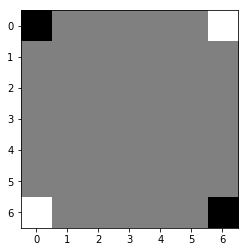

((0, 0), (1, 1)): n_v:  1597 q_all:+0.009228 q:-0.010933 q_m:+0.020000 p:0.321690
((6, 6), (5, 5)): n_v:  1401 q_all:+0.011815 q:-0.001538 q_m:+0.020000 p:0.272150
((0, 0), (0, 1)): n_v:   529 q_all:+0.009285 q:-0.009038 q_m:+0.020000 p:0.106552
((0, 0), (1, 0)): n_v:   515 q_all:+0.010073 q:-0.008174 q_m:+0.020000 p:0.102531
((6, 6), (5, 6)): n_v:   473 q_all:+0.007769 q:-0.010781 q_m:+0.020000 p:0.097303
((6, 6), (6, 5)): n_v:   432 q_all:+0.010214 q:+0.003939 q_m:+0.020000 p:0.085905
((0, 0), (2, 1)): n_v:    10 q_all:-0.003111 q:-0.020594 q_m:-0.000000 p:0.002356
((0, 0), (1, 2)): n_v:     8 q_all:-0.001029 q:-0.008157 q_m:-0.000000 p:0.001870
((6, 6), (4, 5)): n_v:     8 q_all:-0.003600 q:-0.019468 q_m:-0.000000 p:0.001982
((6, 6), (5, 4)): n_v:     6 q_all:+0.003908 q:-0.007887 q_m:-0.000000 p:0.001436
((0, 0), (2, 2)): n_v:     4 q_all:+0.000561 q:-0.017540 q_m:-0.000000 p:0.000960
((6, 6), (4, 4)): n_v:     4 q_all:-0.005621 q:-0.023309 q_m:-0.000000 p:0.000996
((0, 0), (2, 0))

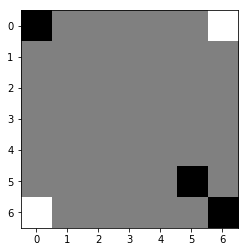

((6, 0), (5, 1)): n_v:  1853 q_all:-0.010725 q:-0.034021 q_m:-0.000000 p:0.283419
((0, 6), (1, 5)): n_v:  1368 q_all:-0.012321 q:-0.020020 q_m:-0.000000 p:0.214626
((6, 0), (5, 0)): n_v:   957 q_all:-0.011277 q:-0.026790 q_m:-0.000000 p:0.147631
((0, 6), (1, 6)): n_v:   803 q_all:-0.013329 q:-0.021159 q_m:-0.000000 p:0.127962
((6, 0), (6, 1)): n_v:   754 q_all:-0.011638 q:-0.018322 q_m:-0.000000 p:0.117048
((0, 6), (0, 5)): n_v:   620 q_all:-0.013686 q:-0.031628 q_m:-0.000000 p:0.099404
((0, 6), (2, 6)): n_v:    10 q_all:-0.023999 q:-0.026579 q_m:-0.020000 p:0.001901
((6, 0), (4, 0)): n_v:     6 q_all:-0.029668 q:-0.029712 q_m:-0.020000 p:0.001262
((6, 0), (6, 2)): n_v:     5 q_all:-0.026877 q:-0.037632 q_m:-0.020000 p:0.001083
((0, 6), (0, 4)): n_v:     5 q_all:-0.023419 q:-0.042009 q_m:-0.020000 p:0.000939
((6, 0), (5, 2)): n_v:     4 q_all:-0.016118 q:-0.035919 q_m:-0.020000 p:0.000744
((6, 0), (4, 1)): n_v:     4 q_all:-0.024334 q:-0.029313 q_m:-0.020000 p:0.000863
((0, 6), (2, 5))

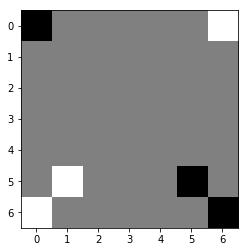

((0, 0), (1, 1)): n_v:  1360 q_all:+0.011614 q:+0.000761 q_m:+0.020000 p:0.182167
((0, 0), (0, 1)): n_v:   932 q_all:+0.011889 q:+0.002245 q_m:+0.020000 p:0.124286
((5, 5), (6, 4)): n_v:   852 q_all:+0.012764 q:+0.000174 q_m:+0.020000 p:0.111811
((5, 5), (5, 4)): n_v:   706 q_all:+0.013814 q:+0.008740 q_m:+0.020000 p:0.090826
((0, 0), (1, 0)): n_v:   704 q_all:+0.012707 q:+0.005009 q_m:+0.020000 p:0.092537
((5, 5), (4, 5)): n_v:   488 q_all:+0.008589 q:-0.007254 q_m:+0.020000 p:0.069039
((5, 5), (4, 6)): n_v:   448 q_all:+0.010777 q:-0.006265 q_m:+0.020000 p:0.061036
((5, 5), (6, 5)): n_v:   403 q_all:+0.009904 q:+0.004938 q_m:+0.020000 p:0.055697
((5, 5), (4, 4)): n_v:   384 q_all:+0.009034 q:-0.012979 q_m:+0.020000 p:0.053970
((5, 5), (5, 6)): n_v:   341 q_all:+0.009742 q:-0.003639 q_m:+0.020000 p:0.047281
((0, 0), (1, 2)): n_v:    14 q_all:-0.000132 q:-0.000061 q_m:-0.000000 p:0.002436
((0, 0), (0, 2)): n_v:    12 q_all:-0.005824 q:-0.022685 q_m:-0.000000 p:0.002129
((0, 0), (2, 1))

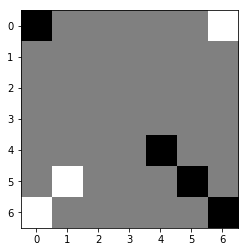

((0, 6), (1, 5)): n_v:   534 q_all:-0.002595 q:-0.009001 q_m:-0.000000 p:0.260366
((0, 6), (0, 5)): n_v:   202 q_all:-0.006967 q:-0.021221 q_m:-0.000000 p:0.102854
((5, 1), (6, 2)): n_v:   197 q_all:+0.000302 q:-0.022501 q_m:-0.000000 p:0.093635
((0, 6), (1, 6)): n_v:   197 q_all:-0.003857 q:-0.012170 q_m:-0.000000 p:0.097286
((5, 1), (6, 1)): n_v:   142 q_all:-0.003620 q:-0.017220 q_m:-0.000000 p:0.069823
((5, 1), (5, 0)): n_v:   131 q_all:-0.005531 q:-0.028383 q_m:-0.000000 p:0.065671
((5, 1), (4, 2)): n_v:   103 q_all:+0.009179 q:-0.034379 q_m:-0.000000 p:0.044712
((5, 1), (4, 0)): n_v:    94 q_all:-0.006399 q:-0.019222 q_m:-0.000000 p:0.047637
((5, 1), (5, 2)): n_v:    80 q_all:+0.011097 q:-0.041941 q_m:-0.000000 p:0.034044
((5, 1), (4, 1)): n_v:    64 q_all:-0.001147 q:-0.024298 q_m:-0.000000 p:0.030874
((5, 1), (3, 3)): n_v:     8 q_all:+0.035326 q:-0.035819 q_m:+0.020000 p:0.002536
((5, 1), (3, 0)): n_v:     5 q_all:+0.001381 q:-0.051588 q_m:-0.020000 p:0.002524
((5, 1), (3, 1))

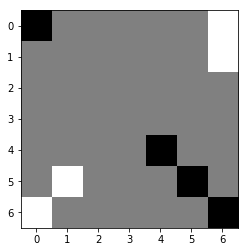

((0, 0), (1, 1)): n_v:   265 q_all:+0.014536 q:-0.016649 q_m:+0.020000 p:0.177612
((5, 5), (6, 4)): n_v:   235 q_all:+0.019040 q:-0.016583 q_m:+0.020000 p:0.151706
((0, 0), (0, 1)): n_v:   233 q_all:+0.015065 q:-0.014815 q_m:+0.020000 p:0.155777
((0, 0), (1, 0)): n_v:   132 q_all:+0.019059 q:-0.014419 q_m:+0.020000 p:0.085587
((4, 4), (5, 3)): n_v:    96 q_all:+0.027443 q:-0.021486 q_m:+0.020000 p:0.057572
((5, 5), (6, 5)): n_v:    79 q_all:+0.015658 q:-0.015825 q_m:+0.020000 p:0.052457
((5, 5), (4, 6)): n_v:    45 q_all:+0.021143 q:-0.020488 q_m:+0.020000 p:0.028489
((4, 4), (3, 5)): n_v:    39 q_all:+0.037752 q:-0.009864 q_m:+0.020000 p:0.021428
((5, 5), (5, 6)): n_v:    37 q_all:+0.016575 q:-0.015416 q_m:+0.020000 p:0.025019
((4, 4), (4, 5)): n_v:    26 q_all:+0.018039 q:-0.038323 q_m:+0.020000 p:0.016837
((4, 4), (6, 5)): n_v:    20 q_all:-0.004722 q:-0.003566 q_m:-0.000000 p:0.015861
((4, 4), (5, 4)): n_v:    18 q_all:+0.027438 q:-0.008155 q_m:+0.020000 p:0.011245
((4, 4), (5, 2))

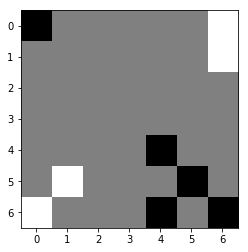

((5, 1), (6, 2)): n_v:   260 q_all:+0.022001 q:-0.015336 q_m:-0.000000 p:0.127908
((0, 6), (1, 5)): n_v:   189 q_all:-0.002182 q:-0.023851 q_m:-0.000000 p:0.119336
((0, 6), (0, 5)): n_v:   121 q_all:-0.003531 q:-0.028768 q_m:-0.000000 p:0.077279
((1, 6), (2, 6)): n_v:   114 q_all:+0.004434 q:-0.027032 q_m:-0.000000 p:0.067644
((5, 1), (5, 2)): n_v:    86 q_all:+0.012168 q:-0.035927 q_m:-0.000000 p:0.047555
((5, 1), (4, 0)): n_v:    80 q_all:+0.001861 q:-0.025297 q_m:-0.000000 p:0.048975
((5, 1), (6, 1)): n_v:    77 q_all:-0.000130 q:-0.016477 q_m:-0.000000 p:0.047836
((1, 6), (2, 5)): n_v:    70 q_all:+0.008571 q:-0.025208 q_m:-0.000000 p:0.040093
((5, 1), (4, 2)): n_v:    58 q_all:+0.013649 q:-0.027108 q_m:-0.000000 p:0.031268
((5, 1), (5, 0)): n_v:    54 q_all:+0.000910 q:-0.032109 q_m:-0.000000 p:0.033516
((5, 1), (4, 1)): n_v:    39 q_all:+0.005831 q:-0.019598 q_m:-0.000000 p:0.023266
((1, 6), (3, 4)): n_v:    16 q_all:-0.047875 q:-0.018170 q_m:+0.020000 p:0.014795
((1, 6), (3, 5))

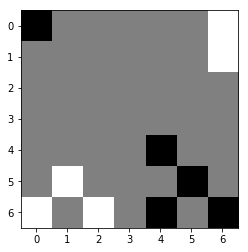

((4, 4), (5, 3)): n_v:   160 q_all:+0.007160 q:+0.002600 q_m:+0.060000 p:0.342094
((6, 4), (6, 3)): n_v:    37 q_all:-0.011694 q:-0.000398 q_m:+0.060000 p:0.088323
((0, 0), (0, 1)): n_v:    37 q_all:-0.015113 q:-0.021103 q_m:+0.020000 p:0.088812
((4, 4), (5, 2)): n_v:    23 q_all:-0.012420 q:+0.014694 q_m:+0.080000 p:0.054726
((0, 0), (1, 1)): n_v:    20 q_all:-0.009523 q:-0.022381 q_m:+0.020000 p:0.047609
((5, 5), (6, 5)): n_v:     8 q_all:-0.079789 q:-0.024694 q_m:+0.020000 p:0.025698
((6, 4), (5, 2)): n_v:     7 q_all:-0.012738 q:-0.002099 q_m:+0.080000 p:0.017761
((0, 0), (1, 0)): n_v:     6 q_all:-0.016023 q:-0.020079 q_m:+0.020000 p:0.014743
((4, 4), (4, 2)): n_v:     5 q_all:-0.004290 q:-0.001038 q_m:+0.040000 p:0.013501
((5, 5), (4, 6)): n_v:     5 q_all:-0.032932 q:-0.024232 q_m:+0.020000 p:0.013708
((4, 4), (6, 3)): n_v:     3 q_all:-0.008024 q:-0.001203 q_m:+0.040000 p:0.008057
((4, 4), (3, 5)): n_v:     2 q_all:-0.037466 q:-0.011071 q_m:+0.020000 p:0.006996
((6, 4), (4, 2))

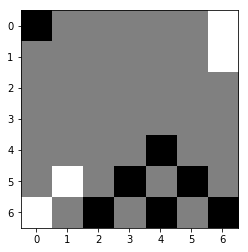

((5, 1), (5, 2)): n_v:  2120 q_all:-0.003608 q:-0.028847 q_m:+0.040000 p:0.544686
((5, 1), (6, 3)): n_v:   704 q_all:+0.007703 q:+0.051656 q_m:+0.060000 p:0.154155
((5, 1), (6, 1)): n_v:   214 q_all:-0.009728 q:-0.019818 q_m:-0.000000 p:0.059303
((5, 1), (4, 2)): n_v:   134 q_all:+0.010051 q:-0.059424 q_m:-0.000000 p:0.028269
((0, 6), (0, 5)): n_v:    95 q_all:-0.022771 q:-0.073750 q_m:-0.040000 p:0.030803
((6, 0), (5, 2)): n_v:    70 q_all:-0.017923 q:-0.042442 q_m:+0.020000 p:0.021382
((0, 6), (1, 5)): n_v:    63 q_all:-0.034598 q:-0.064496 q_m:-0.040000 p:0.023054
((5, 1), (4, 3)): n_v:    31 q_all:-0.024648 q:-0.037999 q_m:+0.020000 p:0.010431
((5, 1), (4, 1)): n_v:    28 q_all:+0.016788 q:-0.062433 q_m:-0.040000 p:0.005406
((5, 1), (4, 0)): n_v:    13 q_all:+0.004140 q:-0.072581 q_m:-0.040000 p:0.002949
((1, 6), (2, 5)): n_v:    11 q_all:-0.019539 q:-0.068672 q_m:-0.040000 p:0.003233
((1, 6), (3, 4)): n_v:     8 q_all:-0.000374 q:-0.073330 q_m:-0.020000 p:0.001961
((1, 6), (3, 5))

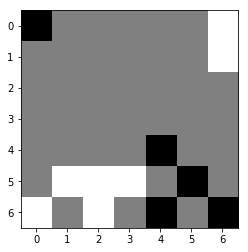

((6, 4), (6, 3)): n_v:  3436 q_all:+0.034155 q:+0.025036 q_m:+0.100000 p:0.407586
((4, 4), (4, 2)): n_v:  1779 q_all:+0.016738 q:-0.019523 q_m:+0.080000 p:0.284538
((6, 4), (4, 2)): n_v:  1245 q_all:+0.017443 q:-0.022827 q_m:+0.080000 p:0.197095
((5, 5), (6, 3)): n_v:   276 q_all:+0.017883 q:-0.009965 q_m:+0.080000 p:0.043301
((4, 4), (6, 3)): n_v:   254 q_all:+0.009502 q:+0.017926 q_m:+0.080000 p:0.045034
((4, 4), (4, 3)): n_v:    36 q_all:-0.000793 q:-0.035132 q_m:+0.060000 p:0.007294
((4, 4), (2, 2)): n_v:     6 q_all:-0.084463 q:-0.054925 q_m:-0.040000 p:0.002703
((0, 0), (0, 1)): n_v:     4 q_all:-0.059870 q:-0.067926 q_m:-0.020000 p:0.001675
((0, 0), (2, 2)): n_v:     4 q_all:-0.076180 q:-0.082735 q_m:-0.040000 p:0.001835
((6, 4), (4, 3)): n_v:     3 q_all:-0.020337 q:-0.038002 q_m:+0.040000 p:0.000891
((5, 5), (4, 3)): n_v:     2 q_all:-0.021006 q:-0.057279 q_m:+0.040000 p:0.000633
((4, 4), (5, 4)): n_v:     2 q_all:-0.033610 q:-0.030525 q_m:+0.020000 p:0.000748
((5, 5), (6, 5))

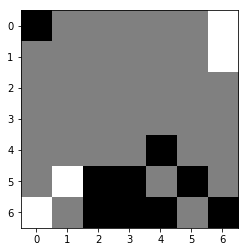

((5, 1), (6, 1)): n_v:  8006 q_all:+0.011848 q:-0.036763 q_m:-0.000000 p:0.628846
((5, 1), (4, 2)): n_v:   221 q_all:-0.036623 q:-0.061822 q_m:-0.000000 p:0.040819
((0, 6), (0, 5)): n_v:    80 q_all:-0.086366 q:-0.111280 q_m:-0.080000 p:0.023356
((5, 1), (4, 1)): n_v:    34 q_all:-0.066636 q:-0.075270 q_m:-0.040000 p:0.008680
((5, 1), (4, 3)): n_v:    33 q_all:-0.045423 q:-0.014906 q_m:+0.020000 p:0.006748
((6, 0), (4, 2)): n_v:    15 q_all:-0.068571 q:-0.075297 q_m:-0.020000 p:0.003905
((0, 6), (1, 5)): n_v:    12 q_all:-0.082083 q:-0.103378 q_m:-0.080000 p:0.003327
((1, 6), (1, 4)): n_v:     4 q_all:-0.092255 q:-0.109765 q_m:-0.100000 p:0.001365
((6, 0), (4, 1)): n_v:     4 q_all:-0.128652 q:-0.105590 q_m:-0.060000 p:0.001746
((5, 1), (4, 0)): n_v:     3 q_all:-0.069463 q:-0.101341 q_m:-0.080000 p:0.001003
((1, 6), (0, 4)): n_v:     2 q_all:-0.145588 q:-0.125701 q_m:-0.100000 p:0.001100
((1, 6), (3, 5)): n_v:     2 q_all:-0.085144 q:-0.112733 q_m:-0.060000 p:0.000693
((1, 6), (3, 4))

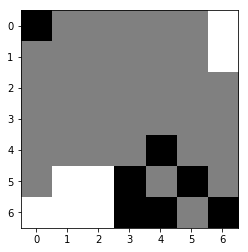

((5, 3), (4, 2)): n_v:  4999 q_all:+0.004262 q:-0.006260 q_m:+0.100000 p:0.341644
((5, 3), (4, 1)): n_v:  2934 q_all:+0.025356 q:-0.029789 q_m:+0.080000 p:0.090902
((4, 4), (4, 2)): n_v:  1694 q_all:-0.001853 q:-0.010293 q_m:+0.080000 p:0.134013
((6, 4), (4, 2)): n_v:   601 q_all:+0.002956 q:-0.022206 q_m:+0.080000 p:0.042448
((5, 3), (4, 5)): n_v:   230 q_all:-0.086330 q:-0.081532 q_m:-0.000000 p:0.052827
((0, 0), (1, 1)): n_v:   206 q_all:-0.069664 q:-0.044492 q_m:+0.020000 p:0.041228
((6, 3), (4, 1)): n_v:   195 q_all:+0.003844 q:-0.026679 q_m:+0.080000 p:0.013602
((6, 3), (4, 2)): n_v:   128 q_all:+0.013168 q:-0.032371 q_m:+0.080000 p:0.006773
((6, 3), (6, 5)): n_v:   113 q_all:-0.097381 q:-0.074661 q_m:-0.000000 p:0.028105
((0, 0), (1, 0)): n_v:    97 q_all:-0.068382 q:-0.044118 q_m:+0.020000 p:0.019215
((4, 4), (5, 6)): n_v:    61 q_all:-0.062663 q:-0.045300 q_m:-0.000000 p:0.011510
((5, 3), (6, 5)): n_v:    55 q_all:-0.088441 q:-0.071072 q_m:-0.000000 p:0.012856
((4, 4), (6, 5))

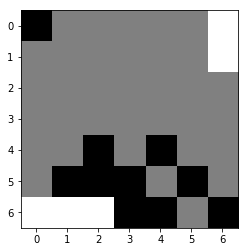

((6, 0), (4, 1)): n_v:  5165 q_all:+0.070285 q:-0.036761 q_m:+0.020000 p:0.382665
((6, 2), (5, 4)): n_v:  2190 q_all:+0.040442 q:-0.005288 q_m:+0.100000 p:0.293529
((6, 2), (4, 1)): n_v:   499 q_all:-0.010335 q:-0.066576 q_m:+0.020000 p:0.117847
((6, 1), (4, 1)): n_v:   424 q_all:+0.011288 q:-0.061189 q_m:+0.020000 p:0.081696
((6, 1), (4, 3)): n_v:   327 q_all:-0.000160 q:-0.022088 q_m:+0.060000 p:0.070555
((6, 2), (4, 3)): n_v:   218 q_all:+0.019987 q:-0.015473 q_m:+0.060000 p:0.038332
((1, 6), (2, 5)): n_v:    15 q_all:-0.035335 q:-0.084254 q_m:-0.080000 p:0.004415
((6, 0), (5, 0)): n_v:     6 q_all:+0.013048 q:-0.068378 q_m:-0.040000 p:0.001199
((0, 6), (2, 5)): n_v:     4 q_all:-0.079489 q:-0.094396 q_m:-0.100000 p:0.001735
((0, 6), (1, 5)): n_v:     3 q_all:-0.030164 q:-0.077956 q_m:-0.080000 p:0.000867
((0, 6), (1, 4)): n_v:     2 q_all:-0.072091 q:-0.081298 q_m:-0.100000 p:0.000870
((1, 6), (3, 5)): n_v:     1 q_all:-0.043960 q:-0.088595 q_m:-0.060000 p:0.000410
((1, 6), (1, 4))

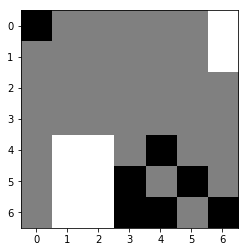

((4, 4), (3, 2)): n_v:  6007 q_all:+0.024189 q:-0.017002 q_m:+0.060000 p:0.039176
((4, 4), (4, 3)): n_v:  1510 q_all:-0.083105 q:-0.020147 q_m:+0.080000 p:0.233548
((4, 4), (3, 4)): n_v:   227 q_all:-0.124367 q:-0.054516 q_m:-0.000000 p:0.061124
((5, 3), (3, 1)): n_v:   176 q_all:-0.054558 q:-0.028217 q_m:+0.060000 p:0.013224
((5, 5), (4, 3)): n_v:   173 q_all:-0.068179 q:-0.030950 q_m:+0.060000 p:0.019605
((4, 4), (3, 5)): n_v:   131 q_all:-0.125864 q:-0.036503 q_m:-0.000000 p:0.036102
((5, 3), (3, 2)): n_v:   118 q_all:-0.055130 q:-0.020507 q_m:+0.060000 p:0.009078
((5, 3), (4, 5)): n_v:   106 q_all:-0.147038 q:-0.085456 q_m:-0.020000 p:0.035513
((5, 3), (6, 5)): n_v:    98 q_all:-0.147029 q:-0.072674 q_m:-0.020000 p:0.032710
((6, 4), (4, 3)): n_v:    96 q_all:-0.072826 q:-0.022570 q_m:+0.060000 p:0.012182
((6, 3), (6, 5)): n_v:    94 q_all:-0.143068 q:-0.067460 q_m:-0.020000 p:0.030522
((4, 4), (5, 6)): n_v:    86 q_all:-0.121777 q:-0.051067 q_m:-0.020000 p:0.022536
((4, 4), (3, 3))

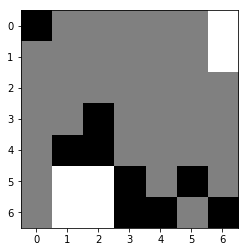

((6, 2), (5, 4)): n_v:  6594 q_all:+0.009989 q:-0.041232 q_m:+0.100000 p:0.544178
((5, 2), (4, 3)): n_v:  2237 q_all:+0.006285 q:+0.027896 q_m:+0.080000 p:0.195077
((5, 2), (5, 4)): n_v:   762 q_all:-0.018358 q:-0.008538 q_m:+0.100000 p:0.105183
((6, 2), (4, 4)): n_v:   229 q_all:-0.048556 q:-0.053218 q_m:+0.020000 p:0.045231
((6, 1), (4, 3)): n_v:   158 q_all:+0.026803 q:-0.018423 q_m:+0.060000 p:0.009536
((5, 2), (4, 4)): n_v:   112 q_all:-0.059950 q:-0.062039 q_m:+0.020000 p:0.024710
((1, 6), (3, 5)): n_v:   104 q_all:-0.039300 q:-0.085643 q_m:-0.060000 p:0.018637
((5, 1), (4, 3)): n_v:    77 q_all:-0.024326 q:+0.015956 q_m:+0.060000 p:0.011639
((5, 1), (3, 1)): n_v:    76 q_all:+0.000213 q:-0.023303 q_m:+0.060000 p:0.007737
((5, 2), (3, 1)): n_v:    38 q_all:-0.048328 q:-0.031805 q_m:+0.060000 p:0.007606
((6, 2), (4, 3)): n_v:    37 q_all:-0.029378 q:-0.020571 q_m:+0.060000 p:0.006051
((0, 6), (1, 5)): n_v:    32 q_all:+0.032222 q:-0.055935 q_m:-0.040000 p:0.001276
((5, 1), (5, 0))

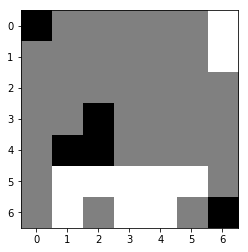

((4, 1), (6, 2)): n_v:  8346 q_all:+0.017570 q:+0.031644 q_m:+0.100000 p:0.681347
((4, 2), (6, 2)): n_v:  1054 q_all:+0.011345 q:+0.037615 q_m:+0.100000 p:0.098229
((6, 6), (6, 5)): n_v:  1006 q_all:+0.033476 q:-0.005934 q_m:+0.040000 p:0.052269
((0, 0), (0, 2)): n_v:   385 q_all:-0.107945 q:-0.122517 q_m:-0.100000 p:0.121169
((3, 2), (4, 3)): n_v:   113 q_all:+0.018129 q:-0.043517 q_m:+0.040000 p:0.009180
((4, 2), (4, 4)): n_v:    43 q_all:-0.021002 q:-0.053829 q_m:+0.020000 p:0.006692
((0, 0), (0, 1)): n_v:    26 q_all:-0.085396 q:-0.092584 q_m:-0.080000 p:0.007149
((3, 2), (2, 3)): n_v:    17 q_all:-0.077020 q:-0.118326 q_m:-0.080000 p:0.004543
((3, 2), (4, 4)): n_v:    16 q_all:-0.041170 q:-0.048423 q_m:+0.020000 p:0.003036
((4, 1), (4, 3)): n_v:    12 q_all:-0.021547 q:-0.047284 q_m:+0.020000 p:0.001979
((4, 1), (5, 0)): n_v:    10 q_all:-0.023928 q:-0.098303 q_m:-0.000000 p:0.001675
((3, 2), (1, 1)): n_v:     4 q_all:-0.063539 q:-0.137163 q_m:-0.100000 p:0.001114
((6, 6), (4, 4))

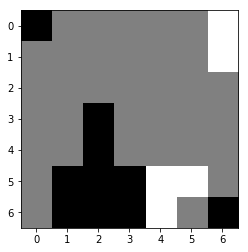

((5, 4), (4, 3)): n_v: 11258 q_all:-0.002593 q:-0.022427 q_m:+0.080000 p:0.953503
((6, 4), (4, 3)): n_v:   312 q_all:-0.005799 q:-0.046207 q_m:+0.060000 p:0.028236
((5, 5), (4, 3)): n_v:   114 q_all:-0.015940 q:-0.038382 q_m:+0.060000 p:0.012380
((5, 4), (4, 4)): n_v:     5 q_all:-0.097091 q:-0.116215 q_m:-0.040000 p:0.001413
((5, 4), (4, 5)): n_v:     3 q_all:-0.141645 q:-0.137550 q_m:-0.080000 p:0.001269
((5, 5), (5, 6)): n_v:     1 q_all:-0.139835 q:-0.104407 q_m:-0.040000 p:0.000553
((1, 6), (0, 4)): n_v:     0 q_all:-0.110960 q:-0.127399 q_m:-0.100000 p:0.000004
((5, 4), (3, 4)): n_v:     0 q_all:-0.106970 q:-0.117424 q_m:-0.100000 p:0.000012
((1, 6), (2, 6)): n_v:     0 q_all:-0.091032 q:-0.107581 q_m:-0.080000 p:0.000036
((5, 4), (3, 5)): n_v:     0 q_all:-0.105746 q:-0.114365 q_m:-0.100000 p:0.000039
((0, 6), (2, 4)): n_v:     0 q_all:-0.108608 q:-0.121521 q_m:-0.100000 p:0.000015
((1, 6), (3, 5)): n_v:     0 q_all:-0.111525 q:-0.128812 q_m:-0.100000 p:0.000039
((1, 6), (3, 4))

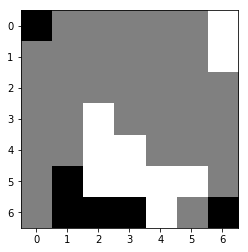

((5, 1), (4, 1)): n_v:  7006 q_all:+0.051292 q:+0.033959 q_m:+0.060000 p:0.426205
((6, 6), (4, 4)): n_v:  2488 q_all:+0.028296 q:-0.018701 q_m:+0.080000 p:0.246107
((6, 6), (6, 5)): n_v:  1125 q_all:+0.020367 q:+0.005842 q_m:+0.060000 p:0.125950
((6, 6), (4, 5)): n_v:   257 q_all:-0.036865 q:-0.058547 q_m:-0.000000 p:0.053245
((6, 1), (4, 1)): n_v:   159 q_all:+0.007547 q:-0.012454 q_m:+0.040000 p:0.021225
((6, 2), (4, 4)): n_v:   151 q_all:-0.012239 q:-0.037784 q_m:+0.080000 p:0.025109
((6, 2), (4, 1)): n_v:   100 q_all:-0.027526 q:-0.033614 q_m:+0.040000 p:0.019283
((6, 3), (6, 5)): n_v:    86 q_all:-0.014018 q:-0.017292 q_m:+0.040000 p:0.014681
((6, 3), (4, 1)): n_v:    73 q_all:+0.003864 q:-0.036723 q_m:+0.040000 p:0.010281
((0, 0), (0, 1)): n_v:    63 q_all:-0.064606 q:-0.071262 q_m:-0.060000 p:0.016031
((0, 0), (2, 2)): n_v:    50 q_all:-0.043070 q:-0.044716 q_m:-0.040000 p:0.011037
((6, 3), (4, 4)): n_v:    40 q_all:+0.005819 q:-0.025214 q_m:+0.080000 p:0.005518
((0, 0), (2, 1))

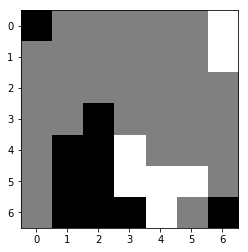

((4, 3), (3, 1)): n_v:  3598 q_all:-0.035841 q:-0.049844 q_m:+0.060000 p:0.419185
((4, 3), (3, 3)): n_v:  1170 q_all:-0.048588 q:-0.042624 q_m:+0.040000 p:0.167965
((4, 3), (6, 5)): n_v:   509 q_all:-0.002023 q:-0.060224 q_m:-0.020000 p:0.022457
((5, 3), (3, 1)): n_v:   509 q_all:-0.029522 q:-0.035334 q_m:+0.060000 p:0.052505
((4, 3), (3, 5)): n_v:   397 q_all:-0.096174 q:-0.101953 q_m:-0.060000 p:0.097270
((5, 5), (5, 6)): n_v:   379 q_all:-0.069644 q:-0.063122 q_m:-0.000000 p:0.071428
((5, 4), (6, 5)): n_v:   152 q_all:+0.001114 q:-0.039852 q_m:-0.000000 p:0.005655
((5, 3), (6, 5)): n_v:   109 q_all:-0.064082 q:-0.035225 q_m:-0.020000 p:0.019346
((5, 4), (3, 3)): n_v:    48 q_all:-0.058729 q:-0.067205 q_m:+0.020000 p:0.007954
((5, 3), (3, 5)): n_v:    48 q_all:-0.098125 q:-0.079067 q_m:-0.060000 p:0.012077
((5, 5), (3, 3)): n_v:    30 q_all:-0.033527 q:-0.057082 q_m:+0.020000 p:0.003689
((4, 3), (3, 4)): n_v:    27 q_all:-0.099438 q:-0.080838 q_m:-0.040000 p:0.006985
((5, 4), (4, 5))

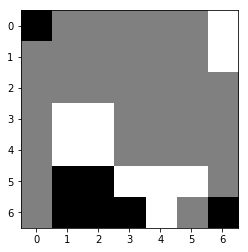

((5, 2), (4, 3)): n_v:  5518 q_all:+0.077785 q:+0.022906 q_m:+0.120000 p:0.773375
((6, 2), (4, 3)): n_v:   197 q_all:+0.016481 q:-0.045283 q_m:+0.100000 p:0.055809
((6, 1), (4, 3)): n_v:   158 q_all:+0.042573 q:-0.011299 q_m:+0.100000 p:0.035006
((5, 2), (4, 4)): n_v:   114 q_all:-0.003847 q:-0.037963 q_m:+0.060000 p:0.037554
((5, 1), (4, 3)): n_v:    65 q_all:+0.020179 q:+0.007845 q_m:+0.100000 p:0.017746
((6, 2), (4, 4)): n_v:    63 q_all:+0.002884 q:-0.065788 q_m:+0.060000 p:0.019811
((6, 6), (4, 4)): n_v:    55 q_all:+0.017622 q:-0.014973 q_m:+0.060000 p:0.015481
((6, 6), (6, 5)): n_v:    51 q_all:+0.073808 q:+0.008927 q_m:+0.080000 p:0.007645
((6, 3), (4, 3)): n_v:    39 q_all:+0.031123 q:-0.020796 q_m:+0.100000 p:0.009890
((6, 3), (6, 5)): n_v:    26 q_all:+0.034825 q:-0.037113 q_m:+0.060000 p:0.006326
((0, 0), (2, 2)): n_v:    20 q_all:+0.041117 q:-0.009768 q_m:+0.020000 p:0.004583
((0, 0), (0, 1)): n_v:     8 q_all:-0.018627 q:-0.072476 q_m:-0.040000 p:0.003186
((6, 6), (4, 5))

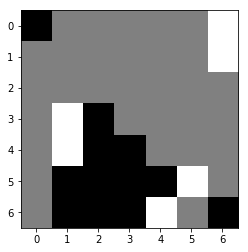

((5, 5), (4, 4)): n_v:  2340 q_all:-0.059787 q:-0.067723 q_m:+0.020000 p:0.348221
((4, 1), (5, 0)): n_v:  1042 q_all:-0.072120 q:-0.068168 q_m:-0.020000 p:0.186217
((5, 5), (6, 5)): n_v:   795 q_all:-0.025439 q:-0.108134 q_m:-0.020000 p:0.051982
((5, 5), (3, 3)): n_v:   335 q_all:-0.030466 q:-0.070747 q_m:-0.000000 p:0.026100
((5, 5), (5, 6)): n_v:   294 q_all:-0.143289 q:-0.113998 q_m:-0.060000 p:0.103331
((4, 1), (3, 3)): n_v:   212 q_all:-0.078753 q:-0.062008 q_m:-0.000000 p:0.041389
((3, 1), (5, 0)): n_v:   107 q_all:-0.050866 q:-0.077624 q_m:-0.040000 p:0.013714
((3, 1), (2, 2)): n_v:    60 q_all:-0.092773 q:-0.097916 q_m:-0.060000 p:0.013929
((6, 4), (4, 4)): n_v:    44 q_all:-0.067030 q:-0.078448 q_m:-0.000000 p:0.007454
((3, 1), (3, 3)): n_v:    35 q_all:-0.056544 q:-0.069435 q_m:-0.000000 p:0.005064
((3, 1), (1, 0)): n_v:    23 q_all:-0.101648 q:-0.088726 q_m:-0.080000 p:0.006082
((0, 6), (0, 5)): n_v:    15 q_all:-0.111199 q:-0.129285 q_m:-0.100000 p:0.004276
((4, 1), (6, 0))

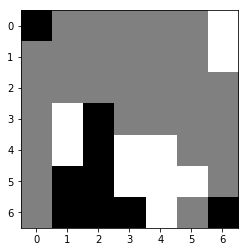

((6, 6), (6, 5)): n_v:  3280 q_all:+0.087485 q:+0.036630 q_m:+0.120000 p:0.572771
((3, 2), (3, 3)): n_v:   379 q_all:+0.058138 q:-0.026141 q_m:+0.080000 p:0.098521
((6, 3), (6, 5)): n_v:   377 q_all:+0.033561 q:+0.011202 q_m:+0.100000 p:0.125090
((6, 6), (4, 5)): n_v:   171 q_all:+0.055417 q:-0.024547 q_m:+0.100000 p:0.045837
((0, 0), (0, 1)): n_v:    81 q_all:-0.000049 q:-0.034838 q_m:-0.000000 p:0.034918
((5, 1), (4, 0)): n_v:    69 q_all:+0.099395 q:+0.031148 q_m:+0.080000 p:0.009708
((6, 3), (4, 5)): n_v:    30 q_all:+0.039714 q:-0.033826 q_m:+0.100000 p:0.009469
((3, 2), (2, 1)): n_v:    22 q_all:+0.038249 q:+0.001922 q_m:+0.040000 p:0.007241
((6, 6), (4, 6)): n_v:    20 q_all:+0.004629 q:-0.044503 q_m:+0.020000 p:0.008607
((3, 2), (2, 2)): n_v:     7 q_all:+0.003755 q:+0.000416 q_m:+0.040000 p:0.002902
((6, 1), (4, 0)): n_v:     5 q_all:+0.081375 q:+0.000093 q_m:+0.060000 p:0.001001
((6, 6), (5, 6)): n_v:     4 q_all:+0.010594 q:-0.036190 q_m:+0.040000 p:0.001683
((0, 0), (1, 1))

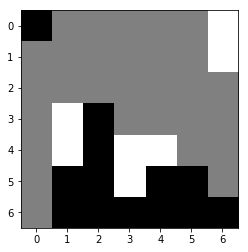

((4, 1), (5, 0)): n_v:  2020 q_all:-0.079439 q:-0.047867 q_m:-0.020000 p:0.648464
((3, 1), (5, 0)): n_v:   301 q_all:-0.065994 q:-0.056960 q_m:-0.040000 p:0.084474
((4, 3), (3, 3)): n_v:   209 q_all:-0.047403 q:-0.084104 q_m:-0.020000 p:0.046795
((4, 4), (4, 5)): n_v:   145 q_all:-0.052089 q:-0.098383 q_m:-0.020000 p:0.034600
((4, 4), (5, 6)): n_v:   130 q_all:-0.056714 q:-0.072564 q_m:-0.000000 p:0.032849
((3, 1), (1, 1)): n_v:   104 q_all:-0.091791 q:-0.086295 q_m:-0.080000 p:0.037325
((3, 1), (1, 0)): n_v:    47 q_all:-0.087359 q:-0.062273 q_m:-0.080000 p:0.016310
((4, 1), (6, 0)): n_v:    33 q_all:-0.060722 q:-0.071666 q_m:-0.040000 p:0.008911
((5, 3), (4, 5)): n_v:    32 q_all:-0.099032 q:-0.114645 q_m:-0.040000 p:0.012556
((4, 3), (4, 5)): n_v:    21 q_all:-0.091606 q:-0.122104 q_m:-0.040000 p:0.007692
((1, 6), (2, 5)): n_v:    12 q_all:-0.094157 q:-0.098363 q_m:-0.100000 p:0.004671
((0, 6), (1, 5)): n_v:    10 q_all:-0.084517 q:-0.075916 q_m:-0.100000 p:0.003519
((4, 3), (3, 5))

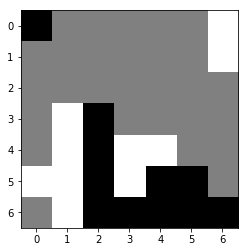

((3, 2), (4, 0)): n_v:  2262 q_all:+0.132138 q:+0.073436 q_m:+0.180000 p:0.369240
((5, 5), (4, 6)): n_v:   401 q_all:+0.013836 q:-0.016372 q_m:+0.040000 p:0.225618
((3, 2), (3, 3)): n_v:   194 q_all:+0.063354 q:+0.011894 q_m:+0.120000 p:0.077013
((6, 2), (4, 0)): n_v:    76 q_all:+0.106192 q:+0.040425 q_m:+0.180000 p:0.019060
((3, 2), (2, 0)): n_v:    68 q_all:+0.030812 q:-0.001894 q_m:+0.060000 p:0.034778
((6, 6), (4, 6)): n_v:    63 q_all:-0.002777 q:-0.025532 q_m:+0.020000 p:0.039427
((3, 2), (1, 1)): n_v:    58 q_all:-0.012142 q:-0.024864 q_m:+0.020000 p:0.038036
((5, 4), (4, 5)): n_v:    34 q_all:+0.047396 q:-0.011655 q_m:+0.080000 p:0.015465
((4, 2), (4, 0)): n_v:    22 q_all:+0.091842 q:+0.064644 q_m:+0.180000 p:0.006630
((6, 4), (4, 6)): n_v:    19 q_all:-0.036655 q:-0.037605 q_m:+0.020000 p:0.014197
((5, 2), (4, 0)): n_v:    15 q_all:+0.079317 q:+0.030750 q_m:+0.180000 p:0.005398
((3, 2), (1, 0)): n_v:    14 q_all:-0.007329 q:-0.029591 q_m:+0.020000 p:0.009098
((0, 0), (2, 0))

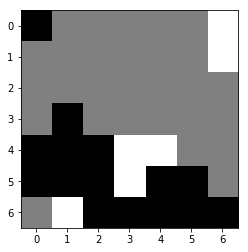

((4, 3), (3, 2)): n_v:  1257 q_all:-0.081581 q:-0.088715 q_m:-0.040000 p:0.289556
((6, 1), (6, 0)): n_v:   768 q_all:-0.038333 q:-0.072837 q_m:-0.080000 p:0.076428
((4, 4), (4, 5)): n_v:   582 q_all:-0.095044 q:-0.152454 q_m:-0.080000 p:0.157958
((4, 4), (5, 6)): n_v:   387 q_all:-0.100606 q:-0.131810 q_m:-0.060000 p:0.111608
((4, 3), (3, 4)): n_v:   325 q_all:-0.168249 q:-0.154665 q_m:-0.160000 p:0.160502
((4, 4), (3, 2)): n_v:   157 q_all:-0.069274 q:-0.084538 q_m:-0.060000 p:0.030258
((5, 3), (4, 5)): n_v:    54 q_all:-0.156907 q:-0.176005 q_m:-0.100000 p:0.025034
((1, 6), (2, 5)): n_v:    28 q_all:-0.130341 q:-0.154118 q_m:-0.160000 p:0.010709
((4, 3), (3, 5)): n_v:    24 q_all:-0.190217 q:-0.178966 q_m:-0.180000 p:0.013839
((5, 3), (3, 2)): n_v:    23 q_all:-0.094817 q:-0.104670 q_m:-0.060000 p:0.006577
((4, 3), (4, 5)): n_v:    11 q_all:-0.165453 q:-0.166482 q_m:-0.100000 p:0.005457
((4, 3), (2, 1)): n_v:     9 q_all:-0.152140 q:-0.149522 q_m:-0.140000 p:0.004340
((4, 3), (2, 5))

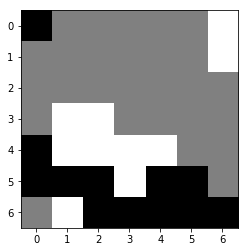

((5, 5), (3, 3)): n_v:  4378 q_all:+0.114946 q:+0.030507 q_m:+0.200000 p:0.429756
((5, 1), (3, 3)): n_v:  1167 q_all:+0.017105 q:+0.033290 q_m:+0.200000 p:0.403408
((5, 2), (3, 3)): n_v:   258 q_all:+0.045222 q:+0.025550 q_m:+0.200000 p:0.070953
((5, 4), (3, 3)): n_v:   147 q_all:+0.010194 q:+0.017960 q_m:+0.200000 p:0.053586
((5, 4), (4, 5)): n_v:    71 q_all:+0.108899 q:-0.023265 q_m:+0.100000 p:0.008167
((4, 0), (3, 0)): n_v:    33 q_all:+0.103025 q:+0.034512 q_m:+0.140000 p:0.004218
((0, 0), (1, 1)): n_v:    10 q_all:+0.058981 q:+0.007755 q_m:+0.060000 p:0.002523
((5, 0), (6, 0)): n_v:     9 q_all:+0.084896 q:+0.065080 q_m:+0.100000 p:0.001698
((0, 0), (2, 2)): n_v:     7 q_all:+0.084873 q:+0.037627 q_m:+0.120000 p:0.001201
((6, 3), (4, 5)): n_v:     6 q_all:-0.004845 q:-0.051604 q_m:+0.080000 p:0.002735
((0, 0), (0, 1)): n_v:     5 q_all:+0.036364 q:+0.000898 q_m:+0.060000 p:0.001620
((0, 0), (2, 1)): n_v:     4 q_all:+0.070304 q:+0.029799 q_m:+0.120000 p:0.000905
((0, 0), (1, 2))

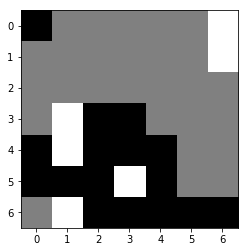

((1, 6), (3, 4)): n_v:  4392 q_all:-0.092824 q:-0.117662 q_m:-0.080000 p:0.610657
((5, 3), (3, 4)): n_v:   656 q_all:-0.081628 q:-0.121702 q_m:-0.080000 p:0.072803
((6, 1), (6, 0)): n_v:   268 q_all:-0.070555 q:-0.100101 q_m:-0.100000 p:0.023789
((3, 1), (2, 2)): n_v:   200 q_all:-0.111753 q:-0.111994 q_m:-0.100000 p:0.037521
((0, 6), (1, 5)): n_v:   199 q_all:-0.159528 q:-0.159262 q_m:-0.180000 p:0.061246
((5, 3), (5, 5)): n_v:   170 q_all:-0.079512 q:-0.083888 q_m:-0.000000 p:0.017995
((3, 1), (1, 1)): n_v:   156 q_all:-0.126493 q:-0.162002 q_m:-0.160000 p:0.035074
((3, 1), (2, 3)): n_v:    22 q_all:-0.126656 q:-0.120301 q_m:-0.120000 p:0.004790
((5, 3), (3, 5)): n_v:    19 q_all:-0.147174 q:-0.168245 q_m:-0.160000 p:0.005509
((3, 1), (3, 0)): n_v:    14 q_all:-0.139344 q:-0.115663 q_m:-0.140000 p:0.003717
((4, 1), (2, 3)): n_v:    14 q_all:-0.070858 q:-0.147382 q_m:-0.120000 p:0.001231
((1, 6), (3, 5)): n_v:    12 q_all:-0.184752 q:-0.170830 q_m:-0.160000 p:0.004447
((3, 1), (1, 2))

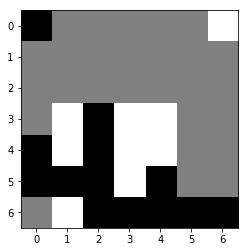

((3, 2), (2, 3)): n_v:  1738 q_all:+0.097620 q:+0.023612 q_m:+0.180000 p:0.284406
((5, 4), (4, 5)): n_v:  1017 q_all:+0.093997 q:+0.037193 q_m:+0.180000 p:0.176563
((3, 2), (2, 2)): n_v:   840 q_all:+0.101368 q:+0.032800 q_m:+0.180000 p:0.128963
((4, 0), (3, 0)): n_v:   386 q_all:+0.137262 q:+0.052274 q_m:+0.180000 p:0.021416
((5, 4), (5, 5)): n_v:   186 q_all:+0.080650 q:+0.028758 q_m:+0.140000 p:0.039131
((5, 0), (6, 0)): n_v:   147 q_all:+0.090312 q:+0.058637 q_m:+0.140000 p:0.027115
((3, 2), (2, 1)): n_v:   115 q_all:+0.080521 q:+0.013430 q_m:+0.140000 p:0.024318
((6, 3), (4, 5)): n_v:    99 q_all:+0.066169 q:-0.001739 q_m:+0.160000 p:0.024863
((3, 2), (1, 1)): n_v:    60 q_all:+0.037865 q:-0.015058 q_m:+0.080000 p:0.019726
((6, 6), (4, 5)): n_v:    53 q_all:+0.084682 q:+0.029429 q_m:+0.160000 p:0.010539
((3, 2), (1, 3)): n_v:    52 q_all:+0.038525 q:+0.000675 q_m:+0.080000 p:0.016870
((3, 2), (2, 4)): n_v:    52 q_all:+0.084126 q:+0.005952 q_m:+0.160000 p:0.010435
((6, 5), (4, 5))

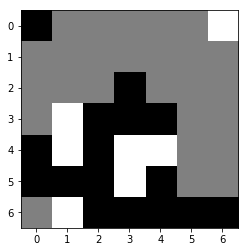

((3, 1), (2, 2)): n_v:  4408 q_all:-0.032771 q:-0.104402 q_m:-0.040000 p:0.881017
((4, 4), (5, 5)): n_v:   166 q_all:-0.019939 q:-0.066119 q_m:-0.000000 p:0.027583
((0, 6), (1, 5)): n_v:    76 q_all:-0.076922 q:-0.138232 q_m:-0.160000 p:0.024052
((0, 6), (2, 4)): n_v:    59 q_all:-0.100451 q:-0.125575 q_m:-0.060000 p:0.022641
((4, 1), (2, 2)): n_v:    38 q_all:-0.039215 q:-0.117731 q_m:-0.060000 p:0.008413
((4, 4), (2, 2)): n_v:    33 q_all:-0.111501 q:-0.139160 q_m:-0.060000 p:0.013797
((4, 3), (5, 5)): n_v:    22 q_all:-0.053936 q:-0.086014 q_m:-0.020000 p:0.005857
((4, 3), (2, 4)): n_v:     8 q_all:-0.159522 q:-0.129531 q_m:-0.060000 p:0.004784
((5, 3), (5, 5)): n_v:     6 q_all:-0.074581 q:-0.097949 q_m:-0.020000 p:0.001951
((4, 4), (2, 4)): n_v:     6 q_all:-0.122527 q:-0.113022 q_m:-0.060000 p:0.003023
((4, 3), (2, 2)): n_v:     4 q_all:-0.145258 q:-0.129958 q_m:-0.060000 p:0.002222
((3, 1), (1, 1)): n_v:     2 q_all:-0.090772 q:-0.149338 q_m:-0.140000 p:0.000790
((4, 4), (3, 5))

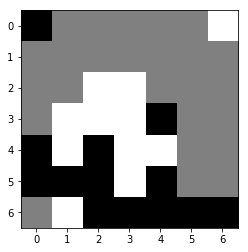

((3, 4), (2, 4)): n_v:  3418 q_all:+0.033956 q:+0.008932 q_m:+0.140000 p:0.709570
((4, 0), (2, 1)): n_v:  1583 q_all:+0.115941 q:+0.038205 q_m:+0.160000 p:0.009373
((0, 0), (2, 1)): n_v:   563 q_all:+0.075534 q:+0.035436 q_m:+0.160000 p:0.054358
((3, 4), (2, 5)): n_v:   148 q_all:-0.011509 q:-0.035861 q_m:+0.060000 p:0.047562
((3, 4), (4, 5)): n_v:    79 q_all:-0.002313 q:-0.008336 q_m:+0.100000 p:0.023614
((0, 0), (1, 2)): n_v:    67 q_all:+0.018987 q:+0.019636 q_m:+0.120000 p:0.016479
((5, 0), (6, 0)): n_v:    65 q_all:+0.026375 q:+0.024941 q_m:+0.100000 p:0.014894
((0, 0), (1, 1)): n_v:    62 q_all:+0.001574 q:-0.003696 q_m:+0.100000 p:0.018005
((5, 4), (5, 5)): n_v:    32 q_all:+0.044377 q:+0.002003 q_m:+0.100000 p:0.005898
((3, 4), (1, 3)): n_v:    19 q_all:+0.021005 q:+0.019111 q_m:+0.120000 p:0.004730
((6, 3), (4, 5)): n_v:    15 q_all:-0.046417 q:-0.070404 q_m:+0.080000 p:0.006378
((4, 0), (3, 0)): n_v:    14 q_all:+0.049617 q:+0.012790 q_m:+0.140000 p:0.002455
((4, 2), (2, 4))

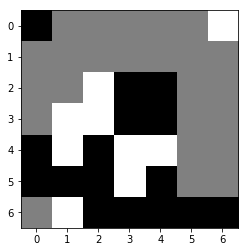

((4, 4), (5, 5)): n_v:  2566 q_all:+0.002316 q:-0.029364 q_m:+0.040000 p:0.336924
((0, 6), (1, 5)): n_v:   804 q_all:-0.085295 q:-0.118653 q_m:-0.080000 p:0.310880
((4, 4), (3, 5)): n_v:   354 q_all:-0.072080 q:-0.105534 q_m:-0.040000 p:0.122894
((4, 3), (5, 5)): n_v:   211 q_all:-0.025951 q:-0.056984 q_m:+0.020000 p:0.045267
((6, 1), (6, 0)): n_v:   140 q_all:-0.035887 q:-0.068701 q_m:-0.040000 p:0.034115
((5, 3), (5, 5)): n_v:   102 q_all:-0.018540 q:-0.059945 q_m:+0.020000 p:0.019529
((2, 2), (1, 3)): n_v:    68 q_all:-0.062890 q:-0.120842 q_m:-0.040000 p:0.022019
((5, 3), (3, 5)): n_v:    55 q_all:+0.000142 q:-0.128007 q_m:-0.060000 p:0.007521
((2, 2), (1, 1)): n_v:    51 q_all:-0.077845 q:-0.097880 q_m:-0.080000 p:0.018428
((2, 2), (1, 4)): n_v:    34 q_all:-0.083117 q:-0.132826 q_m:-0.060000 p:0.013292
((0, 6), (1, 6)): n_v:    34 q_all:-0.105020 q:-0.123537 q_m:-0.120000 p:0.015516
((4, 4), (4, 5)): n_v:    27 q_all:-0.061038 q:-0.100747 q_m:-0.040000 p:0.008569
((4, 3), (3, 5))

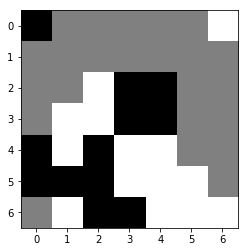

((3, 4), (4, 5)): n_v:  1171 q_all:+0.044316 q:-0.019806 q_m:+0.100000 p:0.385172
((0, 0), (2, 1)): n_v:   696 q_all:+0.064567 q:-0.014977 q_m:+0.080000 p:0.184752
((4, 0), (2, 1)): n_v:   175 q_all:+0.084330 q:+0.011081 q_m:+0.080000 p:0.035842
((6, 3), (4, 5)): n_v:   164 q_all:-0.013881 q:-0.033928 q_m:+0.080000 p:0.084277
((2, 4), (2, 5)): n_v:   156 q_all:-0.047382 q:-0.072159 q_m:-0.020000 p:0.096366
((2, 4), (4, 5)): n_v:    25 q_all:+0.031880 q:-0.020188 q_m:+0.080000 p:0.009069
((2, 3), (4, 5)): n_v:    24 q_all:+0.005377 q:-0.039406 q_m:+0.080000 p:0.010904
((2, 3), (2, 1)): n_v:    22 q_all:-0.018616 q:-0.011918 q_m:+0.080000 p:0.012085
((3, 3), (4, 5)): n_v:    22 q_all:-0.043810 q:-0.022407 q_m:+0.080000 p:0.013818
((3, 3), (2, 5)): n_v:     9 q_all:-0.105988 q:-0.071108 q_m:-0.040000 p:0.007384
((3, 3), (2, 1)): n_v:     8 q_all:-0.062163 q:-0.012205 q_m:+0.080000 p:0.005525
((0, 0), (1, 1)): n_v:     8 q_all:+0.002894 q:-0.042982 q_m:+0.020000 p:0.004067
((2, 3), (2, 5))

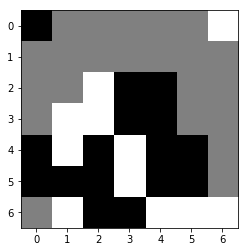

((6, 5), (5, 6)): n_v:  1451 q_all:+0.003380 q:-0.033384 q_m:-0.000000 p:0.281661
((6, 1), (6, 0)): n_v:   385 q_all:-0.005002 q:-0.057140 q_m:-0.000000 p:0.087316
((0, 6), (1, 6)): n_v:   280 q_all:-0.073512 q:-0.108728 q_m:-0.080000 p:0.137021
((4, 3), (3, 5)): n_v:   184 q_all:-0.052532 q:-0.055851 q_m:+0.060000 p:0.074888
((5, 3), (3, 5)): n_v:   127 q_all:-0.020908 q:-0.065186 q_m:+0.060000 p:0.036547
((2, 2), (1, 3)): n_v:    44 q_all:-0.032642 q:-0.076887 q_m:-0.000000 p:0.014737
((0, 6), (1, 5)): n_v:    29 q_all:-0.041096 q:-0.075778 q_m:-0.040000 p:0.010825
((0, 6), (1, 4)): n_v:    22 q_all:-0.004836 q:-0.081182 q_m:-0.020000 p:0.005040
((6, 6), (4, 6)): n_v:    20 q_all:-0.045873 q:-0.073213 q_m:-0.020000 p:0.007861
((2, 2), (1, 4)): n_v:    14 q_all:-0.042685 q:-0.088817 q_m:-0.020000 p:0.005510
((6, 4), (5, 6)): n_v:    13 q_all:-0.075678 q:-0.085742 q_m:-0.020000 p:0.006899
((0, 6), (2, 6)): n_v:    10 q_all:-0.062825 q:-0.101593 q_m:-0.100000 p:0.004782
((3, 1), (3, 0))

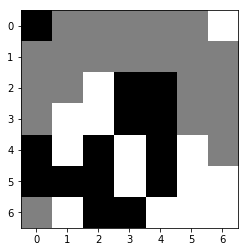

((5, 0), (6, 0)): n_v:   697 q_all:+0.010599 q:+0.003248 q_m:+0.060000 p:0.243762
((0, 0), (2, 1)): n_v:   473 q_all:+0.046653 q:-0.010270 q_m:+0.120000 p:0.096457
((0, 0), (1, 1)): n_v:   241 q_all:-0.007431 q:-0.030016 q_m:+0.060000 p:0.102128
((2, 4), (1, 5)): n_v:   151 q_all:+0.007707 q:-0.018447 q_m:+0.060000 p:0.054611
((4, 0), (2, 1)): n_v:   109 q_all:+0.036184 q:+0.005428 q_m:+0.120000 p:0.026786
((2, 4), (3, 5)): n_v:    77 q_all:+0.005937 q:-0.025389 q_m:+0.060000 p:0.028577
((2, 4), (2, 5)): n_v:    69 q_all:-0.066305 q:-0.056470 q_m:+0.020000 p:0.045609
((2, 3), (1, 3)): n_v:    66 q_all:-0.016605 q:-0.021094 q_m:+0.060000 p:0.030680
((2, 3), (1, 5)): n_v:    51 q_all:-0.022710 q:-0.028694 q_m:+0.040000 p:0.024686
((2, 4), (4, 6)): n_v:    39 q_all:+0.054695 q:-0.004037 q_m:+0.120000 p:0.006734
((2, 3), (1, 1)): n_v:    33 q_all:-0.046217 q:-0.050740 q_m:+0.040000 p:0.019206
((3, 4), (4, 6)): n_v:    30 q_all:+0.019956 q:+0.010658 q_m:+0.120000 p:0.009565
((3, 3), (2, 1))

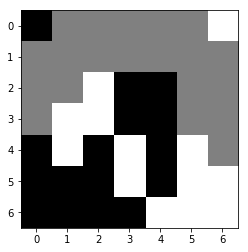

((4, 5), (3, 5)): n_v:  1606 q_all:+0.021042 q:-0.039733 q_m:+0.080000 p:0.559828
((5, 6), (3, 5)): n_v:   222 q_all:+0.010109 q:-0.081393 q_m:+0.060000 p:0.087167
((2, 2), (1, 3)): n_v:   157 q_all:-0.000424 q:-0.048657 q_m:+0.040000 p:0.068459
((0, 6), (1, 5)): n_v:    82 q_all:+0.010125 q:-0.059156 q_m:-0.000000 p:0.032411
((4, 3), (3, 5)): n_v:    71 q_all:-0.058701 q:-0.059264 q_m:+0.060000 p:0.047060
((2, 2), (1, 4)): n_v:    51 q_all:-0.023361 q:-0.068263 q_m:+0.020000 p:0.027084
((5, 5), (3, 5)): n_v:    35 q_all:-0.066816 q:-0.083118 q_m:+0.060000 p:0.024586
((5, 3), (3, 5)): n_v:    34 q_all:-0.027726 q:-0.075263 q_m:+0.060000 p:0.018788
((2, 2), (1, 1)): n_v:    24 q_all:+0.010581 q:-0.037571 q_m:-0.000000 p:0.009711
((0, 6), (0, 5)): n_v:    18 q_all:-0.017123 q:-0.079941 q_m:-0.040000 p:0.009116
((3, 1), (3, 0)): n_v:    16 q_all:-0.062563 q:-0.031556 q_m:-0.000000 p:0.011412
((0, 6), (1, 4)): n_v:    15 q_all:+0.021639 q:-0.057878 q_m:+0.020000 p:0.005330
((4, 5), (4, 6))

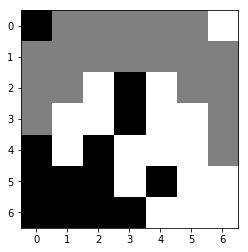

((0, 0), (2, 1)): n_v:  2565 q_all:+0.022622 q:-0.036652 q_m:+0.040000 p:0.449468
((3, 3), (2, 5)): n_v:   413 q_all:-0.050370 q:-0.040774 q_m:+0.040000 p:0.161078
((3, 3), (2, 1)): n_v:   332 q_all:-0.044006 q:-0.051352 q_m:+0.040000 p:0.123339
((2, 3), (2, 1)): n_v:   323 q_all:-0.020520 q:-0.045583 q_m:+0.040000 p:0.097693
((4, 0), (2, 1)): n_v:   298 q_all:+0.050591 q:-0.015882 q_m:+0.040000 p:0.027789
((2, 3), (2, 5)): n_v:   207 q_all:-0.017030 q:-0.043170 q_m:+0.040000 p:0.060635
((5, 4), (4, 6)): n_v:   119 q_all:+0.042506 q:+0.001129 q_m:+0.080000 p:0.013946
((2, 3), (1, 5)): n_v:    68 q_all:+0.020259 q:-0.039894 q_m:-0.000000 p:0.012442
((4, 2), (2, 1)): n_v:    30 q_all:-0.072823 q:-0.040749 q_m:+0.040000 p:0.014003
((2, 3), (1, 3)): n_v:    27 q_all:-0.018589 q:-0.065664 q_m:+0.020000 p:0.008061
((0, 0), (2, 0)): n_v:    26 q_all:-0.011189 q:-0.109991 q_m:-0.040000 p:0.007266
((0, 0), (1, 1)): n_v:    12 q_all:-0.022171 q:-0.081192 q_m:-0.020000 p:0.003909
((2, 3), (1, 1))

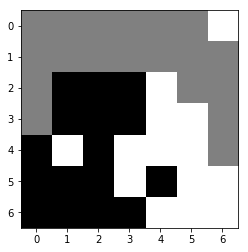

((2, 4), (1, 2)): n_v:  3154 q_all:+0.011761 q:-0.065470 q_m:+0.080000 p:0.393004
((2, 4), (1, 3)): n_v:   944 q_all:-0.032156 q:-0.096503 q_m:+0.060000 p:0.232694
((2, 4), (1, 4)): n_v:   200 q_all:-0.050881 q:-0.107124 q_m:+0.020000 p:0.059684
((0, 6), (1, 5)): n_v:   127 q_all:-0.028260 q:-0.113711 q_m:-0.020000 p:0.030104
((0, 6), (0, 5)): n_v:   126 q_all:-0.017571 q:-0.103553 q_m:-0.020000 p:0.026129
((4, 1), (3, 0)): n_v:    93 q_all:+0.018369 q:-0.021511 q_m:+0.100000 p:0.009808
((5, 6), (3, 6)): n_v:    55 q_all:-0.062929 q:-0.158719 q_m:-0.040000 p:0.018517
((3, 5), (4, 6)): n_v:    51 q_all:+0.006254 q:-0.075316 q_m:-0.020000 p:0.006920
((3, 4), (1, 2)): n_v:    48 q_all:-0.074278 q:-0.098195 q_m:+0.080000 p:0.017581
((2, 4), (2, 5)): n_v:    39 q_all:-0.034265 q:-0.126033 q_m:-0.020000 p:0.009910
((2, 4), (0, 2)): n_v:    35 q_all:-0.075788 q:-0.115654 q_m:-0.040000 p:0.012948
((6, 6), (4, 6)): n_v:    28 q_all:-0.034296 q:-0.087699 q_m:-0.040000 p:0.007164
((4, 3), (2, 5))

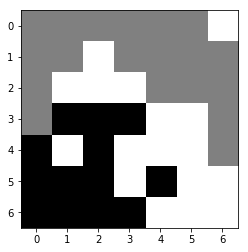

((3, 3), (2, 4)): n_v:  2692 q_all:+0.006601 q:-0.031440 q_m:+0.060000 p:0.562969
((3, 3), (1, 5)): n_v:   887 q_all:+0.004870 q:-0.076633 q_m:-0.040000 p:0.189734
((3, 1), (3, 0)): n_v:   635 q_all:+0.081423 q:-0.016302 q_m:+0.020000 p:0.004326
((3, 3), (1, 1)): n_v:   565 q_all:+0.007043 q:-0.055117 q_m:+0.040000 p:0.117681
((3, 1), (1, 1)): n_v:   154 q_all:-0.037364 q:-0.024319 q_m:+0.040000 p:0.050786
((3, 2), (2, 4)): n_v:    63 q_all:-0.001677 q:-0.048661 q_m:+0.040000 p:0.014632
((3, 2), (1, 1)): n_v:    57 q_all:-0.049433 q:-0.059589 q_m:+0.040000 p:0.020493
((4, 2), (2, 4)): n_v:    38 q_all:-0.059053 q:-0.044486 q_m:+0.040000 p:0.014680
((3, 3), (2, 5)): n_v:    19 q_all:-0.000245 q:-0.035849 q_m:-0.000000 p:0.004487
((3, 2), (1, 3)): n_v:    16 q_all:-0.041176 q:-0.059285 q_m:+0.040000 p:0.005485
((5, 4), (4, 6)): n_v:    11 q_all:+0.012671 q:+0.012085 q_m:+0.080000 p:0.002234
((3, 3), (1, 4)): n_v:     7 q_all:-0.070438 q:-0.111130 q_m:-0.040000 p:0.003134
((5, 4), (3, 6))

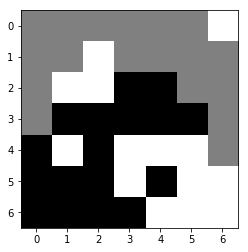

((0, 6), (2, 5)): n_v:  6330 q_all:+0.005679 q:-0.055227 q_m:+0.060000 p:0.826815
((4, 3), (2, 5)): n_v:   314 q_all:-0.031051 q:-0.090821 q_m:+0.060000 p:0.067497
((4, 5), (2, 5)): n_v:   141 q_all:-0.041637 q:-0.077773 q_m:+0.060000 p:0.033758
((4, 4), (2, 5)): n_v:   127 q_all:-0.069050 q:-0.068120 q_m:+0.060000 p:0.038503
((1, 2), (1, 3)): n_v:    58 q_all:+0.017288 q:-0.065954 q_m:+0.040000 p:0.006030
((2, 2), (1, 4)): n_v:    12 q_all:+0.013571 q:-0.108945 q_m:+0.020000 p:0.001351
((1, 2), (1, 4)): n_v:     9 q_all:-0.002968 q:-0.107289 q_m:+0.020000 p:0.001501
((1, 2), (0, 2)): n_v:     5 q_all:-0.098940 q:-0.086610 q_m:-0.040000 p:0.001763
((1, 2), (0, 3)): n_v:     4 q_all:-0.092929 q:-0.109510 q_m:-0.040000 p:0.001300
((4, 5), (4, 6)): n_v:     3 q_all:-0.042443 q:-0.064636 q_m:-0.000000 p:0.000707
((0, 6), (1, 5)): n_v:     3 q_all:-0.053039 q:-0.088767 q_m:-0.000000 p:0.000932
((2, 1), (3, 0)): n_v:     3 q_all:-0.032401 q:-0.096721 q_m:+0.040000 p:0.000836
((0, 6), (0, 4))

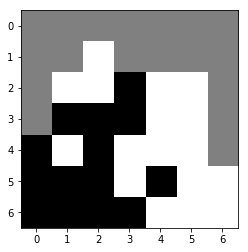

((5, 4), (3, 6)): n_v:  5047 q_all:+0.086232 q:-0.011253 q_m:+0.060000 p:0.023111
((3, 1), (3, 0)): n_v:  2875 q_all:+0.016922 q:-0.027807 q_m:+0.040000 p:0.290897
((2, 3), (1, 3)): n_v:   539 q_all:-0.004184 q:-0.037869 q_m:+0.080000 p:0.083129
((2, 3), (1, 5)): n_v:   472 q_all:-0.043349 q:-0.024735 q_m:+0.020000 p:0.117203
((3, 3), (1, 5)): n_v:   450 q_all:-0.057924 q:-0.056406 q_m:+0.020000 p:0.124190
((3, 3), (1, 1)): n_v:   229 q_all:-0.037141 q:-0.049873 q_m:+0.060000 p:0.054286
((5, 0), (3, 0)): n_v:   196 q_all:+0.029633 q:-0.074957 q_m:+0.020000 p:0.013381
((5, 4), (4, 6)): n_v:   168 q_all:+0.029682 q:+0.004269 q_m:+0.100000 p:0.011654
((2, 3), (1, 1)): n_v:   152 q_all:-0.036139 q:-0.028331 q_m:+0.060000 p:0.035814
((2, 3), (1, 4)): n_v:    49 q_all:-0.044728 q:-0.052426 q_m:+0.040000 p:0.012341
((3, 1), (1, 1)): n_v:    47 q_all:-0.046742 q:-0.020818 q_m:+0.060000 p:0.012182
((5, 2), (3, 0)): n_v:    37 q_all:-0.121514 q:-0.097521 q_m:+0.020000 p:0.014855
((3, 2), (1, 1))

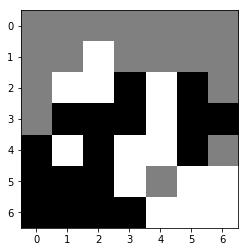

((4, 3), (5, 4)): n_v:  2531 q_all:-0.044158 q:-0.024766 q_m:+0.040000 p:0.054223
((6, 6), (5, 4)): n_v:  2275 q_all:-0.020611 q:-0.034888 q_m:+0.020000 p:0.007446
((4, 4), (4, 6)): n_v:  2212 q_all:+0.009957 q:-0.091615 q_m:+0.060000 p:0.006584
((6, 6), (4, 6)): n_v:   648 q_all:-0.158805 q:-0.088422 q_m:+0.060000 p:0.209850
((6, 5), (4, 6)): n_v:   367 q_all:-0.117677 q:-0.099493 q_m:+0.060000 p:0.083939
((4, 4), (2, 6)): n_v:   341 q_all:-0.071160 q:-0.079717 q_m:+0.060000 p:0.033219
((6, 4), (4, 6)): n_v:   293 q_all:-0.116235 q:-0.093242 q_m:+0.060000 p:0.065811
((2, 4), (4, 6)): n_v:   235 q_all:-0.153919 q:-0.071981 q_m:+0.060000 p:0.073629
((5, 5), (4, 6)): n_v:   231 q_all:-0.125546 q:-0.071556 q_m:+0.080000 p:0.057024
((5, 6), (5, 4)): n_v:   166 q_all:-0.063963 q:-0.023436 q_m:+0.020000 p:0.012838
((4, 1), (2, 0)): n_v:    92 q_all:-0.208212 q:-0.137110 q_m:-0.020000 p:0.040733
((3, 4), (4, 6)): n_v:    69 q_all:-0.098006 q:-0.107983 q_m:+0.060000 p:0.012769
((3, 4), (2, 6))

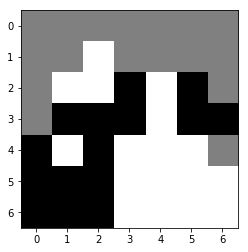

((2, 3), (1, 3)): n_v:  2563 q_all:+0.059794 q:-0.018040 q_m:+0.100000 p:0.489509
((3, 5), (4, 6)): n_v:  1800 q_all:+0.116243 q:+0.016575 q_m:+0.100000 p:0.065238
((3, 1), (3, 0)): n_v:   282 q_all:+0.054248 q:-0.004193 q_m:+0.060000 p:0.058307
((2, 5), (1, 5)): n_v:   112 q_all:-0.007051 q:-0.055754 q_m:+0.020000 p:0.042020
((2, 5), (2, 6)): n_v:    62 q_all:-0.037593 q:-0.102078 q_m:-0.020000 p:0.028635
((3, 2), (1, 3)): n_v:    60 q_all:+0.020025 q:-0.045778 q_m:+0.080000 p:0.018038
((2, 3), (1, 1)): n_v:    52 q_all:+0.047779 q:-0.016229 q_m:+0.080000 p:0.011660
((3, 5), (1, 3)): n_v:    48 q_all:+0.027852 q:-0.019288 q_m:+0.080000 p:0.013243
((3, 3), (1, 1)): n_v:    48 q_all:+0.042950 q:-0.066013 q_m:+0.080000 p:0.011341
((2, 5), (1, 3)): n_v:    42 q_all:+0.032077 q:-0.011166 q_m:+0.080000 p:0.011046
((2, 3), (1, 5)): n_v:    33 q_all:-0.014057 q:-0.040441 q_m:-0.000000 p:0.013261
((3, 1), (1, 1)): n_v:    29 q_all:+0.036571 q:-0.011546 q_m:+0.080000 p:0.007475
((3, 3), (1, 5))

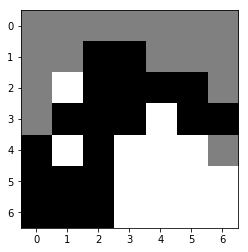

((4, 5), (4, 6)): n_v:  3420 q_all:-0.011362 q:-0.016989 q_m:-0.000000 p:0.389919
((4, 1), (2, 0)): n_v:  1591 q_all:+0.035732 q:-0.061336 q_m:-0.060000 p:0.008912
((2, 1), (1, 1)): n_v:   385 q_all:-0.018429 q:-0.000441 q_m:-0.000000 p:0.050167
((6, 6), (4, 6)): n_v:   156 q_all:-0.046739 q:-0.027522 q_m:-0.020000 p:0.030445
((2, 1), (2, 0)): n_v:    99 q_all:-0.153409 q:-0.052126 q_m:-0.040000 p:0.043936
((6, 5), (4, 6)): n_v:    85 q_all:-0.043487 q:-0.054488 q_m:-0.020000 p:0.016104
((2, 1), (3, 0)): n_v:    39 q_all:-0.045198 q:-0.014959 q_m:-0.000000 p:0.007532
((3, 4), (4, 6)): n_v:    29 q_all:-0.097692 q:-0.077290 q_m:-0.020000 p:0.009325
((6, 4), (4, 6)): n_v:    26 q_all:-0.059286 q:-0.115924 q_m:-0.020000 p:0.005923
((4, 5), (2, 6)): n_v:    24 q_all:-0.059238 q:-0.063661 q_m:+0.020000 p:0.005529
((3, 4), (1, 5)): n_v:    24 q_all:-0.127275 q:-0.114379 q_m:-0.020000 p:0.009253
((3, 4), (2, 6)): n_v:    19 q_all:-0.085830 q:-0.093170 q_m:+0.020000 p:0.005663
((3, 4), (1, 4))

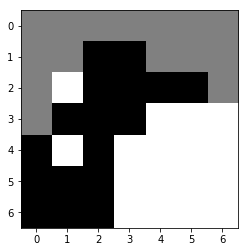

((3, 1), (3, 0)): n_v:  7130 q_all:+0.035504 q:+0.003270 q_m:+0.100000 p:0.477157
((2, 5), (2, 6)): n_v:   721 q_all:+0.060870 q:-0.020898 q_m:+0.100000 p:0.007048
((5, 0), (3, 0)): n_v:   221 q_all:+0.052030 q:-0.042699 q_m:+0.080000 p:0.006781
((4, 0), (2, 0)): n_v:   116 q_all:+0.037302 q:-0.063851 q_m:+0.040000 p:0.007353
((1, 2), (3, 0)): n_v:    89 q_all:+0.047284 q:-0.012506 q_m:+0.080000 p:0.003449
((3, 1), (2, 0)): n_v:    63 q_all:+0.027490 q:-0.071805 q_m:+0.060000 p:0.005351
((1, 3), (1, 4)): n_v:    21 q_all:-0.037252 q:-0.059462 q_m:+0.020000 p:0.004952
((2, 2), (3, 0)): n_v:    20 q_all:+0.037594 q:-0.022809 q_m:+0.080000 p:0.001206
((5, 1), (3, 0)): n_v:     7 q_all:-0.133300 q:-0.072557 q_m:+0.080000 p:0.003217
((5, 2), (3, 0)): n_v:     4 q_all:-0.085488 q:-0.061560 q_m:+0.080000 p:0.001242
((2, 5), (1, 6)): n_v:     3 q_all:-0.055020 q:-0.079983 q_m:+0.020000 p:0.000873
((1, 2), (1, 1)): n_v:     3 q_all:-0.005938 q:-0.025249 q_m:+0.060000 p:0.000603
((1, 2), (0, 3))

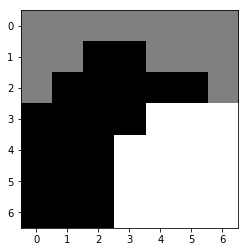

((3, 5), (2, 6)): n_v:  5638 q_all:+0.027204 q:-0.106808 q_m:-0.040000 p:0.151412
((3, 6), (1, 4)): n_v:  3254 q_all:-0.000654 q:+0.003325 q_m:+0.060000 p:0.169945
((3, 5), (1, 4)): n_v:  1109 q_all:-0.023501 q:-0.013045 q_m:+0.060000 p:0.117839
((3, 4), (1, 5)): n_v:   406 q_all:-0.127425 q:-0.137104 q_m:-0.020000 p:0.125101
((3, 6), (1, 5)): n_v:   402 q_all:-0.084726 q:-0.091947 q_m:-0.020000 p:0.092622
((3, 5), (1, 5)): n_v:   304 q_all:-0.117707 q:-0.133714 q_m:-0.020000 p:0.088291
((3, 4), (1, 4)): n_v:   248 q_all:-0.052197 q:-0.045314 q_m:+0.060000 p:0.042237
((3, 6), (1, 6)): n_v:    33 q_all:-0.078730 q:-0.137790 q_m:-0.060000 p:0.007374
((4, 4), (2, 6)): n_v:    32 q_all:-0.214445 q:-0.189018 q_m:-0.060000 p:0.015068
((4, 6), (2, 6)): n_v:    29 q_all:-0.130519 q:-0.146971 q_m:-0.060000 p:0.009294
((3, 4), (2, 6)): n_v:    26 q_all:-0.161876 q:-0.173056 q_m:-0.060000 p:0.009818
((3, 5), (1, 6)): n_v:     9 q_all:-0.157430 q:-0.137267 q_m:-0.060000 p:0.003228
((3, 4), (1, 6))

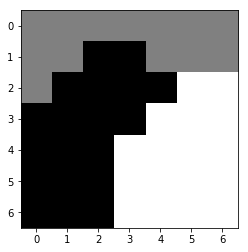

((1, 3), (1, 5)): n_v:  5585 q_all:+0.133165 q:+0.030490 q_m:+0.120000 p:0.013186
((1, 3), (1, 4)): n_v:  1320 q_all:-0.018689 q:+0.030910 q_m:+0.100000 p:0.126700
((2, 4), (1, 5)): n_v:   729 q_all:-0.015954 q:+0.030892 q_m:+0.140000 p:0.064631
((1, 2), (0, 1)): n_v:   547 q_all:-0.043273 q:+0.012076 q_m:+0.060000 p:0.088449
((1, 2), (1, 1)): n_v:   474 q_all:-0.043497 q:+0.025076 q_m:+0.060000 p:0.076892
((2, 1), (2, 0)): n_v:   293 q_all:-0.033877 q:-0.006110 q_m:+0.060000 p:0.039963
((1, 2), (0, 2)): n_v:   198 q_all:-0.032059 q:+0.023771 q_m:+0.060000 p:0.026175
((2, 1), (1, 0)): n_v:   149 q_all:-0.041510 q:-0.020483 q_m:+0.060000 p:0.023489
((3, 3), (1, 5)): n_v:   140 q_all:-0.045564 q:+0.004715 q_m:+0.120000 p:0.023549
((3, 0), (1, 1)): n_v:   127 q_all:-0.069743 q:-0.032344 q_m:+0.040000 p:0.029525
((1, 3), (0, 4)): n_v:   124 q_all:-0.070219 q:-0.004500 q_m:+0.060000 p:0.028871
((4, 0), (2, 0)): n_v:    90 q_all:-0.054819 q:-0.052569 q_m:+0.040000 p:0.017336
((2, 3), (1, 5))

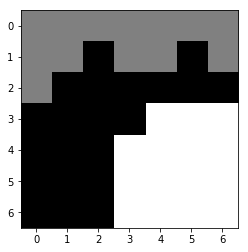

((3, 6), (1, 6)): n_v:  4376 q_all:-0.055102 q:-0.067992 q_m:-0.000000 p:0.071075
((3, 4), (1, 3)): n_v:  2269 q_all:-0.137297 q:-0.072459 q_m:+0.040000 p:0.399362
((3, 6), (1, 4)): n_v:  2202 q_all:-0.094863 q:-0.049187 q_m:+0.040000 p:0.169776
((3, 5), (1, 4)): n_v:   583 q_all:-0.154177 q:-0.067169 q_m:+0.040000 p:0.121851
((3, 4), (1, 6)): n_v:   519 q_all:-0.147966 q:-0.080739 q_m:-0.000000 p:0.101919
((3, 5), (1, 3)): n_v:   370 q_all:-0.156863 q:-0.049190 q_m:+0.040000 p:0.079187
((3, 4), (1, 4)): n_v:   176 q_all:-0.132853 q:-0.108051 q_m:+0.040000 p:0.029519
((3, 5), (1, 6)): n_v:    78 q_all:-0.209437 q:-0.085328 q_m:-0.000000 p:0.024893
-1 's turn
one move takes time(s):  0.9848153591156006


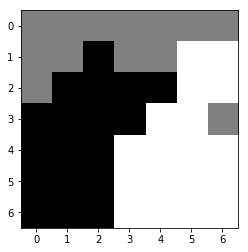

((2, 4), (3, 6)): n_v:  8783 q_all:+0.106286 q:+0.068052 q_m:+0.200000 p:0.783003
((2, 3), (1, 4)): n_v:   219 q_all:+0.077861 q:+0.005739 q_m:+0.100000 p:0.032513
((1, 2), (0, 2)): n_v:   127 q_all:-0.080896 q:+0.011595 q_m:+0.020000 p:0.060614
((1, 2), (0, 1)): n_v:   118 q_all:-0.052839 q:+0.000667 q_m:+0.020000 p:0.049712
((2, 1), (1, 0)): n_v:    16 q_all:-0.045596 q:-0.036668 q_m:+0.020000 p:0.006620
((1, 2), (1, 4)): n_v:    15 q_all:+0.068301 q:+0.000377 q_m:+0.080000 p:0.002582
((2, 2), (1, 4)): n_v:    10 q_all:-0.006299 q:-0.011910 q_m:+0.080000 p:0.003401
((2, 4), (0, 5)): n_v:     7 q_all:+0.035164 q:-0.014754 q_m:+0.080000 p:0.001825
((2, 1), (2, 0)): n_v:     6 q_all:-0.061815 q:-0.021263 q_m:+0.020000 p:0.002848
((1, 2), (1, 1)): n_v:     6 q_all:-0.049886 q:+0.007547 q_m:+0.020000 p:0.002861
((1, 2), (1, 0)): n_v:     4 q_all:-0.038752 q:-0.025205 q_m:-0.000000 p:0.001706
((3, 3), (1, 4)): n_v:     4 q_all:-0.021607 q:-0.023166 q_m:+0.080000 p:0.001527
((1, 2), (0, 3))

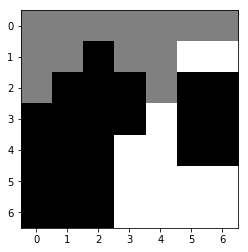

((1, 5), (2, 4)): n_v:  7046 q_all:-0.100959 q:-0.099470 q_m:-0.020000 p:0.374352
((1, 6), (2, 4)): n_v:  6072 q_all:-0.064940 q:-0.110949 q_m:-0.040000 p:0.088934
((4, 3), (2, 4)): n_v:   101 q_all:-0.137147 q:-0.142997 q_m:-0.040000 p:0.013258
((1, 5), (1, 3)): n_v:    82 q_all:-0.135197 q:-0.132780 q_m:-0.080000 p:0.010318
((4, 4), (2, 4)): n_v:    48 q_all:-0.149113 q:-0.144303 q_m:-0.040000 p:0.007250
((3, 4), (1, 3)): n_v:    39 q_all:-0.155584 q:-0.180492 q_m:-0.080000 p:0.006634
((1, 5), (1, 4)): n_v:    14 q_all:-0.226995 q:-0.234380 q_m:-0.100000 p:0.004195
((1, 6), (0, 4)): n_v:     4 q_all:-0.216758 q:-0.281467 q_m:-0.200000 p:0.001272
((1, 6), (1, 4)): n_v:     3 q_all:-0.383793 q:-0.217318 q_m:-0.120000 p:0.001421
((1, 5), (0, 4)): n_v:     2 q_all:-0.218951 q:-0.297070 q_m:-0.180000 p:0.000801
((1, 5), (0, 5)): n_v:     1 q_all:-0.252067 q:-0.260614 q_m:-0.180000 p:0.000469
((1, 5), (0, 3)): n_v:     1 q_all:-0.163753 q:-0.256740 q_m:-0.160000 p:0.000292
((1, 5), (0, 6))

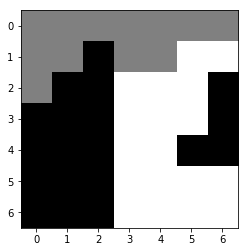

((1, 2), (1, 4)): n_v:  4823 q_all:+0.164010 q:+0.119420 q_m:+0.180000 p:0.272145
((2, 2), (1, 4)): n_v:  3174 q_all:+0.116000 q:+0.064922 q_m:+0.180000 p:0.456845
((2, 6), (1, 4)): n_v:   309 q_all:+0.116672 q:+0.056009 q_m:+0.180000 p:0.044136
((1, 2), (1, 3)): n_v:   285 q_all:+0.082295 q:+0.047626 q_m:+0.120000 p:0.058594
((3, 2), (1, 4)): n_v:   188 q_all:+0.094031 q:+0.045060 q_m:+0.180000 p:0.034751
((3, 6), (1, 4)): n_v:   113 q_all:+0.094445 q:+0.031483 q_m:+0.180000 p:0.020677
((2, 1), (1, 3)): n_v:    34 q_all:+0.056676 q:+0.004126 q_m:+0.100000 p:0.008581
((1, 2), (0, 3)): n_v:    33 q_all:+0.056848 q:+0.002407 q_m:+0.040000 p:0.008476
((1, 2), (0, 1)): n_v:    18 q_all:+0.051674 q:+0.008474 q_m:+0.040000 p:0.004806
((1, 2), (1, 1)): n_v:    11 q_all:+0.067652 q:+0.015866 q_m:+0.040000 p:0.002775
((1, 2), (0, 2)): n_v:    10 q_all:+0.032601 q:+0.017200 q_m:+0.040000 p:0.003154
((2, 1), (1, 0)): n_v:     8 q_all:+0.046756 q:-0.027956 q_m:+0.040000 p:0.002231
((2, 6), (0, 5))

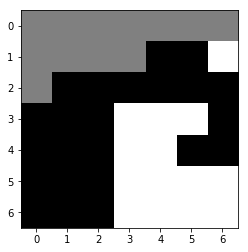

((1, 6), (0, 5)): n_v:  5703 q_all:-0.091536 q:-0.168560 q_m:-0.080000 p:0.456637
((1, 6), (0, 4)): n_v:  1149 q_all:-0.129571 q:-0.211566 q_m:-0.100000 p:0.180309
((3, 5), (1, 3)): n_v:   385 q_all:-0.130268 q:-0.118999 q_m:-0.020000 p:0.061012
((3, 3), (1, 2)): n_v:   367 q_all:-0.138619 q:-0.085812 q_m:-0.060000 p:0.064397
((3, 4), (1, 3)): n_v:   320 q_all:-0.227166 q:-0.120607 q_m:-0.020000 p:0.113496
((3, 3), (1, 1)): n_v:   200 q_all:-0.186095 q:-0.105680 q_m:-0.100000 p:0.054368
((3, 3), (1, 3)): n_v:    91 q_all:-0.190238 q:-0.094150 q_m:-0.020000 p:0.025612
((3, 4), (1, 2)): n_v:    88 q_all:-0.191485 q:-0.110128 q_m:-0.060000 p:0.024969
((1, 6), (0, 6)): n_v:    49 q_all:-0.224852 q:-0.233369 q_m:-0.120000 p:0.017438
-1 's turn
one move takes time(s):  1.4343814849853516


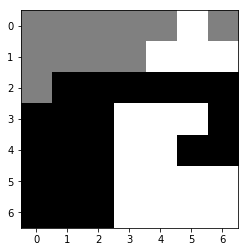

((2, 6), (0, 4)): n_v:  7768 q_all:+0.134863 q:+0.098887 q_m:+0.200000 p:0.401233
((2, 3), (0, 4)): n_v:   616 q_all:+0.120870 q:+0.210164 q_m:+0.200000 p:0.045632
((2, 6), (0, 6)): n_v:   353 q_all:+0.087686 q:+0.081073 q_m:+0.200000 p:0.050255
((2, 3), (0, 2)): n_v:   306 q_all:+0.035866 q:+0.026439 q_m:+0.080000 p:0.074554
((2, 2), (1, 3)): n_v:   273 q_all:+0.111657 q:+0.006932 q_m:+0.140000 p:0.026513
((2, 2), (0, 4)): n_v:   269 q_all:+0.102448 q:+0.145547 q_m:+0.200000 p:0.030813
((2, 5), (0, 4)): n_v:   244 q_all:+0.075928 q:+0.091651 q_m:+0.200000 p:0.040409
((2, 1), (1, 0)): n_v:   136 q_all:+0.054385 q:+0.029128 q_m:+0.100000 p:0.028370
((2, 4), (0, 2)): n_v:   128 q_all:+0.047908 q:+0.016066 q_m:+0.080000 p:0.028243
((2, 1), (2, 0)): n_v:   125 q_all:+0.060061 q:+0.048595 q_m:+0.100000 p:0.024600
((2, 1), (0, 2)): n_v:    95 q_all:+0.005153 q:+0.011901 q_m:+0.080000 p:0.028916
((2, 1), (1, 1)): n_v:    68 q_all:+0.036271 q:+0.029035 q_m:+0.100000 p:0.016687
((2, 4), (0, 6))

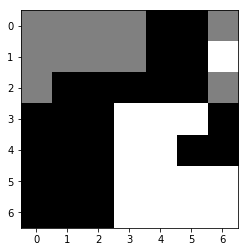

((1, 6), (2, 6)): n_v: 11436 q_all:-0.093939 q:-0.113063 q_m:-0.060000 p:0.442693
((3, 5), (1, 3)): n_v:   249 q_all:-0.103600 q:-0.089202 q_m:-0.000000 p:0.001038
((3, 4), (1, 3)): n_v:    61 q_all:-0.124907 q:-0.131608 q_m:-0.000000 p:0.003254
((3, 4), (2, 6)): n_v:    15 q_all:-0.203405 q:-0.183499 q_m:-0.080000 p:0.003535
((3, 3), (1, 3)): n_v:    14 q_all:-0.118231 q:-0.101440 q_m:-0.000000 p:0.000419
((1, 6), (0, 6)): n_v:     7 q_all:-0.207601 q:-0.237556 q_m:-0.100000 p:0.001708
((3, 3), (1, 1)): n_v:     7 q_all:-0.173773 q:-0.115941 q_m:-0.120000 p:0.001031
((3, 3), (1, 2)): n_v:     6 q_all:-0.150146 q:-0.090325 q_m:-0.080000 p:0.000437
((4, 4), (2, 6)): n_v:     3 q_all:-0.224042 q:-0.229132 q_m:-0.080000 p:0.001066
((3, 4), (1, 2)): n_v:     1 q_all:-0.180418 q:-0.146139 q_m:-0.080000 p:0.000080
-1 's turn
one move takes time(s):  0.5309219360351562


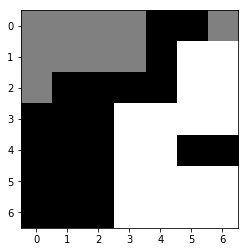

((0, 5), (0, 6)): n_v: 12587 q_all:+0.146652 q:+0.182374 q_m:+0.160000 p:0.646979
((0, 4), (0, 6)): n_v:  1064 q_all:+0.073745 q:+0.066443 q_m:+0.140000 p:0.154757
((1, 4), (0, 6)): n_v:   117 q_all:+0.051841 q:+0.091425 q_m:+0.140000 p:0.021688
((2, 1), (1, 0)): n_v:    39 q_all:+0.013759 q:+0.017559 q_m:+0.080000 p:0.010054
((2, 1), (2, 0)): n_v:    36 q_all:+0.006907 q:+0.015875 q_m:+0.080000 p:0.009698
((0, 4), (1, 3)): n_v:    35 q_all:+0.021030 q:+0.030509 q_m:+0.080000 p:0.008711
((0, 4), (0, 2)): n_v:    34 q_all:+0.009307 q:-0.003179 q_m:+0.060000 p:0.009174
((0, 4), (0, 3)): n_v:    31 q_all:+0.001596 q:+0.045949 q_m:+0.080000 p:0.008789
((2, 1), (1, 1)): n_v:    25 q_all:+0.013458 q:+0.001763 q_m:+0.080000 p:0.006601
((2, 1), (1, 2)): n_v:    24 q_all:-0.001105 q:+0.023202 q_m:+0.080000 p:0.007026
((2, 3), (0, 2)): n_v:    21 q_all:+0.008411 q:+0.067629 q_m:+0.060000 p:0.005661
((2, 4), (0, 6)): n_v:    15 q_all:+0.076739 q:+0.093254 q_m:+0.140000 p:0.002125
((1, 4), (0, 2))

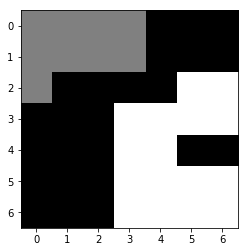

((3, 3), (1, 2)): n_v:  5522 q_all:-0.048427 q:-0.050679 q_m:-0.040000 p:0.051385
((2, 5), (1, 3)): n_v:  2860 q_all:-0.120655 q:-0.110683 q_m:+0.040000 p:0.229974
((3, 3), (1, 3)): n_v:  1754 q_all:-0.104083 q:-0.055748 q_m:+0.040000 p:0.089520
((3, 4), (1, 3)): n_v:  1652 q_all:-0.168084 q:-0.199711 q_m:+0.040000 p:0.272136
((3, 3), (1, 1)): n_v:  1250 q_all:-0.151182 q:-0.068860 q_m:-0.080000 p:0.168430
((3, 5), (1, 3)): n_v:  1035 q_all:-0.168443 q:-0.182090 q_m:+0.040000 p:0.171244
((3, 4), (1, 2)): n_v:    63 q_all:-0.186205 q:-0.186410 q_m:-0.040000 p:0.012401
((2, 5), (0, 3)): n_v:    11 q_all:-0.244065 q:-0.300798 q_m:-0.080000 p:0.003579
-1 's turn


This is a random move


one move takes time(s):  0.3861198425292969


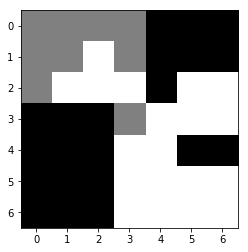

((2, 4), (3, 3)): n_v:  7136 q_all:+0.124818 q:+0.142747 q_m:+0.284000 p:0.099619
((0, 4), (1, 3)): n_v:  1658 q_all:+0.025624 q:+0.069210 q_m:+0.180000 p:0.256862
((1, 4), (3, 3)): n_v:   500 q_all:+0.076822 q:+0.076466 q_m:+0.256000 p:0.008549
((5, 1), (3, 3)): n_v:   318 q_all:+0.068490 q:+0.050483 q_m:+0.256000 p:0.012539
((1, 5), (3, 3)): n_v:   157 q_all:+0.058522 q:+0.103154 q_m:+0.256000 p:0.010453
((0, 5), (1, 3)): n_v:   154 q_all:-0.005648 q:+0.013146 q_m:+0.160000 p:0.037013
((4, 5), (3, 3)): n_v:   122 q_all:+0.058273 q:+0.063838 q_m:+0.256000 p:0.008196
((4, 1), (3, 3)): n_v:    65 q_all:+0.012317 q:+0.042934 q_m:+0.256000 p:0.012477
((1, 5), (1, 3)): n_v:    56 q_all:-0.009213 q:+0.028628 q_m:+0.160000 p:0.014019
((3, 1), (1, 3)): n_v:    38 q_all:-0.027736 q:+0.047315 q_m:+0.160000 p:0.011371
((3, 2), (1, 3)): n_v:    33 q_all:+0.020527 q:+0.028660 q_m:+0.160000 p:0.005590
((5, 2), (3, 3)): n_v:    30 q_all:+0.034591 q:+0.039851 q_m:+0.256000 p:0.003892
((3, 1), (3, 3))

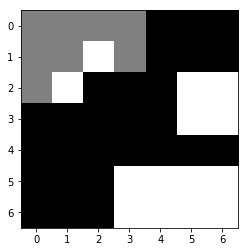

((1, 2), (1, 3)): n_v: 11495 q_all:-0.095555 q:-0.068644 q_m:-0.040000 p:0.894164
((2, 1), (1, 3)): n_v:   250 q_all:-0.135996 q:-0.161163 q_m:-0.060000 p:0.037809
((2, 5), (1, 3)): n_v:   141 q_all:-0.195176 q:-0.167948 q_m:-0.060000 p:0.036492
((3, 5), (1, 3)): n_v:    69 q_all:-0.186564 q:-0.139802 q_m:-0.060000 p:0.016866
((2, 1), (2, 0)): n_v:    47 q_all:-0.191205 q:-0.199023 q_m:-0.160000 p:0.012052
((1, 2), (1, 1)): n_v:     2 q_all:-0.232423 q:-0.264010 q_m:-0.200000 p:0.000812
((1, 2), (2, 0)): n_v:     1 q_all:-0.247726 q:-0.208254 q_m:-0.180000 p:0.000381
((1, 2), (0, 3)): n_v:     1 q_all:-0.297281 q:-0.191551 q_m:-0.160000 p:0.000333
((1, 2), (0, 1)): n_v:     0 q_all:-0.324308 q:-0.369847 q_m:-0.256000 p:0.000026
((1, 2), (1, 0)): n_v:     0 q_all:-0.295943 q:-0.303905 q_m:-0.284000 p:0.000005
((2, 5), (0, 3)): n_v:     0 q_all:-0.276428 q:-0.340713 q_m:-0.180000 p:0.000037
((2, 1), (0, 3)): n_v:     0 q_all:-0.264370 q:-0.320616 q_m:-0.180000 p:0.000107
((2, 1), (0, 1))

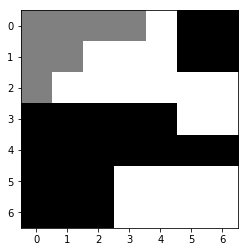

((0, 5), (0, 3)): n_v:  8525 q_all:+0.103973 q:+0.065417 q_m:+0.200000 p:0.883093
((3, 0), (1, 1)): n_v:  5100 q_all:+0.197723 q:+0.068832 q_m:+0.160000 p:0.006375
((1, 5), (0, 3)): n_v:   949 q_all:+0.104241 q:+0.088112 q_m:+0.200000 p:0.097835
((3, 3), (1, 1)): n_v:    22 q_all:+0.064368 q:+0.061582 q_m:+0.160000 p:0.003912
((3, 1), (1, 1)): n_v:    20 q_all:+0.048051 q:+0.033017 q_m:+0.160000 p:0.004015
((3, 2), (1, 1)): n_v:     9 q_all:+0.051944 q:+0.032655 q_m:+0.160000 p:0.001940
((3, 0), (2, 0)): n_v:     4 q_all:+0.049911 q:+0.028631 q_m:+0.100000 p:0.000955
((4, 1), (2, 0)): n_v:     0 q_all:+0.030342 q:-0.044146 q_m:+0.080000 p:0.000030
((4, 2), (2, 0)): n_v:     0 q_all:+0.035590 q:-0.031026 q_m:+0.080000 p:0.000014
((3, 0), (1, 0)): n_v:     0 q_all:+0.052127 q:+0.010319 q_m:+0.080000 p:0.000169
((3, 1), (1, 0)): n_v:     0 q_all:+0.029159 q:-0.047103 q_m:+0.080000 p:0.000073
((4, 0), (2, 0)): n_v:     0 q_all:+0.042769 q:-0.013078 q_m:+0.080000 p:0.000079
((3, 2), (2, 0))

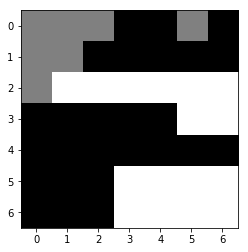

((2, 3), (0, 5)): n_v:  5896 q_all:-0.043929 q:-0.096648 q_m:-0.000000 p:0.427591
((2, 6), (0, 5)): n_v:  1622 q_all:-0.046469 q:-0.096036 q_m:-0.000000 p:0.124694
((2, 3), (0, 1)): n_v:   509 q_all:-0.246962 q:-0.309487 q_m:-0.160000 p:0.215042
((2, 4), (0, 5)): n_v:   358 q_all:-0.056676 q:-0.042963 q_m:-0.000000 p:0.033681
((2, 1), (0, 2)): n_v:   335 q_all:-0.076205 q:-0.127335 q_m:-0.080000 p:0.042969
((2, 5), (0, 5)): n_v:   198 q_all:-0.107451 q:-0.158923 q_m:-0.000000 p:0.035807
((2, 4), (0, 2)): n_v:   151 q_all:-0.122528 q:-0.123290 q_m:-0.080000 p:0.031065
((2, 3), (0, 2)): n_v:    87 q_all:-0.142031 q:-0.172764 q_m:-0.080000 p:0.021224
((2, 1), (2, 0)): n_v:    72 q_all:-0.133869 q:-0.155943 q_m:-0.100000 p:0.016247
((2, 1), (0, 1)): n_v:    55 q_all:-0.208995 q:-0.308722 q_m:-0.160000 p:0.019948
((2, 2), (0, 1)): n_v:    33 q_all:-0.225618 q:-0.271819 q_m:-0.160000 p:0.012920
((2, 2), (0, 2)): n_v:    31 q_all:-0.127051 q:-0.142820 q_m:-0.080000 p:0.006806
((2, 1), (1, 1))

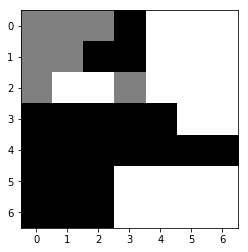

((1, 2), (2, 3)): n_v:  5773 q_all:+0.052548 q:+0.026331 q_m:+0.140000 p:0.333525
((0, 3), (2, 3)): n_v:  2586 q_all:+0.082122 q:-0.072523 q_m:+0.120000 p:0.002725
((4, 5), (2, 3)): n_v:    45 q_all:+0.031909 q:-0.007403 q_m:+0.120000 p:0.004388
((3, 1), (2, 3)): n_v:    22 q_all:-0.117575 q:-0.083866 q_m:+0.120000 p:0.008726
((3, 3), (1, 1)): n_v:    21 q_all:+0.037652 q:-0.022813 q_m:+0.080000 p:0.001837
((4, 1), (2, 3)): n_v:     9 q_all:-0.121326 q:-0.128092 q_m:+0.120000 p:0.003805
((4, 4), (2, 3)): n_v:     4 q_all:-0.005833 q:-0.003339 q_m:+0.120000 p:0.000764
((4, 3), (2, 3)): n_v:     2 q_all:-0.047742 q:-0.032041 q_m:+0.120000 p:0.000635
((4, 2), (2, 3)): n_v:     2 q_all:-0.084187 q:-0.071737 q_m:+0.120000 p:0.000545
((3, 0), (1, 1)): n_v:     1 q_all:-0.077949 q:-0.063168 q_m:+0.080000 p:0.000172
((1, 3), (1, 1)): n_v:     1 q_all:-0.030501 q:+0.092092 q_m:+0.080000 p:0.000124
((3, 1), (1, 1)): n_v:     1 q_all:-0.093732 q:-0.149759 q_m:+0.080000 p:0.000284
((0, 3), (1, 1))

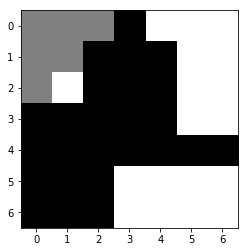

((2, 1), (0, 2)): n_v:  8266 q_all:+0.038809 q:-0.090676 q_m:-0.020000 p:0.440554
((0, 4), (0, 2)): n_v:  1048 q_all:-0.073742 q:-0.080984 q_m:-0.020000 p:0.241071
((2, 1), (1, 1)): n_v:   993 q_all:-0.062215 q:-0.047597 q_m:-0.040000 p:0.198538
((2, 1), (2, 0)): n_v:   374 q_all:-0.067886 q:-0.099881 q_m:-0.040000 p:0.080348
((2, 1), (1, 0)): n_v:    51 q_all:-0.222839 q:-0.285843 q_m:-0.120000 p:0.028867
((2, 1), (0, 1)): n_v:     7 q_all:-0.287848 q:-0.243521 q_m:-0.100000 p:0.005229
((2, 1), (0, 0)): n_v:     7 q_all:-0.209303 q:-0.321929 q_m:-0.140000 p:0.004126
-1 's turn
one move takes time(s):  0.4811363220214844


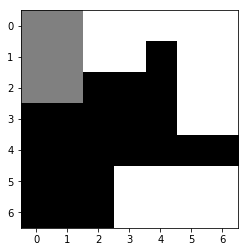

((3, 2), (1, 1)): n_v:  5063 q_all:-0.000800 q:-0.130584 q_m:+0.100000 p:0.024433
((2, 2), (2, 1)): n_v:  2105 q_all:-0.040053 q:-0.080437 q_m:+0.080000 p:0.099963
((2, 2), (1, 1)): n_v:  2085 q_all:-0.046341 q:-0.021641 q_m:+0.120000 p:0.127978
((3, 0), (1, 1)): n_v:   431 q_all:-0.050484 q:-0.094190 q_m:+0.100000 p:0.030392
((2, 2), (0, 1)): n_v:   334 q_all:-0.051924 q:-0.028962 q_m:+0.100000 p:0.024584
((3, 3), (1, 1)): n_v:   284 q_all:-0.086285 q:-0.104734 q_m:+0.100000 p:0.042324
((3, 1), (1, 1)): n_v:   251 q_all:-0.065035 q:-0.065915 q_m:+0.100000 p:0.025778
((4, 0), (2, 1)): n_v:   250 q_all:-0.056653 q:-0.105704 q_m:+0.060000 p:0.021059
((2, 3), (0, 1)): n_v:   201 q_all:-0.091112 q:-0.068601 q_m:+0.100000 p:0.031975
((2, 3), (1, 1)): n_v:   162 q_all:-0.088185 q:-0.085442 q_m:+0.100000 p:0.024655
((3, 0), (2, 0)): n_v:   128 q_all:-0.133761 q:-0.203983 q_m:+0.040000 p:0.030389
((3, 0), (1, 0)): n_v:    95 q_all:-0.100616 q:-0.125038 q_m:+0.020000 p:0.017056
((4, 0), (2, 0))

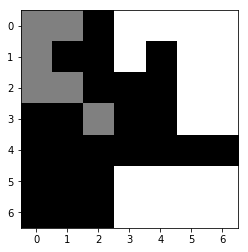

((1, 3), (3, 2)): n_v:  7296 q_all:+0.100665 q:+0.088368 q_m:+0.180000 p:0.422068
((5, 3), (3, 2)): n_v:  2127 q_all:+0.007445 q:+0.057797 q_m:+0.180000 p:0.386389
((5, 4), (3, 2)): n_v:   334 q_all:-0.070917 q:+0.040418 q_m:+0.180000 p:0.133977
((0, 3), (2, 1)): n_v:   126 q_all:+0.006489 q:+0.026461 q_m:+0.100000 p:0.023395
((0, 3), (0, 1)): n_v:    64 q_all:-0.034011 q:-0.058752 q_m:+0.020000 p:0.021208
((1, 3), (2, 1)): n_v:    29 q_all:+0.001465 q:+0.018932 q_m:+0.100000 p:0.005813
((1, 3), (0, 1)): n_v:    26 q_all:-0.001111 q:-0.011593 q_m:+0.020000 p:0.006962
-1 's turn


This is a random move


one move takes time(s):  0.3074951171875


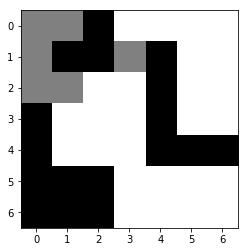

((0, 2), (1, 3)): n_v:  6403 q_all:-0.100323 q:-0.009445 q_m:-0.000000 p:0.131617
((1, 1), (1, 3)): n_v:  5782 q_all:-0.061758 q:+0.007335 q_m:-0.020000 p:0.009448
((3, 4), (1, 3)): n_v:    54 q_all:-0.133824 q:-0.118956 q_m:-0.020000 p:0.005315
((1, 1), (2, 1)): n_v:     6 q_all:-0.213303 q:-0.174199 q_m:-0.040000 p:0.001361
((4, 0), (2, 1)): n_v:     1 q_all:-0.226143 q:-0.209807 q_m:-0.060000 p:0.000252
((0, 2), (2, 1)): n_v:     1 q_all:-0.184411 q:-0.217158 q_m:-0.060000 p:0.000289
((1, 1), (0, 0)): n_v:     0 q_all:-0.375636 q:-0.519393 q_m:-0.160000 p:0.000165
((0, 2), (2, 0)): n_v:     0 q_all:-0.424247 q:-0.613744 q_m:-0.140000 p:0.000186
((0, 2), (0, 0)): n_v:     0 q_all:-0.319063 q:-0.411772 q_m:-0.180000 p:0.000013
((1, 2), (1, 0)): n_v:     0 q_all:-0.250329 q:-0.297214 q_m:-0.180000 p:0.000001
((1, 1), (2, 0)): n_v:     0 q_all:-0.361002 q:-0.521670 q_m:-0.120000 p:0.000076
((0, 2), (1, 0)): n_v:     0 q_all:-0.417598 q:-0.575997 q_m:-0.180000 p:0.000021
((4, 0), (2, 0))

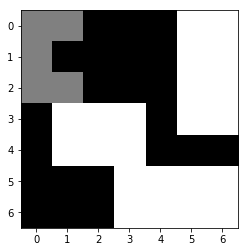

((3, 1), (2, 1)): n_v:  9087 q_all:+0.197334 q:+0.104579 q_m:+0.180000 p:0.540809
((3, 3), (2, 1)): n_v:    75 q_all:+0.139700 q:+0.109250 q_m:+0.160000 p:0.011851
((4, 2), (2, 1)): n_v:    32 q_all:+0.119572 q:+0.058929 q_m:+0.160000 p:0.006765
((4, 3), (2, 1)): n_v:    32 q_all:+0.114147 q:+0.055252 q_m:+0.160000 p:0.006768
((4, 1), (2, 1)): n_v:    28 q_all:+0.126810 q:+0.077024 q_m:+0.160000 p:0.005420
((3, 1), (2, 0)): n_v:     4 q_all:+0.083840 q:+0.059599 q_m:+0.100000 p:0.001254
((3, 1), (1, 0)): n_v:     0 q_all:-0.014196 q:-0.095490 q_m:+0.040000 p:0.000238
((4, 1), (2, 0)): n_v:     0 q_all:+0.042034 q:-0.014914 q_m:+0.080000 p:0.000013
((4, 2), (2, 0)): n_v:     0 q_all:+0.027738 q:-0.050655 q_m:+0.080000 p:0.000035
((3, 2), (2, 0)): n_v:     0 q_all:+0.027499 q:-0.051253 q_m:+0.080000 p:0.000112
((3, 2), (1, 0)): n_v:     0 q_all:-0.020636 q:-0.111590 q_m:+0.040000 p:0.000411
-1 's turn
one move takes time(s):  0.23393607139587402


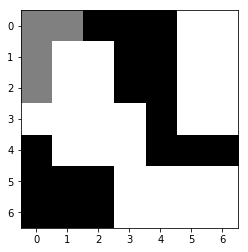

((0, 2), (0, 1)): n_v:  6743 q_all:-0.071680 q:-0.262237 q_m:-0.080000 p:0.130803
((0, 2), (2, 0)): n_v:  2274 q_all:-0.249141 q:-0.211979 q_m:-0.020000 p:0.514937
((4, 0), (2, 0)): n_v:   478 q_all:-0.271877 q:-0.204608 q_m:-0.020000 p:0.131021
((0, 3), (0, 1)): n_v:   326 q_all:-0.329800 q:-0.311475 q_m:-0.100000 p:0.128664
((0, 2), (1, 0)): n_v:    99 q_all:-0.403231 q:-0.376759 q_m:-0.100000 p:0.054491
((2, 3), (0, 1)): n_v:    50 q_all:-0.334915 q:-0.362141 q_m:-0.100000 p:0.020446
((1, 3), (0, 1)): n_v:    19 q_all:-0.465415 q:-0.328193 q_m:-0.100000 p:0.013168
((0, 2), (0, 0)): n_v:    10 q_all:-0.422621 q:-0.603189 q_m:-0.140000 p:0.006044
1 's turn
one move takes time(s):  0.1612541675567627


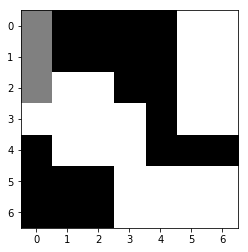

((2, 1), (1, 0)): n_v:  9994 q_all:+0.239893 q:+0.176418 q_m:+0.180000 p:0.785253
((3, 0), (1, 0)): n_v:  1203 q_all:+0.108780 q:+0.162966 q_m:+0.160000 p:0.061125
((2, 1), (2, 0)): n_v:   256 q_all:+0.082547 q:+0.255016 q_m:+0.140000 p:0.029416
((2, 1), (0, 0)): n_v:    98 q_all:+0.052648 q:+0.117940 q_m:+0.160000 p:0.018251
((2, 2), (1, 0)): n_v:    92 q_all:+0.045135 q:+0.007302 q_m:+0.160000 p:0.019027
((3, 2), (1, 0)): n_v:    43 q_all:-0.023274 q:+0.083445 q_m:+0.160000 p:0.015950
((3, 1), (1, 0)): n_v:    31 q_all:-0.024084 q:+0.090620 q_m:+0.160000 p:0.011676
((3, 2), (2, 0)): n_v:    12 q_all:-0.021061 q:+0.103215 q_m:+0.120000 p:0.004454
((2, 2), (0, 0)): n_v:     9 q_all:+0.032226 q:+0.045098 q_m:+0.160000 p:0.002214
((4, 2), (2, 0)): n_v:     3 q_all:-0.071790 q:+0.026164 q_m:+0.120000 p:0.001434
((4, 1), (2, 0)): n_v:     1 q_all:-0.056092 q:+0.137614 q_m:+0.120000 p:0.000629
((2, 2), (2, 0)): n_v:     1 q_all:+0.003432 q:+0.057933 q_m:+0.120000 p:0.000350
-1 's turn
one m

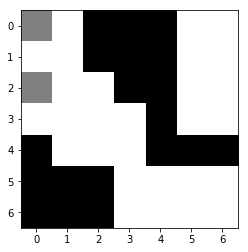

((4, 0), (2, 0)): n_v:  8997 q_all:-0.343201 q:+0.132648 q_m:+0.020000 p:0.123306
((0, 2), (2, 0)): n_v:  4087 q_all:-0.451331 q:-0.271229 q_m:+0.020000 p:0.777677
((1, 2), (2, 0)): n_v:   279 q_all:-0.524570 q:-0.667805 q_m:+0.020000 p:0.086667
((0, 2), (0, 0)): n_v:   136 q_all:-0.388292 q:-0.595275 q_m:-0.060000 p:0.011945
((1, 2), (0, 0)): n_v:     0 q_all:-0.549151 q:-0.875251 q_m:-0.060000 p:0.000272
1 's turn
one move takes time(s):  0.17424941062927246


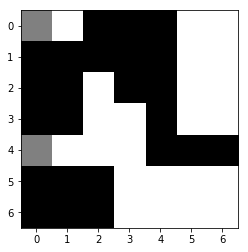

((4, 1), (4, 0)): n_v: 11208 q_all:+0.580377 q:+0.618363 q_m:+0.160000 p:0.623017
((3, 2), (4, 0)): n_v:   257 q_all:+0.086550 q:+0.138667 q_m:+0.140000 p:0.228550
((2, 2), (4, 0)): n_v:   130 q_all:+0.280871 q:+0.278402 q_m:+0.140000 p:0.073463
((0, 1), (0, 0)): n_v:   111 q_all:+0.301789 q:+0.277475 q_m:+0.080000 p:0.058744
((4, 2), (4, 0)): n_v:    12 q_all:+0.062474 q:+0.097434 q_m:+0.140000 p:0.011789
((2, 2), (0, 0)): n_v:     2 q_all:-0.258959 q:-0.471598 q_m:+0.060000 p:0.004390
-1 's turn
one move takes time(s):  0.12791037559509277


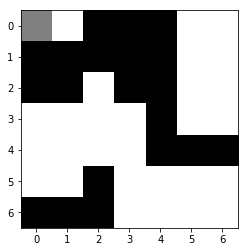

((0, 2), (0, 0)): n_v: 10151 q_all:-0.557993 q:-0.852405 q_m:-0.120000 p:0.250403
((2, 0), (0, 0)): n_v:  2658 q_all:-0.641952 q:-0.806534 q_m:-0.120000 p:0.334055
((2, 1), (0, 0)): n_v:   382 q_all:-0.639775 q:-0.801208 q_m:-0.120000 p:0.046076
((1, 0), (0, 0)): n_v:   235 q_all:-1.000000 q:+5.000000 q_m:-0.100000 p:0.169566
((1, 2), (0, 0)): n_v:    81 q_all:-0.730724 q:-0.970210 q_m:-0.120000 p:0.023087
1 's turn
one move takes time(s):  0.1601712703704834


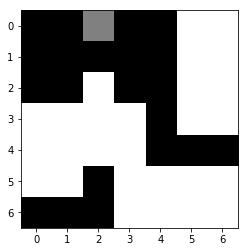

((2, 2), (0, 2)): n_v: 14089 q_all:+0.692688 q:+0.773982 q_m:+0.368000 p:0.986237
-1 's turn
one move takes time(s):  0.24320292472839355


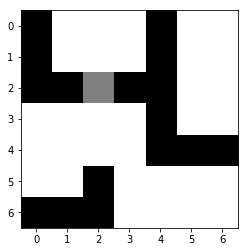

((0, 0), (2, 2)): n_v:  4184 q_all:-0.786288 q:-0.710154 q_m:-0.080000 p:0.120580
((1, 0), (2, 2)): n_v:  3277 q_all:-0.783035 q:-0.703864 q_m:-0.080000 p:0.079183
((4, 4), (2, 2)): n_v:  1935 q_all:-0.822614 q:-0.867542 q_m:-0.080000 p:0.157487
((0, 4), (2, 2)): n_v:  1644 q_all:-0.840562 q:-0.889809 q_m:-0.080000 p:0.176439
((3, 4), (2, 2)): n_v:  1599 q_all:-0.839290 q:-0.942771 q_m:-0.080000 p:0.168841
((2, 4), (2, 2)): n_v:   945 q_all:-0.830763 q:-0.933192 q_m:-0.080000 p:0.088136
((2, 0), (2, 2)): n_v:   874 q_all:-0.840643 q:-0.920860 q_m:-0.080000 p:0.093895
((1, 4), (2, 2)): n_v:   449 q_all:-0.855987 q:-0.958353 q_m:-0.080000 p:0.058276
((2, 1), (2, 2)): n_v:    67 q_all:-1.000000 q:+5.000000 q_m:-0.060000 p:0.022938
1 's turn
one move takes time(s):  0.08101630210876465


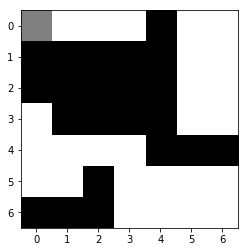

((0, 1), (0, 0)): n_v:  7266 q_all:+1.000000 q:+5.000000 q_m:+0.180000 p:0.787173
((0, 2), (0, 0)): n_v:   368 q_all:+0.778955 q:+0.758987 q_m:+0.160000 p:0.209794
this self play has 72 steps, time elapsed 160.7054078578949
winner is 1.0
episode 25 finished
episode 26 now start
it seems the reset did nothing
reset successful
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.9246103763580322


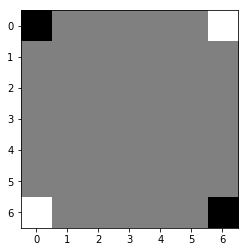

((0, 0), (1, 1)): n_v:  1597 q_all:+0.009228 q:-0.010933 q_m:+0.020000 p:0.321690
((6, 6), (5, 5)): n_v:  1401 q_all:+0.011815 q:-0.001538 q_m:+0.020000 p:0.272150
((0, 0), (0, 1)): n_v:   529 q_all:+0.009285 q:-0.009038 q_m:+0.020000 p:0.106552
((0, 0), (1, 0)): n_v:   515 q_all:+0.010073 q:-0.008174 q_m:+0.020000 p:0.102531
((6, 6), (5, 6)): n_v:   473 q_all:+0.007769 q:-0.010781 q_m:+0.020000 p:0.097303
((6, 6), (6, 5)): n_v:   432 q_all:+0.010214 q:+0.003939 q_m:+0.020000 p:0.085905
((0, 0), (2, 1)): n_v:    10 q_all:-0.003111 q:-0.020594 q_m:-0.000000 p:0.002356
((0, 0), (1, 2)): n_v:     8 q_all:-0.001029 q:-0.008157 q_m:-0.000000 p:0.001870
((6, 6), (4, 5)): n_v:     8 q_all:-0.003600 q:-0.019468 q_m:-0.000000 p:0.001982
((6, 6), (5, 4)): n_v:     6 q_all:+0.003908 q:-0.007887 q_m:-0.000000 p:0.001436
((0, 0), (2, 2)): n_v:     4 q_all:+0.000561 q:-0.017540 q_m:-0.000000 p:0.000960
((6, 6), (4, 4)): n_v:     4 q_all:-0.005621 q:-0.023309 q_m:-0.000000 p:0.000996
((0, 0), (2, 0))

((0, 6), (1, 5)): n_v:  1840 q_all:-0.012653 q:-0.024221 q_m:-0.000000 p:0.334592
((6, 0), (5, 1)): n_v:  1215 q_all:-0.010593 q:-0.040010 q_m:-0.000000 p:0.214143
((0, 6), (1, 6)): n_v:  1098 q_all:-0.013106 q:-0.029322 q_m:-0.000000 p:0.201056
((6, 0), (5, 0)): n_v:   656 q_all:-0.010548 q:-0.034806 q_m:-0.000000 p:0.115543
((0, 6), (0, 5)): n_v:   431 q_all:-0.014401 q:-0.038042 q_m:-0.000000 p:0.080395
((6, 0), (6, 1)): n_v:   271 q_all:-0.012284 q:-0.024326 q_m:-0.000000 p:0.049061
((0, 6), (2, 6)): n_v:     6 q_all:-0.021136 q:-0.032436 q_m:-0.020000 p:0.001308
((0, 6), (1, 4)): n_v:     4 q_all:-0.013613 q:-0.033227 q_m:-0.020000 p:0.000914
((0, 6), (2, 5)): n_v:     3 q_all:-0.023968 q:-0.056262 q_m:-0.020000 p:0.000691
((0, 6), (2, 4)): n_v:     1 q_all:-0.034796 q:-0.055180 q_m:-0.020000 p:0.000408
((6, 0), (5, 2)): n_v:     1 q_all:-0.023604 q:-0.040314 q_m:-0.020000 p:0.000380
((6, 0), (4, 1)): n_v:     1 q_all:-0.027510 q:-0.031867 q_m:-0.020000 p:0.000235
((0, 6), (0, 4))

((6, 6), (5, 5)): n_v:  1834 q_all:+0.010606 q:-0.007033 q_m:+0.020000 p:0.214885
((0, 0), (1, 1)): n_v:  1289 q_all:+0.009950 q:-0.017499 q_m:+0.020000 p:0.153054
((6, 6), (6, 5)): n_v:   956 q_all:+0.010653 q:-0.004188 q_m:+0.020000 p:0.111874
((0, 1), (1, 2)): n_v:   835 q_all:+0.009595 q:-0.005445 q_m:+0.020000 p:0.099885
((6, 6), (5, 6)): n_v:   694 q_all:+0.008765 q:-0.013872 q_m:+0.020000 p:0.084430
((0, 1), (0, 2)): n_v:   617 q_all:+0.011340 q:-0.010816 q_m:+0.020000 p:0.071203
((0, 0), (1, 0)): n_v:   543 q_all:+0.010607 q:-0.005985 q_m:+0.020000 p:0.063644
((6, 6), (4, 5)): n_v:    14 q_all:+0.008345 q:-0.025485 q_m:-0.000000 p:0.001830
((0, 0), (2, 1)): n_v:     9 q_all:-0.003620 q:-0.029246 q_m:-0.000000 p:0.001474
((6, 6), (6, 4)): n_v:     7 q_all:-0.001793 q:-0.016038 q_m:-0.000000 p:0.001172
((6, 6), (5, 4)): n_v:     6 q_all:+0.001539 q:-0.012434 q_m:-0.000000 p:0.000931
((0, 0), (0, 2)): n_v:     5 q_all:+0.005542 q:-0.026725 q_m:-0.000000 p:0.000763
((0, 0), (2, 2))

((0, 6), (1, 6)): n_v:  1140 q_all:-0.013820 q:-0.030046 q_m:-0.000000 p:0.155133
((1, 5), (0, 4)): n_v:  1033 q_all:-0.010089 q:-0.038201 q_m:-0.000000 p:0.130655
((6, 0), (5, 0)): n_v:   965 q_all:-0.010263 q:-0.037818 q_m:-0.000000 p:0.122552
((1, 5), (1, 4)): n_v:   820 q_all:-0.000614 q:-0.038131 q_m:-0.000000 p:0.083765
((1, 5), (2, 6)): n_v:   563 q_all:-0.011966 q:-0.025672 q_m:-0.000000 p:0.073950
((6, 0), (5, 1)): n_v:   489 q_all:-0.010767 q:-0.042805 q_m:-0.000000 p:0.062661
((1, 5), (2, 4)): n_v:   324 q_all:+0.000955 q:-0.042006 q_m:-0.000000 p:0.031743
((0, 6), (0, 5)): n_v:   257 q_all:-0.014546 q:-0.046527 q_m:-0.000000 p:0.035515
((1, 5), (2, 5)): n_v:   249 q_all:-0.013654 q:-0.041893 q_m:-0.000000 p:0.033837
((6, 0), (6, 1)): n_v:   210 q_all:-0.012023 q:-0.026154 q_m:-0.000000 p:0.027619
((0, 6), (0, 4)): n_v:     4 q_all:+0.000354 q:-0.052311 q_m:-0.020000 p:0.000340
((0, 6), (1, 4)): n_v:     4 q_all:+0.000538 q:-0.050455 q_m:-0.020000 p:0.000425
((1, 5), (3, 6))

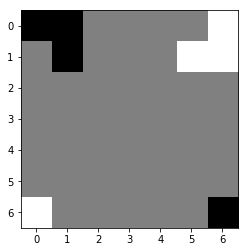

((6, 6), (6, 5)): n_v:  1605 q_all:+0.010894 q:-0.005509 q_m:+0.020000 p:0.262178
((6, 6), (5, 5)): n_v:   679 q_all:+0.011293 q:-0.007527 q_m:+0.020000 p:0.110122
((1, 1), (2, 1)): n_v:   560 q_all:+0.008734 q:-0.017926 q_m:+0.020000 p:0.094973
((0, 1), (0, 2)): n_v:   386 q_all:+0.016933 q:-0.006430 q_m:+0.020000 p:0.056340
((0, 1), (1, 2)): n_v:   341 q_all:+0.012401 q:-0.008740 q_m:+0.020000 p:0.054255
((1, 1), (2, 0)): n_v:   300 q_all:+0.006462 q:-0.007151 q_m:+0.020000 p:0.052838
((1, 1), (2, 2)): n_v:   277 q_all:+0.016528 q:+0.006585 q_m:+0.020000 p:0.040711
((6, 6), (5, 6)): n_v:   273 q_all:+0.008853 q:-0.013399 q_m:+0.020000 p:0.046327
((0, 0), (1, 0)): n_v:   199 q_all:+0.012749 q:+0.012282 q_m:+0.020000 p:0.031509
((6, 6), (4, 5)): n_v:    15 q_all:+0.013380 q:-0.026731 q_m:-0.000000 p:0.002292
((1, 1), (3, 1)): n_v:    12 q_all:+0.000013 q:-0.020768 q_m:-0.000000 p:0.002355
((0, 0), (2, 1)): n_v:    10 q_all:-0.003735 q:-0.034451 q_m:-0.000000 p:0.002118
((6, 6), (6, 4))

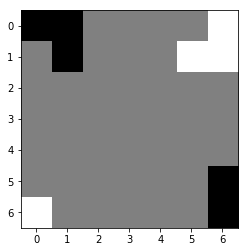

((6, 0), (5, 0)): n_v:   884 q_all:-0.014949 q:-0.043306 q_m:-0.000000 p:0.210999
((1, 5), (0, 4)): n_v:   707 q_all:-0.013607 q:-0.049051 q_m:-0.000000 p:0.165677
((1, 5), (1, 4)): n_v:   705 q_all:-0.003067 q:-0.043847 q_m:-0.000000 p:0.140022
((0, 6), (0, 5)): n_v:   294 q_all:-0.014934 q:-0.041271 q_m:-0.000000 p:0.070211
((6, 0), (5, 1)): n_v:   274 q_all:-0.014669 q:-0.048642 q_m:-0.000000 p:0.065288
((6, 0), (6, 1)): n_v:   272 q_all:-0.016880 q:-0.032286 q_m:-0.000000 p:0.066693
((1, 5), (2, 6)): n_v:   147 q_all:-0.010755 q:-0.036725 q_m:-0.000000 p:0.033213
((1, 5), (2, 5)): n_v:   122 q_all:-0.008618 q:-0.045210 q_m:-0.000000 p:0.026638
((1, 5), (2, 4)): n_v:    67 q_all:+0.004648 q:-0.044626 q_m:-0.000000 p:0.011556
((0, 6), (1, 4)): n_v:     6 q_all:+0.001400 q:-0.054630 q_m:-0.020000 p:0.001035
((1, 6), (1, 4)): n_v:     4 q_all:+0.003346 q:-0.055336 q_m:-0.020000 p:0.000824
((0, 6), (0, 4)): n_v:     3 q_all:+0.001423 q:-0.054758 q_m:-0.020000 p:0.000644
((1, 6), (3, 6))

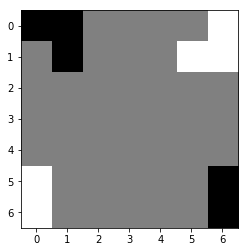

((5, 6), (6, 5)): n_v:   865 q_all:+0.010133 q:-0.017282 q_m:+0.020000 p:0.206402
((5, 6), (4, 5)): n_v:   383 q_all:+0.015771 q:-0.026756 q_m:+0.020000 p:0.083066
((5, 6), (5, 5)): n_v:   280 q_all:+0.009202 q:-0.010833 q_m:+0.020000 p:0.068030
((5, 6), (4, 6)): n_v:   214 q_all:+0.020904 q:-0.032482 q_m:+0.020000 p:0.042015
((0, 1), (0, 2)): n_v:   186 q_all:+0.018319 q:-0.008911 q_m:+0.020000 p:0.038503
((1, 1), (2, 1)): n_v:   179 q_all:+0.009156 q:-0.023897 q_m:+0.020000 p:0.043517
((0, 1), (1, 2)): n_v:   127 q_all:+0.015183 q:-0.010325 q_m:+0.020000 p:0.027930
((1, 1), (2, 0)): n_v:   109 q_all:+0.006763 q:-0.009339 q_m:+0.020000 p:0.027612
((1, 1), (2, 2)): n_v:    96 q_all:+0.016577 q:-0.003770 q_m:+0.020000 p:0.020612
((0, 0), (1, 0)): n_v:    92 q_all:+0.010592 q:+0.008290 q_m:+0.020000 p:0.021979
((6, 6), (4, 5)): n_v:     4 q_all:+0.020760 q:-0.030219 q_m:-0.000000 p:0.000983
((0, 0), (0, 2)): n_v:     3 q_all:+0.023505 q:-0.027917 q_m:-0.000000 p:0.000596
((5, 6), (3, 5))

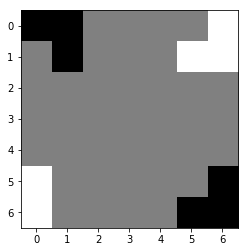

((1, 5), (0, 4)): n_v:   591 q_all:-0.006419 q:-0.052034 q_m:-0.000000 p:0.208457
((1, 5), (1, 4)): n_v:   491 q_all:+0.002860 q:-0.044045 q_m:-0.000000 p:0.152008
((0, 6), (0, 5)): n_v:   256 q_all:-0.015231 q:-0.045112 q_m:-0.000000 p:0.100937
((5, 0), (6, 1)): n_v:   114 q_all:-0.015826 q:-0.057783 q_m:-0.000000 p:0.045468
((5, 0), (5, 1)): n_v:   102 q_all:-0.013135 q:-0.055438 q_m:-0.000000 p:0.039182
((1, 5), (2, 6)): n_v:    92 q_all:-0.011721 q:-0.042442 q_m:-0.000000 p:0.034711
((1, 5), (2, 4)): n_v:    60 q_all:+0.009882 q:-0.045641 q_m:-0.000000 p:0.016700
((5, 0), (4, 0)): n_v:    49 q_all:-0.010940 q:-0.046927 q_m:-0.000000 p:0.018455
((1, 5), (2, 5)): n_v:    45 q_all:-0.010800 q:-0.047270 q_m:-0.000000 p:0.016905
((5, 0), (4, 1)): n_v:    24 q_all:-0.007430 q:-0.047839 q_m:-0.000000 p:0.008610
((0, 6), (0, 4)): n_v:     4 q_all:-0.014268 q:-0.058252 q_m:-0.020000 p:0.001896
((0, 6), (1, 4)): n_v:     3 q_all:-0.001620 q:-0.053751 q_m:-0.020000 p:0.001277
((1, 6), (0, 4))

((5, 6), (4, 6)): n_v:   245 q_all:+0.022818 q:-0.040878 q_m:+0.020000 p:0.092094
((1, 1), (2, 0)): n_v:   195 q_all:+0.011373 q:-0.012255 q_m:+0.020000 p:0.084510
((0, 0), (1, 0)): n_v:   182 q_all:+0.013829 q:+0.003553 q_m:+0.020000 p:0.076628
((5, 6), (4, 5)): n_v:   153 q_all:+0.016664 q:-0.032561 q_m:+0.020000 p:0.061982
((5, 6), (5, 5)): n_v:   138 q_all:+0.014799 q:-0.010552 q_m:+0.020000 p:0.057472
((1, 1), (2, 1)): n_v:    82 q_all:+0.000357 q:-0.024392 q_m:+0.020000 p:0.040347
((6, 5), (6, 4)): n_v:    77 q_all:+0.014245 q:-0.010287 q_m:+0.020000 p:0.032537
((0, 1), (0, 2)): n_v:    66 q_all:-0.009547 q:-0.012642 q_m:+0.020000 p:0.035396
((0, 1), (1, 3)): n_v:    66 q_all:+0.016798 q:-0.021053 q_m:+0.040000 p:0.027060
((6, 5), (5, 4)): n_v:    64 q_all:+0.014909 q:-0.007513 q_m:+0.020000 p:0.026640
((0, 1), (0, 3)): n_v:    37 q_all:+0.022543 q:-0.029432 q_m:+0.040000 p:0.014219
((0, 1), (1, 2)): n_v:    36 q_all:-0.001496 q:-0.015060 q_m:+0.020000 p:0.017886
((1, 1), (2, 2))

((5, 0), (5, 1)): n_v:   240 q_all:-0.006233 q:-0.069410 q_m:-0.000000 p:0.095185
((0, 4), (0, 5)): n_v:   222 q_all:-0.001961 q:-0.064897 q_m:-0.000000 p:0.082883
((5, 0), (6, 1)): n_v:   171 q_all:-0.009127 q:-0.073685 q_m:-0.000000 p:0.070765
((5, 0), (4, 0)): n_v:    84 q_all:-0.006507 q:-0.064226 q_m:-0.000000 p:0.033627
((0, 4), (1, 3)): n_v:    73 q_all:+0.016751 q:-0.067809 q_m:-0.000000 p:0.019542
((0, 4), (1, 4)): n_v:    61 q_all:-0.004781 q:-0.062596 q_m:-0.000000 p:0.023730
((1, 5), (2, 4)): n_v:    56 q_all:-0.000472 q:-0.071638 q_m:-0.000000 p:0.020723
((5, 0), (4, 1)): n_v:    56 q_all:-0.006086 q:-0.062437 q_m:-0.000000 p:0.022195
((0, 4), (1, 2)): n_v:    51 q_all:-0.023993 q:-0.018654 q_m:+0.060000 p:0.025791
((1, 5), (2, 6)): n_v:    50 q_all:-0.023969 q:-0.065313 q_m:-0.000000 p:0.025299
((0, 4), (0, 3)): n_v:    37 q_all:+0.014248 q:-0.069769 q_m:-0.000000 p:0.010312
((1, 5), (2, 5)): n_v:    25 q_all:-0.035416 q:-0.069091 q_m:-0.000000 p:0.014285
((6, 0), (6, 2))

((4, 6), (2, 5)): n_v:   285 q_all:+0.029246 q:-0.027736 q_m:+0.080000 p:0.148489
((4, 6), (2, 6)): n_v:   168 q_all:+0.013625 q:+0.002097 q_m:+0.080000 p:0.102145
((4, 6), (3, 5)): n_v:   164 q_all:+0.042239 q:-0.030315 q_m:+0.020000 p:0.073382
((4, 6), (4, 5)): n_v:   127 q_all:+0.023367 q:-0.065155 q_m:+0.020000 p:0.070491
((1, 1), (2, 0)): n_v:   114 q_all:+0.037165 q:-0.024071 q_m:+0.020000 p:0.054131
((6, 5), (6, 4)): n_v:    58 q_all:+0.024618 q:-0.040538 q_m:+0.020000 p:0.032142
((6, 5), (5, 4)): n_v:    53 q_all:+0.029890 q:-0.025392 q_m:+0.020000 p:0.027451
((4, 6), (3, 6)): n_v:    52 q_all:+0.047562 q:-0.049611 q_m:+0.020000 p:0.021377
((0, 0), (1, 0)): n_v:    47 q_all:+0.031183 q:-0.019948 q_m:+0.020000 p:0.024377
((4, 6), (5, 5)): n_v:    46 q_all:+0.027750 q:-0.024313 q_m:+0.020000 p:0.024405
((1, 1), (2, 1)): n_v:    26 q_all:+0.004970 q:-0.038225 q_m:+0.020000 p:0.017638
((0, 1), (0, 2)): n_v:    16 q_all:-0.008919 q:-0.029594 q_m:+0.020000 p:0.012416
((1, 1), (2, 2))

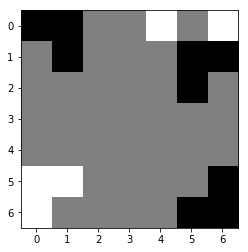

((0, 6), (2, 6)): n_v:  1132 q_all:+0.040119 q:-0.030355 q_m:+0.040000 p:0.189169
((0, 4), (0, 5)): n_v:   659 q_all:-0.019544 q:-0.038582 q_m:+0.020000 p:0.262577
((0, 4), (2, 6)): n_v:   482 q_all:+0.028766 q:-0.024438 q_m:+0.040000 p:0.101645
((0, 4), (1, 4)): n_v:   247 q_all:-0.069966 q:-0.041275 q_m:+0.020000 p:0.147026
((0, 4), (1, 2)): n_v:    46 q_all:-0.021510 q:-0.067340 q_m:-0.000000 p:0.018863
((5, 0), (6, 1)): n_v:    15 q_all:-0.115659 q:-0.120681 q_m:-0.060000 p:0.012216
((0, 6), (1, 4)): n_v:    14 q_all:-0.032365 q:-0.052199 q_m:-0.000000 p:0.006495
((5, 1), (5, 2)): n_v:    10 q_all:-0.073131 q:-0.120818 q_m:-0.060000 p:0.006495
((0, 4), (1, 3)): n_v:     8 q_all:-0.024813 q:-0.107229 q_m:-0.060000 p:0.003510
((0, 4), (2, 4)): n_v:     7 q_all:+0.015225 q:-0.051692 q_m:-0.000000 p:0.001922
((0, 4), (0, 3)): n_v:     7 q_all:-0.047743 q:-0.111372 q_m:-0.060000 p:0.003798
((5, 0), (4, 0)): n_v:     7 q_all:-0.132418 q:-0.115730 q_m:-0.060000 p:0.006649
((0, 6), (2, 4))

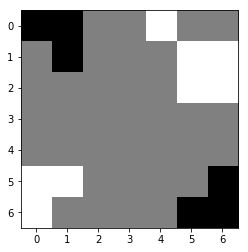

((5, 6), (3, 5)): n_v:   669 q_all:-0.039704 q:-0.048616 q_m:+0.040000 p:0.248666
((5, 6), (3, 6)): n_v:   219 q_all:-0.024890 q:-0.022589 q_m:+0.040000 p:0.067495
((0, 1), (1, 2)): n_v:   186 q_all:-0.043977 q:-0.051067 q_m:-0.020000 p:0.072936
((0, 0), (1, 0)): n_v:   179 q_all:-0.014419 q:-0.041653 q_m:-0.020000 p:0.047062
((6, 5), (5, 4)): n_v:   150 q_all:-0.012161 q:-0.056737 q_m:-0.020000 p:0.038034
((6, 5), (6, 4)): n_v:   104 q_all:-0.009897 q:-0.057851 q_m:-0.020000 p:0.025356
((5, 6), (4, 6)): n_v:    85 q_all:+0.013863 q:-0.073059 q_m:-0.020000 p:0.011908
((0, 1), (0, 2)): n_v:    80 q_all:-0.055786 q:-0.050986 q_m:-0.020000 p:0.035487
((1, 1), (2, 2)): n_v:    78 q_all:-0.030181 q:-0.040725 q_m:-0.020000 p:0.025871
((5, 6), (4, 5)): n_v:    66 q_all:-0.002456 q:-0.066464 q_m:-0.020000 p:0.014072
((1, 1), (2, 1)): n_v:    55 q_all:-0.038061 q:-0.068148 q_m:-0.020000 p:0.020165
((1, 1), (3, 1)): n_v:    44 q_all:-0.051139 q:-0.054712 q_m:-0.040000 p:0.018773
((0, 1), (1, 3))

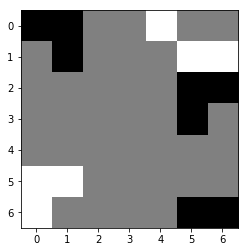

((1, 6), (3, 6)): n_v:  1092 q_all:+0.079831 q:+0.022094 q_m:+0.080000 p:0.534830
((1, 5), (3, 6)): n_v:   425 q_all:+0.095494 q:+0.010706 q_m:+0.080000 p:0.176116
((1, 5), (2, 4)): n_v:    73 q_all:+0.033505 q:-0.021425 q_m:+0.060000 p:0.051946
((5, 0), (3, 0)): n_v:    36 q_all:-0.038650 q:-0.092790 q_m:-0.040000 p:0.038489
((1, 5), (0, 6)): n_v:    20 q_all:-0.102839 q:-0.065545 q_m:-0.020000 p:0.026981
((5, 1), (3, 0)): n_v:    19 q_all:-0.034765 q:-0.097732 q_m:-0.040000 p:0.019885
((0, 4), (1, 4)): n_v:    14 q_all:-0.015501 q:-0.028714 q_m:+0.020000 p:0.013780
((0, 4), (1, 2)): n_v:    13 q_all:+0.007843 q:-0.027533 q_m:+0.040000 p:0.011281
((0, 4), (0, 2)): n_v:    11 q_all:+0.029198 q:-0.021954 q_m:+0.040000 p:0.008358
((0, 4), (1, 3)): n_v:     9 q_all:-0.032121 q:-0.054511 q_m:-0.020000 p:0.009541
((1, 6), (3, 4)): n_v:     6 q_all:+0.034660 q:-0.026968 q_m:+0.040000 p:0.004578
((0, 4), (2, 2)): n_v:     5 q_all:+0.006252 q:-0.051217 q_m:-0.000000 p:0.004816
((5, 1), (4, 2))

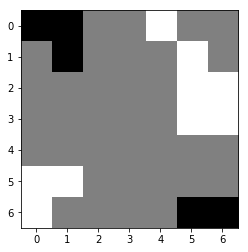

((6, 6), (4, 6)): n_v:   364 q_all:-0.051214 q:-0.046435 q_m:-0.000000 p:0.118400
((1, 1), (2, 1)): n_v:   325 q_all:-0.082534 q:-0.103292 q_m:-0.060000 p:0.149151
((1, 1), (2, 0)): n_v:   322 q_all:-0.086999 q:-0.086062 q_m:-0.060000 p:0.154007
((6, 6), (4, 5)): n_v:   176 q_all:-0.054294 q:-0.050496 q_m:-0.000000 p:0.059777
((1, 1), (2, 2)): n_v:   169 q_all:-0.068233 q:-0.073867 q_m:-0.060000 p:0.067244
((6, 5), (4, 5)): n_v:   108 q_all:-0.060465 q:-0.046285 q_m:-0.000000 p:0.039736
((6, 5), (5, 6)): n_v:   108 q_all:-0.149712 q:-0.118402 q_m:-0.060000 p:0.080408
((6, 5), (4, 6)): n_v:    85 q_all:-0.054582 q:-0.044080 q_m:-0.000000 p:0.029155
((0, 0), (1, 0)): n_v:    54 q_all:-0.097937 q:-0.075446 q_m:-0.060000 p:0.028762
((6, 5), (4, 4)): n_v:    52 q_all:-0.039998 q:-0.093215 q_m:-0.040000 p:0.014643
((6, 6), (4, 4)): n_v:    46 q_all:-0.044336 q:-0.090841 q_m:-0.040000 p:0.013767
((6, 5), (5, 4)): n_v:    34 q_all:-0.136799 q:-0.117827 q_m:-0.060000 p:0.024118
((0, 0), (2, 0))

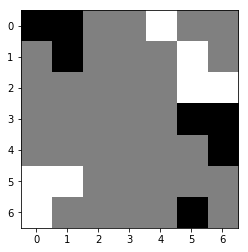

((2, 6), (4, 5)): n_v:  3586 q_all:+0.125516 q:+0.031465 q_m:+0.120000 p:0.722417
((2, 5), (4, 5)): n_v:   770 q_all:+0.125103 q:+0.023594 q_m:+0.120000 p:0.156152
((5, 0), (4, 1)): n_v:    30 q_all:-0.034393 q:-0.027919 q_m:+0.020000 p:0.020807
((1, 5), (0, 6)): n_v:    16 q_all:-0.001011 q:-0.039484 q_m:+0.020000 p:0.009767
((5, 0), (4, 0)): n_v:    10 q_all:-0.038839 q:-0.037140 q_m:+0.020000 p:0.006869
((2, 6), (4, 4)): n_v:     8 q_all:-0.030762 q:-0.020924 q_m:+0.040000 p:0.005562
((2, 5), (4, 4)): n_v:     6 q_all:+0.009662 q:-0.027611 q_m:+0.040000 p:0.003665
((0, 4), (1, 4)): n_v:     4 q_all:+0.015187 q:-0.034539 q_m:+0.020000 p:0.002419
((2, 5), (3, 4)): n_v:     3 q_all:+0.020775 q:-0.009139 q_m:+0.060000 p:0.001838
((1, 5), (1, 6)): n_v:     3 q_all:+0.019953 q:-0.028327 q_m:+0.020000 p:0.001857
((1, 5), (2, 4)): n_v:     3 q_all:+0.029503 q:-0.009210 q_m:+0.060000 p:0.001587
((0, 4), (1, 2)): n_v:     3 q_all:+0.041192 q:-0.007703 q_m:+0.080000 p:0.001414
((5, 1), (5, 2))

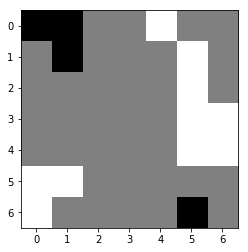

((6, 5), (5, 6)): n_v:  2945 q_all:-0.144245 q:-0.062339 q_m:-0.020000 p:0.703350
((6, 5), (5, 5)): n_v:   931 q_all:-0.108841 q:-0.076995 q_m:-0.020000 p:0.128121
((1, 1), (2, 0)): n_v:   179 q_all:-0.089604 q:-0.106383 q_m:-0.100000 p:0.014824
((0, 0), (1, 0)): n_v:   164 q_all:-0.095962 q:-0.097037 q_m:-0.100000 p:0.016440
((6, 5), (5, 4)): n_v:   137 q_all:-0.134420 q:-0.104858 q_m:-0.060000 p:0.028993
((6, 5), (4, 4)): n_v:   127 q_all:-0.122124 q:-0.069996 q_m:-0.040000 p:0.022423
((6, 5), (6, 6)): n_v:    89 q_all:-0.135248 q:-0.129927 q_m:-0.100000 p:0.019064
((1, 1), (2, 2)): n_v:    69 q_all:-0.113578 q:-0.081467 q_m:-0.100000 p:0.010363
((0, 0), (2, 0)): n_v:    64 q_all:-0.096490 q:-0.131920 q_m:-0.120000 p:0.006654
((1, 1), (2, 1)): n_v:    24 q_all:-0.101493 q:-0.114083 q_m:-0.100000 p:0.002841
((0, 1), (2, 0)): n_v:    24 q_all:-0.115963 q:-0.136357 q_m:-0.120000 p:0.003819
((6, 5), (6, 4)): n_v:    15 q_all:-0.146062 q:-0.122516 q_m:-0.100000 p:0.003762
((0, 1), (0, 3))

((3, 6), (5, 5)): n_v:  4051 q_all:+0.164869 q:+0.096332 q_m:+0.180000 p:0.577913
((3, 5), (5, 5)): n_v:  2628 q_all:+0.162924 q:+0.073125 q_m:+0.180000 p:0.387183
((3, 6), (1, 6)): n_v:     8 q_all:-0.030061 q:-0.034659 q_m:+0.020000 p:0.004941
((3, 5), (1, 4)): n_v:     6 q_all:+0.011205 q:-0.030254 q_m:+0.020000 p:0.003195
((3, 5), (5, 4)): n_v:     6 q_all:+0.049772 q:-0.038594 q_m:+0.100000 p:0.002862
((3, 5), (1, 6)): n_v:     3 q_all:-0.005964 q:-0.031936 q_m:+0.020000 p:0.001672
((0, 4), (1, 2)): n_v:     3 q_all:+0.065675 q:+0.020957 q_m:+0.100000 p:0.001243
((3, 6), (1, 4)): n_v:     2 q_all:-0.011422 q:-0.032132 q_m:+0.020000 p:0.001150
((3, 6), (5, 4)): n_v:     2 q_all:+0.051734 q:-0.028116 q_m:+0.100000 p:0.001033
((1, 5), (0, 6)): n_v:     2 q_all:+0.007586 q:-0.023439 q_m:+0.040000 p:0.001390
((5, 1), (5, 2)): n_v:     2 q_all:+0.004527 q:-0.025958 q_m:+0.040000 p:0.001449
((1, 5), (1, 6)): n_v:     1 q_all:-0.022264 q:-0.019541 q_m:+0.040000 p:0.000695
((0, 4), (0, 5))

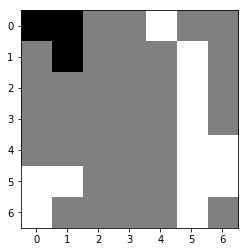

((1, 1), (2, 2)): n_v:  1039 q_all:-0.154776 q:-0.156381 q_m:-0.160000 p:0.143949
((0, 1), (1, 2)): n_v:   676 q_all:-0.177277 q:-0.187616 q_m:-0.160000 p:0.136521
((1, 1), (3, 0)): n_v:   621 q_all:-0.191442 q:-0.185809 q_m:-0.180000 p:0.150146
((1, 1), (2, 0)): n_v:   396 q_all:-0.140466 q:-0.186094 q_m:-0.160000 p:0.039010
((0, 0), (1, 0)): n_v:   369 q_all:-0.147897 q:-0.170484 q_m:-0.160000 p:0.043956
((0, 1), (0, 2)): n_v:   190 q_all:-0.163901 q:-0.185554 q_m:-0.160000 p:0.031362
((1, 1), (2, 1)): n_v:   103 q_all:-0.163430 q:-0.191634 q_m:-0.160000 p:0.016778
((0, 0), (2, 0)): n_v:    71 q_all:-0.152008 q:-0.206072 q_m:-0.180000 p:0.009242
((1, 1), (3, 2)): n_v:    60 q_all:-0.173519 q:-0.203075 q_m:-0.180000 p:0.011512
((0, 1), (2, 0)): n_v:    44 q_all:-0.163649 q:-0.218341 q_m:-0.180000 p:0.007289
((0, 1), (1, 3)): n_v:    35 q_all:-0.138414 q:-0.194335 q_m:-0.140000 p:0.003300
((0, 1), (2, 2)): n_v:    32 q_all:-0.159589 q:-0.193296 q_m:-0.180000 p:0.004961
((0, 1), (0, 3))

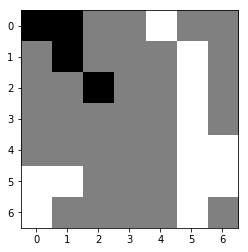

((0, 4), (1, 2)): n_v:   513 q_all:+0.239562 q:+0.165808 q_m:+0.312000 p:0.064004
((3, 5), (1, 6)): n_v:   241 q_all:+0.128876 q:+0.078128 q_m:+0.160000 p:0.148343
((0, 4), (1, 3)): n_v:   230 q_all:+0.178168 q:+0.112426 q_m:+0.228000 p:0.091395
((4, 5), (3, 3)): n_v:    85 q_all:+0.221138 q:+0.092679 q_m:+0.200000 p:0.017590
((5, 1), (3, 1)): n_v:    81 q_all:+0.178119 q:+0.099475 q_m:+0.200000 p:0.032526
((5, 0), (3, 1)): n_v:    74 q_all:+0.167641 q:+0.098298 q_m:+0.200000 p:0.032895
((1, 5), (1, 6)): n_v:    58 q_all:+0.139921 q:+0.089331 q_m:+0.180000 p:0.033222
((2, 5), (3, 3)): n_v:    56 q_all:+0.189435 q:+0.106265 q_m:+0.200000 p:0.019299
((3, 5), (1, 3)): n_v:    54 q_all:+0.165194 q:+0.088833 q_m:+0.200000 p:0.024773
((1, 5), (3, 3)): n_v:    45 q_all:+0.188360 q:+0.098972 q_m:+0.200000 p:0.015922
((3, 5), (1, 4)): n_v:    35 q_all:+0.108117 q:+0.069119 q_m:+0.160000 p:0.024890
((1, 5), (0, 6)): n_v:    32 q_all:+0.132704 q:+0.084540 q_m:+0.180000 p:0.019393
((5, 5), (3, 3))

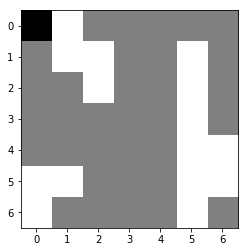

((0, 0), (0, 2)): n_v:  2218 q_all:-0.174622 q:-0.192868 q_m:-0.160000 p:0.450215
((0, 0), (2, 1)): n_v:  1325 q_all:-0.153036 q:-0.199953 q_m:-0.160000 p:0.184331
((0, 0), (1, 0)): n_v:   858 q_all:-0.180666 q:-0.214606 q_m:-0.180000 p:0.189642
((0, 0), (2, 0)): n_v:    88 q_all:-0.778166 q:-0.277306 q_m:-0.256000 p:0.175279
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.768831968307495
one move takes time(s):  2.7703213691711426


((2, 2), (1, 3)): n_v:  1365 q_all:+0.192006 q:+0.096716 q_m:+0.284000 p:0.350771
((2, 2), (1, 0)): n_v:   572 q_all:+0.186710 q:+0.133418 q_m:+0.256000 p:0.157931
((2, 2), (2, 1)): n_v:   443 q_all:+0.234051 q:+0.136366 q_m:+0.284000 p:0.048068
((2, 2), (0, 0)): n_v:   321 q_all:+0.186795 q:+0.121855 q_m:+0.256000 p:0.088317
((3, 5), (1, 6)): n_v:    72 q_all:+0.144586 q:+0.099643 q_m:+0.160000 p:0.030878
((1, 5), (0, 6)): n_v:    51 q_all:+0.114826 q:+0.103340 q_m:+0.180000 p:0.027138
((2, 2), (2, 3)): n_v:    43 q_all:+0.138463 q:+0.112520 q_m:+0.228000 p:0.019480
((2, 5), (0, 6)): n_v:    41 q_all:+0.145422 q:+0.084923 q_m:+0.160000 p:0.017430
((2, 2), (0, 3)): n_v:    35 q_all:+0.183619 q:+0.103807 q_m:+0.256000 p:0.010219
((1, 5), (1, 6)): n_v:    30 q_all:+0.127430 q:+0.114131 q_m:+0.180000 p:0.015018
((1, 5), (1, 3)): n_v:    22 q_all:+0.170349 q:+0.091718 q_m:+0.256000 p:0.007449
((2, 2), (4, 1)): n_v:    22 q_all:+0.107094 q:+0.129785 q_m:+0.160000 p:0.012609
((5, 5), (6, 6))

due to rollout lim, final rollout times:  2669 time elapsed:  2.008855104446411
one move takes time(s):  2.0100066661834717


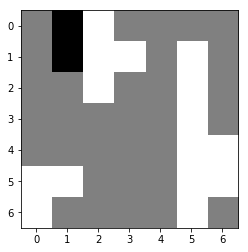

((0, 1), (2, 3)): n_v:  1422 q_all:-0.153335 q:-0.222603 q_m:-0.140000 p:0.301639
((0, 1), (0, 3)): n_v:  1310 q_all:-0.147541 q:-0.207060 q_m:-0.140000 p:0.254314
((1, 1), (0, 3)): n_v:   547 q_all:-0.182405 q:-0.186772 q_m:-0.140000 p:0.165955
((1, 1), (2, 3)): n_v:   462 q_all:-0.197650 q:-0.200115 q_m:-0.140000 p:0.162624
((1, 1), (2, 1)): n_v:   135 q_all:-0.163462 q:-0.179703 q_m:-0.160000 p:0.033109
((1, 1), (2, 0)): n_v:    19 q_all:-0.408622 q:-0.276784 q_m:-0.256000 p:0.020192
((0, 1), (2, 1)): n_v:    18 q_all:-0.183433 q:-0.220899 q_m:-0.180000 p:0.005617
((1, 1), (3, 0)): n_v:    11 q_all:-0.250069 q:-0.279418 q_m:-0.284000 p:0.006196
((1, 1), (3, 2)): n_v:     9 q_all:-0.214724 q:-0.234498 q_m:-0.228000 p:0.003949
((0, 1), (1, 0)): n_v:     8 q_all:-0.348786 q:-0.281300 q_m:-0.256000 p:0.007049
((0, 1), (2, 0)): n_v:     6 q_all:-0.498490 q:-0.307143 q_m:-0.284000 p:0.008770
((0, 1), (0, 0)): n_v:     3 q_all:-0.446915 q:-0.266923 q_m:-0.256000 p:0.003507
((1, 1), (3, 3))

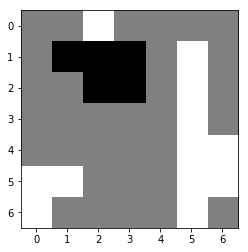

((0, 2), (0, 1)): n_v:   679 q_all:+0.222600 q:+0.161723 q_m:+0.256000 p:0.153911
((0, 2), (2, 1)): n_v:   452 q_all:+0.217824 q:+0.168546 q_m:+0.284000 p:0.110927
((5, 5), (3, 3)): n_v:   145 q_all:+0.125937 q:+0.066545 q_m:+0.228000 p:0.090277
((2, 5), (3, 3)): n_v:   119 q_all:+0.138660 q:+0.099592 q_m:+0.228000 p:0.067869
((0, 2), (0, 3)): n_v:   111 q_all:+0.186795 q:+0.119894 q_m:+0.256000 p:0.041601
((5, 1), (3, 3)): n_v:   100 q_all:+0.128050 q:+0.074846 q_m:+0.228000 p:0.061524
((1, 5), (3, 3)): n_v:    99 q_all:+0.136732 q:+0.080806 q_m:+0.228000 p:0.057301
((1, 5), (0, 5)): n_v:    76 q_all:+0.140155 q:+0.070962 q_m:+0.160000 p:0.042981
((4, 5), (3, 3)): n_v:    71 q_all:+0.093415 q:+0.069723 q_m:+0.228000 p:0.053940
((5, 1), (3, 1)): n_v:    50 q_all:+0.158978 q:+0.111828 q_m:+0.180000 p:0.024601
((2, 5), (3, 4)): n_v:    42 q_all:+0.098415 q:+0.099508 q_m:+0.200000 p:0.030851
((5, 0), (3, 1)): n_v:    28 q_all:+0.142640 q:+0.117242 q_m:+0.180000 p:0.015975
((3, 5), (3, 3))

((1, 3), (1, 4)): n_v:   246 q_all:-0.203540 q:-0.198609 q_m:-0.140000 p:0.142639
((1, 3), (2, 4)): n_v:   236 q_all:-0.185338 q:-0.181074 q_m:-0.100000 p:0.115595
((2, 3), (4, 4)): n_v:   220 q_all:-0.132786 q:-0.193959 q_m:-0.120000 p:0.051349
((2, 2), (2, 1)): n_v:   186 q_all:-0.150893 q:-0.217824 q_m:-0.140000 p:0.059544
((2, 2), (1, 0)): n_v:   171 q_all:-0.192988 q:-0.252978 q_m:-0.160000 p:0.090355
((1, 3), (0, 3)): n_v:   132 q_all:-0.106485 q:-0.216137 q_m:-0.140000 p:0.013928
((2, 2), (2, 4)): n_v:    75 q_all:-0.195289 q:-0.205446 q_m:-0.120000 p:0.040849
((2, 3), (0, 5)): n_v:    69 q_all:-0.199811 q:-0.248621 q_m:-0.200000 p:0.039013
((2, 3), (3, 4)): n_v:    62 q_all:-0.174441 q:-0.192868 q_m:-0.100000 p:0.027316
((1, 3), (0, 5)): n_v:    42 q_all:-0.194854 q:-0.232839 q_m:-0.200000 p:0.022958
((2, 2), (4, 4)): n_v:    31 q_all:-0.145009 q:-0.204556 q_m:-0.120000 p:0.009227
((2, 2), (1, 4)): n_v:    25 q_all:-0.470878 q:-0.211258 q_m:-0.160000 p:0.047341
((1, 3), (2, 1))

((1, 2), (2, 4)): n_v:   482 q_all:+0.229889 q:+0.210358 q_m:+0.396000 p:0.366348
((3, 5), (2, 4)): n_v:   308 q_all:+0.273270 q:+0.240180 q_m:+0.424000 p:0.167436
((0, 2), (2, 4)): n_v:   305 q_all:+0.248462 q:+0.182680 q_m:+0.396000 p:0.203809
((4, 5), (2, 4)): n_v:   240 q_all:+0.344361 q:+0.200892 q_m:+0.396000 p:0.045157
((4, 6), (2, 4)): n_v:   151 q_all:+0.242371 q:+0.212257 q_m:+0.396000 p:0.105952
((0, 2), (0, 3)): n_v:    28 q_all:+0.252800 q:+0.123713 q_m:+0.256000 p:0.018641
((3, 5), (4, 4)): n_v:    22 q_all:+0.232985 q:+0.051277 q_m:+0.160000 p:0.016710
((0, 2), (0, 4)): n_v:     5 q_all:+0.215670 q:+0.083606 q_m:+0.284000 p:0.004175
((1, 2), (0, 4)): n_v:     5 q_all:+0.196768 q:+0.122219 q_m:+0.284000 p:0.005198
((5, 1), (4, 2)): n_v:     4 q_all:+0.164037 q:+0.059482 q_m:+0.160000 p:0.004197
((6, 0), (4, 2)): n_v:     2 q_all:+0.164535 q:+0.046611 q_m:+0.140000 p:0.002708
((3, 5), (3, 4)): n_v:     2 q_all:+0.208767 q:+0.132530 q_m:+0.256000 p:0.001598
((3, 5), (2, 6))

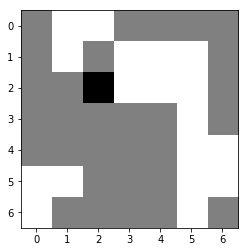

((2, 2), (1, 2)): n_v:  2416 q_all:-0.129584 q:-0.181054 q_m:-0.120000 p:0.523499
((2, 2), (3, 4)): n_v:  1622 q_all:-0.139030 q:-0.202061 q_m:-0.140000 p:0.399256
((2, 2), (3, 0)): n_v:    11 q_all:-0.885604 q:-0.258710 q_m:-0.396000 p:0.028864
((2, 2), (0, 4)): n_v:     9 q_all:-0.228825 q:-0.223975 q_m:-0.228000 p:0.005193
((2, 2), (1, 0)): n_v:     8 q_all:-0.477455 q:-0.220022 q_m:-0.284000 p:0.009294
((2, 2), (4, 4)): n_v:     8 q_all:-0.193069 q:-0.204239 q_m:-0.228000 p:0.003361
((2, 2), (3, 3)): n_v:     7 q_all:-0.208753 q:-0.278053 q_m:-0.256000 p:0.003311
((2, 2), (3, 2)): n_v:     5 q_all:-0.879576 q:-0.254423 q_m:-0.312000 p:0.013315
((2, 2), (0, 0)): n_v:     2 q_all:-0.488351 q:-0.227514 q_m:-0.284000 p:0.003800
((2, 2), (4, 1)): n_v:     2 q_all:-0.746847 q:-0.175350 q_m:-0.284000 p:0.005052
((2, 2), (2, 0)): n_v:     1 q_all:-0.648541 q:-0.268469 q_m:-0.340000 p:0.000754
((2, 2), (4, 2)): n_v:     1 q_all:-0.636611 q:-0.228703 q_m:-0.340000 p:0.002255
((2, 2), (4, 0))

((1, 4), (0, 3)): n_v:  3101 q_all:+0.148040 q:+0.131965 q_m:+0.284000 p:0.754950
((2, 5), (0, 3)): n_v:   372 q_all:+0.159673 q:+0.118559 q_m:+0.256000 p:0.076701
((2, 4), (3, 3)): n_v:   131 q_all:+0.106598 q:+0.110228 q_m:+0.228000 p:0.049470
((1, 5), (0, 3)): n_v:   102 q_all:+0.154491 q:+0.098570 q_m:+0.256000 p:0.022807
((4, 5), (6, 3)): n_v:    42 q_all:+0.084755 q:+0.060166 q_m:+0.120000 p:0.019116
((2, 4), (0, 3)): n_v:    27 q_all:+0.153407 q:+0.100432 q_m:+0.256000 p:0.006231
((2, 5), (3, 3)): n_v:     8 q_all:+0.103584 q:+0.080844 q_m:+0.200000 p:0.003299
((6, 5), (5, 3)): n_v:     7 q_all:+0.020095 q:+0.063249 q_m:+0.120000 p:0.005208
((4, 5), (3, 3)): n_v:     6 q_all:+0.085187 q:+0.078261 q_m:+0.200000 p:0.002981
((5, 5), (5, 3)): n_v:     6 q_all:+0.039976 q:+0.045808 q_m:+0.120000 p:0.004110
((4, 5), (5, 3)): n_v:     6 q_all:+0.072493 q:+0.071252 q_m:+0.120000 p:0.003074
((6, 5), (6, 3)): n_v:     5 q_all:+0.048849 q:+0.065108 q_m:+0.120000 p:0.002825
((3, 5), (5, 3))

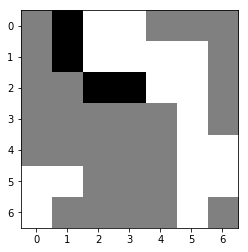

((2, 2), (0, 4)): n_v:  3251 q_all:-0.121900 q:-0.146207 q_m:-0.100000 p:0.595797
((2, 3), (3, 4)): n_v:   583 q_all:-0.112601 q:-0.143710 q_m:-0.080000 p:0.091499
((2, 2), (3, 4)): n_v:   405 q_all:-0.121070 q:-0.163119 q_m:-0.100000 p:0.073410
((2, 3), (0, 4)): n_v:   162 q_all:-0.144694 q:-0.150262 q_m:-0.100000 p:0.040288
((2, 3), (0, 5)): n_v:    64 q_all:-0.183504 q:-0.200589 q_m:-0.180000 p:0.023221
((2, 3), (4, 4)): n_v:    55 q_all:-0.138746 q:-0.145234 q_m:-0.140000 p:0.012896
((2, 2), (3, 2)): n_v:    47 q_all:-0.261409 q:-0.238812 q_m:-0.256000 p:0.027540
((2, 2), (0, 0)): n_v:    33 q_all:-0.240826 q:-0.269173 q_m:-0.284000 p:0.017349
((2, 3), (4, 1)): n_v:    24 q_all:-0.180210 q:-0.176034 q_m:-0.180000 p:0.008442
((2, 2), (4, 1)): n_v:    17 q_all:-0.185218 q:-0.196333 q_m:-0.180000 p:0.006387
((2, 2), (1, 0)): n_v:    16 q_all:-0.279076 q:-0.261493 q_m:-0.284000 p:0.010495
((2, 3), (4, 2)): n_v:    15 q_all:-0.189592 q:-0.206454 q_m:-0.228000 p:0.006005
((2, 2), (4, 4))

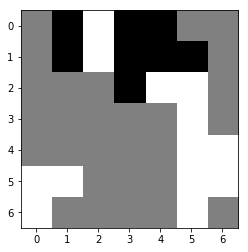

((2, 5), (0, 5)): n_v:  1556 q_all:+0.153292 q:+0.097176 q_m:+0.228000 p:0.377725
((1, 2), (2, 2)): n_v:   427 q_all:+0.152784 q:+0.108844 q_m:+0.256000 p:0.104470
((2, 4), (0, 5)): n_v:   371 q_all:+0.134661 q:+0.080948 q_m:+0.228000 p:0.111084
((2, 4), (2, 2)): n_v:   147 q_all:+0.114881 q:+0.083439 q_m:+0.228000 p:0.053242
((2, 4), (1, 6)): n_v:   111 q_all:+0.106476 q:+0.035847 q_m:+0.140000 p:0.043293
((2, 5), (1, 6)): n_v:    72 q_all:+0.098039 q:+0.043414 q_m:+0.160000 p:0.029887
((0, 2), (2, 0)): n_v:    48 q_all:+0.076689 q:+0.000545 q_m:+0.140000 p:0.023364
((1, 2), (2, 1)): n_v:    41 q_all:+0.100125 q:+0.066890 q_m:+0.160000 p:0.016789
((0, 2), (2, 2)): n_v:    39 q_all:+0.127297 q:+0.072875 q_m:+0.228000 p:0.012840
((0, 2), (1, 0)): n_v:    38 q_all:+0.117500 q:+0.060909 q_m:+0.180000 p:0.013686
((1, 2), (1, 0)): n_v:    37 q_all:+0.110141 q:+0.105120 q_m:+0.180000 p:0.014126
((5, 0), (6, 1)): n_v:    36 q_all:+0.058248 q:+0.024022 q_m:+0.120000 p:0.019216
((5, 1), (4, 2))

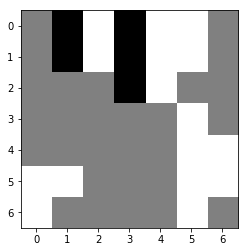

((1, 3), (2, 5)): n_v:  1536 q_all:-0.115809 q:-0.148151 q_m:-0.060000 p:0.474441
((0, 3), (2, 5)): n_v:   514 q_all:-0.119329 q:-0.176302 q_m:-0.060000 p:0.165457
((2, 3), (2, 5)): n_v:   156 q_all:-0.087013 q:-0.147367 q_m:-0.060000 p:0.032252
((1, 3), (2, 1)): n_v:   149 q_all:-0.207970 q:-0.193081 q_m:-0.180000 p:0.095438
((2, 3), (4, 4)): n_v:   129 q_all:-0.087300 q:-0.133299 q_m:-0.100000 p:0.026758
((2, 3), (4, 1)): n_v:   106 q_all:-0.136566 q:-0.128716 q_m:-0.140000 p:0.040651
((0, 3), (2, 1)): n_v:    52 q_all:-0.235265 q:-0.217631 q_m:-0.180000 p:0.038767
((2, 3), (2, 1)): n_v:    37 q_all:-0.209961 q:-0.204009 q_m:-0.180000 p:0.023831
((2, 3), (3, 4)): n_v:    35 q_all:-0.134413 q:-0.176608 q_m:-0.080000 p:0.013375
((1, 1), (2, 1)): n_v:    30 q_all:-0.197814 q:-0.167674 q_m:-0.160000 p:0.018404
((2, 3), (4, 2)): n_v:    20 q_all:-0.141853 q:-0.176778 q_m:-0.180000 p:0.008349
((1, 1), (2, 2)): n_v:    17 q_all:-0.148386 q:-0.162519 q_m:-0.160000 p:0.007260
((2, 3), (3, 2))

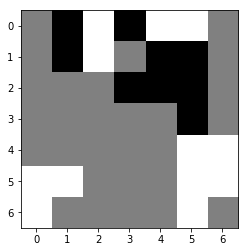

((0, 2), (1, 3)): n_v:  1151 q_all:+0.160855 q:+0.101526 q_m:+0.256000 p:0.174572
((1, 2), (3, 4)): n_v:   551 q_all:+0.191150 q:+0.042029 q_m:+0.228000 p:0.020753
((4, 5), (3, 4)): n_v:   531 q_all:+0.103463 q:+0.075614 q_m:+0.256000 p:0.194516
((0, 5), (1, 3)): n_v:    68 q_all:+0.144705 q:+0.064709 q_m:+0.228000 p:0.014469
((5, 5), (3, 4)): n_v:    49 q_all:+0.075862 q:+0.036914 q_m:+0.228000 p:0.022978
((5, 6), (3, 4)): n_v:    36 q_all:+0.079613 q:+0.024284 q_m:+0.228000 p:0.016651
((5, 1), (3, 2)): n_v:    24 q_all:+0.031406 q:-0.040276 q_m:+0.100000 p:0.015464
((4, 6), (3, 4)): n_v:    19 q_all:+0.091357 q:+0.055652 q_m:+0.228000 p:0.007700
((1, 2), (3, 2)): n_v:    19 q_all:+0.074904 q:-0.048687 q_m:+0.100000 p:0.009349
((5, 0), (3, 2)): n_v:    18 q_all:+0.025291 q:-0.026984 q_m:+0.100000 p:0.012351
((0, 2), (2, 0)): n_v:    15 q_all:+0.087866 q:-0.011567 q_m:+0.100000 p:0.006435
((4, 6), (2, 6)): n_v:     9 q_all:+0.083590 q:+0.058148 q_m:+0.180000 p:0.003871
((5, 1), (5, 3))

((3, 5), (5, 4)): n_v:  1173 q_all:-0.138495 q:-0.177243 q_m:-0.120000 p:0.476508
((1, 1), (2, 2)): n_v:   292 q_all:-0.111811 q:-0.126859 q_m:-0.100000 p:0.085124
((2, 5), (3, 4)): n_v:   216 q_all:-0.128882 q:-0.167197 q_m:-0.100000 p:0.079115
((3, 5), (4, 4)): n_v:   128 q_all:-0.137716 q:-0.162783 q_m:-0.140000 p:0.051809
((2, 5), (3, 6)): n_v:    99 q_all:-0.152228 q:-0.194964 q_m:-0.140000 p:0.046350
((3, 5), (1, 6)): n_v:    55 q_all:-0.163939 q:-0.210259 q_m:-0.200000 p:0.028542
((2, 5), (4, 4)): n_v:    28 q_all:-0.116914 q:-0.166483 q_m:-0.160000 p:0.008943
((1, 5), (0, 6)): n_v:     7 q_all:-0.208629 q:-0.204738 q_m:-0.180000 p:0.005385
((2, 5), (3, 3)): n_v:     6 q_all:-0.204581 q:-0.239887 q_m:-0.160000 p:0.004807
((3, 5), (5, 3)): n_v:     5 q_all:-0.232975 q:-0.235767 q_m:-0.256000 p:0.004463
((0, 1), (0, 0)): n_v:     5 q_all:-0.218869 q:-0.237524 q_m:-0.228000 p:0.004188
((2, 5), (0, 6)): n_v:     4 q_all:-0.213624 q:-0.219765 q_m:-0.200000 p:0.003164
((0, 1), (2, 2))

((4, 6), (6, 4)): n_v:  1121 q_all:+0.178679 q:+0.107347 q_m:+0.256000 p:0.433013
((6, 0), (6, 2)): n_v:    98 q_all:+0.063749 q:-0.009964 q_m:+0.120000 p:0.086685
((1, 2), (2, 2)): n_v:    82 q_all:+0.153943 q:+0.094898 q_m:+0.180000 p:0.040896
((5, 6), (6, 4)): n_v:    75 q_all:+0.170851 q:+0.118068 q_m:+0.256000 p:0.031827
((2, 4), (4, 4)): n_v:    75 q_all:+0.161525 q:+0.025614 q_m:+0.256000 p:0.034539
((0, 5), (1, 6)): n_v:    72 q_all:+0.145694 q:+0.091620 q_m:+0.228000 p:0.038408
((5, 1), (6, 2)): n_v:    54 q_all:+0.080276 q:+0.005995 q_m:+0.140000 p:0.044270
((2, 3), (4, 4)): n_v:    42 q_all:+0.154140 q:+0.046295 q_m:+0.256000 p:0.021036
((4, 6), (4, 4)): n_v:    35 q_all:+0.157662 q:+0.070302 q_m:+0.256000 p:0.016888
((2, 4), (1, 6)): n_v:    29 q_all:+0.101247 q:+0.044053 q_m:+0.200000 p:0.021202
((2, 3), (4, 2)): n_v:    25 q_all:+0.059322 q:-0.017057 q_m:+0.120000 p:0.023105
((0, 2), (1, 0)): n_v:    24 q_all:+0.228980 q:+0.099909 q_m:+0.200000 p:0.004237
((1, 4), (2, 2))

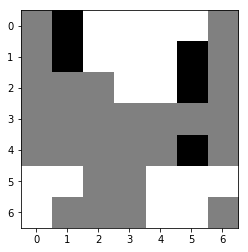

((1, 1), (2, 2)): n_v:   601 q_all:-0.126302 q:-0.122113 q_m:-0.100000 p:0.332943
((4, 5), (4, 4)): n_v:   314 q_all:-0.148833 q:-0.198032 q_m:-0.140000 p:0.209584
((4, 5), (6, 6)): n_v:   154 q_all:-0.131293 q:-0.169230 q_m:-0.120000 p:0.089377
((4, 5), (6, 3)): n_v:   138 q_all:-0.200492 q:-0.184193 q_m:-0.160000 p:0.128083
((2, 5), (0, 6)): n_v:   135 q_all:-0.234114 q:-0.215053 q_m:-0.200000 p:0.147597
((2, 5), (4, 4)): n_v:    37 q_all:-0.146226 q:-0.198387 q_m:-0.160000 p:0.024476
((0, 1), (2, 2)): n_v:    29 q_all:-0.168616 q:-0.159369 q_m:-0.120000 p:0.022770
((4, 5), (5, 3)): n_v:     6 q_all:-0.208681 q:-0.213607 q_m:-0.160000 p:0.006471
((1, 1), (2, 1)): n_v:     4 q_all:-0.217126 q:-0.170708 q_m:-0.180000 p:0.004111
((4, 5), (4, 6)): n_v:     4 q_all:-0.152673 q:-0.176037 q_m:-0.140000 p:0.003072
((2, 5), (3, 4)): n_v:     2 q_all:-0.196034 q:-0.159061 q_m:-0.140000 p:0.002051
((1, 5), (0, 6)): n_v:     2 q_all:-0.226485 q:-0.208692 q_m:-0.180000 p:0.002439
((1, 1), (2, 0))

((2, 4), (3, 4)): n_v:   485 q_all:+0.170945 q:+0.142232 q_m:+0.256000 p:0.247756
((0, 3), (2, 1)): n_v:   137 q_all:+0.127343 q:+0.081026 q_m:+0.228000 p:0.099965
((2, 4), (3, 3)): n_v:   106 q_all:+0.148061 q:+0.091749 q_m:+0.200000 p:0.066686
((0, 2), (2, 1)): n_v:    91 q_all:+0.140142 q:+0.131046 q_m:+0.228000 p:0.061038
((0, 5), (1, 6)): n_v:    75 q_all:+0.166145 q:+0.125321 q_m:+0.200000 p:0.040345
((2, 4), (3, 5)): n_v:    57 q_all:+0.142085 q:+0.115843 q_m:+0.200000 p:0.037784
((5, 1), (3, 2)): n_v:    52 q_all:+0.126878 q:+0.089796 q_m:+0.180000 p:0.038135
((5, 0), (3, 2)): n_v:    48 q_all:+0.128597 q:+0.097597 q_m:+0.180000 p:0.035092
((2, 4), (3, 2)): n_v:    36 q_all:+0.146824 q:+0.073915 q_m:+0.180000 p:0.022918
((5, 4), (3, 4)): n_v:    31 q_all:+0.148857 q:+0.116614 q_m:+0.228000 p:0.019441
((2, 4), (1, 6)): n_v:    31 q_all:+0.133436 q:+0.091288 q_m:+0.180000 p:0.021971
((5, 6), (3, 4)): n_v:    30 q_all:+0.160922 q:+0.118699 q_m:+0.228000 p:0.016835
((5, 0), (4, 1))

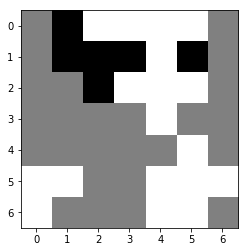

((2, 2), (3, 3)): n_v:   644 q_all:-0.103425 q:-0.149968 q_m:-0.100000 p:0.405221
((2, 2), (4, 4)): n_v:   489 q_all:-0.111885 q:-0.139237 q_m:-0.080000 p:0.328726
((1, 3), (3, 5)): n_v:    97 q_all:-0.119227 q:-0.105087 q_m:-0.080000 p:0.069420
((1, 5), (3, 5)): n_v:    29 q_all:-0.080550 q:-0.083102 q_m:-0.080000 p:0.015301
((1, 5), (1, 6)): n_v:    18 q_all:-0.114173 q:-0.128498 q_m:-0.140000 p:0.012858
((2, 2), (4, 2)): n_v:    16 q_all:-0.164591 q:-0.149786 q_m:-0.200000 p:0.015556
((2, 2), (3, 1)): n_v:    16 q_all:-0.204173 q:-0.165727 q_m:-0.228000 p:0.019044
((1, 1), (3, 3)): n_v:    13 q_all:-0.185093 q:-0.168254 q_m:-0.120000 p:0.014046
((1, 5), (3, 3)): n_v:    12 q_all:-0.092159 q:-0.175660 q_m:-0.120000 p:0.007075
((1, 3), (2, 1)): n_v:    12 q_all:-0.178561 q:-0.169732 q_m:-0.256000 p:0.013079
((2, 2), (4, 1)): n_v:    10 q_all:-0.146953 q:-0.111892 q_m:-0.160000 p:0.009268
((1, 3), (3, 1)): n_v:    10 q_all:-0.182781 q:-0.180119 q_m:-0.256000 p:0.011381
((2, 2), (0, 0))

((5, 0), (3, 2)): n_v:   441 q_all:+0.161508 q:+0.102876 q_m:+0.228000 p:0.134049
((4, 5), (4, 4)): n_v:   408 q_all:+0.134834 q:+0.109468 q_m:+0.200000 p:0.177866
((5, 1), (3, 2)): n_v:   252 q_all:+0.165835 q:+0.097224 q_m:+0.228000 p:0.071071
((5, 1), (4, 2)): n_v:    95 q_all:+0.119155 q:+0.083964 q_m:+0.160000 p:0.048865
((5, 4), (4, 3)): n_v:    94 q_all:+0.112820 q:+0.092870 q_m:+0.200000 p:0.051168
((2, 5), (3, 5)): n_v:    48 q_all:+0.133174 q:+0.106761 q_m:+0.200000 p:0.021447
((6, 4), (4, 2)): n_v:    40 q_all:+0.093557 q:+0.059812 q_m:+0.140000 p:0.026169
((5, 4), (3, 2)): n_v:    37 q_all:+0.154971 q:+0.097325 q_m:+0.228000 p:0.012714
((2, 5), (4, 4)): n_v:    37 q_all:+0.174982 q:+0.088616 q_m:+0.180000 p:0.008947
((0, 3), (2, 1)): n_v:    29 q_all:+0.128797 q:+0.063101 q_m:+0.228000 p:0.013651
((0, 2), (2, 1)): n_v:    26 q_all:+0.125593 q:+0.135182 q_m:+0.228000 p:0.012893
((1, 4), (3, 2)): n_v:    20 q_all:+0.068283 q:+0.078699 q_m:+0.228000 p:0.015847
((5, 0), (4, 1))

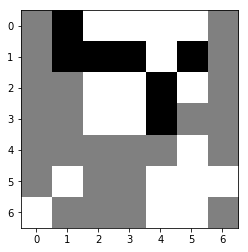

((3, 4), (4, 4)): n_v:   547 q_all:-0.103539 q:-0.115464 q_m:-0.040000 p:0.320591
((1, 1), (2, 1)): n_v:   339 q_all:-0.095348 q:-0.110535 q_m:-0.120000 p:0.184074
((3, 4), (4, 2)): n_v:    95 q_all:-0.138281 q:-0.150956 q_m:-0.100000 p:0.073226
((2, 4), (4, 2)): n_v:    75 q_all:-0.117820 q:-0.130612 q_m:-0.100000 p:0.049736
((2, 4), (4, 4)): n_v:    42 q_all:-0.099963 q:-0.129311 q_m:-0.060000 p:0.023849
((1, 3), (2, 1)): n_v:    39 q_all:-0.061637 q:-0.147906 q_m:-0.140000 p:0.014524
((3, 4), (4, 6)): n_v:    35 q_all:-0.075237 q:-0.113039 q_m:-0.100000 p:0.015337
((3, 4), (5, 2)): n_v:    34 q_all:-0.155579 q:-0.172385 q_m:-0.180000 p:0.029735
((0, 1), (2, 1)): n_v:    29 q_all:-0.108221 q:-0.152927 q_m:-0.140000 p:0.017794
((3, 4), (2, 6)): n_v:    21 q_all:-0.167206 q:-0.205939 q_m:-0.180000 p:0.020050
((3, 4), (4, 3)): n_v:    21 q_all:-0.131132 q:-0.144443 q_m:-0.080000 p:0.015683
((1, 1), (2, 0)): n_v:    20 q_all:-0.206803 q:-0.173454 q_m:-0.200000 p:0.023314
((1, 5), (1, 6))

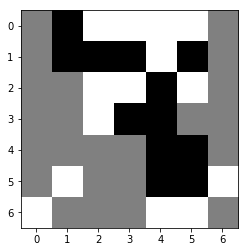

((3, 2), (4, 3)): n_v:  1274 q_all:+0.135775 q:+0.086202 q_m:+0.228000 p:0.785311
((6, 5), (4, 3)): n_v:    53 q_all:+0.099465 q:+0.057158 q_m:+0.200000 p:0.042595
((5, 1), (4, 3)): n_v:    28 q_all:+0.113691 q:+0.059405 q_m:+0.200000 p:0.020686
((6, 4), (4, 3)): n_v:    23 q_all:+0.125658 q:+0.050499 q_m:+0.200000 p:0.015834
((2, 2), (2, 1)): n_v:    22 q_all:+0.140545 q:+0.057095 q_m:+0.140000 p:0.012779
((2, 2), (3, 1)): n_v:    20 q_all:+0.046928 q:+0.000565 q_m:+0.060000 p:0.022317
((2, 5), (3, 5)): n_v:    17 q_all:+0.169310 q:+0.051820 q_m:+0.228000 p:0.007892
((2, 3), (3, 1)): n_v:    13 q_all:+0.074033 q:-0.038592 q_m:+0.040000 p:0.012543
((6, 4), (5, 3)): n_v:    10 q_all:+0.097800 q:+0.027007 q_m:+0.140000 p:0.008862
((5, 6), (3, 5)): n_v:     9 q_all:+0.145293 q:+0.036087 q_m:+0.200000 p:0.005235
((2, 3), (3, 5)): n_v:     9 q_all:+0.115175 q:-0.001426 q_m:+0.200000 p:0.006878
((2, 5), (4, 3)): n_v:     4 q_all:+0.141084 q:+0.065689 q_m:+0.200000 p:0.002734
((5, 1), (3, 1))

((4, 5), (5, 3)): n_v:   807 q_all:-0.083297 q:-0.123424 q_m:-0.060000 p:0.244726
((2, 4), (3, 5)): n_v:   331 q_all:-0.089933 q:-0.123072 q_m:-0.080000 p:0.109629
((5, 5), (5, 3)): n_v:   300 q_all:-0.134199 q:-0.113185 q_m:-0.060000 p:0.155273
((2, 4), (4, 2)): n_v:   247 q_all:-0.090419 q:-0.090337 q_m:-0.060000 p:0.081941
((4, 5), (6, 3)): n_v:   109 q_all:-0.164882 q:-0.142578 q_m:-0.140000 p:0.070101
((1, 5), (3, 5)): n_v:    76 q_all:-0.107590 q:-0.108590 q_m:-0.100000 p:0.031058
((1, 1), (2, 1)): n_v:    53 q_all:-0.118580 q:-0.109501 q_m:-0.120000 p:0.024291
((1, 1), (3, 1)): n_v:    45 q_all:-0.165378 q:-0.114504 q_m:-0.140000 p:0.029375
((1, 3), (3, 5)): n_v:    39 q_all:-0.095276 q:-0.143991 q_m:-0.100000 p:0.014091
((5, 5), (3, 5)): n_v:    31 q_all:-0.091139 q:-0.138876 q_m:-0.100000 p:0.010589
((5, 5), (6, 6)): n_v:    28 q_all:-0.129387 q:-0.113620 q_m:-0.120000 p:0.014201
((5, 5), (6, 3)): n_v:    25 q_all:-0.121370 q:-0.129945 q_m:-0.140000 p:0.011951
((1, 3), (3, 1))

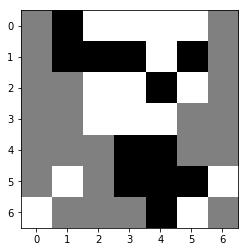

((3, 4), (4, 5)): n_v:   644 q_all:+0.104267 q:+0.032622 q_m:+0.200000 p:0.241052
((2, 2), (2, 1)): n_v:   501 q_all:+0.127967 q:+0.057521 q_m:+0.160000 p:0.131716
((3, 2), (4, 1)): n_v:   188 q_all:+0.027562 q:-0.005032 q_m:+0.080000 p:0.138755
((6, 5), (6, 3)): n_v:   140 q_all:+0.106771 q:+0.064373 q_m:+0.180000 p:0.050753
((5, 1), (6, 3)): n_v:    84 q_all:+0.114524 q:+0.051092 q_m:+0.180000 p:0.027703
((3, 2), (4, 2)): n_v:    33 q_all:+0.100690 q:+0.027810 q_m:+0.160000 p:0.013130
((0, 3), (2, 1)): n_v:    26 q_all:+0.066395 q:+0.000537 q_m:+0.140000 p:0.014858
((0, 2), (2, 1)): n_v:    26 q_all:+0.075916 q:+0.039125 q_m:+0.140000 p:0.013300
((2, 5), (4, 5)): n_v:    15 q_all:+0.122300 q:+0.022889 q_m:+0.180000 p:0.004255
((2, 3), (4, 5)): n_v:    11 q_all:+0.078768 q:-0.019180 q_m:+0.180000 p:0.005801
((3, 3), (2, 1)): n_v:     9 q_all:+0.087447 q:+0.050259 q_m:+0.140000 p:0.004264
((5, 1), (6, 2)): n_v:     6 q_all:+0.049144 q:-0.009386 q_m:+0.120000 p:0.004038
((5, 1), (5, 2))

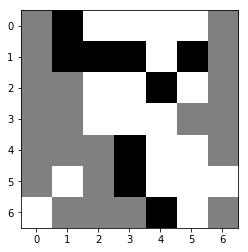

((2, 4), (3, 5)): n_v:   902 q_all:-0.028171 q:-0.082199 q_m:-0.020000 p:0.384875
((4, 3), (4, 2)): n_v:   137 q_all:-0.080565 q:-0.127042 q_m:-0.060000 p:0.094028
((1, 5), (3, 5)): n_v:    93 q_all:-0.040748 q:-0.068376 q_m:-0.040000 p:0.045660
((4, 3), (6, 1)): n_v:    66 q_all:-0.086230 q:-0.095690 q_m:-0.120000 p:0.047618
((4, 3), (3, 5)): n_v:    53 q_all:-0.042504 q:-0.120065 q_m:-0.040000 p:0.026674
((1, 1), (3, 1)): n_v:    50 q_all:-0.146996 q:-0.133779 q_m:-0.120000 p:0.050957
((1, 3), (3, 5)): n_v:    49 q_all:-0.039057 q:-0.126001 q_m:-0.040000 p:0.023831
((5, 3), (3, 5)): n_v:    44 q_all:-0.062909 q:-0.122945 q_m:-0.040000 p:0.026677
((4, 3), (3, 1)): n_v:    31 q_all:-0.169137 q:-0.151168 q_m:-0.120000 p:0.035529
((1, 1), (2, 1)): n_v:    15 q_all:-0.107093 q:-0.123021 q_m:-0.100000 p:0.012670
((1, 3), (3, 1)): n_v:    11 q_all:-0.119539 q:-0.147006 q_m:-0.120000 p:0.010403
((2, 4), (4, 2)): n_v:     8 q_all:-0.110235 q:-0.127158 q_m:-0.080000 p:0.006672
((1, 2), (3, 1))

((2, 2), (2, 1)): n_v:   392 q_all:+0.070080 q:+0.025361 q_m:+0.120000 p:0.107382
((5, 4), (6, 3)): n_v:   283 q_all:+0.084596 q:+0.074570 q_m:+0.120000 p:0.058693
((5, 6), (3, 6)): n_v:   191 q_all:+0.071380 q:+0.030643 q_m:+0.140000 p:0.050919
((3, 2), (4, 2)): n_v:   183 q_all:+0.067351 q:+0.015282 q_m:+0.120000 p:0.052586
((5, 5), (4, 6)): n_v:   143 q_all:+0.060841 q:+0.015463 q_m:+0.120000 p:0.045312
((0, 5), (2, 6)): n_v:    65 q_all:+0.076666 q:+0.008222 q_m:+0.140000 p:0.016029
((5, 1), (6, 3)): n_v:    65 q_all:+0.063512 q:+0.070431 q_m:+0.100000 p:0.019834
((0, 5), (1, 6)): n_v:    57 q_all:+0.081462 q:+0.006181 q_m:+0.120000 p:0.012792
((6, 5), (6, 3)): n_v:    44 q_all:+0.034452 q:+0.048686 q_m:+0.100000 p:0.019420
((5, 4), (4, 2)): n_v:    39 q_all:+0.010607 q:+0.007575 q_m:+0.100000 p:0.021461
((5, 1), (6, 2)): n_v:    38 q_all:+0.025163 q:-0.011669 q_m:+0.080000 p:0.018693
((3, 2), (4, 1)): n_v:    29 q_all:-0.008478 q:-0.006968 q_m:+0.040000 p:0.018962
((5, 1), (4, 0))

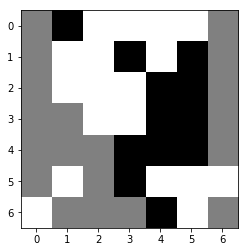

((4, 3), (4, 2)): n_v:  1501 q_all:-0.036691 q:-0.094936 q_m:+0.020000 p:0.289144
((4, 3), (3, 1)): n_v:   113 q_all:-0.034603 q:-0.117668 q_m:-0.000000 p:0.020853
((5, 3), (3, 1)): n_v:    46 q_all:-0.037105 q:-0.116985 q_m:-0.000000 p:0.009087
((0, 1), (1, 0)): n_v:    34 q_all:-0.016122 q:-0.104167 q_m:-0.020000 p:0.003452
((6, 4), (4, 2)): n_v:    30 q_all:-0.056645 q:-0.100441 q_m:-0.000000 p:0.008753
((4, 3), (6, 1)): n_v:    27 q_all:-0.051117 q:-0.103497 q_m:-0.040000 p:0.007192
((1, 3), (3, 1)): n_v:    26 q_all:-0.050824 q:-0.120220 q_m:-0.000000 p:0.007318
((2, 4), (4, 2)): n_v:    18 q_all:-0.142901 q:-0.104211 q_m:-0.000000 p:0.012279
((1, 5), (1, 6)): n_v:    14 q_all:-0.042865 q:-0.115132 q_m:-0.060000 p:0.003148
((3, 4), (4, 2)): n_v:    10 q_all:-0.162694 q:-0.113853 q_m:-0.000000 p:0.008266
((1, 5), (0, 6)): n_v:     9 q_all:-0.042752 q:-0.115199 q_m:-0.060000 p:0.002099
((5, 3), (6, 1)): n_v:     8 q_all:-0.069454 q:-0.101153 q_m:-0.040000 p:0.003030
((4, 4), (4, 2))

((6, 0), (5, 2)): n_v:  1455 q_all:+0.081358 q:+0.047676 q_m:+0.140000 p:0.345162
((6, 0), (4, 1)): n_v:   373 q_all:+0.031712 q:+0.015124 q_m:+0.100000 p:0.159786
((5, 5), (4, 6)): n_v:   275 q_all:+0.028251 q:+0.007483 q_m:+0.080000 p:0.121558
((5, 4), (5, 2)): n_v:   110 q_all:+0.055702 q:+0.029575 q_m:+0.140000 p:0.037078
((2, 1), (4, 1)): n_v:    92 q_all:+0.017365 q:+0.028967 q_m:+0.100000 p:0.044628
((2, 2), (4, 1)): n_v:    57 q_all:-0.024304 q:-0.001860 q_m:+0.100000 p:0.037158
((5, 6), (3, 6)): n_v:    38 q_all:+0.041920 q:-0.002900 q_m:+0.100000 p:0.014702
((1, 1), (1, 0)): n_v:    34 q_all:+0.042183 q:+0.022264 q_m:+0.040000 p:0.013153
((5, 4), (6, 3)): n_v:    33 q_all:+0.101278 q:+0.034920 q_m:+0.080000 p:0.005453
((0, 5), (1, 6)): n_v:    25 q_all:+0.043378 q:-0.017858 q_m:+0.080000 p:0.009950
((1, 1), (2, 0)): n_v:    23 q_all:-0.021420 q:-0.023398 q_m:-0.000000 p:0.015044
((2, 3), (4, 1)): n_v:    19 q_all:+0.011184 q:+0.008600 q_m:+0.100000 p:0.009677
((0, 5), (2, 6))

((3, 2), (4, 1)): n_v:  2428 q_all:-0.055687 q:-0.153915 q_m:-0.000000 p:0.565387
((6, 4), (6, 3)): n_v:   454 q_all:-0.069975 q:-0.123048 q_m:-0.000000 p:0.126724
((3, 2), (3, 1)): n_v:   248 q_all:-0.069416 q:-0.160485 q_m:-0.000000 p:0.068818
((0, 1), (1, 0)): n_v:   211 q_all:-0.046963 q:-0.119340 q_m:-0.040000 p:0.043230
((4, 5), (6, 3)): n_v:    94 q_all:-0.093640 q:-0.146391 q_m:-0.020000 p:0.033422
((3, 3), (4, 1)): n_v:    91 q_all:-0.096479 q:-0.144427 q_m:-0.020000 p:0.033097
((6, 4), (6, 2)): n_v:    59 q_all:-0.037438 q:-0.131969 q_m:-0.020000 p:0.010427
((1, 5), (1, 6)): n_v:    54 q_all:-0.087380 q:-0.151623 q_m:-0.080000 p:0.018061
((1, 3), (3, 1)): n_v:    38 q_all:-0.065132 q:-0.175729 q_m:-0.020000 p:0.009967
((3, 2), (1, 0)): n_v:    25 q_all:-0.063037 q:-0.148521 q_m:-0.060000 p:0.006546
((3, 2), (5, 0)): n_v:    22 q_all:-0.064677 q:-0.187240 q_m:-0.100000 p:0.005733
((6, 4), (6, 6)): n_v:    21 q_all:-0.000472 q:-0.105616 q_m:-0.020000 p:0.001236
((4, 4), (6, 3))

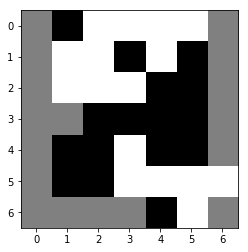

((2, 1), (3, 1)): n_v:  2551 q_all:+0.115680 q:+0.042457 q_m:+0.140000 p:0.194186
((1, 1), (3, 1)): n_v:  1065 q_all:+0.020096 q:+0.023245 q_m:+0.120000 p:0.373159
((5, 3), (3, 1)): n_v:   352 q_all:+0.078629 q:+0.022587 q_m:+0.120000 p:0.064290
((5, 5), (4, 6)): n_v:   203 q_all:+0.066397 q:+0.011794 q_m:+0.100000 p:0.044310
((2, 3), (3, 1)): n_v:    52 q_all:+0.029961 q:+0.016106 q_m:+0.120000 p:0.017026
((1, 2), (3, 1)): n_v:    46 q_all:-0.034397 q:+0.026048 q_m:+0.120000 p:0.023666
((1, 1), (2, 0)): n_v:    37 q_all:-0.009366 q:-0.000842 q_m:+0.020000 p:0.016182
((4, 3), (3, 1)): n_v:    35 q_all:+0.045298 q:+0.022094 q_m:+0.120000 p:0.009964
((5, 3), (6, 3)): n_v:    21 q_all:+0.039084 q:+0.020729 q_m:+0.100000 p:0.006290
((0, 5), (2, 6)): n_v:    20 q_all:+0.097417 q:+0.034023 q_m:+0.120000 p:0.002591
((6, 5), (4, 6)): n_v:    14 q_all:+0.028648 q:-0.001746 q_m:+0.080000 p:0.004876
((5, 6), (3, 6)): n_v:    11 q_all:+0.071164 q:+0.027126 q_m:+0.120000 p:0.002205
((0, 4), (2, 6))

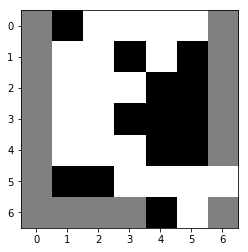

((6, 4), (6, 6)): n_v:  2233 q_all:-0.020414 q:-0.114783 q_m:-0.020000 p:0.001798
((5, 1), (4, 0)): n_v:   582 q_all:-0.106289 q:-0.136524 q_m:-0.040000 p:0.135961
((5, 1), (3, 0)): n_v:   291 q_all:-0.098236 q:-0.151310 q_m:-0.020000 p:0.058783
((5, 1), (5, 0)): n_v:   270 q_all:-0.124568 q:-0.170750 q_m:-0.080000 p:0.078764
((0, 1), (1, 0)): n_v:   249 q_all:-0.095584 q:-0.148715 q_m:-0.040000 p:0.047970
((5, 2), (6, 3)): n_v:   242 q_all:-0.102307 q:-0.122882 q_m:-0.040000 p:0.052693
((1, 5), (1, 6)): n_v:   181 q_all:-0.114382 q:-0.139728 q_m:-0.080000 p:0.047792
((3, 5), (4, 6)): n_v:   173 q_all:-0.086686 q:-0.150710 q_m:-0.040000 p:0.027713
((5, 2), (3, 0)): n_v:   154 q_all:-0.090737 q:-0.161089 q_m:-0.020000 p:0.027020
((2, 5), (3, 6)): n_v:   135 q_all:-0.189034 q:-0.188059 q_m:-0.120000 p:0.063995
((6, 4), (4, 6)): n_v:   111 q_all:-0.070866 q:-0.152848 q_m:-0.060000 p:0.011056
((0, 1), (2, 0)): n_v:    56 q_all:-0.080228 q:-0.163878 q_m:-0.020000 p:0.007716
((5, 1), (6, 0))

((5, 3), (6, 4)): n_v:  1907 q_all:+0.074080 q:+0.018229 q_m:+0.120000 p:0.171757
((5, 3), (6, 2)): n_v:  1376 q_all:+0.014992 q:+0.008960 q_m:+0.120000 p:0.356123
((0, 5), (1, 6)): n_v:  1168 q_all:+0.098000 q:-0.013819 q_m:+0.120000 p:0.008999
((0, 5), (2, 6)): n_v:   127 q_all:+0.029489 q:-0.015285 q_m:+0.140000 p:0.027616
((4, 1), (5, 0)): n_v:    64 q_all:+0.073601 q:-0.030341 q_m:+0.080000 p:0.005929
((4, 1), (6, 2)): n_v:    49 q_all:+0.004746 q:-0.003220 q_m:+0.100000 p:0.014285
((3, 1), (4, 0)): n_v:    39 q_all:+0.056843 q:-0.023282 q_m:+0.080000 p:0.005359
((0, 4), (2, 6)): n_v:    33 q_all:+0.022448 q:-0.028884 q_m:+0.140000 p:0.008057
((1, 1), (2, 0)): n_v:    32 q_all:+0.016061 q:-0.049224 q_m:+0.040000 p:0.008310
((5, 4), (4, 6)): n_v:    23 q_all:+0.057806 q:+0.028920 q_m:+0.180000 p:0.003016
((1, 1), (1, 0)): n_v:    16 q_all:+0.040501 q:+0.023059 q_m:+0.080000 p:0.003122
((0, 2), (2, 0)): n_v:    13 q_all:-0.044522 q:-0.091720 q_m:+0.020000 p:0.005802
((5, 4), (6, 2))

((5, 2), (6, 3)): n_v:  4008 q_all:-0.029156 q:-0.100935 q_m:+0.020000 p:0.527224
((5, 1), (6, 3)): n_v:   428 q_all:-0.018287 q:-0.095649 q_m:-0.000000 p:0.043722
((2, 5), (3, 6)): n_v:   129 q_all:-0.166943 q:-0.159594 q_m:-0.100000 p:0.066656
((0, 1), (1, 0)): n_v:   107 q_all:-0.068076 q:-0.126124 q_m:-0.020000 p:0.025796
((5, 1), (4, 0)): n_v:   104 q_all:-0.060178 q:-0.108025 q_m:-0.020000 p:0.022753
((4, 4), (6, 3)): n_v:    58 q_all:-0.122663 q:-0.118520 q_m:-0.000000 p:0.022630
((1, 5), (1, 6)): n_v:    57 q_all:-0.078394 q:-0.123408 q_m:-0.060000 p:0.015446
((3, 5), (4, 6)): n_v:    49 q_all:-0.050762 q:-0.126605 q_m:-0.060000 p:0.009543
((5, 1), (5, 0)): n_v:    49 q_all:-0.100186 q:-0.141737 q_m:-0.060000 p:0.016130
((4, 5), (6, 3)): n_v:    49 q_all:-0.095778 q:-0.111165 q_m:-0.000000 p:0.015569
((5, 1), (3, 0)): n_v:    34 q_all:-0.063010 q:-0.129943 q_m:-0.000000 p:0.007843
((1, 5), (3, 6)): n_v:    18 q_all:-0.161608 q:-0.142969 q_m:-0.120000 p:0.009160
((5, 6), (3, 6))

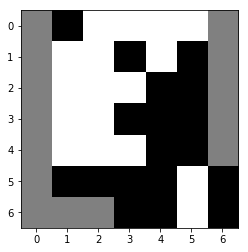

((4, 1), (6, 2)): n_v:  6165 q_all:+0.083238 q:+0.060996 q_m:+0.140000 p:0.562374
((4, 3), (6, 2)): n_v:  1373 q_all:+0.035864 q:+0.030327 q_m:+0.140000 p:0.262427
((5, 5), (4, 6)): n_v:   202 q_all:+0.065671 q:+0.000209 q_m:+0.120000 p:0.025982
((4, 1), (5, 0)): n_v:   179 q_all:+0.049379 q:-0.050068 q_m:+0.040000 p:0.029198
((0, 5), (1, 6)): n_v:   129 q_all:+0.054505 q:-0.051819 q_m:+0.080000 p:0.019727
((1, 1), (1, 0)): n_v:    95 q_all:+0.069105 q:-0.010727 q_m:+0.040000 p:0.011466
((0, 5), (2, 6)): n_v:    63 q_all:+0.042239 q:-0.035931 q_m:+0.100000 p:0.011198
((4, 2), (6, 2)): n_v:    50 q_all:-0.028315 q:+0.017095 q_m:+0.140000 p:0.016568
((6, 5), (4, 6)): n_v:    44 q_all:+0.044246 q:-0.011953 q_m:+0.100000 p:0.007771
((3, 1), (4, 0)): n_v:    16 q_all:+0.038729 q:-0.038586 q_m:+0.040000 p:0.003025
((4, 3), (6, 1)): n_v:    15 q_all:+0.040509 q:-0.060449 q_m:+0.060000 p:0.002844
((0, 4), (2, 6)): n_v:    15 q_all:+0.041485 q:-0.055003 q_m:+0.100000 p:0.002840
((1, 1), (2, 0))

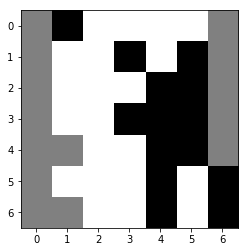

((3, 3), (4, 1)): n_v:  8410 q_all:-0.096090 q:-0.089380 q_m:+0.060000 p:0.844103
((0, 1), (2, 0)): n_v:   956 q_all:-0.043300 q:-0.239254 q_m:-0.020000 p:0.000744
((0, 1), (1, 0)): n_v:   902 q_all:-0.064664 q:-0.184429 q_m:-0.040000 p:0.036731
((3, 5), (4, 6)): n_v:   147 q_all:-0.067436 q:-0.219613 q_m:-0.080000 p:0.006792
((1, 5), (1, 6)): n_v:    99 q_all:-0.131974 q:-0.243292 q_m:-0.080000 p:0.016723
((1, 5), (0, 6)): n_v:    81 q_all:-0.063718 q:-0.259586 q_m:-0.080000 p:0.003147
((1, 5), (2, 6)): n_v:    49 q_all:-0.125268 q:-0.287265 q_m:-0.120000 p:0.007450
((0, 1), (0, 0)): n_v:    30 q_all:-0.120379 q:-0.270901 q_m:-0.080000 p:0.004295
((6, 4), (4, 6)): n_v:    16 q_all:-0.066905 q:-0.234801 q_m:-0.100000 p:0.000756
((3, 5), (1, 6)): n_v:    15 q_all:-0.185148 q:-0.244398 q_m:-0.100000 p:0.004128
((6, 6), (4, 6)): n_v:     9 q_all:-0.110750 q:-0.268914 q_m:-0.100000 p:0.001204
((2, 5), (3, 6)): n_v:     5 q_all:-0.204548 q:-0.303164 q_m:-0.120000 p:0.001805
((2, 4), (1, 6))

((2, 2), (3, 3)): n_v: 10874 q_all:+0.144488 q:+0.047786 q_m:+0.160000 p:0.296905
((1, 1), (3, 3)): n_v:   408 q_all:+0.081827 q:+0.018047 q_m:+0.140000 p:0.055372
((2, 1), (3, 3)): n_v:   151 q_all:+0.087232 q:+0.032249 q_m:+0.140000 p:0.019073
((5, 5), (3, 3)): n_v:   142 q_all:+0.080382 q:+0.003169 q_m:+0.140000 p:0.019670
((5, 5), (4, 6)): n_v:   130 q_all:+0.038745 q:-0.021037 q_m:+0.080000 p:0.027369
((1, 4), (3, 3)): n_v:    51 q_all:+0.071505 q:+0.002438 q_m:+0.140000 p:0.007855
((6, 5), (4, 6)): n_v:    48 q_all:+0.046167 q:-0.024720 q_m:+0.060000 p:0.009499
((1, 2), (3, 3)): n_v:    38 q_all:+0.083699 q:+0.031300 q_m:+0.140000 p:0.005128
((1, 1), (2, 0)): n_v:    26 q_all:-0.010440 q:-0.021271 q_m:-0.000000 p:0.007958
((0, 5), (2, 6)): n_v:    25 q_all:+0.012918 q:-0.036495 q_m:+0.060000 p:0.006551
((6, 2), (4, 0)): n_v:    15 q_all:+0.039299 q:-0.009549 q_m:+0.060000 p:0.003319
((0, 2), (2, 0)): n_v:    10 q_all:-0.038875 q:-0.050426 q_m:-0.020000 p:0.003763
((2, 1), (4, 0))

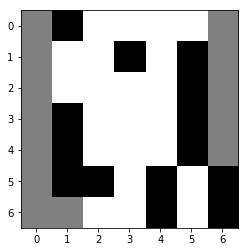

((3, 5), (4, 6)): n_v:  2577 q_all:-0.105686 q:-0.118815 q_m:-0.100000 p:0.016936
((5, 2), (5, 0)): n_v:  1705 q_all:-0.092368 q:-0.209063 q_m:-0.160000 p:0.002658
((5, 1), (6, 1)): n_v:  1576 q_all:-0.152229 q:-0.168071 q_m:-0.100000 p:0.126997
((5, 2), (6, 0)): n_v:  1065 q_all:-0.104259 q:-0.206850 q_m:-0.160000 p:0.005291
((3, 5), (1, 6)): n_v:   887 q_all:-0.148508 q:-0.129389 q_m:-0.120000 p:0.065136
((0, 1), (1, 0)): n_v:   820 q_all:-0.125831 q:-0.108299 q_m:-0.060000 p:0.024516
((3, 1), (1, 0)): n_v:   768 q_all:-0.139260 q:-0.151018 q_m:-0.080000 p:0.042803
((0, 1), (0, 0)): n_v:   536 q_all:-0.168728 q:-0.182471 q_m:-0.100000 p:0.060139
((1, 5), (0, 6)): n_v:   518 q_all:-0.154533 q:-0.159319 q_m:-0.100000 p:0.044095
((3, 1), (5, 0)): n_v:   479 q_all:-0.208945 q:-0.222667 q_m:-0.160000 p:0.086710
((3, 1), (2, 0)): n_v:   408 q_all:-0.129882 q:-0.173156 q_m:-0.060000 p:0.015374
((5, 1), (6, 0)): n_v:   315 q_all:-0.192925 q:-0.190423 q_m:-0.140000 p:0.048568
((3, 1), (4, 0))

((0, 5), (1, 6)): n_v:  2181 q_all:+0.144092 q:+0.075840 q_m:+0.200000 p:0.231219
((6, 2), (6, 1)): n_v:  1006 q_all:+0.161118 q:+0.079158 q_m:+0.200000 p:0.061877
((1, 1), (2, 0)): n_v:   534 q_all:+0.099753 q:+0.026461 q_m:+0.160000 p:0.118349
((1, 1), (1, 0)): n_v:   470 q_all:+0.141332 q:+0.062593 q_m:+0.160000 p:0.053043
((2, 1), (3, 0)): n_v:   447 q_all:+0.099121 q:+0.052682 q_m:+0.200000 p:0.099696
((0, 5), (2, 6)): n_v:   428 q_all:+0.111961 q:+0.061814 q_m:+0.228000 p:0.081254
((6, 2), (4, 0)): n_v:   114 q_all:+0.136804 q:+0.055435 q_m:+0.228000 p:0.014313
((6, 2), (5, 0)): n_v:   100 q_all:+0.106564 q:+0.010906 q_m:+0.180000 p:0.020486
((1, 1), (3, 0)): n_v:    71 q_all:+0.064956 q:+0.029713 q_m:+0.180000 p:0.022282
((0, 4), (1, 6)): n_v:    62 q_all:+0.066029 q:+0.036858 q_m:+0.180000 p:0.019280
((0, 4), (2, 6)): n_v:    61 q_all:+0.087437 q:+0.044083 q_m:+0.228000 p:0.015548
((0, 5), (0, 6)): n_v:    54 q_all:+0.081288 q:+0.046515 q_m:+0.160000 p:0.014733
((1, 1), (0, 0))

((3, 5), (2, 6)): n_v:  4856 q_all:-0.090748 q:-0.114046 q_m:-0.060000 p:0.343723
((4, 6), (2, 6)): n_v:  1260 q_all:-0.117413 q:-0.158868 q_m:-0.080000 p:0.168681
((3, 1), (2, 0)): n_v:   460 q_all:-0.219063 q:-0.245025 q_m:-0.100000 p:0.171790
((3, 1), (4, 0)): n_v:   133 q_all:-0.263368 q:-0.272332 q_m:-0.180000 p:0.063997
((0, 1), (2, 0)): n_v:    86 q_all:-0.215467 q:-0.240012 q_m:-0.120000 p:0.031321
((3, 1), (1, 0)): n_v:    65 q_all:-0.165528 q:-0.234581 q_m:-0.120000 p:0.016313
((4, 5), (2, 6)): n_v:    39 q_all:-0.198820 q:-0.155651 q_m:-0.080000 p:0.012966
((0, 1), (0, 0)): n_v:    33 q_all:-0.229408 q:-0.246667 q_m:-0.140000 p:0.013496
((3, 1), (5, 0)): n_v:    28 q_all:-0.215943 q:-0.306189 q_m:-0.200000 p:0.010563
((4, 1), (2, 0)): n_v:    27 q_all:-0.236865 q:-0.288386 q_m:-0.120000 p:0.011264
((5, 1), (6, 1)): n_v:    20 q_all:-0.218806 q:-0.208306 q_m:-0.140000 p:0.007582
((0, 1), (1, 0)): n_v:    20 q_all:-0.189512 q:-0.177264 q_m:-0.100000 p:0.005977
((4, 1), (5, 0))

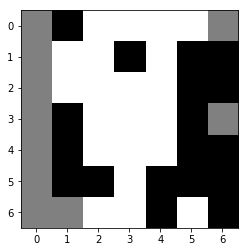

((0, 5), (0, 6)): n_v:  6528 q_all:+0.206162 q:+0.093649 q_m:+0.160000 p:0.138535
((2, 1), (3, 0)): n_v:   726 q_all:+0.062228 q:+0.008982 q_m:+0.160000 p:0.219325
((1, 4), (3, 6)): n_v:   561 q_all:+0.075671 q:+0.056862 q_m:+0.284000 p:0.147754
((6, 2), (6, 1)): n_v:   328 q_all:+0.138872 q:+0.033220 q_m:+0.160000 p:0.026874
((4, 4), (3, 6)): n_v:   261 q_all:+0.094242 q:+0.083719 q_m:+0.284000 p:0.054918
((1, 1), (3, 0)): n_v:   240 q_all:+0.027500 q:-0.009300 q_m:+0.140000 p:0.091605
((2, 4), (3, 6)): n_v:   185 q_all:+0.083915 q:+0.072133 q_m:+0.284000 p:0.044262
((1, 2), (3, 0)): n_v:   177 q_all:-0.023331 q:-0.000537 q_m:+0.140000 p:0.085591
((6, 2), (4, 0)): n_v:    76 q_all:+0.097034 q:+0.018543 q_m:+0.180000 p:0.015261
((1, 1), (1, 0)): n_v:    59 q_all:+0.085472 q:+0.026768 q_m:+0.120000 p:0.013879
((1, 1), (0, 0)): n_v:    45 q_all:+0.087770 q:+0.027338 q_m:+0.120000 p:0.010411
((4, 2), (3, 0)): n_v:    43 q_all:-0.026562 q:-0.038163 q_m:+0.140000 p:0.021181
((2, 2), (3, 0))

((2, 5), (3, 6)): n_v:  4317 q_all:-0.145726 q:-0.165446 q_m:-0.140000 p:0.005266
((0, 1), (1, 0)): n_v:  1774 q_all:-0.188745 q:-0.141259 q_m:-0.060000 p:0.104261
((5, 1), (6, 1)): n_v:  1467 q_all:-0.204244 q:-0.167621 q_m:-0.100000 p:0.142417
((5, 2), (4, 0)): n_v:   760 q_all:-0.095550 q:-0.206002 q_m:-0.160000 p:0.004252
((4, 1), (5, 0)): n_v:   711 q_all:-0.225167 q:-0.205180 q_m:-0.140000 p:0.105980
((0, 1), (0, 0)): n_v:   465 q_all:-0.207210 q:-0.208580 q_m:-0.100000 p:0.048448
((3, 1), (1, 0)): n_v:   443 q_all:-0.214828 q:-0.206725 q_m:-0.080000 p:0.054758
((3, 1), (2, 0)): n_v:   311 q_all:-0.203379 q:-0.202022 q_m:-0.060000 p:0.029529
((3, 1), (5, 0)): n_v:   230 q_all:-0.237903 q:-0.273080 q_m:-0.160000 p:0.041201
((4, 1), (6, 1)): n_v:   207 q_all:-0.216084 q:-0.202753 q_m:-0.120000 p:0.026091
((0, 1), (2, 0)): n_v:   190 q_all:-0.213197 q:-0.201707 q_m:-0.080000 p:0.022526
((5, 2), (6, 0)): n_v:   140 q_all:-0.225778 q:-0.217268 q_m:-0.160000 p:0.020987
((5, 1), (6, 0))

((6, 2), (6, 1)): n_v:  6828 q_all:+0.228982 q:+0.152717 q_m:+0.256000 p:0.121992
((1, 1), (2, 0)): n_v:   538 q_all:+0.115139 q:+0.097826 q_m:+0.200000 p:0.136705
((2, 1), (3, 0)): n_v:   348 q_all:+0.115499 q:+0.120590 q_m:+0.256000 p:0.088282
((6, 2), (4, 0)): n_v:   332 q_all:+0.142414 q:+0.128191 q_m:+0.284000 p:0.065677
((1, 1), (1, 0)): n_v:   281 q_all:+0.141205 q:+0.156174 q_m:+0.200000 p:0.055675
((2, 1), (4, 0)): n_v:   261 q_all:+0.102587 q:+0.130986 q_m:+0.284000 p:0.073154
((6, 2), (5, 0)): n_v:   214 q_all:+0.135717 q:+0.086925 q_m:+0.228000 p:0.045364
((0, 2), (1, 0)): n_v:   107 q_all:+0.041999 q:+0.087574 q_m:+0.180000 p:0.043664
((0, 2), (2, 0)): n_v:    88 q_all:+0.055506 q:+0.066054 q_m:+0.180000 p:0.033578
((1, 1), (0, 0)): n_v:    52 q_all:+0.124827 q:+0.137492 q_m:+0.200000 p:0.012166
((1, 1), (3, 0)): n_v:    42 q_all:+0.119950 q:+0.076291 q_m:+0.228000 p:0.010135
((4, 2), (2, 0)): n_v:    36 q_all:+0.023067 q:+0.026313 q_m:+0.180000 p:0.016158
((2, 2), (4, 0))

((4, 1), (5, 0)): n_v:  7613 q_all:-0.194278 q:-0.208811 q_m:-0.140000 p:0.642958
((4, 1), (6, 0)): n_v:  1498 q_all:-0.149974 q:-0.272657 q_m:-0.160000 p:0.034323
((0, 1), (1, 0)): n_v:  1068 q_all:-0.219932 q:-0.218397 q_m:-0.140000 p:0.129895
((3, 1), (5, 0)): n_v:   592 q_all:-0.210428 q:-0.206107 q_m:-0.160000 p:0.058340
((3, 1), (2, 0)): n_v:   534 q_all:-0.166430 q:-0.390949 q_m:-0.140000 p:0.015842
((3, 1), (1, 0)): n_v:   307 q_all:-0.230673 q:-0.304806 q_m:-0.160000 p:0.045356
((3, 1), (4, 0)): n_v:   108 q_all:-0.269398 q:-0.257911 q_m:-0.180000 p:0.025144
((0, 1), (0, 0)): n_v:    74 q_all:-0.300654 q:-0.389945 q_m:-0.180000 p:0.021829
((0, 1), (2, 0)): n_v:    11 q_all:-0.252222 q:-0.305824 q_m:-0.160000 p:0.002312
((3, 1), (3, 0)): n_v:     4 q_all:-0.296869 q:-0.277274 q_m:-0.180000 p:0.001206
((4, 1), (2, 0)): n_v:     3 q_all:-0.300393 q:-0.361816 q_m:-0.160000 p:0.000912
1 's turn
one move takes time(s):  0.49818944931030273


((6, 2), (4, 0)): n_v:  6741 q_all:+0.263558 q:+0.149714 q_m:+0.340000 p:0.279300
((2, 1), (4, 0)): n_v:  2393 q_all:+0.234592 q:+0.281576 q_m:+0.340000 p:0.137367
((1, 1), (2, 0)): n_v:   413 q_all:+0.162943 q:+0.110222 q_m:+0.200000 p:0.091176
((2, 2), (4, 0)): n_v:   332 q_all:+0.193959 q:+0.233856 q_m:+0.340000 p:0.049929
((0, 2), (2, 0)): n_v:   227 q_all:+0.098483 q:+0.068854 q_m:+0.180000 p:0.076296
((3, 2), (4, 0)): n_v:   194 q_all:+0.195005 q:+0.249223 q_m:+0.340000 p:0.028476
((1, 1), (0, 0)): n_v:   167 q_all:+0.125521 q:+0.171146 q_m:+0.200000 p:0.048156
((2, 1), (3, 0)): n_v:   121 q_all:+0.180750 q:+0.164747 q_m:+0.256000 p:0.021957
((0, 2), (0, 0)): n_v:    66 q_all:+0.093246 q:+0.092975 q_m:+0.180000 p:0.022784
((6, 2), (6, 0)): n_v:    65 q_all:+0.162778 q:+0.149060 q_m:+0.284000 p:0.014297
((1, 1), (1, 0)): n_v:    54 q_all:+0.177195 q:+0.179814 q_m:+0.200000 p:0.010141
((5, 2), (4, 0)): n_v:    52 q_all:+0.182381 q:+0.165425 q_m:+0.340000 p:0.009247
((4, 2), (2, 0))

((6, 1), (6, 2)): n_v: 10500 q_all:-0.228949 q:-0.122939 q_m:-0.120000 p:0.939539
((6, 4), (6, 2)): n_v:   118 q_all:-0.305618 q:-0.168169 q_m:-0.140000 p:0.027209
((0, 1), (2, 0)): n_v:   113 q_all:-0.299624 q:-0.396047 q_m:-0.180000 p:0.025055
((6, 1), (6, 0)): n_v:    14 q_all:-0.290274 q:-0.424524 q_m:-0.200000 p:0.002846
((0, 1), (1, 0)): n_v:     7 q_all:-0.324772 q:-0.370160 q_m:-0.200000 p:0.002022
((5, 4), (6, 2)): n_v:     6 q_all:-0.333156 q:-0.237502 q_m:-0.140000 p:0.001952
((0, 1), (0, 0)): n_v:     5 q_all:-0.305713 q:-0.466460 q_m:-0.256000 p:0.001332
1 's turn
one move takes time(s):  0.38379788398742676


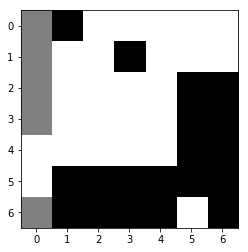

((5, 0), (6, 0)): n_v:  8678 q_all:+0.253407 q:+0.361346 q_m:+0.228000 p:0.454232
((1, 1), (1, 0)): n_v:  3824 q_all:+0.291963 q:+0.164776 q_m:+0.180000 p:0.084309
((1, 1), (0, 0)): n_v:  1640 q_all:+0.288798 q:+0.151446 q_m:+0.180000 p:0.071779
((4, 0), (6, 0)): n_v:   174 q_all:+0.149535 q:+0.159017 q_m:+0.200000 p:0.044449
((0, 2), (0, 0)): n_v:   122 q_all:+0.069154 q:+0.053035 q_m:+0.160000 p:0.048351
((0, 2), (1, 0)): n_v:    61 q_all:+0.071199 q:+0.055238 q_m:+0.160000 p:0.024116
((1, 1), (2, 0)): n_v:    23 q_all:+0.050375 q:+0.041306 q_m:+0.140000 p:0.010127
((4, 1), (6, 0)): n_v:    21 q_all:+0.079730 q:+0.121869 q_m:+0.200000 p:0.008018
((3, 1), (1, 0)): n_v:    11 q_all:+0.069246 q:+0.060028 q_m:+0.160000 p:0.004355
((2, 1), (0, 0)): n_v:     7 q_all:+0.046035 q:+0.010609 q_m:+0.160000 p:0.003126
((1, 2), (0, 0)): n_v:     7 q_all:+0.056692 q:+0.072715 q_m:+0.160000 p:0.003241
((4, 2), (6, 0)): n_v:     5 q_all:+0.069665 q:+0.057396 q_m:+0.200000 p:0.002034
((0, 2), (2, 0))

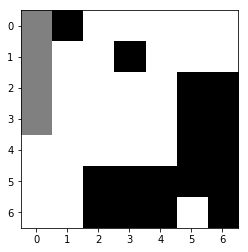

((5, 2), (3, 0)): n_v:  4819 q_all:-0.243940 q:-0.264426 q_m:-0.060000 p:0.488848
((0, 1), (2, 0)): n_v:  3143 q_all:-0.236280 q:-0.366473 q_m:-0.100000 p:0.277506
((0, 1), (1, 0)): n_v:  1351 q_all:-0.256802 q:-0.279218 q_m:-0.120000 p:0.166824
((0, 1), (0, 0)): n_v:   301 q_all:-0.313540 q:-0.320487 q_m:-0.160000 p:0.066120
1 's turn
one move takes time(s):  0.26421380043029785


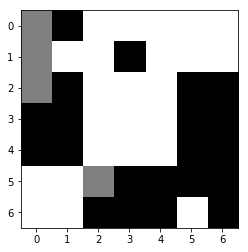

((4, 2), (5, 2)): n_v:  6798 q_all:+0.516660 q:+0.191321 q_m:+0.256000 p:0.266389
((6, 0), (5, 2)): n_v:   146 q_all:+0.320866 q:+0.178266 q_m:+0.228000 p:0.028276
((5, 0), (5, 2)): n_v:    14 q_all:+0.142957 q:+0.157222 q_m:+0.228000 p:0.010420
((1, 1), (2, 0)): n_v:     2 q_all:+0.071050 q:+0.104571 q_m:+0.200000 p:0.002414
((3, 4), (5, 2)): n_v:     2 q_all:+0.187287 q:+0.113371 q_m:+0.228000 p:0.001460
((4, 4), (5, 2)): n_v:     1 q_all:+0.177918 q:+0.127012 q_m:+0.228000 p:0.001135
((3, 3), (5, 2)): n_v:     1 q_all:+0.075512 q:+0.185881 q_m:+0.228000 p:0.000641
((1, 2), (1, 0)): n_v:     0 q_all:+0.086949 q:+0.007372 q_m:+0.140000 p:0.000001
((0, 2), (2, 0)): n_v:     0 q_all:+0.142709 q:+0.086773 q_m:+0.180000 p:0.000076
((1, 1), (0, 0)): n_v:     0 q_all:+0.096813 q:+0.062033 q_m:+0.120000 p:0.000023
((0, 2), (0, 0)): n_v:     0 q_all:+0.034910 q:-0.062726 q_m:+0.100000 p:0.000004
((0, 2), (1, 0)): n_v:     0 q_all:+0.068444 q:-0.038889 q_m:+0.140000 p:0.000026
((1, 2), (0, 0))

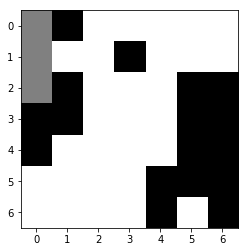

((0, 1), (2, 0)): n_v:  6296 q_all:-0.459498 q:-0.544302 q_m:-0.200000 p:0.141529
((0, 1), (1, 0)): n_v:  2533 q_all:-0.517397 q:-0.394553 q_m:-0.180000 p:0.218304
((3, 1), (1, 0)): n_v:   688 q_all:-0.485915 q:-0.448653 q_m:-0.200000 p:0.006869
((0, 1), (0, 0)): n_v:   685 q_all:-0.528310 q:-0.513797 q_m:-0.180000 p:0.077374
((3, 0), (1, 0)): n_v:   611 q_all:-0.502931 q:-0.504468 q_m:-0.200000 p:0.031313
((2, 1), (2, 0)): n_v:   586 q_all:-0.545159 q:-0.630172 q_m:-0.180000 p:0.090153
((4, 0), (2, 0)): n_v:   189 q_all:-0.512527 q:-0.408653 q_m:-0.200000 p:0.013874
((2, 1), (0, 0)): n_v:   175 q_all:-0.517968 q:-0.409693 q_m:-0.200000 p:0.015306
1 's turn
one move takes time(s):  0.1821744441986084


((0, 2), (1, 0)): n_v: 10614 q_all:+0.592477 q:+0.687941 q_m:+0.368000 p:0.757595
((1, 2), (1, 0)): n_v:   155 q_all:+0.390532 q:+0.726156 q_m:+0.368000 p:0.051827
((3, 2), (1, 0)): n_v:   124 q_all:+0.351663 q:+0.577681 q_m:+0.368000 p:0.053903
((0, 2), (0, 1)): n_v:    93 q_all:+0.329339 q:+0.527829 q_m:+0.284000 p:0.045942
((2, 2), (1, 0)): n_v:    67 q_all:+0.345037 q:+0.444527 q_m:+0.368000 p:0.030683
((0, 3), (0, 1)): n_v:    16 q_all:+0.187817 q:+0.225001 q_m:+0.256000 p:0.013676
((0, 2), (0, 0)): n_v:    10 q_all:+0.231522 q:+0.205935 q_m:+0.256000 p:0.007461
((2, 2), (0, 1)): n_v:     1 q_all:+0.216480 q:+0.271014 q_m:+0.256000 p:0.001083
((1, 2), (0, 0)): n_v:     1 q_all:+0.149775 q:+0.138315 q_m:+0.256000 p:0.001153
((2, 2), (0, 0)): n_v:     0 q_all:+0.200388 q:+0.116971 q_m:+0.256000 p:0.000180
((2, 3), (0, 1)): n_v:     0 q_all:+0.230551 q:+0.213585 q_m:+0.256000 p:0.000640
-1 's turn
one move takes time(s):  0.25444889068603516


((1, 3), (0, 1)): n_v:  9020 q_all:-0.387875 q:-0.703910 q_m:-0.200000 p:0.263533
((1, 3), (0, 2)): n_v:  5684 q_all:-0.608842 q:-0.619802 q_m:-0.180000 p:0.727442
1 's turn
one move takes time(s):  0.28177332878112793


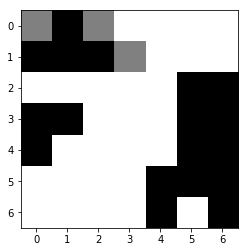

((0, 3), (0, 2)): n_v:  5937 q_all:+0.386035 q:+0.763265 q_m:+0.396000 p:0.452742
((2, 3), (0, 2)): n_v:  5258 q_all:+0.458695 q:+0.576590 q_m:+0.368000 p:0.036876
((2, 2), (0, 0)): n_v:   583 q_all:+0.419058 q:+0.497057 q_m:+0.368000 p:0.003848
((2, 0), (0, 0)): n_v:   366 q_all:+0.341567 q:+0.518766 q_m:+0.368000 p:0.062202
((2, 0), (0, 2)): n_v:   247 q_all:+0.324375 q:+0.633151 q_m:+0.368000 p:0.051020
((1, 4), (0, 2)): n_v:   219 q_all:+0.333986 q:+0.583898 q_m:+0.368000 p:0.040539
((0, 4), (0, 2)): n_v:   216 q_all:+0.304680 q:+0.438735 q_m:+0.368000 p:0.053581
((0, 3), (1, 3)): n_v:   134 q_all:+0.294041 q:+0.572677 q_m:+0.284000 p:0.036047
((2, 4), (0, 2)): n_v:   116 q_all:+0.355189 q:+0.693024 q_m:+0.368000 p:0.016261
((2, 2), (0, 2)): n_v:    70 q_all:+0.394543 q:+0.519141 q_m:+0.368000 p:0.003892
((2, 1), (0, 2)): n_v:    63 q_all:+0.347790 q:+0.651919 q_m:+0.368000 p:0.009691
((2, 1), (0, 0)): n_v:    23 q_all:+0.327888 q:+0.432585 q_m:+0.368000 p:0.004484
((3, 2), (1, 3))

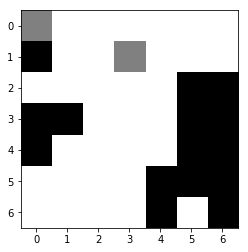

((3, 1), (1, 3)): n_v:  3334 q_all:-0.333238 q:-0.350791 q_m:-0.020000 p:0.335670
((3, 5), (1, 3)): n_v:  2880 q_all:-0.327217 q:-0.229951 q_m:-0.020000 p:0.256571
((2, 5), (1, 3)): n_v:  2015 q_all:-0.383258 q:-0.389745 q_m:-0.020000 p:0.395338
((1, 0), (0, 0)): n_v:    14 q_all:-0.736343 q:-0.836858 q_m:-0.256000 p:0.012418
1 's turn


This is a random move


one move takes time(s):  0.19170832633972168


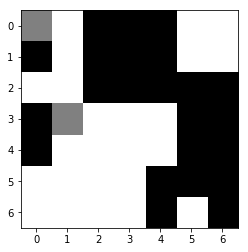

((2, 0), (3, 1)): n_v:  7319 q_all:+0.515200 q:+0.666029 q_m:+0.160000 p:0.284604
((2, 0), (0, 0)): n_v:    53 q_all:+0.468335 q:-0.421809 q_m:+0.060000 p:0.004862
((5, 0), (3, 1)): n_v:    41 q_all:+0.221045 q:+0.323797 q_m:+0.140000 p:0.027857
((5, 1), (3, 1)): n_v:     6 q_all:+0.197592 q:+0.042064 q_m:+0.140000 p:0.005110
((1, 1), (3, 1)): n_v:     3 q_all:-0.699723 q:+0.241847 q_m:+0.140000 p:0.007955
((5, 2), (3, 1)): n_v:     2 q_all:+0.013450 q:+0.191443 q_m:+0.140000 p:0.002386
((4, 3), (3, 1)): n_v:     1 q_all:-0.032945 q:+0.249888 q_m:+0.140000 p:0.001512
((3, 3), (3, 1)): n_v:     1 q_all:+0.058460 q:+0.325727 q_m:+0.140000 p:0.000865
((5, 3), (3, 1)): n_v:     1 q_all:-0.006323 q:+0.301225 q_m:+0.140000 p:0.002028
((2, 1), (0, 0)): n_v:     0 q_all:-0.250696 q:-0.457827 q_m:+0.060000 p:0.000904
((0, 1), (0, 0)): n_v:     0 q_all:-0.171123 q:-0.338538 q_m:+0.080000 p:0.000345
-1 's turn
one move takes time(s):  0.12467598915100098


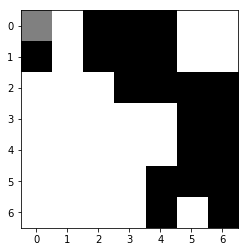

((0, 2), (0, 0)): n_v: 12083 q_all:-0.503125 q:-0.558890 q_m:-0.080000 p:0.822132
((1, 0), (0, 0)): n_v:   150 q_all:-1.000000 q:+5.000000 q_m:-0.060000 p:0.145070
((1, 2), (0, 0)): n_v:    86 q_all:-0.669317 q:-0.671628 q_m:-0.080000 p:0.031392
1 's turn
one move takes time(s):  0.11851835250854492


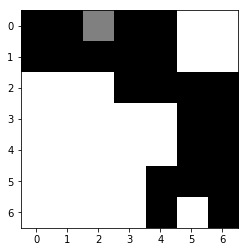

((2, 0), (0, 2)): n_v: 14630 q_all:+0.692889 q:+0.753393 q_m:+0.312000 p:0.904419
((2, 1), (0, 2)): n_v:   138 q_all:+0.259541 q:+0.419043 q_m:+0.312000 p:0.080999
((2, 2), (0, 2)): n_v:    41 q_all:+0.388833 q:+0.601529 q_m:+0.312000 p:0.014262
-1 's turn
one move takes time(s):  0.09004974365234375


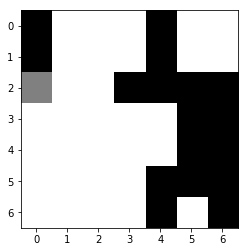

((0, 0), (2, 0)): n_v: 13825 q_all:-0.817729 q:-0.709033 q_m:-0.120000 p:0.659459
((1, 0), (2, 0)): n_v:  1105 q_all:-1.000000 q:+5.000000 q_m:-0.100000 p:0.340512
1 's turn
one move takes time(s):  0.07813334465026855


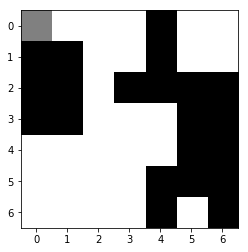

((0, 1), (0, 0)): n_v: 14004 q_all:+1.000000 q:+5.000000 q_m:+0.228000 p:0.868553
((0, 2), (0, 0)): n_v:   163 q_all:+0.551190 q:+0.236995 q_m:+0.200000 p:0.117435
((1, 2), (0, 0)): n_v:     8 q_all:-0.079172 q:+0.159803 q_m:+0.200000 p:0.012037
((2, 2), (0, 0)): n_v:     0 q_all:-0.092996 q:-0.288326 q_m:+0.200000 p:0.001249
this self play has 76 steps, time elapsed 177.80967664718628
winner is 1.0
episode 26 finished
episode 27 now start
it seems the reset did nothing
reset successful
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.9327957630157471
1 's turn
one move takes time(s):  1.1011629104614258
-1 's turn


This is a random move


one move takes time(s):  1.9031188488006592
1 's turn
due to rollout lim, final rollout times:  2022 time elapsed:  2.0032691955566406


This is a random move


one move takes time(s):  2.0047006607055664
-1 's turn
due to rollout lim, final rollout times:  1508 time elapsed:  2.005141019821167


This is a random move


one

due to rollout lim, final rollout times:  1269 time elapsed:  2.0099995136260986
one move takes time(s):  2.011444330215454
-1 's turn
due to rollout lim, final rollout times:  1691 time elapsed:  2.0056471824645996
one move takes time(s):  2.0068142414093018
1 's turn
one move takes time(s):  1.483973503112793
-1 's turn
one move takes time(s):  1.1694939136505127
1 's turn
one move takes time(s):  1.4361624717712402
-1 's turn
one move takes time(s):  0.7905278205871582
1 's turn
one move takes time(s):  0.7397692203521729
-1 's turn
one move takes time(s):  1.2521347999572754
1 's turn
one move takes time(s):  0.7617623805999756
-1 's turn
one move takes time(s):  0.8901691436767578
1 's turn


This is a random move


one move takes time(s):  0.6567559242248535
-1 's turn
one move takes time(s):  0.7835845947265625
1 's turn


This is a random move


one move takes time(s):  0.45122575759887695
-1 's turn
one move takes time(s):  0.386401891708374
1 's turn
one move takes time(s):  

one move takes time(s):  1.4977788925170898
-1 's turn
due to rollout lim, final rollout times:  2570 time elapsed:  2.006549119949341
one move takes time(s):  2.0077638626098633
1 's turn
one move takes time(s):  1.3429250717163086
-1 's turn
one move takes time(s):  1.9164180755615234
1 's turn
one move takes time(s):  1.482191801071167
-1 's turn
one move takes time(s):  1.3333418369293213
1 's turn
one move takes time(s):  0.8692586421966553
-1 's turn


This is a random move


one move takes time(s):  1.4767217636108398
1 's turn
one move takes time(s):  1.2905097007751465
-1 's turn


This is a random move


one move takes time(s):  1.7109944820404053
1 's turn
due to rollout lim, final rollout times:  4856 time elapsed:  2.0000674724578857
one move takes time(s):  2.001201629638672
-1 's turn
one move takes time(s):  0.7092936038970947
1 's turn
one move takes time(s):  0.6952922344207764
-1 's turn
one move takes time(s):  0.6159281730651855
1 's turn
one move takes time(s):  0

one move takes time(s):  0.9201269149780273
1 's turn
one move takes time(s):  1.2718052864074707
-1 's turn
one move takes time(s):  0.8936138153076172
1 's turn


This is a random move


one move takes time(s):  0.6255276203155518
-1 's turn
one move takes time(s):  0.735321044921875
1 's turn
one move takes time(s):  0.8030426502227783
-1 's turn
one move takes time(s):  1.1989390850067139
1 's turn
one move takes time(s):  0.6809959411621094
-1 's turn
one move takes time(s):  0.7374989986419678
1 's turn
one move takes time(s):  0.6626114845275879
-1 's turn
one move takes time(s):  0.31378960609436035
1 's turn
one move takes time(s):  0.3929786682128906
-1 's turn


This is a random move


one move takes time(s):  0.34970593452453613
1 's turn
one move takes time(s):  0.2696554660797119
-1 's turn
one move takes time(s):  0.3050990104675293
1 's turn
one move takes time(s):  0.20085620880126953
-1 's turn
one move takes time(s):  0.22472572326660156
1 's turn
one move takes time



This is a random move


one move takes time(s):  1.6429235935211182
1 's turn
one move takes time(s):  0.9058489799499512
-1 's turn
one move takes time(s):  0.8307821750640869
1 's turn


This is a random move


one move takes time(s):  1.2037081718444824
-1 's turn
one move takes time(s):  0.5932998657226562
1 's turn
one move takes time(s):  1.5379705429077148
-1 's turn
one move takes time(s):  0.8035967350006104
1 's turn
one move takes time(s):  0.9121243953704834
-1 's turn
one move takes time(s):  0.5495655536651611
1 's turn
one move takes time(s):  0.9039902687072754
-1 's turn
one move takes time(s):  0.5802879333496094
1 's turn
one move takes time(s):  0.6068775653839111
-1 's turn


This is a random move


one move takes time(s):  0.4490163326263428
1 's turn
one move takes time(s):  0.6444978713989258
-1 's turn
one move takes time(s):  0.3306117057800293
1 's turn
one move takes time(s):  0.33179259300231934
-1 's turn
one move takes time(s):  0.2940516471862793
1 's 

one move takes time(s):  1.160987138748169
1 's turn
due to rollout lim, final rollout times:  2796 time elapsed:  2.007878303527832
one move takes time(s):  2.0092244148254395
-1 's turn
due to rollout lim, final rollout times:  3693 time elapsed:  2.0000035762786865
one move takes time(s):  2.001356840133667
1 's turn
one move takes time(s):  1.304783821105957
-1 's turn
due to rollout lim, final rollout times:  1477 time elapsed:  2.0023951530456543
one move takes time(s):  2.0037107467651367
1 's turn
due to rollout lim, final rollout times:  4953 time elapsed:  2.000133514404297


This is a random move


one move takes time(s):  2.001476764678955
-1 's turn
one move takes time(s):  1.244067668914795
1 's turn


This is a random move


one move takes time(s):  1.5432257652282715
-1 's turn
one move takes time(s):  1.9483144283294678
1 's turn
one move takes time(s):  1.4210586547851562
-1 's turn
due to rollout lim, final rollout times:  1451 time elapsed:  2.000812292098999
one mo

due to rollout lim, final rollout times:  1001 time elapsed:  2.4249820709228516
one move takes time(s):  2.426814317703247
-1 's turn
due to rollout lim, final rollout times:  1425 time elapsed:  2.028451442718506
one move takes time(s):  2.029761552810669
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.6993906497955322
one move takes time(s):  2.7016146183013916
-1 's turn
due to rollout lim, final rollout times:  3121 time elapsed:  2.000309467315674
one move takes time(s):  2.0015881061553955
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.2295007705688477
one move takes time(s):  3.2307817935943604
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.372405529022217
one move takes time(s):  2.3738386631011963
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.3041412830352783
one move takes time(s):  2.3054165840148926
-1 's turn
due to rollout lim, final rollout times:  1001 time elap

due to rollout lim, final rollout times:  2956 time elapsed:  2.006956100463867
one move takes time(s):  2.0083882808685303
-1 's turn
due to rollout lim, final rollout times:  4003 time elapsed:  2.0000569820404053
one move takes time(s):  2.0013749599456787
1 's turn
due to rollout lim, final rollout times:  1468 time elapsed:  2.0089128017425537
one move takes time(s):  2.0102245807647705
-1 's turn
due to rollout lim, final rollout times:  1709 time elapsed:  2.0070910453796387
one move takes time(s):  2.0083749294281006
1 's turn
due to rollout lim, final rollout times:  1634 time elapsed:  2.0135912895202637
one move takes time(s):  2.0156197547912598
-1 's turn
due to rollout lim, final rollout times:  1841 time elapsed:  2.0042953491210938
one move takes time(s):  2.005598306655884
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.0284972190856934
one move takes time(s):  2.0298209190368652
-1 's turn
due to rollout lim, final rollout times:  1001 time e

one move takes time(s):  1.616891622543335
-1 's turn
one move takes time(s):  0.47084760665893555
1 's turn
one move takes time(s):  0.6352541446685791
-1 's turn
one move takes time(s):  0.47960591316223145
1 's turn
one move takes time(s):  0.43332481384277344
-1 's turn
one move takes time(s):  0.27773427963256836
1 's turn


This is a random move


one move takes time(s):  0.19306516647338867
-1 's turn
one move takes time(s):  0.20353055000305176
1 's turn
one move takes time(s):  0.20739483833312988
-1 's turn
one move takes time(s):  0.17671704292297363
1 's turn
one move takes time(s):  0.13919997215270996
-1 's turn
one move takes time(s):  0.13472938537597656
1 's turn
one move takes time(s):  0.13952279090881348
-1 's turn
one move takes time(s):  0.1037743091583252
1 's turn
one move takes time(s):  0.06445646286010742
this self play has 92 steps, time elapsed 260.9998002052307
winner is 1.0
episode 33 finished
episode 34 now start
it seems the reset did nothing
reset succ



This is a random move


one move takes time(s):  0.8949506282806396
1 's turn


This is a random move


one move takes time(s):  1.081941843032837
-1 's turn


This is a random move


one move takes time(s):  1.8011929988861084
1 's turn
one move takes time(s):  1.8454551696777344
-1 's turn
due to rollout lim, final rollout times:  2053 time elapsed:  2.000525712966919


This is a random move


one move takes time(s):  2.0012316703796387
1 's turn
due to rollout lim, final rollout times:  2527 time elapsed:  2.0000953674316406


This is a random move


one move takes time(s):  2.002122640609741
-1 's turn
due to rollout lim, final rollout times:  2261 time elapsed:  2.0000195503234863
one move takes time(s):  2.001178026199341
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.1020309925079346
one move takes time(s):  2.10336971282959
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.6336941719055176
one move takes time(s):  2.63486480

due to rollout lim, final rollout times:  1001 time elapsed:  2.278512477874756
one move takes time(s):  2.2797720432281494
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.5022692680358887
one move takes time(s):  3.5036137104034424
1 's turn
due to rollout lim, final rollout times:  1642 time elapsed:  2.0035452842712402
one move takes time(s):  2.0048110485076904
-1 's turn
due to rollout lim, final rollout times:  1826 time elapsed:  2.0017783641815186
one move takes time(s):  2.0030505657196045
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.0820274353027344


This is a random move


one move takes time(s):  2.083331346511841
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  4.760381698608398
one move takes time(s):  4.761483430862427
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  4.324157238006592
one move takes time(s):  4.32543158531189
-1 's turn
due to rollout lim, final rollou

one move takes time(s):  1.5527443885803223
-1 's turn
one move takes time(s):  1.3222076892852783
1 's turn


This is a random move


one move takes time(s):  0.9979672431945801
-1 's turn
one move takes time(s):  0.945950984954834
1 's turn
one move takes time(s):  0.7311892509460449
-1 's turn
one move takes time(s):  0.7826745510101318
1 's turn
one move takes time(s):  0.8425045013427734
-1 's turn
one move takes time(s):  0.5255045890808105
1 's turn
one move takes time(s):  0.877988338470459
-1 's turn
one move takes time(s):  0.9062521457672119
1 's turn
one move takes time(s):  1.5498290061950684
-1 's turn
one move takes time(s):  1.577423095703125
1 's turn
one move takes time(s):  1.288961410522461
-1 's turn
one move takes time(s):  1.2844572067260742
1 's turn
one move takes time(s):  0.6143105030059814
-1 's turn
one move takes time(s):  0.8020107746124268
1 's turn
one move takes time(s):  0.6424977779388428
-1 's turn
one move takes time(s):  0.4183979034423828
1 's tu

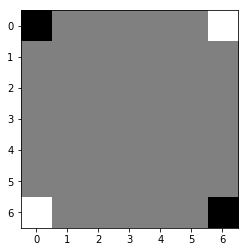

((0, 0), (1, 1)): n_v:  1543 q_all:+0.012907 q:-0.002902 q_m:+0.020000 p:0.313163
((6, 6), (5, 5)): n_v:  1456 q_all:+0.015951 q:+0.008119 q_m:+0.020000 p:0.283039
((0, 0), (1, 0)): n_v:   581 q_all:+0.014040 q:-0.001014 q_m:+0.020000 p:0.116062
((6, 6), (5, 6)): n_v:   487 q_all:+0.012779 q:+0.001433 q_m:+0.020000 p:0.099018
((0, 0), (0, 1)): n_v:   454 q_all:+0.012924 q:-0.000863 q_m:+0.020000 p:0.092273
((6, 6), (6, 5)): n_v:   427 q_all:+0.016389 q:+0.015831 q_m:+0.020000 p:0.082512
((0, 0), (2, 1)): n_v:    11 q_all:+0.000941 q:-0.002851 q_m:-0.000000 p:0.002611
((6, 6), (4, 5)): n_v:     9 q_all:+0.003065 q:-0.011425 q_m:-0.000000 p:0.002287
((0, 0), (1, 2)): n_v:     8 q_all:+0.001626 q:-0.000006 q_m:-0.000000 p:0.002087
((6, 6), (5, 4)): n_v:     5 q_all:+0.006742 q:-0.002984 q_m:-0.000000 p:0.001213
((0, 0), (2, 2)): n_v:     4 q_all:+0.003139 q:-0.010364 q_m:-0.000000 p:0.001049
((6, 6), (6, 4)): n_v:     3 q_all:+0.006418 q:+0.002557 q_m:-0.000000 p:0.000766
((0, 0), (0, 2))

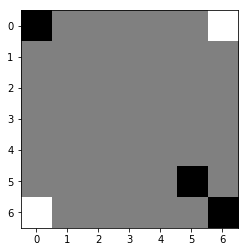

((6, 0), (5, 1)): n_v:  1763 q_all:-0.004144 q:-0.005712 q_m:-0.000000 p:0.266643
((0, 6), (1, 5)): n_v:  1313 q_all:-0.005710 q:+0.015536 q_m:-0.000000 p:0.203665
((6, 0), (5, 0)): n_v:  1118 q_all:-0.004439 q:-0.002051 q_m:-0.000000 p:0.169936
((6, 0), (6, 1)): n_v:   823 q_all:-0.006560 q:-0.002913 q_m:-0.000000 p:0.129447
((0, 6), (1, 6)): n_v:   789 q_all:-0.006999 q:+0.012602 q_m:-0.000000 p:0.124917
((0, 6), (0, 5)): n_v:   619 q_all:-0.007135 q:+0.000159 q_m:-0.000000 p:0.098322
((0, 6), (2, 6)): n_v:     5 q_all:-0.014575 q:+0.003066 q_m:-0.020000 p:0.001043
((6, 0), (6, 2)): n_v:     4 q_all:-0.015879 q:-0.007546 q_m:-0.020000 p:0.000893
((0, 6), (0, 4)): n_v:     4 q_all:-0.009588 q:-0.021609 q_m:-0.020000 p:0.000668
((6, 0), (4, 0)): n_v:     4 q_all:-0.019801 q:-0.000221 q_m:-0.020000 p:0.000846
((0, 6), (1, 4)): n_v:     4 q_all:-0.007447 q:-0.007839 q_m:-0.020000 p:0.000698
((6, 0), (4, 1)): n_v:     3 q_all:-0.005103 q:-0.004905 q_m:-0.020000 p:0.000490
((6, 0), (5, 2))

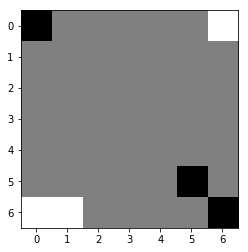

((0, 0), (1, 1)): n_v:  1048 q_all:+0.013305 q:+0.005415 q_m:+0.020000 p:0.164537
((5, 5), (4, 6)): n_v:   959 q_all:+0.011795 q:+0.002870 q_m:+0.020000 p:0.154277
((0, 0), (1, 0)): n_v:   692 q_all:+0.013397 q:+0.008599 q_m:+0.020000 p:0.108420
((5, 5), (4, 5)): n_v:   614 q_all:+0.012541 q:+0.009394 q_m:+0.020000 p:0.097718
((5, 5), (5, 4)): n_v:   580 q_all:+0.014285 q:+0.015839 q_m:+0.020000 p:0.089520
((0, 0), (0, 1)): n_v:   504 q_all:+0.013677 q:+0.006605 q_m:+0.020000 p:0.078594
((5, 5), (6, 4)): n_v:   439 q_all:+0.016474 q:+0.018069 q_m:+0.020000 p:0.065280
((5, 5), (5, 6)): n_v:   389 q_all:+0.011416 q:+0.003798 q_m:+0.020000 p:0.063039
((5, 5), (4, 4)): n_v:   279 q_all:+0.009575 q:-0.004295 q_m:+0.020000 p:0.046623
((5, 5), (6, 5)): n_v:   258 q_all:+0.014333 q:+0.024954 q_m:+0.020000 p:0.039881
((0, 0), (1, 2)): n_v:    11 q_all:+0.000922 q:+0.006971 q_m:-0.000000 p:0.002133
((0, 0), (2, 1)): n_v:    10 q_all:+0.001774 q:+0.005153 q_m:-0.000000 p:0.001865
((5, 5), (3, 6))

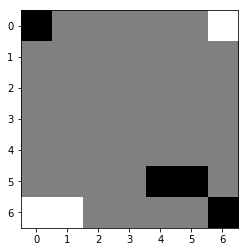

((0, 6), (0, 5)): n_v:  2850 q_all:-0.003810 q:-0.004199 q_m:-0.000000 p:0.474220
((0, 6), (1, 5)): n_v:   809 q_all:-0.001790 q:+0.012699 q_m:-0.000000 p:0.130235
((0, 6), (1, 6)): n_v:   760 q_all:-0.002004 q:+0.009491 q_m:-0.000000 p:0.122901
((6, 0), (5, 1)): n_v:   391 q_all:+0.003232 q:-0.006487 q_m:-0.000000 p:0.057687
((6, 0), (5, 0)): n_v:   286 q_all:-0.001664 q:-0.011053 q_m:-0.000000 p:0.046072
((6, 1), (6, 2)): n_v:   225 q_all:+0.007822 q:+0.002929 q_m:-0.000000 p:0.030463
((6, 1), (5, 2)): n_v:   179 q_all:+0.019451 q:-0.000097 q_m:-0.000000 p:0.018704
((0, 6), (0, 4)): n_v:    13 q_all:-0.013243 q:-0.024315 q_m:-0.020000 p:0.002595
((0, 6), (2, 4)): n_v:    13 q_all:+0.016354 q:-0.020681 q_m:-0.020000 p:0.001470
((0, 6), (2, 5)): n_v:    10 q_all:+0.014395 q:-0.018645 q_m:-0.020000 p:0.001266
((6, 1), (5, 3)): n_v:     6 q_all:-0.043085 q:-0.006165 q_m:+0.020000 p:0.001656
((0, 6), (2, 6)): n_v:     5 q_all:+0.007319 q:-0.004625 q_m:-0.020000 p:0.000791
((6, 1), (6, 3))

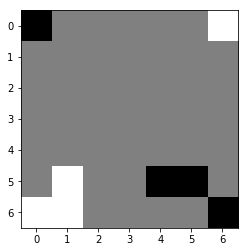

((0, 0), (1, 0)): n_v:   549 q_all:+0.023070 q:+0.012805 q_m:+0.020000 p:0.150216
((5, 4), (6, 4)): n_v:   419 q_all:+0.028821 q:+0.017654 q_m:+0.020000 p:0.105799
((5, 5), (4, 6)): n_v:   291 q_all:+0.020107 q:+0.006535 q_m:+0.020000 p:0.082802
((0, 0), (0, 1)): n_v:   243 q_all:+0.018908 q:+0.010521 q_m:+0.020000 p:0.070394
((5, 4), (5, 2)): n_v:   233 q_all:+0.008461 q:+0.035374 q_m:+0.080000 p:0.076449
((0, 0), (1, 1)): n_v:   228 q_all:+0.020000 q:+0.009384 q_m:+0.020000 p:0.065101
((5, 5), (5, 6)): n_v:   216 q_all:+0.016385 q:+0.006552 q_m:+0.020000 p:0.064451
((5, 4), (4, 5)): n_v:   187 q_all:+0.035566 q:+0.011266 q_m:+0.020000 p:0.042433
((5, 4), (5, 3)): n_v:   156 q_all:+0.058264 q:-0.001500 q_m:+0.020000 p:0.022439
((5, 4), (4, 4)): n_v:   103 q_all:+0.030327 q:-0.000832 q_m:+0.020000 p:0.025626
((5, 4), (6, 3)): n_v:   103 q_all:+0.059933 q:-0.000965 q_m:+0.020000 p:0.014104
((5, 4), (6, 5)): n_v:    92 q_all:+0.016929 q:+0.019002 q_m:+0.020000 p:0.027214
((5, 4), (4, 3))

((0, 6), (0, 5)): n_v:  1564 q_all:+0.005242 q:+0.003336 q_m:-0.000000 p:0.395644
((0, 6), (1, 5)): n_v:   420 q_all:+0.010236 q:+0.017991 q_m:-0.000000 p:0.099302
((0, 6), (1, 6)): n_v:   315 q_all:+0.005948 q:+0.013729 q_m:-0.000000 p:0.078934
((5, 1), (4, 0)): n_v:   260 q_all:+0.011346 q:+0.012226 q_m:-0.000000 p:0.060689
((5, 1), (6, 3)): n_v:   189 q_all:+0.044109 q:+0.035889 q_m:+0.060000 p:0.023428
((6, 1), (6, 3)): n_v:   178 q_all:+0.035525 q:+0.050794 q_m:+0.060000 p:0.027155
((5, 1), (6, 2)): n_v:   154 q_all:-0.033388 q:-0.008906 q_m:-0.000000 p:0.058961
((5, 1), (4, 2)): n_v:   143 q_all:-0.010957 q:-0.011801 q_m:-0.000000 p:0.044102
((5, 1), (5, 0)): n_v:   137 q_all:+0.011858 q:+0.000882 q_m:-0.000000 p:0.031766
((6, 1), (5, 3)): n_v:    76 q_all:+0.034783 q:+0.013124 q_m:+0.060000 p:0.011804
((5, 1), (5, 3)): n_v:    54 q_all:+0.034898 q:+0.007091 q_m:+0.060000 p:0.008434
((5, 1), (4, 1)): n_v:    52 q_all:-0.001482 q:+0.006098 q_m:-0.000000 p:0.014407
((5, 1), (5, 2))

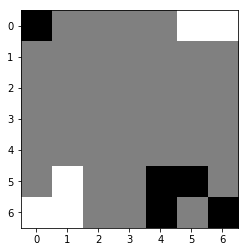

((0, 0), (1, 0)): n_v:   515 q_all:+0.021944 q:+0.001610 q_m:+0.020000 p:0.136027
((5, 5), (4, 6)): n_v:   380 q_all:+0.010894 q:-0.005204 q_m:+0.020000 p:0.116857
((5, 5), (5, 6)): n_v:   361 q_all:+0.014908 q:-0.002541 q_m:+0.020000 p:0.105516
((0, 0), (1, 1)): n_v:   231 q_all:+0.022021 q:+0.000468 q_m:+0.020000 p:0.061032
((6, 4), (5, 2)): n_v:   208 q_all:+0.003722 q:+0.046208 q_m:+0.080000 p:0.070137
((5, 4), (4, 5)): n_v:   185 q_all:+0.022788 q:+0.011198 q_m:+0.020000 p:0.048262
((0, 0), (0, 1)): n_v:   176 q_all:+0.018847 q:+0.003323 q_m:+0.020000 p:0.048702
((5, 4), (5, 2)): n_v:   134 q_all:+0.012722 q:+0.029554 q_m:+0.080000 p:0.040306
((5, 4), (6, 5)): n_v:    80 q_all:+0.009810 q:+0.000509 q_m:+0.020000 p:0.025104
((6, 4), (6, 2)): n_v:    47 q_all:+0.024881 q:+0.059111 q_m:+0.080000 p:0.012064
((5, 4), (4, 4)): n_v:    46 q_all:-0.023642 q:-0.009224 q_m:+0.020000 p:0.020549
((5, 4), (5, 3)): n_v:    38 q_all:-0.043978 q:-0.025708 q_m:+0.020000 p:0.020117
((5, 4), (4, 3))

((5, 1), (4, 0)): n_v:   341 q_all:+0.014713 q:-0.002854 q_m:-0.000000 p:0.112885
((0, 5), (0, 4)): n_v:   214 q_all:+0.009397 q:-0.008970 q_m:-0.000000 p:0.076254
((5, 1), (5, 0)): n_v:   204 q_all:+0.008989 q:-0.008841 q_m:-0.000000 p:0.072969
((0, 5), (1, 6)): n_v:   195 q_all:+0.002155 q:+0.000574 q_m:-0.000000 p:0.075823
((5, 1), (6, 2)): n_v:   153 q_all:-0.035408 q:-0.017788 q_m:-0.000000 p:0.086295
((5, 1), (4, 2)): n_v:   143 q_all:-0.015132 q:-0.020644 q_m:-0.000000 p:0.067408
((0, 5), (1, 4)): n_v:    98 q_all:+0.015793 q:-0.003085 q_m:-0.000000 p:0.031877
((5, 1), (4, 1)): n_v:    93 q_all:-0.008430 q:-0.009367 q_m:-0.000000 p:0.040867
((0, 5), (1, 5)): n_v:    89 q_all:+0.008725 q:-0.002109 q_m:-0.000000 p:0.031853
((5, 1), (6, 3)): n_v:    73 q_all:+0.042431 q:+0.027259 q_m:+0.060000 p:0.014694
((6, 1), (6, 3)): n_v:    70 q_all:+0.027470 q:+0.034456 q_m:+0.060000 p:0.018971
((5, 1), (5, 2)): n_v:    55 q_all:-0.034877 q:-0.009338 q_m:-0.000000 p:0.031213
((0, 5), (0, 3))

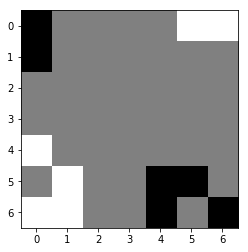

((6, 4), (5, 2)): n_v:   340 q_all:+0.018513 q:+0.028035 q_m:+0.080000 p:0.198766
((5, 5), (5, 6)): n_v:   145 q_all:+0.031971 q:-0.013300 q_m:+0.020000 p:0.073919
((5, 4), (5, 2)): n_v:   136 q_all:+0.025475 q:+0.013295 q_m:+0.080000 p:0.074419
((5, 5), (4, 6)): n_v:    98 q_all:+0.025794 q:-0.010978 q_m:+0.020000 p:0.053801
((5, 4), (4, 5)): n_v:    96 q_all:+0.037094 q:+0.000556 q_m:+0.020000 p:0.046363
((6, 4), (6, 2)): n_v:    66 q_all:+0.032665 q:+0.039811 q_m:+0.080000 p:0.033507
((5, 4), (6, 5)): n_v:    42 q_all:+0.033204 q:-0.006003 q_m:+0.020000 p:0.021078
((5, 4), (3, 6)): n_v:    39 q_all:+0.018799 q:-0.026722 q_m:-0.000000 p:0.023220
((1, 0), (2, 0)): n_v:    38 q_all:+0.037663 q:-0.001149 q_m:+0.020000 p:0.018626
((5, 4), (4, 4)): n_v:    35 q_all:-0.001653 q:-0.025374 q_m:+0.020000 p:0.024740
((5, 4), (5, 3)): n_v:    34 q_all:-0.031207 q:-0.042566 q_m:+0.020000 p:0.029611
((0, 0), (1, 1)): n_v:    32 q_all:+0.031878 q:+0.000609 q_m:+0.020000 p:0.016681
((0, 0), (0, 1))

((6, 0), (6, 2)): n_v:  3412 q_all:+0.061580 q:+0.028370 q_m:+0.040000 p:0.540071
((4, 0), (6, 2)): n_v:  1605 q_all:+0.059468 q:+0.019286 q_m:+0.040000 p:0.263319
((4, 0), (5, 0)): n_v:   176 q_all:+0.001689 q:-0.002271 q_m:+0.020000 p:0.056926
((4, 0), (4, 1)): n_v:    46 q_all:-0.056089 q:-0.015775 q_m:+0.020000 p:0.022389
((4, 0), (4, 2)): n_v:    30 q_all:+0.016751 q:-0.023335 q_m:-0.000000 p:0.008455
((6, 0), (4, 2)): n_v:    27 q_all:+0.016859 q:-0.025251 q_m:-0.000000 p:0.007734
((0, 5), (0, 4)): n_v:    11 q_all:-0.077841 q:-0.044620 q_m:-0.060000 p:0.006437
((0, 5), (1, 6)): n_v:     5 q_all:-0.064998 q:-0.035176 q_m:-0.060000 p:0.002953
((0, 5), (1, 4)): n_v:     4 q_all:-0.053429 q:-0.041505 q_m:-0.060000 p:0.002124
((0, 6), (0, 4)): n_v:     3 q_all:-0.087418 q:-0.057564 q_m:-0.080000 p:0.002109
((4, 0), (3, 1)): n_v:     2 q_all:-0.008671 q:-0.054786 q_m:-0.060000 p:0.000861
((4, 0), (2, 1)): n_v:     2 q_all:-0.031964 q:-0.032936 q_m:-0.040000 p:0.000967
((6, 0), (4, 1))

((5, 4), (5, 3)): n_v:  1777 q_all:-0.055040 q:-0.009866 q_m:+0.060000 p:0.444183
((5, 4), (6, 4)): n_v:  1318 q_all:+0.041901 q:-0.035398 q_m:-0.020000 p:0.004938
((5, 4), (6, 3)): n_v:   955 q_all:-0.053885 q:+0.014468 q_m:+0.060000 p:0.235635
((0, 0), (0, 1)): n_v:   775 q_all:+0.024550 q:-0.010451 q_m:-0.020000 p:0.005469
((5, 5), (4, 6)): n_v:   442 q_all:+0.020993 q:-0.026616 q_m:-0.020000 p:0.012773
((5, 4), (4, 5)): n_v:   159 q_all:-0.077194 q:-0.033647 q_m:-0.020000 p:0.049447
((5, 4), (4, 3)): n_v:   119 q_all:-0.060037 q:-0.019366 q_m:+0.020000 p:0.031698
((1, 0), (2, 1)): n_v:    94 q_all:-0.050876 q:-0.001282 q_m:-0.020000 p:0.022469
((5, 5), (5, 6)): n_v:    93 q_all:-0.051138 q:-0.033870 q_m:-0.020000 p:0.022134
((5, 5), (5, 3)): n_v:    81 q_all:-0.076884 q:-0.035345 q_m:+0.040000 p:0.025029
((5, 4), (4, 4)): n_v:    40 q_all:-0.058327 q:-0.038435 q_m:-0.020000 p:0.010590
((1, 0), (2, 0)): n_v:    38 q_all:-0.063601 q:-0.014299 q_m:-0.020000 p:0.010676
((5, 5), (6, 3))

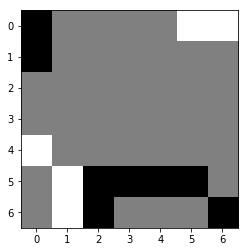

((6, 1), (6, 3)): n_v:  3799 q_all:+0.046638 q:+0.008744 q_m:+0.100000 p:0.564809
((5, 1), (6, 3)): n_v:  2690 q_all:+0.049685 q:+0.023681 q_m:+0.100000 p:0.379973
((6, 1), (4, 3)): n_v:    57 q_all:+0.023989 q:-0.051114 q_m:+0.060000 p:0.011749
((0, 5), (0, 3)): n_v:    42 q_all:+0.003846 q:-0.062928 q_m:-0.060000 p:0.010788
((5, 1), (4, 3)): n_v:    41 q_all:+0.026502 q:-0.056638 q_m:+0.060000 p:0.008219
((5, 1), (4, 2)): n_v:    22 q_all:+0.018089 q:-0.028716 q_m:+0.040000 p:0.004915
((4, 0), (6, 0)): n_v:    19 q_all:-0.047810 q:-0.052547 q_m:-0.060000 p:0.007130
((0, 5), (0, 4)): n_v:     9 q_all:+0.020225 q:-0.044030 q_m:-0.040000 p:0.001873
((0, 5), (1, 4)): n_v:     6 q_all:+0.006812 q:-0.041775 q_m:-0.040000 p:0.001571
((4, 0), (3, 1)): n_v:     3 q_all:-0.007852 q:-0.053841 q_m:-0.040000 p:0.001046
((4, 0), (4, 1)): n_v:     2 q_all:-0.022789 q:-0.040578 q_m:-0.000000 p:0.000710
((4, 0), (4, 2)): n_v:     2 q_all:+0.012723 q:-0.038015 q_m:+0.020000 p:0.000468
((0, 5), (1, 6))

((5, 5), (6, 4)): n_v:  5825 q_all:+0.002394 q:-0.013645 q_m:+0.040000 p:0.635142
((6, 6), (6, 4)): n_v:  1724 q_all:-0.018594 q:-0.035796 q_m:+0.020000 p:0.265192
((5, 5), (4, 4)): n_v:   191 q_all:-0.060198 q:-0.063921 q_m:-0.000000 p:0.046556
((5, 5), (4, 5)): n_v:    34 q_all:-0.059101 q:-0.071200 q_m:-0.040000 p:0.008395
((0, 0), (0, 2)): n_v:    25 q_all:-0.071042 q:-0.115673 q_m:-0.100000 p:0.006890
((5, 5), (4, 3)): n_v:    19 q_all:-0.061372 q:-0.038162 q_m:+0.020000 p:0.004798
((5, 5), (6, 5)): n_v:    18 q_all:-0.105897 q:-0.071818 q_m:-0.040000 p:0.006450
((1, 0), (0, 2)): n_v:    15 q_all:-0.061607 q:-0.107553 q_m:-0.100000 p:0.003754
((1, 0), (2, 1)): n_v:    11 q_all:-0.076976 q:-0.078048 q_m:-0.080000 p:0.003181
((6, 6), (4, 4)): n_v:     8 q_all:-0.065976 q:-0.072029 q_m:-0.020000 p:0.002148
((5, 5), (4, 6)): n_v:     5 q_all:-0.064971 q:-0.096490 q_m:-0.080000 p:0.001501
((0, 0), (1, 1)): n_v:     3 q_all:-0.078830 q:-0.089319 q_m:-0.080000 p:0.001105
((0, 0), (0, 1))

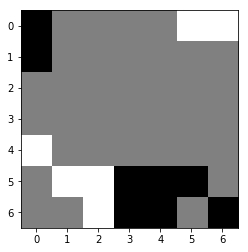

((6, 2), (4, 4)): n_v:  4883 q_all:+0.016652 q:-0.032263 q_m:+0.080000 p:0.424543
((5, 2), (4, 4)): n_v:  2963 q_all:+0.015434 q:+0.002430 q_m:+0.080000 p:0.265090
((5, 2), (4, 3)): n_v:   631 q_all:-0.013144 q:-0.018852 q_m:+0.060000 p:0.094108
((5, 1), (4, 2)): n_v:   220 q_all:-0.025542 q:-0.029665 q_m:+0.020000 p:0.038279
((4, 0), (6, 0)): n_v:   118 q_all:-0.094578 q:-0.038602 q_m:-0.040000 p:0.037791
((5, 1), (6, 1)): n_v:    88 q_all:-0.004054 q:-0.004946 q_m:-0.020000 p:0.011528
((0, 5), (0, 4)): n_v:    35 q_all:-0.051293 q:-0.035810 q_m:-0.020000 p:0.008055
((5, 1), (4, 3)): n_v:    35 q_all:-0.024540 q:-0.023292 q_m:+0.040000 p:0.006183
((0, 5), (1, 4)): n_v:    33 q_all:-0.057044 q:-0.029919 q_m:-0.020000 p:0.008132
((4, 0), (5, 0)): n_v:    24 q_all:-0.044934 q:-0.046506 q_m:-0.020000 p:0.005204
((5, 1), (6, 0)): n_v:    23 q_all:-0.047688 q:-0.031517 q_m:-0.020000 p:0.005239
((4, 0), (4, 2)): n_v:    23 q_all:-0.031899 q:-0.037897 q_m:-0.000000 p:0.004468
((4, 0), (3, 1))

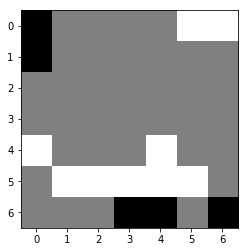

((6, 6), (4, 5)): n_v:  1881 q_all:+0.019375 q:-0.032518 q_m:+0.040000 p:0.247741
((6, 3), (4, 1)): n_v:  1200 q_all:-0.006858 q:-0.043131 q_m:+0.040000 p:0.235254
((6, 3), (6, 2)): n_v:   823 q_all:+0.011128 q:-0.000829 q_m:+0.060000 p:0.125102
((6, 3), (4, 5)): n_v:   666 q_all:+0.011211 q:-0.046694 q_m:+0.040000 p:0.100998
((6, 3), (6, 1)): n_v:   396 q_all:-0.029963 q:-0.044624 q_m:-0.000000 p:0.100179
((6, 4), (4, 5)): n_v:   200 q_all:-0.003040 q:-0.043033 q_m:+0.040000 p:0.037515
((6, 3), (6, 5)): n_v:   165 q_all:-0.034629 q:-0.076645 q_m:-0.000000 p:0.043789
((6, 4), (6, 2)): n_v:    89 q_all:+0.009106 q:-0.020791 q_m:+0.040000 p:0.014098
((6, 3), (4, 3)): n_v:    87 q_all:+0.002520 q:-0.043700 q_m:+0.080000 p:0.015119
((6, 4), (4, 3)): n_v:    55 q_all:+0.013281 q:-0.041886 q_m:+0.080000 p:0.008151
((6, 4), (4, 2)): n_v:    34 q_all:-0.020733 q:-0.043775 q_m:+0.040000 p:0.007952
((6, 4), (6, 5)): n_v:    32 q_all:-0.005917 q:-0.050909 q_m:+0.020000 p:0.006319
((1, 0), (2, 1))

((5, 2), (4, 3)): n_v:  1010 q_all:+0.001148 q:-0.014285 q_m:+0.060000 p:0.202531
((5, 1), (6, 2)): n_v:   668 q_all:+0.002222 q:+0.004664 q_m:+0.020000 p:0.131693
((5, 3), (3, 4)): n_v:   667 q_all:+0.063279 q:+0.004466 q_m:+0.040000 p:0.000621
((5, 3), (6, 5)): n_v:   546 q_all:+0.051023 q:+0.048026 q_m:+0.080000 p:0.020798
((5, 1), (4, 3)): n_v:   122 q_all:+0.017149 q:-0.009790 q_m:+0.040000 p:0.018223
((4, 0), (6, 2)): n_v:    81 q_all:-0.013252 q:-0.009868 q_m:-0.000000 p:0.019958
((5, 3), (3, 5)): n_v:    37 q_all:+0.044551 q:+0.007431 q_m:+0.040000 p:0.002313
((4, 0), (6, 0)): n_v:    33 q_all:-0.064197 q:-0.051832 q_m:-0.040000 p:0.013666
((5, 3), (6, 1)): n_v:    30 q_all:-0.068797 q:-0.024207 q_m:-0.040000 p:0.013023
((0, 5), (0, 4)): n_v:    26 q_all:-0.051044 q:-0.037639 q_m:-0.020000 p:0.009716
((5, 1), (6, 1)): n_v:    23 q_all:-0.082233 q:-0.043923 q_m:-0.020000 p:0.011190
((4, 0), (3, 1)): n_v:    21 q_all:-0.054970 q:-0.044469 q_m:-0.020000 p:0.008285
((5, 1), (6, 0))

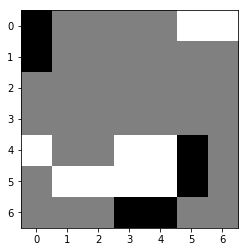

((6, 4), (4, 2)): n_v:  1478 q_all:+0.023800 q:-0.006101 q_m:+0.100000 p:0.436569
((6, 3), (6, 2)): n_v:  1111 q_all:+0.043866 q:+0.003584 q_m:+0.080000 p:0.257056
((6, 3), (4, 2)): n_v:   639 q_all:+0.052397 q:-0.001340 q_m:+0.100000 p:0.130315
((6, 4), (6, 2)): n_v:   279 q_all:-0.011952 q:-0.027411 q_m:+0.060000 p:0.114569
((4, 5), (2, 4)): n_v:    29 q_all:-0.009718 q:-0.095330 q_m:-0.060000 p:0.011982
((5, 5), (6, 5)): n_v:    19 q_all:+0.039466 q:-0.054556 q_m:-0.000000 p:0.004861
((0, 0), (2, 2)): n_v:    18 q_all:-0.019304 q:-0.099755 q_m:-0.060000 p:0.007510
((6, 3), (6, 1)): n_v:    17 q_all:+0.018470 q:-0.026195 q_m:+0.020000 p:0.005428
((4, 5), (3, 4)): n_v:    15 q_all:+0.039607 q:-0.051474 q_m:+0.040000 p:0.003875
((1, 0), (2, 2)): n_v:    13 q_all:-0.015088 q:-0.082511 q_m:-0.060000 p:0.005685
((6, 3), (4, 1)): n_v:    10 q_all:+0.022483 q:-0.018277 q_m:+0.060000 p:0.003046
((0, 0), (0, 2)): n_v:     7 q_all:-0.006389 q:-0.083353 q_m:-0.060000 p:0.003034
((6, 3), (6, 5))

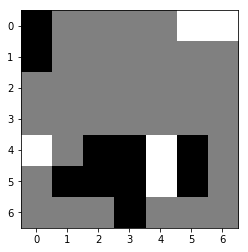

((5, 4), (6, 4)): n_v:  5714 q_all:+0.026480 q:+0.009544 q_m:+0.040000 p:0.922402
((4, 4), (6, 2)): n_v:   358 q_all:+0.050934 q:-0.015909 q_m:+0.060000 p:0.036124
((4, 0), (6, 2)): n_v:   140 q_all:+0.012249 q:-0.006256 q_m:+0.060000 p:0.027552
((5, 4), (6, 2)): n_v:    85 q_all:+0.050808 q:-0.011029 q_m:+0.060000 p:0.008624
((0, 5), (0, 4)): n_v:    14 q_all:-0.012004 q:-0.063452 q_m:-0.080000 p:0.003639
((4, 4), (6, 4)): n_v:     3 q_all:-0.011920 q:-0.022768 q_m:+0.020000 p:0.001024
((4, 0), (4, 1)): n_v:     2 q_all:+0.041796 q:-0.027459 q_m:+0.040000 p:0.000302
((4, 4), (6, 6)): n_v:     0 q_all:-0.062753 q:-0.066882 q_m:-0.060000 p:0.000002
((0, 5), (2, 6)): n_v:     0 q_all:-0.090750 q:-0.076874 q_m:-0.100000 p:0.000001
((4, 4), (5, 6)): n_v:     0 q_all:-0.031498 q:-0.048746 q_m:-0.020000 p:0.000010
((4, 4), (3, 5)): n_v:     0 q_all:-0.045652 q:-0.054130 q_m:-0.040000 p:0.000001
((0, 5), (2, 3)): n_v:     0 q_all:-0.093042 q:-0.082605 q_m:-0.100000 p:0.000000
((4, 4), (2, 2))

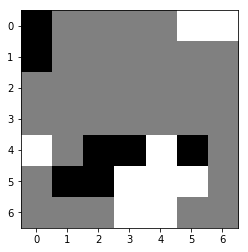

((4, 3), (6, 5)): n_v:  5659 q_all:+0.038044 q:-0.016560 q_m:+0.080000 p:0.090662
((5, 1), (6, 2)): n_v:  4162 q_all:-0.020014 q:-0.012106 q_m:+0.060000 p:0.427223
((4, 3), (6, 2)): n_v:   227 q_all:-0.039204 q:-0.017029 q_m:+0.040000 p:0.034602
((5, 1), (6, 1)): n_v:    99 q_all:-0.095122 q:-0.056285 q_m:-0.020000 p:0.027253
((4, 3), (6, 1)): n_v:    87 q_all:-0.101173 q:-0.060919 q_m:-0.040000 p:0.025022
((4, 5), (4, 6)): n_v:    77 q_all:-0.034791 q:-0.070069 q_m:+0.020000 p:0.010822
((4, 5), (5, 6)): n_v:    48 q_all:-0.050692 q:-0.034445 q_m:+0.020000 p:0.008838
((4, 5), (6, 5)): n_v:    43 q_all:-0.014870 q:-0.014246 q_m:+0.080000 p:0.003829
((5, 1), (5, 0)): n_v:    33 q_all:-0.084595 q:-0.065556 q_m:+0.020000 p:0.008499
((0, 0), (0, 1)): n_v:    29 q_all:-0.084078 q:-0.065931 q_m:-0.020000 p:0.007440
((4, 2), (6, 2)): n_v:    27 q_all:-0.050934 q:-0.018591 q_m:+0.040000 p:0.005031
((4, 2), (4, 1)): n_v:    12 q_all:-0.044281 q:-0.034698 q_m:+0.020000 p:0.002021
((0, 0), (1, 1))

((4, 4), (5, 6)): n_v:  5579 q_all:+0.022109 q:-0.006340 q_m:+0.040000 p:0.053175
((4, 4), (4, 3)): n_v:  3259 q_all:-0.032365 q:-0.030943 q_m:+0.060000 p:0.310726
((4, 0), (4, 1)): n_v:   938 q_all:-0.045297 q:+0.002937 q_m:+0.060000 p:0.121630
((5, 3), (6, 2)): n_v:   322 q_all:-0.053487 q:-0.009385 q_m:+0.020000 p:0.048784
((5, 3), (4, 1)): n_v:   130 q_all:-0.058383 q:-0.011915 q_m:+0.040000 p:0.021436
((4, 0), (5, 0)): n_v:    80 q_all:-0.071532 q:-0.035329 q_m:-0.020000 p:0.015438
((6, 3), (4, 1)): n_v:    66 q_all:-0.056570 q:-0.029744 q_m:+0.040000 p:0.010837
((6, 3), (4, 3)): n_v:    25 q_all:-0.050350 q:-0.052541 q_m:+0.040000 p:0.003636
((6, 3), (6, 1)): n_v:    20 q_all:-0.061149 q:-0.029927 q_m:-0.000000 p:0.003513
((4, 4), (6, 2)): n_v:    17 q_all:-0.061358 q:-0.018754 q_m:-0.000000 p:0.002944
((4, 0), (6, 2)): n_v:    13 q_all:-0.065933 q:-0.019127 q_m:-0.000000 p:0.002478
((4, 4), (6, 6)): n_v:    12 q_all:-0.060080 q:-0.031663 q_m:-0.000000 p:0.002168
((5, 3), (6, 1))

((5, 4), (4, 4)): n_v:  4379 q_all:-0.014886 q:-0.042401 q_m:+0.100000 p:0.613169
((5, 4), (6, 6)): n_v:  2437 q_all:+0.047283 q:-0.001773 q_m:+0.080000 p:0.009043
((5, 2), (4, 4)): n_v:   602 q_all:+0.042213 q:-0.041126 q_m:+0.080000 p:0.018807
((5, 1), (6, 2)): n_v:   224 q_all:-0.031508 q:-0.005750 q_m:+0.060000 p:0.039672
((4, 2), (4, 4)): n_v:   223 q_all:-0.020540 q:-0.046893 q_m:+0.080000 p:0.034058
((6, 4), (4, 6)): n_v:   184 q_all:+0.001689 q:-0.029235 q_m:+0.080000 p:0.017917
((5, 4), (4, 6)): n_v:   173 q_all:-0.012448 q:-0.038686 q_m:+0.080000 p:0.023278
((5, 1), (5, 0)): n_v:   162 q_all:-0.081769 q:-0.049711 q_m:+0.020000 p:0.046511
((5, 4), (6, 2)): n_v:    37 q_all:-0.025851 q:+0.006516 q_m:+0.040000 p:0.006216
((5, 4), (3, 6)): n_v:    24 q_all:-0.065034 q:-0.057853 q_m:-0.000000 p:0.006158
((6, 4), (4, 4)): n_v:    24 q_all:-0.020790 q:-0.056331 q_m:+0.080000 p:0.003762
((4, 2), (3, 1)): n_v:    23 q_all:-0.096484 q:-0.053124 q_m:+0.020000 p:0.007568
((6, 4), (6, 6))

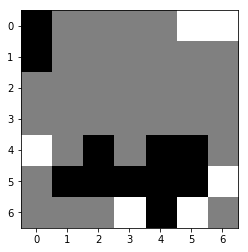

((6, 3), (6, 2)): n_v:  3901 q_all:+0.023394 q:-0.010364 q_m:+0.040000 p:0.657349
((6, 5), (4, 3)): n_v:  1011 q_all:+0.051420 q:-0.010016 q_m:+0.100000 p:0.101113
((4, 0), (4, 1)): n_v:   539 q_all:+0.019914 q:-0.020387 q_m:+0.040000 p:0.095528
((6, 3), (4, 3)): n_v:   318 q_all:+0.057843 q:-0.035290 q_m:+0.100000 p:0.026696
((6, 3), (4, 1)): n_v:   282 q_all:+0.039752 q:-0.040529 q_m:+0.020000 p:0.036391
((4, 0), (6, 2)): n_v:    91 q_all:+0.010777 q:-0.023763 q_m:+0.020000 p:0.018211
((0, 5), (0, 4)): n_v:    36 q_all:-0.050855 q:-0.066235 q_m:-0.080000 p:0.012947
((5, 6), (4, 6)): n_v:    31 q_all:+0.008468 q:-0.051319 q_m:-0.000000 p:0.006434
((6, 3), (6, 1)): n_v:    28 q_all:-0.020235 q:-0.035558 q_m:-0.020000 p:0.007803
((0, 5), (2, 3)): n_v:    17 q_all:-0.057699 q:-0.095601 q_m:-0.100000 p:0.006484
((5, 6), (6, 6)): n_v:    16 q_all:-0.032034 q:-0.057565 q_m:-0.040000 p:0.005157
((4, 0), (2, 1)): n_v:     9 q_all:-0.050697 q:-0.067348 q_m:-0.060000 p:0.003258
((0, 5), (2, 5))

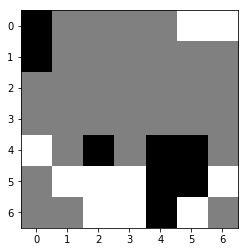

((4, 2), (6, 1)): n_v:  1931 q_all:+0.031421 q:-0.019392 q_m:+0.080000 p:0.283622
((4, 2), (4, 1)): n_v:   929 q_all:-0.016441 q:-0.027770 q_m:+0.100000 p:0.246842
((4, 2), (5, 0)): n_v:   408 q_all:-0.008707 q:-0.065031 q_m:+0.040000 p:0.100628
((4, 2), (4, 3)): n_v:   336 q_all:+0.021464 q:-0.039621 q_m:+0.060000 p:0.057709
((4, 4), (6, 6)): n_v:   159 q_all:+0.026615 q:-0.021963 q_m:+0.040000 p:0.025326
((4, 5), (6, 6)): n_v:   139 q_all:-0.033383 q:-0.030182 q_m:+0.040000 p:0.042877
((4, 2), (6, 0)): n_v:   101 q_all:-0.041913 q:-0.062472 q_m:-0.000000 p:0.033469
((5, 5), (6, 6)): n_v:    33 q_all:-0.014989 q:-0.010876 q_m:+0.060000 p:0.008769
((4, 5), (4, 6)): n_v:    32 q_all:-0.053174 q:-0.067900 q_m:+0.020000 p:0.011550
((1, 0), (2, 1)): n_v:    25 q_all:-0.079593 q:-0.061371 q_m:-0.020000 p:0.010815
((1, 0), (2, 0)): n_v:     6 q_all:-0.080256 q:-0.068923 q_m:-0.020000 p:0.002763
((0, 0), (0, 1)): n_v:     5 q_all:-0.087812 q:-0.071415 q_m:-0.020000 p:0.002403
((4, 2), (2, 1))

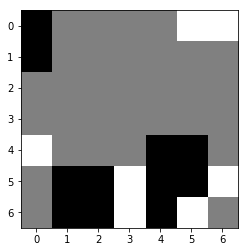

((5, 3), (4, 3)): n_v:  3583 q_all:+0.005145 q:-0.019148 q_m:+0.060000 p:0.652717
((4, 0), (5, 0)): n_v:   208 q_all:-0.007412 q:-0.022107 q_m:+0.020000 p:0.045551
((4, 0), (4, 1)): n_v:   202 q_all:-0.043708 q:-0.016435 q_m:+0.020000 p:0.065546
((5, 3), (4, 2)): n_v:   152 q_all:-0.038643 q:-0.025630 q_m:+0.020000 p:0.047168
((6, 5), (4, 3)): n_v:   101 q_all:-0.014895 q:-0.036141 q_m:+0.040000 p:0.024292
((6, 3), (4, 3)): n_v:   100 q_all:+0.007312 q:-0.068144 q_m:+0.040000 p:0.017752
((5, 3), (4, 1)): n_v:    84 q_all:-0.013821 q:-0.010727 q_m:-0.000000 p:0.020112
((4, 0), (6, 0)): n_v:    65 q_all:+0.006921 q:-0.042272 q_m:-0.000000 p:0.011633
((5, 6), (6, 6)): n_v:    55 q_all:-0.015026 q:-0.052247 q_m:-0.020000 p:0.013432
((6, 3), (4, 1)): n_v:    51 q_all:-0.044308 q:-0.064644 q_m:-0.000000 p:0.016816
((0, 5), (1, 4)): n_v:    37 q_all:-0.041560 q:-0.064809 q_m:-0.060000 p:0.011924
((5, 6), (4, 6)): n_v:    32 q_all:-0.022028 q:-0.046422 q_m:+0.020000 p:0.008539
((0, 5), (0, 4))

((5, 1), (4, 2)): n_v:  7808 q_all:+0.026955 q:-0.008602 q_m:+0.080000 p:0.913302
((6, 1), (4, 2)): n_v:   153 q_all:-0.009473 q:-0.026667 q_m:+0.060000 p:0.029975
((6, 4), (4, 2)): n_v:   118 q_all:+0.009544 q:-0.031477 q_m:+0.060000 p:0.018321
((5, 1), (5, 0)): n_v:    36 q_all:-0.014248 q:-0.043933 q_m:-0.000000 p:0.007536
((6, 2), (4, 2)): n_v:    29 q_all:-0.035502 q:-0.029797 q_m:+0.060000 p:0.007495
((5, 1), (4, 1)): n_v:    26 q_all:-0.024233 q:-0.050353 q_m:+0.040000 p:0.006068
((4, 5), (3, 4)): n_v:    13 q_all:+0.037100 q:-0.023251 q_m:+0.040000 p:0.001324
((4, 5), (6, 6)): n_v:     9 q_all:+0.053396 q:-0.029041 q_m:+0.020000 p:0.000494
((5, 5), (6, 6)): n_v:     3 q_all:+0.028972 q:+0.008990 q_m:+0.040000 p:0.000447
((0, 0), (1, 1)): n_v:     3 q_all:-0.040679 q:-0.039311 q_m:-0.040000 p:0.000884
((4, 5), (2, 4)): n_v:     3 q_all:-0.058843 q:-0.085029 q_m:-0.060000 p:0.000988
((1, 0), (2, 2)): n_v:     2 q_all:-0.069208 q:-0.054317 q_m:-0.060000 p:0.000955
((0, 0), (2, 2))

((5, 6), (4, 6)): n_v:  4992 q_all:+0.029641 q:-0.030728 q_m:+0.020000 p:0.192858
((4, 0), (4, 1)): n_v:  3695 q_all:-0.018705 q:+0.005166 q_m:+0.060000 p:0.475805
((6, 3), (4, 1)): n_v:   988 q_all:-0.030479 q:-0.049974 q_m:+0.040000 p:0.148976
((4, 0), (5, 0)): n_v:   393 q_all:-0.036843 q:-0.008321 q_m:+0.020000 p:0.063996
((4, 4), (3, 3)): n_v:   159 q_all:-0.045095 q:-0.064152 q_m:+0.020000 p:0.028337
((4, 4), (3, 2)): n_v:    96 q_all:-0.033531 q:-0.060663 q_m:-0.000000 p:0.015140
((4, 0), (6, 0)): n_v:    48 q_all:-0.041464 q:-0.016262 q_m:-0.000000 p:0.008382
((4, 4), (3, 4)): n_v:    35 q_all:-0.045313 q:-0.047042 q_m:+0.020000 p:0.006330
((4, 0), (2, 1)): n_v:    27 q_all:-0.068404 q:-0.035122 q_m:-0.040000 p:0.006148
((5, 6), (6, 6)): n_v:    20 q_all:-0.038106 q:-0.039845 q_m:-0.020000 p:0.003432
((0, 5), (1, 6)): n_v:    19 q_all:-0.057837 q:-0.040948 q_m:-0.060000 p:0.003976
((0, 5), (1, 5)): n_v:    16 q_all:-0.064126 q:-0.053078 q_m:-0.060000 p:0.003488
((4, 4), (6, 6))

((6, 4), (6, 6)): n_v:  5106 q_all:+0.020143 q:+0.021634 q_m:+0.100000 p:0.011512
((4, 3), (3, 5)): n_v:   983 q_all:-0.007468 q:+0.015946 q_m:+0.100000 p:0.039812
((5, 1), (5, 0)): n_v:   779 q_all:-0.052121 q:-0.021265 q_m:+0.040000 p:0.114389
((4, 2), (4, 1)): n_v:   663 q_all:-0.006737 q:-0.006578 q_m:+0.040000 p:0.025521
((4, 2), (3, 1)): n_v:   451 q_all:-0.052651 q:-0.015122 q_m:+0.040000 p:0.066819
((4, 2), (6, 0)): n_v:   359 q_all:-0.069799 q:-0.049230 q_m:-0.020000 p:0.065470
((5, 1), (6, 0)): n_v:   285 q_all:-0.055998 q:-0.039670 q_m:-0.000000 p:0.044140
((4, 2), (5, 0)): n_v:   195 q_all:-0.034396 q:-0.045610 q_m:+0.020000 p:0.021754
((4, 3), (3, 1)): n_v:   180 q_all:-0.053055 q:-0.031911 q_m:+0.020000 p:0.026848
((4, 3), (3, 4)): n_v:   169 q_all:-0.009654 q:+0.005938 q_m:+0.080000 p:0.007845
((1, 0), (3, 1)): n_v:   148 q_all:-0.070787 q:-0.030084 q_m:+0.020000 p:0.027442
((4, 2), (3, 3)): n_v:    41 q_all:-0.029183 q:-0.016473 q_m:+0.040000 p:0.004215
((0, 0), (1, 1))

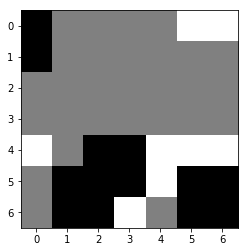

((5, 4), (6, 4)): n_v:  9761 q_all:+0.018011 q:-0.034190 q_m:+0.040000 p:0.518882
((4, 5), (6, 4)): n_v:   106 q_all:-0.067285 q:-0.045789 q_m:+0.020000 p:0.023724
((4, 6), (6, 4)): n_v:    93 q_all:-0.033268 q:-0.030106 q_m:+0.020000 p:0.014291
((4, 0), (4, 1)): n_v:    34 q_all:-0.045438 q:-0.042849 q_m:+0.040000 p:0.006271
((0, 5), (0, 4)): n_v:    20 q_all:-0.111422 q:-0.086810 q_m:-0.080000 p:0.006417
((6, 3), (4, 1)): n_v:    12 q_all:-0.057693 q:-0.053550 q_m:+0.020000 p:0.002630
((4, 0), (5, 0)): n_v:     4 q_all:-0.056832 q:-0.031168 q_m:-0.000000 p:0.000949
((4, 4), (6, 4)): n_v:     4 q_all:-0.086783 q:-0.084165 q_m:+0.020000 p:0.001291
((4, 4), (3, 3)): n_v:     4 q_all:-0.065926 q:-0.073786 q_m:-0.000000 p:0.001044
((0, 5), (2, 6)): n_v:     0 q_all:-0.101414 q:-0.103535 q_m:-0.100000 p:0.000004
((4, 4), (3, 5)): n_v:     0 q_all:-0.080843 q:-0.082108 q_m:-0.080000 p:0.000003
((0, 5), (2, 3)): n_v:     0 q_all:-0.100966 q:-0.102415 q_m:-0.100000 p:0.000001
((4, 4), (2, 2))

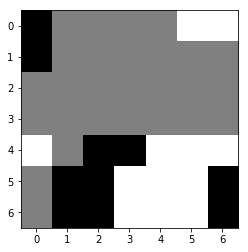

((4, 3), (3, 5)): n_v:  8360 q_all:+0.032305 q:-0.004092 q_m:+0.080000 p:0.083676
((5, 6), (3, 5)): n_v:  1550 q_all:-0.003018 q:-0.023614 q_m:+0.080000 p:0.053005
((5, 1), (5, 0)): n_v:  1422 q_all:-0.039626 q:-0.011421 q_m:+0.020000 p:0.154129
((4, 2), (3, 1)): n_v:   954 q_all:-0.040070 q:-0.013214 q_m:+0.020000 p:0.104269
((4, 2), (4, 1)): n_v:   416 q_all:-0.006361 q:-0.008737 q_m:+0.020000 p:0.017074
((4, 3), (3, 4)): n_v:   334 q_all:-0.011008 q:-0.026800 q_m:+0.060000 p:0.016827
((4, 3), (3, 1)): n_v:   267 q_all:-0.058873 q:-0.031759 q_m:-0.000000 p:0.039344
((1, 0), (3, 1)): n_v:   182 q_all:-0.056489 q:-0.028686 q_m:-0.000000 p:0.026019
((5, 1), (6, 0)): n_v:   179 q_all:-0.060592 q:-0.037852 q_m:-0.020000 p:0.027038
((4, 2), (5, 0)): n_v:    99 q_all:-0.054615 q:-0.039936 q_m:-0.000000 p:0.013664
((4, 2), (3, 2)): n_v:    92 q_all:-0.059086 q:-0.014882 q_m:-0.020000 p:0.013466
((4, 2), (3, 3)): n_v:    81 q_all:-0.030630 q:-0.010819 q_m:+0.020000 p:0.007227
((0, 0), (1, 1))

((5, 3), (4, 3)): n_v:  9174 q_all:-0.008991 q:-0.008599 q_m:+0.060000 p:0.378808
((4, 0), (4, 1)): n_v:   651 q_all:-0.030267 q:+0.012871 q_m:+0.060000 p:0.051020
((6, 5), (4, 3)): n_v:   644 q_all:-0.033944 q:-0.017609 q_m:+0.040000 p:0.054569
((6, 3), (4, 1)): n_v:   427 q_all:-0.008236 q:-0.059915 q_m:+0.040000 p:0.017098
((5, 3), (4, 1)): n_v:   329 q_all:-0.040634 q:-0.013229 q_m:+0.040000 p:0.031779
((6, 4), (4, 3)): n_v:   275 q_all:-0.066382 q:-0.069655 q_m:+0.040000 p:0.038806
((6, 3), (4, 3)): n_v:   194 q_all:-0.064695 q:-0.083377 q_m:+0.040000 p:0.026864
((5, 5), (4, 3)): n_v:    77 q_all:-0.054370 q:-0.068994 q_m:+0.040000 p:0.009344
((4, 0), (5, 0)): n_v:    70 q_all:-0.013986 q:-0.023645 q_m:+0.020000 p:0.003543
((0, 5), (2, 3)): n_v:    26 q_all:-0.088316 q:-0.106484 q_m:-0.080000 p:0.004738
((5, 4), (3, 6)): n_v:    20 q_all:-0.070977 q:-0.029839 q_m:+0.040000 p:0.002973
((4, 0), (3, 0)): n_v:     8 q_all:-0.077469 q:-0.059655 q_m:-0.060000 p:0.001433
((4, 0), (2, 1))

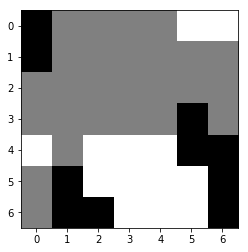

((5, 1), (4, 1)): n_v:  6006 q_all:+0.037751 q:+0.029271 q_m:+0.080000 p:0.466504
((6, 1), (4, 1)): n_v:  3435 q_all:+0.073221 q:-0.004037 q_m:+0.060000 p:0.081396
((1, 0), (2, 1)): n_v:   379 q_all:-0.047002 q:-0.021232 q_m:-0.040000 p:0.089502
((4, 5), (3, 3)): n_v:   356 q_all:-0.006319 q:-0.017830 q_m:+0.060000 p:0.058500
((3, 5), (1, 6)): n_v:   348 q_all:-0.002532 q:+0.007285 q_m:+0.020000 p:0.054777
((6, 2), (4, 1)): n_v:   326 q_all:-0.003843 q:-0.009850 q_m:+0.060000 p:0.052035
((5, 1), (5, 0)): n_v:   153 q_all:-0.035778 q:-0.019602 q_m:-0.000000 p:0.033136
((5, 1), (3, 3)): n_v:   117 q_all:-0.003743 q:-0.007791 q_m:+0.060000 p:0.018803
((3, 5), (1, 5)): n_v:   102 q_all:-0.002867 q:+0.009622 q_m:+0.020000 p:0.016223
((0, 0), (1, 1)): n_v:    94 q_all:-0.051856 q:-0.023196 q_m:-0.040000 p:0.022978
((3, 5), (3, 4)): n_v:    56 q_all:-0.008236 q:-0.000025 q_m:+0.040000 p:0.009535
((3, 5), (3, 3)): n_v:    46 q_all:+0.004390 q:-0.001210 q_m:+0.060000 p:0.006644
((0, 0), (2, 1))

((4, 3), (3, 2)): n_v:  3161 q_all:-0.013568 q:-0.037256 q_m:+0.020000 p:0.328754
((4, 3), (3, 4)): n_v:  2601 q_all:-0.016684 q:-0.061489 q_m:+0.020000 p:0.287247
((4, 3), (3, 1)): n_v:   341 q_all:-0.019435 q:-0.036679 q_m:+0.040000 p:0.039833
((0, 5), (1, 6)): n_v:   174 q_all:-0.077583 q:-0.071789 q_m:-0.060000 p:0.041159
((5, 4), (3, 6)): n_v:   166 q_all:-0.043564 q:-0.045256 q_m:+0.040000 p:0.027586
((4, 4), (3, 2)): n_v:   142 q_all:-0.032275 q:-0.056398 q_m:-0.000000 p:0.020331
((4, 4), (3, 6)): n_v:    80 q_all:-0.017547 q:-0.042511 q_m:+0.040000 p:0.008992
((5, 5), (3, 6)): n_v:    60 q_all:-0.038606 q:-0.038579 q_m:+0.040000 p:0.009433
((0, 6), (2, 6)): n_v:    56 q_all:-0.025015 q:-0.044395 q_m:-0.040000 p:0.007234
((0, 5), (1, 5)): n_v:    40 q_all:-0.077429 q:-0.064153 q_m:-0.060000 p:0.009555
((0, 5), (0, 4)): n_v:    32 q_all:-0.066687 q:-0.076736 q_m:-0.060000 p:0.006897
((4, 3), (3, 3)): n_v:    20 q_all:-0.039876 q:-0.083301 q_m:-0.020000 p:0.003252
((0, 5), (1, 4))

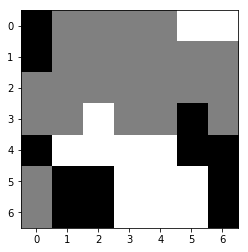

((1, 0), (3, 1)): n_v:  2797 q_all:+0.161580 q:+0.034526 q_m:+0.100000 p:0.178822
((4, 0), (3, 1)): n_v:  1971 q_all:+0.148730 q:+0.040526 q_m:+0.120000 p:0.246568
((4, 5), (3, 3)): n_v:   335 q_all:+0.013872 q:+0.003681 q_m:+0.140000 p:0.150404
((4, 0), (5, 0)): n_v:   263 q_all:-0.005090 q:+0.004725 q_m:+0.040000 p:0.130212
((3, 5), (3, 3)): n_v:   122 q_all:+0.041032 q:+0.017189 q_m:+0.140000 p:0.047232
((5, 2), (3, 3)): n_v:    45 q_all:-0.016833 q:+0.008935 q_m:+0.140000 p:0.023705
((5, 1), (3, 3)): n_v:    40 q_all:-0.002945 q:+0.028305 q_m:+0.140000 p:0.019929
((5, 1), (3, 1)): n_v:    30 q_all:-0.025490 q:+0.013198 q_m:+0.100000 p:0.016579
((3, 5), (1, 6)): n_v:    26 q_all:-0.019513 q:+0.010004 q_m:+0.060000 p:0.014052
((3, 5), (1, 5)): n_v:    24 q_all:-0.012201 q:+0.017299 q_m:+0.060000 p:0.012695
((5, 2), (3, 1)): n_v:    16 q_all:-0.042646 q:+0.008496 q_m:+0.100000 p:0.009419
((0, 0), (1, 1)): n_v:    15 q_all:-0.051414 q:-0.010429 q_m:-0.000000 p:0.009327
((3, 5), (3, 4))

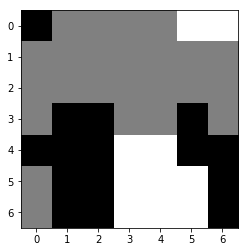

((4, 3), (3, 3)): n_v:  4844 q_all:-0.027587 q:-0.060550 q_m:-0.000000 p:0.019577
((5, 4), (3, 6)): n_v:  1481 q_all:-0.198625 q:-0.077327 q_m:+0.020000 p:0.579911
((5, 5), (3, 6)): n_v:   536 q_all:-0.158061 q:-0.050173 q_m:+0.020000 p:0.160610
((0, 5), (1, 6)): n_v:   353 q_all:-0.121533 q:-0.097056 q_m:-0.080000 p:0.062190
((4, 3), (3, 4)): n_v:   244 q_all:-0.096479 q:-0.064954 q_m:-0.000000 p:0.019813
((4, 4), (3, 6)): n_v:   132 q_all:-0.140420 q:-0.065911 q_m:+0.020000 p:0.032580
((0, 5), (1, 5)): n_v:    24 q_all:-0.108764 q:-0.107092 q_m:-0.080000 p:0.003135
((0, 5), (1, 4)): n_v:    15 q_all:-0.120621 q:-0.100568 q_m:-0.080000 p:0.002540
((4, 3), (2, 5)): n_v:    13 q_all:-0.130313 q:-0.122797 q_m:-0.060000 p:0.002917
((4, 4), (2, 6)): n_v:    10 q_all:-0.176316 q:-0.131084 q_m:-0.060000 p:0.003609
((4, 3), (2, 1)): n_v:    10 q_all:-0.141515 q:-0.075293 q_m:-0.020000 p:0.002686
((0, 5), (2, 6)): n_v:    10 q_all:-0.138911 q:-0.079087 q_m:-0.060000 p:0.002559
((4, 3), (2, 2))

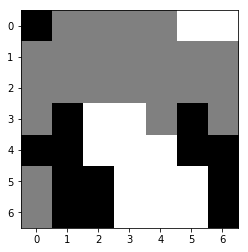

((3, 5), (3, 4)): n_v:  7081 q_all:+0.043118 q:+0.052173 q_m:+0.140000 p:0.503383
((4, 0), (5, 0)): n_v:   876 q_all:+0.080297 q:-0.023831 q_m:+0.020000 p:0.000761
((3, 5), (1, 5)): n_v:   487 q_all:+0.068119 q:+0.014469 q_m:+0.080000 p:0.008151
((4, 6), (3, 4)): n_v:   394 q_all:+0.011557 q:+0.019110 q_m:+0.120000 p:0.055166
((5, 6), (3, 4)): n_v:   366 q_all:+0.007853 q:+0.002808 q_m:+0.120000 p:0.054130
((5, 2), (3, 4)): n_v:    50 q_all:-0.014412 q:+0.015330 q_m:+0.120000 p:0.009938
((3, 1), (5, 0)): n_v:    22 q_all:+0.013823 q:-0.034432 q_m:-0.000000 p:0.002998
((3, 1), (1, 1)): n_v:    20 q_all:-0.061612 q:-0.053871 q_m:-0.000000 p:0.006069
((0, 0), (1, 1)): n_v:    11 q_all:-0.046890 q:-0.036302 q_m:+0.020000 p:0.003065
((3, 5), (1, 6)): n_v:     6 q_all:-0.003531 q:+0.008208 q_m:+0.080000 p:0.001192
((3, 1), (2, 3)): n_v:     2 q_all:-0.007441 q:-0.017143 q_m:+0.080000 p:0.000418
((5, 1), (6, 0)): n_v:     2 q_all:-0.091013 q:-0.032344 q_m:+0.020000 p:0.000873
((3, 1), (2, 2))

((3, 2), (5, 0)): n_v:  8709 q_all:-0.003224 q:-0.072117 q_m:+0.020000 p:0.495704
((4, 2), (5, 0)): n_v:   500 q_all:-0.038332 q:-0.059133 q_m:+0.020000 p:0.061136
((5, 4), (3, 6)): n_v:   494 q_all:-0.098714 q:-0.110183 q_m:-0.020000 p:0.115882
((3, 2), (2, 4)): n_v:   441 q_all:-0.046100 q:-0.053080 q_m:-0.020000 p:0.060253
((3, 2), (2, 2)): n_v:   283 q_all:-0.075234 q:-0.080682 q_m:-0.040000 p:0.054003
((5, 5), (3, 6)): n_v:   198 q_all:-0.085574 q:-0.106285 q_m:-0.020000 p:0.041352
((3, 2), (1, 0)): n_v:   184 q_all:-0.084548 q:-0.112703 q_m:-0.100000 p:0.038387
((4, 2), (3, 0)): n_v:   146 q_all:-0.058848 q:-0.045144 q_m:-0.020000 p:0.023363
((3, 2), (3, 0)): n_v:   121 q_all:-0.060905 q:-0.082840 q_m:-0.020000 p:0.019988
((3, 2), (2, 1)): n_v:    58 q_all:-0.081115 q:-0.099475 q_m:-0.080000 p:0.011867
((0, 6), (2, 4)): n_v:    46 q_all:-0.033226 q:-0.044183 q_m:-0.020000 p:0.005201
((3, 2), (2, 3)): n_v:    46 q_all:-0.082038 q:-0.087063 q_m:-0.040000 p:0.009437
((0, 5), (2, 4))

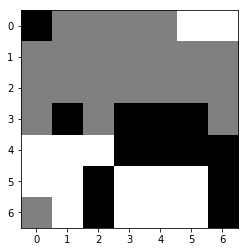

((3, 1), (3, 2)): n_v:  8067 q_all:+0.039662 q:-0.006226 q_m:+0.080000 p:0.151693
((3, 1), (3, 0)): n_v:   845 q_all:-0.005284 q:+0.013569 q_m:+0.080000 p:0.074989
((3, 5), (3, 6)): n_v:   606 q_all:-0.047990 q:-0.021471 q_m:-0.000000 p:0.102218
((5, 2), (6, 0)): n_v:   324 q_all:+0.006325 q:+0.021566 q_m:+0.100000 p:0.020693
((6, 2), (6, 0)): n_v:   276 q_all:+0.006397 q:+0.010845 q_m:+0.100000 p:0.017518
((3, 3), (1, 5)): n_v:   253 q_all:-0.008532 q:+0.009805 q_m:+0.060000 p:0.024279
((3, 5), (1, 5)): n_v:   238 q_all:-0.009708 q:+0.014922 q_m:+0.060000 p:0.023367
((3, 4), (1, 5)): n_v:   217 q_all:-0.008154 q:+0.020933 q_m:+0.060000 p:0.020665
((3, 3), (1, 1)): n_v:   129 q_all:-0.038255 q:-0.049726 q_m:-0.020000 p:0.019742
((3, 4), (3, 6)): n_v:   102 q_all:-0.071059 q:-0.067588 q_m:-0.020000 p:0.021386
((3, 1), (1, 1)): n_v:    77 q_all:-0.031248 q:-0.048418 q_m:-0.020000 p:0.010899
((5, 2), (3, 0)): n_v:    54 q_all:-0.015811 q:-0.023114 q_m:+0.060000 p:0.006021
((3, 4), (1, 6))

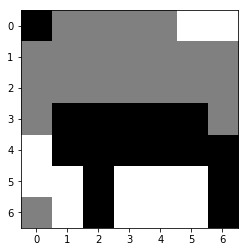

((4, 0), (3, 0)): n_v:  8737 q_all:+0.016793 q:-0.017235 q_m:+0.020000 p:0.392218
((4, 0), (2, 2)): n_v:  1271 q_all:-0.035936 q:-0.036020 q_m:+0.040000 p:0.162344
((5, 0), (3, 0)): n_v:  1053 q_all:-0.062389 q:-0.077461 q_m:-0.000000 p:0.193278
((5, 1), (3, 0)): n_v:   505 q_all:-0.080961 q:-0.078369 q_m:-0.000000 p:0.109197
((5, 5), (3, 6)): n_v:   165 q_all:-0.058633 q:-0.059187 q_m:+0.040000 p:0.029318
((0, 6), (2, 4)): n_v:   158 q_all:-0.030119 q:-0.013446 q_m:+0.040000 p:0.018173
((0, 5), (2, 4)): n_v:   139 q_all:-0.032453 q:-0.024606 q_m:+0.040000 p:0.016671
((5, 4), (3, 6)): n_v:   131 q_all:-0.082904 q:-0.061709 q_m:+0.040000 p:0.028733
((0, 5), (1, 5)): n_v:    32 q_all:-0.084514 q:-0.109242 q_m:-0.060000 p:0.007326
((0, 5), (1, 4)): n_v:    26 q_all:-0.088140 q:-0.107867 q_m:-0.060000 p:0.006023
((4, 0), (6, 0)): n_v:    25 q_all:-0.116643 q:-0.123440 q_m:-0.080000 p:0.007191
((0, 5), (2, 5)): n_v:    20 q_all:-0.048137 q:-0.063183 q_m:-0.000000 p:0.003049
((0, 5), (2, 3))

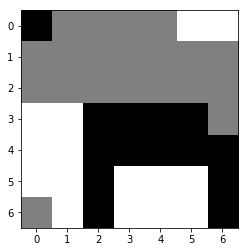

((3, 5), (1, 5)): n_v:  5797 q_all:+0.061092 q:+0.022575 q_m:+0.060000 p:0.063148
((6, 2), (6, 0)): n_v:  3012 q_all:-0.001359 q:-0.002786 q_m:+0.100000 p:0.220083
((3, 5), (3, 6)): n_v:   702 q_all:-0.037937 q:-0.016398 q_m:-0.000000 p:0.106286
((3, 4), (1, 5)): n_v:   572 q_all:-0.022922 q:+0.023035 q_m:+0.060000 p:0.068240
((4, 2), (6, 0)): n_v:   449 q_all:-0.018641 q:-0.018748 q_m:+0.100000 p:0.049446
((3, 5), (2, 6)): n_v:   329 q_all:-0.046679 q:-0.040287 q_m:-0.000000 p:0.056007
((3, 2), (2, 1)): n_v:   316 q_all:-0.004274 q:+0.004571 q_m:+0.080000 p:0.025111
((5, 2), (6, 0)): n_v:   229 q_all:-0.020258 q:-0.010308 q_m:+0.100000 p:0.026006
((3, 3), (1, 5)): n_v:   199 q_all:-0.029740 q:+0.012225 q_m:+0.060000 p:0.026584
((0, 0), (0, 1)): n_v:   198 q_all:-0.035360 q:-0.032399 q_m:-0.000000 p:0.028930
((5, 6), (3, 6)): n_v:   113 q_all:-0.079996 q:-0.077015 q_m:-0.020000 p:0.027260
((3, 2), (1, 1)): n_v:    86 q_all:-0.079418 q:-0.066667 q_m:-0.020000 p:0.020775
((3, 5), (1, 6))

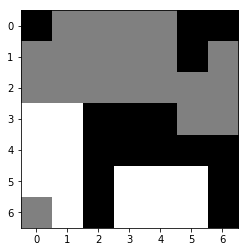

((5, 0), (6, 0)): n_v:  4919 q_all:+0.027702 q:-0.085490 q_m:-0.040000 p:0.009656
((5, 3), (3, 5)): n_v:  1428 q_all:-0.051221 q:-0.007716 q_m:+0.100000 p:0.202691
((3, 1), (2, 3)): n_v:  1057 q_all:-0.043344 q:-0.001226 q_m:+0.060000 p:0.128214
((3, 0), (1, 1)): n_v:   817 q_all:-0.065593 q:-0.089726 q_m:-0.020000 p:0.146861
((3, 1), (2, 2)): n_v:   714 q_all:-0.059826 q:-0.018993 q_m:+0.040000 p:0.117599
((5, 5), (3, 5)): n_v:   635 q_all:-0.085254 q:-0.020594 q_m:+0.100000 p:0.139337
((3, 1), (1, 1)): n_v:   298 q_all:-0.060450 q:-0.074853 q_m:-0.020000 p:0.051450
((3, 0), (2, 1)): n_v:   232 q_all:-0.059723 q:-0.029052 q_m:-0.000000 p:0.038214
((5, 4), (3, 5)): n_v:   212 q_all:-0.100108 q:-0.024549 q_m:+0.100000 p:0.052600
((4, 0), (2, 2)): n_v:    45 q_all:-0.090780 q:-0.037975 q_m:+0.020000 p:0.010579
((3, 0), (1, 0)): n_v:    45 q_all:-0.064403 q:-0.063579 q_m:-0.020000 p:0.008100
((3, 1), (1, 0)): n_v:    42 q_all:-0.044640 q:-0.038693 q_m:-0.020000 p:0.006040
((3, 1), (1, 3))

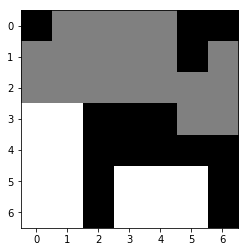

((4, 5), (3, 6)): n_v:  1659 q_all:+0.057097 q:+0.013379 q_m:+0.060000 p:0.006743
((3, 2), (2, 1)): n_v:  1016 q_all:+0.009766 q:+0.062167 q_m:+0.140000 p:0.060380
((0, 0), (0, 1)): n_v:   985 q_all:-0.013499 q:+0.008638 q_m:+0.060000 p:0.124003
((1, 5), (2, 4)): n_v:   849 q_all:+0.037524 q:+0.000183 q_m:+0.060000 p:0.021819
((3, 3), (1, 2)): n_v:   780 q_all:+0.030344 q:-0.024557 q_m:+0.040000 p:0.016786
((3, 3), (2, 1)): n_v:   239 q_all:-0.024803 q:+0.033080 q_m:+0.120000 p:0.037830
((3, 3), (1, 4)): n_v:   229 q_all:+0.038097 q:-0.027349 q_m:+0.040000 p:0.005703
((3, 4), (2, 6)): n_v:   215 q_all:-0.042721 q:-0.014158 q_m:+0.040000 p:0.044966
((3, 3), (1, 1)): n_v:   205 q_all:-0.054751 q:-0.018470 q_m:+0.040000 p:0.050138
((1, 5), (2, 6)): n_v:   194 q_all:-0.058789 q:+0.014767 q_m:+0.060000 p:0.049695
((3, 4), (3, 5)): n_v:   179 q_all:-0.000928 q:+0.016893 q_m:+0.060000 p:0.016121
((0, 0), (1, 1)): n_v:   178 q_all:-0.033284 q:+0.017705 q_m:+0.060000 p:0.032445
((3, 2), (2, 0))

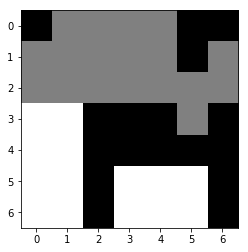

((5, 3), (3, 5)): n_v:  2065 q_all:-0.001895 q:+0.017097 q_m:+0.140000 p:0.342048
((5, 5), (3, 5)): n_v:  1161 q_all:-0.064701 q:-0.000067 q_m:+0.140000 p:0.396553
((3, 0), (1, 0)): n_v:   576 q_all:+0.056029 q:-0.066604 q_m:-0.020000 p:0.002114
((3, 1), (2, 3)): n_v:   467 q_all:+0.015344 q:-0.020935 q_m:+0.060000 p:0.054924
((5, 4), (3, 5)): n_v:   290 q_all:-0.074955 q:-0.007503 q_m:+0.140000 p:0.107564
((3, 0), (1, 1)): n_v:   171 q_all:+0.009840 q:-0.075683 q_m:-0.020000 p:0.022784
((3, 0), (2, 1)): n_v:   145 q_all:+0.027311 q:-0.048075 q_m:-0.000000 p:0.012167
((3, 1), (2, 2)): n_v:   124 q_all:+0.006641 q:-0.035683 q_m:+0.040000 p:0.017600
((3, 1), (1, 1)): n_v:    57 q_all:-0.000402 q:-0.089116 q_m:-0.020000 p:0.009299
((4, 1), (2, 3)): n_v:    22 q_all:-0.069309 q:-0.018710 q_m:+0.060000 p:0.008065
((3, 1), (1, 3)): n_v:    11 q_all:-0.037592 q:-0.095553 q_m:-0.060000 p:0.003164
((4, 0), (2, 2)): n_v:    11 q_all:-0.080667 q:-0.055455 q_m:+0.020000 p:0.004533
((3, 0), (2, 2))

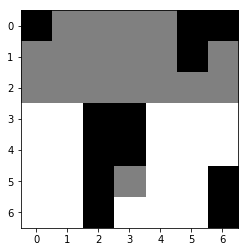

((4, 2), (5, 3)): n_v:  6989 q_all:+0.048732 q:+0.008104 q_m:+0.040000 p:0.224297
((3, 2), (5, 3)): n_v:    42 q_all:-0.021253 q:-0.011796 q_m:+0.020000 p:0.008491
((3, 2), (1, 3)): n_v:     8 q_all:-0.177120 q:-0.181074 q_m:-0.140000 p:0.004802
((3, 3), (5, 3)): n_v:     4 q_all:-0.036344 q:+0.006917 q_m:+0.020000 p:0.000949
((4, 3), (2, 5)): n_v:     4 q_all:-0.044272 q:-0.089942 q_m:-0.020000 p:0.001258
((4, 3), (2, 1)): n_v:     2 q_all:-0.112328 q:-0.092327 q_m:-0.060000 p:0.001141
((0, 5), (1, 3)): n_v:     2 q_all:-0.185572 q:-0.162226 q_m:-0.140000 p:0.001589
((3, 3), (2, 1)): n_v:     1 q_all:-0.138713 q:-0.094851 q_m:-0.060000 p:0.000484
((3, 2), (2, 1)): n_v:     1 q_all:-0.121915 q:-0.088710 q_m:-0.040000 p:0.000712
((1, 5), (1, 3)): n_v:     1 q_all:-0.209457 q:-0.133314 q_m:-0.140000 p:0.001265
((3, 3), (2, 5)): n_v:     1 q_all:-0.105517 q:-0.081697 q_m:-0.020000 p:0.000557
((1, 5), (2, 5)): n_v:     1 q_all:-0.056650 q:-0.070449 q_m:-0.000000 p:0.000229
((1, 5), (2, 6))

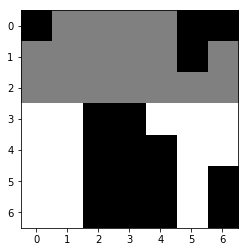

((3, 6), (1, 6)): n_v:  5656 q_all:+0.070453 q:+0.010468 q_m:+0.080000 p:0.028665
((3, 4), (2, 3)): n_v:  1676 q_all:-0.050439 q:-0.021844 q_m:+0.060000 p:0.243452
((3, 0), (1, 1)): n_v:   845 q_all:-0.067016 q:-0.041092 q_m:-0.000000 p:0.156323
((3, 4), (2, 2)): n_v:   517 q_all:-0.053990 q:-0.032132 q_m:+0.040000 p:0.079526
((3, 1), (2, 2)): n_v:   379 q_all:-0.049256 q:-0.027696 q_m:+0.060000 p:0.054006
((3, 4), (2, 4)): n_v:   336 q_all:-0.043249 q:-0.015778 q_m:+0.060000 p:0.042916
((3, 1), (1, 1)): n_v:   207 q_all:-0.083183 q:-0.063566 q_m:-0.000000 p:0.046437
((3, 4), (1, 6)): n_v:   194 q_all:-0.003628 q:+0.024514 q_m:+0.080000 p:0.006448
((3, 4), (1, 2)): n_v:   189 q_all:-0.099257 q:-0.099751 q_m:-0.040000 p:0.049771
((3, 1), (2, 3)): n_v:   182 q_all:-0.067421 q:-0.040039 q_m:+0.040000 p:0.033930
((3, 5), (1, 4)): n_v:   178 q_all:-0.063075 q:-0.059923 q_m:+0.040000 p:0.031288
((3, 4), (1, 4)): n_v:   161 q_all:-0.027706 q:-0.034468 q_m:+0.040000 p:0.014634
((3, 0), (1, 0))

((3, 3), (2, 5)): n_v:  6496 q_all:+0.019876 q:-0.017188 q_m:+0.080000 p:0.161456
((3, 3), (2, 4)): n_v:  1332 q_all:-0.056623 q:-0.012718 q_m:+0.060000 p:0.155128
((3, 2), (2, 1)): n_v:   610 q_all:-0.061572 q:+0.006571 q_m:+0.020000 p:0.079054
((3, 2), (2, 2)): n_v:   452 q_all:-0.096882 q:-0.020547 q_m:-0.020000 p:0.101000
((3, 3), (2, 1)): n_v:   300 q_all:-0.099982 q:+0.006641 q_m:-0.000000 p:0.069603
((3, 2), (2, 4)): n_v:   229 q_all:-0.063886 q:-0.032507 q_m:+0.040000 p:0.031133
((5, 6), (3, 6)): n_v:   202 q_all:-0.054640 q:-0.023577 q_m:+0.040000 p:0.022515
((3, 2), (2, 0)): n_v:   196 q_all:-0.094302 q:-0.021084 q_m:-0.000000 p:0.042613
((0, 0), (2, 0)): n_v:   118 q_all:-0.050368 q:-0.000234 q_m:-0.000000 p:0.011830
((4, 2), (2, 4)): n_v:    98 q_all:-0.085670 q:-0.041049 q_m:+0.040000 p:0.018891
((4, 4), (2, 6)): n_v:    77 q_all:-0.067927 q:-0.030458 q_m:+0.040000 p:0.011254
((3, 2), (1, 0)): n_v:    48 q_all:-0.152241 q:-0.088445 q_m:-0.080000 p:0.017355
((4, 3), (2, 5))

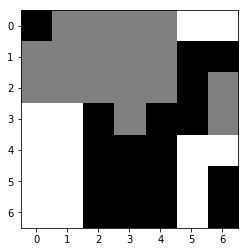

((4, 6), (2, 6)): n_v:  4025 q_all:+0.067584 q:-0.000849 q_m:+0.080000 p:0.090158
((5, 5), (3, 3)): n_v:  2725 q_all:+0.020509 q:-0.007683 q_m:+0.120000 p:0.181074
((4, 5), (3, 3)): n_v:  1633 q_all:+0.003049 q:-0.009908 q_m:+0.120000 p:0.164808
((5, 1), (3, 3)): n_v:  1326 q_all:-0.039489 q:-0.011270 q_m:+0.120000 p:0.265616
((4, 1), (3, 3)): n_v:   620 q_all:-0.044179 q:+0.015871 q_m:+0.120000 p:0.130690
((0, 5), (2, 6)): n_v:   237 q_all:+0.025909 q:-0.011770 q_m:+0.080000 p:0.013005
((3, 1), (3, 3)): n_v:   220 q_all:-0.003348 q:+0.012114 q_m:+0.120000 p:0.025776
((0, 6), (2, 6)): n_v:   156 q_all:-0.004581 q:-0.004704 q_m:+0.080000 p:0.019235
((4, 6), (2, 4)): n_v:    97 q_all:-0.013842 q:+0.001153 q_m:+0.080000 p:0.013846
((4, 5), (2, 6)): n_v:    80 q_all:-0.022907 q:-0.011718 q_m:+0.080000 p:0.013221
((4, 0), (2, 0)): n_v:    62 q_all:-0.146804 q:-0.115122 q_m:-0.080000 p:0.026286
((0, 6), (2, 4)): n_v:    48 q_all:-0.009923 q:-0.001561 q_m:+0.080000 p:0.006328
((4, 0), (2, 2))

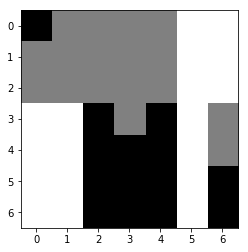

((5, 6), (4, 6)): n_v:  2048 q_all:-0.029070 q:+0.027843 q_m:+0.060000 p:0.271719
((5, 6), (3, 6)): n_v:  2007 q_all:-0.056610 q:-0.055990 q_m:+0.080000 p:0.399218
((3, 4), (1, 4)): n_v:  1176 q_all:+0.025321 q:-0.057971 q_m:+0.040000 p:0.001784
((6, 6), (4, 6)): n_v:   489 q_all:-0.047133 q:+0.001973 q_m:+0.040000 p:0.086260
((3, 4), (3, 6)): n_v:   231 q_all:-0.042805 q:-0.042465 q_m:+0.080000 p:0.038405
((3, 4), (2, 4)): n_v:   228 q_all:-0.077425 q:-0.039163 q_m:+0.060000 p:0.056937
((5, 4), (3, 6)): n_v:   219 q_all:-0.086045 q:-0.070112 q_m:+0.080000 p:0.059037
((3, 4), (4, 6)): n_v:   141 q_all:-0.004264 q:-0.015108 q_m:+0.040000 p:0.009052
((3, 2), (2, 2)): n_v:    53 q_all:-0.146158 q:-0.056189 q_m:-0.020000 p:0.022288
((6, 4), (4, 6)): n_v:    47 q_all:-0.046266 q:-0.029721 q_m:+0.040000 p:0.008322
((4, 4), (3, 6)): n_v:    41 q_all:-0.071251 q:-0.033354 q_m:+0.080000 p:0.009679
((3, 2), (2, 1)): n_v:    24 q_all:-0.073762 q:-0.024198 q_m:+0.020000 p:0.005883
((3, 2), (1, 4))

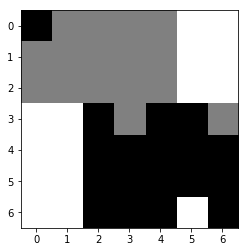

((2, 5), (3, 6)): n_v:  5559 q_all:+0.105985 q:-0.002320 q_m:+0.080000 p:0.233809
((1, 5), (3, 3)): n_v:   517 q_all:+0.060084 q:+0.054457 q_m:+0.140000 p:0.075468
((5, 1), (3, 3)): n_v:   254 q_all:+0.031257 q:-0.002138 q_m:+0.140000 p:0.055946
((2, 5), (3, 3)): n_v:   190 q_all:+0.058567 q:+0.055098 q_m:+0.140000 p:0.029055
((4, 1), (3, 3)): n_v:   170 q_all:+0.027561 q:+0.014473 q_m:+0.140000 p:0.038772
((1, 6), (3, 6)): n_v:   127 q_all:+0.011315 q:-0.003921 q_m:+0.060000 p:0.034234
((3, 1), (3, 3)): n_v:    44 q_all:+0.063876 q:+0.020513 q_m:+0.140000 p:0.006258
((1, 5), (3, 6)): n_v:    30 q_all:+0.004827 q:-0.017536 q_m:+0.060000 p:0.008458
((3, 0), (1, 1)): n_v:     4 q_all:-0.022882 q:-0.058669 q_m:-0.020000 p:0.001587
((3, 1), (1, 1)): n_v:     1 q_all:-0.080947 q:-0.078048 q_m:-0.020000 p:0.000886
((3, 1), (1, 0)): n_v:     1 q_all:-0.007815 q:-0.062739 q_m:-0.020000 p:0.000506
((1, 6), (0, 4)): n_v:     0 q_all:-0.096267 q:-0.150668 q_m:-0.060000 p:0.000004
((1, 5), (2, 4))

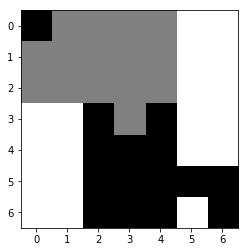

((3, 4), (1, 4)): n_v:  5391 q_all:+0.008135 q:-0.029099 q_m:+0.040000 p:0.006223
((3, 4), (2, 4)): n_v:  3060 q_all:-0.102719 q:-0.018458 q_m:+0.060000 p:0.526191
((3, 2), (2, 2)): n_v:   678 q_all:-0.178026 q:-0.036791 q_m:-0.020000 p:0.246790
((3, 2), (2, 1)): n_v:   518 q_all:-0.113554 q:-0.000016 q_m:+0.020000 p:0.104131
((3, 2), (2, 0)): n_v:   127 q_all:-0.093702 q:-0.018123 q_m:-0.000000 p:0.018833
((3, 2), (1, 4)): n_v:    99 q_all:-0.062080 q:-0.032358 q_m:+0.040000 p:0.006156
((4, 2), (2, 4)): n_v:    76 q_all:-0.072551 q:-0.017873 q_m:+0.040000 p:0.006997
((4, 2), (2, 1)): n_v:    31 q_all:-0.118022 q:-0.025319 q_m:-0.000000 p:0.006786
((3, 2), (2, 4)): n_v:    26 q_all:-0.087246 q:-0.026561 q_m:+0.040000 p:0.003417
((3, 2), (1, 0)): n_v:    17 q_all:-0.167961 q:-0.091894 q_m:-0.080000 p:0.006101
((3, 4), (2, 2)): n_v:    17 q_all:-0.160968 q:-0.059300 q_m:-0.040000 p:0.005688
((4, 3), (2, 4)): n_v:    15 q_all:-0.144972 q:-0.081145 q_m:+0.040000 p:0.004155
((3, 2), (1, 2))

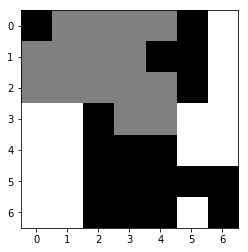

((0, 6), (2, 4)): n_v:  5072 q_all:+0.082033 q:-0.009137 q_m:+0.080000 p:0.034320
((0, 6), (0, 4)): n_v:  1720 q_all:+0.004395 q:-0.003268 q_m:+0.080000 p:0.211918
((1, 6), (0, 4)): n_v:  1244 q_all:+0.016948 q:-0.008511 q_m:+0.080000 p:0.110536
((3, 5), (3, 4)): n_v:   854 q_all:-0.002188 q:-0.017989 q_m:+0.100000 p:0.120572
((2, 6), (0, 4)): n_v:   461 q_all:-0.043297 q:-0.007565 q_m:+0.080000 p:0.116688
((2, 6), (2, 4)): n_v:   135 q_all:-0.033526 q:-0.005793 q_m:+0.080000 p:0.030746
((4, 5), (3, 3)): n_v:   123 q_all:-0.003668 q:-0.006933 q_m:+0.120000 p:0.017904
((3, 5), (2, 4)): n_v:   108 q_all:-0.025476 q:-0.000350 q_m:+0.100000 p:0.022065
((1, 6), (2, 4)): n_v:    86 q_all:-0.011869 q:-0.009028 q_m:+0.080000 p:0.016590
((4, 6), (3, 4)): n_v:    72 q_all:-0.023569 q:-0.038453 q_m:+0.080000 p:0.014473
((3, 0), (1, 1)): n_v:    63 q_all:-0.059651 q:-0.045106 q_m:-0.000000 p:0.018192
((3, 1), (2, 2)): n_v:    50 q_all:-0.072249 q:-0.062714 q_m:+0.020000 p:0.015628
((5, 1), (3, 3))

((4, 3), (3, 4)): n_v:  3746 q_all:-0.079608 q:+0.013792 q_m:+0.100000 p:0.478233
((5, 6), (3, 4)): n_v:  2687 q_all:-0.023666 q:-0.024480 q_m:+0.080000 p:0.074215
((3, 2), (2, 3)): n_v:  1668 q_all:+0.034375 q:-0.051072 q_m:+0.020000 p:0.004412
((3, 2), (2, 2)): n_v:  1132 q_all:-0.012038 q:-0.059699 q_m:-0.020000 p:0.003347
((4, 2), (3, 4)): n_v:   218 q_all:-0.049294 q:-0.004085 q_m:+0.080000 p:0.009282
((5, 5), (3, 4)): n_v:   134 q_all:-0.113116 q:-0.038560 q_m:+0.080000 p:0.029870
((0, 5), (0, 4)): n_v:    93 q_all:-0.076620 q:-0.001709 q_m:+0.020000 p:0.011078
((3, 2), (3, 4)): n_v:    89 q_all:-0.065590 q:-0.000150 q_m:+0.080000 p:0.007864
((0, 5), (0, 6)): n_v:    61 q_all:-0.069871 q:-0.017084 q_m:+0.020000 p:0.006138
((5, 2), (3, 4)): n_v:    59 q_all:-0.089933 q:-0.031992 q_m:+0.080000 p:0.009243
((5, 4), (3, 4)): n_v:    39 q_all:-0.144358 q:-0.055055 q_m:+0.080000 p:0.011467
((5, 3), (3, 4)): n_v:    37 q_all:-0.175902 q:-0.070917 q_m:+0.080000 p:0.013561
((3, 2), (2, 1))

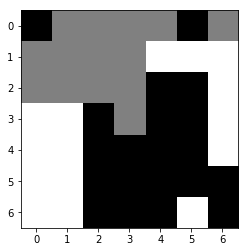

((1, 5), (3, 3)): n_v:  3871 q_all:+0.053377 q:+0.004735 q_m:+0.140000 p:0.462802
((1, 4), (3, 3)): n_v:  2332 q_all:+0.085060 q:+0.019982 q_m:+0.140000 p:0.120853
((5, 1), (3, 3)): n_v:  1507 q_all:+0.034607 q:-0.021359 q_m:+0.140000 p:0.240579
((4, 1), (3, 3)): n_v:   770 q_all:+0.019120 q:-0.012081 q_m:+0.140000 p:0.148485
((3, 1), (3, 3)): n_v:   171 q_all:+0.046574 q:-0.013568 q_m:+0.140000 p:0.022821
((3, 0), (2, 1)): n_v:     2 q_all:-0.037439 q:-0.098649 q_m:-0.040000 p:0.000794
((1, 4), (0, 4)): n_v:     1 q_all:-0.023489 q:-0.066349 q_m:-0.040000 p:0.000456
((3, 1), (2, 3)): n_v:     1 q_all:-0.026066 q:-0.097432 q_m:+0.020000 p:0.000390
((1, 6), (0, 4)): n_v:     0 q_all:-0.085107 q:-0.122768 q_m:-0.060000 p:0.000020
((1, 4), (2, 2)): n_v:     0 q_all:-0.089273 q:-0.133183 q_m:-0.060000 p:0.000004
((3, 1), (1, 3)): n_v:     0 q_all:-0.084581 q:-0.121452 q_m:-0.060000 p:0.000389
((4, 1), (2, 3)): n_v:     0 q_all:-0.035410 q:-0.118524 q_m:+0.020000 p:0.000064
((3, 1), (1, 2))

((0, 5), (1, 5)): n_v:  5606 q_all:+0.054395 q:+0.037743 q_m:+0.040000 p:0.206993
((0, 0), (1, 1)): n_v:   432 q_all:-0.078516 q:-0.090187 q_m:-0.120000 p:0.138118
((3, 5), (2, 3)): n_v:   348 q_all:-0.043287 q:-0.014355 q_m:+0.060000 p:0.085186
((0, 5), (2, 3)): n_v:   210 q_all:+0.004202 q:-0.003598 q_m:+0.060000 p:0.030208
((3, 5), (1, 5)): n_v:   175 q_all:-0.027169 q:-0.003789 q_m:+0.020000 p:0.036907
((2, 5), (2, 3)): n_v:   170 q_all:+0.010661 q:+0.000832 q_m:+0.060000 p:0.022164
((0, 0), (2, 1)): n_v:   125 q_all:+0.003006 q:-0.037025 q_m:-0.020000 p:0.018332
((4, 5), (2, 3)): n_v:    40 q_all:-0.036809 q:-0.015749 q_m:+0.060000 p:0.009444
((2, 5), (0, 6)): n_v:     6 q_all:-0.008167 q:-0.424890 q_m:-0.100000 p:0.000863
((0, 5), (0, 6)): n_v:     3 q_all:-0.176945 q:-0.124841 q_m:-0.080000 p:0.001855
((0, 5), (0, 4)): n_v:     1 q_all:-0.078868 q:-0.080263 q_m:-0.080000 p:0.000379
((0, 5), (0, 3)): n_v:     1 q_all:-0.059280 q:-0.108829 q_m:-0.100000 p:0.000373
((0, 5), (1, 3))

((3, 2), (2, 3)): n_v:  4042 q_all:-0.040631 q:-0.067219 q_m:+0.060000 p:0.227627
((3, 3), (1, 3)): n_v:  3672 q_all:+0.000502 q:-0.065082 q_m:+0.040000 p:0.005858
((3, 0), (1, 1)): n_v:   923 q_all:-0.022136 q:-0.087757 q_m:-0.000000 p:0.014777
((3, 4), (1, 3)): n_v:   452 q_all:-0.032979 q:-0.080850 q_m:+0.040000 p:0.020481
((3, 2), (1, 3)): n_v:   362 q_all:-0.067778 q:-0.056765 q_m:+0.040000 p:0.046662
((3, 1), (1, 1)): n_v:   346 q_all:-0.084821 q:-0.104967 q_m:-0.000000 p:0.057805
((3, 1), (2, 3)): n_v:   193 q_all:-0.062087 q:-0.077753 q_m:+0.040000 p:0.021821
((3, 3), (1, 1)): n_v:   192 q_all:-0.103009 q:-0.113297 q_m:-0.000000 p:0.039063
((3, 2), (1, 1)): n_v:    75 q_all:-0.078577 q:-0.134864 q_m:-0.000000 p:0.011475
((3, 1), (1, 3)): n_v:    59 q_all:-0.084632 q:-0.067707 q_m:+0.040000 p:0.009842
((3, 4), (2, 2)): n_v:    41 q_all:-0.120625 q:-0.162680 q_m:-0.040000 p:0.009937
((3, 4), (1, 2)): n_v:    41 q_all:-0.097416 q:-0.154947 q_m:-0.040000 p:0.007995
((3, 0), (1, 0))

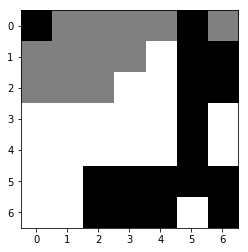

((0, 5), (1, 3)): n_v:  4837 q_all:+0.080458 q:+0.051976 q_m:+0.060000 p:0.408003
((0, 0), (2, 2)): n_v:  1182 q_all:+0.072583 q:+0.042233 q_m:+0.100000 p:0.119345
((1, 5), (1, 3)): n_v:   622 q_all:+0.050630 q:+0.040914 q_m:+0.060000 p:0.091523
((0, 0), (2, 1)): n_v:   457 q_all:+0.045018 q:+0.021338 q_m:+0.060000 p:0.072598
((3, 5), (1, 3)): n_v:   351 q_all:+0.026435 q:+0.008473 q_m:+0.060000 p:0.069546
((2, 5), (1, 3)): n_v:   329 q_all:+0.018907 q:+0.020163 q_m:+0.060000 p:0.070420
((0, 5), (0, 4)): n_v:   228 q_all:+0.035568 q:+0.021359 q_m:-0.000000 p:0.040837
((0, 0), (1, 1)): n_v:   113 q_all:-0.003198 q:-0.012888 q_m:-0.040000 p:0.029593
((1, 6), (0, 4)): n_v:    36 q_all:+0.014869 q:-0.002653 q_m:-0.020000 p:0.008128
((0, 5), (0, 6)): n_v:    32 q_all:-0.036384 q:-0.060220 q_m:-0.040000 p:0.010702
((0, 0), (1, 2)): n_v:    21 q_all:+0.013707 q:-0.001955 q_m:-0.020000 p:0.004923
((0, 5), (0, 3)): n_v:    19 q_all:+0.002960 q:-0.017637 q_m:-0.020000 p:0.004895
((0, 0), (2, 0))

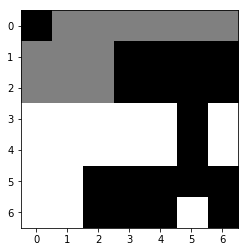

((3, 1), (2, 2)): n_v:  5844 q_all:-0.061817 q:-0.109837 q_m:+0.040000 p:0.356309
((3, 2), (1, 2)): n_v:  1075 q_all:-0.034822 q:-0.092242 q_m:+0.020000 p:0.006799
((3, 0), (1, 0)): n_v:   195 q_all:-0.043784 q:-0.102436 q_m:-0.020000 p:0.004785
((3, 4), (2, 2)): n_v:   164 q_all:-0.081874 q:-0.146532 q_m:+0.020000 p:0.016545
((3, 1), (1, 1)): n_v:   156 q_all:-0.135125 q:-0.126942 q_m:-0.020000 p:0.032691
((3, 0), (2, 2)): n_v:   147 q_all:-0.057407 q:-0.127133 q_m:+0.020000 p:0.007691
((3, 0), (1, 1)): n_v:   145 q_all:-0.075961 q:-0.107539 q_m:-0.020000 p:0.013059
((4, 0), (2, 2)): n_v:   119 q_all:-0.047548 q:-0.128930 q_m:+0.020000 p:0.003744
((3, 1), (1, 2)): n_v:    96 q_all:-0.132333 q:-0.084648 q_m:+0.020000 p:0.019673
((4, 4), (2, 2)): n_v:    85 q_all:-0.081738 q:-0.113067 q_m:+0.020000 p:0.008611
((3, 3), (1, 1)): n_v:    68 q_all:-0.151664 q:-0.096101 q_m:-0.020000 p:0.016700
((3, 0), (1, 2)): n_v:    41 q_all:-0.131818 q:-0.085141 q_m:+0.020000 p:0.008395
((3, 3), (1, 2))

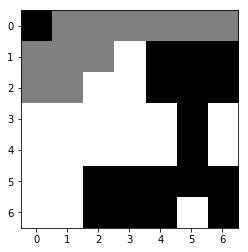

((0, 0), (2, 1)): n_v:  5848 q_all:+0.102686 q:+0.054505 q_m:+0.120000 p:0.309038
((0, 0), (1, 2)): n_v:  4894 q_all:+0.059295 q:+0.058555 q_m:+0.080000 p:0.666547
((0, 0), (1, 1)): n_v:    45 q_all:+0.041879 q:-0.002513 q_m:+0.020000 p:0.007607
((1, 4), (1, 2)): n_v:    35 q_all:+0.035157 q:+0.041441 q_m:+0.080000 p:0.006511
((2, 4), (1, 2)): n_v:     8 q_all:-0.008375 q:+0.022831 q_m:+0.080000 p:0.002162
((1, 6), (0, 4)): n_v:     5 q_all:+0.011551 q:+0.027540 q_m:-0.000000 p:0.001274
((0, 0), (2, 0)): n_v:     5 q_all:+0.009103 q:+0.025246 q_m:+0.040000 p:0.001282
((1, 4), (0, 4)): n_v:     1 q_all:-0.022685 q:+0.031264 q_m:+0.020000 p:0.000559
((0, 0), (0, 2)): n_v:     1 q_all:-0.023215 q:+0.025103 q_m:-0.000000 p:0.000391
((0, 0), (1, 0)): n_v:     1 q_all:-0.049395 q:+0.000344 q_m:-0.020000 p:0.000686
((2, 4), (0, 6)): n_v:     0 q_all:-0.051590 q:-0.068975 q_m:-0.040000 p:0.000000
((2, 5), (0, 3)): n_v:     0 q_all:-0.012211 q:-0.030528 q_m:-0.000000 p:0.000004
((2, 4), (0, 5))

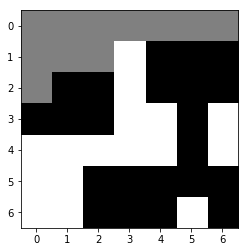

((1, 3), (0, 5)): n_v:  5842 q_all:-0.015888 q:-0.095824 q_m:-0.000000 p:0.075412
((1, 3), (1, 2)): n_v:  1823 q_all:-0.088009 q:-0.089537 q_m:-0.020000 p:0.232677
((2, 3), (1, 1)): n_v:   561 q_all:-0.134460 q:-0.141147 q_m:-0.040000 p:0.135182
((1, 3), (1, 1)): n_v:   350 q_all:-0.122347 q:-0.145430 q_m:-0.040000 p:0.076280
((1, 3), (0, 4)): n_v:   293 q_all:-0.115068 q:-0.129668 q_m:-0.020000 p:0.058088
((2, 3), (0, 5)): n_v:   276 q_all:-0.111559 q:-0.140832 q_m:-0.000000 p:0.052153
((1, 3), (0, 1)): n_v:   163 q_all:-0.147876 q:-0.194365 q_m:-0.120000 p:0.043669
((3, 3), (1, 1)): n_v:   146 q_all:-0.160847 q:-0.114478 q_m:-0.040000 p:0.042681
((1, 3), (0, 2)): n_v:   133 q_all:-0.170113 q:-0.177694 q_m:-0.100000 p:0.041247
((2, 3), (0, 1)): n_v:    73 q_all:-0.189258 q:-0.201645 q_m:-0.120000 p:0.025215
((4, 0), (2, 0)): n_v:    54 q_all:-0.114683 q:-0.118999 q_m:-0.000000 p:0.010555
((1, 3), (0, 3)): n_v:    51 q_all:-0.144470 q:-0.168832 q_m:-0.060000 p:0.013415
((4, 2), (2, 0))

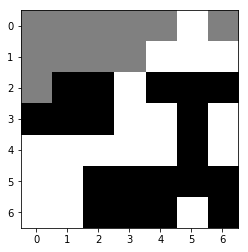

((2, 2), (1, 3)): n_v:  8879 q_all:+0.055233 q:+0.039852 q_m:+0.100000 p:0.312868
((2, 2), (0, 4)): n_v:   697 q_all:+0.040984 q:+0.071232 q_m:+0.120000 p:0.009112
((2, 6), (0, 4)): n_v:   395 q_all:+0.018509 q:+0.048266 q_m:+0.120000 p:0.028408
((2, 6), (0, 6)): n_v:   216 q_all:+0.002063 q:+0.031317 q_m:+0.120000 p:0.024858
((2, 1), (2, 0)): n_v:    91 q_all:-0.028190 q:-0.005757 q_m:+0.020000 p:0.017694
((2, 4), (0, 6)): n_v:    72 q_all:+0.033118 q:+0.021404 q_m:+0.120000 p:0.002457
((2, 4), (0, 4)): n_v:    56 q_all:+0.011182 q:+0.063365 q_m:+0.120000 p:0.005075
((2, 1), (1, 0)): n_v:    39 q_all:-0.028871 q:-0.003854 q_m:+0.020000 p:0.007624
((2, 5), (0, 4)): n_v:    32 q_all:-0.007325 q:+0.028387 q_m:+0.120000 p:0.004401
((2, 1), (1, 3)): n_v:    26 q_all:-0.002300 q:+0.028929 q_m:+0.080000 p:0.003362
((2, 1), (1, 2)): n_v:    24 q_all:-0.031168 q:+0.025083 q_m:+0.060000 p:0.004969
((2, 5), (1, 3)): n_v:    23 q_all:-0.032097 q:-0.010057 q_m:+0.080000 p:0.004664
((2, 4), (0, 2))

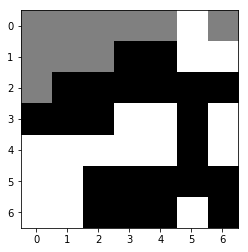

((0, 5), (0, 4)): n_v:  9277 q_all:-0.020687 q:-0.068884 q_m:-0.000000 p:0.336298
((3, 4), (1, 2)): n_v:  1882 q_all:-0.040463 q:-0.042524 q_m:+0.060000 p:0.083000
((3, 3), (1, 2)): n_v:  1806 q_all:-0.056111 q:-0.061455 q_m:+0.060000 p:0.139601
((1, 6), (0, 4)): n_v:   194 q_all:-0.068779 q:-0.087672 q_m:-0.020000 p:0.020268
((4, 0), (2, 0)): n_v:    34 q_all:-0.070973 q:-0.059233 q_m:+0.020000 p:0.003583
((0, 5), (0, 3)): n_v:    30 q_all:-0.088320 q:-0.121708 q_m:-0.020000 p:0.004360
((3, 3), (1, 1)): n_v:    27 q_all:-0.105111 q:-0.075635 q_m:-0.020000 p:0.004827
((4, 2), (2, 0)): n_v:    16 q_all:-0.086751 q:-0.099771 q_m:+0.020000 p:0.002217
((4, 1), (2, 0)): n_v:    15 q_all:-0.091431 q:-0.076825 q_m:+0.020000 p:0.002090
((1, 5), (0, 3)): n_v:     8 q_all:-0.080315 q:-0.124032 q_m:-0.020000 p:0.001052
((0, 5), (0, 6)): n_v:     6 q_all:-0.161420 q:-0.204063 q_m:-0.080000 p:0.001849
-1 's turn
one move takes time(s):  0.4509580135345459


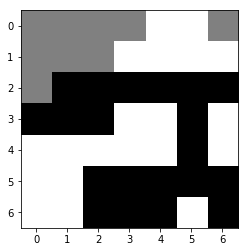

((2, 1), (0, 3)): n_v:  6919 q_all:+0.122520 q:+0.072351 q_m:+0.120000 p:0.049799
((2, 1), (1, 2)): n_v:  2700 q_all:+0.013107 q:+0.018305 q_m:+0.060000 p:0.221028
((2, 6), (0, 6)): n_v:  1194 q_all:+0.023150 q:+0.031292 q_m:+0.120000 p:0.072742
((2, 5), (0, 3)): n_v:   726 q_all:+0.021329 q:+0.021753 q_m:+0.120000 p:0.047068
((2, 4), (0, 3)): n_v:   364 q_all:+0.014962 q:+0.020005 q_m:+0.120000 p:0.028349
((2, 2), (0, 3)): n_v:   285 q_all:+0.023624 q:+0.041621 q_m:+0.120000 p:0.017025
((2, 1), (2, 0)): n_v:   275 q_all:-0.025295 q:-0.002629 q_m:+0.020000 p:0.044445
((2, 1), (1, 0)): n_v:   163 q_all:-0.025152 q:-0.002616 q_m:+0.020000 p:0.026322
((2, 5), (0, 6)): n_v:   112 q_all:+0.031477 q:+0.080107 q_m:+0.120000 p:0.004762
((2, 3), (0, 3)): n_v:    54 q_all:+0.030647 q:+0.070652 q_m:+0.120000 p:0.002349
((2, 1), (1, 1)): n_v:    42 q_all:-0.041246 q:-0.004692 q_m:+0.020000 p:0.008335
((2, 4), (0, 6)): n_v:    35 q_all:+0.026606 q:+0.034261 q_m:+0.120000 p:0.001912
((3, 0), (1, 2))

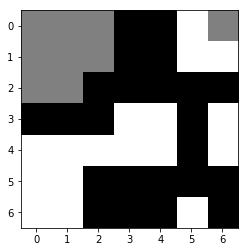

((4, 0), (2, 1)): n_v:  5735 q_all:-0.044562 q:-0.108319 q_m:+0.040000 p:0.084995
((3, 3), (2, 1)): n_v:  1880 q_all:-0.142422 q:-0.091665 q_m:+0.040000 p:0.365041
((4, 3), (2, 1)): n_v:  1847 q_all:-0.125077 q:-0.086290 q_m:+0.040000 p:0.291361
((3, 4), (1, 2)): n_v:   887 q_all:-0.088818 q:-0.086499 q_m:+0.040000 p:0.062572
((3, 3), (1, 2)): n_v:   645 q_all:-0.132916 q:-0.063502 q_m:+0.040000 p:0.113983
((4, 2), (2, 1)): n_v:   139 q_all:-0.151349 q:-0.128643 q_m:+0.040000 p:0.029249
((0, 5), (0, 6)): n_v:    93 q_all:-0.099633 q:-0.305184 q_m:-0.100000 p:0.009016
((3, 3), (1, 1)): n_v:    59 q_all:-0.221708 q:-0.144515 q_m:-0.080000 p:0.020347
((4, 1), (2, 1)): n_v:    49 q_all:-0.167313 q:-0.107175 q_m:+0.040000 p:0.011808
((4, 2), (2, 0)): n_v:     2 q_all:-0.211681 q:-0.199316 q_m:-0.040000 p:0.000903
((4, 0), (2, 0)): n_v:     1 q_all:-0.156746 q:-0.169426 q_m:-0.040000 p:0.000292
((4, 1), (2, 0)): n_v:     0 q_all:-0.128363 q:-0.187271 q_m:-0.040000 p:0.000074
-1 's turn
one m

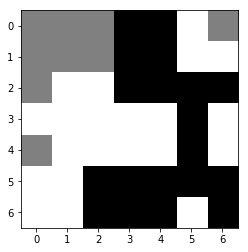

((6, 2), (4, 0)): n_v:  9541 q_all:+0.050284 q:+0.036983 q_m:+0.160000 p:0.880738
((5, 2), (4, 0)): n_v:   513 q_all:+0.036351 q:+0.028436 q_m:+0.160000 p:0.061220
((0, 3), (1, 2)): n_v:   504 q_all:+0.078524 q:+0.060996 q_m:+0.060000 p:0.019084
((0, 4), (0, 6)): n_v:    60 q_all:+0.060508 q:+0.062679 q_m:+0.080000 p:0.004374
((2, 4), (0, 6)): n_v:     1 q_all:+0.043504 q:+0.027624 q_m:+0.080000 p:0.000098
((2, 5), (0, 6)): n_v:     1 q_all:+0.024104 q:+0.026796 q_m:+0.080000 p:0.000086
((1, 3), (1, 1)): n_v:     1 q_all:-0.057461 q:+0.009653 q_m:+0.040000 p:0.000298
((2, 3), (1, 1)): n_v:     1 q_all:+0.026113 q:-0.008137 q_m:+0.040000 p:0.000208
((2, 6), (0, 6)): n_v:     1 q_all:-0.007805 q:+0.025493 q_m:+0.080000 p:0.000388
((0, 3), (1, 1)): n_v:     1 q_all:-0.041857 q:-0.001461 q_m:+0.040000 p:0.000471
((0, 3), (0, 2)): n_v:     0 q_all:-0.016719 q:-0.011797 q_m:-0.020000 p:0.000008
((0, 4), (0, 2)): n_v:     0 q_all:-0.044442 q:-0.051105 q_m:-0.040000 p:0.000002
((2, 4), (1, 2))

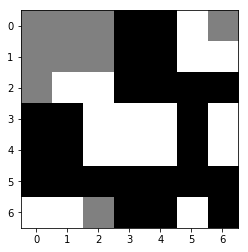

((6, 1), (6, 2)): n_v:  9845 q_all:-0.027730 q:-0.110013 q_m:+0.020000 p:0.689487
((6, 0), (6, 2)): n_v:  3652 q_all:-0.030659 q:-0.111180 q_m:-0.000000 p:0.273566
((2, 1), (1, 2)): n_v:   273 q_all:-0.033949 q:-0.101617 q_m:-0.020000 p:0.021754
((2, 1), (0, 2)): n_v:    16 q_all:-0.159989 q:-0.187908 q_m:-0.080000 p:0.004725
((4, 4), (6, 2)): n_v:    10 q_all:-0.120837 q:-0.189951 q_m:-0.000000 p:0.002331
((4, 3), (6, 2)): n_v:     6 q_all:-0.114282 q:-0.127892 q_m:-0.000000 p:0.001122
((4, 2), (6, 2)): n_v:     3 q_all:-0.144708 q:-0.197444 q_m:-0.000000 p:0.000974
((3, 3), (1, 2)): n_v:     2 q_all:-0.139977 q:-0.113326 q_m:-0.040000 p:0.000383
((3, 4), (1, 2)): n_v:     2 q_all:-0.110321 q:-0.139770 q_m:-0.040000 p:0.000441
((4, 2), (2, 0)): n_v:     1 q_all:-0.188524 q:-0.203715 q_m:-0.080000 p:0.000504
((2, 2), (0, 2)): n_v:     1 q_all:-0.165912 q:-0.167930 q_m:-0.080000 p:0.000344
((2, 2), (1, 0)): n_v:     0 q_all:-0.187765 q:-0.206275 q_m:-0.160000 p:0.000000
((2, 1), (2, 0))

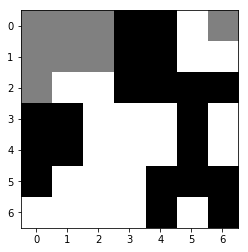

((0, 3), (1, 2)): n_v:  6988 q_all:+0.075374 q:-0.002046 q_m:+0.080000 p:0.165494
((0, 4), (0, 6)): n_v:  2877 q_all:+0.037794 q:+0.021994 q_m:+0.100000 p:0.182881
((2, 6), (0, 6)): n_v:   828 q_all:+0.022065 q:-0.019239 q_m:+0.100000 p:0.078842
((3, 0), (1, 2)): n_v:   183 q_all:-0.006323 q:-0.063469 q_m:+0.060000 p:0.027956
((0, 4), (1, 2)): n_v:   174 q_all:-0.015386 q:-0.081289 q_m:+0.060000 p:0.029751
((3, 0), (1, 1)): n_v:   147 q_all:-0.039957 q:-0.109942 q_m:+0.060000 p:0.031352
((3, 1), (1, 2)): n_v:    89 q_all:-0.014677 q:-0.030063 q_m:+0.060000 p:0.015215
((1, 4), (0, 6)): n_v:    85 q_all:+0.029716 q:-0.027059 q_m:+0.100000 p:0.006834
((0, 3), (1, 1)): n_v:    74 q_all:-0.027832 q:-0.084312 q_m:+0.060000 p:0.014476
((2, 3), (1, 1)): n_v:    24 q_all:-0.019613 q:-0.065788 q_m:+0.060000 p:0.004315
((1, 3), (1, 1)): n_v:    19 q_all:-0.017479 q:-0.035858 q_m:+0.060000 p:0.003424
((3, 0), (2, 0)): n_v:    17 q_all:-0.041717 q:-0.099262 q_m:+0.040000 p:0.003643
((3, 1), (1, 1))

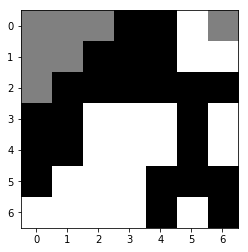

((0, 5), (0, 6)): n_v:  6525 q_all:+0.019073 q:-0.133211 q_m:-0.060000 p:0.026465
((3, 2), (1, 1)): n_v:  2163 q_all:-0.084877 q:-0.086031 q_m:+0.040000 p:0.349078
((3, 3), (1, 1)): n_v:  1341 q_all:-0.106913 q:-0.039766 q_m:+0.040000 p:0.287255
((3, 2), (2, 0)): n_v:   794 q_all:-0.093219 q:-0.110057 q_m:+0.040000 p:0.143985
((4, 2), (2, 0)): n_v:   236 q_all:-0.181831 q:-0.182307 q_m:+0.040000 p:0.087736
((3, 2), (1, 0)): n_v:    31 q_all:-0.160720 q:-0.188044 q_m:-0.040000 p:0.010560
-1 's turn
one move takes time(s):  0.3272435665130615


((2, 1), (1, 0)): n_v:  7496 q_all:+0.058083 q:-0.058304 q_m:+0.080000 p:0.268564
((1, 2), (1, 1)): n_v:  1580 q_all:-0.005690 q:-0.042091 q_m:+0.080000 p:0.118873
((2, 1), (2, 0)): n_v:   540 q_all:-0.022019 q:-0.047716 q_m:+0.080000 p:0.062421
((1, 2), (0, 1)): n_v:   500 q_all:-0.018662 q:-0.042413 q_m:+0.080000 p:0.053784
((0, 3), (0, 2)): n_v:   403 q_all:-0.010560 q:-0.025957 q_m:+0.080000 p:0.035187
((0, 3), (1, 1)): n_v:   393 q_all:-0.034389 q:-0.082831 q_m:+0.060000 p:0.057624
((3, 0), (1, 1)): n_v:   193 q_all:-0.030577 q:-0.072082 q_m:+0.060000 p:0.026487
((2, 3), (1, 1)): n_v:   146 q_all:-0.065438 q:-0.070110 q_m:+0.060000 p:0.032620
((1, 3), (1, 1)): n_v:    39 q_all:-0.086617 q:-0.113856 q_m:+0.060000 p:0.010835
((3, 0), (1, 0)): n_v:    35 q_all:-0.041162 q:-0.066272 q_m:+0.060000 p:0.005797
((0, 4), (0, 2)): n_v:    32 q_all:-0.033224 q:-0.086939 q_m:+0.060000 p:0.004621
((1, 2), (1, 0)): n_v:    31 q_all:-0.058238 q:-0.109582 q_m:+0.060000 p:0.006496
((3, 1), (1, 1))

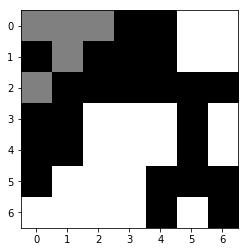

((3, 2), (1, 1)): n_v:  5633 q_all:-0.055163 q:-0.067919 q_m:+0.080000 p:0.417872
((3, 3), (1, 1)): n_v:  3032 q_all:-0.096022 q:-0.011860 q_m:+0.080000 p:0.446527
((3, 2), (2, 0)): n_v:  3019 q_all:-0.030300 q:-0.042418 q_m:+0.080000 p:0.089692
((4, 2), (2, 0)): n_v:   224 q_all:-0.126085 q:-0.103751 q_m:+0.080000 p:0.045186
-1 's turn
one move takes time(s):  0.4586191177368164


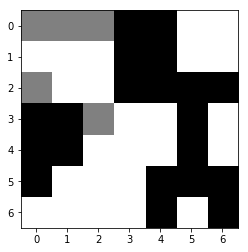

((2, 3), (3, 2)): n_v:  6549 q_all:+0.063134 q:-0.039183 q_m:+0.140000 p:0.307576
((4, 0), (3, 2)): n_v:  2813 q_all:+0.084136 q:-0.056430 q_m:+0.120000 p:0.017490
((5, 0), (3, 2)): n_v:   324 q_all:+0.080544 q:-0.024627 q_m:+0.120000 p:0.004276
((1, 3), (3, 2)): n_v:    81 q_all:+0.017152 q:-0.042253 q_m:+0.120000 p:0.010489
((3, 0), (3, 2)): n_v:    56 q_all:+0.048152 q:-0.060826 q_m:+0.120000 p:0.004229
((5, 4), (3, 2)): n_v:    37 q_all:+0.053786 q:-0.106029 q_m:+0.120000 p:0.002400
((4, 0), (2, 0)): n_v:    12 q_all:+0.027880 q:-0.078008 q_m:+0.040000 p:0.001005
((1, 4), (3, 2)): n_v:     9 q_all:-0.005264 q:-0.082079 q_m:+0.120000 p:0.001507
((3, 0), (2, 0)): n_v:     8 q_all:-0.039231 q:-0.076662 q_m:+0.060000 p:0.001954
((2, 4), (3, 2)): n_v:     5 q_all:+0.002523 q:-0.074370 q_m:+0.120000 p:0.000791
((0, 3), (0, 1)): n_v:     2 q_all:+0.020085 q:-0.117559 q_m:+0.040000 p:0.000292
((2, 3), (0, 1)): n_v:     2 q_all:+0.035489 q:-0.123520 q_m:+0.040000 p:0.000254
((4, 1), (2, 0))

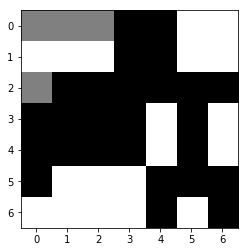

((1, 0), (2, 0)): n_v:  4702 q_all:-0.062228 q:-0.163906 q_m:-0.000000 p:0.450313
((1, 2), (2, 0)): n_v:  3952 q_all:-0.009442 q:-0.189962 q_m:-0.020000 p:0.023213
((1, 0), (0, 2)): n_v:   283 q_all:-0.037644 q:-0.241531 q_m:-0.060000 p:0.012180
((1, 1), (0, 2)): n_v:     4 q_all:-0.239260 q:-0.485375 q_m:-0.040000 p:0.002163
((1, 0), (0, 1)): n_v:     0 q_all:-0.401616 q:-0.589360 q_m:-0.120000 p:0.000030
((1, 2), (0, 0)): n_v:     0 q_all:-0.459926 q:-0.673210 q_m:-0.140000 p:0.000016
((1, 0), (0, 0)): n_v:     0 q_all:-0.510212 q:-0.770353 q_m:-0.120000 p:0.000001
-1 's turn
one move takes time(s):  0.34653496742248535


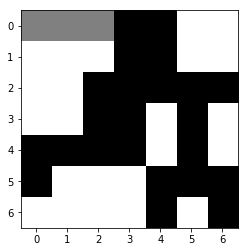

((0, 3), (0, 1)): n_v:  6535 q_all:+0.132459 q:-0.049967 q_m:+0.120000 p:0.484017
((0, 3), (0, 2)): n_v:   422 q_all:+0.002444 q:-0.060114 q_m:+0.100000 p:0.142300
((1, 3), (0, 1)): n_v:   415 q_all:+0.047316 q:+0.050560 q_m:+0.120000 p:0.102132
((2, 3), (0, 1)): n_v:   185 q_all:-0.001220 q:-0.053201 q_m:+0.120000 p:0.063774
((2, 2), (0, 1)): n_v:   155 q_all:-0.007205 q:-0.166357 q_m:+0.120000 p:0.055742
((2, 2), (0, 0)): n_v:    34 q_all:-0.183629 q:-0.520921 q_m:+0.080000 p:0.024390
((0, 4), (0, 2)): n_v:    32 q_all:-0.025770 q:-0.117512 q_m:+0.080000 p:0.012847
((2, 3), (0, 2)): n_v:     7 q_all:-0.133418 q:-0.193149 q_m:+0.080000 p:0.004843
((2, 2), (0, 2)): n_v:     4 q_all:-0.201292 q:-0.350431 q_m:+0.080000 p:0.003366
((1, 4), (0, 2)): n_v:     4 q_all:-0.157560 q:-0.236825 q_m:+0.080000 p:0.003065
((2, 4), (0, 2)): n_v:     2 q_all:-0.090096 q:-0.168304 q_m:+0.080000 p:0.001310
1 's turn
one move takes time(s):  0.26868486404418945


((0, 5), (0, 3)): n_v:  4758 q_all:-0.170160 q:-0.135699 q_m:+0.040000 p:0.201241
((2, 0), (0, 2)): n_v:  2320 q_all:-0.249215 q:-0.239441 q_m:+0.040000 p:0.439618
((2, 0), (0, 0)): n_v:  1851 q_all:-0.178709 q:-0.239659 q_m:-0.000000 p:0.107992
((2, 1), (0, 3)): n_v:   714 q_all:-0.186530 q:-0.551639 q_m:+0.040000 p:0.052008
((2, 1), (0, 2)): n_v:   610 q_all:-0.269582 q:-0.514616 q_m:+0.040000 p:0.138884
((1, 5), (0, 3)): n_v:   216 q_all:-0.268568 q:-0.073616 q_m:+0.040000 p:0.048722
((2, 1), (0, 0)): n_v:    27 q_all:-0.340956 q:-0.186177 q_m:-0.000000 p:0.009805
-1 's turn
one move takes time(s):  0.17920494079589844


((0, 1), (0, 2)): n_v:  8136 q_all:+0.271059 q:+0.126093 q_m:+0.100000 p:0.328770
((1, 0), (0, 2)): n_v:   603 q_all:+0.040866 q:-0.017835 q_m:+0.080000 p:0.286988
((2, 3), (0, 5)): n_v:   474 q_all:+0.158304 q:+0.155760 q_m:+0.160000 p:0.024815
((2, 6), (0, 5)): n_v:   254 q_all:+0.138221 q:+0.106282 q_m:+0.160000 p:0.031404
((2, 5), (0, 5)): n_v:    44 q_all:+0.119289 q:+0.058222 q_m:+0.160000 p:0.008555
((2, 4), (0, 5)): n_v:    19 q_all:+0.118887 q:+0.057218 q_m:+0.160000 p:0.003758
((2, 3), (0, 2)): n_v:     7 q_all:+0.017342 q:-0.076644 q_m:+0.080000 p:0.004161
((2, 4), (0, 2)): n_v:     7 q_all:+0.021975 q:-0.065062 q_m:+0.080000 p:0.004334
((2, 2), (0, 2)): n_v:     3 q_all:+0.007873 q:-0.123713 q_m:+0.080000 p:0.001842
((2, 2), (0, 0)): n_v:     0 q_all:-0.184215 q:-0.280358 q_m:-0.040000 p:0.000009
((0, 1), (0, 0)): n_v:     0 q_all:-0.141649 q:-0.222748 q_m:-0.020000 p:0.000105
1 's turn
one move takes time(s):  0.19780254364013672


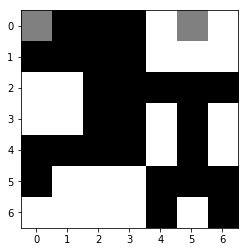

((2, 0), (0, 0)): n_v: 11539 q_all:-0.279936 q:-0.503446 q_m:+0.020000 p:0.886375
((2, 1), (0, 0)): n_v:    91 q_all:-0.461534 q:-0.606470 q_m:+0.020000 p:0.035744
((0, 4), (0, 5)): n_v:    44 q_all:-0.564607 q:-0.801776 q_m:-0.080000 p:0.024616
-1 's turn
one move takes time(s):  0.1872706413269043


((4, 0), (2, 0)): n_v: 11365 q_all:+0.373523 q:+0.485680 q_m:+0.180000 p:0.202121
((2, 6), (0, 5)): n_v:  1009 q_all:+0.294631 q:+0.186468 q_m:+0.180000 p:0.069624
((0, 2), (2, 0)): n_v:   915 q_all:+0.238258 q:+0.299678 q_m:+0.180000 p:0.159341
((0, 3), (0, 5)): n_v:   794 q_all:+0.175291 q:+0.095889 q_m:+0.180000 p:0.231124
((2, 5), (0, 5)): n_v:   257 q_all:+0.096625 q:+0.109901 q_m:+0.180000 p:0.112723
((4, 1), (2, 0)): n_v:   115 q_all:+0.192841 q:+0.282873 q_m:+0.180000 p:0.029959
((1, 3), (0, 5)): n_v:    78 q_all:+0.101111 q:+0.134864 q_m:+0.180000 p:0.033729
((4, 2), (2, 0)): n_v:    77 q_all:+0.140922 q:-0.018415 q_m:+0.180000 p:0.027462
((2, 3), (0, 5)): n_v:    77 q_all:+0.097198 q:+0.097606 q_m:+0.180000 p:0.033737
((1, 2), (2, 0)): n_v:    76 q_all:+0.027015 q:-0.105777 q_m:+0.180000 p:0.042720
((3, 2), (2, 0)): n_v:    76 q_all:+0.181735 q:+0.286002 q_m:+0.180000 p:0.021049
((2, 2), (2, 0)): n_v:    58 q_all:+0.133362 q:+0.134314 q_m:+0.180000 p:0.021367
((2, 4), (0, 5))

((6, 0), (4, 0)): n_v: 10703 q_all:-0.252769 q:-0.383084 q_m:-0.020000 p:0.647573
((6, 2), (4, 0)): n_v:  1299 q_all:-0.354219 q:-0.386202 q_m:-0.020000 p:0.104324
((6, 1), (4, 0)): n_v:   615 q_all:-0.413722 q:-0.815495 q_m:-0.020000 p:0.118179
((5, 1), (4, 0)): n_v:   330 q_all:-0.490906 q:-0.832656 q_m:-0.000000 p:0.111325
((5, 2), (4, 0)): n_v:    78 q_all:-0.430924 q:-0.791144 q_m:-0.020000 p:0.017689
((0, 4), (0, 5)): n_v:     0 q_all:-0.610967 q:-0.911612 q_m:-0.160000 p:0.000343
-1 's turn
one move takes time(s):  0.2144463062286377


((0, 3), (0, 5)): n_v:  6207 q_all:+0.394975 q:+0.495318 q_m:+0.228000 p:0.271158
((2, 6), (0, 5)): n_v:  4501 q_all:+0.286228 q:+0.683438 q_m:+0.228000 p:0.288407
((2, 5), (0, 5)): n_v:  1444 q_all:+0.276171 q:+0.726566 q_m:+0.228000 p:0.120003
((2, 3), (0, 5)): n_v:   669 q_all:+0.181706 q:+0.492982 q_m:+0.228000 p:0.177944
((2, 4), (0, 5)): n_v:   270 q_all:+0.198558 q:+0.540815 q_m:+0.228000 p:0.063067
((1, 3), (0, 5)): n_v:   219 q_all:+0.139116 q:+0.410482 q_m:+0.228000 p:0.076175
((4, 2), (6, 0)): n_v:    10 q_all:+0.165652 q:+0.081866 q_m:+0.140000 p:0.003126
1 's turn
one move takes time(s):  0.14272689819335938


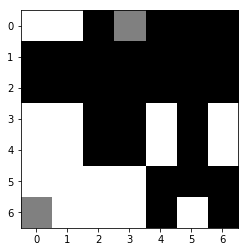

((0, 1), (0, 3)): n_v: 10666 q_all:-0.492989 q:-0.118263 q_m:-0.020000 p:0.994526
((6, 2), (6, 0)): n_v:     7 q_all:-0.555636 q:-0.902469 q_m:-0.228000 p:0.001533
((4, 0), (6, 0)): n_v:     5 q_all:-0.652443 q:-0.958426 q_m:-0.228000 p:0.002112
((5, 2), (6, 0)): n_v:     0 q_all:-0.682096 q:-0.984827 q_m:-0.228000 p:0.000098
((5, 0), (6, 0)): n_v:     0 q_all:-0.674303 q:-0.990504 q_m:-0.200000 p:0.000411
((4, 1), (6, 0)): n_v:     0 q_all:-0.682086 q:-0.984810 q_m:-0.228000 p:0.000093
-1 's turn
one move takes time(s):  0.14621210098266602


((1, 0), (0, 1)): n_v: 14923 q_all:+0.501028 q:+0.632931 q_m:+0.160000 p:0.404445
((2, 0), (0, 1)): n_v:    41 q_all:+0.078071 q:+0.143235 q_m:+0.140000 p:0.028848
((2, 1), (0, 1)): n_v:    14 q_all:+0.274997 q:+0.462853 q_m:+0.140000 p:0.005091
((2, 3), (0, 1)): n_v:     7 q_all:+0.060110 q:+0.088773 q_m:+0.140000 p:0.004944
((2, 2), (0, 1)): n_v:     1 q_all:-0.198085 q:+0.096487 q_m:+0.140000 p:0.000754
((4, 2), (6, 0)): n_v:     0 q_all:-0.174254 q:-0.383756 q_m:+0.140000 p:0.000532
1 's turn
one move takes time(s):  0.13388705253601074


((6, 2), (6, 0)): n_v: 12626 q_all:-0.555074 q:-0.867360 q_m:-0.160000 p:0.451605
((4, 0), (6, 0)): n_v:  2172 q_all:-0.670685 q:-0.944370 q_m:-0.160000 p:0.433350
((5, 2), (6, 0)): n_v:    90 q_all:-0.698876 q:-0.974481 q_m:-0.160000 p:0.021465
((4, 1), (6, 0)): n_v:    61 q_all:-0.700076 q:-0.975243 q_m:-0.160000 p:0.014535
((5, 0), (6, 0)): n_v:    30 q_all:-1.000000 q:+5.000000 q_m:-0.140000 p:0.020080
-1 's turn
one move takes time(s):  0.11565995216369629


((6, 4), (6, 2)): n_v: 11338 q_all:+0.763568 q:+0.438937 q_m:+0.424000 p:0.554091
((4, 3), (6, 2)): n_v:  2051 q_all:+0.503053 q:+0.529720 q_m:+0.424000 p:0.196235
((4, 2), (6, 2)): n_v:   683 q_all:+0.459287 q:+0.482812 q_m:+0.424000 p:0.129014
((5, 4), (6, 2)): n_v:   512 q_all:+0.438592 q:+0.448320 q_m:+0.424000 p:0.120489
1 's turn
one move takes time(s):  0.08589506149291992


((4, 6), (6, 4)): n_v: 11935 q_all:-0.892123 q:-0.930167 q_m:-0.200000 p:0.700822
((4, 4), (6, 4)): n_v:  1294 q_all:-0.903262 q:-0.977013 q_m:-0.200000 p:0.098552
((6, 5), (6, 4)): n_v:   872 q_all:-1.000000 q:+5.000000 q_m:-0.180000 p:0.198577
-1 's turn


This is a random move


one move takes time(s):  0.06513619422912598


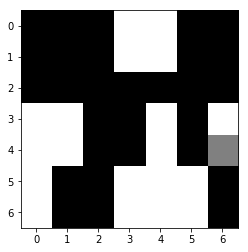

((3, 5), (4, 6)): n_v: 13378 q_all:+1.000000 q:+5.000000 q_m:+0.340000 p:0.337671
((6, 6), (4, 6)): n_v:     3 q_all:+0.519612 q:+0.568413 q_m:+0.312000 p:0.002856
((2, 5), (4, 6)): n_v:     0 q_all:+0.381860 q:+0.428434 q_m:+0.312000 p:0.000027
((2, 4), (4, 6)): n_v:     0 q_all:+0.387951 q:+0.438585 q_m:+0.312000 p:0.000020
((2, 6), (4, 6)): n_v:     0 q_all:+0.335803 q:+0.351671 q_m:+0.312000 p:0.000325
this self play has 83 steps, time elapsed 113.6349139213562
winner is -1.0
episode 37 finished
episode 38 now start
it seems the reset did nothing
reset successful
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.8713397979736328
1 's turn


This is a random move


one move takes time(s):  0.8885307312011719
-1 's turn
one move takes time(s):  1.2678709030151367
1 's turn


This is a random move


one move takes time(s):  1.6353340148925781
-1 's turn
due to rollout lim, final rollout times:  1423 time elapsed:  2.0035204887390137



due to rollout lim, final rollout times:  1498 time elapsed:  2.005078077316284
one move takes time(s):  2.0065054893493652
1 's turn
due to rollout lim, final rollout times:  3227 time elapsed:  2.0000317096710205
one move takes time(s):  2.001295328140259
-1 's turn
one move takes time(s):  1.2063488960266113
1 's turn


This is a random move


one move takes time(s):  0.996016263961792
-1 's turn
due to rollout lim, final rollout times:  2429 time elapsed:  2.0001015663146973
one move takes time(s):  2.0015323162078857
1 's turn
one move takes time(s):  1.004115104675293
-1 's turn
one move takes time(s):  0.8631937503814697
1 's turn
one move takes time(s):  0.8506724834442139
-1 's turn
one move takes time(s):  0.726794958114624
1 's turn
one move takes time(s):  1.469149112701416
-1 's turn
one move takes time(s):  1.2187259197235107
1 's turn
one move takes time(s):  0.7150530815124512
-1 's turn
one move takes time(s):  0.5593109130859375
1 's turn
one move takes time(s):  0.36

one move takes time(s):  1.8747591972351074
-1 's turn
due to rollout lim, final rollout times:  2643 time elapsed:  2.0000038146972656
one move takes time(s):  2.001371145248413
1 's turn
due to rollout lim, final rollout times:  4691 time elapsed:  2.000018358230591
one move takes time(s):  2.00156831741333
-1 's turn
one move takes time(s):  1.2112715244293213
1 's turn
one move takes time(s):  1.529224157333374
-1 's turn
one move takes time(s):  1.2497234344482422
1 's turn
due to rollout lim, final rollout times:  4657 time elapsed:  2.000058174133301
one move takes time(s):  2.0011703968048096
-1 's turn
one move takes time(s):  1.2434382438659668
1 's turn


This is a random move


one move takes time(s):  1.3776779174804688
-1 's turn
one move takes time(s):  1.0293035507202148
1 's turn
one move takes time(s):  0.7238109111785889
-1 's turn
one move takes time(s):  1.1192595958709717
1 's turn
one move takes time(s):  0.979438304901123
-1 's turn


This is a random move


one

due to rollout lim, final rollout times:  1001 time elapsed:  4.291612863540649
one move takes time(s):  4.2930285930633545
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.9037036895751953
one move takes time(s):  3.9052226543426514
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.7993786334991455


This is a random move


one move takes time(s):  2.8008389472961426
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  6.035998106002808
one move takes time(s):  6.038322925567627
-1 's turn
due to rollout lim, final rollout times:  1321 time elapsed:  2.0005125999450684
one move takes time(s):  2.0021417140960693
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.0418033599853516
one move takes time(s):  3.0436551570892334
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.0637760162353516
one move takes time(s):  2.065032482147217
1 's turn
due to rollout lim, final roll

this round has steps: 62, time taken: 3.1458804607391357, 


self wins? True



round: 26
it seems the reset did nothing
reset successful
this game start with 45 space left
this round has steps: 67, time taken: 3.682973623275757, 


self wins? True



round: 27
it seems the reset did nothing
reset successful
this game start with 45 space left
this round has steps: 56, time taken: 2.3394877910614014, 


self wins? True



round: 28
it seems the reset did nothing
reset successful
this game start with 45 space left
this round has steps: 64, time taken: 3.2917518615722656, 


self wins? False



round: 29
it seems the reset did nothing
reset successful
this game start with 45 space left
this round has steps: 66, time taken: 2.790959596633911, 


self wins? True



round: 30
it seems the reset did nothing
reset successful
this game start with 45 space left
this round has steps: 71, time taken: 3.590723752975464, 


self wins? True



round: 31
it seems the reset did nothing
reset successful

due to rollout lim, final rollout times:  1053 time elapsed:  2.012491464614868
one move takes time(s):  2.013944625854492
-1 's turn
due to rollout lim, final rollout times:  3735 time elapsed:  2.0078251361846924
one move takes time(s):  2.009005308151245
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.6970036029815674
one move takes time(s):  2.6987664699554443
-1 's turn
due to rollout lim, final rollout times:  1610 time elapsed:  2.0025229454040527
one move takes time(s):  2.0036723613739014
1 's turn
due to rollout lim, final rollout times:  1595 time elapsed:  2.0150227546691895
one move takes time(s):  2.016427755355835
-1 's turn
due to rollout lim, final rollout times:  1575 time elapsed:  2.010361909866333


This is a random move


one move takes time(s):  2.0116806030273438
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.1928317546844482
one move takes time(s):  2.19488263130188
-1 's turn
due to rollout lim, final rollou

one move takes time(s):  1.7290284633636475
-1 's turn
due to rollout lim, final rollout times:  1823 time elapsed:  2.0077781677246094
one move takes time(s):  2.0090835094451904
1 's turn
due to rollout lim, final rollout times:  3059 time elapsed:  2.0002729892730713
one move takes time(s):  2.001498222351074
-1 's turn
due to rollout lim, final rollout times:  1234 time elapsed:  2.0054798126220703
one move takes time(s):  2.007105588912964
1 's turn
due to rollout lim, final rollout times:  1809 time elapsed:  2.00020170211792


This is a random move


one move takes time(s):  2.001608371734619
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.229114055633545
one move takes time(s):  2.2310986518859863
1 's turn
due to rollout lim, final rollout times:  2486 time elapsed:  2.010507822036743
one move takes time(s):  2.012360095977783
-1 's turn
due to rollout lim, final rollout times:  2388 time elapsed:  2.009625196456909
one move takes time(s):  2.0115377

Epoch 2/64
11900/11900 [==============================] - 1s 109us/step - loss: 1.9682 - activation_101_loss: 1.9349 - dense_51_loss: 0.0063 - val_loss: 2.2811 - val_activation_101_loss: 2.2479 - val_dense_51_loss: 0.0061
Epoch 3/64
11900/11900 [==============================] - 1s 108us/step - loss: 1.9467 - activation_101_loss: 1.9137 - dense_51_loss: 0.0059 - val_loss: 2.2716 - val_activation_101_loss: 2.2386 - val_dense_51_loss: 0.0059
Epoch 4/64
11900/11900 [==============================] - 1s 106us/step - loss: 1.9293 - activation_101_loss: 1.8967 - dense_51_loss: 0.0055 - val_loss: 2.2657 - val_activation_101_loss: 2.2321 - val_dense_51_loss: 0.0065
Epoch 5/64
11900/11900 [==============================] - 1s 106us/step - loss: 1.9160 - activation_101_loss: 1.8836 - dense_51_loss: 0.0053 - val_loss: 2.2533 - val_activation_101_loss: 2.2203 - val_dense_51_loss: 0.0060
Epoch 6/64
11900/11900 [==============================] - 1s 105us/step - loss: 1.9041 - activation_101_loss: 1.

due to rollout lim, final rollout times:  1001 time elapsed:  2.5558526515960693
one move takes time(s):  2.5572633743286133
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.009270668029785
one move takes time(s):  3.0106170177459717
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.276556968688965


This is a random move


one move takes time(s):  3.2779042720794678
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.6602213382720947
one move takes time(s):  3.6615819931030273
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.5472347736358643
one move takes time(s):  3.548886775970459
-1 's turn
due to rollout lim, final rollout times:  1212 time elapsed:  2.0000505447387695
one move takes time(s):  2.0014901161193848
1 's turn
due to rollout lim, final rollout times:  2068 time elapsed:  2.0001370906829834
one move takes time(s):  2.00148868560791
-1 's turn
due to rollout lim, final roll

one move takes time(s):  0.8770136833190918
-1 's turn
one move takes time(s):  1.5436499118804932
1 's turn
due to rollout lim, final rollout times:  4809 time elapsed:  2.000035524368286
one move takes time(s):  2.0012969970703125
-1 's turn
due to rollout lim, final rollout times:  4643 time elapsed:  2.0049712657928467
one move takes time(s):  2.0062999725341797
1 's turn
due to rollout lim, final rollout times:  3223 time elapsed:  2.0000643730163574
one move takes time(s):  2.0017056465148926
-1 's turn
due to rollout lim, final rollout times:  2191 time elapsed:  2.00164794921875
one move takes time(s):  2.0029969215393066
1 's turn
due to rollout lim, final rollout times:  4332 time elapsed:  2.001422882080078
one move takes time(s):  2.002885580062866
-1 's turn
due to rollout lim, final rollout times:  3195 time elapsed:  2.009197473526001
one move takes time(s):  2.0105161666870117
1 's turn
due to rollout lim, final rollout times:  3947 time elapsed:  2.0000176429748535
one

due to rollout lim, final rollout times:  1693 time elapsed:  2.0001165866851807
one move takes time(s):  2.0013668537139893
-1 's turn
due to rollout lim, final rollout times:  3720 time elapsed:  2.000014066696167


This is a random move


one move takes time(s):  2.0013978481292725
1 's turn
due to rollout lim, final rollout times:  1176 time elapsed:  2.000309705734253
one move takes time(s):  2.0016729831695557
-1 's turn
due to rollout lim, final rollout times:  1074 time elapsed:  2.0129337310791016
one move takes time(s):  2.014261484146118
1 's turn
due to rollout lim, final rollout times:  1013 time elapsed:  2.0001301765441895
one move takes time(s):  2.0014891624450684
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.9001076221466064
one move takes time(s):  2.9014246463775635
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.975109815597534
one move takes time(s):  3.9766485691070557
-1 's turn
due to rollout lim, final rol

due to rollout lim, final rollout times:  1738 time elapsed:  2.0079596042633057
one move takes time(s):  2.009258985519409
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.856476306915283
one move takes time(s):  2.857757806777954
1 's turn
due to rollout lim, final rollout times:  2437 time elapsed:  2.0000662803649902
one move takes time(s):  2.001331329345703
-1 's turn
due to rollout lim, final rollout times:  1171 time elapsed:  2.002265691757202
one move takes time(s):  2.0035505294799805
1 's turn
due to rollout lim, final rollout times:  1910 time elapsed:  2.00136661529541
one move takes time(s):  2.002652406692505
-1 's turn
due to rollout lim, final rollout times:  3382 time elapsed:  2.0111401081085205
one move takes time(s):  2.012672185897827
1 's turn
one move takes time(s):  1.97999906539917
-1 's turn
due to rollout lim, final rollout times:  3410 time elapsed:  2.007258415222168
one move takes time(s):  2.008544683456421
1 's turn
due to rol

due to rollout lim, final rollout times:  1001 time elapsed:  2.0307869911193848
one move takes time(s):  2.032444953918457
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.028585195541382
one move takes time(s):  2.030308485031128
-1 's turn
due to rollout lim, final rollout times:  1669 time elapsed:  2.007143020629883
one move takes time(s):  2.0084798336029053
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.1598870754241943
one move takes time(s):  2.1612002849578857
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.6268811225891113
one move takes time(s):  2.6285030841827393
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.2983124256134033
one move takes time(s):  2.299910545349121
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.3371660709381104
one move takes time(s):  2.3389594554901123
1 's turn
due to rollout lim, final rollout times:  1001 time elaps

one move takes time(s):  1.8704724311828613
-1 's turn
due to rollout lim, final rollout times:  3796 time elapsed:  2.0000317096710205


This is a random move


one move takes time(s):  2.0014498233795166
1 's turn
due to rollout lim, final rollout times:  2527 time elapsed:  2.0144996643066406
one move takes time(s):  2.0158073902130127
-1 's turn
due to rollout lim, final rollout times:  2107 time elapsed:  2.000117778778076
one move takes time(s):  2.0012428760528564
1 's turn
one move takes time(s):  1.6747031211853027
-1 's turn
due to rollout lim, final rollout times:  3141 time elapsed:  2.007601022720337
one move takes time(s):  2.0093510150909424
1 's turn
one move takes time(s):  1.9913690090179443
-1 's turn
due to rollout lim, final rollout times:  4310 time elapsed:  2.002371311187744
one move takes time(s):  2.0035526752471924
1 's turn
due to rollout lim, final rollout times:  2745 time elapsed:  2.003099203109741
one move takes time(s):  2.004868745803833
-1 's turn
du

9288/9288 [==============================] - 1s 107us/step - loss: 1.8286 - activation_101_loss: 1.7975 - dense_51_loss: 0.0039 - val_loss: 2.1226 - val_activation_101_loss: 2.0879 - val_dense_51_loss: 0.0075
Epoch 7/64
9288/9288 [==============================] - 1s 108us/step - loss: 1.8206 - activation_101_loss: 1.7895 - dense_51_loss: 0.0039 - val_loss: 2.1266 - val_activation_101_loss: 2.0911 - val_dense_51_loss: 0.0084
Epoch 8/64
9288/9288 [==============================] - 1s 106us/step - loss: 1.8117 - activation_101_loss: 1.7809 - dense_51_loss: 0.0037 - val_loss: 2.1279 - val_activation_101_loss: 2.0926 - val_dense_51_loss: 0.0082
Epoch 9/64
9288/9288 [==============================] - 1s 107us/step - loss: 1.8058 - activation_101_loss: 1.7752 - dense_51_loss: 0.0034 - val_loss: 2.1323 - val_activation_101_loss: 2.0963 - val_dense_51_loss: 0.0088
Epoch 10/64
9288/9288 [==============================] - 1s 106us/step - loss: 1.8002 - activation_101_loss: 1.7697 - dense_51_loss



This is a random move


one move takes time(s):  0.3236510753631592
1 's turn
one move takes time(s):  0.22718524932861328
-1 's turn
one move takes time(s):  0.27327752113342285
1 's turn


This is a random move


one move takes time(s):  0.15894532203674316
-1 's turn
one move takes time(s):  0.14738869667053223
1 's turn
one move takes time(s):  0.17791271209716797
-1 's turn
one move takes time(s):  0.2198479175567627
1 's turn


This is a random move


one move takes time(s):  0.1536858081817627
this self play has 80 steps, time elapsed 106.10388088226318
winner is 1.0
episode 49 finished
episode 50 now start
it seems the reset did nothing
reset successful
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.9422204494476318
1 's turn


This is a random move


one move takes time(s):  1.10247802734375
-1 's turn


This is a random move


one move takes time(s):  1.452831506729126
1 's turn


This is a random move


one move takes t



This is a random move


one move takes time(s):  1.9727866649627686
1 's turn
due to rollout lim, final rollout times:  3098 time elapsed:  2.0095486640930176
one move takes time(s):  2.010793924331665
-1 's turn
due to rollout lim, final rollout times:  1793 time elapsed:  2.00398588180542
one move takes time(s):  2.0052490234375
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.3949148654937744


This is a random move


one move takes time(s):  2.3962385654449463
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.6894288063049316
one move takes time(s):  2.6910512447357178
1 's turn
due to rollout lim, final rollout times:  2115 time elapsed:  2.009809732437134


This is a random move


one move takes time(s):  2.011101722717285
-1 's turn
one move takes time(s):  1.3096556663513184
1 's turn
one move takes time(s):  1.9550695419311523
-1 's turn
due to rollout lim, final rollout times:  2501 time elapsed:  2.007500410079956
one move 



This is a random move


one move takes time(s):  1.9063475131988525
1 's turn
due to rollout lim, final rollout times:  3768 time elapsed:  2.0060765743255615


This is a random move


one move takes time(s):  2.007617473602295
-1 's turn
due to rollout lim, final rollout times:  3531 time elapsed:  2.000006914138794
one move takes time(s):  2.0012147426605225
1 's turn
due to rollout lim, final rollout times:  1202 time elapsed:  2.0050477981567383
one move takes time(s):  2.0062193870544434
-1 's turn
due to rollout lim, final rollout times:  1949 time elapsed:  2.000033140182495
one move takes time(s):  2.0012755393981934
1 's turn
due to rollout lim, final rollout times:  3882 time elapsed:  2.004685878753662
one move takes time(s):  2.0057778358459473
-1 's turn
due to time lim, final rollout times:  1775 time elapsed:  180.9292652606964
one move takes time(s):  180.95379614830017
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.0981485843658447
one move

due to rollout lim, final rollout times:  1800 time elapsed:  2.0098159313201904


This is a random move


one move takes time(s):  2.0120677947998047
1 's turn
due to rollout lim, final rollout times:  1320 time elapsed:  2.0001111030578613
one move takes time(s):  2.0020511150360107
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.5962483882904053
one move takes time(s):  2.5980260372161865
1 's turn
due to rollout lim, final rollout times:  1942 time elapsed:  2.0001189708709717
one move takes time(s):  2.001729965209961
-1 's turn
due to rollout lim, final rollout times:  1681 time elapsed:  2.009565591812134
one move takes time(s):  2.010848045349121
1 's turn
one move takes time(s):  1.8513472080230713
-1 's turn
due to rollout lim, final rollout times:  3156 time elapsed:  2.0071284770965576
one move takes time(s):  2.0083866119384766
1 's turn
due to rollout lim, final rollout times:  2814 time elapsed:  2.000066041946411
one move takes time(s):  2.001

one move takes time(s):  1.9708175659179688
1 's turn
one move takes time(s):  1.2341156005859375
-1 's turn
due to rollout lim, final rollout times:  4256 time elapsed:  2.000114679336548
one move takes time(s):  2.0013632774353027
1 's turn
due to rollout lim, final rollout times:  2656 time elapsed:  2.0075836181640625
one move takes time(s):  2.0089054107666016
-1 's turn
due to rollout lim, final rollout times:  4455 time elapsed:  2.001148223876953


This is a random move


one move takes time(s):  2.0025134086608887
1 's turn
one move takes time(s):  1.9900150299072266
-1 's turn
due to rollout lim, final rollout times:  2710 time elapsed:  2.010801076889038
one move takes time(s):  2.0121991634368896
1 's turn
due to rollout lim, final rollout times:  3132 time elapsed:  2.0083110332489014
one move takes time(s):  2.0095198154449463
-1 's turn
due to rollout lim, final rollout times:  2918 time elapsed:  2.0002708435058594
one move takes time(s):  2.0015461444854736
1 's turn
o

15157/15157 [==============================] - 2s 106us/step - loss: 1.8705 - activation_101_loss: 1.8389 - dense_51_loss: 0.0044 - val_loss: 1.9405 - val_activation_101_loss: 1.8997 - val_dense_51_loss: 0.0137
Epoch 10/64
15157/15157 [==============================] - 2s 106us/step - loss: 1.8641 - activation_101_loss: 1.8327 - dense_51_loss: 0.0042 - val_loss: 1.9358 - val_activation_101_loss: 1.8962 - val_dense_51_loss: 0.0124
Epoch 11/64
15157/15157 [==============================] - 2s 104us/step - loss: 1.8584 - activation_101_loss: 1.8272 - dense_51_loss: 0.0040 - val_loss: 1.9369 - val_activation_101_loss: 1.8964 - val_dense_51_loss: 0.0133
Epoch 12/64
15157/15157 [==============================] - 2s 105us/step - loss: 1.8538 - activation_101_loss: 1.8226 - dense_51_loss: 0.0040 - val_loss: 1.9361 - val_activation_101_loss: 1.8956 - val_dense_51_loss: 0.0133
Epoch 13/64
15157/15157 [==============================] - 2s 103us/step - loss: 1.8485 - activation_101_loss: 1.8175 - 

due to rollout lim, final rollout times:  2433 time elapsed:  2.020376443862915
one move takes time(s):  2.02169132232666
1 's turn
due to rollout lim, final rollout times:  1762 time elapsed:  2.0000946521759033
one move takes time(s):  2.0013444423675537
-1 's turn
due to rollout lim, final rollout times:  1372 time elapsed:  2.0000476837158203
one move takes time(s):  2.0014047622680664
1 's turn
due to rollout lim, final rollout times:  4578 time elapsed:  2.0036261081695557
one move takes time(s):  2.0048720836639404
-1 's turn
one move takes time(s):  1.696629285812378
1 's turn
due to rollout lim, final rollout times:  4307 time elapsed:  2.0001165866851807
one move takes time(s):  2.001884937286377
-1 's turn


This is a random move


one move takes time(s):  1.9996778964996338
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.113924980163574
one move takes time(s):  3.1154041290283203
-1 's turn
due to rollout lim, final rollout times:  1001 time elapse

due to rollout lim, final rollout times:  3030 time elapsed:  2.0077247619628906
one move takes time(s):  2.008922576904297
-1 's turn
due to rollout lim, final rollout times:  2082 time elapsed:  2.004608392715454
one move takes time(s):  2.0059545040130615
1 's turn
due to rollout lim, final rollout times:  1744 time elapsed:  2.0001776218414307
one move takes time(s):  2.0013837814331055
-1 's turn
due to rollout lim, final rollout times:  4097 time elapsed:  2.002182722091675


This is a random move


one move takes time(s):  2.0036072731018066
1 's turn
due to rollout lim, final rollout times:  3215 time elapsed:  2.0000102519989014
one move takes time(s):  2.001410484313965
-1 's turn
one move takes time(s):  1.7355437278747559
1 's turn
due to rollout lim, final rollout times:  4502 time elapsed:  2.0001394748687744
one move takes time(s):  2.001485824584961
-1 's turn
due to rollout lim, final rollout times:  3825 time elapsed:  2.0039734840393066
one move takes time(s):  2.005

due to rollout lim, final rollout times:  1001 time elapsed:  2.0254037380218506
one move takes time(s):  2.026810646057129
-1 's turn
due to rollout lim, final rollout times:  1573 time elapsed:  2.0080103874206543
one move takes time(s):  2.0090434551239014
1 's turn
due to rollout lim, final rollout times:  2784 time elapsed:  2.0000388622283936
one move takes time(s):  2.0013012886047363
-1 's turn


This is a random move


one move takes time(s):  1.5349812507629395
1 's turn
one move takes time(s):  1.3054101467132568
-1 's turn
one move takes time(s):  1.9396560192108154
1 's turn
due to rollout lim, final rollout times:  3367 time elapsed:  2.0108108520507812
one move takes time(s):  2.012333869934082
-1 's turn
due to rollout lim, final rollout times:  3146 time elapsed:  2.011268377304077
one move takes time(s):  2.013076066970825
1 's turn
due to rollout lim, final rollout times:  2782 time elapsed:  2.00010347366333
one move takes time(s):  2.0012965202331543
-1 's turn
due

due to rollout lim, final rollout times:  1001 time elapsed:  2.5280838012695312
one move takes time(s):  2.528956174850464
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.827950954437256
one move takes time(s):  2.8301520347595215
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.8760733604431152
one move takes time(s):  3.8773300647735596
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.923800230026245
one move takes time(s):  3.9254496097564697
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.1491823196411133
one move takes time(s):  2.15034556388855
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.1736292839050293
one move takes time(s):  2.175204038619995
1 's turn
due to rollout lim, final rollout times:  1017 time elapsed:  2.0000393390655518
one move takes time(s):  2.0012457370758057
-1 's turn
due to time lim, final rollout times:  5 time elapsed:  1

due to rollout lim, final rollout times:  1001 time elapsed:  2.253042221069336
one move takes time(s):  2.254359245300293
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.2038516998291016
one move takes time(s):  2.2050511837005615
-1 's turn
due to rollout lim, final rollout times:  1408 time elapsed:  2.0001354217529297
one move takes time(s):  2.001725912094116
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.8333044052124023
one move takes time(s):  2.8345792293548584
-1 's turn
due to rollout lim, final rollout times:  1619 time elapsed:  2.023895263671875
one move takes time(s):  2.025172233581543
1 's turn
due to rollout lim, final rollout times:  1653 time elapsed:  2.0105128288269043
one move takes time(s):  2.012678384780884
-1 's turn
due to rollout lim, final rollout times:  3677 time elapsed:  2.000077247619629
one move takes time(s):  2.001415729522705
1 's turn
due to rollout lim, final rollout times:  4933 time elapsed:

due to rollout lim, final rollout times:  1001 time elapsed:  2.400238513946533
one move takes time(s):  2.401588201522827
1 's turn
due to rollout lim, final rollout times:  1741 time elapsed:  2.0000598430633545
one move takes time(s):  2.0012636184692383
-1 's turn
due to rollout lim, final rollout times:  1187 time elapsed:  2.007499933242798
one move takes time(s):  2.009182929992676
1 's turn
due to rollout lim, final rollout times:  4950 time elapsed:  2.0125536918640137
one move takes time(s):  2.013895273208618
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.5669658184051514
one move takes time(s):  2.5683295726776123
1 's turn
due to rollout lim, final rollout times:  1064 time elapsed:  2.008946657180786


This is a random move


one move takes time(s):  2.0103511810302734
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.1789307594299316
one move takes time(s):  2.1803269386291504
1 's turn
due to rollout lim, final rollou

13362/13362 [==============================] - 2s 145us/step - loss: 1.9943 - activation_101_loss: 1.9620 - dense_51_loss: 0.0051 - val_loss: 2.1541 - val_activation_101_loss: 2.1186 - val_dense_51_loss: 0.0083
Epoch 2/64
13362/13362 [==============================] - 1s 110us/step - loss: 1.9551 - activation_101_loss: 1.9235 - dense_51_loss: 0.0043 - val_loss: 2.1528 - val_activation_101_loss: 2.1180 - val_dense_51_loss: 0.0076
Epoch 3/64
13362/13362 [==============================] - 1s 107us/step - loss: 1.9321 - activation_101_loss: 1.9009 - dense_51_loss: 0.0040 - val_loss: 2.1549 - val_activation_101_loss: 2.1192 - val_dense_51_loss: 0.0085
Epoch 4/64
13362/13362 [==============================] - 1s 105us/step - loss: 1.9171 - activation_101_loss: 1.8860 - dense_51_loss: 0.0039 - val_loss: 2.1534 - val_activation_101_loss: 2.1182 - val_dense_51_loss: 0.0079
Epoch 5/64
13362/13362 [==============================] - 1s 106us/step - loss: 1.9054 - activation_101_loss: 1.8745 - dens

due to rollout lim, final rollout times:  1001 time elapsed:  2.6393532752990723
one move takes time(s):  2.640941858291626
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.8060314655303955
one move takes time(s):  2.807323932647705
1 's turn
due to rollout lim, final rollout times:  1381 time elapsed:  2.0039055347442627
one move takes time(s):  2.005181074142456
-1 's turn
due to rollout lim, final rollout times:  1925 time elapsed:  2.013448476791382
one move takes time(s):  2.0147228240966797
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.767366647720337
one move takes time(s):  2.768946409225464
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.221247911453247
one move takes time(s):  2.2225778102874756
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.2590572834014893
one move takes time(s):  2.260396718978882
-1 's turn
due to rollout lim, final rollout times:  4029 time elapsed

due to rollout lim, final rollout times:  1752 time elapsed:  2.0003156661987305
one move takes time(s):  2.002453088760376
-1 's turn
due to rollout lim, final rollout times:  1122 time elapsed:  2.0001659393310547
one move takes time(s):  2.0013926029205322
1 's turn
due to rollout lim, final rollout times:  4650 time elapsed:  2.000108242034912
one move takes time(s):  2.0017848014831543
-1 's turn
due to rollout lim, final rollout times:  4545 time elapsed:  2.0270578861236572
one move takes time(s):  2.0287346839904785
1 's turn
one move takes time(s):  1.593256950378418
-1 's turn
due to rollout lim, final rollout times:  2651 time elapsed:  2.0043082237243652
one move takes time(s):  2.005674362182617
1 's turn
due to rollout lim, final rollout times:  2885 time elapsed:  2.0097436904907227
one move takes time(s):  2.0109879970550537
-1 's turn
one move takes time(s):  1.536137580871582
1 's turn
due to rollout lim, final rollout times:  4122 time elapsed:  2.0000219345092773
on

due to rollout lim, final rollout times:  1244 time elapsed:  2.007667064666748
one move takes time(s):  2.0090389251708984
1 's turn
due to rollout lim, final rollout times:  2145 time elapsed:  2.0007379055023193
one move takes time(s):  2.002037286758423
-1 's turn
due to rollout lim, final rollout times:  2100 time elapsed:  2.000019073486328


This is a random move


one move takes time(s):  2.001335620880127
1 's turn
one move takes time(s):  1.5379910469055176
-1 's turn
due to rollout lim, final rollout times:  2877 time elapsed:  2.008108377456665
one move takes time(s):  2.0094339847564697
1 's turn
due to rollout lim, final rollout times:  1232 time elapsed:  2.015821933746338
one move takes time(s):  2.017296314239502
-1 's turn
one move takes time(s):  1.6412241458892822
1 's turn
due to rollout lim, final rollout times:  4832 time elapsed:  2.0001163482666016
one move takes time(s):  2.001447916030884
-1 's turn
due to rollout lim, final rollout times:  2247 time elapsed:

due to rollout lim, final rollout times:  1001 time elapsed:  2.6769471168518066
one move takes time(s):  2.6781322956085205
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  4.977536678314209
one move takes time(s):  4.978720188140869
1 's turn
due to time lim, final rollout times:  976 time elapsed:  225.06572484970093
one move takes time(s):  225.09991002082825
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  4.500674724578857
one move takes time(s):  4.502040386199951
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.573495864868164
one move takes time(s):  3.574772834777832
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  5.7219297885894775
one move takes time(s):  5.723251581192017
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  5.136776685714722
one move takes time(s):  5.138367652893066
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  5.

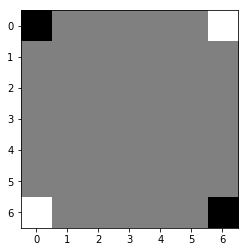

((0, 0), (1, 1)): n_v:  1565 q_all:+0.011293 q:-0.009193 q_m:+0.020000 p:0.315316
((6, 6), (5, 5)): n_v:  1505 q_all:+0.013730 q:+0.011294 q_m:+0.020000 p:0.292875
((0, 0), (1, 0)): n_v:   539 q_all:+0.010982 q:-0.010606 q_m:+0.020000 p:0.109273
((6, 6), (5, 6)): n_v:   527 q_all:+0.012187 q:+0.000768 q_m:+0.020000 p:0.104937
((6, 6), (6, 5)): n_v:   416 q_all:+0.012232 q:+0.010750 q_m:+0.020000 p:0.082708
((0, 0), (0, 1)): n_v:   396 q_all:+0.010330 q:-0.009833 q_m:+0.020000 p:0.080965
((6, 6), (4, 5)): n_v:    12 q_all:-0.002902 q:-0.017504 q_m:-0.000000 p:0.002917
((0, 0), (2, 1)): n_v:    11 q_all:-0.003784 q:-0.025983 q_m:-0.000000 p:0.002808
((0, 0), (1, 2)): n_v:     6 q_all:+0.003623 q:-0.013424 q_m:-0.000000 p:0.001543
((0, 0), (2, 2)): n_v:     5 q_all:+0.000033 q:-0.022451 q_m:-0.000000 p:0.001221
((6, 6), (5, 4)): n_v:     5 q_all:+0.002437 q:-0.010475 q_m:-0.000000 p:0.001151
((6, 6), (4, 4)): n_v:     4 q_all:-0.003647 q:-0.023389 q_m:-0.000000 p:0.001137
((6, 6), (6, 4))

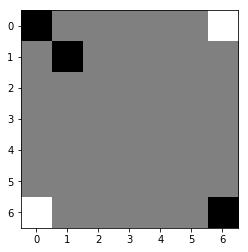

((0, 6), (1, 5)): n_v:  1813 q_all:-0.010649 q:-0.015281 q_m:-0.000000 p:0.273670
((6, 0), (5, 1)): n_v:  1525 q_all:-0.008964 q:-0.020730 q_m:-0.000000 p:0.223854
((0, 6), (1, 6)): n_v:  1024 q_all:-0.013096 q:-0.028697 q_m:-0.000000 p:0.160839
((6, 0), (5, 0)): n_v:   821 q_all:-0.011995 q:-0.028524 q_m:-0.000000 p:0.126771
((0, 6), (0, 5)): n_v:   734 q_all:-0.011863 q:-0.034851 q_m:-0.000000 p:0.112964
((6, 0), (6, 1)): n_v:   594 q_all:-0.011924 q:-0.026798 q_m:-0.000000 p:0.091561
((0, 6), (1, 4)): n_v:    12 q_all:-0.005879 q:-0.036387 q_m:-0.020000 p:0.001769
((0, 6), (2, 5)): n_v:     9 q_all:-0.021028 q:-0.044852 q_m:-0.020000 p:0.001675
((6, 0), (4, 1)): n_v:     6 q_all:-0.009278 q:-0.029217 q_m:-0.020000 p:0.000921
((6, 0), (5, 2)): n_v:     5 q_all:-0.016581 q:-0.012410 q_m:-0.020000 p:0.000986
((0, 6), (2, 6)): n_v:     5 q_all:-0.023134 q:-0.037789 q_m:-0.020000 p:0.001004
((0, 6), (2, 4)): n_v:     4 q_all:-0.013966 q:-0.048059 q_m:-0.020000 p:0.000775
((0, 6), (0, 4))

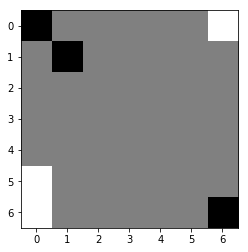

((6, 6), (5, 5)): n_v:  1107 q_all:+0.013923 q:+0.008343 q_m:+0.020000 p:0.164861
((1, 1), (0, 2)): n_v:   745 q_all:+0.009578 q:+0.002890 q_m:+0.020000 p:0.119467
((1, 1), (2, 1)): n_v:   663 q_all:+0.014412 q:-0.007108 q_m:+0.020000 p:0.097872
((1, 1), (1, 2)): n_v:   605 q_all:+0.009448 q:+0.003702 q_m:+0.020000 p:0.097216
((1, 1), (2, 0)): n_v:   569 q_all:+0.010719 q:-0.010723 q_m:+0.020000 p:0.089462
((6, 6), (6, 5)): n_v:   544 q_all:+0.013042 q:+0.005412 q_m:+0.020000 p:0.082202
((6, 6), (5, 6)): n_v:   504 q_all:+0.012596 q:-0.000448 q_m:+0.020000 p:0.076884
((1, 1), (2, 2)): n_v:   437 q_all:+0.013970 q:+0.002741 q_m:+0.020000 p:0.064962
((0, 0), (0, 1)): n_v:   329 q_all:+0.007932 q:-0.025156 q_m:+0.020000 p:0.054209
((0, 0), (1, 0)): n_v:   268 q_all:+0.008991 q:-0.013652 q_m:+0.020000 p:0.043491
((6, 6), (4, 5)): n_v:     7 q_all:-0.002328 q:-0.015893 q_m:-0.000000 p:0.001349
((6, 6), (6, 4)): n_v:     6 q_all:+0.000816 q:-0.014962 q_m:-0.000000 p:0.001140
((1, 1), (3, 1))

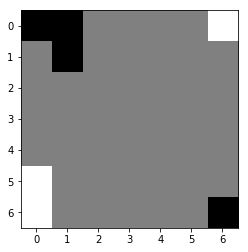

((0, 6), (1, 6)): n_v:  1690 q_all:-0.013131 q:-0.033630 q_m:-0.000000 p:0.276041
((0, 6), (1, 5)): n_v:  1324 q_all:-0.010936 q:-0.017903 q_m:-0.000000 p:0.208300
((0, 6), (0, 5)): n_v:   822 q_all:-0.012326 q:-0.038242 q_m:-0.000000 p:0.132554
((5, 0), (5, 1)): n_v:   712 q_all:-0.010774 q:-0.035077 q_m:-0.000000 p:0.111778
((5, 0), (4, 0)): n_v:   353 q_all:-0.013106 q:-0.036735 q_m:-0.000000 p:0.057774
((5, 0), (6, 1)): n_v:   220 q_all:-0.014843 q:-0.040399 q_m:-0.000000 p:0.036950
((5, 0), (4, 1)): n_v:   142 q_all:-0.010362 q:-0.030620 q_m:-0.000000 p:0.022256
((0, 6), (1, 4)): n_v:    20 q_all:+0.011172 q:-0.042490 q_m:-0.020000 p:0.001995
((0, 6), (0, 4)): n_v:     8 q_all:+0.014650 q:-0.048940 q_m:-0.020000 p:0.000700
((0, 6), (2, 5)): n_v:     6 q_all:-0.022601 q:-0.050427 q_m:-0.020000 p:0.001122
((0, 6), (2, 6)): n_v:     4 q_all:-0.017909 q:-0.043727 q_m:-0.020000 p:0.000739
((5, 0), (5, 2)): n_v:     4 q_all:-0.016766 q:-0.042650 q_m:-0.020000 p:0.000739
((0, 6), (2, 4))

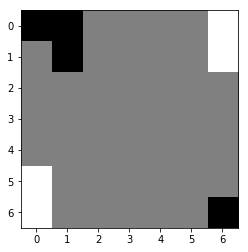

((6, 6), (6, 5)): n_v:   632 q_all:+0.014010 q:+0.001096 q_m:+0.020000 p:0.122358
((1, 1), (2, 1)): n_v:   579 q_all:+0.012630 q:-0.021287 q_m:+0.020000 p:0.114621
((6, 6), (5, 5)): n_v:   552 q_all:+0.014438 q:+0.001986 q_m:+0.020000 p:0.106146
((1, 1), (2, 0)): n_v:   436 q_all:+0.009739 q:-0.014151 q_m:+0.020000 p:0.090551
((0, 1), (0, 2)): n_v:   357 q_all:+0.009740 q:-0.010429 q_m:+0.020000 p:0.074105
((1, 1), (2, 2)): n_v:   270 q_all:+0.013203 q:-0.004463 q_m:+0.020000 p:0.053103
((6, 6), (5, 6)): n_v:   254 q_all:+0.013743 q:-0.009789 q_m:+0.020000 p:0.049491
((0, 0), (1, 0)): n_v:   248 q_all:+0.010908 q:-0.006320 q_m:+0.020000 p:0.050552
((0, 1), (1, 2)): n_v:   236 q_all:+0.011670 q:-0.000765 q_m:+0.020000 p:0.047634
((0, 1), (1, 3)): n_v:    22 q_all:+0.032430 q:-0.005813 q_m:-0.000000 p:0.002870
((1, 1), (1, 3)): n_v:    12 q_all:+0.048522 q:+0.002283 q_m:-0.000000 p:0.000981
((0, 1), (0, 3)): n_v:     9 q_all:+0.055371 q:-0.025421 q_m:-0.000000 p:0.000540
((0, 0), (0, 2))

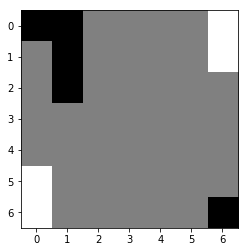

((0, 6), (0, 5)): n_v:   596 q_all:-0.010352 q:-0.038357 q_m:-0.000000 p:0.212178
((1, 6), (2, 6)): n_v:   287 q_all:-0.009443 q:-0.038843 q_m:-0.000000 p:0.101018
((0, 6), (1, 5)): n_v:   195 q_all:-0.008736 q:-0.022331 q_m:-0.000000 p:0.068085
((5, 0), (4, 0)): n_v:   162 q_all:+0.006280 q:-0.038695 q_m:-0.000000 p:0.045242
((5, 0), (6, 1)): n_v:   140 q_all:-0.010924 q:-0.040291 q_m:-0.000000 p:0.050220
((1, 6), (2, 5)): n_v:   132 q_all:-0.007333 q:-0.034141 q_m:-0.000000 p:0.045222
((5, 0), (5, 1)): n_v:   100 q_all:-0.006676 q:-0.037625 q_m:-0.000000 p:0.034037
((5, 0), (4, 1)): n_v:    68 q_all:+0.001886 q:-0.031786 q_m:-0.000000 p:0.020547
((5, 0), (3, 0)): n_v:    42 q_all:-0.008974 q:-0.047373 q_m:+0.020000 p:0.014975
((0, 6), (1, 4)): n_v:    24 q_all:+0.034113 q:-0.030585 q_m:-0.020000 p:0.003651
((5, 0), (3, 1)): n_v:    17 q_all:-0.045979 q:-0.036190 q_m:+0.020000 p:0.009167
((1, 6), (3, 4)): n_v:    14 q_all:-0.008766 q:-0.050665 q_m:-0.020000 p:0.004883
((1, 6), (1, 4))

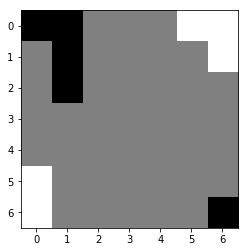

((6, 6), (5, 5)): n_v:   472 q_all:+0.016629 q:+0.003756 q_m:+0.020000 p:0.139748
((6, 6), (6, 5)): n_v:   296 q_all:+0.015721 q:+0.000716 q_m:+0.020000 p:0.088876
((1, 1), (2, 0)): n_v:   222 q_all:+0.012738 q:-0.019550 q_m:+0.020000 p:0.069572
((6, 6), (5, 6)): n_v:   202 q_all:+0.014014 q:-0.009233 q_m:+0.020000 p:0.062009
((0, 0), (1, 0)): n_v:   156 q_all:+0.014019 q:-0.011208 q_m:+0.020000 p:0.048074
((2, 1), (3, 1)): n_v:   154 q_all:+0.038922 q:-0.038687 q_m:+0.020000 p:0.031044
((2, 1), (3, 0)): n_v:   131 q_all:+0.035402 q:-0.024815 q_m:+0.020000 p:0.028350
((1, 1), (2, 2)): n_v:   127 q_all:+0.023964 q:-0.011331 q_m:+0.020000 p:0.033710
((0, 1), (1, 2)): n_v:   123 q_all:+0.025906 q:-0.022274 q_m:+0.020000 p:0.031539
((2, 1), (3, 2)): n_v:    83 q_all:+0.035180 q:-0.032974 q_m:+0.020000 p:0.017933
((0, 1), (0, 2)): n_v:    74 q_all:+0.025398 q:-0.009084 q_m:+0.020000 p:0.019177
((0, 1), (1, 3)): n_v:    15 q_all:-0.004590 q:-0.010596 q_m:-0.000000 p:0.006101
((2, 1), (1, 3))

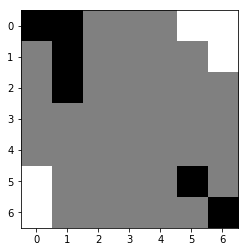

((0, 5), (1, 4)): n_v:   453 q_all:+0.037096 q:-0.032102 q_m:-0.000000 p:0.179304
((0, 5), (0, 4)): n_v:   373 q_all:+0.026486 q:-0.037168 q_m:-0.000000 p:0.168531
((5, 0), (6, 1)): n_v:   204 q_all:-0.013001 q:-0.047463 q_m:-0.000000 p:0.134015
((5, 0), (4, 0)): n_v:   142 q_all:+0.000776 q:-0.047477 q_m:-0.000000 p:0.083490
((1, 6), (2, 6)): n_v:   111 q_all:-0.004370 q:-0.043610 q_m:-0.000000 p:0.068379
((5, 0), (5, 1)): n_v:    48 q_all:-0.011157 q:-0.048249 q_m:-0.000000 p:0.031428
((0, 5), (1, 5)): n_v:    42 q_all:-0.009252 q:-0.017808 q_m:-0.000000 p:0.027226
((5, 0), (4, 1)): n_v:    31 q_all:+0.000424 q:-0.042130 q_m:-0.000000 p:0.018313
((1, 6), (2, 5)): n_v:    23 q_all:+0.004290 q:-0.039961 q_m:-0.000000 p:0.013577
((5, 0), (3, 0)): n_v:     3 q_all:-0.013248 q:-0.051387 q_m:+0.020000 p:0.001777
((0, 6), (2, 4)): n_v:     2 q_all:-0.005988 q:-0.036224 q_m:-0.020000 p:0.001839
((0, 6), (1, 4)): n_v:     2 q_all:+0.017003 q:-0.036269 q_m:-0.020000 p:0.001482
((1, 6), (1, 4))

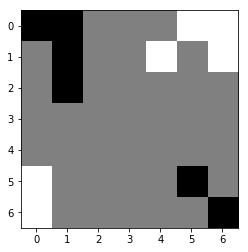

((2, 1), (2, 3)): n_v:   424 q_all:+0.112348 q:-0.007811 q_m:+0.040000 p:0.024814
((0, 1), (2, 3)): n_v:   125 q_all:+0.107756 q:-0.001696 q_m:+0.040000 p:0.009964
((5, 5), (4, 5)): n_v:   109 q_all:-0.003253 q:+0.006902 q_m:+0.020000 p:0.072494
((0, 0), (1, 0)): n_v:    70 q_all:-0.008930 q:+0.003736 q_m:+0.020000 p:0.048401
((5, 5), (5, 6)): n_v:    64 q_all:-0.004541 q:-0.004761 q_m:+0.020000 p:0.042885
((1, 1), (2, 0)): n_v:    61 q_all:-0.009731 q:+0.000960 q_m:+0.020000 p:0.042525
((2, 1), (1, 3)): n_v:    52 q_all:+0.020747 q:-0.000021 q_m:+0.040000 p:0.028007
((2, 1), (0, 3)): n_v:    49 q_all:+0.015231 q:+0.016522 q_m:+0.040000 p:0.027792
((5, 5), (6, 5)): n_v:    46 q_all:-0.005891 q:+0.009164 q_m:+0.020000 p:0.031297
((0, 1), (1, 3)): n_v:    41 q_all:+0.020830 q:+0.015491 q_m:+0.040000 p:0.022337
((2, 1), (3, 1)): n_v:    39 q_all:-0.001286 q:-0.009879 q_m:+0.020000 p:0.025401
((2, 1), (3, 0)): n_v:    39 q_all:-0.010222 q:-0.008101 q_m:+0.020000 p:0.027234
((5, 5), (4, 6))

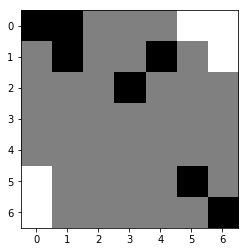

((0, 5), (1, 3)): n_v:  3294 q_all:+0.059260 q:-0.039273 q_m:+0.040000 p:0.023259
((0, 5), (0, 4)): n_v:  1065 q_all:-0.133526 q:-0.013714 q_m:+0.020000 p:0.565527
((0, 5), (1, 5)): n_v:   367 q_all:+0.007469 q:-0.004156 q_m:+0.020000 p:0.054213
((0, 6), (2, 4)): n_v:   308 q_all:-0.002443 q:-0.014325 q_m:+0.040000 p:0.053892
((1, 6), (2, 4)): n_v:    75 q_all:+0.001162 q:-0.013029 q_m:+0.040000 p:0.012492
((0, 5), (2, 4)): n_v:    63 q_all:-0.013239 q:-0.031227 q_m:+0.040000 p:0.012883
((1, 6), (2, 5)): n_v:    56 q_all:-0.151759 q:-0.016357 q_m:+0.020000 p:0.032793
((0, 6), (0, 4)): n_v:    44 q_all:-0.094268 q:-0.024133 q_m:-0.000000 p:0.019002
((1, 6), (2, 6)): n_v:    32 q_all:-0.158826 q:-0.039515 q_m:-0.020000 p:0.019368
((0, 5), (0, 3)): n_v:    20 q_all:-0.024935 q:-0.035687 q_m:-0.000000 p:0.004772
((5, 0), (5, 1)): n_v:    13 q_all:-0.121290 q:-0.047078 q_m:-0.020000 p:0.006483
((1, 6), (0, 4)): n_v:    12 q_all:-0.117645 q:-0.023112 q_m:-0.000000 p:0.006076
((5, 0), (6, 1))

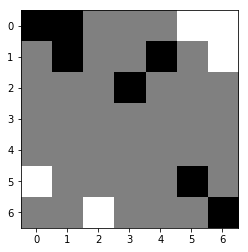

((2, 3), (1, 5)): n_v:  2745 q_all:+0.154822 q:+0.107774 q_m:+0.160000 p:0.669739
((1, 4), (1, 5)): n_v:  1377 q_all:+0.171170 q:+0.132286 q_m:+0.180000 p:0.266553
((1, 4), (0, 4)): n_v:    11 q_all:+0.035499 q:+0.064271 q_m:+0.100000 p:0.006981
((2, 3), (0, 2)): n_v:     9 q_all:+0.049739 q:-0.010808 q_m:+0.040000 p:0.005640
((2, 3), (0, 4)): n_v:     9 q_all:-0.014840 q:+0.040497 q_m:+0.080000 p:0.007648
((5, 5), (6, 5)): n_v:     7 q_all:+0.108021 q:+0.011556 q_m:+0.060000 p:0.002758
((1, 4), (2, 5)): n_v:     6 q_all:+0.058462 q:+0.030884 q_m:+0.100000 p:0.003273
((5, 5), (6, 4)): n_v:     5 q_all:+0.081804 q:+0.011779 q_m:+0.060000 p:0.002481
((1, 4), (1, 3)): n_v:     5 q_all:+0.069504 q:-0.005812 q_m:+0.060000 p:0.002684
((5, 5), (4, 6)): n_v:     3 q_all:+0.088375 q:+0.013437 q_m:+0.060000 p:0.001549
((1, 4), (2, 4)): n_v:     3 q_all:+0.055970 q:+0.000013 q_m:+0.060000 p:0.001821
((2, 3), (3, 5)): n_v:     3 q_all:+0.037803 q:-0.017917 q_m:+0.040000 p:0.001847
((2, 3), (3, 3))

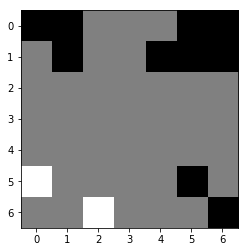

((6, 2), (6, 4)): n_v:   478 q_all:-0.191902 q:-0.085254 q_m:-0.120000 p:0.195870
((5, 0), (6, 1)): n_v:   477 q_all:-0.129016 q:-0.139335 q_m:-0.140000 p:0.097029
((5, 0), (4, 0)): n_v:   446 q_all:-0.124986 q:-0.134536 q_m:-0.140000 p:0.085013
((5, 0), (4, 1)): n_v:   437 q_all:-0.124642 q:-0.142575 q_m:-0.140000 p:0.082635
((6, 2), (5, 2)): n_v:   409 q_all:-0.125486 q:-0.111111 q_m:-0.140000 p:0.078663
((6, 2), (5, 3)): n_v:   367 q_all:-0.122012 q:-0.136010 q_m:-0.140000 p:0.066422
((6, 2), (5, 4)): n_v:   265 q_all:-0.196964 q:-0.109247 q_m:-0.120000 p:0.112826
((5, 0), (5, 1)): n_v:   215 q_all:-0.128875 q:-0.137038 q_m:-0.140000 p:0.043779
((6, 2), (4, 4)): n_v:   185 q_all:-0.138077 q:-0.114792 q_m:-0.120000 p:0.043016
((5, 0), (6, 0)): n_v:   171 q_all:-0.137861 q:-0.139766 q_m:-0.140000 p:0.039929
((6, 2), (6, 3)): n_v:    88 q_all:-0.112783 q:-0.122637 q_m:-0.140000 p:0.013368
((6, 2), (4, 1)): n_v:    62 q_all:-0.157928 q:-0.153306 q_m:-0.160000 p:0.018636
((6, 2), (6, 0))

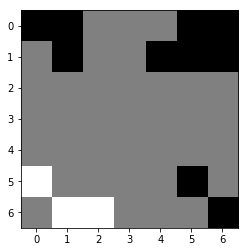

((5, 5), (6, 5)): n_v:   179 q_all:+0.142430 q:+0.101907 q_m:+0.160000 p:0.088917
((1, 4), (2, 4)): n_v:   171 q_all:+0.151049 q:+0.096680 q_m:+0.160000 p:0.077367
((1, 4), (1, 3)): n_v:   154 q_all:+0.156309 q:+0.086885 q_m:+0.160000 p:0.065223
((1, 4), (2, 5)): n_v:    96 q_all:+0.147302 q:+0.084325 q_m:+0.160000 p:0.045098
((5, 5), (4, 4)): n_v:    82 q_all:+0.158845 q:+0.082501 q_m:+0.160000 p:0.033662
((1, 1), (2, 2)): n_v:    80 q_all:+0.160451 q:+0.126202 q_m:+0.160000 p:0.032299
((5, 5), (5, 4)): n_v:    73 q_all:+0.160746 q:+0.110624 q_m:+0.160000 p:0.029338
((5, 5), (5, 6)): n_v:    68 q_all:+0.153661 q:+0.078261 q_m:+0.160000 p:0.030078
((0, 0), (1, 0)): n_v:    66 q_all:+0.146056 q:+0.107550 q_m:+0.160000 p:0.031658
((1, 4), (0, 3)): n_v:    54 q_all:+0.154973 q:+0.093141 q_m:+0.160000 p:0.023486
((5, 5), (4, 6)): n_v:    51 q_all:+0.152704 q:+0.096834 q_m:+0.160000 p:0.022910
((5, 5), (6, 4)): n_v:    46 q_all:+0.174530 q:+0.093043 q_m:+0.160000 p:0.015177
((0, 1), (1, 2))

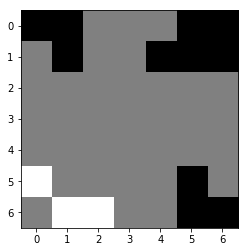

((6, 2), (5, 4)): n_v:   445 q_all:-0.120047 q:-0.114444 q_m:-0.080000 p:0.327964
((6, 2), (6, 4)): n_v:   308 q_all:-0.145859 q:-0.081838 q_m:-0.080000 p:0.271872
((6, 1), (5, 2)): n_v:   112 q_all:-0.085283 q:-0.108344 q_m:-0.140000 p:0.060479
((5, 0), (4, 1)): n_v:    86 q_all:-0.088608 q:-0.149824 q_m:-0.140000 p:0.048385
((6, 2), (4, 4)): n_v:    67 q_all:-0.167238 q:-0.123053 q_m:-0.120000 p:0.067118
((6, 2), (5, 3)): n_v:    60 q_all:-0.074847 q:-0.124957 q_m:-0.140000 p:0.029269
((5, 0), (4, 0)): n_v:    33 q_all:-0.092431 q:-0.131584 q_m:-0.140000 p:0.019060
((5, 0), (5, 1)): n_v:    28 q_all:-0.088990 q:-0.147520 q_m:-0.140000 p:0.016101
((6, 2), (6, 3)): n_v:    25 q_all:-0.063945 q:-0.128838 q_m:-0.140000 p:0.010863
((5, 0), (6, 0)): n_v:    24 q_all:-0.089760 q:-0.147961 q_m:-0.140000 p:0.014026
((6, 2), (4, 1)): n_v:     8 q_all:-0.111000 q:-0.162257 q_m:-0.160000 p:0.005898
((6, 1), (4, 1)): n_v:     5 q_all:-0.101536 q:-0.148314 q_m:-0.160000 p:0.003568
((6, 2), (4, 2))

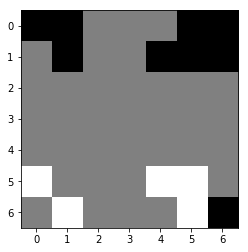

((6, 6), (6, 4)): n_v:   849 q_all:+0.182910 q:+0.129550 q_m:+0.200000 p:0.338120
((6, 6), (5, 6)): n_v:   234 q_all:+0.111496 q:+0.070512 q_m:+0.180000 p:0.181622
((0, 6), (0, 4)): n_v:    79 q_all:+0.072384 q:-0.012350 q_m:+0.080000 p:0.078026
((1, 4), (2, 4)): n_v:    56 q_all:+0.106109 q:+0.010279 q_m:+0.100000 p:0.045458
((0, 0), (1, 0)): n_v:    44 q_all:+0.115700 q:+0.016862 q_m:+0.100000 p:0.033018
((0, 5), (0, 4)): n_v:    38 q_all:+0.087365 q:-0.003577 q_m:+0.100000 p:0.034934
((0, 1), (0, 2)): n_v:    26 q_all:+0.119832 q:-0.007007 q_m:+0.100000 p:0.019505
((6, 6), (4, 4)): n_v:    25 q_all:+0.113299 q:+0.060973 q_m:+0.160000 p:0.019546
((0, 0), (0, 2)): n_v:    21 q_all:+0.095621 q:-0.024335 q_m:+0.080000 p:0.018276
((1, 1), (2, 2)): n_v:    15 q_all:+0.110743 q:+0.033981 q_m:+0.100000 p:0.012354
((1, 4), (2, 5)): n_v:    12 q_all:+0.113956 q:-0.005295 q_m:+0.100000 p:0.009803
((1, 4), (1, 3)): n_v:     6 q_all:+0.118852 q:+0.003930 q_m:+0.100000 p:0.004812
((0, 1), (1, 2))

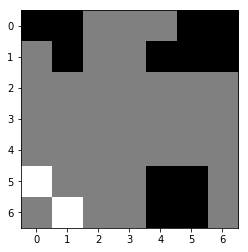

((6, 1), (6, 2)): n_v:   777 q_all:-0.135645 q:-0.123692 q_m:-0.180000 p:0.335408
((5, 0), (4, 1)): n_v:   241 q_all:-0.149950 q:-0.151886 q_m:-0.180000 p:0.120219
((6, 1), (5, 3)): n_v:   203 q_all:-0.157929 q:-0.114517 q_m:-0.120000 p:0.109114
((6, 1), (5, 2)): n_v:   182 q_all:-0.137451 q:-0.143829 q_m:-0.180000 p:0.080332
((5, 0), (6, 0)): n_v:   129 q_all:-0.165577 q:-0.140426 q_m:-0.180000 p:0.073977
((5, 0), (4, 0)): n_v:   106 q_all:-0.149336 q:-0.119819 q_m:-0.180000 p:0.052635
((6, 1), (6, 3)): n_v:    85 q_all:-0.131833 q:-0.111030 q_m:-0.120000 p:0.035457
((5, 0), (5, 1)): n_v:    43 q_all:-0.158230 q:-0.154805 q_m:-0.180000 p:0.023352
((5, 0), (6, 2)): n_v:    11 q_all:-0.519182 q:-0.131713 q_m:-0.200000 p:0.022738
((6, 1), (4, 1)): n_v:    11 q_all:-0.155337 q:-0.142459 q_m:-0.200000 p:0.006222
((6, 1), (4, 2)): n_v:     9 q_all:-0.176064 q:-0.156961 q_m:-0.200000 p:0.005845
((6, 1), (4, 3)): n_v:     9 q_all:-0.155872 q:-0.145764 q_m:-0.160000 p:0.005165
((6, 1), (4, 0))

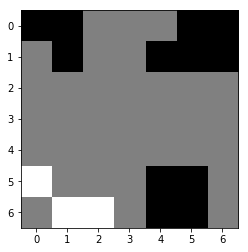

((6, 4), (5, 2)): n_v:   255 q_all:+0.167524 q:+0.204508 q_m:+0.284000 p:0.091394
((0, 1), (1, 2)): n_v:   113 q_all:+0.162697 q:+0.124009 q_m:+0.200000 p:0.043308
((1, 4), (1, 3)): n_v:   105 q_all:+0.159904 q:+0.126288 q_m:+0.200000 p:0.041687
((5, 5), (4, 6)): n_v:    95 q_all:+0.180777 q:+0.129661 q_m:+0.200000 p:0.027647
((5, 5), (5, 6)): n_v:    75 q_all:+0.198709 q:+0.125424 q_m:+0.200000 p:0.015853
((1, 4), (2, 4)): n_v:    74 q_all:+0.169266 q:+0.137403 q_m:+0.200000 p:0.025663
((5, 4), (5, 3)): n_v:    61 q_all:+0.125209 q:+0.149698 q_m:+0.256000 p:0.034121
((1, 5), (2, 6)): n_v:    57 q_all:+0.176511 q:+0.126708 q_m:+0.200000 p:0.018285
((0, 0), (1, 0)): n_v:    56 q_all:+0.164342 q:+0.138364 q_m:+0.200000 p:0.020700
((1, 1), (2, 2)): n_v:    56 q_all:+0.163541 q:+0.155846 q_m:+0.200000 p:0.021127
((1, 4), (2, 5)): n_v:    52 q_all:+0.167984 q:+0.120427 q_m:+0.200000 p:0.018499
((5, 4), (5, 2)): n_v:    49 q_all:+0.159071 q:+0.210279 q_m:+0.284000 p:0.019332
((5, 4), (4, 3))

one move takes time(s):  1.7467808723449707


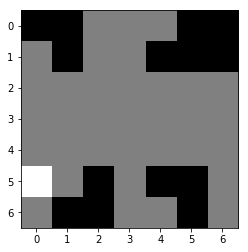

((5, 0), (5, 1)): n_v:  5189 q_all:-0.064099 q:-0.115800 q_m:-0.120000 p:0.948548
((5, 0), (4, 1)): n_v:    15 q_all:-0.849358 q:-0.194291 q_m:-0.200000 p:0.035767
((5, 0), (4, 2)): n_v:     3 q_all:-0.803697 q:-0.205978 q_m:-0.228000 p:0.007098
((5, 0), (4, 0)): n_v:     2 q_all:-0.737837 q:-0.185184 q_m:-0.256000 p:0.005401
((5, 0), (3, 0)): n_v:     1 q_all:-0.620727 q:-0.213090 q_m:-0.284000 p:0.001104
((5, 0), (3, 2)): n_v:     0 q_all:-0.268163 q:-0.257604 q_m:-0.284000 p:0.000287
((5, 0), (6, 0)): n_v:     0 q_all:-0.183983 q:-0.159958 q_m:-0.200000 p:0.000344
((5, 0), (3, 1)): n_v:     0 q_all:-0.261530 q:-0.246549 q_m:-0.284000 p:0.000484
-1 's turn
due to rollout lim, final rollout times:  4688 time elapsed:  2.0040383338928223
one move takes time(s):  2.005497455596924


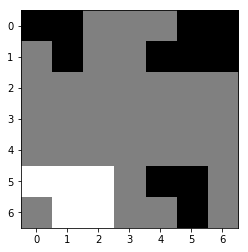

((5, 4), (6, 4)): n_v:  4556 q_all:+0.160482 q:+0.079257 q_m:+0.140000 p:0.002112
((5, 4), (5, 3)): n_v:  1483 q_all:+0.085655 q:+0.122215 q_m:+0.228000 p:0.170356
((5, 4), (6, 3)): n_v:   709 q_all:+0.093416 q:+0.171403 q_m:+0.228000 p:0.066570
((5, 4), (4, 3)): n_v:   513 q_all:+0.073254 q:+0.098776 q_m:+0.180000 p:0.076545
((1, 4), (1, 3)): n_v:   345 q_all:+0.030586 q:+0.090245 q_m:+0.140000 p:0.090559
((1, 4), (0, 3)): n_v:   312 q_all:+0.034018 q:+0.099738 q_m:+0.140000 p:0.079704
((5, 4), (4, 2)): n_v:   308 q_all:+0.081198 q:+0.113954 q_m:+0.200000 p:0.039173
((5, 4), (4, 5)): n_v:   187 q_all:+0.045376 q:+0.082101 q_m:+0.140000 p:0.042405
((5, 4), (4, 4)): n_v:   147 q_all:+0.045033 q:+0.086127 q_m:+0.140000 p:0.033501
((1, 4), (2, 3)): n_v:   132 q_all:+0.034541 q:+0.096575 q_m:+0.140000 p:0.033762
((1, 4), (2, 5)): n_v:   127 q_all:+0.044939 q:+0.082411 q_m:+0.140000 p:0.028944
((1, 4), (2, 4)): n_v:   109 q_all:+0.036735 q:+0.095448 q_m:+0.140000 p:0.027363
((6, 5), (6, 3))

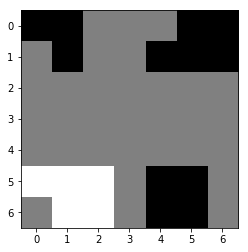

((5, 2), (4, 4)): n_v:  5749 q_all:-0.071213 q:-0.115565 q_m:-0.060000 p:0.050099
((6, 2), (4, 4)): n_v:  1685 q_all:-0.138627 q:-0.097861 q_m:-0.060000 p:0.133626
((5, 2), (5, 3)): n_v:  1677 q_all:-0.190629 q:-0.090978 q_m:-0.040000 p:0.391553
((5, 2), (6, 3)): n_v:   219 q_all:-0.151514 q:-0.084147 q_m:-0.040000 p:0.025605
((6, 1), (5, 3)): n_v:    85 q_all:-0.191272 q:-0.108479 q_m:-0.060000 p:0.020078
((5, 1), (4, 2)): n_v:    25 q_all:-0.164600 q:-0.123042 q_m:-0.120000 p:0.003914
((5, 1), (5, 3)): n_v:    20 q_all:-0.189740 q:-0.082407 q_m:-0.060000 p:0.004626
((5, 2), (3, 4)): n_v:    18 q_all:-0.218793 q:-0.118593 q_m:-0.140000 p:0.005690
((5, 0), (4, 1)): n_v:    14 q_all:-0.169005 q:-0.114976 q_m:-0.120000 p:0.002515
((5, 0), (6, 0)): n_v:    13 q_all:-0.156632 q:-0.094923 q_m:-0.120000 p:0.001611
((5, 0), (4, 0)): n_v:    12 q_all:-0.156972 q:-0.092427 q_m:-0.120000 p:0.001735
((5, 2), (4, 3)): n_v:     9 q_all:-0.197906 q:-0.085911 q_m:-0.080000 p:0.002315
((6, 2), (4, 2))

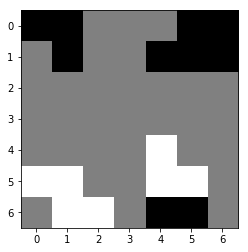

((6, 5), (4, 5)): n_v:  4411 q_all:+0.154936 q:+0.105164 q_m:+0.180000 p:0.021524
((6, 4), (5, 3)): n_v:  2874 q_all:+0.079747 q:+0.096042 q_m:+0.200000 p:0.400251
((6, 4), (4, 5)): n_v:  1331 q_all:+0.085131 q:+0.095164 q_m:+0.180000 p:0.166544
((6, 4), (5, 2)): n_v:   352 q_all:+0.108454 q:+0.094532 q_m:+0.180000 p:0.022338
((1, 4), (1, 3)): n_v:   329 q_all:+0.025870 q:+0.010294 q_m:+0.080000 p:0.085780
((1, 4), (2, 5)): n_v:   220 q_all:+0.014180 q:-0.005925 q_m:+0.080000 p:0.062647
((6, 5), (6, 6)): n_v:   185 q_all:+0.034818 q:+0.039861 q_m:+0.120000 p:0.044955
((1, 1), (2, 1)): n_v:    50 q_all:+0.036134 q:+0.018666 q_m:+0.080000 p:0.012218
((6, 5), (5, 3)): n_v:    44 q_all:+0.057122 q:+0.080466 q_m:+0.180000 p:0.008828
((1, 4), (2, 3)): n_v:    38 q_all:+0.021425 q:+0.010016 q_m:+0.080000 p:0.010509
((0, 1), (1, 2)): n_v:    36 q_all:+0.024348 q:+0.014299 q_m:+0.080000 p:0.009756
((1, 5), (1, 3)): n_v:    35 q_all:+0.045030 q:-0.004460 q_m:+0.060000 p:0.008004
((1, 1), (1, 3))

((6, 2), (5, 3)): n_v:  8771 q_all:-0.110116 q:-0.117976 q_m:-0.040000 p:0.906433
((6, 1), (5, 3)): n_v:   416 q_all:-0.134329 q:-0.118543 q_m:-0.060000 p:0.063852
((5, 1), (5, 3)): n_v:   191 q_all:-0.116886 q:-0.108910 q_m:-0.060000 p:0.022515
((6, 2), (6, 3)): n_v:     3 q_all:-0.194288 q:-0.091652 q_m:-0.080000 p:0.000945
((5, 0), (4, 0)): n_v:     2 q_all:-0.188942 q:-0.122625 q_m:-0.160000 p:0.000649
((5, 0), (3, 2)): n_v:     1 q_all:-0.217252 q:-0.144935 q_m:-0.180000 p:0.000350
((5, 1), (4, 2)): n_v:     1 q_all:-0.221906 q:-0.151036 q_m:-0.160000 p:0.000362
((5, 0), (3, 1)): n_v:     1 q_all:-0.219888 q:-0.140198 q_m:-0.180000 p:0.000301
((6, 2), (4, 0)): n_v:     1 q_all:-0.203728 q:-0.123756 q_m:-0.180000 p:0.000514
((5, 0), (6, 0)): n_v:     1 q_all:-0.203350 q:-0.133612 q_m:-0.160000 p:0.000276
((6, 2), (4, 3)): n_v:     1 q_all:-0.159148 q:-0.122812 q_m:-0.100000 p:0.000290
((5, 1), (3, 2)): n_v:     1 q_all:-0.139600 q:-0.155843 q_m:-0.180000 p:0.000246
((6, 1), (4, 3))

((4, 5), (6, 3)): n_v:  7821 q_all:+0.117800 q:+0.109990 q_m:+0.200000 p:0.757210
((4, 5), (4, 3)): n_v:  1990 q_all:+0.169008 q:+0.094547 q_m:+0.160000 p:0.006116
((5, 5), (6, 3)): n_v:   887 q_all:+0.111474 q:+0.086042 q_m:+0.200000 p:0.097555
((0, 5), (0, 3)): n_v:   146 q_all:+0.004919 q:-0.035885 q_m:+0.040000 p:0.045609
((0, 1), (0, 3)): n_v:    71 q_all:+0.006402 q:-0.020091 q_m:+0.040000 p:0.022152
((1, 5), (0, 3)): n_v:    64 q_all:+0.020477 q:-0.015168 q_m:+0.040000 p:0.018093
((4, 5), (3, 5)): n_v:    45 q_all:+0.051860 q:+0.000632 q_m:+0.100000 p:0.010222
((4, 5), (6, 5)): n_v:    42 q_all:+0.084798 q:+0.046541 q_m:+0.120000 p:0.007079
((1, 4), (0, 3)): n_v:    27 q_all:+0.014841 q:-0.007166 q_m:+0.060000 p:0.008116
((5, 5), (4, 3)): n_v:    20 q_all:+0.098121 q:+0.067597 q_m:+0.160000 p:0.002817
((4, 5), (6, 6)): n_v:    18 q_all:+0.000367 q:-0.013843 q_m:+0.040000 p:0.005804
((1, 1), (0, 3)): n_v:    18 q_all:+0.009894 q:-0.008651 q_m:+0.040000 p:0.005564
((5, 5), (6, 5))

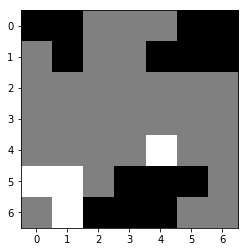

((5, 1), (5, 2)): n_v:  7492 q_all:-0.072887 q:-0.093329 q_m:-0.060000 p:0.462856
((4, 4), (5, 2)): n_v:  1042 q_all:-0.083554 q:-0.107689 q_m:-0.080000 p:0.084485
((5, 0), (5, 2)): n_v:   255 q_all:-0.080770 q:-0.098486 q_m:-0.080000 p:0.019355
((4, 4), (6, 5)): n_v:   150 q_all:-0.042312 q:-0.132179 q_m:-0.080000 p:0.001159
((4, 4), (4, 5)): n_v:     9 q_all:-0.103603 q:-0.152805 q_m:-0.100000 p:0.001116
((4, 4), (4, 3)): n_v:     3 q_all:-0.120705 q:-0.147970 q_m:-0.100000 p:0.000552
((4, 4), (2, 5)): n_v:     1 q_all:-0.091333 q:-0.104525 q_m:-0.080000 p:0.000097
((5, 0), (4, 2)): n_v:     0 q_all:-0.185089 q:-0.201815 q_m:-0.160000 p:0.000003
((5, 0), (3, 2)): n_v:     0 q_all:-0.185607 q:-0.164017 q_m:-0.200000 p:0.000000
((4, 4), (6, 6)): n_v:     0 q_all:-0.166925 q:-0.177313 q_m:-0.160000 p:0.000004
((4, 4), (3, 5)): n_v:     0 q_all:-0.173131 q:-0.162827 q_m:-0.180000 p:0.000004
((4, 4), (3, 4)): n_v:     0 q_all:-0.177548 q:-0.173869 q_m:-0.180000 p:0.000004
((4, 4), (2, 6))

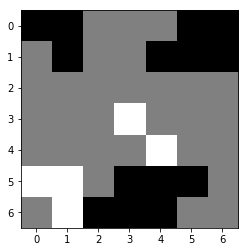

((5, 3), (4, 3)): n_v:   183 q_all:+0.222336 q:+0.152346 q_m:+0.312000 p:0.115725
((5, 3), (5, 2)): n_v:    97 q_all:+0.271999 q:+0.168906 q_m:+0.312000 p:0.031002
((5, 3), (6, 5)): n_v:    62 q_all:+0.104423 q:+0.093603 q_m:+0.180000 p:0.085929
((6, 3), (6, 5)): n_v:    62 q_all:+0.126273 q:+0.093164 q_m:+0.180000 p:0.077716
((1, 4), (2, 4)): n_v:    59 q_all:+0.181412 q:+0.132763 q_m:+0.256000 p:0.052033
((5, 3), (4, 2)): n_v:    58 q_all:+0.187967 q:+0.136878 q_m:+0.312000 p:0.049294
((6, 2), (6, 0)): n_v:    50 q_all:+0.296381 q:+0.196580 q_m:+0.340000 p:0.007831
((6, 2), (4, 3)): n_v:    40 q_all:+0.268106 q:+0.142357 q_m:+0.284000 p:0.013785
((6, 3), (4, 3)): n_v:    38 q_all:+0.178871 q:+0.151697 q_m:+0.284000 p:0.034733
((1, 1), (2, 2)): n_v:    37 q_all:+0.194019 q:+0.164050 q_m:+0.256000 p:0.030239
((6, 3), (4, 1)): n_v:    30 q_all:+0.230823 q:+0.161312 q_m:+0.284000 p:0.017640
((5, 3), (4, 1)): n_v:    27 q_all:+0.182869 q:+0.149666 q_m:+0.284000 p:0.024390
((1, 4), (2, 3))



This is a random move


one move takes time(s):  1.515009880065918


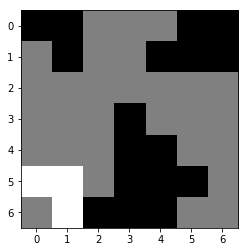

((5, 1), (5, 2)): n_v:  3996 q_all:-0.121051 q:-0.145608 q_m:-0.100000 p:0.281756
((5, 0), (5, 2)): n_v:  1138 q_all:-0.132936 q:-0.140437 q_m:-0.120000 p:0.117710
((5, 1), (4, 2)): n_v:    26 q_all:-0.209359 q:-0.206125 q_m:-0.140000 p:0.008171
((5, 0), (3, 2)): n_v:    10 q_all:-0.141719 q:-0.199645 q_m:-0.200000 p:0.001403
((5, 1), (3, 2)): n_v:     6 q_all:-0.139304 q:-0.187846 q_m:-0.200000 p:0.000758
((6, 1), (4, 2)): n_v:     5 q_all:-0.174031 q:-0.199534 q_m:-0.160000 p:0.001262
((5, 0), (4, 1)): n_v:     2 q_all:-0.225276 q:-0.241190 q_m:-0.284000 p:0.000861
((6, 1), (4, 0)): n_v:     0 q_all:-0.263123 q:-0.230538 q_m:-0.312000 p:0.000049
((5, 0), (4, 2)): n_v:     0 q_all:-0.204043 q:-0.233405 q_m:-0.160000 p:0.000293
((5, 1), (3, 1)): n_v:     0 q_all:-0.242244 q:-0.195741 q_m:-0.312000 p:0.000039
((5, 0), (6, 0)): n_v:     0 q_all:-0.235792 q:-0.203654 q_m:-0.284000 p:0.000130
((5, 0), (3, 1)): n_v:     0 q_all:-0.257136 q:-0.220560 q_m:-0.312000 p:0.000365
((5, 0), (3, 0))

((6, 4), (4, 2)): n_v:  2006 q_all:+0.136214 q:+0.119095 q_m:+0.284000 p:0.294437
((3, 3), (4, 2)): n_v:  1999 q_all:+0.151888 q:+0.130833 q_m:+0.312000 p:0.207852
((4, 4), (4, 2)): n_v:   447 q_all:+0.114127 q:+0.127167 q_m:+0.284000 p:0.092610
((5, 4), (4, 2)): n_v:   439 q_all:+0.067870 q:+0.134495 q_m:+0.284000 p:0.146436
((3, 3), (4, 1)): n_v:   183 q_all:+0.171709 q:+0.104477 q_m:+0.228000 p:0.008964
((1, 4), (2, 2)): n_v:    80 q_all:+0.037031 q:+0.079023 q_m:+0.100000 p:0.033491
((4, 4), (2, 2)): n_v:    53 q_all:+0.016359 q:+0.082891 q_m:+0.100000 p:0.025499
((1, 4), (2, 4)): n_v:    42 q_all:+0.042078 q:+0.069258 q_m:+0.120000 p:0.016847
((1, 1), (2, 2)): n_v:    31 q_all:+0.056327 q:+0.096470 q_m:+0.120000 p:0.011600
((3, 3), (2, 1)): n_v:    23 q_all:+0.042748 q:+0.039354 q_m:+0.100000 p:0.009512
((0, 0), (2, 2)): n_v:    23 q_all:+0.040274 q:+0.077224 q_m:+0.100000 p:0.009498
((1, 4), (0, 2)): n_v:    13 q_all:+0.030463 q:+0.059030 q_m:+0.100000 p:0.006024
((3, 3), (4, 5))

due to rollout lim, final rollout times:  1608 time elapsed:  2.0016090869903564
one move takes time(s):  2.003180742263794


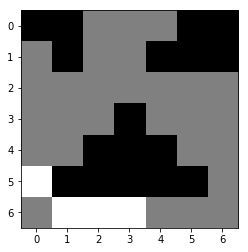

((5, 0), (4, 1)): n_v:  1696 q_all:-0.061233 q:-0.147040 q_m:-0.120000 p:0.286602
((6, 3), (6, 4)): n_v:  1526 q_all:-0.122050 q:-0.086371 q_m:-0.120000 p:0.566705
((6, 3), (4, 1)): n_v:   134 q_all:-0.127033 q:-0.159142 q_m:-0.140000 p:0.052167
((6, 3), (4, 5)): n_v:    76 q_all:-0.131200 q:-0.158598 q_m:-0.140000 p:0.030891
((6, 1), (4, 1)): n_v:    59 q_all:-0.148955 q:-0.154071 q_m:-0.140000 p:0.027107
((5, 0), (3, 2)): n_v:    49 q_all:-0.138607 q:-0.158828 q_m:-0.140000 p:0.021304
((6, 2), (6, 4)): n_v:    21 q_all:-0.147217 q:-0.124461 q_m:-0.140000 p:0.009970
((6, 2), (4, 1)): n_v:     7 q_all:-0.188338 q:-0.198225 q_m:-0.140000 p:0.004671
((6, 1), (4, 0)): n_v:     0 q_all:-0.203871 q:-0.167678 q_m:-0.228000 p:0.000026
((6, 2), (4, 0)): n_v:     0 q_all:-0.207535 q:-0.176837 q_m:-0.228000 p:0.000002
((5, 0), (6, 0)): n_v:     0 q_all:-0.179534 q:-0.148834 q_m:-0.200000 p:0.000028
((6, 3), (6, 5)): n_v:     0 q_all:-0.170600 q:-0.156499 q_m:-0.180000 p:0.000119
((5, 0), (3, 0))

((3, 3), (3, 2)): n_v:   312 q_all:+0.127738 q:+0.124549 q_m:+0.228000 p:0.045688
((3, 3), (3, 4)): n_v:   267 q_all:+0.061612 q:+0.073780 q_m:+0.140000 p:0.107413
((3, 3), (3, 1)): n_v:   246 q_all:+0.125972 q:+0.099852 q_m:+0.200000 p:0.037924
((5, 3), (6, 4)): n_v:   221 q_all:+0.147622 q:+0.101263 q_m:+0.180000 p:0.015285
((4, 4), (2, 6)): n_v:   154 q_all:+0.025970 q:+0.076090 q_m:+0.120000 p:0.083512
((4, 4), (6, 6)): n_v:   112 q_all:+0.026383 q:+0.059857 q_m:+0.120000 p:0.060553
((4, 3), (6, 5)): n_v:    84 q_all:+0.026889 q:+0.069496 q_m:+0.120000 p:0.044941
((4, 3), (3, 1)): n_v:    77 q_all:+0.097147 q:+0.076666 q_m:+0.200000 p:0.020632
((3, 3), (3, 5)): n_v:    76 q_all:+0.054317 q:+0.064782 q_m:+0.120000 p:0.033059
((4, 3), (3, 5)): n_v:    64 q_all:+0.040625 q:+0.072110 q_m:+0.120000 p:0.031202
((5, 5), (4, 6)): n_v:    61 q_all:+0.066172 q:+0.081325 q_m:+0.140000 p:0.023688
((4, 4), (3, 5)): n_v:    59 q_all:+0.064295 q:+0.082877 q_m:+0.140000 p:0.023300
((5, 5), (6, 6))

due to rollout lim, final rollout times:  2116 time elapsed:  2.000554323196411
one move takes time(s):  2.001798391342163


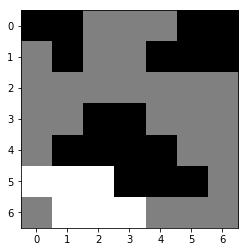

((6, 3), (6, 4)): n_v:  1595 q_all:-0.071104 q:-0.072927 q_m:-0.080000 p:0.754286
((5, 0), (3, 1)): n_v:   758 q_all:-0.019641 q:-0.145303 q_m:-0.100000 p:0.200105
((5, 1), (3, 1)): n_v:    20 q_all:-0.167598 q:-0.138483 q_m:-0.100000 p:0.018012
((6, 3), (4, 5)): n_v:    19 q_all:-0.062367 q:-0.123599 q_m:-0.100000 p:0.008508
((6, 2), (6, 4)): n_v:     7 q_all:-0.173653 q:-0.125568 q_m:-0.100000 p:0.006045
((5, 2), (3, 1)): n_v:     5 q_all:-0.227411 q:-0.178357 q_m:-0.100000 p:0.006435
((6, 3), (6, 5)): n_v:     2 q_all:-0.128124 q:-0.129575 q_m:-0.140000 p:0.002090
((5, 2), (6, 4)): n_v:     1 q_all:-0.148674 q:-0.107915 q_m:-0.100000 p:0.001434
((5, 0), (3, 0)): n_v:     1 q_all:-0.159413 q:-0.155625 q_m:-0.180000 p:0.001130
((6, 1), (4, 0)): n_v:     0 q_all:-0.174824 q:-0.167061 q_m:-0.180000 p:0.000310
((6, 2), (4, 0)): n_v:     0 q_all:-0.175067 q:-0.167667 q_m:-0.180000 p:0.000037
((5, 2), (4, 0)): n_v:     0 q_all:-0.167483 q:-0.148707 q_m:-0.180000 p:0.000051
((5, 0), (6, 0))

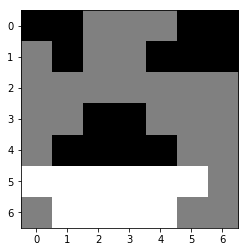

((4, 1), (6, 0)): n_v:  1752 q_all:+0.102735 q:+0.091145 q_m:+0.200000 p:0.584068
((4, 1), (4, 0)): n_v:  1246 q_all:+0.192859 q:+0.061817 q_m:+0.180000 p:0.051793
((4, 3), (6, 5)): n_v:   406 q_all:+0.050473 q:+0.111516 q_m:+0.200000 p:0.204101
((4, 4), (6, 5)): n_v:   188 q_all:+0.092931 q:+0.124837 q_m:+0.200000 p:0.068630
((4, 4), (6, 6)): n_v:    45 q_all:+0.058697 q:+0.077225 q_m:+0.120000 p:0.021598
((4, 2), (6, 0)): n_v:    42 q_all:+0.053371 q:+0.051960 q_m:+0.200000 p:0.021045
((1, 1), (2, 0)): n_v:     7 q_all:-0.007069 q:+0.042967 q_m:+0.100000 p:0.005373
((4, 4), (5, 6)): n_v:     6 q_all:+0.060234 q:+0.079465 q_m:+0.120000 p:0.003289
((3, 3), (1, 3)): n_v:     6 q_all:+0.019773 q:+0.002093 q_m:+0.080000 p:0.004206
((1, 5), (2, 6)): n_v:     5 q_all:+0.055386 q:+0.025632 q_m:+0.100000 p:0.002576
((3, 2), (4, 0)): n_v:     4 q_all:+0.106705 q:+0.038965 q_m:+0.160000 p:0.001683
((4, 4), (4, 5)): n_v:     4 q_all:+0.085451 q:+0.079571 q_m:+0.180000 p:0.001589
((3, 2), (2, 0))

due to rollout lim, final rollout times:  2151 time elapsed:  2.0000522136688232
one move takes time(s):  2.001356601715088


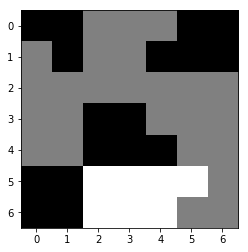

((5, 2), (4, 1)): n_v:  2595 q_all:-0.052618 q:-0.080433 q_m:-0.020000 p:0.378691
((5, 4), (4, 5)): n_v:   992 q_all:-0.113333 q:-0.112070 q_m:-0.140000 p:0.337853
((6, 3), (4, 1)): n_v:    92 q_all:-0.088708 q:-0.121835 q_m:-0.040000 p:0.024138
((5, 5), (3, 4)): n_v:    59 q_all:-0.042804 q:-0.109877 q_m:-0.080000 p:0.006857
((6, 2), (4, 1)): n_v:    59 q_all:-0.096849 q:-0.104063 q_m:-0.040000 p:0.017071
((6, 3), (4, 5)): n_v:     9 q_all:-0.162183 q:-0.186286 q_m:-0.160000 p:0.004732
((5, 3), (4, 1)): n_v:     5 q_all:-0.133576 q:-0.118229 q_m:-0.040000 p:0.002171
((6, 4), (4, 5)): n_v:     4 q_all:-0.172946 q:-0.172293 q_m:-0.160000 p:0.002324
((5, 5), (4, 6)): n_v:     2 q_all:-0.199264 q:-0.148578 q_m:-0.180000 p:0.001763
((5, 3), (3, 4)): n_v:     1 q_all:-0.211694 q:-0.074252 q_m:-0.080000 p:0.000671
((5, 4), (3, 4)): n_v:     1 q_all:-0.179762 q:-0.113273 q_m:-0.080000 p:0.000777
((5, 3), (4, 5)): n_v:     1 q_all:-0.269902 q:-0.123316 q_m:-0.160000 p:0.000785
((5, 2), (3, 1))

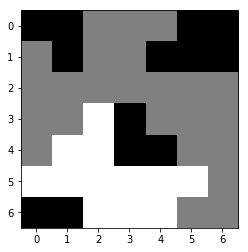

((4, 3), (6, 5)): n_v:  2136 q_all:+0.075459 q:+0.077570 q_m:+0.140000 p:0.615512
((4, 4), (6, 5)): n_v:   251 q_all:+0.066300 q:+0.101932 q_m:+0.140000 p:0.080101
((4, 4), (4, 5)): n_v:   147 q_all:+0.079734 q:+0.065317 q_m:+0.120000 p:0.040261
((3, 3), (3, 1)): n_v:    55 q_all:+0.062823 q:+0.040095 q_m:+0.140000 p:0.018380
((1, 1), (3, 1)): n_v:    54 q_all:+0.120658 q:+0.046346 q_m:+0.140000 p:0.007507
((4, 3), (3, 1)): n_v:    53 q_all:+0.023619 q:+0.017325 q_m:+0.140000 p:0.024621
((6, 0), (4, 0)): n_v:    48 q_all:+0.097496 q:+0.062161 q_m:+0.140000 p:0.010371
((4, 4), (3, 5)): n_v:    47 q_all:+0.006874 q:+0.020538 q_m:+0.040000 p:0.024500
((4, 4), (2, 6)): n_v:    39 q_all:-0.009519 q:-0.014456 q_m:+0.020000 p:0.022712
((6, 1), (4, 0)): n_v:    28 q_all:+0.085863 q:+0.030805 q_m:+0.140000 p:0.007186
((4, 3), (3, 5)): n_v:    28 q_all:+0.016213 q:-0.022119 q_m:+0.020000 p:0.013862
((4, 4), (4, 6)): n_v:    18 q_all:+0.024599 q:+0.039733 q_m:+0.060000 p:0.008462
((4, 4), (5, 6))

((3, 2), (4, 3)): n_v:  4729 q_all:-0.026883 q:-0.111948 q_m:-0.000000 p:0.352316
((3, 2), (2, 3)): n_v:   275 q_all:-0.114326 q:-0.117489 q_m:-0.040000 p:0.085515
((3, 2), (2, 4)): n_v:    39 q_all:-0.074574 q:-0.112536 q_m:-0.020000 p:0.008115
((6, 2), (4, 3)): n_v:    18 q_all:-0.080780 q:-0.131279 q_m:-0.020000 p:0.004045
((3, 2), (1, 0)): n_v:    15 q_all:-0.054437 q:-0.088797 q_m:-0.020000 p:0.002292
((5, 1), (4, 3)): n_v:    14 q_all:-0.103161 q:-0.112909 q_m:-0.020000 p:0.003949
((3, 2), (2, 1)): n_v:     9 q_all:-0.104773 q:-0.143558 q_m:-0.080000 p:0.002620
((4, 1), (4, 3)): n_v:     7 q_all:-0.085427 q:-0.090022 q_m:-0.020000 p:0.001795
((5, 3), (4, 5)): n_v:     5 q_all:-0.072971 q:-0.170164 q_m:-0.020000 p:0.000918
((6, 3), (4, 3)): n_v:     5 q_all:-0.109833 q:-0.170079 q_m:-0.020000 p:0.001581
((4, 1), (2, 3)): n_v:     4 q_all:-0.121994 q:-0.088495 q_m:-0.060000 p:0.001371
((6, 3), (4, 5)): n_v:     4 q_all:-0.122745 q:-0.166874 q_m:-0.020000 p:0.001387
((3, 2), (2, 2))

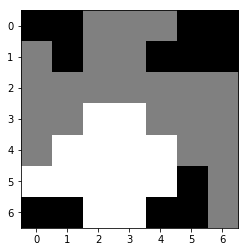

((1, 6), (3, 4)): n_v:  1383 q_all:+0.042013 q:+0.069747 q_m:+0.120000 p:0.255278
((5, 5), (3, 4)): n_v:   591 q_all:+0.039579 q:+0.063478 q_m:+0.120000 p:0.112961
((1, 1), (3, 1)): n_v:   510 q_all:+0.087284 q:+0.113026 q_m:+0.120000 p:0.033005
((1, 5), (3, 4)): n_v:   479 q_all:+0.049161 q:+0.081291 q_m:+0.120000 p:0.079442
((5, 5), (3, 5)): n_v:   439 q_all:-0.011209 q:+0.017680 q_m:+0.040000 p:0.142593
((1, 4), (2, 3)): n_v:   428 q_all:+0.034895 q:+0.099153 q_m:+0.100000 p:0.087107
((1, 5), (3, 5)): n_v:   137 q_all:-0.012486 q:+0.052611 q_m:+0.040000 p:0.044946
((1, 6), (3, 5)): n_v:   126 q_all:-0.003983 q:+0.043767 q_m:+0.040000 p:0.038796
((1, 4), (3, 4)): n_v:   121 q_all:+0.047411 q:+0.087593 q_m:+0.120000 p:0.020729
((1, 1), (2, 2)): n_v:   104 q_all:+0.076648 q:+0.105518 q_m:+0.100000 p:0.009726
((5, 5), (4, 6)): n_v:    83 q_all:-0.022563 q:+0.028379 q_m:+0.020000 p:0.029657
((1, 4), (3, 5)): n_v:    61 q_all:-0.003556 q:+0.049857 q_m:+0.040000 p:0.018868
((6, 0), (4, 0))

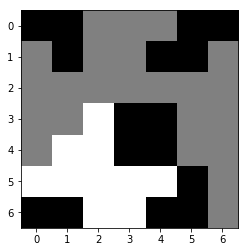

((3, 2), (1, 0)): n_v:  1442 q_all:+0.007679 q:-0.044278 q_m:-0.000000 p:0.354269
((5, 4), (4, 5)): n_v:  1142 q_all:-0.022484 q:-0.104651 q_m:+0.020000 p:0.398898
((3, 2), (2, 4)): n_v:   241 q_all:-0.013689 q:-0.069919 q_m:+0.040000 p:0.077039
((3, 2), (2, 1)): n_v:   198 q_all:-0.044040 q:-0.085865 q_m:-0.060000 p:0.083916
((3, 2), (2, 3)): n_v:    88 q_all:-0.020761 q:-0.072280 q_m:+0.020000 p:0.030469
((3, 2), (2, 2)): n_v:    35 q_all:-0.046761 q:-0.073539 q_m:-0.020000 p:0.015413
((6, 3), (4, 5)): n_v:    32 q_all:-0.051768 q:-0.145315 q_m:-0.000000 p:0.014658
((3, 2), (1, 2)): n_v:    17 q_all:-0.045782 q:-0.096437 q_m:-0.040000 p:0.007437
((5, 3), (4, 5)): n_v:     7 q_all:-0.095670 q:-0.135177 q_m:-0.000000 p:0.004727
((3, 2), (1, 3)): n_v:     4 q_all:-0.050882 q:-0.116713 q_m:-0.080000 p:0.002125
((5, 4), (5, 6)): n_v:     4 q_all:-0.044157 q:-0.090963 q_m:-0.040000 p:0.001648
((4, 2), (2, 4)): n_v:     3 q_all:-0.049133 q:-0.099152 q_m:+0.040000 p:0.001473
((4, 1), (2, 2))

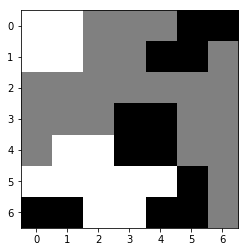

((6, 0), (4, 0)): n_v:  1259 q_all:+0.029006 q:+0.034854 q_m:+0.120000 p:0.472237
((3, 3), (3, 2)): n_v:   258 q_all:+0.024424 q:-0.001440 q_m:+0.100000 p:0.101557
((3, 4), (4, 6)): n_v:   121 q_all:-0.061221 q:-0.049548 q_m:-0.000000 p:0.089683
((3, 4), (2, 6)): n_v:    80 q_all:-0.023046 q:-0.030740 q_m:-0.000000 p:0.046959
((6, 1), (4, 0)): n_v:    67 q_all:+0.007450 q:-0.007273 q_m:+0.120000 p:0.031433
((4, 4), (2, 6)): n_v:    26 q_all:-0.072753 q:-0.037651 q_m:-0.000000 p:0.020832
((3, 3), (1, 2)): n_v:    26 q_all:+0.004912 q:+0.018827 q_m:+0.080000 p:0.012350
((0, 6), (2, 6)): n_v:    24 q_all:-0.048758 q:-0.034046 q_m:-0.000000 p:0.016552
((5, 5), (4, 6)): n_v:    18 q_all:-0.067455 q:-0.050499 q_m:+0.020000 p:0.014366
((4, 4), (3, 2)): n_v:    18 q_all:-0.009763 q:-0.020245 q_m:+0.080000 p:0.009547
((6, 4), (4, 6)): n_v:    17 q_all:-0.065963 q:-0.081349 q_m:-0.000000 p:0.013431
((3, 4), (1, 6)): n_v:    16 q_all:-0.023660 q:-0.037848 q_m:-0.000000 p:0.009902
((3, 4), (5, 6))

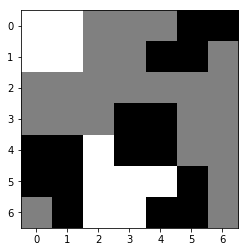

((4, 2), (3, 2)): n_v:  1059 q_all:-0.001809 q:+0.007003 q_m:+0.020000 p:0.468571
((5, 4), (4, 5)): n_v:   823 q_all:+0.012819 q:-0.025691 q_m:+0.020000 p:0.313490
((6, 2), (6, 0)): n_v:   117 q_all:-0.057344 q:+0.002619 q_m:-0.000000 p:0.079570
((4, 2), (6, 0)): n_v:    67 q_all:+0.001897 q:+0.003914 q_m:-0.000000 p:0.028813
((5, 4), (3, 2)): n_v:    26 q_all:+0.003329 q:+0.002356 q_m:-0.000000 p:0.010876
((1, 1), (3, 2)): n_v:    22 q_all:-0.028900 q:-0.010323 q_m:-0.000000 p:0.012524
((1, 0), (3, 2)): n_v:    21 q_all:-0.031649 q:-0.020023 q_m:-0.000000 p:0.012362
((1, 1), (2, 2)): n_v:    11 q_all:-0.053530 q:-0.042702 q_m:-0.060000 p:0.007460
((5, 3), (3, 2)): n_v:    11 q_all:-0.042656 q:+0.006838 q_m:-0.000000 p:0.007085
((6, 3), (4, 5)): n_v:     9 q_all:-0.060587 q:-0.051411 q_m:-0.000000 p:0.006866
((4, 2), (2, 4)): n_v:     8 q_all:-0.016689 q:-0.014887 q_m:+0.040000 p:0.004343
((4, 2), (3, 1)): n_v:     7 q_all:-0.047653 q:-0.009324 q_m:-0.020000 p:0.005017
((5, 4), (5, 6))

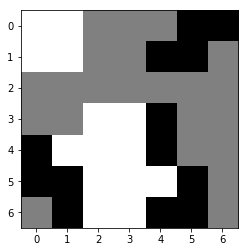

((4, 0), (3, 1)): n_v:   610 q_all:+0.067784 q:+0.059326 q_m:+0.120000 p:0.240563
((3, 4), (1, 2)): n_v:   517 q_all:+0.040612 q:+0.018823 q_m:+0.060000 p:0.265866
((1, 4), (2, 3)): n_v:   130 q_all:+0.036417 q:+0.002907 q_m:+0.080000 p:0.069487
((5, 0), (3, 1)): n_v:   115 q_all:+0.047662 q:+0.040811 q_m:+0.100000 p:0.055403
((3, 4), (2, 2)): n_v:   106 q_all:+0.060271 q:-0.000834 q_m:+0.100000 p:0.045439
((1, 4), (2, 2)): n_v:    50 q_all:+0.052885 q:-0.002873 q_m:+0.100000 p:0.022980
((3, 4), (3, 5)): n_v:    46 q_all:-0.057014 q:-0.020623 q_m:-0.000000 p:0.044245
((1, 4), (1, 2)): n_v:    44 q_all:+0.027725 q:+0.012703 q_m:+0.060000 p:0.025122
((1, 4), (0, 2)): n_v:    19 q_all:+0.024384 q:+0.022278 q_m:+0.060000 p:0.011340
((3, 4), (1, 6)): n_v:    15 q_all:+0.009266 q:+0.003962 q_m:-0.020000 p:0.010338
((5, 1), (3, 1)): n_v:    11 q_all:-0.020467 q:+0.035458 q_m:+0.100000 p:0.008800
((4, 4), (2, 2)): n_v:    10 q_all:+0.038867 q:-0.002164 q_m:+0.100000 p:0.005402
((4, 0), (2, 1))

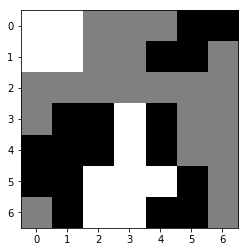

((3, 3), (4, 5)): n_v:   664 q_all:-0.031854 q:-0.036856 q_m:-0.000000 p:0.474582
((5, 4), (4, 5)): n_v:   536 q_all:+0.018213 q:-0.033108 q_m:+0.020000 p:0.248957
((3, 3), (2, 5)): n_v:   132 q_all:+0.001646 q:-0.016333 q_m:-0.000000 p:0.072486
((4, 3), (2, 5)): n_v:    41 q_all:-0.051960 q:-0.047500 q_m:-0.000000 p:0.033409
((1, 0), (3, 0)): n_v:    33 q_all:+0.000401 q:+0.003995 q_m:-0.000000 p:0.018120
((1, 0), (2, 1)): n_v:    21 q_all:-0.084966 q:-0.047109 q_m:-0.020000 p:0.021441
((6, 3), (4, 5)): n_v:    17 q_all:-0.049990 q:-0.076532 q_m:-0.000000 p:0.013970
((3, 3), (2, 1)): n_v:    11 q_all:-0.082265 q:-0.043169 q_m:-0.040000 p:0.010857
((4, 3), (4, 5)): n_v:    11 q_all:-0.105938 q:-0.067458 q_m:-0.000000 p:0.012313
((4, 3), (2, 1)): n_v:     9 q_all:-0.075018 q:-0.068048 q_m:-0.040000 p:0.008948
((1, 1), (3, 0)): n_v:     9 q_all:-0.032944 q:+0.000668 q_m:-0.000000 p:0.006971
((5, 4), (3, 6)): n_v:     7 q_all:-0.127320 q:-0.058160 q_m:-0.120000 p:0.009175
((3, 3), (2, 4))

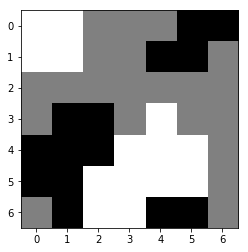

((3, 2), (3, 3)): n_v:  1497 q_all:+0.099680 q:+0.063987 q_m:+0.140000 p:0.388489
((1, 4), (3, 3)): n_v:    73 q_all:+0.076021 q:+0.061920 q_m:+0.120000 p:0.027296
((1, 5), (3, 3)): n_v:    50 q_all:+0.093128 q:+0.069170 q_m:+0.120000 p:0.014783
((5, 1), (3, 3)): n_v:    26 q_all:-0.022241 q:+0.041325 q_m:+0.120000 p:0.021709
((3, 2), (2, 0)): n_v:    23 q_all:+0.049848 q:+0.016503 q_m:+0.080000 p:0.011738
((6, 5), (5, 6)): n_v:    21 q_all:+0.038752 q:+0.045642 q_m:+0.100000 p:0.011819
((1, 5), (3, 5)): n_v:    18 q_all:+0.026716 q:+0.025395 q_m:+0.120000 p:0.011180
((4, 1), (3, 3)): n_v:    14 q_all:-0.033909 q:+0.022673 q_m:+0.120000 p:0.012048
((3, 1), (2, 1)): n_v:    12 q_all:+0.040277 q:+0.036160 q_m:+0.100000 p:0.006573
((4, 2), (2, 0)): n_v:     9 q_all:+0.045914 q:-0.004587 q_m:+0.080000 p:0.004991
((0, 5), (1, 6)): n_v:     9 q_all:-0.004820 q:-0.001486 q_m:+0.020000 p:0.007045
((6, 4), (4, 6)): n_v:     7 q_all:+0.015881 q:-0.008682 q_m:+0.080000 p:0.004780
((4, 0), (2, 0))

((1, 1), (2, 2)): n_v:   828 q_all:-0.073484 q:-0.004836 q_m:-0.000000 p:0.322598
((1, 0), (2, 1)): n_v:   225 q_all:-0.081333 q:-0.056037 q_m:-0.040000 p:0.094959
((4, 5), (2, 4)): n_v:   199 q_all:-0.036317 q:-0.031111 q_m:+0.020000 p:0.047990
((1, 0), (2, 2)): n_v:   190 q_all:-0.054057 q:-0.013667 q_m:-0.020000 p:0.059401
((1, 0), (3, 0)): n_v:   185 q_all:+0.003980 q:-0.000519 q_m:-0.020000 p:0.014564
((0, 1), (2, 3)): n_v:   101 q_all:-0.063802 q:-0.057776 q_m:+0.020000 p:0.035709
((0, 0), (2, 2)): n_v:    82 q_all:-0.076215 q:-0.026323 q_m:-0.020000 p:0.032866
((1, 1), (2, 3)): n_v:    79 q_all:-0.044312 q:-0.047676 q_m:+0.020000 p:0.021708
((4, 5), (2, 3)): n_v:    65 q_all:-0.045201 q:-0.043201 q_m:+0.020000 p:0.018204
((4, 5), (5, 6)): n_v:    61 q_all:-0.071424 q:-0.040719 q_m:-0.080000 p:0.023379
((4, 5), (6, 6)): n_v:    57 q_all:-0.088912 q:-0.051010 q_m:-0.100000 p:0.026149
((0, 1), (2, 2)): n_v:    37 q_all:-0.085420 q:-0.033586 q_m:-0.020000 p:0.016212
((0, 1), (1, 2))

((4, 0), (2, 1)): n_v:  1540 q_all:+0.127055 q:+0.080542 q_m:+0.200000 p:0.495318
((4, 3), (2, 1)): n_v:   354 q_all:+0.124628 q:+0.066166 q_m:+0.200000 p:0.117146
((4, 3), (2, 5)): n_v:    82 q_all:-0.001140 q:-0.087268 q_m:-0.000000 p:0.069626
((4, 1), (2, 1)): n_v:    58 q_all:+0.075024 q:+0.055013 q_m:+0.200000 p:0.031303
((4, 2), (2, 1)): n_v:    52 q_all:+0.086037 q:+0.055702 q_m:+0.200000 p:0.025173
((1, 4), (2, 3)): n_v:    32 q_all:+0.091224 q:+0.064622 q_m:+0.140000 p:0.015118
((0, 6), (2, 5)): n_v:    25 q_all:-0.023699 q:-0.063387 q_m:-0.000000 p:0.023841
((3, 4), (1, 2)): n_v:    20 q_all:+0.102156 q:-0.004918 q_m:+0.120000 p:0.008699
((1, 4), (2, 5)): n_v:    19 q_all:-0.005786 q:-0.029875 q_m:+0.020000 p:0.016676
((4, 4), (2, 5)): n_v:    16 q_all:+0.007858 q:-0.054859 q_m:-0.000000 p:0.013486
((3, 4), (1, 6)): n_v:    14 q_all:+0.022280 q:-0.019951 q_m:-0.000000 p:0.010664
((1, 4), (1, 2)): n_v:     6 q_all:+0.104898 q:+0.032017 q_m:+0.120000 p:0.002763
((0, 5), (2, 5))

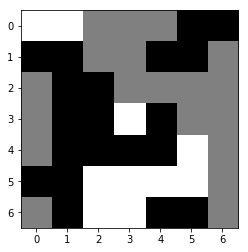

((0, 0), (2, 0)): n_v:   888 q_all:-0.092514 q:-0.038834 q_m:-0.040000 p:0.435638
((0, 1), (1, 2)): n_v:   375 q_all:-0.060181 q:-0.037670 q_m:-0.060000 p:0.135731
((0, 0), (1, 2)): n_v:   283 q_all:-0.087071 q:-0.072742 q_m:-0.080000 p:0.133039
((6, 2), (4, 0)): n_v:   250 q_all:-0.106266 q:-0.083563 q_m:-0.040000 p:0.136732
((3, 3), (1, 2)): n_v:   234 q_all:+0.003349 q:-0.051756 q_m:-0.080000 p:0.025995
((0, 1), (2, 0)): n_v:   189 q_all:-0.079841 q:-0.051611 q_m:-0.040000 p:0.083435
((3, 3), (2, 3)): n_v:    26 q_all:-0.105423 q:-0.083531 q_m:-0.020000 p:0.014341
((4, 5), (2, 4)): n_v:     9 q_all:-0.136264 q:-0.105869 q_m:-0.080000 p:0.006636
((5, 2), (4, 0)): n_v:     9 q_all:-0.140894 q:-0.084773 q_m:-0.040000 p:0.006500
((4, 5), (2, 6)): n_v:     8 q_all:-0.154208 q:-0.142013 q_m:-0.160000 p:0.006471
((3, 3), (2, 4)): n_v:     6 q_all:-0.143964 q:-0.119184 q_m:-0.060000 p:0.004632
((0, 1), (0, 3)): n_v:     1 q_all:-0.113968 q:-0.120805 q_m:-0.160000 p:0.000840
((6, 2), (6, 0))

((4, 1), (3, 0)): n_v:  2027 q_all:+0.130246 q:+0.095072 q_m:+0.180000 p:0.704464
((4, 2), (3, 0)): n_v:   143 q_all:+0.067249 q:+0.057637 q_m:+0.160000 p:0.084822
((2, 2), (3, 0)): n_v:   141 q_all:+0.120546 q:+0.090476 q_m:+0.160000 p:0.054494
((5, 0), (3, 0)): n_v:    98 q_all:+0.114462 q:+0.079928 q_m:+0.160000 p:0.039896
((2, 2), (1, 2)): n_v:    42 q_all:+0.091897 q:+0.066086 q_m:+0.180000 p:0.021205
((3, 2), (1, 2)): n_v:    21 q_all:+0.066522 q:+0.042148 q_m:+0.160000 p:0.012572
((5, 1), (3, 0)): n_v:    18 q_all:+0.084704 q:+0.076607 q_m:+0.160000 p:0.009500
((3, 4), (3, 6)): n_v:    18 q_all:+0.064883 q:-0.034931 q_m:+0.080000 p:0.011323
((4, 4), (3, 6)): n_v:    16 q_all:+0.063635 q:-0.001993 q_m:+0.080000 p:0.009648
((1, 4), (3, 6)): n_v:    13 q_all:+0.049985 q:-0.003276 q_m:+0.080000 p:0.009044
((2, 2), (0, 0)): n_v:    13 q_all:+0.141293 q:+0.075800 q_m:+0.160000 p:0.004141
((3, 4), (1, 6)): n_v:    12 q_all:+0.027921 q:-0.001217 q_m:+0.040000 p:0.009467
((3, 2), (3, 0))

((4, 5), (2, 3)): n_v:   870 q_all:+0.001971 q:-0.072707 q_m:-0.020000 p:0.010084
((3, 3), (2, 3)): n_v:   741 q_all:-0.109945 q:-0.084638 q_m:-0.000000 p:0.299028
((0, 1), (1, 2)): n_v:   442 q_all:-0.120773 q:-0.057893 q_m:-0.080000 p:0.195280
((3, 3), (2, 5)): n_v:   186 q_all:-0.065573 q:-0.089745 q_m:-0.060000 p:0.042380
((3, 3), (2, 4)): n_v:   147 q_all:-0.117155 q:-0.098195 q_m:-0.040000 p:0.063325
((6, 2), (4, 0)): n_v:   139 q_all:-0.076507 q:-0.036499 q_m:+0.020000 p:0.038120
((3, 3), (1, 2)): n_v:   127 q_all:-0.094965 q:-0.081568 q_m:-0.100000 p:0.044540
((0, 1), (2, 3)): n_v:    64 q_all:-0.121002 q:-0.079501 q_m:-0.020000 p:0.028447
((1, 1), (2, 3)): n_v:    48 q_all:-0.102573 q:-0.047473 q_m:-0.020000 p:0.018064
((1, 0), (1, 2)): n_v:    37 q_all:-0.153621 q:-0.084971 q_m:-0.100000 p:0.021038
((4, 5), (3, 5)): n_v:    23 q_all:-0.109684 q:-0.122045 q_m:-0.080000 p:0.009584
((6, 2), (6, 0)): n_v:    16 q_all:-0.156344 q:-0.092260 q_m:-0.060000 p:0.009187
((3, 3), (1, 3))

((4, 4), (4, 5)): n_v:   918 q_all:+0.071376 q:+0.086885 q_m:+0.160000 p:0.422749
((1, 5), (2, 5)): n_v:   490 q_all:+0.008279 q:+0.036483 q_m:+0.120000 p:0.358037
((2, 1), (1, 2)): n_v:   426 q_all:+0.153510 q:+0.076653 q_m:+0.200000 p:0.046264
((1, 5), (2, 4)): n_v:   128 q_all:+0.091981 q:+0.116618 q_m:+0.200000 p:0.047498
((4, 3), (4, 5)): n_v:    40 q_all:+0.070973 q:+0.067172 q_m:+0.140000 p:0.018773
((2, 0), (1, 2)): n_v:    40 q_all:+0.079613 q:+0.064481 q_m:+0.180000 p:0.017025
((6, 4), (4, 5)): n_v:    26 q_all:+0.074595 q:+0.079786 q_m:+0.140000 p:0.012007
((0, 6), (2, 4)): n_v:    25 q_all:+0.071013 q:+0.087003 q_m:+0.180000 p:0.011915
((0, 6), (2, 5)): n_v:    24 q_all:-0.012296 q:+0.017649 q_m:+0.100000 p:0.019975
((0, 5), (2, 4)): n_v:    14 q_all:+0.065706 q:+0.099069 q_m:+0.180000 p:0.006850
((4, 3), (2, 5)): n_v:    13 q_all:+0.024023 q:+0.004534 q_m:+0.100000 p:0.009056
((3, 0), (1, 2)): n_v:     9 q_all:+0.139473 q:+0.070148 q_m:+0.180000 p:0.002327
((0, 5), (2, 5))

((2, 2), (4, 0)): n_v:  2582 q_all:-0.015840 q:+0.025988 q_m:+0.040000 p:0.304686
((3, 2), (4, 0)): n_v:  2103 q_all:-0.048311 q:+0.023800 q_m:+0.040000 p:0.425637
((6, 2), (4, 0)): n_v:   695 q_all:-0.026146 q:-0.037303 q_m:+0.040000 p:0.100655
((5, 2), (4, 0)): n_v:   246 q_all:-0.064751 q:-0.020267 q_m:+0.040000 p:0.060394
((1, 4), (1, 6)): n_v:   119 q_all:-0.099909 q:-0.034582 q_m:-0.040000 p:0.040085
((1, 4), (2, 6)): n_v:    74 q_all:-0.087800 q:-0.112621 q_m:-0.120000 p:0.022695
((0, 1), (0, 0)): n_v:    16 q_all:-0.166071 q:-0.074202 q_m:-0.140000 p:0.008453
((1, 4), (2, 4)): n_v:    15 q_all:-0.045586 q:-0.078940 q_m:-0.060000 p:0.002986
((6, 2), (6, 0)): n_v:    14 q_all:-0.052229 q:-0.087269 q_m:-0.040000 p:0.003023
((1, 4), (3, 5)): n_v:    13 q_all:-0.059976 q:-0.092822 q_m:-0.040000 p:0.003233
((2, 3), (3, 5)): n_v:     7 q_all:-0.013190 q:-0.099262 q_m:-0.040000 p:0.000810
((1, 4), (0, 4)): n_v:     6 q_all:-0.069799 q:-0.081173 q_m:-0.060000 p:0.001725
((0, 1), (1, 2))

((2, 1), (2, 2)): n_v:  2369 q_all:+0.038766 q:+0.021385 q_m:+0.180000 p:0.601445
((1, 5), (2, 4)): n_v:   974 q_all:+0.072007 q:+0.001178 q_m:+0.100000 p:0.135862
((4, 2), (6, 0)): n_v:   190 q_all:+0.138820 q:-0.008310 q_m:+0.040000 p:0.000313
((4, 2), (2, 4)): n_v:   157 q_all:+0.103711 q:-0.043281 q_m:+0.080000 p:0.006911
((3, 4), (2, 2)): n_v:    72 q_all:+0.022118 q:+0.011785 q_m:+0.160000 p:0.022448
((2, 0), (2, 2)): n_v:    59 q_all:+0.026469 q:-0.000413 q_m:+0.160000 p:0.017624
((0, 6), (2, 4)): n_v:    29 q_all:+0.021198 q:-0.027073 q_m:+0.080000 p:0.009247
((0, 5), (2, 4)): n_v:    16 q_all:+0.018327 q:-0.024460 q_m:+0.080000 p:0.005377
((2, 1), (0, 0)): n_v:    13 q_all:+0.047820 q:+0.008766 q_m:+0.080000 p:0.002912
((4, 4), (2, 2)): n_v:    13 q_all:-0.019396 q:+0.012574 q_m:+0.160000 p:0.006176
((2, 0), (0, 0)): n_v:    11 q_all:+0.025992 q:-0.008735 q_m:+0.080000 p:0.003533
((4, 3), (2, 2)): n_v:     5 q_all:-0.050188 q:+0.017205 q_m:+0.160000 p:0.003045
((4, 2), (2, 2))

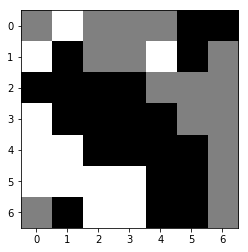

((3, 0), (1, 2)): n_v:  3807 q_all:-0.044687 q:-0.044227 q_m:-0.020000 p:0.553681
((0, 1), (1, 2)): n_v:  2716 q_all:-0.041336 q:+0.007522 q_m:-0.000000 p:0.373860
((1, 4), (1, 2)): n_v:   451 q_all:-0.027149 q:-0.005668 q_m:-0.020000 p:0.047220
((1, 4), (2, 4)): n_v:   125 q_all:+0.008863 q:-0.014789 q_m:-0.000000 p:0.002700
((1, 0), (1, 2)): n_v:   105 q_all:-0.063678 q:-0.052536 q_m:-0.020000 p:0.020006
((0, 1), (0, 2)): n_v:     4 q_all:-0.088099 q:-0.080071 q_m:-0.120000 p:0.001196
((5, 0), (6, 0)): n_v:     2 q_all:-0.042441 q:-0.059455 q_m:-0.120000 p:0.000339
((1, 4), (0, 4)): n_v:     1 q_all:-0.044810 q:-0.071211 q_m:-0.080000 p:0.000221
((0, 1), (0, 3)): n_v:     0 q_all:-0.174949 q:-0.167373 q_m:-0.180000 p:0.000000
((1, 0), (0, 2)): n_v:     0 q_all:-0.128687 q:-0.111719 q_m:-0.140000 p:0.000012
((1, 4), (0, 2)): n_v:     0 q_all:-0.111748 q:-0.069370 q_m:-0.140000 p:0.000020
((1, 4), (1, 3)): n_v:     0 q_all:-0.087228 q:-0.098071 q_m:-0.080000 p:0.000044
((4, 0), (6, 0))

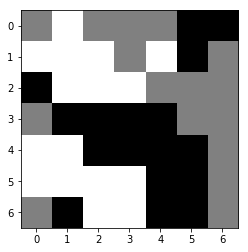

((2, 0), (3, 0)): n_v:  4642 q_all:+0.086968 q:+0.080148 q_m:+0.160000 p:0.424164
((3, 1), (1, 3)): n_v:  1460 q_all:+0.130915 q:+0.019567 q_m:+0.180000 p:0.001436
((6, 1), (6, 0)): n_v:   909 q_all:+0.115525 q:+0.076866 q_m:+0.120000 p:0.012079
((0, 5), (1, 3)): n_v:   490 q_all:+0.071103 q:+0.004119 q_m:+0.180000 p:0.060628
((4, 5), (3, 6)): n_v:   146 q_all:-0.010831 q:-0.009738 q_m:+0.040000 p:0.044825
((1, 5), (1, 3)): n_v:    81 q_all:+0.073538 q:+0.031966 q_m:+0.180000 p:0.009425
((3, 2), (1, 3)): n_v:    26 q_all:-0.009732 q:+0.011367 q_m:+0.180000 p:0.008075
((3, 4), (1, 3)): n_v:    26 q_all:+0.072343 q:+0.007727 q_m:+0.180000 p:0.003212
((2, 0), (0, 0)): n_v:    20 q_all:+0.126816 q:+0.039238 q_m:+0.140000 p:0.000667
((2, 0), (0, 2)): n_v:     3 q_all:+0.048713 q:+0.057136 q_m:+0.140000 p:0.000550
((5, 5), (6, 6)): n_v:     2 q_all:-0.007438 q:-0.027079 q_m:+0.040000 p:0.000777
((1, 5), (2, 4)): n_v:     1 q_all:+0.038390 q:+0.018103 q_m:+0.120000 p:0.000220
((3, 2), (2, 4))

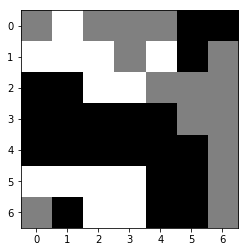

((1, 4), (1, 6)): n_v:  2361 q_all:-0.062589 q:-0.015730 q_m:-0.040000 p:0.207043
((2, 3), (3, 5)): n_v:  2227 q_all:-0.026586 q:-0.090956 q_m:-0.040000 p:0.018332
((1, 4), (2, 4)): n_v:  1747 q_all:-0.081230 q:-0.054128 q_m:-0.020000 p:0.232777
((1, 4), (3, 5)): n_v:   295 q_all:-0.071588 q:-0.094528 q_m:-0.040000 p:0.032655
((1, 4), (0, 4)): n_v:   174 q_all:-0.096112 q:-0.069579 q_m:-0.060000 p:0.029213
((1, 2), (2, 4)): n_v:   154 q_all:-0.090936 q:-0.068325 q_m:-0.040000 p:0.024018
((1, 4), (2, 5)): n_v:   113 q_all:-0.128216 q:-0.085088 q_m:-0.060000 p:0.027384
((2, 3), (0, 4)): n_v:    84 q_all:-0.088989 q:-0.094427 q_m:-0.080000 p:0.012688
((5, 3), (3, 5)): n_v:    67 q_all:-0.121684 q:-0.107113 q_m:-0.040000 p:0.015259
((2, 2), (2, 4)): n_v:    57 q_all:-0.107640 q:-0.080776 q_m:-0.040000 p:0.011077
((0, 1), (0, 2)): n_v:    47 q_all:-0.179815 q:-0.106944 q_m:-0.140000 p:0.017034
((2, 3), (2, 5)): n_v:    22 q_all:-0.115777 q:-0.107562 q_m:-0.080000 p:0.004838
((2, 2), (0, 4))

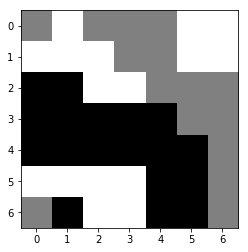

((6, 1), (6, 0)): n_v:  2309 q_all:+0.116499 q:+0.059116 q_m:+0.140000 p:0.275486
((3, 3), (2, 4)): n_v:   987 q_all:+0.092548 q:+0.002172 q_m:+0.140000 p:0.182396
((3, 4), (2, 5)): n_v:   521 q_all:+0.084106 q:+0.024166 q_m:+0.140000 p:0.108754
((2, 0), (0, 2)): n_v:   233 q_all:+0.099157 q:+0.051317 q_m:+0.160000 p:0.038958
((2, 0), (0, 0)): n_v:   225 q_all:+0.124279 q:+0.062031 q_m:+0.160000 p:0.022088
((5, 5), (6, 6)): n_v:   186 q_all:+0.035135 q:-0.009257 q_m:+0.060000 p:0.063731
((4, 0), (6, 0)): n_v:    50 q_all:+0.078361 q:+0.038571 q_m:+0.120000 p:0.011327
((3, 3), (2, 5)): n_v:    16 q_all:+0.036756 q:+0.000184 q_m:+0.120000 p:0.005320
((2, 1), (1, 3)): n_v:    15 q_all:+0.054297 q:+0.040974 q_m:+0.160000 p:0.004423
((3, 2), (1, 3)): n_v:    11 q_all:+0.027307 q:-0.013866 q_m:+0.160000 p:0.004037
((3, 4), (1, 3)): n_v:     9 q_all:+0.088716 q:+0.055787 q_m:+0.160000 p:0.001759
((4, 5), (4, 6)): n_v:     8 q_all:+0.009414 q:-0.013546 q_m:+0.060000 p:0.003592
((3, 3), (1, 3))

((1, 6), (3, 5)): n_v:  2940 q_all:-0.084897 q:-0.082293 q_m:-0.020000 p:0.517393
((1, 5), (3, 5)): n_v:  2254 q_all:-0.063834 q:-0.078080 q_m:-0.020000 p:0.280808
((2, 3), (3, 5)): n_v:   548 q_all:-0.044443 q:-0.060496 q_m:-0.020000 p:0.042349
((5, 3), (3, 5)): n_v:   275 q_all:-0.133911 q:-0.066394 q_m:-0.020000 p:0.081437
((1, 5), (2, 4)): n_v:   105 q_all:-0.087682 q:-0.084625 q_m:-0.040000 p:0.019334
((1, 5), (3, 6)): n_v:    32 q_all:-0.059334 q:-0.122999 q_m:-0.100000 p:0.003724
((1, 6), (3, 6)): n_v:    19 q_all:-0.076009 q:-0.131129 q_m:-0.100000 p:0.002958
((0, 5), (2, 4)): n_v:    10 q_all:-0.118506 q:-0.110174 q_m:-0.060000 p:0.002652
((0, 6), (2, 4)): n_v:     9 q_all:-0.110582 q:-0.099222 q_m:-0.060000 p:0.002174
((1, 6), (2, 4)): n_v:     9 q_all:-0.060698 q:-0.095987 q_m:-0.060000 p:0.001000
((1, 2), (2, 4)): n_v:     6 q_all:-0.132336 q:-0.089850 q_m:-0.060000 p:0.001830
((0, 1), (0, 0)): n_v:     5 q_all:-0.111721 q:-0.068430 q_m:-0.120000 p:0.001321
((1, 5), (2, 5))

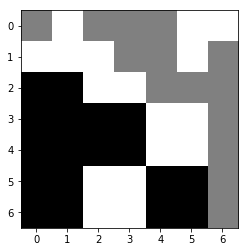

((3, 3), (2, 4)): n_v:  6423 q_all:+0.142840 q:+0.069219 q_m:+0.200000 p:0.596229
((3, 3), (2, 5)): n_v:   713 q_all:+0.069302 q:+0.024088 q_m:+0.140000 p:0.184075
((5, 5), (4, 6)): n_v:   253 q_all:+0.056054 q:+0.065162 q_m:+0.120000 p:0.072968
((4, 3), (2, 5)): n_v:   120 q_all:+0.055803 q:+0.047275 q_m:+0.140000 p:0.034821
((6, 5), (4, 6)): n_v:    85 q_all:+0.061988 q:+0.028812 q_m:+0.100000 p:0.023436
((3, 2), (2, 4)): n_v:    65 q_all:+0.035726 q:+0.014373 q_m:+0.180000 p:0.021823
((5, 5), (5, 6)): n_v:    36 q_all:+0.062455 q:+0.054421 q_m:+0.080000 p:0.010023
((4, 3), (2, 4)): n_v:    35 q_all:+0.077609 q:+0.027276 q_m:+0.180000 p:0.008335
((2, 0), (0, 2)): n_v:    15 q_all:+0.135740 q:+0.094637 q_m:+0.140000 p:0.001640
((6, 4), (4, 6)): n_v:    14 q_all:+0.058441 q:+0.039580 q_m:+0.100000 p:0.004194
((5, 4), (4, 6)): n_v:    14 q_all:+0.087003 q:+0.058851 q_m:+0.100000 p:0.003241
((3, 3), (1, 4)): n_v:    12 q_all:+0.082852 q:-0.000250 q_m:+0.140000 p:0.002850
((4, 2), (2, 4))

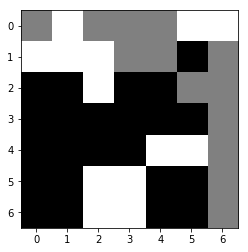

((0, 6), (2, 5)): n_v:  4521 q_all:-0.130624 q:-0.130977 q_m:-0.040000 p:0.587835
((0, 5), (2, 5)): n_v:   806 q_all:-0.079965 q:-0.123148 q_m:-0.040000 p:0.017098
((4, 4), (2, 5)): n_v:   640 q_all:-0.134116 q:-0.129440 q_m:-0.040000 p:0.088132
((0, 6), (1, 4)): n_v:   522 q_all:-0.156492 q:-0.149264 q_m:-0.080000 p:0.096948
((4, 5), (2, 5)): n_v:   517 q_all:-0.125195 q:-0.105223 q_m:-0.040000 p:0.061298
((2, 2), (1, 4)): n_v:   444 q_all:-0.083819 q:-0.170808 q_m:-0.080000 p:0.012071
((4, 4), (5, 6)): n_v:   304 q_all:-0.161603 q:-0.225072 q_m:-0.120000 p:0.059834
((1, 2), (1, 4)): n_v:    93 q_all:-0.147673 q:-0.143809 q_m:-0.080000 p:0.015555
((0, 5), (1, 4)): n_v:    82 q_all:-0.114162 q:-0.125924 q_m:-0.060000 p:0.007812
((0, 6), (2, 6)): n_v:    40 q_all:-0.177176 q:-0.161922 q_m:-0.120000 p:0.009342
((4, 5), (5, 6)): n_v:    38 q_all:-0.158102 q:-0.171187 q_m:-0.100000 p:0.007314
((0, 5), (1, 6)): n_v:    21 q_all:-0.178698 q:-0.143638 q_m:-0.140000 p:0.005120
((2, 2), (0, 4))

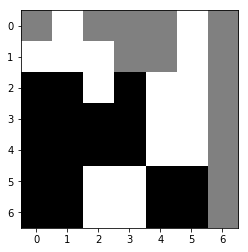

((2, 3), (1, 4)): n_v:  4545 q_all:+0.192805 q:+0.120519 q_m:+0.228000 p:0.357838
((2, 3), (0, 2)): n_v:  1890 q_all:+0.167729 q:+0.084349 q_m:+0.160000 p:0.247560
((2, 3), (1, 3)): n_v:   745 q_all:+0.164537 q:+0.132171 q_m:+0.180000 p:0.102576
((2, 3), (0, 4)): n_v:   328 q_all:+0.117032 q:+0.095499 q_m:+0.120000 p:0.077799
((3, 3), (1, 4)): n_v:   210 q_all:+0.147052 q:+0.053549 q_m:+0.200000 p:0.036630
((2, 0), (0, 2)): n_v:   207 q_all:+0.133222 q:+0.102729 q_m:+0.160000 p:0.042154
((5, 5), (4, 6)): n_v:    90 q_all:+0.106331 q:+0.061193 q_m:+0.140000 p:0.023487
((3, 2), (1, 4)): n_v:    46 q_all:+0.120898 q:+0.086304 q_m:+0.200000 p:0.010698
((5, 5), (5, 6)): n_v:    39 q_all:+0.074327 q:+0.037376 q_m:+0.100000 p:0.012630
((5, 5), (6, 6)): n_v:    31 q_all:+0.053545 q:+0.004871 q_m:+0.060000 p:0.011683
((5, 4), (3, 6)): n_v:    31 q_all:+0.090626 q:+0.066145 q_m:+0.160000 p:0.008877
((3, 3), (1, 3)): n_v:    20 q_all:+0.102995 q:+0.079648 q_m:+0.160000 p:0.005550
((6, 4), (4, 6))

((2, 2), (0, 4)): n_v:  5001 q_all:-0.068686 q:-0.144263 q_m:-0.100000 p:0.105452
((1, 2), (0, 4)): n_v:  1082 q_all:-0.166710 q:-0.143800 q_m:-0.100000 p:0.208205
((1, 2), (1, 3)): n_v:   594 q_all:-0.159028 q:-0.135596 q_m:-0.080000 p:0.100009
((0, 1), (1, 3)): n_v:   365 q_all:-0.178912 q:-0.148574 q_m:-0.100000 p:0.083030
((3, 5), (5, 6)): n_v:   206 q_all:-0.218387 q:-0.176885 q_m:-0.140000 p:0.067721
((3, 5), (1, 6)): n_v:   190 q_all:-0.214208 q:-0.115572 q_m:-0.100000 p:0.060898
((3, 4), (1, 3)): n_v:   181 q_all:-0.245006 q:-0.155570 q_m:-0.100000 p:0.069453
((3, 4), (1, 6)): n_v:   140 q_all:-0.212378 q:-0.133755 q_m:-0.100000 p:0.044365
((3, 5), (1, 3)): n_v:   122 q_all:-0.220360 q:-0.156334 q_m:-0.100000 p:0.040622
((1, 1), (1, 3)): n_v:   108 q_all:-0.215608 q:-0.151256 q_m:-0.100000 p:0.035076
((3, 4), (5, 6)): n_v:    54 q_all:-0.213870 q:-0.180335 q_m:-0.140000 p:0.017452
((1, 0), (0, 2)): n_v:    42 q_all:-0.265545 q:-0.209725 q_m:-0.228000 p:0.018011
((4, 5), (5, 6))

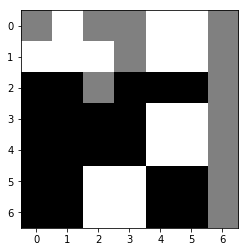

((2, 5), (0, 6)): n_v:  5491 q_all:+0.159275 q:+0.090436 q_m:+0.180000 p:0.006896
((2, 1), (2, 2)): n_v:  1057 q_all:+0.081960 q:+0.186333 q_m:+0.200000 p:0.084624
((2, 3), (1, 3)): n_v:   859 q_all:+0.034410 q:+0.125411 q_m:+0.256000 p:0.184318
((2, 0), (0, 0)): n_v:   667 q_all:+0.051313 q:+0.130339 q_m:+0.228000 p:0.111285
((2, 4), (2, 2)): n_v:   474 q_all:+0.104287 q:+0.151312 q_m:+0.180000 p:0.008001
((2, 1), (0, 0)): n_v:   366 q_all:+0.087620 q:+0.185019 q_m:+0.228000 p:0.023435
((2, 5), (2, 6)): n_v:   164 q_all:+0.097176 q:+0.100560 q_m:+0.200000 p:0.006095
((2, 3), (0, 2)): n_v:   133 q_all:+0.050898 q:+0.162715 q_m:+0.228000 p:0.022391
((5, 5), (4, 6)): n_v:    89 q_all:+0.063444 q:+0.122241 q_m:+0.200000 p:0.011892
((4, 3), (2, 2)): n_v:    86 q_all:+0.054455 q:+0.099042 q_m:+0.180000 p:0.013603
((4, 0), (2, 2)): n_v:    85 q_all:+0.052104 q:+0.072365 q_m:+0.180000 p:0.013995
((2, 4), (0, 6)): n_v:    63 q_all:+0.050918 q:+0.088106 q_m:+0.180000 p:0.010659
((3, 2), (1, 3))

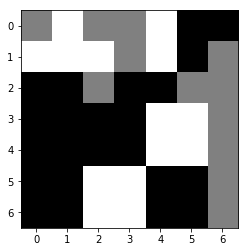

((3, 5), (1, 6)): n_v:  6420 q_all:-0.067651 q:-0.127303 q_m:-0.060000 p:0.242058
((3, 5), (5, 6)): n_v:  1159 q_all:-0.186317 q:-0.184310 q_m:-0.100000 p:0.288848
((0, 4), (2, 2)): n_v:   660 q_all:-0.111261 q:-0.121515 q_m:+0.020000 p:0.030780
((3, 4), (1, 6)): n_v:   577 q_all:-0.141579 q:-0.113537 q_m:-0.060000 p:0.074255
((0, 4), (1, 6)): n_v:   349 q_all:-0.182783 q:-0.153939 q_m:-0.060000 p:0.083747
((4, 5), (5, 6)): n_v:   271 q_all:-0.177385 q:-0.180454 q_m:-0.080000 p:0.061046
((3, 4), (5, 6)): n_v:   242 q_all:-0.194183 q:-0.173320 q_m:-0.100000 p:0.065636
((1, 4), (1, 6)): n_v:   188 q_all:-0.148630 q:-0.113948 q_m:-0.060000 p:0.027838
((1, 1), (2, 2)): n_v:   183 q_all:-0.132142 q:-0.094507 q_m:+0.040000 p:0.018932
((1, 4), (2, 2)): n_v:   146 q_all:-0.108001 q:-0.100746 q_m:+0.020000 p:0.005497
((4, 4), (5, 6)): n_v:   108 q_all:-0.235032 q:-0.234348 q_m:-0.100000 p:0.039579
((3, 4), (2, 2)): n_v:    74 q_all:-0.139183 q:-0.098683 q_m:+0.020000 p:0.009137
((1, 0), (2, 2))

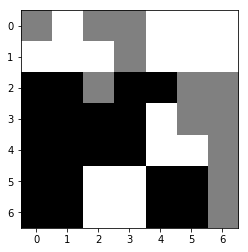

((2, 3), (3, 5)): n_v:  3391 q_all:+0.155008 q:+0.059751 q_m:+0.180000 p:0.079356
((3, 3), (2, 5)): n_v:  2441 q_all:+0.081120 q:+0.084035 q_m:+0.228000 p:0.288278
((2, 4), (2, 5)): n_v:  1628 q_all:+0.097047 q:+0.130526 q_m:+0.256000 p:0.118589
((2, 1), (2, 2)): n_v:  1275 q_all:+0.129445 q:+0.105012 q_m:+0.160000 p:0.009639
((4, 3), (2, 5)): n_v:   657 q_all:+0.072626 q:+0.069660 q_m:+0.228000 p:0.087859
((2, 3), (2, 5)): n_v:   402 q_all:+0.094433 q:+0.090268 q_m:+0.228000 p:0.031955
((2, 4), (3, 5)): n_v:   337 q_all:+0.073293 q:+0.077333 q_m:+0.200000 p:0.044610
((2, 3), (1, 3)): n_v:   264 q_all:+0.017057 q:+0.049737 q_m:+0.200000 p:0.067875
((2, 3), (0, 2)): n_v:   189 q_all:+0.035424 q:+0.064667 q_m:+0.180000 p:0.041013
((5, 5), (3, 5)): n_v:   135 q_all:+0.052403 q:+0.057120 q_m:+0.180000 p:0.024398
((4, 3), (3, 5)): n_v:   119 q_all:+0.022044 q:+0.035174 q_m:+0.180000 p:0.029429
((2, 1), (0, 0)): n_v:    85 q_all:+0.103272 q:+0.038317 q_m:+0.180000 p:0.004895
((5, 4), (3, 5))

((1, 4), (2, 2)): n_v:  5700 q_all:-0.068137 q:-0.086497 q_m:-0.020000 p:0.057288
((0, 6), (2, 5)): n_v:   620 q_all:-0.171507 q:-0.066710 q_m:-0.060000 p:0.128926
((1, 4), (2, 5)): n_v:   398 q_all:-0.151684 q:-0.022620 q_m:-0.040000 p:0.055608
((0, 4), (2, 2)): n_v:   325 q_all:-0.151594 q:-0.088079 q_m:-0.020000 p:0.045297
((1, 2), (2, 3)): n_v:   320 q_all:-0.149492 q:-0.070767 q_m:-0.000000 p:0.042245
((0, 4), (2, 3)): n_v:   263 q_all:-0.165844 q:-0.101611 q_m:-0.020000 p:0.049752
((0, 4), (2, 5)): n_v:   191 q_all:-0.165620 q:-0.070837 q_m:-0.060000 p:0.035886
((1, 1), (2, 2)): n_v:    90 q_all:-0.139612 q:-0.031656 q_m:-0.000000 p:0.008945
((0, 1), (2, 2)): n_v:    86 q_all:-0.153015 q:-0.073260 q_m:-0.020000 p:0.012404
((0, 5), (2, 5)): n_v:    81 q_all:-0.165093 q:-0.087660 q_m:-0.060000 p:0.015050
((1, 0), (2, 2)): n_v:    75 q_all:-0.154512 q:-0.063124 q_m:-0.020000 p:0.011348
((1, 1), (2, 3)): n_v:    35 q_all:-0.155450 q:-0.082633 q_m:-0.020000 p:0.005426
((1, 5), (2, 3))

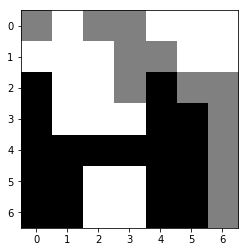

((2, 4), (2, 3)): n_v: 10211 q_all:+0.125881 q:+0.062825 q_m:+0.200000 p:0.425137
((2, 4), (1, 3)): n_v:   133 q_all:+0.028581 q:+0.012581 q_m:+0.160000 p:0.025936
((4, 5), (2, 3)): n_v:    62 q_all:+0.059012 q:+0.064986 q_m:+0.180000 p:0.007112
((2, 4), (0, 2)): n_v:    51 q_all:+0.071963 q:+0.040366 q_m:+0.140000 p:0.004130
((2, 0), (0, 2)): n_v:    45 q_all:+0.065976 q:+0.021824 q_m:+0.140000 p:0.004293
((3, 5), (2, 3)): n_v:    30 q_all:+0.053162 q:+0.063607 q_m:+0.180000 p:0.003970
((2, 4), (1, 4)): n_v:    26 q_all:+0.016464 q:+0.048803 q_m:+0.160000 p:0.005934
((4, 1), (2, 3)): n_v:    18 q_all:-0.003926 q:+0.024338 q_m:+0.180000 p:0.004991
((2, 4), (2, 5)): n_v:    16 q_all:+0.008664 q:+0.021119 q_m:+0.120000 p:0.004021
((3, 4), (1, 3)): n_v:    11 q_all:+0.057523 q:-0.019350 q_m:+0.140000 p:0.001323
((4, 4), (2, 3)): n_v:     8 q_all:-0.010863 q:+0.037398 q_m:+0.180000 p:0.002228
((2, 0), (0, 0)): n_v:     7 q_all:+0.065005 q:+0.027739 q_m:+0.140000 p:0.000692
((4, 3), (2, 5))

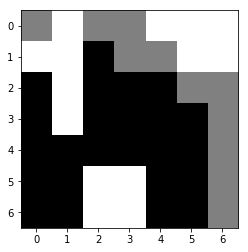

((0, 4), (1, 3)): n_v:  9543 q_all:-0.102794 q:-0.114894 q_m:-0.020000 p:0.418724
((1, 5), (2, 5)): n_v:  1511 q_all:-0.128195 q:-0.065703 q_m:-0.060000 p:0.128052
((0, 6), (2, 5)): n_v:  1392 q_all:-0.075600 q:-0.095386 q_m:-0.080000 p:0.010337
((1, 5), (1, 3)): n_v:   578 q_all:-0.130752 q:-0.103152 q_m:-0.040000 p:0.051961
((0, 1), (1, 3)): n_v:   475 q_all:-0.134397 q:-0.116315 q_m:-0.040000 p:0.046108
((0, 5), (1, 3)): n_v:   463 q_all:-0.115828 q:-0.109082 q_m:-0.040000 p:0.028015
((1, 1), (1, 3)): n_v:   264 q_all:-0.138348 q:-0.120187 q_m:-0.040000 p:0.027592
((3, 1), (1, 3)): n_v:   243 q_all:-0.121969 q:-0.126365 q_m:-0.040000 p:0.017700
((2, 1), (1, 3)): n_v:    82 q_all:-0.140327 q:-0.134904 q_m:-0.040000 p:0.008818
((0, 5), (2, 5)): n_v:    26 q_all:-0.140546 q:-0.101369 q_m:-0.080000 p:0.002768
((0, 4), (2, 5)): n_v:    16 q_all:-0.137332 q:-0.082270 q_m:-0.080000 p:0.001723
((1, 6), (1, 4)): n_v:     7 q_all:-0.173830 q:-0.137071 q_m:-0.120000 p:0.001312
((1, 5), (3, 6))

((3, 5), (1, 4)): n_v:  5971 q_all:+0.211638 q:+0.121643 q_m:+0.284000 p:0.016616
((3, 2), (1, 4)): n_v:  2894 q_all:+0.136976 q:+0.087942 q_m:+0.284000 p:0.129334
((3, 4), (2, 5)): n_v:  1633 q_all:+0.085117 q:+0.078924 q_m:+0.160000 p:0.246455
((3, 4), (1, 4)): n_v:   545 q_all:+0.132501 q:+0.090698 q_m:+0.284000 p:0.029310
((2, 0), (0, 2)): n_v:   253 q_all:+0.110524 q:+0.077677 q_m:+0.180000 p:0.024993
((3, 3), (1, 4)): n_v:   205 q_all:+0.125706 q:+0.077319 q_m:+0.284000 p:0.013840
((4, 4), (2, 5)): n_v:    73 q_all:+0.043764 q:+0.059148 q_m:+0.140000 p:0.017158
((4, 5), (2, 5)): n_v:    67 q_all:+0.069929 q:+0.066704 q_m:+0.140000 p:0.012297
((3, 3), (2, 5)): n_v:    41 q_all:+0.053746 q:+0.022570 q_m:+0.140000 p:0.008990
((3, 5), (2, 6)): n_v:    30 q_all:+0.048580 q:+0.083518 q_m:+0.120000 p:0.006951
((4, 3), (2, 5)): n_v:    26 q_all:+0.051942 q:+0.045521 q_m:+0.140000 p:0.005659
((5, 5), (6, 6)): n_v:    14 q_all:+0.021362 q:+0.021241 q_m:+0.040000 p:0.004078
((3, 5), (4, 6))

((0, 6), (2, 5)): n_v:  4503 q_all:-0.144366 q:-0.110488 q_m:-0.100000 p:0.138755
((1, 6), (3, 5)): n_v:  1944 q_all:-0.153002 q:-0.156032 q_m:-0.100000 p:0.108257
((1, 2), (0, 3)): n_v:  1611 q_all:-0.248722 q:-0.143211 q_m:-0.120000 p:0.383963
((0, 1), (0, 3)): n_v:  1225 q_all:-0.206835 q:-0.130741 q_m:-0.140000 p:0.192365
((1, 6), (2, 5)): n_v:  1043 q_all:-0.168719 q:-0.091728 q_m:-0.080000 p:0.067636
((1, 1), (0, 3)): n_v:   197 q_all:-0.278466 q:-0.170603 q_m:-0.140000 p:0.058267
((5, 3), (3, 5)): n_v:    72 q_all:-0.219683 q:-0.163622 q_m:-0.100000 p:0.013164
((2, 1), (0, 3)): n_v:    66 q_all:-0.298016 q:-0.202558 q_m:-0.140000 p:0.021832
((2, 2), (0, 3)): n_v:    32 q_all:-0.264013 q:-0.254238 q_m:-0.140000 p:0.008788
((1, 6), (3, 6)): n_v:    11 q_all:-0.265851 q:-0.257883 q_m:-0.228000 p:0.003223
((1, 0), (0, 2)): n_v:     1 q_all:-0.268296 q:-0.227274 q_m:-0.228000 p:0.000224
((2, 2), (0, 0)): n_v:     1 q_all:-0.271056 q:-0.287876 q_m:-0.284000 p:0.000356
((0, 1), (0, 0))

((4, 4), (3, 5)): n_v:  8339 q_all:+0.207605 q:+0.126603 q_m:+0.256000 p:0.276305
((1, 3), (0, 2)): n_v:   787 q_all:+0.119513 q:+0.105506 q_m:+0.256000 p:0.145031
((4, 5), (2, 6)): n_v:    90 q_all:+0.146483 q:+0.131279 q_m:+0.228000 p:0.009346
((0, 4), (0, 2)): n_v:    87 q_all:+0.133364 q:+0.085127 q_m:+0.228000 p:0.012566
((0, 5), (0, 6)): n_v:    13 q_all:+0.123689 q:+0.103305 q_m:+0.200000 p:0.002399
((0, 4), (0, 3)): n_v:    13 q_all:+0.097513 q:+0.096056 q_m:+0.200000 p:0.003358
((5, 5), (3, 5)): n_v:    11 q_all:+0.103557 q:+0.094667 q_m:+0.228000 p:0.002684
((4, 5), (3, 6)): n_v:    11 q_all:+0.072476 q:+0.062410 q_m:+0.160000 p:0.003567
((2, 0), (0, 2)): n_v:     9 q_all:+0.095632 q:+0.077714 q_m:+0.228000 p:0.002482
((1, 3), (3, 5)): n_v:     7 q_all:+0.136057 q:+0.146786 q_m:+0.228000 p:0.001072
((3, 3), (3, 5)): n_v:     5 q_all:+0.063785 q:+0.078835 q_m:+0.228000 p:0.001822
((5, 5), (6, 6)): n_v:     4 q_all:+0.019738 q:+0.022687 q_m:+0.120000 p:0.001811
((2, 3), (3, 5))

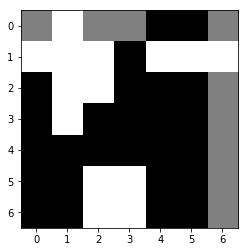

((1, 4), (3, 6)): n_v:  5245 q_all:-0.096533 q:-0.163487 q_m:-0.120000 p:0.037130
((1, 6), (3, 6)): n_v:  4277 q_all:-0.206128 q:-0.165794 q_m:-0.120000 p:0.522179
((1, 5), (3, 6)): n_v:  2771 q_all:-0.208112 q:-0.174734 q_m:-0.120000 p:0.350294
((0, 1), (0, 3)): n_v:   188 q_all:-0.195874 q:-0.154866 q_m:-0.160000 p:0.018790
((1, 2), (0, 3)): n_v:    59 q_all:-0.222837 q:-0.164586 q_m:-0.140000 p:0.009463
((1, 5), (2, 6)): n_v:    47 q_all:-0.229721 q:-0.175165 q_m:-0.140000 p:0.008315
((1, 4), (2, 6)): n_v:    13 q_all:-0.223220 q:-0.197650 q_m:-0.160000 p:0.002146
((0, 1), (0, 0)): n_v:    13 q_all:-0.277114 q:-0.211666 q_m:-0.228000 p:0.003868
((1, 1), (0, 3)): n_v:    12 q_all:-0.257378 q:-0.188647 q_m:-0.160000 p:0.002923
((1, 5), (0, 6)): n_v:    10 q_all:-0.239318 q:-0.196815 q_m:-0.180000 p:0.001994
((2, 1), (0, 3)): n_v:     9 q_all:-0.290508 q:-0.243183 q_m:-0.160000 p:0.002686
((1, 5), (0, 3)): n_v:     7 q_all:-0.241596 q:-0.204744 q_m:-0.160000 p:0.001493
((1, 0), (0, 2))

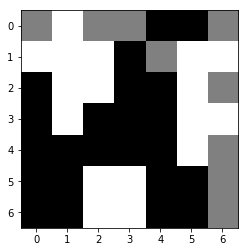

((5, 5), (4, 6)): n_v:  6465 q_all:+0.161139 q:+0.157649 q_m:+0.284000 p:0.438446
((0, 5), (2, 6)): n_v:  1093 q_all:+0.122143 q:+0.173902 q_m:+0.368000 p:0.132010
((6, 5), (4, 6)): n_v:   831 q_all:+0.092821 q:+0.121522 q_m:+0.256000 p:0.168660
((0, 4), (2, 6)): n_v:   692 q_all:+0.121973 q:+0.149799 q_m:+0.368000 p:0.083977
((6, 4), (4, 6)): n_v:   498 q_all:+0.073229 q:+0.101335 q_m:+0.256000 p:0.120426
((1, 3), (0, 2)): n_v:   338 q_all:+0.130012 q:+0.161179 q_m:+0.284000 p:0.033454
((0, 4), (1, 4)): n_v:   140 q_all:+0.162032 q:+0.141382 q_m:+0.228000 p:0.001483
((2, 4), (4, 6)): n_v:    35 q_all:+0.115085 q:+0.075731 q_m:+0.256000 p:0.004835
((2, 4), (2, 6)): n_v:    10 q_all:+0.135651 q:+0.146040 q_m:+0.368000 p:0.000787
((4, 4), (2, 6)): n_v:     8 q_all:+0.125115 q:+0.174476 q_m:+0.368000 p:0.000912
((2, 0), (0, 2)): n_v:     5 q_all:+0.150784 q:+0.126866 q_m:+0.256000 p:0.000230
((5, 4), (4, 6)): n_v:     5 q_all:+0.041088 q:+0.091326 q_m:+0.256000 p:0.001707
((0, 4), (0, 2))

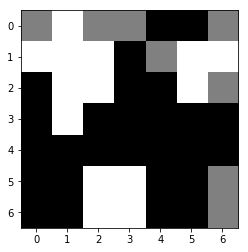

((1, 5), (1, 4)): n_v:  6353 q_all:-0.145580 q:-0.090987 q_m:-0.040000 p:0.395976
((1, 6), (1, 4)): n_v:  4908 q_all:-0.151158 q:-0.115857 q_m:-0.060000 p:0.356964
((1, 2), (1, 4)): n_v:    57 q_all:-0.190751 q:-0.133851 q_m:-0.060000 p:0.008327
((2, 2), (1, 4)): n_v:    51 q_all:-0.263871 q:-0.237667 q_m:-0.060000 p:0.014663
((0, 1), (0, 3)): n_v:     2 q_all:-0.358013 q:-0.309948 q_m:-0.180000 p:0.001013
((2, 5), (0, 3)): n_v:     0 q_all:-0.259049 q:-0.311749 q_m:-0.180000 p:0.000049
((1, 0), (0, 2)): n_v:     0 q_all:-0.359605 q:-0.447342 q_m:-0.228000 p:0.000268
((2, 2), (0, 2)): n_v:     0 q_all:-0.333532 q:-0.403886 q_m:-0.228000 p:0.000006
((2, 1), (0, 3)): n_v:     0 q_all:-0.317382 q:-0.408970 q_m:-0.180000 p:0.000033
((2, 5), (0, 6)): n_v:     0 q_all:-0.310863 q:-0.366105 q_m:-0.228000 p:0.000000
((1, 5), (0, 3)): n_v:     0 q_all:-0.267766 q:-0.326276 q_m:-0.180000 p:0.000191
((1, 2), (0, 0)): n_v:     0 q_all:-0.325625 q:-0.353375 q_m:-0.284000 p:0.000003
((1, 2), (0, 3))

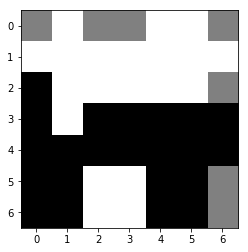

((2, 0), (0, 2)): n_v:  5865 q_all:+0.190735 q:+0.042141 q_m:+0.200000 p:0.159288
((3, 5), (2, 6)): n_v:  4384 q_all:+0.170126 q:+0.289117 q_m:+0.180000 p:0.287079
((4, 6), (2, 6)): n_v:    62 q_all:+0.150409 q:+0.200397 q_m:+0.160000 p:0.006402
((2, 0), (0, 0)): n_v:    17 q_all:+0.129869 q:+0.055453 q_m:+0.160000 p:0.002498
((4, 5), (2, 6)): n_v:    15 q_all:+0.072919 q:+0.164059 q_m:+0.160000 p:0.003857
((5, 5), (6, 6)): n_v:    12 q_all:+0.037808 q:+0.051220 q_m:+0.060000 p:0.003980
((4, 5), (5, 6)): n_v:     3 q_all:+0.060895 q:+0.063628 q_m:+0.060000 p:0.001077
((4, 4), (2, 6)): n_v:     1 q_all:+0.025158 q:+0.115028 q_m:+0.160000 p:0.000412
((3, 4), (2, 6)): n_v:     1 q_all:+0.038684 q:+0.087352 q_m:+0.160000 p:0.000468
((6, 4), (6, 6)): n_v:     1 q_all:-0.012912 q:+0.009646 q_m:+0.040000 p:0.000426
((5, 4), (6, 6)): n_v:     0 q_all:+0.018534 q:-0.013664 q_m:+0.040000 p:0.000015
((4, 4), (6, 6)): n_v:     0 q_all:+0.019646 q:-0.010886 q_m:+0.040000 p:0.000039
((3, 5), (5, 6))

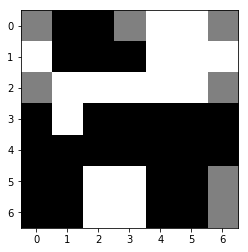

((0, 4), (0, 3)): n_v:  7151 q_all:-0.136405 q:-0.148542 q_m:-0.060000 p:0.189910
((2, 1), (0, 3)): n_v:  1255 q_all:-0.202350 q:-0.186017 q_m:-0.080000 p:0.184038
((0, 5), (0, 3)): n_v:  1109 q_all:-0.194473 q:-0.214093 q_m:-0.080000 p:0.139845
((1, 0), (2, 0)): n_v:   330 q_all:-0.205516 q:-0.257984 q_m:-0.100000 p:0.051027
((2, 5), (0, 3)): n_v:   305 q_all:-0.194043 q:-0.155762 q_m:-0.080000 p:0.038210
((2, 4), (0, 3)): n_v:   130 q_all:-0.222998 q:-0.190159 q_m:-0.080000 p:0.025114
((1, 5), (2, 6)): n_v:   123 q_all:-0.198042 q:-0.195514 q_m:-0.100000 p:0.016709
((2, 2), (0, 3)): n_v:   101 q_all:-0.222677 q:-0.250195 q_m:-0.080000 p:0.019537
((1, 5), (0, 3)): n_v:    51 q_all:-0.240869 q:-0.168334 q_m:-0.080000 p:0.011766
((2, 3), (0, 3)): n_v:    14 q_all:-0.240761 q:-0.236663 q_m:-0.080000 p:0.002988
((2, 4), (2, 6)): n_v:    11 q_all:-0.243728 q:-0.131701 q_m:-0.120000 p:0.002694
((0, 5), (2, 6)): n_v:     9 q_all:-0.206858 q:-0.179356 q_m:-0.120000 p:0.001520
((0, 4), (2, 6))

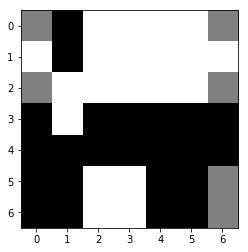

((3, 5), (2, 6)): n_v: 10064 q_all:+0.206264 q:+0.196731 q_m:+0.200000 p:0.241836
((1, 1), (2, 0)): n_v:  1630 q_all:+0.127685 q:+0.129549 q_m:+0.200000 p:0.136253
((4, 6), (2, 6)): n_v:    94 q_all:+0.119675 q:+0.108487 q_m:+0.180000 p:0.009650
((4, 0), (2, 0)): n_v:    64 q_all:+0.084886 q:+0.051958 q_m:+0.180000 p:0.011805
((0, 1), (2, 0)): n_v:    15 q_all:+0.107089 q:+0.046475 q_m:+0.180000 p:0.002099
((4, 2), (2, 0)): n_v:     6 q_all:+0.041766 q:+0.032786 q_m:+0.180000 p:0.001639
((4, 5), (2, 6)): n_v:     4 q_all:+0.076373 q:+0.088800 q_m:+0.180000 p:0.001016
((3, 4), (2, 6)): n_v:     4 q_all:+0.063651 q:+0.057024 q_m:+0.180000 p:0.000974
((4, 1), (2, 0)): n_v:     2 q_all:+0.037410 q:+0.069068 q_m:+0.180000 p:0.000840
((4, 4), (2, 6)): n_v:     1 q_all:+0.037551 q:+0.061026 q_m:+0.180000 p:0.000411
((3, 2), (2, 0)): n_v:     1 q_all:+0.016172 q:-0.009015 q_m:+0.180000 p:0.000563
((5, 5), (6, 6)): n_v:     0 q_all:+0.032686 q:-0.038284 q_m:+0.080000 p:0.000011
((4, 4), (6, 6))

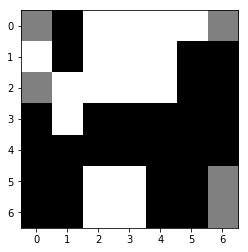

((0, 5), (0, 6)): n_v:  7474 q_all:-0.136001 q:-0.023929 q_m:-0.100000 p:0.014075
((1, 0), (2, 0)): n_v:  4146 q_all:-0.204355 q:-0.175399 q_m:-0.100000 p:0.249892
((0, 2), (2, 0)): n_v:   737 q_all:-0.270060 q:-0.222522 q_m:-0.120000 p:0.140735
((0, 4), (0, 6)): n_v:   409 q_all:-0.216736 q:-0.148356 q_m:-0.120000 p:0.034701
((2, 4), (0, 6)): n_v:   244 q_all:-0.203758 q:-0.061099 q_m:-0.120000 p:0.014170
((2, 2), (2, 0)): n_v:   151 q_all:-0.292204 q:-0.230818 q_m:-0.120000 p:0.035521
((0, 2), (0, 0)): n_v:   143 q_all:-0.270251 q:-0.226431 q_m:-0.120000 p:0.027423
((1, 2), (2, 0)): n_v:   111 q_all:-0.282288 q:-0.206641 q_m:-0.120000 p:0.023794
((1, 0), (0, 0)): n_v:   103 q_all:-0.230037 q:-0.172164 q_m:-0.100000 p:0.011218
((2, 1), (0, 0)): n_v:    82 q_all:-0.257751 q:-0.208973 q_m:-0.120000 p:0.013721
((2, 2), (0, 0)): n_v:    20 q_all:-0.324138 q:-0.285848 q_m:-0.120000 p:0.005830
((1, 2), (0, 0)): n_v:     8 q_all:-0.266419 q:-0.189660 q_m:-0.120000 p:0.001262
((1, 4), (0, 6))

((1, 1), (2, 0)): n_v: 10874 q_all:+0.290103 q:+0.281354 q_m:+0.256000 p:0.486433
((0, 1), (2, 0)): n_v:   228 q_all:+0.130352 q:+0.130607 q_m:+0.228000 p:0.030323
((4, 0), (2, 0)): n_v:   199 q_all:+0.083517 q:+0.152637 q_m:+0.228000 p:0.047957
((4, 1), (2, 0)): n_v:    30 q_all:+0.029174 q:+0.205911 q_m:+0.228000 p:0.010449
((4, 5), (5, 6)): n_v:    16 q_all:+0.056076 q:+0.149794 q_m:+0.120000 p:0.004906
((5, 5), (6, 6)): n_v:     9 q_all:+0.021796 q:+0.046644 q_m:+0.120000 p:0.003559
((0, 1), (0, 0)): n_v:     9 q_all:+0.031911 q:+0.120831 q_m:+0.160000 p:0.003342
((4, 2), (2, 0)): n_v:     5 q_all:+0.068148 q:+0.104306 q_m:+0.228000 p:0.001614
((3, 2), (2, 0)): n_v:     3 q_all:+0.052925 q:+0.094181 q_m:+0.228000 p:0.001178
((5, 4), (6, 6)): n_v:     0 q_all:+0.041440 q:-0.046401 q_m:+0.100000 p:0.000010
((4, 4), (6, 6)): n_v:     0 q_all:+0.025046 q:-0.087386 q_m:+0.100000 p:0.000005
((4, 4), (5, 6)): n_v:     0 q_all:+0.038532 q:-0.053670 q_m:+0.100000 p:0.000002
((5, 4), (5, 6))

((0, 2), (0, 0)): n_v: 13068 q_all:-0.279897 q:-0.105746 q_m:-0.120000 p:0.689316
((2, 2), (0, 0)): n_v:  1430 q_all:-0.363528 q:-0.158334 q_m:-0.120000 p:0.265405
((1, 2), (0, 0)): n_v:   141 q_all:-0.392031 q:-0.183969 q_m:-0.120000 p:0.031571
-1 's turn
one move takes time(s):  0.20457196235656738


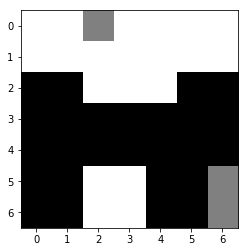

((2, 0), (0, 2)): n_v: 13948 q_all:+0.578486 q:+0.461921 q_m:+0.368000 p:0.688219
((5, 5), (6, 6)): n_v:   484 q_all:+0.208321 q:+0.079662 q_m:+0.140000 p:0.156044
((4, 5), (5, 6)): n_v:    77 q_all:+0.276952 q:+0.276661 q_m:+0.140000 p:0.015678
((2, 1), (0, 2)): n_v:    69 q_all:+0.284467 q:+0.363413 q_m:+0.368000 p:0.013084
((6, 4), (5, 6)): n_v:     1 q_all:+0.049651 q:+0.073895 q_m:+0.120000 p:0.000559
((3, 6), (5, 6)): n_v:     1 q_all:+0.020214 q:+0.107378 q_m:+0.120000 p:0.000524
((5, 4), (6, 6)): n_v:     0 q_all:+0.093590 q:+0.053976 q_m:+0.120000 p:0.000034
((4, 4), (6, 6)): n_v:     0 q_all:+0.073059 q:+0.002648 q_m:+0.120000 p:0.000003
((3, 5), (5, 6)): n_v:     0 q_all:+0.228285 q:+0.300474 q_m:+0.120000 p:0.000028
((4, 4), (5, 6)): n_v:     0 q_all:+0.118805 q:+0.117012 q_m:+0.120000 p:0.000029
((5, 4), (5, 6)): n_v:     0 q_all:+0.104154 q:+0.080385 q_m:+0.120000 p:0.000267
((4, 6), (6, 6)): n_v:     0 q_all:+0.075524 q:+0.008810 q_m:+0.120000 p:0.000130
((3, 4), (5, 6))

((0, 0), (2, 0)): n_v: 12547 q_all:-0.769205 q:-0.354242 q_m:-0.160000 p:0.875300
((1, 0), (2, 0)): n_v:  1770 q_all:-0.759806 q:-0.339190 q_m:-0.140000 p:0.099175
((2, 2), (2, 0)): n_v:   247 q_all:-0.791791 q:-0.442340 q_m:-0.160000 p:0.025422
-1 's turn
one move takes time(s):  0.1415843963623047


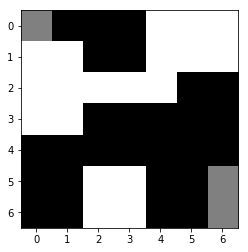

((0, 1), (0, 0)): n_v: 13521 q_all:+1.000000 q:+5.000000 q_m:+0.284000 p:0.814710
((5, 5), (6, 6)): n_v:    52 q_all:+0.419993 q:+0.385904 q_m:+0.180000 p:0.049139
((4, 5), (5, 6)): n_v:    10 q_all:+0.506386 q:+0.509337 q_m:+0.180000 p:0.008478
((6, 4), (5, 6)): n_v:     6 q_all:+0.194995 q:+0.194764 q_m:+0.160000 p:0.007971
((0, 2), (0, 0)): n_v:     5 q_all:+0.398856 q:+0.275483 q_m:+0.256000 p:0.005577
((5, 4), (6, 6)): n_v:     0 q_all:+0.119199 q:+0.057999 q_m:+0.160000 p:0.000013
((4, 4), (6, 6)): n_v:     0 q_all:+0.088060 q:-0.019850 q_m:+0.160000 p:0.000006
((3, 5), (5, 6)): n_v:     0 q_all:+0.481464 q:+0.695774 q_m:+0.160000 p:0.000020
((4, 4), (5, 6)): n_v:     0 q_all:+0.114827 q:+0.047067 q_m:+0.160000 p:0.000071
((5, 4), (5, 6)): n_v:     0 q_all:+0.152817 q:+0.142042 q_m:+0.160000 p:0.000858
((4, 6), (6, 6)): n_v:     0 q_all:+0.124928 q:+0.072320 q_m:+0.160000 p:0.000438
((3, 4), (5, 6)): n_v:     0 q_all:+0.240511 q:+0.294186 q_m:+0.160000 p:0.000059
((6, 4), (6, 6))

15354/15354 [==============================] - 2s 130us/step - loss: 1.9577 - activation_101_loss: 1.9247 - dense_51_loss: 0.0057 - val_loss: 2.1521 - val_activation_101_loss: 2.1191 - val_dense_51_loss: 0.0058
Epoch 2/64
15354/15354 [==============================] - 2s 106us/step - loss: 1.9169 - activation_101_loss: 1.8847 - dense_51_loss: 0.0050 - val_loss: 2.1506 - val_activation_101_loss: 2.1177 - val_dense_51_loss: 0.0056
Epoch 3/64
15354/15354 [==============================] - 2s 107us/step - loss: 1.8940 - activation_101_loss: 1.8623 - dense_51_loss: 0.0045 - val_loss: 2.1547 - val_activation_101_loss: 2.1216 - val_dense_51_loss: 0.0058
Epoch 4/64
15354/15354 [==============================] - 2s 106us/step - loss: 1.8803 - activation_101_loss: 1.8488 - dense_51_loss: 0.0042 - val_loss: 2.1594 - val_activation_101_loss: 2.1264 - val_dense_51_loss: 0.0058
Epoch 5/64
15354/15354 [==============================] - 2s 106us/step - loss: 1.8701 - activation_101_loss: 1.8387 - dens

due to rollout lim, final rollout times:  1001 time elapsed:  2.1116557121276855


This is a random move


one move takes time(s):  2.1130268573760986
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.469619035720825
one move takes time(s):  3.471219301223755
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.755952835083008
one move takes time(s):  3.757251262664795
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.8738133907318115
one move takes time(s):  2.875178098678589
-1 's turn
due to rollout lim, final rollout times:  1786 time elapsed:  2.0031747817993164


This is a random move


one move takes time(s):  2.0044913291931152
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.462909460067749
one move takes time(s):  2.464343309402466
-1 's turn
due to rollout lim, final rollout times:  2544 time elapsed:  2.0000569820404053
one move takes time(s):  2.00127911567688
1 's turn
due to ro

due to rollout lim, final rollout times:  2003 time elapsed:  2.000068187713623
one move takes time(s):  2.0012590885162354
-1 's turn
due to rollout lim, final rollout times:  2342 time elapsed:  2.0010244846343994
one move takes time(s):  2.0027222633361816
1 's turn
due to rollout lim, final rollout times:  3599 time elapsed:  2.0004916191101074
one move takes time(s):  2.0016889572143555
-1 's turn
due to rollout lim, final rollout times:  3401 time elapsed:  2.004293203353882


This is a random move


one move takes time(s):  2.0058460235595703
1 's turn
due to rollout lim, final rollout times:  3433 time elapsed:  2.0065252780914307
one move takes time(s):  2.007798671722412
-1 's turn
due to rollout lim, final rollout times:  3379 time elapsed:  2.007262945175171
one move takes time(s):  2.0085296630859375
1 's turn
one move takes time(s):  1.3524248600006104
-1 's turn
one move takes time(s):  1.6980268955230713
1 's turn
one move takes time(s):  0.8799262046813965
-1 's turn
o

due to rollout lim, final rollout times:  1001 time elapsed:  4.426286935806274
one move takes time(s):  4.42779016494751
1 's turn
due to rollout lim, final rollout times:  1340 time elapsed:  2.000321388244629
one move takes time(s):  2.0018362998962402
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  4.550291299819946
one move takes time(s):  4.551781415939331
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.961364269256592
one move takes time(s):  2.9626424312591553
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  7.064894676208496
one move takes time(s):  7.066746950149536
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.1096177101135254
one move takes time(s):  2.111168384552002
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  5.206956148147583
one move takes time(s):  5.208866357803345
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.

due to rollout lim, final rollout times:  1455 time elapsed:  2.000126361846924
one move takes time(s):  2.0015451908111572
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.235621452331543
one move takes time(s):  2.2370996475219727
-1 's turn
due to rollout lim, final rollout times:  1773 time elapsed:  2.000051736831665
one move takes time(s):  2.0012595653533936
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.4196982383728027


This is a random move


one move takes time(s):  2.420999765396118
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.0734455585479736
one move takes time(s):  2.0748260021209717
1 's turn
one move takes time(s):  1.4859519004821777
-1 's turn
due to rollout lim, final rollout times:  1027 time elapsed:  2.015540838241577


This is a random move


one move takes time(s):  2.0191168785095215
1 's turn
due to rollout lim, final rollout times:  2101 time elapsed:  2.0216386318206787
one m

due to rollout lim, final rollout times:  1412 time elapsed:  2.000065803527832
one move takes time(s):  2.001361846923828
-1 's turn
due to rollout lim, final rollout times:  1923 time elapsed:  2.0121328830718994
one move takes time(s):  2.0134127140045166
1 's turn
due to rollout lim, final rollout times:  1335 time elapsed:  2.0157907009124756


This is a random move


one move takes time(s):  2.0182652473449707
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.3636913299560547
one move takes time(s):  2.365342855453491
1 's turn
due to rollout lim, final rollout times:  3520 time elapsed:  2.002812147140503
one move takes time(s):  2.0040836334228516
-1 's turn
due to rollout lim, final rollout times:  4740 time elapsed:  2.0040135383605957


This is a random move


one move takes time(s):  2.005204916000366
1 's turn
due to rollout lim, final rollout times:  2593 time elapsed:  2.0101377964019775
one move takes time(s):  2.0113959312438965
-1 's turn
due 

due to rollout lim, final rollout times:  4514 time elapsed:  2.000013589859009
one move takes time(s):  2.00140380859375
1 's turn
one move takes time(s):  1.7013351917266846
-1 's turn
due to rollout lim, final rollout times:  2286 time elapsed:  2.0121281147003174
one move takes time(s):  2.0134143829345703
1 's turn
due to rollout lim, final rollout times:  1306 time elapsed:  2.000051259994507
one move takes time(s):  2.001328229904175
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.2938194274902344
one move takes time(s):  2.295135736465454
1 's turn
due to rollout lim, final rollout times:  1127 time elapsed:  2.0136899948120117
one move takes time(s):  2.0149929523468018
-1 's turn
due to rollout lim, final rollout times:  1242 time elapsed:  2.000053882598877
one move takes time(s):  2.0013928413391113
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.4870781898498535
one move takes time(s):  2.4884438514709473
-1 's turn
due 

11974/11974 [==============================] - 2s 136us/step - loss: 1.9749 - activation_101_loss: 1.9431 - dense_51_loss: 0.0046 - val_loss: 2.2046 - val_activation_101_loss: 2.1693 - val_dense_51_loss: 0.0081
Epoch 2/64
11974/11974 [==============================] - 1s 116us/step - loss: 1.9366 - activation_101_loss: 1.9054 - dense_51_loss: 0.0039 - val_loss: 2.1765 - val_activation_101_loss: 2.1412 - val_dense_51_loss: 0.0081
Epoch 3/64
11974/11974 [==============================] - 1s 108us/step - loss: 1.9174 - activation_101_loss: 1.8864 - dense_51_loss: 0.0037 - val_loss: 2.1601 - val_activation_101_loss: 2.1255 - val_dense_51_loss: 0.0073
Epoch 4/64
11974/11974 [==============================] - 1s 105us/step - loss: 1.9031 - activation_101_loss: 1.8725 - dense_51_loss: 0.0034 - val_loss: 2.1464 - val_activation_101_loss: 2.1122 - val_dense_51_loss: 0.0069
Epoch 5/64
11974/11974 [==============================] - 1s 106us/step - loss: 1.8938 - activation_101_loss: 1.8631 - dens

Epoch 38/64
11974/11974 [==============================] - 1s 106us/step - loss: 1.8044 - activation_101_loss: 1.7752 - dense_51_loss: 0.0019 - val_loss: 2.1016 - val_activation_101_loss: 2.0684 - val_dense_51_loss: 0.0059
Epoch 39/64
11974/11974 [==============================] - 1s 105us/step - loss: 1.8034 - activation_101_loss: 1.7742 - dense_51_loss: 0.0019 - val_loss: 2.1007 - val_activation_101_loss: 2.0677 - val_dense_51_loss: 0.0058
Epoch 40/64
11974/11974 [==============================] - 1s 106us/step - loss: 1.8026 - activation_101_loss: 1.7735 - dense_51_loss: 0.0018 - val_loss: 2.1028 - val_activation_101_loss: 2.0695 - val_dense_51_loss: 0.0061
Epoch 41/64
11974/11974 [==============================] - 1s 105us/step - loss: 1.8023 - activation_101_loss: 1.7731 - dense_51_loss: 0.0018 - val_loss: 2.1066 - val_activation_101_loss: 2.0736 - val_dense_51_loss: 0.0056
Epoch 00041: early stopping
saving files
episode 72 finished
episode 73 now start
it seems the reset did not



This is a random move


one move takes time(s):  1.730238676071167
1 's turn


This is a random move


one move takes time(s):  1.8046200275421143
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.1585428714752197


This is a random move


one move takes time(s):  2.159968137741089
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.2017295360565186
one move takes time(s):  2.202968120574951
-1 's turn
due to rollout lim, final rollout times:  4107 time elapsed:  2.0000476837158203
one move takes time(s):  2.001235008239746
1 's turn
one move takes time(s):  1.4743223190307617
-1 's turn


This is a random move


one move takes time(s):  1.1720645427703857
1 's turn
one move takes time(s):  1.8013029098510742
-1 's turn
due to rollout lim, final rollout times:  3772 time elapsed:  2.0044643878936768
one move takes time(s):  2.0056324005126953
1 's turn
due to rollout lim, final rollout times:  2383 time elapsed:  2.013134717941284
one mo

due to rollout lim, final rollout times:  3862 time elapsed:  2.000138282775879
one move takes time(s):  2.0015108585357666
1 's turn
due to rollout lim, final rollout times:  4865 time elapsed:  2.011826992034912
one move takes time(s):  2.013113498687744
-1 's turn
one move takes time(s):  1.9708309173583984
1 's turn
due to rollout lim, final rollout times:  3362 time elapsed:  2.0010323524475098
one move takes time(s):  2.0022292137145996
-1 's turn


This is a random move


one move takes time(s):  1.7224714756011963
1 's turn
one move takes time(s):  1.887544870376587
-1 's turn
due to rollout lim, final rollout times:  2886 time elapsed:  2.0000393390655518
one move takes time(s):  2.0013113021850586
1 's turn
one move takes time(s):  1.5775246620178223
-1 's turn
due to rollout lim, final rollout times:  4352 time elapsed:  2.01175856590271
one move takes time(s):  2.0130269527435303
1 's turn
due to rollout lim, final rollout times:  4677 time elapsed:  2.0039284229278564
one 

due to rollout lim, final rollout times:  1001 time elapsed:  2.1823456287384033
one move takes time(s):  2.183566093444824
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.7027134895324707
one move takes time(s):  3.7041282653808594
-1 's turn
due to rollout lim, final rollout times:  1510 time elapsed:  2.0000407695770264
one move takes time(s):  2.001589298248291
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.1513500213623047
one move takes time(s):  3.152766466140747
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.2247133255004883
one move takes time(s):  2.226005792617798
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.553621530532837
one move takes time(s):  2.555123805999756
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.410522699356079
one move takes time(s):  2.411806344985962
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:

due to rollout lim, final rollout times:  1314 time elapsed:  2.0000693798065186
one move takes time(s):  2.002667188644409
1 's turn
due to rollout lim, final rollout times:  1767 time elapsed:  2.0000667572021484
one move takes time(s):  2.001384735107422
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.122925043106079
one move takes time(s):  2.124220848083496
1 's turn
due to rollout lim, final rollout times:  1494 time elapsed:  2.00072979927063
one move takes time(s):  2.001955509185791
-1 's turn
due to rollout lim, final rollout times:  1175 time elapsed:  2.0001423358917236
one move takes time(s):  2.0013928413391113
1 's turn
due to rollout lim, final rollout times:  1435 time elapsed:  2.0084166526794434


This is a random move


one move takes time(s):  2.0097970962524414
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.402740955352783
one move takes time(s):  3.403991460800171
1 's turn
due to rollout lim, final rollout t

due to rollout lim, final rollout times:  1552 time elapsed:  2.006824254989624
one move takes time(s):  2.0081677436828613
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.009890556335449
one move takes time(s):  2.011349678039551
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.0539498329162598
one move takes time(s):  2.0552499294281006
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.8088409900665283
one move takes time(s):  2.8100554943084717
1 's turn
due to rollout lim, final rollout times:  1423 time elapsed:  2.0000834465026855
one move takes time(s):  2.001375913619995
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.473397970199585
one move takes time(s):  2.4749653339385986
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.6964826583862305


This is a random move


one move takes time(s):  2.6979141235351562
-1 's turn
due to rollout lim, final roll

11954/11954 [==============================] - 2s 137us/step - loss: 2.0324 - activation_101_loss: 1.9973 - dense_51_loss: 0.0078 - val_loss: 2.3895 - val_activation_101_loss: 2.3521 - val_dense_51_loss: 0.0102
Epoch 2/64
11954/11954 [==============================] - 1s 109us/step - loss: 1.9698 - activation_101_loss: 1.9367 - dense_51_loss: 0.0057 - val_loss: 2.3587 - val_activation_101_loss: 2.3222 - val_dense_51_loss: 0.0092
Epoch 3/64
11954/11954 [==============================] - 1s 104us/step - loss: 1.9327 - activation_101_loss: 1.9006 - dense_51_loss: 0.0049 - val_loss: 2.3429 - val_activation_101_loss: 2.3070 - val_dense_51_loss: 0.0087
Epoch 4/64
11954/11954 [==============================] - 1s 105us/step - loss: 1.9126 - activation_101_loss: 1.8810 - dense_51_loss: 0.0044 - val_loss: 2.3322 - val_activation_101_loss: 2.2962 - val_dense_51_loss: 0.0088
Epoch 5/64
11954/11954 [==============================] - 1s 104us/step - loss: 1.8970 - activation_101_loss: 1.8656 - dens

due to rollout lim, final rollout times:  1001 time elapsed:  4.073610782623291
one move takes time(s):  4.074886083602905
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.0204827785491943
one move takes time(s):  2.0216519832611084
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.31111478805542
one move takes time(s):  2.312410593032837
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.5611729621887207
one move takes time(s):  2.5624895095825195
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.317370891571045
one move takes time(s):  2.3190386295318604
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.309987783432007
one move takes time(s):  2.311224937438965
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.35697340965271
one move takes time(s):  2.3585731983184814
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed: 

due to rollout lim, final rollout times:  1001 time elapsed:  2.224299669265747
one move takes time(s):  2.225529193878174
1 's turn
due to rollout lim, final rollout times:  2184 time elapsed:  2.0009374618530273
one move takes time(s):  2.0022261142730713
-1 's turn
one move takes time(s):  1.6119568347930908
1 's turn
one move takes time(s):  1.129786729812622
-1 's turn
one move takes time(s):  1.3328523635864258
1 's turn
one move takes time(s):  1.1191716194152832
-1 's turn
due to rollout lim, final rollout times:  2183 time elapsed:  2.0080578327178955
one move takes time(s):  2.0093421936035156
1 's turn
due to rollout lim, final rollout times:  3256 time elapsed:  2.0000948905944824
one move takes time(s):  2.0016510486602783
-1 's turn
due to rollout lim, final rollout times:  3851 time elapsed:  2.0089962482452393
one move takes time(s):  2.0102319717407227
1 's turn
due to rollout lim, final rollout times:  4628 time elapsed:  2.003126382827759
one move takes time(s):  2.0

this round has steps: 58, time taken: 3.2290537357330322, 


self wins? False



round: 14
it seems the reset did nothing
reset successful
this game start with 45 space left
this round has steps: 62, time taken: 1.9103782176971436, 


self wins? True



round: 15
it seems the reset did nothing
reset successful
this game start with 45 space left
this round has steps: 61, time taken: 3.1631500720977783, 


self wins? True



round: 16
it seems the reset did nothing
reset successful
this game start with 45 space left
this round has steps: 63, time taken: 2.398059129714966, 


self wins? True



round: 17
it seems the reset did nothing
reset successful
this game start with 45 space left
this round has steps: 64, time taken: 3.297588348388672, 


self wins? True



round: 18
it seems the reset did nothing
reset successful
this game start with 45 space left
this round has steps: 69, time taken: 3.3447110652923584, 


self wins? True



round: 19
it seems the reset did nothing
reset successfu

one move takes time(s):  1.2464158535003662
1 's turn
one move takes time(s):  1.4172585010528564
-1 's turn
one move takes time(s):  1.063894271850586
1 's turn
one move takes time(s):  0.896742582321167
-1 's turn
one move takes time(s):  1.298532247543335
1 's turn
one move takes time(s):  1.5130724906921387
-1 's turn
due to rollout lim, final rollout times:  4902 time elapsed:  2.0001003742218018
one move takes time(s):  2.001316547393799
1 's turn
one move takes time(s):  1.7286865711212158
-1 's turn
one move takes time(s):  1.9824252128601074
1 's turn
due to rollout lim, final rollout times:  3804 time elapsed:  2.0000245571136475
one move takes time(s):  2.001154899597168
-1 's turn
due to rollout lim, final rollout times:  3019 time elapsed:  2.013502359390259


This is a random move


one move takes time(s):  2.015810489654541
1 's turn
due to rollout lim, final rollout times:  4625 time elapsed:  2.0000901222229004


This is a random move


one move takes time(s):  2.00144

due to rollout lim, final rollout times:  2919 time elapsed:  2.0088889598846436
one move takes time(s):  2.0099234580993652
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.3037703037261963
one move takes time(s):  2.3052618503570557
1 's turn


This is a random move


one move takes time(s):  1.7905845642089844
-1 's turn
due to rollout lim, final rollout times:  3366 time elapsed:  2.0003340244293213
one move takes time(s):  2.0023202896118164
1 's turn
due to rollout lim, final rollout times:  1270 time elapsed:  2.00001859664917
one move takes time(s):  2.001095771789551
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.165562629699707
one move takes time(s):  2.1670358180999756
1 's turn
due to rollout lim, final rollout times:  4062 time elapsed:  2.00009822845459
one move takes time(s):  2.0013115406036377
-1 's turn
due to rollout lim, final rollout times:  2741 time elapsed:  2.0001380443573


This is a random move


one move

one move takes time(s):  1.406454086303711
-1 's turn
due to rollout lim, final rollout times:  4898 time elapsed:  2.0000104904174805
one move takes time(s):  2.00128436088562
1 's turn


This is a random move


one move takes time(s):  1.613408088684082
-1 's turn
one move takes time(s):  1.7384111881256104
1 's turn


This is a random move


one move takes time(s):  1.2248311042785645
-1 's turn
one move takes time(s):  1.7158277034759521
1 's turn
one move takes time(s):  1.9765324592590332
-1 's turn
one move takes time(s):  1.3723740577697754
1 's turn
one move takes time(s):  1.462005615234375
-1 's turn
due to rollout lim, final rollout times:  4834 time elapsed:  2.000002145767212
one move takes time(s):  2.0012736320495605
1 's turn
due to rollout lim, final rollout times:  2468 time elapsed:  2.0097692012786865
one move takes time(s):  2.0110461711883545
-1 's turn
one move takes time(s):  1.6338367462158203
1 's turn


This is a random move


one move takes time(s):  1.3712

due to rollout lim, final rollout times:  3312 time elapsed:  2.0082004070281982
one move takes time(s):  2.0093882083892822
1 's turn
due to rollout lim, final rollout times:  1773 time elapsed:  2.004922389984131
one move takes time(s):  2.0062243938446045
-1 's turn
due to rollout lim, final rollout times:  3074 time elapsed:  2.0106325149536133
one move takes time(s):  2.011875629425049
1 's turn
due to rollout lim, final rollout times:  1211 time elapsed:  2.0001003742218018
one move takes time(s):  2.0014073848724365
-1 's turn
due to rollout lim, final rollout times:  2724 time elapsed:  2.000102996826172
one move takes time(s):  2.0013113021850586
1 's turn


This is a random move


one move takes time(s):  1.3617572784423828
-1 's turn
one move takes time(s):  1.320542573928833
1 's turn
due to rollout lim, final rollout times:  3600 time elapsed:  2.004734992980957
one move takes time(s):  2.0059728622436523
-1 's turn


This is a random move


one move takes time(s):  0.9913

start training, training data no. 14072
Train on 11961 samples, validate on 2111 samples
Epoch 1/64
11961/11961 [==============================] - 6s 482us/step - loss: 1.9729 - activation_101_loss: 1.9396 - dense_51_loss: 0.0061 - val_loss: 2.0710 - val_activation_101_loss: 2.0382 - val_dense_51_loss: 0.0056
Epoch 2/64
11961/11961 [==============================] - 1s 110us/step - loss: 1.9312 - activation_101_loss: 1.8990 - dense_51_loss: 0.0050 - val_loss: 2.0672 - val_activation_101_loss: 2.0346 - val_dense_51_loss: 0.0054
Epoch 3/64
11961/11961 [==============================] - 1s 105us/step - loss: 1.9085 - activation_101_loss: 1.8768 - dense_51_loss: 0.0045 - val_loss: 2.0656 - val_activation_101_loss: 2.0323 - val_dense_51_loss: 0.0061
Epoch 4/64
11961/11961 [==============================] - 1s 104us/step - loss: 1.8938 - activation_101_loss: 1.8623 - dense_51_loss: 0.0043 - val_loss: 2.0663 - val_activation_101_loss: 2.0336 - val_dense_51_loss: 0.0056
Epoch 5/64
11961/11961 

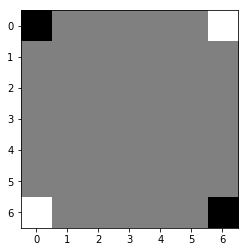

((6, 6), (5, 5)): n_v:  1628 q_all:+0.011463 q:+0.003683 q_m:+0.020000 p:0.323434
((0, 0), (1, 1)): n_v:  1451 q_all:+0.010620 q:-0.002700 q_m:+0.020000 p:0.291526
((6, 6), (5, 6)): n_v:   530 q_all:+0.010819 q:-0.001457 q_m:+0.020000 p:0.106384
((0, 0), (1, 0)): n_v:   486 q_all:+0.010873 q:-0.006158 q_m:+0.020000 p:0.097312
((6, 6), (6, 5)): n_v:   453 q_all:+0.012737 q:+0.006413 q_m:+0.020000 p:0.088318
((0, 0), (0, 1)): n_v:   414 q_all:+0.011363 q:-0.001792 q_m:+0.020000 p:0.082489
((6, 6), (4, 5)): n_v:     8 q_all:-0.001162 q:-0.013042 q_m:-0.000000 p:0.001935
((6, 6), (5, 4)): n_v:     6 q_all:+0.000827 q:-0.009196 q_m:-0.000000 p:0.001539
((0, 0), (2, 1)): n_v:     6 q_all:-0.001350 q:-0.014990 q_m:-0.000000 p:0.001493
((0, 0), (1, 2)): n_v:     5 q_all:+0.004353 q:-0.014788 q_m:-0.000000 p:0.001277
((0, 0), (2, 2)): n_v:     3 q_all:-0.000705 q:-0.037008 q_m:-0.000000 p:0.000801
((6, 6), (4, 4)): n_v:     3 q_all:+0.003138 q:-0.005480 q_m:-0.000000 p:0.000865
((6, 6), (6, 4))

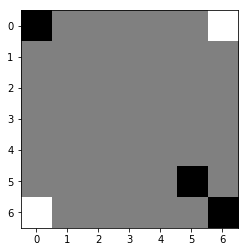

((6, 0), (5, 1)): n_v:  1921 q_all:-0.008608 q:-0.018963 q_m:-0.000000 p:0.285690
((0, 6), (1, 5)): n_v:  1516 q_all:-0.008585 q:-0.008039 q_m:-0.000000 p:0.225374
((6, 0), (5, 0)): n_v:   953 q_all:-0.010696 q:-0.015911 q_m:-0.000000 p:0.146574
((6, 0), (6, 1)): n_v:   836 q_all:-0.009923 q:-0.014435 q_m:-0.000000 p:0.127128
((0, 6), (0, 5)): n_v:   706 q_all:-0.009274 q:-0.013145 q_m:-0.000000 p:0.106268
((0, 6), (1, 6)): n_v:   664 q_all:-0.010606 q:-0.005365 q_m:-0.000000 p:0.102018
((6, 0), (6, 2)): n_v:     6 q_all:-0.018150 q:-0.023031 q_m:-0.020000 p:0.001002
((6, 0), (5, 2)): n_v:     6 q_all:-0.007292 q:-0.020876 q_m:-0.020000 p:0.000974
((0, 6), (0, 4)): n_v:     4 q_all:-0.016064 q:-0.023995 q_m:-0.020000 p:0.000658
((6, 0), (4, 1)): n_v:     3 q_all:-0.015662 q:-0.024721 q_m:-0.020000 p:0.000655
((6, 0), (4, 0)): n_v:     3 q_all:-0.018255 q:-0.018995 q_m:-0.020000 p:0.000591
((0, 6), (1, 4)): n_v:     3 q_all:-0.020914 q:-0.014436 q_m:-0.020000 p:0.000705
((0, 6), (2, 4))

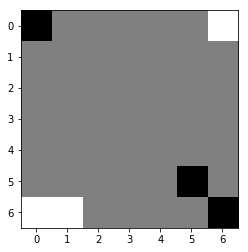

((0, 0), (1, 1)): n_v:   907 q_all:+0.008634 q:-0.010948 q_m:+0.020000 p:0.137365
((5, 5), (4, 6)): n_v:   841 q_all:+0.007132 q:-0.002341 q_m:+0.020000 p:0.130684
((0, 0), (1, 0)): n_v:   715 q_all:+0.008063 q:-0.014052 q_m:+0.020000 p:0.109434
((5, 5), (5, 4)): n_v:   659 q_all:+0.008937 q:+0.003325 q_m:+0.020000 p:0.099242
((5, 5), (6, 4)): n_v:   562 q_all:+0.011312 q:+0.003281 q_m:+0.020000 p:0.081246
((5, 5), (4, 5)): n_v:   537 q_all:+0.007404 q:+0.000552 q_m:+0.020000 p:0.083122
((0, 0), (0, 1)): n_v:   503 q_all:+0.008514 q:-0.009684 q_m:+0.020000 p:0.076348
((5, 5), (5, 6)): n_v:   476 q_all:+0.008340 q:-0.002462 q_m:+0.020000 p:0.072531
((5, 5), (6, 5)): n_v:   351 q_all:+0.010333 q:+0.001536 q_m:+0.020000 p:0.051589
((5, 5), (4, 4)): n_v:   240 q_all:+0.010708 q:-0.002789 q_m:+0.020000 p:0.035128
((0, 0), (1, 2)): n_v:     7 q_all:-0.000634 q:-0.021475 q_m:-0.000000 p:0.001319
((5, 5), (3, 6)): n_v:     6 q_all:+0.008264 q:-0.019898 q_m:-0.000000 p:0.000976
((0, 0), (2, 1))

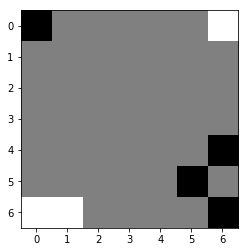

((6, 1), (6, 2)): n_v:  1068 q_all:-0.011248 q:-0.014815 q_m:-0.000000 p:0.144881
((0, 6), (1, 6)): n_v:  1032 q_all:-0.004920 q:-0.021488 q_m:-0.000000 p:0.122839
((0, 6), (1, 5)): n_v:   979 q_all:-0.002758 q:-0.026183 q_m:-0.000000 p:0.110928
((6, 0), (5, 0)): n_v:   874 q_all:-0.013122 q:-0.037005 q_m:-0.000000 p:0.122839
((6, 1), (5, 2)): n_v:   701 q_all:-0.011167 q:-0.027158 q_m:-0.000000 p:0.094868
((6, 0), (5, 1)): n_v:   683 q_all:-0.010764 q:-0.033370 q_m:-0.000000 p:0.091762
((0, 6), (0, 5)): n_v:   427 q_all:-0.012290 q:-0.024441 q_m:-0.000000 p:0.059154
((6, 1), (4, 1)): n_v:     9 q_all:-0.019183 q:-0.010820 q_m:-0.020000 p:0.001472
((0, 6), (0, 4)): n_v:     5 q_all:-0.021465 q:-0.036106 q_m:-0.020000 p:0.000820
((6, 0), (6, 2)): n_v:     4 q_all:+0.000272 q:-0.027986 q_m:-0.020000 p:0.000493
((6, 0), (4, 0)): n_v:     4 q_all:-0.021364 q:-0.025665 q_m:-0.020000 p:0.000673
((6, 0), (4, 1)): n_v:     4 q_all:-0.021733 q:-0.033018 q_m:-0.020000 p:0.000707
((0, 6), (2, 5))

((0, 0), (1, 1)): n_v:  1633 q_all:+0.006483 q:-0.023396 q_m:+0.020000 p:0.361476
((4, 6), (3, 5)): n_v:   760 q_all:+0.028289 q:-0.025397 q_m:+0.020000 p:0.117586
((0, 0), (1, 0)): n_v:   528 q_all:+0.007249 q:-0.026498 q_m:+0.020000 p:0.115660
((4, 6), (3, 6)): n_v:   410 q_all:+0.029642 q:-0.029400 q_m:+0.020000 p:0.061811
((4, 6), (5, 6)): n_v:   310 q_all:+0.005812 q:-0.011361 q_m:+0.020000 p:0.069440
((0, 0), (0, 1)): n_v:   178 q_all:+0.006330 q:-0.022815 q_m:+0.020000 p:0.039551
((5, 5), (6, 4)): n_v:   117 q_all:+0.019489 q:-0.012362 q_m:+0.020000 p:0.021424
((5, 5), (4, 4)): n_v:    89 q_all:+0.026438 q:-0.003881 q_m:+0.020000 p:0.014354
((5, 5), (6, 5)): n_v:    83 q_all:+0.010897 q:-0.002990 q_m:+0.020000 p:0.017341
((5, 5), (5, 4)): n_v:    80 q_all:+0.018578 q:-0.008720 q_m:+0.020000 p:0.014885
((4, 6), (4, 5)): n_v:    39 q_all:+0.009106 q:-0.034756 q_m:+0.020000 p:0.008457
((4, 6), (2, 5)): n_v:    11 q_all:-0.032601 q:-0.051680 q_m:-0.000000 p:0.004086
((4, 6), (2, 6))

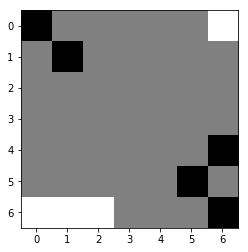

((0, 6), (1, 6)): n_v:  1130 q_all:-0.005700 q:-0.032917 q_m:-0.000000 p:0.221967
((0, 6), (0, 5)): n_v:   859 q_all:-0.008933 q:-0.039645 q_m:-0.000000 p:0.178003
((6, 0), (5, 0)): n_v:   588 q_all:-0.013695 q:-0.061571 q_m:-0.000000 p:0.130875
((0, 6), (1, 5)): n_v:   529 q_all:-0.002791 q:-0.035834 q_m:-0.000000 p:0.098997
((6, 0), (5, 1)): n_v:   194 q_all:-0.011079 q:-0.063173 q_m:-0.000000 p:0.041493
((6, 2), (5, 3)): n_v:   143 q_all:+0.032583 q:-0.029268 q_m:-0.000000 p:0.010309
((6, 1), (5, 2)): n_v:   138 q_all:-0.005061 q:-0.026837 q_m:-0.000000 p:0.026794
((6, 2), (6, 3)): n_v:    57 q_all:+0.018173 q:-0.021126 q_m:-0.000000 p:0.006861
((6, 2), (5, 4)): n_v:    32 q_all:-0.036006 q:-0.001683 q_m:+0.020000 p:0.009381
((6, 2), (5, 0)): n_v:    19 q_all:-0.027118 q:-0.054440 q_m:-0.020000 p:0.005108
((6, 2), (6, 4)): n_v:     6 q_all:-0.031056 q:-0.001397 q_m:+0.020000 p:0.001703
((0, 6), (0, 4)): n_v:     5 q_all:-0.016842 q:-0.041552 q_m:-0.020000 p:0.001329
((0, 6), (1, 4))

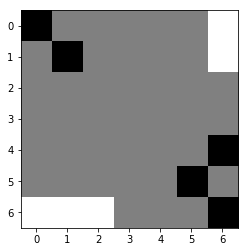

((4, 6), (3, 6)): n_v:   442 q_all:+0.018007 q:-0.031989 q_m:+0.020000 p:0.164532
((4, 6), (3, 5)): n_v:   289 q_all:+0.015536 q:-0.019481 q_m:+0.020000 p:0.110738
((0, 0), (1, 0)): n_v:   171 q_all:+0.011289 q:-0.026350 q_m:+0.020000 p:0.068899
((5, 5), (6, 4)): n_v:   167 q_all:+0.021480 q:-0.011039 q_m:+0.020000 p:0.059823
((1, 1), (0, 2)): n_v:   146 q_all:+0.013202 q:-0.017144 q_m:+0.020000 p:0.057359
((4, 6), (5, 6)): n_v:   135 q_all:+0.015394 q:-0.009806 q_m:+0.020000 p:0.051832
((1, 1), (2, 0)): n_v:   127 q_all:+0.014030 q:-0.017364 q_m:+0.020000 p:0.049688
((1, 1), (2, 1)): n_v:   107 q_all:+0.013923 q:-0.027585 q_m:+0.020000 p:0.041845
((0, 0), (0, 1)): n_v:    90 q_all:+0.009734 q:-0.037990 q_m:+0.020000 p:0.036849
((1, 1), (2, 2)): n_v:    75 q_all:+0.011618 q:-0.025683 q_m:+0.020000 p:0.030370
((5, 5), (6, 5)): n_v:    57 q_all:+0.015448 q:-0.008267 q_m:+0.020000 p:0.021881
((1, 1), (1, 2)): n_v:    56 q_all:+0.014707 q:-0.011092 q_m:+0.020000 p:0.021786
((5, 5), (4, 4))

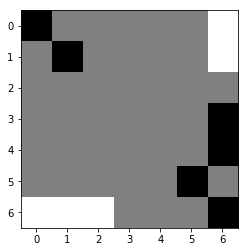

((1, 6), (2, 5)): n_v:  2131 q_all:+0.030858 q:-0.027290 q_m:+0.040000 p:0.299934
((1, 6), (2, 6)): n_v:  1734 q_all:+0.035246 q:-0.031246 q_m:+0.040000 p:0.222070
((6, 0), (5, 0)): n_v:   238 q_all:-0.060269 q:-0.063696 q_m:-0.000000 p:0.096288
((0, 6), (1, 5)): n_v:   160 q_all:+0.010928 q:-0.039755 q_m:-0.000000 p:0.031791
((1, 6), (3, 5)): n_v:   159 q_all:-0.022929 q:-0.016421 q_m:+0.060000 p:0.047291
((6, 2), (5, 3)): n_v:    99 q_all:+0.021298 q:-0.031798 q_m:-0.000000 p:0.016577
((0, 6), (0, 5)): n_v:    34 q_all:-0.097178 q:-0.041042 q_m:-0.000000 p:0.017400
((6, 2), (5, 0)): n_v:    27 q_all:-0.080906 q:-0.054019 q_m:-0.020000 p:0.012898
((6, 2), (5, 4)): n_v:    27 q_all:-0.006646 q:-0.007496 q_m:+0.020000 p:0.006872
((6, 1), (5, 2)): n_v:    24 q_all:-0.060924 q:-0.025027 q_m:-0.000000 p:0.009922
((6, 0), (5, 1)): n_v:    23 q_all:-0.045312 q:-0.059904 q_m:-0.000000 p:0.008629
((6, 2), (6, 3)): n_v:    17 q_all:-0.008582 q:-0.021738 q_m:-0.000000 p:0.004523
((0, 6), (2, 5))

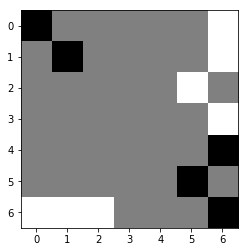

((4, 6), (2, 6)): n_v:  4352 q_all:-0.001980 q:-0.001253 q_m:+0.080000 p:0.500608
((4, 6), (3, 5)): n_v:  2442 q_all:-0.025123 q:-0.032661 q_m:+0.060000 p:0.414881
((4, 6), (2, 4)): n_v:   120 q_all:-0.055574 q:-0.075298 q_m:-0.000000 p:0.029174
((5, 5), (3, 5)): n_v:    55 q_all:-0.042681 q:-0.045353 q_m:+0.040000 p:0.011754
((1, 1), (2, 0)): n_v:    32 q_all:-0.111297 q:-0.035346 q_m:-0.020000 p:0.012311
((4, 6), (3, 4)): n_v:    12 q_all:+0.013284 q:-0.075475 q_m:-0.000000 p:0.001025
((1, 1), (3, 1)): n_v:    10 q_all:-0.057128 q:-0.037043 q_m:-0.040000 p:0.002206
((0, 0), (1, 0)): n_v:     9 q_all:-0.108075 q:-0.047276 q_m:-0.020000 p:0.003660
((1, 1), (2, 2)): n_v:     6 q_all:-0.101538 q:-0.038308 q_m:-0.020000 p:0.002044
((0, 0), (0, 1)): n_v:     6 q_all:-0.107391 q:-0.083906 q_m:-0.020000 p:0.002403
((0, 0), (2, 0)): n_v:     6 q_all:-0.123069 q:-0.060552 q_m:-0.040000 p:0.002342
((4, 6), (4, 5)): n_v:     6 q_all:-0.037052 q:-0.044839 q_m:+0.020000 p:0.001314
((5, 5), (4, 4))

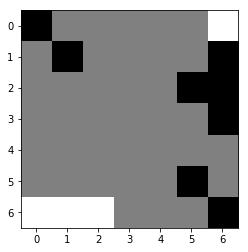

((0, 6), (1, 5)): n_v:  9021 q_all:+0.015250 q:-0.010540 q_m:+0.060000 p:0.834478
((6, 0), (5, 1)): n_v:   155 q_all:-0.051757 q:-0.100504 q_m:-0.060000 p:0.035926
((0, 6), (0, 5)): n_v:    58 q_all:-0.096418 q:-0.047083 q_m:-0.020000 p:0.018790
((6, 2), (5, 3)): n_v:    28 q_all:-0.035296 q:-0.083170 q_m:-0.060000 p:0.005469
((0, 6), (0, 4)): n_v:    17 q_all:-0.082505 q:-0.080704 q_m:-0.080000 p:0.005076
((6, 0), (5, 0)): n_v:     8 q_all:-0.085554 q:-0.104773 q_m:-0.060000 p:0.002502
((0, 6), (2, 4)): n_v:     6 q_all:-0.072195 q:-0.051681 q_m:-0.040000 p:0.001905
((6, 1), (5, 2)): n_v:     3 q_all:-0.091212 q:-0.071619 q_m:-0.060000 p:0.001062
((0, 6), (1, 4)): n_v:     2 q_all:-0.080000 q:-0.049399 q_m:-0.040000 p:0.000598
((6, 2), (4, 0)): n_v:     2 q_all:-0.095896 q:-0.075742 q_m:-0.080000 p:0.000946
((6, 2), (6, 3)): n_v:     1 q_all:-0.087065 q:-0.079523 q_m:-0.060000 p:0.000569
((6, 2), (6, 4)): n_v:     1 q_all:-0.083783 q:-0.071963 q_m:-0.040000 p:0.000387
((6, 0), (4, 0))

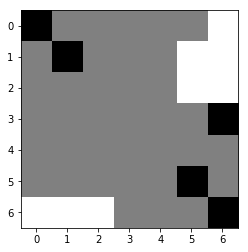

((3, 6), (3, 5)): n_v: 10967 q_all:-0.004197 q:-0.042559 q_m:+0.040000 p:0.858929
((5, 5), (3, 5)): n_v:   321 q_all:-0.020732 q:-0.056957 q_m:+0.020000 p:0.034572
((3, 6), (5, 6)): n_v:    91 q_all:-0.072224 q:-0.115064 q_m:-0.060000 p:0.018114
((5, 5), (4, 4)): n_v:    65 q_all:-0.072329 q:-0.073404 q_m:-0.040000 p:0.013115
((3, 6), (2, 4)): n_v:    54 q_all:-0.036912 q:-0.064600 q_m:+0.020000 p:0.007467
((1, 1), (2, 2)): n_v:    52 q_all:-0.057700 q:-0.073110 q_m:-0.040000 p:0.009135
((1, 1), (3, 1)): n_v:    41 q_all:-0.066336 q:-0.068777 q_m:-0.060000 p:0.007829
((3, 6), (1, 4)): n_v:    40 q_all:-0.017952 q:-0.049844 q_m:+0.020000 p:0.004207
((5, 5), (6, 5)): n_v:    26 q_all:-0.035939 q:-0.081989 q_m:-0.040000 p:0.003625
((0, 0), (0, 1)): n_v:    20 q_all:-0.057297 q:-0.111862 q_m:-0.040000 p:0.003499
((5, 5), (5, 4)): n_v:    18 q_all:-0.072350 q:-0.072833 q_m:-0.040000 p:0.003579
((3, 6), (4, 4)): n_v:    15 q_all:-0.076392 q:-0.088132 q_m:-0.060000 p:0.003249
((5, 5), (6, 4))

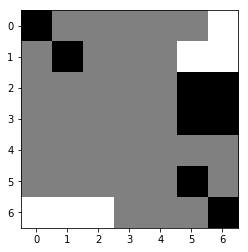

((1, 5), (2, 4)): n_v:  8621 q_all:+0.014515 q:-0.025322 q_m:+0.060000 p:0.754159
((1, 5), (1, 4)): n_v:   249 q_all:-0.013435 q:-0.034790 q_m:+0.020000 p:0.034151
((0, 6), (2, 4)): n_v:   196 q_all:+0.002109 q:-0.026701 q_m:+0.040000 p:0.021544
((1, 5), (0, 4)): n_v:   172 q_all:-0.034834 q:-0.067945 q_m:-0.020000 p:0.030251
((6, 0), (5, 1)): n_v:   111 q_all:-0.016856 q:-0.091803 q_m:-0.020000 p:0.016019
((1, 6), (2, 4)): n_v:    77 q_all:-0.000100 q:-0.032966 q_m:+0.040000 p:0.008746
((6, 2), (4, 4)): n_v:    76 q_all:+0.007266 q:-0.023332 q_m:+0.040000 p:0.007660
((6, 2), (5, 3)): n_v:    73 q_all:-0.022414 q:-0.077828 q_m:-0.020000 p:0.011236
((1, 6), (3, 4)): n_v:    59 q_all:+0.006986 q:-0.042569 q_m:+0.040000 p:0.006021
((6, 0), (5, 0)): n_v:    34 q_all:-0.016537 q:-0.089217 q_m:-0.020000 p:0.004925
((0, 6), (0, 5)): n_v:    31 q_all:-0.025460 q:-0.058031 q_m:-0.020000 p:0.004953
((1, 5), (3, 4)): n_v:    31 q_all:-0.009007 q:-0.048947 q_m:+0.040000 p:0.004096
((6, 1), (5, 2))

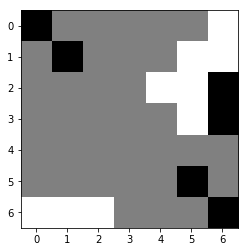

((3, 6), (3, 4)): n_v:  2485 q_all:+0.005094 q:-0.070479 q_m:+0.060000 p:0.357612
((5, 5), (3, 4)): n_v:  1291 q_all:+0.007704 q:-0.040973 q_m:+0.060000 p:0.179096
((2, 6), (3, 4)): n_v:   924 q_all:-0.004841 q:-0.054243 q_m:+0.060000 p:0.151288
((3, 6), (1, 4)): n_v:   641 q_all:+0.010058 q:-0.021575 q_m:+0.060000 p:0.085970
((3, 6), (5, 4)): n_v:   149 q_all:-0.071521 q:-0.126420 q_m:-0.060000 p:0.044459
((2, 6), (1, 4)): n_v:   114 q_all:+0.011909 q:-0.032255 q_m:+0.060000 p:0.014871
((3, 6), (5, 6)): n_v:   111 q_all:-0.067322 q:-0.137585 q_m:-0.060000 p:0.032087
((1, 1), (3, 2)): n_v:    88 q_all:-0.069259 q:-0.086211 q_m:-0.060000 p:0.025870
((2, 6), (0, 5)): n_v:    35 q_all:+0.004409 q:-0.044229 q_m:+0.060000 p:0.005168
((5, 5), (5, 4)): n_v:    33 q_all:-0.065101 q:-0.075098 q_m:-0.040000 p:0.009638
((0, 0), (0, 1)): n_v:    32 q_all:-0.053348 q:-0.122139 q_m:-0.040000 p:0.008590
((5, 5), (6, 5)): n_v:    27 q_all:-0.064697 q:-0.092502 q_m:-0.040000 p:0.007662
((5, 5), (5, 3))

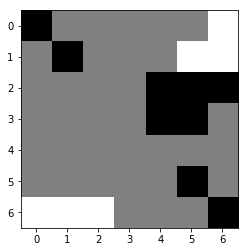

((1, 6), (3, 6)): n_v:  3106 q_all:+0.003059 q:-0.030348 q_m:+0.060000 p:0.682411
((1, 5), (3, 6)): n_v:   595 q_all:-0.037572 q:-0.045706 q_m:+0.060000 p:0.195449
((1, 5), (1, 4)): n_v:   567 q_all:+0.038817 q:-0.023912 q_m:+0.040000 p:0.070422
((0, 6), (1, 4)): n_v:    57 q_all:+0.031038 q:-0.025797 q_m:+0.020000 p:0.008375
((1, 6), (1, 4)): n_v:    30 q_all:+0.021791 q:-0.042630 q_m:+0.020000 p:0.005164
((1, 5), (0, 4)): n_v:    19 q_all:-0.061898 q:-0.050986 q_m:-0.040000 p:0.007791
((6, 1), (5, 2)): n_v:     9 q_all:-0.082475 q:-0.067030 q_m:-0.040000 p:0.004378
((6, 0), (5, 1)): n_v:     5 q_all:-0.094580 q:-0.095860 q_m:-0.040000 p:0.002695
((6, 0), (5, 0)): n_v:     4 q_all:-0.066688 q:-0.085147 q_m:-0.040000 p:0.002010
((6, 2), (4, 4)): n_v:     3 q_all:+0.004169 q:-0.010375 q_m:+0.060000 p:0.000807
((6, 2), (5, 0)): n_v:     2 q_all:-0.120352 q:-0.075912 q_m:-0.060000 p:0.001409
((6, 2), (5, 4)): n_v:     2 q_all:-0.050339 q:-0.056607 q_m:-0.020000 p:0.001046
((0, 6), (0, 5))

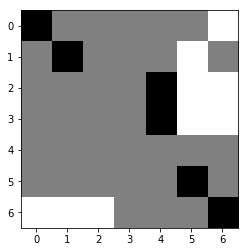

((3, 4), (1, 6)): n_v:  1854 q_all:+0.042229 q:+0.005733 q_m:+0.100000 p:0.248031
((2, 4), (1, 6)): n_v:   806 q_all:+0.042534 q:-0.024879 q_m:+0.100000 p:0.107112
((3, 4), (5, 6)): n_v:   377 q_all:-0.064686 q:-0.103703 q_m:-0.060000 p:0.175439
((3, 4), (4, 5)): n_v:   174 q_all:-0.041875 q:-0.074301 q_m:+0.040000 p:0.068652
((5, 5), (4, 6)): n_v:   142 q_all:-0.059354 q:-0.039451 q_m:+0.040000 p:0.063701
((5, 5), (5, 6)): n_v:   113 q_all:-0.077171 q:-0.084062 q_m:-0.040000 p:0.057071
((2, 4), (1, 4)): n_v:    71 q_all:+0.002694 q:-0.029695 q_m:+0.040000 p:0.018131
((0, 0), (1, 0)): n_v:    62 q_all:-0.051646 q:-0.085708 q_m:-0.040000 p:0.026652
((1, 1), (2, 0)): n_v:    52 q_all:-0.049781 q:-0.078726 q_m:-0.040000 p:0.022030
((1, 1), (2, 1)): n_v:    30 q_all:-0.034189 q:-0.079026 q_m:-0.040000 p:0.011438
((2, 4), (0, 5)): n_v:    11 q_all:-0.044838 q:-0.059888 q_m:+0.020000 p:0.004574
((5, 5), (5, 4)): n_v:    10 q_all:-0.073755 q:-0.071587 q_m:-0.040000 p:0.005023
((3, 4), (4, 6))

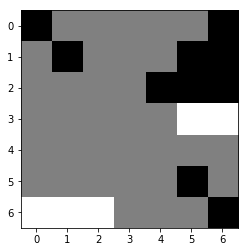

((3, 6), (5, 6)): n_v:  1120 q_all:-0.038626 q:-0.063471 q_m:-0.020000 p:0.342254
((3, 6), (1, 4)): n_v:   850 q_all:-0.004509 q:-0.064391 q_m:+0.020000 p:0.161502
((3, 5), (1, 4)): n_v:   454 q_all:-0.017501 q:-0.043967 q_m:+0.020000 p:0.106219
((3, 5), (5, 6)): n_v:   380 q_all:-0.033646 q:-0.057572 q_m:-0.020000 p:0.109279
((3, 6), (5, 4)): n_v:   133 q_all:-0.070625 q:-0.075225 q_m:-0.060000 p:0.055407
((3, 5), (3, 4)): n_v:    97 q_all:-0.014169 q:-0.057913 q_m:-0.000000 p:0.021240
((3, 5), (5, 4)): n_v:    68 q_all:-0.081960 q:-0.090036 q_m:-0.060000 p:0.030834
((6, 1), (5, 2)): n_v:    43 q_all:-0.066914 q:-0.104286 q_m:-0.080000 p:0.017624
((6, 2), (5, 4)): n_v:    37 q_all:-0.107770 q:-0.080456 q_m:-0.060000 p:0.020395
((3, 5), (4, 6)): n_v:    33 q_all:-0.075114 q:-0.071489 q_m:-0.040000 p:0.014321
((6, 0), (5, 0)): n_v:    25 q_all:-0.093203 q:-0.132303 q_m:-0.080000 p:0.012627
((6, 0), (5, 1)): n_v:    23 q_all:-0.080619 q:-0.127045 q_m:-0.080000 p:0.010509
((3, 6), (3, 4))

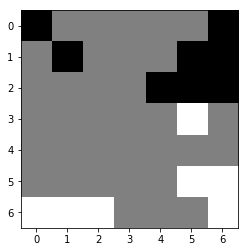

((2, 4), (4, 5)): n_v:   637 q_all:+0.094240 q:+0.030262 q_m:+0.140000 p:0.229135
((1, 1), (2, 1)): n_v:   246 q_all:+0.006780 q:-0.079268 q_m:+0.040000 p:0.182610
((2, 6), (4, 5)): n_v:   152 q_all:+0.098081 q:+0.010604 q_m:+0.140000 p:0.052333
((1, 1), (2, 2)): n_v:   137 q_all:-0.002251 q:-0.076699 q_m:+0.040000 p:0.107384
((2, 5), (3, 6)): n_v:   105 q_all:+0.066270 q:-0.065175 q_m:+0.080000 p:0.050477
((2, 5), (4, 5)): n_v:    62 q_all:+0.082991 q:+0.011164 q_m:+0.140000 p:0.025729
((1, 1), (2, 0)): n_v:    59 q_all:+0.022842 q:-0.087178 q_m:+0.040000 p:0.039776
((2, 4), (3, 4)): n_v:    52 q_all:+0.011850 q:-0.054174 q_m:+0.080000 p:0.037714
((2, 4), (4, 6)): n_v:    49 q_all:+0.086616 q:+0.012667 q_m:+0.140000 p:0.019291
((0, 0), (0, 1)): n_v:    38 q_all:+0.036495 q:-0.091206 q_m:+0.040000 p:0.023734
((0, 0), (1, 0)): n_v:    26 q_all:+0.019994 q:-0.079114 q_m:+0.040000 p:0.018272
((2, 5), (4, 4)): n_v:    20 q_all:+0.085811 q:-0.008555 q_m:+0.100000 p:0.007861
((2, 4), (4, 4))

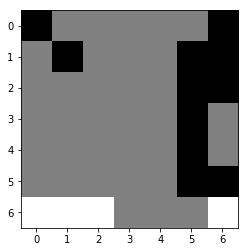

((6, 6), (4, 4)): n_v:   510 q_all:-0.053545 q:-0.102115 q_m:-0.020000 p:0.271842
((6, 6), (4, 6)): n_v:   292 q_all:-0.060527 q:-0.088670 q_m:+0.020000 p:0.165227
((6, 2), (4, 4)): n_v:   203 q_all:-0.051714 q:-0.111620 q_m:-0.020000 p:0.106447
((6, 2), (4, 2)): n_v:   180 q_all:-0.098665 q:-0.169545 q_m:-0.140000 p:0.136334
((6, 2), (4, 0)): n_v:   124 q_all:-0.121195 q:-0.175598 q_m:-0.140000 p:0.106917
((6, 0), (4, 2)): n_v:    93 q_all:-0.106774 q:-0.167673 q_m:-0.140000 p:0.074688
((6, 0), (4, 0)): n_v:    55 q_all:-0.094944 q:-0.176141 q_m:-0.140000 p:0.041002
((6, 1), (4, 2)): n_v:    33 q_all:-0.100456 q:-0.153480 q_m:-0.140000 p:0.025204
((6, 1), (4, 0)): n_v:    30 q_all:-0.099309 q:-0.143030 q_m:-0.140000 p:0.022902
((6, 6), (6, 5)): n_v:    23 q_all:-0.014742 q:-0.172235 q_m:-0.040000 p:0.008121
((6, 2), (5, 4)): n_v:    11 q_all:-0.111409 q:-0.178140 q_m:-0.060000 p:0.009371
((6, 0), (5, 1)): n_v:     9 q_all:-0.060947 q:-0.185632 q_m:-0.120000 p:0.005330
((6, 0), (5, 0))

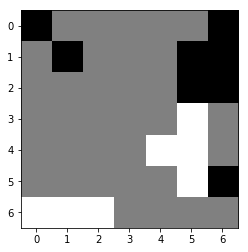

((2, 5), (3, 4)): n_v:   770 q_all:+0.094058 q:-0.012368 q_m:+0.160000 p:0.365966
((5, 6), (3, 4)): n_v:   482 q_all:+0.050589 q:-0.007970 q_m:+0.140000 p:0.329091
((1, 6), (3, 4)): n_v:    97 q_all:+0.085032 q:-0.012889 q_m:+0.140000 p:0.050724
((2, 6), (3, 4)): n_v:    89 q_all:+0.077018 q:-0.029470 q_m:+0.140000 p:0.049888
((2, 6), (4, 6)): n_v:    65 q_all:+0.065090 q:+0.032268 q_m:+0.140000 p:0.039944
((1, 1), (3, 2)): n_v:    58 q_all:+0.035377 q:-0.046266 q_m:+0.020000 p:0.044198
((1, 5), (3, 4)): n_v:    42 q_all:+0.075289 q:-0.014098 q_m:+0.140000 p:0.023904
((2, 5), (4, 6)): n_v:    39 q_all:+0.057137 q:+0.034256 q_m:+0.140000 p:0.025553
((5, 6), (4, 6)): n_v:    25 q_all:+0.026361 q:+0.054022 q_m:+0.160000 p:0.020409
((2, 5), (3, 6)): n_v:    22 q_all:+0.087355 q:-0.018688 q_m:+0.120000 p:0.011068
((1, 1), (2, 0)): n_v:     7 q_all:+0.062218 q:-0.040764 q_m:+0.040000 p:0.005012
((1, 1), (2, 1)): n_v:     3 q_all:+0.059780 q:-0.033329 q_m:+0.040000 p:0.002132
((5, 6), (6, 5))

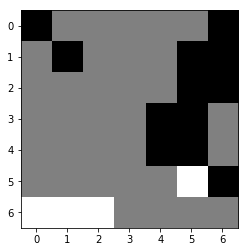

((5, 5), (4, 6)): n_v:  1231 q_all:-0.104162 q:-0.112668 q_m:-0.020000 p:0.574414
((5, 5), (3, 6)): n_v:  1127 q_all:-0.027880 q:-0.088276 q_m:-0.000000 p:0.202803
((6, 2), (5, 4)): n_v:   110 q_all:-0.038704 q:-0.150295 q_m:-0.080000 p:0.024316
((6, 2), (4, 0)): n_v:    93 q_all:-0.155348 q:-0.198459 q_m:-0.160000 p:0.061740
((5, 5), (5, 4)): n_v:    74 q_all:-0.040201 q:-0.129934 q_m:-0.060000 p:0.016784
((6, 2), (4, 2)): n_v:    33 q_all:-0.104135 q:-0.166875 q_m:-0.160000 p:0.015792
((5, 5), (6, 6)): n_v:    19 q_all:-0.079862 q:-0.166054 q_m:-0.100000 p:0.007394
((6, 1), (5, 2)): n_v:    15 q_all:-0.155518 q:-0.158653 q_m:-0.140000 p:0.010320
((6, 0), (5, 1)): n_v:    15 q_all:-0.152116 q:-0.165891 q_m:-0.140000 p:0.010288
((6, 0), (5, 0)): n_v:    11 q_all:-0.119984 q:-0.195668 q_m:-0.140000 p:0.005644
((6, 2), (5, 3)): n_v:    10 q_all:-0.119427 q:-0.137322 q_m:-0.100000 p:0.005705
((6, 0), (4, 0)): n_v:    10 q_all:-0.130799 q:-0.179314 q_m:-0.160000 p:0.005764
((6, 1), (4, 0))

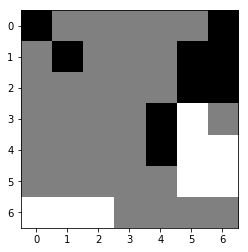

((2, 5), (3, 6)): n_v:  4859 q_all:+0.116727 q:+0.023751 q_m:+0.160000 p:0.567699
((3, 4), (3, 6)): n_v:    83 q_all:+0.052326 q:+0.021671 q_m:+0.140000 p:0.024574
((1, 6), (3, 6)): n_v:    36 q_all:+0.130893 q:+0.037533 q_m:+0.140000 p:0.002940
((1, 5), (3, 6)): n_v:    31 q_all:+0.135033 q:+0.019909 q_m:+0.140000 p:0.002078
((4, 4), (3, 6)): n_v:    29 q_all:+0.047456 q:+0.005054 q_m:+0.140000 p:0.009261
((1, 1), (3, 0)): n_v:    18 q_all:-0.031179 q:-0.072653 q_m:+0.020000 p:0.009333
((4, 4), (6, 6)): n_v:    11 q_all:+0.069122 q:-0.003663 q_m:+0.100000 p:0.002873
((3, 4), (5, 4)): n_v:     4 q_all:+0.043967 q:+0.001240 q_m:+0.100000 p:0.001590
((0, 0), (1, 0)): n_v:     4 q_all:+0.006887 q:-0.071326 q_m:+0.040000 p:0.001810
((4, 4), (6, 5)): n_v:     2 q_all:+0.071464 q:-0.020895 q_m:+0.100000 p:0.000543
((1, 1), (2, 0)): n_v:     2 q_all:+0.014811 q:-0.075709 q_m:+0.040000 p:0.000887
((4, 4), (5, 4)): n_v:     2 q_all:+0.043174 q:+0.006267 q_m:+0.120000 p:0.000823
((4, 4), (6, 3))

((6, 2), (5, 4)): n_v:  3813 q_all:-0.063759 q:-0.110492 q_m:-0.080000 p:0.157998
((5, 5), (5, 4)): n_v:   981 q_all:-0.097654 q:-0.078973 q_m:-0.060000 p:0.102779
((6, 1), (5, 2)): n_v:   359 q_all:-0.155362 q:-0.142805 q_m:-0.140000 p:0.093681
((6, 0), (5, 1)): n_v:   233 q_all:-0.142311 q:-0.145848 q_m:-0.140000 p:0.053641
((6, 2), (4, 0)): n_v:   219 q_all:-0.157828 q:-0.165563 q_m:-0.160000 p:0.058555
((6, 2), (4, 2)): n_v:   193 q_all:-0.153916 q:-0.154458 q_m:-0.160000 p:0.049762
((6, 0), (5, 0)): n_v:   149 q_all:-0.135499 q:-0.150916 q_m:-0.140000 p:0.031734
((6, 0), (4, 2)): n_v:    97 q_all:-0.163985 q:-0.154874 q_m:-0.160000 p:0.027484
((6, 2), (4, 3)): n_v:    70 q_all:-0.130437 q:-0.101000 q_m:-0.080000 p:0.013927
((6, 2), (4, 1)): n_v:    56 q_all:-0.170371 q:-0.135206 q_m:-0.160000 p:0.016845
((6, 2), (5, 0)): n_v:    41 q_all:-0.160055 q:-0.164453 q_m:-0.160000 p:0.011229
((6, 0), (4, 0)): n_v:    41 q_all:-0.155409 q:-0.148410 q_m:-0.160000 p:0.010817
((6, 1), (4, 0))

((3, 4), (5, 3)): n_v:  1778 q_all:+0.095275 q:+0.054670 q_m:+0.160000 p:0.174305
((3, 4), (4, 3)): n_v:   684 q_all:+0.095191 q:+0.052859 q_m:+0.180000 p:0.067119
((1, 1), (2, 0)): n_v:   509 q_all:+0.029350 q:-0.002935 q_m:+0.100000 p:0.145420
((0, 6), (0, 5)): n_v:   311 q_all:+0.044795 q:-0.004346 q_m:+0.100000 p:0.075042
((0, 0), (0, 1)): n_v:   301 q_all:+0.036697 q:-0.014427 q_m:+0.100000 p:0.079739
((4, 6), (6, 5)): n_v:   243 q_all:+0.096669 q:+0.028438 q_m:+0.200000 p:0.022792
((4, 6), (6, 6)): n_v:   169 q_all:+0.071645 q:+0.006956 q_m:+0.160000 p:0.027809
((3, 4), (3, 3)): n_v:   136 q_all:+0.053024 q:-0.000996 q_m:+0.140000 p:0.029653
((3, 4), (5, 2)): n_v:    75 q_all:+0.074272 q:+0.046685 q_m:+0.120000 p:0.011910
((0, 0), (1, 0)): n_v:    64 q_all:+0.033498 q:+0.002273 q_m:+0.100000 p:0.017251
((3, 4), (2, 3)): n_v:    62 q_all:+0.015183 q:-0.025084 q_m:+0.100000 p:0.020480
((3, 4), (1, 3)): n_v:    56 q_all:+0.018742 q:-0.003215 q_m:+0.080000 p:0.017732
((1, 1), (2, 1))

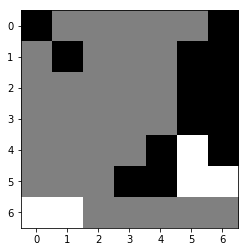

((4, 5), (3, 4)): n_v:  1582 q_all:-0.040312 q:-0.064676 q_m:-0.020000 p:0.280699
((6, 1), (4, 3)): n_v:   669 q_all:-0.089641 q:-0.097395 q_m:-0.040000 p:0.223056
((6, 1), (6, 3)): n_v:   585 q_all:-0.103549 q:-0.120212 q_m:-0.080000 p:0.220917
((6, 1), (6, 2)): n_v:   127 q_all:-0.071118 q:-0.146953 q_m:-0.100000 p:0.034979
((5, 5), (4, 3)): n_v:   103 q_all:-0.089731 q:-0.102644 q_m:-0.040000 p:0.034556
((5, 5), (6, 4)): n_v:    88 q_all:-0.091882 q:-0.090648 q_m:-0.060000 p:0.029944
((4, 5), (2, 4)): n_v:    80 q_all:-0.047893 q:-0.089831 q_m:-0.040000 p:0.016146
((5, 6), (3, 4)): n_v:    67 q_all:-0.053301 q:-0.069973 q_m:-0.040000 p:0.014806
((5, 5), (6, 6)): n_v:    51 q_all:-0.159104 q:-0.210875 q_m:-0.140000 p:0.028428
((4, 5), (4, 3)): n_v:    43 q_all:-0.091387 q:-0.127401 q_m:-0.040000 p:0.014626
((5, 5), (6, 3)): n_v:    36 q_all:-0.104813 q:-0.133912 q_m:-0.080000 p:0.014102
((5, 5), (3, 4)): n_v:    33 q_all:-0.079103 q:-0.078138 q_m:-0.040000 p:0.010016
((4, 5), (2, 3))

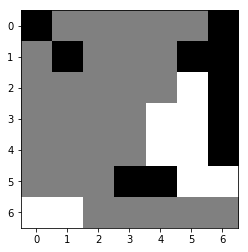

((4, 6), (2, 4)): n_v:   463 q_all:+0.077866 q:+0.018773 q_m:+0.140000 p:0.159601
((1, 5), (2, 4)): n_v:   371 q_all:+0.096010 q:+0.058752 q_m:+0.160000 p:0.101612
((5, 3), (4, 3)): n_v:   360 q_all:+0.068649 q:+0.017027 q_m:+0.120000 p:0.137003
((5, 3), (4, 2)): n_v:   339 q_all:+0.025654 q:-0.000793 q_m:+0.040000 p:0.186802
((5, 3), (5, 1)): n_v:   296 q_all:+0.088524 q:+0.036804 q_m:+0.100000 p:0.089432
((1, 1), (2, 2)): n_v:   177 q_all:+0.058536 q:+0.001604 q_m:+0.040000 p:0.074611
((5, 4), (6, 5)): n_v:   112 q_all:+0.073676 q:+0.036191 q_m:+0.120000 p:0.040627
((5, 4), (6, 6)): n_v:    52 q_all:+0.048133 q:+0.041673 q_m:+0.100000 p:0.024300
((5, 3), (6, 5)): n_v:    40 q_all:+0.055018 q:+0.022913 q_m:+0.100000 p:0.017786
((3, 6), (2, 4)): n_v:    37 q_all:+0.022192 q:+0.019782 q_m:+0.140000 p:0.020999
((5, 4), (4, 2)): n_v:    12 q_all:+0.012130 q:-0.005745 q_m:+0.020000 p:0.007703
((5, 3), (6, 4)): n_v:    10 q_all:+0.054557 q:+0.005504 q_m:+0.080000 p:0.004687
((5, 3), (4, 1))

((4, 5), (4, 6)): n_v:   936 q_all:-0.039025 q:-0.096786 q_m:-0.040000 p:0.258944
((4, 4), (2, 3)): n_v:   437 q_all:-0.048795 q:-0.098687 q_m:-0.060000 p:0.139031
((4, 4), (4, 3)): n_v:   276 q_all:-0.044911 q:-0.037661 q_m:-0.000000 p:0.083053
((6, 1), (4, 3)): n_v:   256 q_all:-0.048725 q:-0.059205 q_m:-0.020000 p:0.081667
((6, 1), (6, 2)): n_v:    39 q_all:-0.118674 q:-0.137442 q_m:-0.080000 p:0.024098
((4, 5), (2, 3)): n_v:    29 q_all:-0.100366 q:-0.102724 q_m:-0.060000 p:0.016060
((5, 5), (6, 4)): n_v:    28 q_all:-0.095784 q:-0.084306 q_m:-0.040000 p:0.014486
((5, 5), (6, 6)): n_v:    27 q_all:-0.152429 q:-0.162785 q_m:-0.120000 p:0.020948
((5, 5), (4, 3)): n_v:    25 q_all:-0.065754 q:-0.067314 q_m:-0.020000 p:0.009738
((4, 5), (4, 3)): n_v:    22 q_all:-0.064363 q:-0.060043 q_m:-0.020000 p:0.008789
((4, 4), (3, 3)): n_v:    20 q_all:-0.082808 q:-0.075947 q_m:-0.040000 p:0.009411
((6, 1), (6, 3)): n_v:    19 q_all:-0.131426 q:-0.090230 q_m:-0.060000 p:0.012870
((6, 1), (4, 0))

((5, 3), (5, 1)): n_v:   689 q_all:+0.087557 q:+0.036210 q_m:+0.120000 p:0.302055
((5, 4), (6, 5)): n_v:   417 q_all:+0.090804 q:+0.025538 q_m:+0.140000 p:0.176732
((5, 4), (6, 6)): n_v:   318 q_all:+0.084172 q:+0.053346 q_m:+0.120000 p:0.144510
((5, 3), (6, 5)): n_v:   110 q_all:+0.100887 q:+0.016425 q_m:+0.120000 p:0.041735
((2, 4), (0, 5)): n_v:    52 q_all:-0.036738 q:-0.030903 q_m:+0.040000 p:0.052955
((5, 3), (4, 2)): n_v:    40 q_all:+0.027629 q:-0.003942 q_m:+0.060000 p:0.028959
((5, 3), (4, 1)): n_v:    28 q_all:+0.026437 q:+0.028679 q_m:+0.040000 p:0.020639
((5, 3), (6, 2)): n_v:    27 q_all:+0.038591 q:+0.024671 q_m:+0.100000 p:0.018480
((1, 1), (2, 1)): n_v:    24 q_all:+0.014147 q:-0.020028 q_m:+0.060000 p:0.019125
((5, 3), (5, 2)): n_v:    19 q_all:+0.014854 q:+0.013268 q_m:+0.100000 p:0.015215
((1, 1), (2, 0)): n_v:    16 q_all:+0.015537 q:-0.029995 q_m:+0.060000 p:0.012835
((0, 0), (0, 1)): n_v:    14 q_all:+0.014032 q:-0.035676 q_m:+0.060000 p:0.011500
((5, 3), (6, 4))

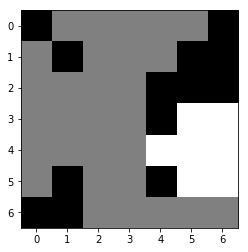

((5, 5), (6, 5)): n_v:   975 q_all:-0.008445 q:-0.079230 q_m:-0.060000 p:0.121268
((4, 4), (3, 3)): n_v:   687 q_all:-0.079002 q:-0.073981 q_m:-0.020000 p:0.258482
((5, 5), (6, 4)): n_v:   594 q_all:-0.030809 q:-0.080808 q_m:-0.060000 p:0.121063
((3, 6), (1, 4)): n_v:   335 q_all:-0.089657 q:-0.086494 q_m:-0.000000 p:0.138788
((4, 4), (4, 3)): n_v:   111 q_all:-0.052670 q:-0.048299 q_m:-0.020000 p:0.031462
((3, 5), (1, 4)): n_v:   110 q_all:-0.138749 q:-0.092629 q_m:-0.000000 p:0.065377
((4, 4), (5, 2)): n_v:    73 q_all:-0.048760 q:-0.074176 q_m:-0.040000 p:0.019684
((5, 6), (6, 4)): n_v:    34 q_all:-0.085856 q:-0.088003 q_m:-0.080000 p:0.013795
((4, 4), (2, 3)): n_v:    25 q_all:-0.080405 q:-0.088126 q_m:-0.040000 p:0.009736
((5, 5), (6, 6)): n_v:    24 q_all:-0.143007 q:-0.131282 q_m:-0.100000 p:0.014933
((4, 4), (5, 3)): n_v:    22 q_all:-0.070471 q:-0.086123 q_m:-0.060000 p:0.007841
((4, 4), (6, 2)): n_v:    22 q_all:-0.065585 q:-0.106433 q_m:-0.040000 p:0.007389
((4, 4), (6, 5))

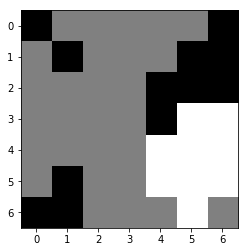

((3, 4), (5, 3)): n_v:   649 q_all:+0.066654 q:+0.017618 q_m:+0.140000 p:0.249761
((3, 4), (4, 3)): n_v:   317 q_all:+0.109199 q:+0.062052 q_m:+0.160000 p:0.061266
((2, 4), (0, 2)): n_v:   283 q_all:-0.004509 q:-0.035917 q_m:+0.060000 p:0.199599
((2, 4), (1, 3)): n_v:   151 q_all:+0.022492 q:-0.014593 q_m:+0.080000 p:0.088314
((3, 4), (4, 2)): n_v:   119 q_all:+0.013829 q:-0.021881 q_m:+0.060000 p:0.073940
((3, 4), (2, 2)): n_v:    51 q_all:+0.022416 q:-0.040734 q_m:+0.060000 p:0.030083
((3, 4), (1, 3)): n_v:    47 q_all:+0.026534 q:-0.023101 q_m:+0.060000 p:0.026609
((2, 4), (4, 3)): n_v:    33 q_all:+0.057722 q:+0.039471 q_m:+0.140000 p:0.014209
((2, 4), (2, 3)): n_v:    29 q_all:+0.019194 q:-0.019730 q_m:+0.080000 p:0.017881
((2, 6), (0, 4)): n_v:    27 q_all:-0.028143 q:-0.053094 q_m:+0.060000 p:0.022493
((2, 4), (2, 2)): n_v:    23 q_all:+0.025439 q:-0.037545 q_m:+0.060000 p:0.013167
((5, 1), (6, 2)): n_v:    19 q_all:+0.066423 q:-0.022506 q_m:+0.080000 p:0.007611
((2, 4), (1, 2))

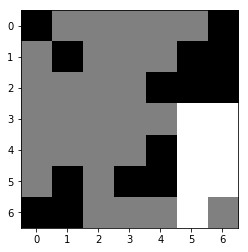

((3, 5), (3, 4)): n_v:  5088 q_all:+0.003542 q:-0.062220 q_m:-0.000000 p:0.420528
((5, 5), (6, 4)): n_v:   155 q_all:-0.059331 q:-0.055488 q_m:-0.040000 p:0.038959
((3, 6), (3, 4)): n_v:    92 q_all:-0.084189 q:-0.078223 q_m:-0.020000 p:0.029231
((5, 6), (3, 4)): n_v:    83 q_all:-0.009898 q:-0.082349 q_m:-0.020000 p:0.009886
((3, 6), (1, 4)): n_v:    63 q_all:-0.066615 q:-0.109269 q_m:-0.020000 p:0.016964
((4, 6), (3, 4)): n_v:    56 q_all:-0.083033 q:-0.084049 q_m:-0.020000 p:0.017757
((3, 5), (1, 4)): n_v:    30 q_all:-0.069810 q:-0.116178 q_m:-0.020000 p:0.008481
((6, 5), (4, 3)): n_v:    14 q_all:-0.071278 q:-0.069485 q_m:-0.020000 p:0.003968
((5, 5), (3, 4)): n_v:     8 q_all:-0.132079 q:-0.106366 q_m:-0.020000 p:0.003950
((6, 5), (6, 3)): n_v:     8 q_all:-0.020269 q:-0.090572 q_m:-0.060000 p:0.001312
((5, 5), (4, 3)): n_v:     6 q_all:-0.077560 q:-0.076806 q_m:-0.020000 p:0.001935
((3, 5), (4, 3)): n_v:     5 q_all:-0.065001 q:-0.065597 q_m:-0.020000 p:0.001024
((5, 5), (6, 6))

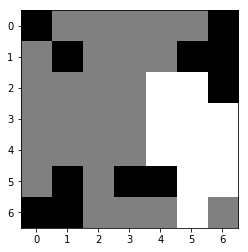

((5, 4), (3, 3)): n_v:  3277 q_all:+0.011925 q:+0.058898 q_m:+0.120000 p:0.464183
((5, 4), (6, 6)): n_v:  1719 q_all:+0.066751 q:+0.036665 q_m:+0.120000 p:0.023955
((1, 1), (3, 3)): n_v:   677 q_all:-0.025421 q:+0.025918 q_m:+0.120000 p:0.154946
((5, 1), (3, 3)): n_v:   636 q_all:-0.034141 q:+0.018569 q_m:+0.120000 p:0.158502
((1, 5), (1, 4)): n_v:   570 q_all:+0.102892 q:+0.002036 q_m:+0.100000 p:0.001738
((1, 5), (3, 3)): n_v:   535 q_all:-0.025011 q:+0.006090 q_m:+0.120000 p:0.121945
((5, 3), (3, 3)): n_v:   136 q_all:+0.010046 q:+0.040346 q_m:+0.120000 p:0.019966
((5, 3), (4, 3)): n_v:    45 q_all:+0.008723 q:+0.020239 q_m:+0.100000 p:0.006800
((5, 3), (6, 4)): n_v:    31 q_all:+0.022050 q:+0.015807 q_m:+0.100000 p:0.003737
((2, 6), (1, 4)): n_v:    18 q_all:-0.011028 q:-0.027057 q_m:+0.080000 p:0.003554
((5, 3), (3, 1)): n_v:    11 q_all:-0.027822 q:-0.030253 q_m:-0.000000 p:0.002634
((5, 1), (5, 2)): n_v:    11 q_all:-0.025321 q:-0.041648 q_m:+0.020000 p:0.002497
((1, 1), (1, 2))

((6, 5), (4, 3)): n_v:  3510 q_all:+0.013786 q:-0.029556 q_m:+0.040000 p:0.324083
((5, 5), (4, 3)): n_v:   906 q_all:+0.001759 q:-0.047738 q_m:+0.040000 p:0.112098
((2, 5), (1, 4)): n_v:   601 q_all:-0.031481 q:-0.119307 q_m:-0.020000 p:0.126358
((4, 5), (5, 4)): n_v:   455 q_all:-0.036329 q:-0.081693 q_m:-0.020000 p:0.101523
((2, 5), (4, 3)): n_v:   106 q_all:+0.010997 q:-0.039132 q_m:+0.040000 p:0.010787
((4, 5), (4, 3)): n_v:    66 q_all:-0.016058 q:-0.041431 q_m:+0.040000 p:0.011350
((5, 6), (5, 4)): n_v:    31 q_all:-0.077718 q:-0.107804 q_m:-0.040000 p:0.010290
((3, 6), (5, 4)): n_v:    31 q_all:-0.078488 q:-0.114808 q_m:-0.040000 p:0.010400
((4, 5), (2, 3)): n_v:    19 q_all:-0.074344 q:-0.140486 q_m:-0.000000 p:0.006333
((3, 5), (4, 3)): n_v:    13 q_all:-0.028947 q:-0.048485 q_m:+0.040000 p:0.002457
((3, 6), (1, 4)): n_v:    12 q_all:-0.099587 q:-0.135567 q_m:-0.040000 p:0.004539
((3, 5), (2, 3)): n_v:     9 q_all:-0.075402 q:-0.117647 q_m:-0.000000 p:0.003093
((2, 5), (2, 3))

((5, 1), (4, 2)): n_v:  1451 q_all:+0.061352 q:-0.004874 q_m:+0.100000 p:0.027127
((5, 1), (5, 2)): n_v:  1056 q_all:-0.030720 q:-0.024434 q_m:+0.060000 p:0.297460
((1, 5), (1, 4)): n_v:  1036 q_all:+0.062938 q:-0.029409 q_m:+0.020000 p:0.037622
((1, 1), (1, 2)): n_v:   253 q_all:-0.003887 q:-0.045494 q_m:-0.020000 p:0.052012
((2, 4), (4, 2)): n_v:    75 q_all:+0.021248 q:-0.013929 q_m:+0.080000 p:0.009638
((6, 0), (4, 2)): n_v:    69 q_all:+0.022499 q:-0.023013 q_m:+0.080000 p:0.008581
((2, 4), (2, 3)): n_v:    62 q_all:+0.008941 q:-0.027896 q_m:+0.060000 p:0.010440
((6, 0), (5, 2)): n_v:    46 q_all:-0.037174 q:-0.036874 q_m:+0.040000 p:0.014015
((1, 1), (2, 2)): n_v:    41 q_all:-0.036218 q:-0.027096 q_m:+0.020000 p:0.012361
((6, 1), (4, 2)): n_v:    25 q_all:+0.021300 q:-0.022913 q_m:+0.080000 p:0.003268
((2, 4), (1, 2)): n_v:    20 q_all:-0.011578 q:-0.044912 q_m:-0.040000 p:0.004705
((2, 4), (2, 2)): n_v:    16 q_all:+0.000174 q:-0.045547 q_m:-0.000000 p:0.003157
((1, 1), (2, 3))

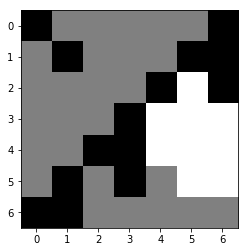

((4, 4), (5, 4)): n_v:  1408 q_all:+0.017983 q:-0.041845 q_m:-0.000000 p:0.110024
((5, 6), (5, 4)): n_v:   373 q_all:-0.012395 q:-0.086783 q_m:-0.020000 p:0.070810
((2, 5), (1, 4)): n_v:   330 q_all:-0.048491 q:-0.080459 q_m:-0.000000 p:0.106475
((3, 6), (5, 4)): n_v:   292 q_all:-0.107105 q:-0.087593 q_m:-0.020000 p:0.157065
((3, 4), (5, 2)): n_v:   240 q_all:-0.021670 q:-0.044280 q_m:+0.100000 p:0.053659
((3, 4), (1, 2)): n_v:    77 q_all:-0.072775 q:-0.124693 q_m:-0.060000 p:0.032049
((3, 6), (1, 4)): n_v:    61 q_all:-0.099599 q:-0.099035 q_m:-0.020000 p:0.031389
((4, 4), (5, 2)): n_v:    59 q_all:-0.036538 q:-0.013352 q_m:+0.100000 p:0.016630
((3, 5), (5, 4)): n_v:    41 q_all:-0.078959 q:-0.069627 q_m:-0.020000 p:0.017977
((3, 4), (5, 4)): n_v:    26 q_all:-0.095044 q:-0.133577 q_m:-0.020000 p:0.013011
((4, 6), (5, 4)): n_v:    20 q_all:-0.101733 q:-0.066667 q_m:-0.020000 p:0.010508
((3, 5), (1, 4)): n_v:    13 q_all:-0.148276 q:-0.087279 q_m:-0.020000 p:0.009258
((3, 4), (1, 4))

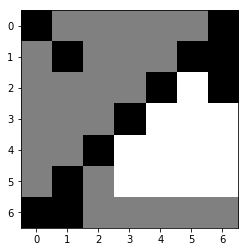

((3, 3), (5, 2)): n_v:  1282 q_all:+0.011124 q:-0.007356 q_m:+0.080000 p:0.378013
((4, 2), (5, 2)): n_v:   464 q_all:+0.060937 q:+0.016511 q_m:+0.100000 p:0.046178
((3, 3), (1, 2)): n_v:   289 q_all:-0.013089 q:-0.037967 q_m:-0.000000 p:0.112952
((3, 3), (1, 4)): n_v:   257 q_all:+0.005297 q:-0.016991 q_m:+0.040000 p:0.081631
((6, 0), (5, 2)): n_v:    67 q_all:+0.020804 q:-0.012766 q_m:+0.080000 p:0.017186
((2, 4), (1, 2)): n_v:    52 q_all:+0.006594 q:-0.039643 q_m:-0.000000 p:0.016353
((1, 1), (1, 2)): n_v:    44 q_all:-0.004393 q:-0.036610 q_m:+0.020000 p:0.015977
((6, 1), (6, 3)): n_v:    22 q_all:+0.005726 q:-0.015421 q_m:+0.080000 p:0.007094
((1, 5), (1, 4)): n_v:    14 q_all:+0.002266 q:-0.027771 q_m:+0.060000 p:0.004894
((5, 1), (6, 3)): n_v:    13 q_all:+0.004330 q:-0.007441 q_m:+0.080000 p:0.004303
((4, 2), (6, 4)): n_v:    12 q_all:+0.023278 q:-0.006488 q_m:+0.120000 p:0.002875
((4, 2), (6, 3)): n_v:    10 q_all:+0.004307 q:-0.019351 q_m:+0.080000 p:0.003444
((2, 4), (0, 5))

((3, 4), (3, 3)): n_v:  1505 q_all:+0.015637 q:-0.017581 q_m:+0.060000 p:0.380019
((5, 4), (6, 2)): n_v:  1334 q_all:+0.034589 q:+0.025620 q_m:+0.080000 p:0.251617
((4, 4), (6, 2)): n_v:   121 q_all:-0.001793 q:+0.001138 q_m:+0.080000 p:0.037857
((5, 4), (6, 4)): n_v:   102 q_all:-0.060634 q:-0.052301 q_m:-0.020000 p:0.052209
((5, 4), (3, 3)): n_v:    63 q_all:-0.017826 q:-0.040236 q_m:+0.040000 p:0.023015
((3, 6), (1, 4)): n_v:    53 q_all:-0.021413 q:-0.063775 q_m:-0.000000 p:0.020020
((2, 5), (1, 4)): n_v:    36 q_all:-0.001182 q:-0.045042 q_m:+0.020000 p:0.011072
((3, 4), (1, 2)): n_v:    33 q_all:-0.032095 q:-0.084069 q_m:-0.040000 p:0.013790
((2, 5), (3, 3)): n_v:    31 q_all:+0.009624 q:-0.036479 q_m:+0.040000 p:0.008652
((4, 5), (3, 3)): n_v:    25 q_all:-0.074075 q:-0.064953 q_m:+0.040000 p:0.014002
((3, 4), (1, 4)): n_v:    21 q_all:-0.050308 q:-0.083176 q_m:-0.000000 p:0.010221
((5, 5), (3, 3)): n_v:    11 q_all:-0.030181 q:-0.048489 q_m:+0.040000 p:0.004657
((5, 4), (6, 3))

((5, 1), (3, 2)): n_v:   568 q_all:+0.047125 q:-0.014659 q_m:+0.060000 p:0.191453
((1, 1), (3, 2)): n_v:   382 q_all:+0.033192 q:+0.003872 q_m:+0.060000 p:0.150132
((1, 1), (2, 3)): n_v:   240 q_all:+0.001995 q:-0.005093 q_m:+0.060000 p:0.124425
((1, 5), (2, 3)): n_v:   215 q_all:-0.016003 q:+0.001592 q_m:+0.060000 p:0.126516
((5, 3), (6, 5)): n_v:   209 q_all:+0.079441 q:-0.010649 q_m:+0.060000 p:0.043277
((5, 3), (3, 2)): n_v:   190 q_all:+0.018599 q:-0.008122 q_m:+0.060000 p:0.086064
((1, 1), (2, 2)): n_v:   152 q_all:-0.017624 q:-0.025925 q_m:-0.000000 p:0.090832
((1, 5), (1, 4)): n_v:   150 q_all:+0.001820 q:-0.012930 q_m:+0.040000 p:0.077819
((5, 2), (3, 2)): n_v:    68 q_all:+0.014264 q:-0.021878 q_m:+0.060000 p:0.032070
((1, 1), (1, 2)): n_v:    49 q_all:-0.038250 q:-0.048961 q_m:-0.040000 p:0.033747
((2, 6), (1, 4)): n_v:     8 q_all:-0.054407 q:-0.040570 q_m:+0.020000 p:0.006179
((1, 6), (1, 4)): n_v:     3 q_all:+0.000074 q:-0.039352 q_m:+0.020000 p:0.001937
((0, 6), (0, 5))

((2, 4), (0, 5)): n_v:   476 q_all:+0.079273 q:-0.024762 q_m:+0.060000 p:0.016170
((2, 4), (2, 3)): n_v:   291 q_all:-0.018618 q:-0.048674 q_m:+0.040000 p:0.146123
((2, 4), (1, 4)): n_v:   260 q_all:-0.007968 q:-0.049269 q_m:-0.000000 p:0.117135
((2, 4), (2, 2)): n_v:   204 q_all:-0.017708 q:-0.032135 q_m:+0.060000 p:0.102017
((3, 4), (2, 2)): n_v:   146 q_all:-0.066338 q:-0.047925 q_m:+0.060000 p:0.106863
((4, 4), (2, 2)): n_v:    86 q_all:-0.079950 q:-0.046656 q_m:+0.060000 p:0.068723
((5, 4), (6, 3)): n_v:    72 q_all:-0.012328 q:-0.019540 q_m:+0.040000 p:0.033847
((5, 4), (6, 2)): n_v:    31 q_all:-0.002121 q:-0.028837 q_m:+0.060000 p:0.013299
((2, 4), (1, 2)): n_v:    16 q_all:-0.008950 q:-0.050180 q_m:-0.020000 p:0.007414
((5, 4), (6, 5)): n_v:    15 q_all:-0.047243 q:-0.051539 q_m:-0.040000 p:0.010118
((4, 5), (2, 3)): n_v:    15 q_all:-0.068068 q:-0.099253 q_m:+0.020000 p:0.010375
((4, 4), (6, 5)): n_v:    14 q_all:-0.144638 q:-0.101559 q_m:-0.060000 p:0.015654
((2, 4), (1, 3))

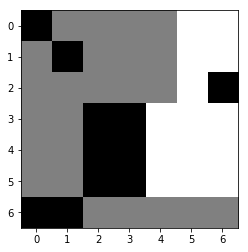

((4, 3), (6, 5)): n_v:   584 q_all:-0.088061 q:-0.046504 q_m:+0.060000 p:0.523187
((3, 3), (2, 4)): n_v:   176 q_all:+0.037163 q:+0.006034 q_m:+0.120000 p:0.042917
((3, 2), (2, 4)): n_v:   153 q_all:+0.021712 q:-0.011701 q_m:+0.100000 p:0.049672
((5, 3), (6, 5)): n_v:   139 q_all:-0.042734 q:-0.038830 q_m:+0.060000 p:0.092491
((3, 3), (1, 4)): n_v:    88 q_all:+0.028625 q:-0.023206 q_m:+0.060000 p:0.025480
((3, 2), (1, 4)): n_v:    58 q_all:-0.000610 q:-0.039121 q_m:+0.060000 p:0.025569
((4, 2), (2, 4)): n_v:    54 q_all:+0.017234 q:-0.025681 q_m:+0.100000 p:0.018998
((4, 2), (6, 4)): n_v:    47 q_all:-0.047613 q:-0.068238 q_m:+0.020000 p:0.032460
((3, 3), (1, 2)): n_v:    23 q_all:-0.090486 q:-0.175292 q_m:-0.060000 p:0.021645
((1, 1), (2, 2)): n_v:    18 q_all:-0.024491 q:-0.097711 q_m:-0.040000 p:0.010674
((3, 2), (5, 0)): n_v:    16 q_all:-0.035236 q:-0.125639 q_m:-0.060000 p:0.010305
((3, 2), (1, 2)): n_v:    12 q_all:-0.053336 q:-0.101909 q_m:-0.060000 p:0.008894
((5, 3), (6, 4))

((3, 4), (4, 3)): n_v:  5097 q_all:+0.135826 q:+0.051283 q_m:+0.200000 p:0.359844
((3, 4), (2, 3)): n_v:   370 q_all:-0.035131 q:-0.085664 q_m:+0.040000 p:0.195501
((2, 5), (4, 3)): n_v:    20 q_all:+0.098119 q:+0.040438 q_m:+0.180000 p:0.003463
((3, 5), (4, 3)): n_v:    17 q_all:+0.019498 q:+0.054309 q_m:+0.180000 p:0.006528
((2, 5), (2, 3)): n_v:    17 q_all:-0.043800 q:-0.096972 q_m:+0.020000 p:0.009523
((4, 5), (4, 3)): n_v:    14 q_all:-0.008404 q:+0.025084 q_m:+0.180000 p:0.006279
((4, 4), (6, 2)): n_v:    12 q_all:+0.046594 q:-0.046370 q_m:+0.060000 p:0.004000
((0, 5), (2, 3)): n_v:     9 q_all:-0.029701 q:-0.097150 q_m:+0.020000 p:0.005082
((4, 4), (2, 3)): n_v:     7 q_all:-0.021613 q:-0.072641 q_m:+0.020000 p:0.003438
((1, 5), (2, 3)): n_v:     4 q_all:-0.031360 q:-0.083956 q_m:+0.020000 p:0.002540
((4, 5), (2, 3)): n_v:     2 q_all:-0.002077 q:-0.102089 q_m:+0.020000 p:0.001170
((3, 4), (2, 2)): n_v:     2 q_all:+0.046014 q:-0.032351 q_m:+0.060000 p:0.000871
((3, 5), (2, 3))

((2, 6), (2, 4)): n_v:  5278 q_all:-0.053069 q:-0.061772 q_m:-0.000000 p:0.021052
((1, 1), (2, 2)): n_v:  2463 q_all:-0.127637 q:-0.106306 q_m:-0.100000 p:0.320744
((6, 0), (5, 1)): n_v:   484 q_all:-0.167155 q:-0.189596 q_m:-0.100000 p:0.113593
((6, 1), (6, 2)): n_v:   369 q_all:-0.147249 q:-0.133062 q_m:-0.100000 p:0.071740
((6, 0), (4, 1)): n_v:   314 q_all:-0.056638 q:-0.147042 q_m:-0.080000 p:0.008104
((1, 1), (2, 3)): n_v:   310 q_all:-0.155430 q:-0.123109 q_m:-0.080000 p:0.065500
((0, 0), (2, 2)): n_v:   193 q_all:-0.144115 q:-0.142589 q_m:-0.120000 p:0.034009
((5, 5), (6, 4)): n_v:   165 q_all:-0.155320 q:-0.119870 q_m:-0.100000 p:0.034290
((6, 1), (6, 3)): n_v:   102 q_all:-0.175201 q:-0.143525 q_m:-0.080000 p:0.025795
((6, 5), (6, 3)): n_v:    52 q_all:-0.153717 q:-0.141695 q_m:-0.080000 p:0.010538
((6, 1), (4, 1)): n_v:    48 q_all:-0.160744 q:-0.158205 q_m:-0.080000 p:0.010824
((1, 1), (2, 1)): n_v:    42 q_all:-0.161909 q:-0.155151 q_m:-0.140000 p:0.009612
((2, 6), (1, 4))

((1, 6), (2, 6)): n_v:  4610 q_all:+0.072801 q:+0.045930 q_m:+0.140000 p:0.332170
((0, 5), (1, 4)): n_v:   598 q_all:+0.039261 q:+0.010912 q_m:+0.140000 p:0.092664
((0, 6), (1, 4)): n_v:   450 q_all:+0.017557 q:-0.004738 q_m:+0.120000 p:0.093749
((3, 2), (2, 3)): n_v:   339 q_all:+0.046828 q:-0.013278 q_m:+0.140000 p:0.046251
((0, 6), (2, 6)): n_v:   203 q_all:+0.082730 q:+0.018139 q_m:+0.120000 p:0.010726
((1, 6), (1, 4)): n_v:   155 q_all:+0.033752 q:-0.003732 q_m:+0.120000 p:0.026095
((4, 2), (5, 1)): n_v:   130 q_all:+0.067836 q:-0.001265 q_m:+0.100000 p:0.010995
((0, 5), (2, 6)): n_v:    67 q_all:+0.049560 q:+0.017965 q_m:+0.120000 p:0.008729
((5, 3), (6, 4)): n_v:    58 q_all:+0.044217 q:-0.033194 q_m:+0.100000 p:0.008298
((3, 6), (1, 4)): n_v:    36 q_all:+0.023732 q:+0.000255 q_m:+0.120000 p:0.007141
((3, 2), (2, 2)): n_v:     6 q_all:+0.025851 q:+0.013886 q_m:+0.100000 p:0.001245
((3, 2), (1, 4)): n_v:     6 q_all:+0.020912 q:+0.034635 q_m:+0.120000 p:0.001302
((0, 5), (0, 4))

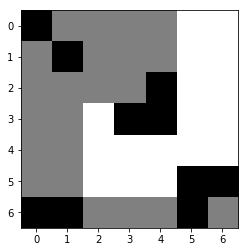

((3, 3), (1, 4)): n_v:  4034 q_all:+0.004983 q:-0.069471 q_m:-0.020000 p:0.132597
((2, 4), (1, 4)): n_v:   859 q_all:-0.035809 q:-0.050954 q_m:-0.000000 p:0.086695
((3, 3), (5, 1)): n_v:   713 q_all:-0.086022 q:-0.101313 q_m:-0.060000 p:0.169702
((5, 5), (6, 4)): n_v:   286 q_all:-0.066340 q:-0.067379 q_m:-0.040000 p:0.054529
((6, 0), (5, 1)): n_v:   223 q_all:-0.075379 q:-0.101683 q_m:-0.040000 p:0.047903
((3, 3), (2, 1)): n_v:   211 q_all:-0.109501 q:-0.114764 q_m:-0.100000 p:0.061391
((3, 3), (4, 1)): n_v:   209 q_all:-0.065856 q:-0.085977 q_m:-0.020000 p:0.039418
((3, 3), (1, 2)): n_v:   174 q_all:-0.137846 q:-0.162824 q_m:-0.140000 p:0.061896
((6, 1), (6, 2)): n_v:   162 q_all:-0.078143 q:-0.091946 q_m:-0.040000 p:0.035604
((3, 4), (1, 4)): n_v:    87 q_all:-0.046843 q:-0.045126 q_m:-0.020000 p:0.011734
((1, 1), (2, 1)): n_v:    82 q_all:-0.097162 q:-0.113062 q_m:-0.080000 p:0.021815
((6, 1), (6, 3)): n_v:    50 q_all:-0.075376 q:-0.113724 q_m:-0.020000 p:0.010754
((1, 1), (1, 2))

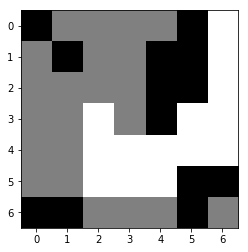

((4, 2), (5, 1)): n_v:  1835 q_all:+0.050743 q:-0.024798 q_m:+0.120000 p:0.056972
((1, 6), (0, 4)): n_v:  1504 q_all:+0.060049 q:+0.037081 q_m:+0.140000 p:0.035356
((4, 6), (6, 6)): n_v:  1109 q_all:+0.074507 q:+0.015926 q_m:+0.140000 p:0.007045
((5, 3), (6, 4)): n_v:   758 q_all:+0.002799 q:-0.024907 q_m:+0.120000 p:0.118211
((2, 6), (0, 4)): n_v:   733 q_all:+0.003010 q:+0.055551 q_m:+0.140000 p:0.113543
((0, 6), (0, 4)): n_v:   384 q_all:+0.005974 q:+0.052587 q_m:+0.140000 p:0.055876
((4, 5), (6, 4)): n_v:   211 q_all:-0.080162 q:-0.026203 q_m:+0.100000 p:0.073273
((4, 6), (6, 4)): n_v:   174 q_all:-0.026012 q:-0.037599 q_m:+0.100000 p:0.039516
((3, 2), (3, 3)): n_v:   172 q_all:-0.013655 q:-0.018308 q_m:+0.120000 p:0.033966
((3, 2), (5, 0)): n_v:   125 q_all:-0.000666 q:-0.038524 q_m:+0.100000 p:0.020790
((5, 3), (5, 1)): n_v:    95 q_all:-0.012803 q:-0.037241 q_m:+0.100000 p:0.018726
((4, 3), (5, 1)): n_v:    94 q_all:-0.029198 q:-0.062893 q_m:+0.100000 p:0.021999
((3, 2), (1, 0))

((2, 4), (3, 3)): n_v:  6403 q_all:+0.019832 q:-0.045724 q_m:+0.060000 p:0.288666
((1, 4), (3, 3)): n_v:   139 q_all:-0.048374 q:-0.062568 q_m:+0.040000 p:0.029281
((2, 5), (3, 3)): n_v:    66 q_all:-0.063931 q:-0.079410 q_m:+0.040000 p:0.016528
((1, 5), (3, 3)): n_v:    58 q_all:-0.067738 q:-0.044238 q_m:+0.040000 p:0.015124
((5, 5), (3, 3)): n_v:    39 q_all:-0.045217 q:-0.079390 q_m:+0.040000 p:0.007238
((1, 1), (3, 3)): n_v:    38 q_all:-0.039410 q:-0.053537 q_m:+0.040000 p:0.006969
((5, 5), (6, 4)): n_v:    31 q_all:-0.042367 q:-0.061135 q_m:-0.020000 p:0.006248
((0, 5), (0, 4)): n_v:    20 q_all:-0.081123 q:-0.070003 q_m:-0.100000 p:0.005990
((1, 1), (0, 2)): n_v:    13 q_all:-0.108104 q:-0.118855 q_m:-0.100000 p:0.004744
((2, 4), (0, 2)): n_v:     1 q_all:-0.100868 q:-0.128401 q_m:-0.120000 p:0.000403
((1, 1), (1, 2)): n_v:     1 q_all:-0.165798 q:-0.124955 q_m:-0.100000 p:0.000498
((0, 0), (1, 0)): n_v:     1 q_all:-0.049942 q:-0.113088 q_m:-0.100000 p:0.000395
((2, 5), (1, 3))

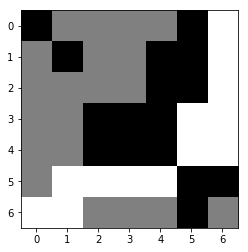

((4, 5), (2, 3)): n_v:  4106 q_all:-0.016480 q:-0.033120 q_m:+0.140000 p:0.605845
((5, 1), (4, 1)): n_v:  3173 q_all:+0.052367 q:-0.049376 q_m:+0.040000 p:0.029118
((2, 6), (0, 4)): n_v:   791 q_all:+0.005384 q:-0.022226 q_m:+0.060000 p:0.083705
((3, 5), (2, 3)): n_v:   617 q_all:-0.025393 q:-0.042224 q_m:+0.140000 p:0.103522
((6, 0), (4, 1)): n_v:   179 q_all:-0.016082 q:-0.069998 q_m:+0.020000 p:0.026759
((0, 6), (0, 4)): n_v:   179 q_all:+0.000875 q:-0.021314 q_m:+0.060000 p:0.018688
((1, 6), (0, 4)): n_v:   164 q_all:-0.011662 q:-0.033414 q_m:+0.060000 p:0.022243
((4, 6), (6, 4)): n_v:   100 q_all:-0.079258 q:-0.103758 q_m:+0.020000 p:0.027880
((6, 1), (4, 1)): n_v:    79 q_all:+0.000697 q:-0.055589 q_m:+0.020000 p:0.009183
((5, 3), (6, 4)): n_v:    71 q_all:-0.019961 q:-0.085057 q_m:+0.040000 p:0.011162
((5, 3), (4, 1)): n_v:    27 q_all:-0.031794 q:-0.055906 q_m:+0.020000 p:0.005038
((5, 2), (3, 1)): n_v:    27 q_all:-0.029599 q:-0.083343 q_m:+0.020000 p:0.004822
((4, 5), (6, 4))

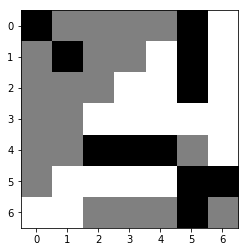

((4, 4), (4, 5)): n_v:  5009 q_all:+0.058843 q:-0.006485 q_m:+0.080000 p:0.203776
((6, 5), (4, 5)): n_v:   979 q_all:+0.090993 q:-0.018622 q_m:+0.060000 p:0.000826
((4, 2), (4, 1)): n_v:   257 q_all:-0.026589 q:-0.084655 q_m:-0.000000 p:0.066530
((1, 1), (2, 1)): n_v:     1 q_all:-0.107584 q:-0.148961 q_m:-0.080000 p:0.000553
((2, 5), (4, 5)): n_v:     1 q_all:+0.027909 q:-0.020228 q_m:+0.060000 p:0.000187
((4, 4), (6, 3)): n_v:     0 q_all:-0.066478 q:-0.136195 q_m:-0.020000 p:0.000000
((4, 4), (6, 6)): n_v:     0 q_all:-0.155767 q:-0.179417 q_m:-0.140000 p:0.000000
((1, 1), (1, 3)): n_v:     0 q_all:-0.058194 q:-0.115486 q_m:-0.020000 p:0.000002
((4, 3), (2, 1)): n_v:     0 q_all:-0.127954 q:-0.169886 q_m:-0.100000 p:0.000001
((4, 4), (6, 4)): n_v:     0 q_all:-0.103875 q:-0.169689 q_m:-0.060000 p:0.000000
((4, 2), (2, 1)): n_v:     0 q_all:-0.118768 q:-0.146920 q_m:-0.100000 p:0.000000
((4, 3), (4, 5)): n_v:     0 q_all:+0.022612 q:-0.033471 q_m:+0.060000 p:0.000102
((1, 5), (0, 3))

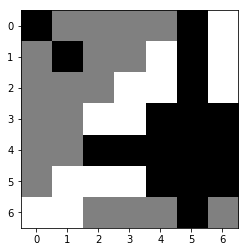

((5, 3), (6, 4)): n_v:   841 q_all:+0.004173 q:-0.086284 q_m:+0.060000 p:0.108821
((2, 6), (0, 4)): n_v:   551 q_all:-0.061473 q:-0.071466 q_m:-0.000000 p:0.164549
((1, 4), (0, 4)): n_v:   309 q_all:-0.066459 q:-0.038498 q_m:+0.020000 p:0.096201
((0, 6), (0, 4)): n_v:   144 q_all:-0.070484 q:-0.061308 q_m:-0.000000 p:0.046419
((2, 3), (0, 4)): n_v:   130 q_all:-0.092647 q:-0.042584 q_m:-0.000000 p:0.049455
((3, 3), (1, 2)): n_v:   122 q_all:-0.074618 q:-0.129742 q_m:-0.040000 p:0.040649
((1, 6), (0, 4)): n_v:   117 q_all:-0.097100 q:-0.092781 q_m:-0.000000 p:0.045604
((3, 2), (1, 0)): n_v:    95 q_all:-0.041990 q:-0.092642 q_m:-0.000000 p:0.023716
((2, 3), (1, 2)): n_v:    91 q_all:-0.143298 q:-0.126444 q_m:-0.020000 p:0.046700
((2, 3), (0, 1)): n_v:    83 q_all:-0.088661 q:-0.086970 q_m:-0.000000 p:0.030962
((2, 4), (0, 4)): n_v:    68 q_all:-0.085479 q:-0.084071 q_m:-0.000000 p:0.024784
((2, 4), (0, 2)): n_v:    67 q_all:-0.091667 q:-0.109894 q_m:-0.040000 p:0.025276
((3, 2), (5, 0))

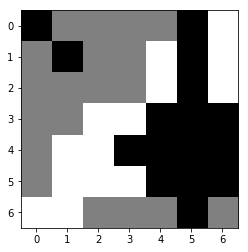

((3, 4), (2, 3)): n_v:  2181 q_all:+0.167762 q:+0.069066 q_m:+0.228000 p:0.805196
((1, 1), (3, 1)): n_v:   116 q_all:+0.164609 q:+0.067656 q_m:+0.160000 p:0.044689
((0, 5), (2, 3)): n_v:    44 q_all:+0.132477 q:+0.056692 q_m:+0.200000 p:0.022624
((5, 4), (6, 4)): n_v:    34 q_all:+0.112164 q:+0.027770 q_m:+0.100000 p:0.020482
((4, 3), (3, 1)): n_v:    33 q_all:+0.134435 q:+0.036504 q_m:+0.160000 p:0.016643
((1, 1), (2, 3)): n_v:    23 q_all:+0.141557 q:+0.053797 q_m:+0.200000 p:0.010994
((1, 5), (2, 3)): n_v:    15 q_all:+0.071329 q:+0.045465 q_m:+0.200000 p:0.011554
((5, 4), (6, 3)): n_v:    10 q_all:+0.130022 q:+0.027926 q_m:+0.140000 p:0.005606
((0, 5), (0, 4)): n_v:     8 q_all:+0.140071 q:+0.043131 q_m:+0.100000 p:0.004038
((4, 5), (2, 3)): n_v:     6 q_all:-0.006044 q:+0.034654 q_m:+0.200000 p:0.006896
((3, 5), (2, 3)): n_v:     6 q_all:+0.012019 q:+0.022542 q_m:+0.200000 p:0.005701
((4, 3), (6, 4)): n_v:     5 q_all:+0.098049 q:-0.003778 q_m:+0.080000 p:0.003249
((5, 4), (6, 2))

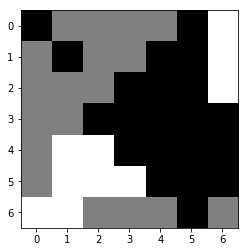

((0, 6), (0, 4)): n_v:  2288 q_all:-0.083071 q:-0.085670 q_m:-0.100000 p:0.264363
((2, 6), (0, 4)): n_v:  1797 q_all:-0.130241 q:-0.073415 q_m:-0.100000 p:0.441518
((1, 6), (0, 4)): n_v:   399 q_all:-0.152035 q:-0.136217 q_m:-0.100000 p:0.122065
((4, 1), (2, 2)): n_v:   332 q_all:-0.089901 q:-0.155698 q_m:-0.060000 p:0.044939
((5, 3), (6, 4)): n_v:   229 q_all:-0.078295 q:-0.144254 q_m:-0.080000 p:0.023508
((4, 2), (6, 4)): n_v:   146 q_all:-0.181876 q:-0.194939 q_m:-0.100000 p:0.056918
((5, 2), (6, 4)): n_v:    25 q_all:-0.144379 q:-0.152777 q_m:-0.100000 p:0.007268
((4, 2), (2, 2)): n_v:    22 q_all:-0.230573 q:-0.166512 q_m:-0.060000 p:0.011551
((6, 0), (6, 2)): n_v:    13 q_all:-0.242062 q:-0.249654 q_m:-0.228000 p:0.007649
((5, 1), (6, 2)): n_v:     4 q_all:-0.218738 q:-0.216919 q_m:-0.200000 p:0.002408
((4, 1), (6, 2)): n_v:     3 q_all:-0.245801 q:-0.238434 q_m:-0.228000 p:0.001767
((4, 2), (2, 1)): n_v:     1 q_all:-0.237983 q:-0.207727 q_m:-0.140000 p:0.000705
((4, 1), (2, 0))

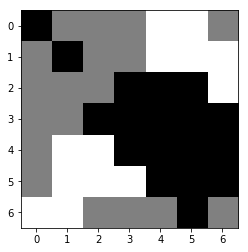

((3, 2), (5, 0)): n_v:  4365 q_all:+0.177264 q:+0.102240 q_m:+0.284000 p:0.021995
((2, 3), (1, 3)): n_v:   669 q_all:+0.087264 q:+0.085087 q_m:+0.200000 p:0.151410
((5, 4), (6, 4)): n_v:   500 q_all:+0.079932 q:+0.047213 q_m:+0.160000 p:0.121883
((3, 2), (3, 1)): n_v:   437 q_all:+0.079253 q:+0.051207 q_m:+0.200000 p:0.107254
((5, 4), (6, 2)): n_v:   247 q_all:+0.112049 q:+0.112409 q_m:+0.284000 p:0.032389
((5, 4), (6, 3)): n_v:    62 q_all:+0.085996 q:+0.042286 q_m:+0.200000 p:0.014299
((3, 2), (1, 3)): n_v:    46 q_all:+0.093959 q:+0.067276 q_m:+0.180000 p:0.009742
((2, 3), (0, 2)): n_v:    44 q_all:+0.025251 q:+0.003718 q_m:+0.100000 p:0.016896
((1, 1), (1, 3)): n_v:    42 q_all:+0.097389 q:+0.098488 q_m:+0.180000 p:0.008508
((5, 5), (6, 6)): n_v:    31 q_all:+0.047057 q:+0.024115 q_m:+0.120000 p:0.010302
((2, 3), (3, 1)): n_v:    26 q_all:+0.072587 q:+0.042734 q_m:+0.180000 p:0.006929
((3, 4), (1, 3)): n_v:    23 q_all:+0.017666 q:+0.026583 q_m:+0.180000 p:0.009148
((4, 3), (6, 2))

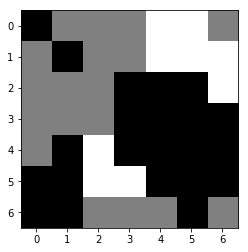

((4, 2), (3, 2)): n_v:  4730 q_all:-0.146794 q:-0.137939 q_m:-0.080000 p:0.547104
((5, 3), (6, 4)): n_v:  3044 q_all:-0.130471 q:-0.123987 q_m:-0.120000 p:0.249198
((5, 2), (6, 4)): n_v:  1099 q_all:-0.095184 q:-0.096066 q_m:-0.140000 p:0.005395
((5, 2), (6, 2)): n_v:   260 q_all:-0.213143 q:-0.102051 q_m:-0.160000 p:0.065967
((5, 3), (3, 2)): n_v:    38 q_all:-0.180988 q:-0.163564 q_m:-0.100000 p:0.007137
((1, 4), (3, 2)): n_v:    29 q_all:-0.178088 q:-0.184688 q_m:-0.100000 p:0.005402
((5, 2), (3, 2)): n_v:    28 q_all:-0.198591 q:-0.168331 q_m:-0.100000 p:0.006206
((4, 2), (6, 4)): n_v:    28 q_all:-0.186537 q:-0.097785 q_m:-0.140000 p:0.005588
((0, 4), (2, 2)): n_v:    14 q_all:-0.230850 q:-0.177382 q_m:-0.140000 p:0.004136
((4, 2), (2, 0)): n_v:    11 q_all:-0.276633 q:-0.210054 q_m:-0.228000 p:0.004044
((0, 4), (0, 2)): n_v:     6 q_all:-0.227447 q:-0.226373 q_m:-0.228000 p:0.001902
((4, 2), (2, 1)): n_v:     5 q_all:-0.205676 q:-0.201026 q_m:-0.228000 p:0.001295
((5, 2), (4, 0))

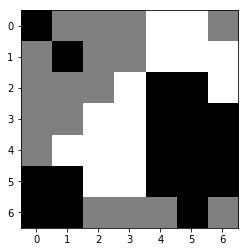

((2, 4), (1, 3)): n_v:  4985 q_all:+0.169839 q:+0.113447 q_m:+0.228000 p:0.482943
((1, 1), (2, 2)): n_v:  1455 q_all:+0.150810 q:+0.077440 q_m:+0.228000 p:0.201017
((5, 0), (3, 1)): n_v:  1375 q_all:+0.148818 q:+0.074458 q_m:+0.200000 p:0.195942
((1, 1), (1, 3)): n_v:   154 q_all:+0.153360 q:+0.123654 q_m:+0.200000 p:0.020351
((5, 1), (3, 1)): n_v:   112 q_all:+0.109585 q:+0.062454 q_m:+0.200000 p:0.025445
((5, 4), (6, 3)): n_v:    97 q_all:+0.109352 q:+0.044811 q_m:+0.180000 p:0.022194
((1, 1), (3, 1)): n_v:    67 q_all:+0.150609 q:+0.077595 q_m:+0.200000 p:0.009350
((5, 4), (6, 4)): n_v:    26 q_all:+0.113934 q:+0.062961 q_m:+0.140000 p:0.005741
((5, 0), (4, 0)): n_v:    16 q_all:+0.097671 q:+0.053712 q_m:+0.140000 p:0.004269
((1, 1), (2, 1)): n_v:    12 q_all:+0.090596 q:+0.028974 q_m:+0.140000 p:0.003305
((5, 1), (6, 2)): n_v:     8 q_all:+0.149385 q:+0.085104 q_m:+0.180000 p:0.001241
((2, 5), (1, 3)): n_v:     8 q_all:+0.094809 q:+0.057042 q_m:+0.200000 p:0.002152
((3, 4), (1, 3))

((5, 3), (6, 4)): n_v:  5183 q_all:-0.108189 q:-0.146330 q_m:-0.080000 p:0.335025
((5, 2), (6, 2)): n_v:  1758 q_all:-0.111542 q:-0.161608 q_m:-0.120000 p:0.125414
((3, 2), (2, 2)): n_v:   809 q_all:-0.173173 q:-0.207554 q_m:-0.080000 p:0.157672
((4, 1), (4, 0)): n_v:   391 q_all:-0.169327 q:-0.159145 q_m:-0.120000 p:0.073222
((4, 2), (6, 4)): n_v:   139 q_all:-0.203910 q:-0.156542 q_m:-0.100000 p:0.035775
((4, 1), (6, 2)): n_v:    32 q_all:-0.189071 q:-0.167515 q_m:-0.140000 p:0.007356
((4, 3), (6, 4)): n_v:    31 q_all:-0.224964 q:-0.198695 q_m:-0.100000 p:0.009537
((4, 3), (2, 2)): n_v:    12 q_all:-0.245366 q:-0.257261 q_m:-0.100000 p:0.004183
((4, 3), (6, 2)): n_v:    12 q_all:-0.244924 q:-0.209457 q_m:-0.140000 p:0.004363
((5, 2), (6, 4)): n_v:    11 q_all:-0.167148 q:-0.150125 q_m:-0.100000 p:0.002076
((4, 1), (2, 2)): n_v:     5 q_all:-0.185642 q:-0.231771 q_m:-0.100000 p:0.001222
((4, 1), (6, 3)): n_v:     2 q_all:-0.214538 q:-0.237854 q_m:-0.180000 p:0.000747
((3, 2), (4, 0))

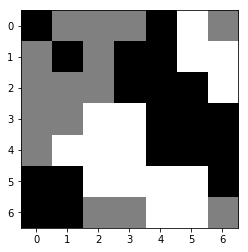

((5, 6), (6, 6)): n_v:  4325 q_all:+0.157584 q:+0.136490 q_m:+0.180000 p:0.245111
((0, 4), (0, 6)): n_v:  1411 q_all:+0.124150 q:+0.130455 q_m:+0.200000 p:0.180345
((1, 1), (2, 2)): n_v:   740 q_all:+0.149329 q:+0.107846 q_m:+0.180000 p:0.054808
((6, 1), (6, 3)): n_v:   724 q_all:+0.132923 q:+0.098993 q_m:+0.256000 p:0.079313
((4, 6), (6, 6)): n_v:   431 q_all:+0.071880 q:+0.060844 q_m:+0.160000 p:0.103212
((4, 5), (6, 3)): n_v:   163 q_all:+0.082544 q:+0.069044 q_m:+0.256000 p:0.035151
((0, 4), (0, 3)): n_v:   114 q_all:+0.063742 q:+0.069767 q_m:+0.100000 p:0.029485
((5, 1), (6, 3)): n_v:   110 q_all:+0.124547 q:+0.113046 q_m:+0.256000 p:0.014095
((2, 5), (0, 3)): n_v:    56 q_all:-0.022428 q:+0.009125 q_m:+0.080000 p:0.024939
((4, 4), (6, 6)): n_v:    36 q_all:+0.074538 q:+0.078016 q_m:+0.160000 p:0.008632
((2, 4), (0, 6)): n_v:    31 q_all:+0.077163 q:+0.065907 q_m:+0.200000 p:0.007113
((5, 0), (3, 1)): n_v:    29 q_all:+0.090622 q:+0.089615 q_m:+0.200000 p:0.005928
((4, 5), (6, 6))

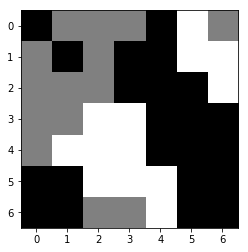

((3, 2), (2, 2)): n_v:  3875 q_all:-0.132370 q:-0.170310 q_m:-0.040000 p:0.429296
((5, 2), (6, 2)): n_v:  2539 q_all:-0.085674 q:-0.130206 q_m:-0.080000 p:0.029805
((4, 1), (4, 0)): n_v:   985 q_all:-0.152816 q:-0.123911 q_m:-0.080000 p:0.151777
((3, 3), (1, 2)): n_v:   550 q_all:-0.113681 q:-0.168672 q_m:-0.060000 p:0.039156
((3, 2), (1, 0)): n_v:    70 q_all:-0.141673 q:-0.172929 q_m:-0.100000 p:0.009216
((4, 3), (2, 2)): n_v:    56 q_all:-0.237072 q:-0.234805 q_m:-0.060000 p:0.018902
((6, 4), (6, 2)): n_v:    55 q_all:-0.112646 q:-0.155630 q_m:-0.100000 p:0.003833
((5, 2), (4, 0)): n_v:    48 q_all:-0.174466 q:-0.169825 q_m:-0.100000 p:0.009779
((4, 1), (2, 2)): n_v:    43 q_all:-0.153104 q:-0.194527 q_m:-0.060000 p:0.006763
((3, 2), (1, 2)): n_v:    40 q_all:-0.173441 q:-0.179722 q_m:-0.060000 p:0.008081
((4, 1), (6, 2)): n_v:    34 q_all:-0.162629 q:-0.128928 q_m:-0.100000 p:0.005899
((3, 2), (2, 1)): n_v:    29 q_all:-0.195782 q:-0.170899 q_m:-0.120000 p:0.007240
((0, 5), (0, 3))

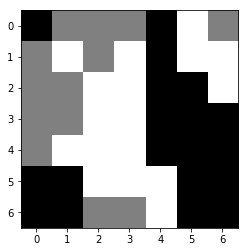

((0, 4), (1, 2)): n_v:  4105 q_all:+0.182478 q:+0.134149 q_m:+0.200000 p:0.528094
((0, 0), (1, 2)): n_v:  2846 q_all:+0.189041 q:+0.128139 q_m:+0.200000 p:0.326415
((6, 1), (6, 3)): n_v:   454 q_all:+0.238948 q:+0.133805 q_m:+0.200000 p:0.003885
((5, 0), (3, 1)): n_v:   450 q_all:+0.203428 q:+0.099030 q_m:+0.200000 p:0.037902
((0, 4), (0, 3)): n_v:   116 q_all:+0.119737 q:+0.085787 q_m:+0.100000 p:0.030619
((1, 4), (1, 2)): n_v:    76 q_all:+0.121768 q:+0.147283 q_m:+0.200000 p:0.019676
((5, 1), (3, 1)): n_v:    44 q_all:+0.112932 q:+0.103941 q_m:+0.200000 p:0.012231
((3, 4), (1, 2)): n_v:    24 q_all:+0.097972 q:+0.125286 q_m:+0.200000 p:0.007489
((0, 0), (2, 1)): n_v:    23 q_all:+0.125603 q:+0.101907 q_m:+0.160000 p:0.005959
((0, 0), (1, 0)): n_v:    16 q_all:+0.111782 q:+0.076338 q_m:+0.100000 p:0.004623
((2, 4), (1, 2)): n_v:     4 q_all:+0.083517 q:+0.085616 q_m:+0.200000 p:0.001648
((6, 1), (4, 0)): n_v:     4 q_all:+0.055327 q:+0.012783 q_m:+0.080000 p:0.001659
((0, 4), (0, 6))

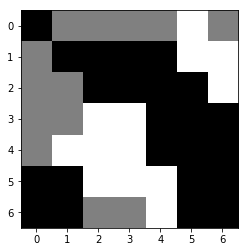

((5, 2), (6, 2)): n_v:  3476 q_all:-0.124702 q:-0.172358 q_m:-0.100000 p:0.184448
((3, 2), (2, 1)): n_v:  1917 q_all:-0.174785 q:-0.150406 q_m:-0.060000 p:0.302866
((4, 1), (2, 1)): n_v:  1013 q_all:-0.101636 q:-0.193682 q_m:-0.080000 p:0.004503
((0, 5), (0, 4)): n_v:   605 q_all:-0.185222 q:-0.141894 q_m:-0.100000 p:0.108920
((4, 1), (4, 0)): n_v:   401 q_all:-0.197178 q:-0.171714 q_m:-0.100000 p:0.082198
((3, 3), (2, 1)): n_v:   207 q_all:-0.101079 q:-0.137783 q_m:-0.080000 p:0.000553
((4, 1), (6, 2)): n_v:   119 q_all:-0.113171 q:-0.168046 q_m:-0.120000 p:0.003170
((2, 6), (0, 4)): n_v:   107 q_all:-0.193498 q:-0.181682 q_m:-0.120000 p:0.021145
((6, 4), (6, 2)): n_v:   105 q_all:-0.128453 q:-0.198784 q_m:-0.120000 p:0.006430
((1, 6), (0, 4)): n_v:    78 q_all:-0.207007 q:-0.197149 q_m:-0.120000 p:0.017799
((5, 4), (6, 2)): n_v:    27 q_all:-0.173401 q:-0.152609 q_m:-0.120000 p:0.004255
((0, 5), (0, 6)): n_v:    10 q_all:-0.224524 q:-0.236868 q_m:-0.180000 p:0.002874
((4, 2), (2, 1))

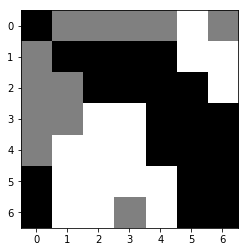

((6, 5), (6, 3)): n_v:  5984 q_all:+0.250503 q:+0.254910 q_m:+0.340000 p:0.035395
((2, 2), (3, 1)): n_v:   895 q_all:+0.113663 q:+0.108046 q_m:+0.256000 p:0.199761
((1, 2), (0, 3)): n_v:   412 q_all:+0.045853 q:+0.064043 q_m:+0.120000 p:0.186024
((4, 5), (6, 3)): n_v:   338 q_all:+0.164448 q:+0.196076 q_m:+0.340000 p:0.016976
((5, 0), (3, 1)): n_v:   323 q_all:+0.090257 q:+0.121725 q_m:+0.228000 p:0.097711
((5, 0), (4, 0)): n_v:   199 q_all:+0.129603 q:+0.172667 q_m:+0.200000 p:0.033401
((5, 5), (6, 3)): n_v:    62 q_all:+0.110364 q:+0.201509 q_m:+0.340000 p:0.014585
((1, 1), (3, 1)): n_v:    15 q_all:+0.130701 q:+0.127981 q_m:+0.228000 p:0.002471
((1, 3), (0, 4)): n_v:    13 q_all:+0.114967 q:+0.179303 q_m:+0.200000 p:0.002870
((1, 1), (0, 3)): n_v:    10 q_all:+0.034965 q:+0.058545 q_m:+0.100000 p:0.005059
((1, 2), (3, 1)): n_v:     7 q_all:+0.125172 q:+0.109505 q_m:+0.228000 p:0.001401
((2, 5), (0, 3)): n_v:     7 q_all:+0.005035 q:-0.009295 q_m:+0.100000 p:0.004230
((4, 4), (6, 3))

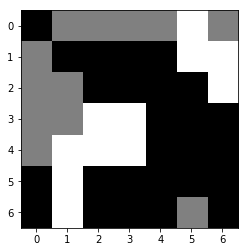

((4, 3), (6, 5)): n_v:  5329 q_all:-0.224815 q:-0.153109 q_m:-0.100000 p:0.439413
((0, 5), (0, 4)): n_v:  3482 q_all:-0.201617 q:-0.278324 q_m:-0.200000 p:0.138847
((4, 3), (2, 1)): n_v:  1024 q_all:-0.192413 q:-0.297647 q_m:-0.180000 p:0.019956
((3, 2), (2, 1)): n_v:   346 q_all:-0.281918 q:-0.301916 q_m:-0.160000 p:0.066942
((0, 5), (0, 3)): n_v:   307 q_all:-0.274003 q:-0.332619 q_m:-0.180000 p:0.054781
((3, 3), (2, 1)): n_v:   137 q_all:-0.210610 q:-0.265922 q_m:-0.180000 p:0.007841
((2, 6), (0, 4)): n_v:   110 q_all:-0.270500 q:-0.321310 q_m:-0.228000 p:0.018837
((1, 5), (0, 3)): n_v:    50 q_all:-0.308269 q:-0.323924 q_m:-0.180000 p:0.012299
((1, 6), (0, 4)): n_v:    41 q_all:-0.275169 q:-0.323591 q_m:-0.228000 p:0.007570
((2, 6), (0, 6)): n_v:    18 q_all:-0.377379 q:-0.362636 q_m:-0.340000 p:0.007026
((4, 1), (4, 0)): n_v:     9 q_all:-0.321821 q:-0.273697 q_m:-0.256000 p:0.002625
((3, 2), (1, 0)): n_v:     7 q_all:-0.342832 q:-0.393359 q_m:-0.228000 p:0.002196
((6, 1), (4, 0))

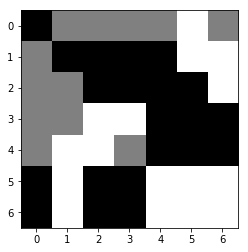

((3, 4), (4, 3)): n_v:  9221 q_all:+0.231345 q:+0.173683 q_m:+0.312000 p:0.271766
((6, 2), (4, 3)): n_v:   134 q_all:+0.179523 q:+0.078122 q_m:+0.284000 p:0.017688
((3, 5), (4, 3)): n_v:    86 q_all:+0.196278 q:+0.172966 q_m:+0.284000 p:0.008489
((2, 5), (4, 3)): n_v:    63 q_all:+0.182857 q:+0.117631 q_m:+0.284000 p:0.007810
((6, 3), (4, 3)): n_v:    46 q_all:+0.193940 q:+0.107367 q_m:+0.284000 p:0.004628
((2, 4), (4, 3)): n_v:    44 q_all:+0.176009 q:+0.121020 q_m:+0.284000 p:0.006216
((2, 2), (4, 3)): n_v:    38 q_all:+0.171392 q:+0.095582 q_m:+0.284000 p:0.005588
((4, 5), (4, 3)): n_v:     8 q_all:+0.150808 q:+0.075826 q_m:+0.284000 p:0.001405
((2, 3), (4, 3)): n_v:     7 q_all:+0.162821 q:+0.111382 q_m:+0.284000 p:0.001034
((5, 0), (3, 1)): n_v:     2 q_all:+0.147201 q:+0.034500 q_m:+0.228000 p:0.000484
((2, 2), (3, 1)): n_v:     1 q_all:+0.098030 q:+0.021548 q_m:+0.256000 p:0.000244
((2, 4), (0, 6)): n_v:     0 q_all:+0.149030 q:+0.030576 q_m:+0.228000 p:0.000187
((1, 2), (0, 3))

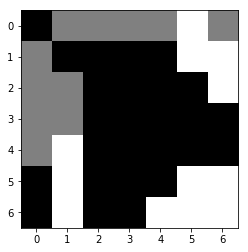

((4, 1), (2, 1)): n_v:  7741 q_all:-0.119950 q:-0.133701 q_m:-0.120000 p:0.202611
((4, 1), (3, 1)): n_v:  1702 q_all:-0.231233 q:-0.154506 q_m:-0.140000 p:0.308035
((0, 5), (0, 4)): n_v:   336 q_all:-0.298771 q:-0.203804 q_m:-0.180000 p:0.108173
((0, 5), (0, 3)): n_v:   322 q_all:-0.245094 q:-0.243620 q_m:-0.160000 p:0.067685
((2, 6), (0, 4)): n_v:   103 q_all:-0.279654 q:-0.236517 q_m:-0.200000 p:0.029061
((4, 1), (4, 0)): n_v:    78 q_all:-0.278909 q:-0.263978 q_m:-0.228000 p:0.021841
((1, 6), (0, 4)): n_v:    66 q_all:-0.311503 q:-0.233193 q_m:-0.200000 p:0.023135
((5, 1), (3, 1)): n_v:    59 q_all:-0.230210 q:-0.124717 q_m:-0.160000 p:0.010571
((1, 5), (0, 3)): n_v:    45 q_all:-0.269489 q:-0.244438 q_m:-0.160000 p:0.011942
((6, 1), (4, 0)): n_v:    44 q_all:-0.299073 q:-0.287395 q_m:-0.256000 p:0.014291
((4, 1), (2, 0)): n_v:     5 q_all:-0.297801 q:-0.357739 q_m:-0.256000 p:0.001615
((0, 5), (0, 6)): n_v:     3 q_all:-0.336024 q:-0.330600 q_m:-0.284000 p:0.001296
((4, 1), (3, 0))

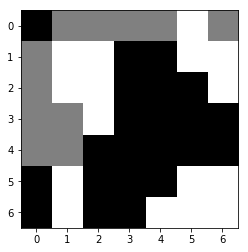

((0, 0), (1, 0)): n_v:  4245 q_all:+0.166625 q:+0.031401 q_m:+0.228000 p:0.092644
((4, 2), (3, 1)): n_v:  3106 q_all:+0.124049 q:+0.086205 q_m:+0.284000 p:0.302197
((1, 3), (0, 4)): n_v:  2015 q_all:+0.140977 q:+0.086442 q_m:+0.228000 p:0.135742
((1, 3), (0, 2)): n_v:  1750 q_all:+0.122793 q:+0.082583 q_m:+0.228000 p:0.174198
((0, 0), (0, 1)): n_v:   742 q_all:+0.131872 q:+0.080419 q_m:+0.228000 p:0.061922
((5, 0), (3, 1)): n_v:   247 q_all:+0.110253 q:+0.043323 q_m:+0.256000 p:0.030156
((4, 2), (4, 1)): n_v:   138 q_all:+0.121271 q:+0.054703 q_m:+0.228000 p:0.014177
((6, 0), (4, 1)): n_v:    70 q_all:+0.104833 q:+0.024468 q_m:+0.200000 p:0.009248
((0, 0), (0, 2)): n_v:    52 q_all:+0.103549 q:+0.062325 q_m:+0.200000 p:0.007063
((4, 3), (3, 1)): n_v:    24 q_all:+0.061584 q:+0.008647 q_m:+0.256000 p:0.005108
((6, 3), (4, 1)): n_v:    20 q_all:+0.075673 q:+0.006138 q_m:+0.200000 p:0.003741
((2, 3), (3, 1)): n_v:    19 q_all:+0.071913 q:+0.035023 q_m:+0.256000 p:0.003703
((5, 2), (3, 1))

((2, 2), (4, 1)): n_v:  4653 q_all:-0.093732 q:-0.067505 q_m:-0.100000 p:0.156467
((3, 2), (4, 0)): n_v:  1402 q_all:-0.150406 q:-0.139076 q_m:-0.180000 p:0.212558
((3, 2), (4, 1)): n_v:   794 q_all:-0.154598 q:-0.038691 q_m:-0.080000 p:0.127099
((3, 2), (2, 0)): n_v:   747 q_all:-0.138875 q:-0.108419 q_m:-0.100000 p:0.095312
((2, 2), (4, 0)): n_v:   401 q_all:-0.205461 q:-0.159196 q_m:-0.180000 p:0.106892
((5, 1), (4, 0)): n_v:   366 q_all:-0.204995 q:-0.139403 q_m:-0.160000 p:0.097104
((1, 2), (0, 1)): n_v:   283 q_all:-0.137703 q:-0.132039 q_m:-0.080000 p:0.035376
((2, 2), (0, 1)): n_v:   273 q_all:-0.145529 q:-0.209857 q_m:-0.100000 p:0.038704
((1, 2), (2, 0)): n_v:    61 q_all:-0.175209 q:-0.127225 q_m:-0.100000 p:0.012386
((6, 1), (4, 1)): n_v:    16 q_all:-0.150621 q:-0.084490 q_m:-0.100000 p:0.002539
((6, 1), (4, 0)): n_v:    12 q_all:-0.161371 q:-0.230112 q_m:-0.180000 p:0.002260
((1, 2), (0, 2)): n_v:    12 q_all:-0.210370 q:-0.214494 q_m:-0.120000 p:0.003510
((0, 5), (0, 4))

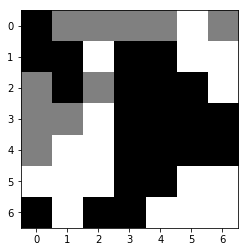

((1, 1), (2, 2)): n_v:  5167 q_all:+0.130681 q:+0.057362 q_m:+0.200000 p:0.059441
((6, 0), (4, 0)): n_v:  1629 q_all:+0.121274 q:+0.004566 q_m:+0.228000 p:0.005994
((2, 1), (3, 1)): n_v:   875 q_all:+0.068159 q:-0.015152 q_m:+0.256000 p:0.121389
((2, 1), (4, 0)): n_v:   682 q_all:+0.105414 q:+0.060702 q_m:+0.228000 p:0.032581
((1, 3), (0, 4)): n_v:   382 q_all:+0.075953 q:+0.051714 q_m:+0.200000 p:0.046954
((6, 2), (4, 0)): n_v:   350 q_all:+0.120939 q:+0.019396 q_m:+0.228000 p:0.000761
((1, 1), (0, 2)): n_v:   180 q_all:+0.016610 q:-0.023341 q_m:+0.160000 p:0.044090
((0, 0), (0, 1)): n_v:    58 q_all:+0.031264 q:+0.016878 q_m:+0.160000 p:0.012476
((2, 1), (3, 0)): n_v:    42 q_all:+0.069277 q:-0.019349 q_m:+0.160000 p:0.005653
((0, 0), (2, 2)): n_v:    26 q_all:+0.076097 q:+0.036636 q_m:+0.180000 p:0.003290
((1, 0), (2, 0)): n_v:    18 q_all:+0.005938 q:-0.027017 q_m:+0.120000 p:0.004966
((0, 0), (0, 2)): n_v:    18 q_all:+0.001651 q:-0.024552 q_m:+0.140000 p:0.004883
((1, 0), (0, 2))

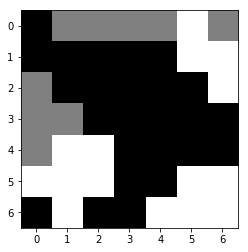

((4, 1), (3, 1)): n_v:  6096 q_all:-0.119089 q:-0.050923 q_m:-0.060000 p:0.551929
((4, 2), (2, 0)): n_v:  3011 q_all:-0.085832 q:-0.153261 q_m:-0.080000 p:0.073863
((5, 0), (3, 1)): n_v:   421 q_all:-0.108270 q:-0.085342 q_m:-0.080000 p:0.029134
((0, 5), (0, 3)): n_v:   179 q_all:-0.123125 q:-0.169977 q_m:-0.080000 p:0.017643
((4, 1), (2, 0)): n_v:   118 q_all:-0.094259 q:-0.123732 q_m:-0.080000 p:0.005168
((5, 1), (3, 1)): n_v:    61 q_all:-0.208698 q:-0.115834 q_m:-0.080000 p:0.016455
((5, 2), (3, 1)): n_v:    22 q_all:-0.188364 q:-0.103481 q_m:-0.080000 p:0.005111
((6, 1), (4, 0)): n_v:    17 q_all:-0.241134 q:-0.285567 q_m:-0.200000 p:0.005741
((0, 5), (0, 4)): n_v:    16 q_all:-0.144099 q:-0.130778 q_m:-0.100000 p:0.002348
((1, 6), (0, 4)): n_v:     7 q_all:-0.170246 q:-0.180981 q_m:-0.120000 p:0.001445
((1, 5), (0, 3)): n_v:     7 q_all:-0.159384 q:-0.178072 q_m:-0.080000 p:0.001344
((2, 6), (0, 4)): n_v:     3 q_all:-0.155944 q:-0.161013 q_m:-0.120000 p:0.000610
((4, 2), (4, 0))

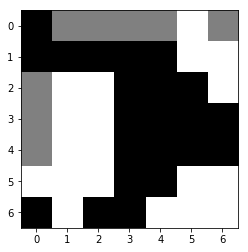

((6, 0), (4, 0)): n_v:  5046 q_all:+0.156572 q:+0.042618 q_m:+0.228000 p:0.192926
((1, 0), (2, 0)): n_v:  3378 q_all:+0.110706 q:+0.033583 q_m:+0.160000 p:0.423361
((6, 2), (4, 0)): n_v:  1799 q_all:+0.127565 q:+0.050126 q_m:+0.228000 p:0.167758
((0, 0), (2, 0)): n_v:   306 q_all:+0.098404 q:+0.030044 q_m:+0.140000 p:0.045578
((1, 3), (0, 4)): n_v:    74 q_all:+0.108884 q:+0.052838 q_m:+0.160000 p:0.009610
((1, 0), (3, 0)): n_v:    60 q_all:+0.096131 q:+0.025231 q_m:+0.180000 p:0.009290
((1, 2), (3, 0)): n_v:    15 q_all:+0.084949 q:+0.003037 q_m:+0.180000 p:0.002686
((1, 2), (0, 3)): n_v:    14 q_all:+0.016681 q:-0.040108 q_m:+0.080000 p:0.004540
((1, 1), (3, 0)): n_v:    14 q_all:+0.092097 q:+0.013755 q_m:+0.180000 p:0.002232
((1, 2), (2, 0)): n_v:    12 q_all:+0.087199 q:-0.000672 q_m:+0.140000 p:0.002132
((0, 0), (0, 1)): n_v:    11 q_all:+0.046086 q:-0.023311 q_m:+0.080000 p:0.002910
((1, 1), (0, 2)): n_v:     4 q_all:+0.015151 q:-0.039528 q_m:+0.080000 p:0.001483
((2, 4), (0, 6))

((6, 1), (6, 0)): n_v:  4692 q_all:-0.097513 q:-0.148552 q_m:-0.120000 p:0.319067
((2, 2), (3, 0)): n_v:   771 q_all:-0.072165 q:-0.147124 q_m:-0.100000 p:0.013377
((2, 1), (3, 0)): n_v:   708 q_all:-0.144408 q:-0.127648 q_m:-0.080000 p:0.114467
((2, 2), (0, 3)): n_v:   658 q_all:-0.065034 q:-0.304226 q_m:-0.100000 p:0.002037
((4, 2), (2, 0)): n_v:   560 q_all:-0.120442 q:-0.140402 q_m:-0.100000 p:0.063762
((2, 1), (2, 0)): n_v:   390 q_all:-0.149887 q:-0.164388 q_m:-0.080000 p:0.067416
((0, 5), (0, 4)): n_v:   353 q_all:-0.205513 q:-0.234476 q_m:-0.120000 p:0.100351
((0, 5), (0, 3)): n_v:   199 q_all:-0.182096 q:-0.281327 q_m:-0.100000 p:0.047190
((4, 2), (6, 0)): n_v:   174 q_all:-0.204093 q:-0.202728 q_m:-0.140000 p:0.048735
((2, 1), (0, 1)): n_v:    92 q_all:-0.152192 q:-0.120270 q_m:-0.060000 p:0.016352
((2, 2), (0, 1)): n_v:    89 q_all:-0.134854 q:-0.206388 q_m:-0.060000 p:0.012809
((0, 5), (0, 6)): n_v:    38 q_all:-0.247402 q:-0.358956 q_m:-0.200000 p:0.014069
((5, 2), (6, 0))

((1, 3), (0, 4)): n_v:  8112 q_all:+0.147323 q:+0.099093 q_m:+0.228000 p:0.110804
((3, 1), (3, 0)): n_v:   718 q_all:+0.050076 q:+0.006753 q_m:+0.180000 p:0.151781
((1, 0), (2, 0)): n_v:    93 q_all:+0.055413 q:+0.035310 q_m:+0.180000 p:0.018455
((1, 1), (0, 2)): n_v:    83 q_all:+0.036393 q:-0.021561 q_m:+0.140000 p:0.019926
((0, 0), (0, 1)): n_v:    81 q_all:+0.062122 q:+0.006442 q_m:+0.140000 p:0.014572
((1, 2), (0, 3)): n_v:    69 q_all:+0.036831 q:-0.019622 q_m:+0.140000 p:0.016593
((1, 2), (0, 4)): n_v:    53 q_all:+0.101520 q:+0.100669 q_m:+0.200000 p:0.003271
((1, 4), (0, 6)): n_v:    27 q_all:+0.096685 q:+0.043016 q_m:+0.256000 p:0.002071
((4, 1), (2, 0)): n_v:    26 q_all:+0.060083 q:-0.012904 q_m:+0.160000 p:0.004835
((4, 0), (2, 0)): n_v:    11 q_all:+0.050692 q:+0.004771 q_m:+0.160000 p:0.002297
((1, 0), (0, 2)): n_v:     7 q_all:+0.022700 q:-0.014227 q_m:+0.120000 p:0.002052
((2, 4), (0, 6)): n_v:     6 q_all:+0.078966 q:+0.007726 q_m:+0.256000 p:0.000739
((1, 0), (3, 0))

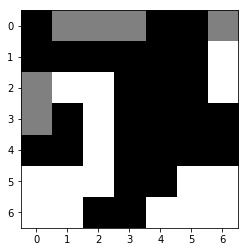

((2, 2), (0, 3)): n_v:  5466 q_all:-0.081259 q:-0.160424 q_m:-0.060000 p:0.118362
((2, 2), (0, 1)): n_v:  3748 q_all:-0.144801 q:-0.119015 q_m:-0.060000 p:0.502398
((2, 1), (0, 3)): n_v:  1078 q_all:-0.110004 q:-0.119484 q_m:-0.060000 p:0.090187
((2, 1), (0, 1)): n_v:   854 q_all:-0.159186 q:-0.115440 q_m:-0.060000 p:0.136304
((1, 6), (0, 6)): n_v:   348 q_all:-0.119825 q:-0.146124 q_m:-0.120000 p:0.028769
((2, 1), (3, 0)): n_v:   251 q_all:-0.151418 q:-0.111885 q_m:-0.080000 p:0.036709
((4, 2), (2, 0)): n_v:   153 q_all:-0.161430 q:-0.156592 q_m:-0.100000 p:0.025143
((2, 1), (2, 0)): n_v:   145 q_all:-0.146220 q:-0.113117 q_m:-0.080000 p:0.019726
((2, 2), (3, 0)): n_v:   114 q_all:-0.108786 q:-0.091724 q_m:-0.100000 p:0.008035
((5, 0), (3, 0)): n_v:    67 q_all:-0.172012 q:-0.151285 q_m:-0.100000 p:0.012255
((2, 6), (0, 6)): n_v:    58 q_all:-0.188023 q:-0.185662 q_m:-0.140000 p:0.012398
((2, 1), (0, 2)): n_v:    11 q_all:-0.214099 q:-0.250393 q_m:-0.100000 p:0.002860
((3, 2), (3, 0))

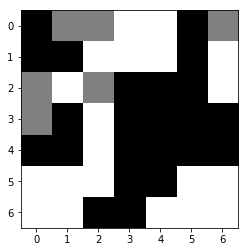

((1, 1), (2, 2)): n_v:  7903 q_all:+0.167027 q:+0.098934 q_m:+0.256000 p:0.085965
((1, 1), (0, 2)): n_v:  1702 q_all:+0.036112 q:+0.002523 q_m:+0.200000 p:0.423429
((0, 0), (0, 2)): n_v:   343 q_all:+0.012008 q:+0.007176 q_m:+0.180000 p:0.107757
((1, 0), (0, 2)): n_v:   115 q_all:+0.013426 q:+0.001166 q_m:+0.180000 p:0.035906
((1, 0), (2, 2)): n_v:    69 q_all:+0.101206 q:+0.093128 q_m:+0.228000 p:0.005018
((0, 0), (2, 2)): n_v:    49 q_all:+0.091231 q:+0.082860 q_m:+0.228000 p:0.004953
((0, 0), (0, 1)): n_v:    10 q_all:+0.008816 q:+0.016726 q_m:+0.120000 p:0.003342
((4, 1), (2, 2)): n_v:     6 q_all:+0.099922 q:+0.016132 q_m:+0.228000 p:0.000442
((4, 0), (2, 2)): n_v:     5 q_all:+0.094783 q:+0.024222 q_m:+0.228000 p:0.000508
((1, 0), (2, 0)): n_v:     2 q_all:-0.012585 q:-0.016129 q_m:+0.120000 p:0.000928
((2, 3), (0, 2)): n_v:     2 q_all:+0.030677 q:-0.039795 q_m:+0.180000 p:0.000710
((4, 3), (2, 2)): n_v:     1 q_all:+0.053662 q:+0.004074 q_m:+0.228000 p:0.000198
((4, 4), (2, 2))

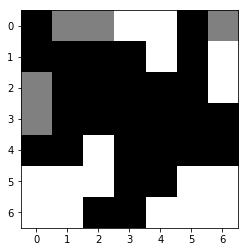

((4, 2), (2, 0)): n_v:  7011 q_all:-0.100794 q:-0.159567 q_m:-0.080000 p:0.169612
((5, 0), (3, 0)): n_v:  4838 q_all:-0.173677 q:-0.149755 q_m:-0.080000 p:0.709736
((4, 2), (3, 0)): n_v:   331 q_all:-0.161163 q:-0.141982 q_m:-0.080000 p:0.039257
((5, 2), (3, 0)): n_v:   245 q_all:-0.185537 q:-0.262583 q_m:-0.080000 p:0.042408
((0, 3), (0, 1)): n_v:   174 q_all:-0.145791 q:-0.159399 q_m:-0.080000 p:0.014666
((5, 1), (3, 0)): n_v:    47 q_all:-0.285940 q:-0.289086 q_m:-0.080000 p:0.016756
((0, 3), (0, 2)): n_v:    30 q_all:-0.155680 q:-0.022616 q_m:-0.100000 p:0.003249
((0, 4), (0, 6)): n_v:     5 q_all:-0.302612 q:-0.234704 q_m:-0.160000 p:0.001706
((1, 4), (0, 6)): n_v:     4 q_all:-0.243938 q:-0.108427 q_m:-0.160000 p:0.001202
((1, 6), (0, 6)): n_v:     3 q_all:-0.135467 q:+0.013841 q_m:-0.140000 p:0.000129
((2, 6), (0, 6)): n_v:     2 q_all:-0.230422 q:-0.226963 q_m:-0.160000 p:0.000639
((0, 4), (0, 2)): n_v:     1 q_all:-0.225808 q:-0.277420 q_m:-0.120000 p:0.000466
((1, 4), (0, 2))

((3, 2), (4, 2)): n_v:  8634 q_all:+0.135550 q:+0.089411 q_m:+0.228000 p:0.126895
((4, 0), (3, 0)): n_v:   992 q_all:+0.078694 q:+0.021076 q_m:+0.228000 p:0.080311
((6, 3), (4, 2)): n_v:   577 q_all:+0.106130 q:+0.010123 q_m:+0.200000 p:0.011836
((4, 0), (4, 2)): n_v:   566 q_all:+0.113665 q:-0.016943 q_m:+0.200000 p:0.002175
((0, 0), (0, 1)): n_v:   467 q_all:+0.059235 q:-0.024950 q_m:+0.180000 p:0.057801
((1, 2), (3, 0)): n_v:    61 q_all:+0.041206 q:+0.006986 q_m:+0.200000 p:0.010116
((5, 4), (4, 2)): n_v:    52 q_all:+0.056098 q:+0.028922 q_m:+0.200000 p:0.006808
((1, 2), (0, 2)): n_v:    43 q_all:+0.070752 q:+0.075314 q_m:+0.180000 p:0.004150
((3, 4), (4, 2)): n_v:    36 q_all:+0.023660 q:-0.013357 q_m:+0.200000 p:0.007284
((6, 2), (4, 2)): n_v:    30 q_all:+0.060794 q:-0.006546 q_m:+0.200000 p:0.003728
((2, 3), (4, 2)): n_v:    26 q_all:+0.032781 q:-0.015919 q_m:+0.200000 p:0.004606
((2, 2), (4, 2)): n_v:    15 q_all:+0.059757 q:-0.002309 q_m:+0.200000 p:0.001950
((4, 4), (4, 2))

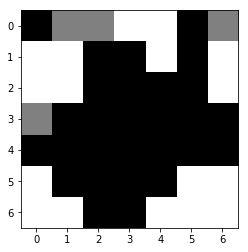

((2, 0), (3, 0)): n_v:  9203 q_all:-0.063268 q:-0.086048 q_m:-0.080000 p:0.291518
((5, 0), (3, 0)): n_v:  1276 q_all:-0.177872 q:-0.150973 q_m:-0.100000 p:0.270829
((1, 0), (3, 0)): n_v:   919 q_all:-0.163531 q:-0.124561 q_m:-0.100000 p:0.166768
((1, 6), (0, 6)): n_v:   851 q_all:-0.081166 q:+0.142322 q_m:-0.120000 p:0.003493
((1, 1), (3, 0)): n_v:   156 q_all:-0.146511 q:-0.077637 q_m:-0.100000 p:0.022562
((2, 6), (0, 6)): n_v:    59 q_all:-0.284063 q:-0.364306 q_m:-0.140000 p:0.024335
((1, 0), (0, 1)): n_v:    42 q_all:-0.192382 q:-0.125700 q_m:-0.120000 p:0.009868
((0, 3), (0, 1)): n_v:    34 q_all:-0.265877 q:-0.285533 q_m:-0.140000 p:0.012390
((1, 0), (0, 2)): n_v:    30 q_all:-0.235502 q:-0.235332 q_m:-0.140000 p:0.009955
((1, 4), (0, 6)): n_v:    29 q_all:-0.281122 q:-0.240533 q_m:-0.140000 p:0.011704
((0, 4), (0, 6)): n_v:    26 q_all:-0.275731 q:-0.427494 q_m:-0.140000 p:0.010595
((2, 0), (0, 1)): n_v:    23 q_all:-0.259011 q:-0.280625 q_m:-0.140000 p:0.008735
((0, 3), (0, 2))

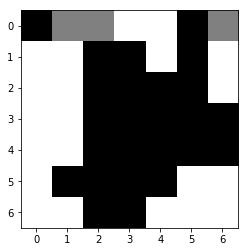

((1, 2), (0, 2)): n_v:  3427 q_all:+0.077214 q:+0.156287 q_m:+0.180000 p:0.103683
((0, 5), (0, 6)): n_v:  3141 q_all:+0.153961 q:-0.274513 q_m:+0.140000 p:0.033993
((1, 3), (0, 1)): n_v:  2973 q_all:+0.091577 q:-0.485408 q_m:+0.160000 p:0.001248
((0, 0), (0, 1)): n_v:  2946 q_all:+0.031513 q:-0.302391 q_m:+0.180000 p:0.357198
((0, 0), (0, 2)): n_v:   299 q_all:+0.057990 q:+0.087476 q_m:+0.160000 p:0.020958
((2, 2), (0, 1)): n_v:     7 q_all:+0.017135 q:-0.128033 q_m:+0.160000 p:0.001134
((2, 3), (0, 1)): n_v:     2 q_all:-0.143990 q:-0.368883 q_m:+0.160000 p:0.001126
((2, 4), (0, 2)): n_v:     1 q_all:-0.112048 q:-0.121520 q_m:+0.160000 p:0.000363
((2, 3), (0, 2)): n_v:     1 q_all:-0.032577 q:-0.057178 q_m:+0.160000 p:0.000222
((2, 4), (0, 6)): n_v:     0 q_all:-0.233608 q:-0.469346 q_m:+0.120000 p:0.000195
((2, 2), (0, 2)): n_v:     0 q_all:-0.267076 q:-0.551793 q_m:+0.160000 p:0.000479
((2, 5), (0, 6)): n_v:     0 q_all:-0.448592 q:-0.827654 q_m:+0.120000 p:0.000257
1 's turn
one mo

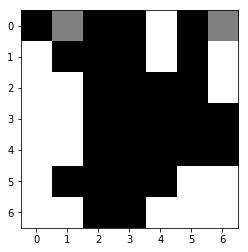

((2, 0), (0, 1)): n_v:  5162 q_all:+0.014958 q:-0.074924 q_m:-0.020000 p:0.597072
((1, 0), (0, 1)): n_v:   966 q_all:-0.110599 q:+0.327795 q_m:-0.000000 p:0.374393
((2, 1), (0, 1)): n_v:    42 q_all:-0.231630 q:+0.018789 q_m:-0.020000 p:0.027564
((1, 6), (0, 6)): n_v:     1 q_all:-0.456490 q:+0.198365 q_m:-0.080000 p:0.000012
((1, 4), (0, 6)): n_v:     0 q_all:-0.256158 q:-0.360263 q_m:-0.100000 p:0.000252
((0, 4), (0, 6)): n_v:     0 q_all:-0.226237 q:-0.310395 q_m:-0.100000 p:0.000142
((2, 6), (0, 6)): n_v:     0 q_all:-0.355531 q:-0.525885 q_m:-0.100000 p:0.000557
-1 's turn
one move takes time(s):  0.1829054355621338


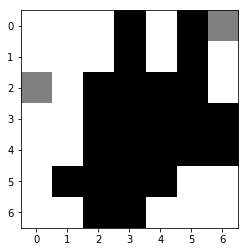

((0, 5), (0, 6)): n_v:  5213 q_all:-0.172162 q:-0.767225 q_m:+0.080000 p:0.019629
((3, 2), (2, 0)): n_v:  2423 q_all:-0.259926 q:+0.147122 q_m:+0.228000 p:0.430965
((4, 2), (2, 0)): n_v:  1358 q_all:-0.311727 q:-0.219150 q_m:+0.228000 p:0.381247
((2, 2), (2, 0)): n_v:   722 q_all:-0.269506 q:-0.401029 q_m:+0.228000 p:0.142046
((2, 5), (0, 6)): n_v:     2 q_all:-0.572375 q:-0.990025 q_m:+0.060000 p:0.001576
((2, 4), (0, 6)): n_v:     1 q_all:-0.488219 q:-0.849183 q_m:+0.060000 p:0.001026
1 's turn
one move takes time(s):  0.12999534606933594


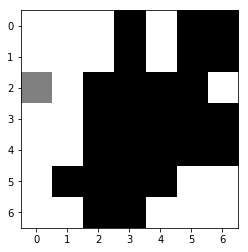

((0, 0), (2, 0)): n_v:  9070 q_all:+0.652322 q:+0.113684 q_m:-0.080000 p:0.161436
((0, 1), (2, 0)): n_v:   564 q_all:-0.039116 q:+0.022210 q_m:-0.080000 p:0.153084
((0, 2), (2, 0)): n_v:   288 q_all:-0.119567 q:-0.178916 q_m:-0.080000 p:0.172038
((1, 2), (2, 0)): n_v:   149 q_all:-0.097838 q:-0.124596 q_m:-0.080000 p:0.075820
((4, 0), (2, 0)): n_v:   115 q_all:-0.312444 q:-0.467407 q_m:-0.080000 p:0.158723
((1, 0), (2, 0)): n_v:    14 q_all:-1.000000 q:+5.000000 q_m:-0.060000 p:0.049127
((4, 1), (2, 0)): n_v:    13 q_all:-0.284565 q:-0.420942 q_m:-0.080000 p:0.017660
-1 's turn
one move takes time(s):  0.10603594779968262


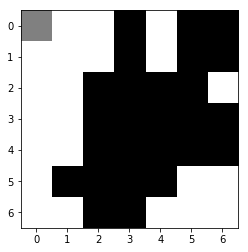

((2, 2), (0, 0)): n_v: 12761 q_all:-0.852781 q:-0.752212 q_m:+0.200000 p:0.982443
1 's turn
one move takes time(s):  0.0764014720916748


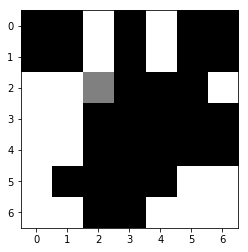

((1, 2), (2, 2)): n_v: 14869 q_all:+1.000000 q:+5.000000 q_m:+0.020000 p:0.260014
((0, 4), (2, 2)): n_v:    32 q_all:-0.297248 q:-0.180075 q_m:-0.000000 p:0.064601
((4, 0), (2, 2)): n_v:    28 q_all:-0.329067 q:-0.192647 q_m:-0.000000 p:0.055412
((3, 0), (2, 2)): n_v:    23 q_all:-0.034009 q:-0.183045 q_m:-0.000000 p:0.035941
((0, 2), (2, 2)): n_v:    17 q_all:-0.321855 q:-0.213499 q_m:-0.000000 p:0.035635
((4, 1), (2, 2)): n_v:    13 q_all:-0.267140 q:-0.168174 q_m:-0.000000 p:0.025851
((2, 0), (2, 2)): n_v:    11 q_all:-0.354394 q:-0.231987 q_m:-0.000000 p:0.022069
((1, 4), (2, 2)): n_v:     7 q_all:-0.205738 q:+0.147541 q_m:-0.000000 p:0.012988
this self play has 80 steps, time elapsed 139.07214856147766
winner is 1.0
episode 85 finished
episode 86 now start
it seems the reset did nothing
reset successful
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.8715963363647461
1 's turn


This is a random move


one move takes time(s):  1

one move takes time(s):  0.1098783016204834
1 's turn
one move takes time(s):  0.07991743087768555
this self play has 84 steps, time elapsed 118.82582330703735
winner is 1.0
episode 86 finished
episode 87 now start
it seems the reset did nothing
reset successful
left space is 45
start new self play
-1 's turn
one move takes time(s):  0.8551404476165771
1 's turn
one move takes time(s):  1.0638136863708496
-1 's turn


This is a random move


one move takes time(s):  1.6500961780548096
1 's turn


This is a random move


one move takes time(s):  1.698514461517334
-1 's turn
due to rollout lim, final rollout times:  4783 time elapsed:  2.0015015602111816


This is a random move


one move takes time(s):  2.0024960041046143
1 's turn
due to rollout lim, final rollout times:  2096 time elapsed:  2.0062263011932373
one move takes time(s):  2.007404088973999
-1 's turn
due to rollout lim, final rollout times:  2168 time elapsed:  2.0000064373016357
one move takes time(s):  2.001746416091919


one move takes time(s):  0.13678574562072754
-1 's turn


This is a random move


one move takes time(s):  0.12923049926757812
this self play has 77 steps, time elapsed 495.2687757015228
winner is -1.0
episode 87 finished
episode 88 now start
it seems the reset did nothing
reset successful
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.898770809173584
1 's turn


This is a random move


one move takes time(s):  1.007493495941162
-1 's turn
one move takes time(s):  1.3280611038208008
1 's turn


This is a random move


one move takes time(s):  1.919914722442627
-1 's turn
due to rollout lim, final rollout times:  2497 time elapsed:  2.0000386238098145


This is a random move


one move takes time(s):  2.001183271408081
1 's turn
due to rollout lim, final rollout times:  2260 time elapsed:  2.0000216960906982
one move takes time(s):  2.0012922286987305
-1 's turn
due to rollout lim, final rollout times:  1264 time elapsed:  2.00507974

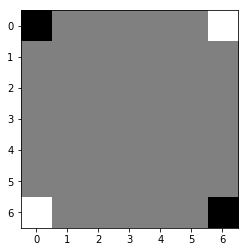

((6, 6), (5, 5)): n_v:  1628 q_all:+0.011463 q:+0.003683 q_m:+0.020000 p:0.323434
((0, 0), (1, 1)): n_v:  1451 q_all:+0.010620 q:-0.002700 q_m:+0.020000 p:0.291526
((6, 6), (5, 6)): n_v:   530 q_all:+0.010819 q:-0.001457 q_m:+0.020000 p:0.106384
((0, 0), (1, 0)): n_v:   486 q_all:+0.010873 q:-0.006158 q_m:+0.020000 p:0.097312
((6, 6), (6, 5)): n_v:   453 q_all:+0.012737 q:+0.006413 q_m:+0.020000 p:0.088318
((0, 0), (0, 1)): n_v:   414 q_all:+0.011363 q:-0.001792 q_m:+0.020000 p:0.082489
((6, 6), (4, 5)): n_v:     8 q_all:-0.001162 q:-0.013042 q_m:-0.000000 p:0.001935
((6, 6), (5, 4)): n_v:     6 q_all:+0.000827 q:-0.009196 q_m:-0.000000 p:0.001539
((0, 0), (2, 1)): n_v:     6 q_all:-0.001350 q:-0.014990 q_m:-0.000000 p:0.001493
((0, 0), (1, 2)): n_v:     5 q_all:+0.004353 q:-0.014788 q_m:-0.000000 p:0.001277
((0, 0), (2, 2)): n_v:     3 q_all:-0.000705 q:-0.037008 q_m:-0.000000 p:0.000801
((6, 6), (4, 4)): n_v:     3 q_all:+0.003138 q:-0.005480 q_m:-0.000000 p:0.000865
((6, 6), (6, 4))

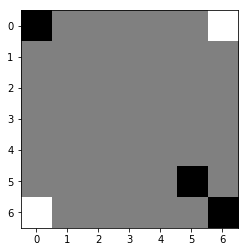

((6, 0), (5, 1)): n_v:  1921 q_all:-0.008608 q:-0.018963 q_m:-0.000000 p:0.285690
((0, 6), (1, 5)): n_v:  1516 q_all:-0.008585 q:-0.008039 q_m:-0.000000 p:0.225374
((6, 0), (5, 0)): n_v:   953 q_all:-0.010696 q:-0.015911 q_m:-0.000000 p:0.146574
((6, 0), (6, 1)): n_v:   836 q_all:-0.009923 q:-0.014435 q_m:-0.000000 p:0.127128
((0, 6), (0, 5)): n_v:   706 q_all:-0.009274 q:-0.013145 q_m:-0.000000 p:0.106268
((0, 6), (1, 6)): n_v:   664 q_all:-0.010606 q:-0.005365 q_m:-0.000000 p:0.102018
((6, 0), (6, 2)): n_v:     6 q_all:-0.018150 q:-0.023031 q_m:-0.020000 p:0.001002
((6, 0), (5, 2)): n_v:     6 q_all:-0.007292 q:-0.020876 q_m:-0.020000 p:0.000974
((0, 6), (0, 4)): n_v:     4 q_all:-0.016064 q:-0.023995 q_m:-0.020000 p:0.000658
((6, 0), (4, 1)): n_v:     3 q_all:-0.015662 q:-0.024721 q_m:-0.020000 p:0.000655
((6, 0), (4, 0)): n_v:     3 q_all:-0.018255 q:-0.018995 q_m:-0.020000 p:0.000591
((0, 6), (1, 4)): n_v:     3 q_all:-0.020914 q:-0.014436 q_m:-0.020000 p:0.000705
((0, 6), (2, 4))

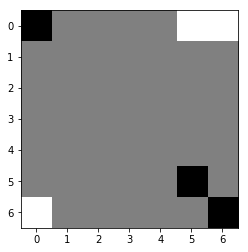

((5, 5), (4, 5)): n_v:   814 q_all:+0.008001 q:-0.008571 q_m:+0.020000 p:0.126587
((5, 5), (5, 4)): n_v:   750 q_all:+0.009710 q:+0.005986 q_m:+0.020000 p:0.113356
((5, 5), (4, 6)): n_v:   724 q_all:+0.007525 q:-0.006142 q_m:+0.020000 p:0.113497
((0, 0), (1, 1)): n_v:   704 q_all:+0.009420 q:-0.014120 q_m:+0.020000 p:0.106839
((5, 5), (6, 4)): n_v:   618 q_all:+0.008464 q:+0.001492 q_m:+0.020000 p:0.095434
((5, 5), (5, 6)): n_v:   502 q_all:+0.008046 q:-0.010661 q_m:+0.020000 p:0.078071
((0, 0), (1, 0)): n_v:   477 q_all:+0.009523 q:-0.017496 q_m:+0.020000 p:0.072356
((5, 5), (4, 4)): n_v:   382 q_all:+0.008024 q:-0.009914 q_m:+0.020000 p:0.059463
((0, 0), (0, 1)): n_v:   351 q_all:+0.009967 q:-0.009555 q_m:+0.020000 p:0.052822
((5, 5), (6, 5)): n_v:   337 q_all:+0.010551 q:-0.004873 q_m:+0.020000 p:0.050177
((5, 5), (3, 5)): n_v:    17 q_all:+0.047508 q:-0.021692 q_m:-0.000000 p:0.000910
((5, 5), (3, 6)): n_v:    16 q_all:+0.032000 q:-0.027449 q_m:-0.000000 p:0.001539
((5, 5), (5, 3))

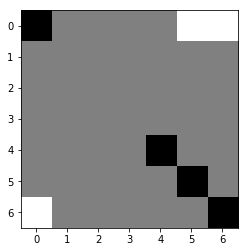

((6, 0), (5, 1)): n_v:  1179 q_all:-0.004523 q:-0.013837 q_m:-0.000000 p:0.242394
((0, 5), (1, 5)): n_v:   817 q_all:-0.006470 q:-0.019384 q_m:-0.000000 p:0.173100
((6, 0), (6, 1)): n_v:   542 q_all:-0.008666 q:-0.022760 q_m:-0.000000 p:0.118748
((6, 0), (5, 0)): n_v:   479 q_all:-0.009035 q:-0.021386 q_m:-0.000000 p:0.105514
((0, 5), (0, 4)): n_v:   275 q_all:-0.008216 q:-0.020303 q_m:-0.000000 p:0.059842
((0, 5), (1, 4)): n_v:   244 q_all:-0.003636 q:-0.020615 q_m:-0.000000 p:0.049580
((0, 5), (1, 6)): n_v:   179 q_all:-0.007631 q:-0.020049 q_m:-0.000000 p:0.038714
((6, 0), (5, 2)): n_v:    10 q_all:-0.050342 q:-0.033809 q_m:-0.020000 p:0.003682
((0, 5), (2, 5)): n_v:     9 q_all:-0.019228 q:-0.032594 q_m:-0.020000 p:0.002309
((6, 0), (4, 1)): n_v:     9 q_all:-0.010151 q:-0.031615 q_m:-0.020000 p:0.002119
((6, 0), (4, 0)): n_v:     8 q_all:-0.023795 q:-0.032911 q_m:-0.020000 p:0.002158
((0, 6), (1, 4)): n_v:     5 q_all:-0.012027 q:-0.025947 q_m:-0.020000 p:0.001274
((0, 6), (2, 6))

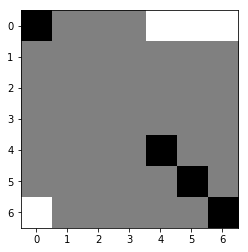

((0, 0), (1, 1)): n_v:   337 q_all:+0.011914 q:-0.023099 q_m:+0.020000 p:0.228766
((4, 4), (3, 5)): n_v:   150 q_all:+0.058209 q:-0.019890 q_m:+0.020000 p:0.063109
((0, 0), (1, 0)): n_v:   131 q_all:+0.010124 q:-0.019579 q_m:+0.020000 p:0.090203
((0, 0), (0, 1)): n_v:   130 q_all:+0.014338 q:-0.009773 q_m:+0.020000 p:0.086927
((4, 4), (5, 3)): n_v:   118 q_all:+0.022774 q:-0.014031 q_m:+0.020000 p:0.072803
((5, 5), (6, 4)): n_v:    85 q_all:+0.007063 q:-0.017006 q_m:+0.020000 p:0.060533
((5, 5), (6, 5)): n_v:    61 q_all:+0.008754 q:-0.012457 q_m:+0.020000 p:0.042988
((5, 5), (5, 6)): n_v:    60 q_all:+0.008358 q:-0.016705 q_m:+0.020000 p:0.042009
((5, 5), (4, 6)): n_v:    59 q_all:+0.005919 q:-0.018964 q_m:+0.020000 p:0.042138
((4, 4), (3, 4)): n_v:    34 q_all:+0.063314 q:-0.015416 q_m:+0.020000 p:0.013467
((4, 4), (3, 3)): n_v:    27 q_all:+0.032644 q:-0.021248 q_m:+0.020000 p:0.015723
((4, 4), (5, 4)): n_v:    21 q_all:+0.007056 q:-0.014966 q_m:+0.020000 p:0.015046
((4, 4), (4, 5))

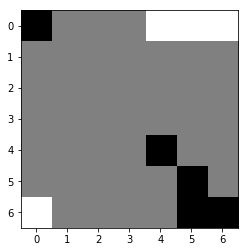

((6, 0), (5, 1)): n_v:   697 q_all:-0.004436 q:-0.017072 q_m:-0.000000 p:0.237339
((6, 0), (6, 1)): n_v:   565 q_all:-0.011472 q:-0.027638 q_m:-0.000000 p:0.208943
((6, 0), (5, 0)): n_v:   498 q_all:-0.011728 q:-0.032577 q_m:-0.000000 p:0.184689
((0, 4), (1, 3)): n_v:   175 q_all:+0.007492 q:-0.026879 q_m:-0.000000 p:0.050786
((0, 4), (1, 4)): n_v:   101 q_all:-0.003829 q:-0.019438 q_m:-0.000000 p:0.034244
((0, 4), (1, 5)): n_v:    94 q_all:-0.004114 q:-0.034662 q_m:-0.000000 p:0.032156
((0, 5), (1, 6)): n_v:    70 q_all:-0.009677 q:-0.026675 q_m:-0.000000 p:0.025566
((0, 4), (0, 3)): n_v:    56 q_all:+0.004172 q:-0.027534 q_m:-0.000000 p:0.017225
((0, 4), (1, 2)): n_v:    34 q_all:-0.060685 q:-0.042457 q_m:-0.020000 p:0.019651
((6, 0), (5, 2)): n_v:    15 q_all:-0.060338 q:-0.045703 q_m:-0.020000 p:0.008923
((0, 4), (2, 5)): n_v:     8 q_all:-0.017285 q:-0.044562 q_m:-0.020000 p:0.003245
((0, 4), (0, 2)): n_v:     7 q_all:-0.054614 q:-0.047124 q_m:-0.020000 p:0.003914
((6, 0), (4, 1))

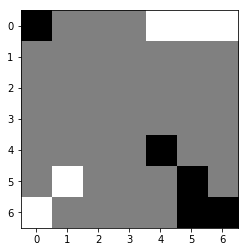

((0, 0), (0, 1)): n_v:   392 q_all:+0.017588 q:-0.002162 q_m:+0.020000 p:0.191795
((0, 0), (1, 1)): n_v:   363 q_all:+0.015720 q:-0.014510 q_m:+0.020000 p:0.180776
((4, 4), (5, 3)): n_v:   205 q_all:+0.015580 q:-0.039641 q_m:+0.020000 p:0.102418
((0, 0), (1, 0)): n_v:   164 q_all:+0.018325 q:-0.007186 q_m:+0.020000 p:0.079828
((4, 4), (3, 5)): n_v:   144 q_all:+0.068667 q:-0.023422 q_m:+0.020000 p:0.034563
((5, 5), (4, 6)): n_v:    89 q_all:+0.011805 q:-0.019197 q_m:+0.020000 p:0.046138
((5, 5), (6, 4)): n_v:    87 q_all:+0.016446 q:-0.033309 q_m:+0.020000 p:0.043490
((5, 5), (5, 6)): n_v:    55 q_all:+0.015733 q:-0.021140 q_m:+0.020000 p:0.027710
((4, 4), (4, 5)): n_v:    32 q_all:+0.014550 q:-0.037155 q_m:+0.020000 p:0.016453
((4, 4), (3, 3)): n_v:    31 q_all:+0.007796 q:-0.017626 q_m:+0.020000 p:0.016802
((4, 4), (5, 2)): n_v:    29 q_all:-0.018144 q:-0.008136 q_m:+0.040000 p:0.019628
((4, 4), (5, 4)): n_v:    25 q_all:+0.011372 q:-0.034404 q_m:+0.020000 p:0.013018
((4, 4), (3, 4))

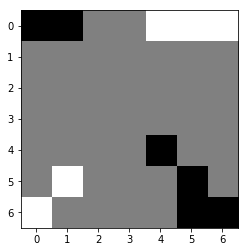

((5, 1), (5, 2)): n_v:   333 q_all:+0.011527 q:-0.037714 q_m:-0.000000 p:0.150149
((5, 1), (5, 0)): n_v:   179 q_all:+0.002798 q:-0.036289 q_m:-0.000000 p:0.089499
((5, 1), (6, 2)): n_v:   176 q_all:+0.011390 q:-0.028346 q_m:-0.000000 p:0.079832
((5, 1), (6, 1)): n_v:   113 q_all:+0.003989 q:-0.037918 q_m:-0.000000 p:0.055600
((0, 4), (1, 4)): n_v:   107 q_all:+0.012925 q:-0.012490 q_m:-0.000000 p:0.047633
((0, 5), (1, 6)): n_v:    95 q_all:+0.006044 q:-0.019030 q_m:-0.000000 p:0.046087
((0, 4), (1, 3)): n_v:    79 q_all:+0.016962 q:-0.028353 q_m:-0.000000 p:0.033357
((5, 1), (4, 0)): n_v:    57 q_all:+0.003367 q:-0.023348 q_m:-0.000000 p:0.028542
((5, 1), (4, 1)): n_v:    54 q_all:+0.005102 q:-0.020750 q_m:-0.000000 p:0.026517
((0, 4), (1, 5)): n_v:    52 q_all:+0.004064 q:-0.022504 q_m:-0.000000 p:0.025707
((0, 4), (1, 2)): n_v:    49 q_all:-0.039830 q:-0.002516 q_m:+0.020000 p:0.036281
((5, 1), (4, 2)): n_v:    39 q_all:+0.010579 q:-0.020887 q_m:-0.000000 p:0.017857
((0, 4), (0, 3))

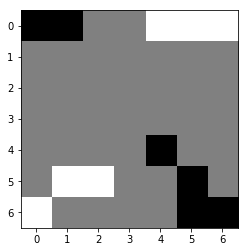

((4, 4), (5, 3)): n_v:  1068 q_all:+0.038293 q:-0.012409 q_m:+0.060000 p:0.533075
((4, 4), (4, 2)): n_v:   386 q_all:+0.047675 q:+0.012651 q_m:+0.080000 p:0.175916
((4, 4), (4, 3)): n_v:    66 q_all:+0.060793 q:-0.023929 q_m:+0.060000 p:0.026363
((0, 0), (1, 1)): n_v:    48 q_all:+0.017684 q:-0.020134 q_m:+0.020000 p:0.028984
((4, 4), (6, 2)): n_v:    27 q_all:-0.026428 q:+0.016910 q_m:+0.080000 p:0.021751
((4, 4), (6, 3)): n_v:    24 q_all:+0.022619 q:-0.011656 q_m:+0.040000 p:0.013973
((6, 5), (5, 3)): n_v:    22 q_all:+0.019577 q:-0.015852 q_m:+0.040000 p:0.013441
((5, 5), (5, 3)): n_v:    22 q_all:+0.021496 q:-0.012501 q_m:+0.040000 p:0.013221
((0, 0), (1, 0)): n_v:    19 q_all:+0.028909 q:-0.008984 q_m:+0.020000 p:0.010509
((0, 1), (0, 2)): n_v:    14 q_all:+0.022992 q:-0.007430 q_m:+0.020000 p:0.008436
((4, 4), (5, 6)): n_v:    12 q_all:+0.003405 q:-0.025590 q_m:-0.000000 p:0.008373
((4, 4), (4, 5)): n_v:    12 q_all:+0.009352 q:-0.039957 q_m:+0.020000 p:0.007591
((5, 5), (5, 6))

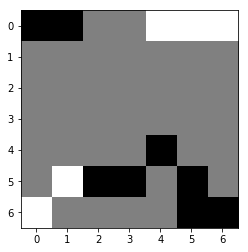

((5, 1), (4, 3)): n_v:  2683 q_all:+0.046602 q:+0.030891 q_m:+0.060000 p:0.232884
((5, 1), (6, 2)): n_v:  2420 q_all:-0.003743 q:+0.000384 q_m:+0.040000 p:0.523050
((5, 1), (6, 3)): n_v:   391 q_all:+0.012134 q:+0.001417 q_m:+0.020000 p:0.068637
((5, 1), (4, 2)): n_v:   227 q_all:-0.009721 q:+0.001711 q_m:+0.040000 p:0.052640
((6, 0), (6, 2)): n_v:   112 q_all:-0.019770 q:-0.009490 q_m:+0.020000 p:0.028891
((0, 5), (2, 3)): n_v:    54 q_all:-0.075260 q:-0.060706 q_m:-0.060000 p:0.021623
((5, 1), (6, 1)): n_v:    32 q_all:-0.004578 q:-0.014188 q_m:-0.000000 p:0.007099
((0, 4), (1, 2)): n_v:    24 q_all:-0.058395 q:-0.041987 q_m:-0.020000 p:0.008823
((0, 4), (2, 3)): n_v:    22 q_all:-0.036406 q:-0.066317 q_m:-0.060000 p:0.006678
((0, 5), (0, 3)): n_v:    13 q_all:-0.083619 q:-0.066894 q_m:-0.060000 p:0.005338
((0, 4), (0, 2)): n_v:    12 q_all:-0.056975 q:-0.059513 q_m:-0.020000 p:0.004528
((0, 4), (2, 2)): n_v:    10 q_all:-0.060356 q:-0.068504 q_m:-0.060000 p:0.003857
((6, 0), (4, 2))

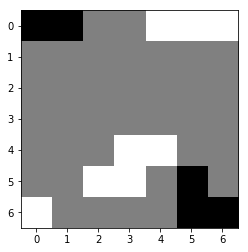

((5, 5), (5, 4)): n_v:  4323 q_all:-0.031933 q:-0.006800 q_m:+0.080000 p:0.533081
((5, 5), (6, 3)): n_v:  2931 q_all:+0.021261 q:-0.009040 q_m:+0.020000 p:0.001524
((6, 5), (6, 3)): n_v:   176 q_all:+0.028101 q:-0.015831 q_m:+0.020000 p:0.000753
((0, 1), (1, 2)): n_v:   137 q_all:-0.012315 q:-0.035911 q_m:-0.040000 p:0.010692
((6, 6), (5, 4)): n_v:    56 q_all:-0.047676 q:-0.018511 q_m:+0.060000 p:0.009016
((5, 5), (4, 5)): n_v:    11 q_all:-0.063769 q:-0.044947 q_m:-0.000000 p:0.002254
((5, 5), (6, 4)): n_v:     7 q_all:-0.092668 q:-0.019598 q_m:-0.000000 p:0.001906
((5, 5), (3, 3)): n_v:     2 q_all:-0.027008 q:-0.038589 q_m:+0.020000 p:0.000300
((5, 5), (3, 4)): n_v:     1 q_all:-0.039930 q:-0.018270 q_m:+0.020000 p:0.000057
((0, 1), (1, 3)): n_v:     1 q_all:-0.014620 q:-0.020671 q_m:-0.020000 p:0.000105
((0, 1), (0, 2)): n_v:     1 q_all:-0.085333 q:-0.032266 q_m:-0.040000 p:0.000329
((0, 1), (0, 3)): n_v:     0 q_all:-0.028703 q:-0.041756 q_m:-0.020000 p:0.000030
((6, 6), (6, 4))

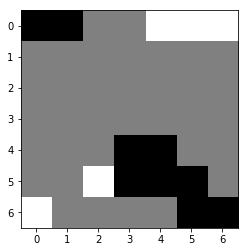

((5, 2), (6, 4)): n_v:  8861 q_all:+0.056294 q:+0.021256 q_m:+0.080000 p:0.933625
((5, 2), (4, 2)): n_v:   107 q_all:+0.028726 q:-0.019348 q_m:+0.020000 p:0.017531
((5, 2), (6, 2)): n_v:    41 q_all:-0.060426 q:-0.035975 q_m:-0.020000 p:0.014444
((0, 4), (0, 2)): n_v:    25 q_all:-0.043171 q:-0.045131 q_m:-0.040000 p:0.007985
((5, 2), (6, 3)): n_v:    24 q_all:-0.012156 q:-0.035811 q_m:+0.020000 p:0.006058
((0, 4), (2, 2)): n_v:    15 q_all:-0.062731 q:-0.071243 q_m:-0.080000 p:0.005504
((0, 4), (1, 2)): n_v:    15 q_all:-0.035571 q:-0.030749 q_m:-0.040000 p:0.004539
((5, 2), (3, 3)): n_v:     7 q_all:-0.027862 q:-0.035893 q_m:-0.000000 p:0.002194
((6, 0), (6, 2)): n_v:     3 q_all:-0.092461 q:-0.045862 q_m:-0.040000 p:0.001318
((5, 2), (6, 1)): n_v:     2 q_all:-0.107483 q:-0.040654 q_m:-0.060000 p:0.000841
((6, 0), (5, 0)): n_v:     1 q_all:-0.096502 q:-0.053586 q_m:-0.060000 p:0.000538
((0, 4), (0, 3)): n_v:     1 q_all:-0.061680 q:-0.033701 q_m:-0.060000 p:0.000397
((5, 2), (4, 1))

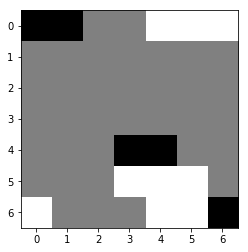

((4, 4), (5, 6)): n_v:  3238 q_all:+0.017692 q:-0.035330 q_m:-0.000000 p:0.038317
((4, 4), (4, 5)): n_v:  2263 q_all:-0.050900 q:-0.050627 q_m:+0.020000 p:0.309166
((6, 6), (5, 6)): n_v:  1387 q_all:-0.057180 q:-0.032758 q_m:+0.020000 p:0.206484
((4, 3), (5, 1)): n_v:   790 q_all:-0.059628 q:-0.045560 q_m:-0.040000 p:0.121171
((4, 3), (5, 2)): n_v:   541 q_all:-0.069122 q:-0.044063 q_m:-0.020000 p:0.092400
((4, 4), (6, 3)): n_v:   500 q_all:-0.044689 q:-0.032290 q_m:+0.040000 p:0.061791
((4, 3), (6, 1)): n_v:   278 q_all:-0.064521 q:-0.064458 q_m:-0.040000 p:0.045209
((4, 3), (6, 3)): n_v:   190 q_all:-0.028080 q:-0.013288 q_m:+0.040000 p:0.016741
((0, 1), (1, 2)): n_v:   111 q_all:-0.061366 q:-0.075951 q_m:-0.060000 p:0.017463
((0, 0), (1, 1)): n_v:    71 q_all:-0.063599 q:-0.079436 q_m:-0.060000 p:0.011542
((4, 3), (4, 2)): n_v:    54 q_all:-0.074751 q:-0.040586 q_m:-0.020000 p:0.009887
((6, 6), (4, 5)): n_v:    54 q_all:-0.039386 q:-0.060576 q_m:-0.000000 p:0.006006
((0, 0), (1, 0))

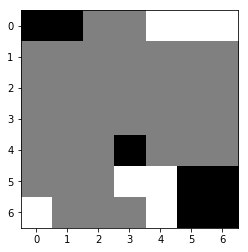

((5, 3), (4, 5)): n_v:  4589 q_all:+0.062770 q:-0.001167 q_m:+0.080000 p:0.019496
((5, 3), (4, 4)): n_v:  1635 q_all:-0.007805 q:+0.027722 q_m:+0.100000 p:0.263686
((5, 3), (4, 2)): n_v:   871 q_all:-0.027717 q:-0.023247 q_m:+0.060000 p:0.179030
((5, 4), (4, 5)): n_v:   530 q_all:-0.010689 q:+0.022997 q_m:+0.100000 p:0.088948
((5, 3), (4, 1)): n_v:    70 q_all:-0.038312 q:-0.007188 q_m:-0.000000 p:0.016154
((6, 0), (5, 0)): n_v:    43 q_all:-0.027204 q:-0.016909 q_m:+0.020000 p:0.008994
((0, 5), (1, 6)): n_v:    42 q_all:-0.020744 q:-0.002020 q_m:+0.020000 p:0.008113
((5, 3), (6, 2)): n_v:    28 q_all:-0.055450 q:-0.012893 q_m:+0.020000 p:0.007731
((6, 4), (4, 2)): n_v:    23 q_all:-0.009666 q:-0.027836 q_m:+0.040000 p:0.003764
((5, 3), (6, 1)): n_v:    21 q_all:-0.037101 q:-0.019111 q_m:-0.000000 p:0.004973
((5, 4), (4, 2)): n_v:    18 q_all:-0.035758 q:-0.006464 q_m:+0.040000 p:0.004053
((5, 3), (5, 2)): n_v:    17 q_all:-0.026025 q:-0.021213 q_m:+0.060000 p:0.003533
((5, 3), (5, 1))

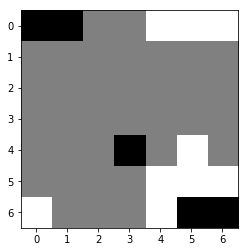

((6, 6), (4, 6)): n_v:  3264 q_all:+0.013362 q:-0.027246 q_m:+0.040000 p:0.108518
((4, 3), (5, 3)): n_v:  2764 q_all:-0.063758 q:-0.043328 q_m:+0.020000 p:0.543500
((4, 3), (4, 4)): n_v:  1631 q_all:-0.015557 q:-0.038395 q_m:+0.060000 p:0.141333
((4, 3), (4, 2)): n_v:   454 q_all:-0.050948 q:-0.067531 q_m:-0.060000 p:0.077060
((6, 6), (4, 4)): n_v:   234 q_all:-0.040560 q:-0.045322 q_m:+0.040000 p:0.034652
((6, 5), (5, 3)): n_v:   171 q_all:-0.064105 q:-0.054259 q_m:-0.000000 p:0.033913
((4, 3), (5, 1)): n_v:   163 q_all:-0.034377 q:-0.038689 q_m:-0.040000 p:0.021857
((6, 5), (4, 6)): n_v:    89 q_all:-0.034320 q:-0.031447 q_m:+0.040000 p:0.012041
((6, 5), (4, 4)): n_v:    50 q_all:-0.039606 q:-0.053775 q_m:+0.040000 p:0.007390
((4, 3), (6, 1)): n_v:    27 q_all:-0.037074 q:-0.070707 q_m:-0.040000 p:0.003873
((4, 3), (6, 2)): n_v:    16 q_all:-0.068827 q:-0.080918 q_m:-0.080000 p:0.003411
((4, 3), (5, 2)): n_v:    15 q_all:-0.052394 q:-0.063360 q_m:-0.060000 p:0.002714
((0, 0), (1, 1))

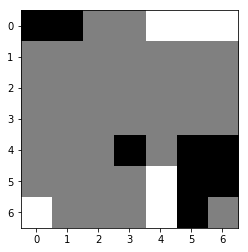

((5, 4), (4, 4)): n_v:  6314 q_all:+0.019883 q:-0.001508 q_m:+0.100000 p:0.781037
((6, 4), (4, 4)): n_v:   269 q_all:+0.023087 q:-0.019331 q_m:+0.080000 p:0.031201
((6, 4), (4, 2)): n_v:   164 q_all:-0.059545 q:-0.052649 q_m:-0.000000 p:0.050863
((5, 4), (4, 2)): n_v:   119 q_all:-0.047346 q:-0.052504 q_m:-0.000000 p:0.033416
((6, 4), (6, 6)): n_v:    73 q_all:+0.026782 q:-0.001046 q_m:+0.080000 p:0.007880
((0, 4), (2, 4)): n_v:    65 q_all:-0.021078 q:-0.058288 q_m:-0.040000 p:0.014373
((5, 4), (6, 6)): n_v:    51 q_all:+0.049468 q:+0.008366 q_m:+0.080000 p:0.002770
((6, 0), (5, 0)): n_v:    44 q_all:-0.040177 q:-0.041828 q_m:-0.020000 p:0.011797
((0, 5), (2, 4)): n_v:    39 q_all:-0.029257 q:-0.060130 q_m:-0.040000 p:0.009455
((6, 0), (4, 2)): n_v:    36 q_all:-0.093894 q:-0.056723 q_m:-0.000000 p:0.014357
((6, 4), (5, 2)): n_v:    18 q_all:-0.060576 q:-0.054535 q_m:-0.000000 p:0.005869
((5, 4), (3, 6)): n_v:    13 q_all:+0.010597 q:+0.000748 q_m:+0.040000 p:0.001835
((0, 5), (1, 6))

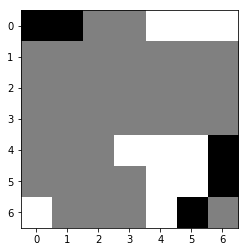

((6, 5), (5, 3)): n_v:  8545 q_all:-0.002658 q:-0.022905 q_m:+0.060000 p:0.919132
((5, 6), (6, 6)): n_v:  1124 q_all:+0.049196 q:-0.024469 q_m:-0.040000 p:0.007685
((5, 6), (3, 4)): n_v:   141 q_all:-0.031691 q:-0.037694 q_m:+0.020000 p:0.023312
((4, 6), (3, 4)): n_v:   117 q_all:-0.001247 q:-0.036097 q_m:+0.020000 p:0.012352
((0, 1), (1, 3)): n_v:    84 q_all:-0.039849 q:-0.027980 q_m:-0.060000 p:0.015115
((4, 6), (3, 5)): n_v:    43 q_all:-0.031959 q:-0.040369 q_m:-0.000000 p:0.007170
((4, 6), (6, 6)): n_v:    25 q_all:-0.059193 q:-0.042518 q_m:-0.060000 p:0.005591
((5, 6), (3, 5)): n_v:     6 q_all:-0.046235 q:-0.066040 q_m:-0.020000 p:0.001203
((6, 5), (6, 3)): n_v:     3 q_all:-0.040062 q:-0.034597 q_m:-0.020000 p:0.000631
((4, 6), (3, 6)): n_v:     2 q_all:-0.073065 q:-0.042709 q_m:-0.040000 p:0.000727
((0, 1), (1, 2)): n_v:     1 q_all:-0.103786 q:-0.031343 q_m:-0.080000 p:0.000394
((0, 0), (1, 1)): n_v:     1 q_all:-0.104419 q:-0.041216 q_m:-0.080000 p:0.000368
((0, 1), (0, 2))

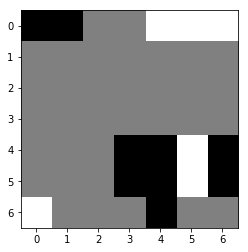

((5, 5), (6, 5)): n_v:  3408 q_all:+0.044091 q:+0.037316 q_m:+0.080000 p:0.219491
((5, 5), (6, 3)): n_v:  2769 q_all:+0.004931 q:+0.004371 q_m:+0.060000 p:0.387786
((4, 5), (6, 3)): n_v:  1211 q_all:+0.014114 q:+0.014516 q_m:+0.060000 p:0.148088
((4, 5), (6, 5)): n_v:   525 q_all:+0.006425 q:+0.012706 q_m:+0.060000 p:0.072047
((6, 0), (6, 1)): n_v:   317 q_all:-0.037467 q:-0.024517 q_m:-0.040000 p:0.070423
((0, 4), (0, 3)): n_v:    94 q_all:-0.019207 q:-0.012835 q_m:-0.040000 p:0.017727
((4, 5), (3, 5)): n_v:    76 q_all:-0.001137 q:-0.015322 q_m:+0.040000 p:0.011645
((6, 0), (5, 1)): n_v:    69 q_all:-0.034858 q:-0.031879 q_m:-0.040000 p:0.015127
((0, 5), (0, 3)): n_v:    40 q_all:-0.041575 q:-0.040293 q_m:-0.060000 p:0.009423
((4, 5), (3, 4)): n_v:    38 q_all:-0.012073 q:-0.014355 q_m:+0.040000 p:0.006720
((6, 0), (5, 0)): n_v:    15 q_all:-0.039986 q:-0.032221 q_m:-0.040000 p:0.003563
((6, 0), (5, 2)): n_v:    13 q_all:-0.022957 q:-0.041546 q_m:+0.020000 p:0.002696
((6, 0), (4, 2))

((5, 3), (6, 3)): n_v:  1394 q_all:+0.000828 q:-0.025693 q_m:+0.020000 p:0.249345
((4, 6), (6, 6)): n_v:  1032 q_all:-0.010205 q:-0.030631 q_m:+0.040000 p:0.217141
((4, 3), (5, 1)): n_v:   468 q_all:-0.060723 q:-0.058728 q_m:-0.040000 p:0.165858
((4, 4), (6, 6)): n_v:   433 q_all:-0.021722 q:-0.034854 q_m:+0.040000 p:0.105306
((4, 3), (6, 1)): n_v:   226 q_all:-0.063602 q:-0.058451 q_m:-0.040000 p:0.082091
((5, 3), (5, 1)): n_v:   145 q_all:-0.058594 q:-0.045466 q_m:-0.040000 p:0.050670
((4, 4), (6, 3)): n_v:    92 q_all:-0.054890 q:-0.052860 q_m:-0.000000 p:0.031054
((4, 3), (6, 3)): n_v:    50 q_all:-0.014550 q:-0.021357 q_m:-0.000000 p:0.011257
((4, 6), (3, 6)): n_v:    25 q_all:-0.065772 q:-0.044851 q_m:-0.020000 p:0.009041
((0, 0), (1, 1)): n_v:    21 q_all:-0.074209 q:-0.077373 q_m:-0.060000 p:0.008602
((4, 4), (3, 5)): n_v:    11 q_all:-0.058385 q:-0.054204 q_m:-0.020000 p:0.004049
((5, 3), (6, 2)): n_v:    11 q_all:-0.082803 q:-0.082684 q_m:-0.060000 p:0.004818
((4, 3), (6, 2))

((4, 5), (3, 5)): n_v:   472 q_all:+0.046238 q:+0.009947 q_m:+0.080000 p:0.099664
((4, 5), (3, 4)): n_v:   459 q_all:+0.009385 q:+0.006902 q_m:+0.080000 p:0.166047
((6, 0), (5, 2)): n_v:   313 q_all:+0.045541 q:+0.021229 q_m:+0.100000 p:0.067044
((6, 0), (5, 1)): n_v:   129 q_all:-0.005637 q:-0.006634 q_m:-0.000000 p:0.054872
((0, 4), (1, 4)): n_v:   117 q_all:+0.013404 q:+0.006912 q_m:-0.000000 p:0.040841
((5, 5), (6, 6)): n_v:    84 q_all:+0.023689 q:-0.013771 q_m:-0.000000 p:0.025559
((6, 0), (6, 2)): n_v:    73 q_all:-0.000767 q:+0.007125 q_m:+0.060000 p:0.029545
((6, 0), (5, 0)): n_v:    72 q_all:-0.000639 q:-0.014660 q_m:-0.000000 p:0.029254
((0, 4), (1, 2)): n_v:    65 q_all:-0.003910 q:+0.007229 q_m:+0.020000 p:0.027334
((0, 5), (1, 6)): n_v:    56 q_all:+0.010355 q:-0.006655 q_m:-0.000000 p:0.020213
((6, 0), (6, 1)): n_v:    53 q_all:+0.000230 q:-0.009619 q_m:-0.000000 p:0.021508
((5, 6), (3, 5)): n_v:    34 q_all:+0.003271 q:-0.014756 q_m:+0.060000 p:0.013069
((0, 4), (1, 5))

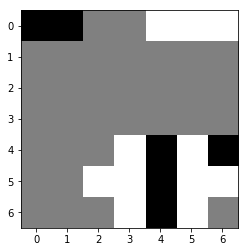

((4, 4), (6, 2)): n_v:  3467 q_all:+0.000541 q:-0.035228 q_m:+0.020000 p:0.599927
((4, 4), (4, 2)): n_v:   650 q_all:-0.024762 q:-0.076131 q_m:+0.020000 p:0.157719
((6, 4), (4, 2)): n_v:   435 q_all:+0.003906 q:-0.040256 q_m:+0.020000 p:0.071250
((6, 4), (6, 2)): n_v:   163 q_all:-0.020449 q:-0.037739 q_m:+0.020000 p:0.037663
((5, 4), (6, 2)): n_v:   151 q_all:-0.057463 q:-0.016591 q_m:+0.020000 p:0.050243
((5, 4), (4, 2)): n_v:   150 q_all:-0.050654 q:-0.041214 q_m:+0.020000 p:0.047031
((4, 6), (6, 6)): n_v:   121 q_all:+0.003453 q:-0.019235 q_m:+0.020000 p:0.020030
((4, 4), (6, 6)): n_v:    78 q_all:+0.052761 q:-0.004532 q_m:+0.020000 p:0.002299
((0, 1), (0, 2)): n_v:    22 q_all:-0.007517 q:-0.071650 q_m:-0.080000 p:0.004407
((0, 0), (0, 2)): n_v:     9 q_all:-0.025233 q:-0.087612 q_m:-0.100000 p:0.002336
((4, 4), (2, 2)): n_v:     7 q_all:-0.015412 q:-0.099284 q_m:-0.100000 p:0.001550
((5, 4), (6, 6)): n_v:     3 q_all:-0.043724 q:-0.029178 q_m:+0.020000 p:0.000964
((6, 4), (6, 6))

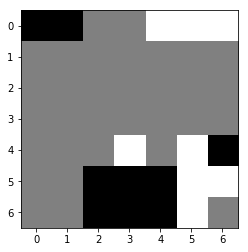

((4, 3), (4, 4)): n_v:  4248 q_all:+0.012333 q:-0.005934 q_m:+0.080000 p:0.240959
((4, 3), (5, 1)): n_v:  3813 q_all:+0.058173 q:-0.031271 q_m:+0.060000 p:0.007397
((4, 3), (4, 2)): n_v:   261 q_all:-0.033273 q:-0.018435 q_m:+0.080000 p:0.049596
((4, 3), (6, 1)): n_v:    38 q_all:-0.018891 q:-0.014738 q_m:+0.060000 p:0.005705
((5, 6), (4, 4)): n_v:    16 q_all:-0.035273 q:-0.012107 q_m:+0.060000 p:0.003309
((6, 5), (4, 4)): n_v:    11 q_all:-0.022825 q:-0.015744 q_m:+0.060000 p:0.001907
((0, 5), (1, 6)): n_v:     7 q_all:-0.049150 q:-0.043355 q_m:-0.000000 p:0.001696
((4, 5), (3, 5)): n_v:     3 q_all:-0.071917 q:-0.043802 q_m:+0.040000 p:0.000963
((4, 5), (6, 6)): n_v:     2 q_all:-0.063649 q:-0.051686 q_m:-0.020000 p:0.000792
((0, 4), (1, 5)): n_v:     2 q_all:-0.068101 q:-0.049710 q_m:-0.000000 p:0.000760
((5, 5), (6, 6)): n_v:     1 q_all:-0.060315 q:-0.055257 q_m:-0.000000 p:0.000342
((0, 5), (2, 4)): n_v:     1 q_all:-0.074501 q:-0.076294 q_m:-0.020000 p:0.000299
((0, 4), (1, 3))

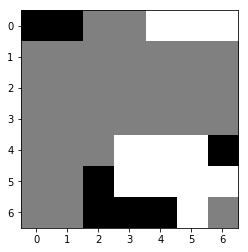

((5, 2), (4, 2)): n_v:  6477 q_all:+0.015310 q:-0.033557 q_m:+0.020000 p:0.772179
((6, 4), (4, 2)): n_v:   688 q_all:-0.021014 q:-0.017222 q_m:-0.000000 p:0.138988
((4, 6), (6, 6)): n_v:   151 q_all:+0.010266 q:+0.000339 q_m:+0.040000 p:0.019791
((4, 6), (3, 4)): n_v:    93 q_all:+0.018265 q:-0.042846 q_m:+0.040000 p:0.010523
((4, 6), (3, 5)): n_v:    82 q_all:-0.011082 q:-0.049328 q_m:+0.020000 p:0.014871
((6, 3), (4, 2)): n_v:    38 q_all:-0.050131 q:-0.052388 q_m:-0.000000 p:0.010442
((6, 2), (4, 2)): n_v:    33 q_all:-0.007552 q:-0.048536 q_m:-0.000000 p:0.005815
((5, 2), (3, 4)): n_v:    23 q_all:-0.013231 q:-0.046552 q_m:+0.040000 p:0.004416
((4, 6), (2, 4)): n_v:    16 q_all:-0.079103 q:-0.109652 q_m:-0.080000 p:0.005484
((4, 6), (3, 6)): n_v:    11 q_all:-0.057560 q:-0.065015 q_m:-0.020000 p:0.003287
((5, 2), (5, 1)): n_v:     7 q_all:-0.075598 q:-0.074702 q_m:-0.060000 p:0.002388
((6, 4), (6, 6)): n_v:     4 q_all:-0.004600 q:-0.012389 q_m:+0.040000 p:0.000754
((0, 1), (2, 2))

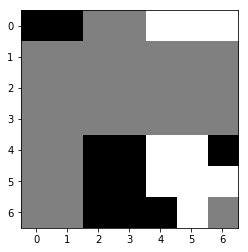

((4, 5), (3, 6)): n_v:  4589 q_all:+0.059222 q:+0.004449 q_m:+0.040000 p:0.002433
((4, 4), (3, 3)): n_v:  2352 q_all:-0.017422 q:-0.006280 q_m:+0.080000 p:0.336963
((0, 5), (1, 6)): n_v:   372 q_all:-0.024828 q:-0.005672 q_m:-0.000000 p:0.059589
((0, 4), (1, 5)): n_v:   306 q_all:-0.029442 q:-0.015087 q_m:-0.000000 p:0.051741
((4, 4), (3, 5)): n_v:   221 q_all:-0.014887 q:-0.003636 q_m:+0.040000 p:0.030364
((0, 4), (1, 3)): n_v:   171 q_all:-0.034227 q:-0.008427 q_m:-0.000000 p:0.030409
((5, 5), (6, 6)): n_v:   135 q_all:-0.021178 q:-0.012094 q_m:-0.000000 p:0.020702
((4, 4), (3, 4)): n_v:   131 q_all:-0.031000 q:-0.027186 q_m:+0.040000 p:0.022623
((4, 4), (3, 2)): n_v:    75 q_all:-0.026873 q:-0.024158 q_m:+0.060000 p:0.012348
((4, 5), (6, 6)): n_v:    73 q_all:-0.089597 q:-0.021343 q_m:-0.020000 p:0.020757
((4, 5), (3, 3)): n_v:    57 q_all:-0.023335 q:-0.025778 q_m:+0.060000 p:0.009013
((5, 4), (3, 3)): n_v:    49 q_all:-0.050622 q:-0.016666 q_m:+0.060000 p:0.010266
((4, 4), (6, 6))

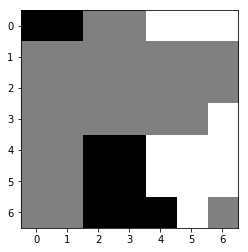

((4, 2), (3, 1)): n_v:  4412 q_all:-0.043459 q:-0.063085 q_m:-0.020000 p:0.697506
((4, 3), (3, 5)): n_v:   606 q_all:-0.016814 q:+0.021517 q_m:+0.120000 p:0.051437
((4, 2), (6, 0)): n_v:   484 q_all:+0.002150 q:-0.062450 q_m:-0.040000 p:0.019062
((6, 2), (6, 0)): n_v:   203 q_all:-0.069211 q:-0.063722 q_m:-0.040000 p:0.045500
((6, 4), (6, 6)): n_v:   187 q_all:-0.064568 q:-0.012911 q_m:+0.080000 p:0.039638
((4, 3), (3, 1)): n_v:    60 q_all:-0.124497 q:-0.080162 q_m:-0.040000 p:0.022110
((5, 2), (3, 1)): n_v:    54 q_all:-0.107992 q:-0.091907 q_m:-0.040000 p:0.017148
((5, 3), (3, 5)): n_v:    44 q_all:-0.092300 q:-0.013470 q_m:+0.120000 p:0.012389
((4, 2), (5, 1)): n_v:    35 q_all:-0.019457 q:-0.065175 q_m:-0.020000 p:0.003343
((4, 2), (3, 3)): n_v:    27 q_all:-0.078573 q:-0.047778 q_m:+0.020000 p:0.006846
((4, 2), (4, 1)): n_v:    27 q_all:-0.041468 q:-0.077315 q_m:-0.020000 p:0.004233
((4, 3), (6, 1)): n_v:    22 q_all:-0.124993 q:-0.066612 q_m:-0.040000 p:0.008152
((4, 3), (5, 1))

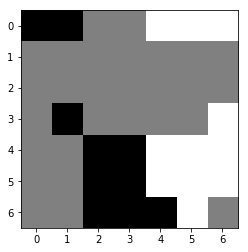

((4, 4), (3, 2)): n_v:  1967 q_all:+0.067633 q:+0.009554 q_m:+0.140000 p:0.161904
((4, 4), (3, 4)): n_v:   802 q_all:+0.023773 q:-0.022925 q_m:+0.080000 p:0.161824
((4, 4), (3, 3)): n_v:   699 q_all:+0.057031 q:+0.008073 q_m:+0.120000 p:0.077692
((5, 6), (3, 4)): n_v:   441 q_all:+0.007884 q:-0.034622 q_m:+0.060000 p:0.107818
((5, 4), (3, 2)): n_v:   390 q_all:+0.063968 q:+0.021499 q_m:+0.140000 p:0.035815
((4, 6), (3, 4)): n_v:   188 q_all:+0.010466 q:-0.028620 q_m:+0.060000 p:0.044865
((3, 6), (1, 5)): n_v:   110 q_all:+0.028285 q:-0.021823 q_m:+0.020000 p:0.020952
((3, 6), (1, 6)): n_v:    91 q_all:+0.035109 q:-0.017604 q_m:+0.020000 p:0.015590
((5, 4), (3, 4)): n_v:    80 q_all:-0.004243 q:-0.034964 q_m:+0.060000 p:0.022064
((0, 4), (0, 3)): n_v:    70 q_all:+0.036130 q:+0.007910 q_m:+0.040000 p:0.011894
((0, 4), (1, 3)): n_v:    60 q_all:+0.024146 q:-0.014249 q_m:+0.040000 p:0.012230
((0, 4), (1, 5)): n_v:    59 q_all:+0.028555 q:-0.002628 q_m:+0.040000 p:0.011304
((3, 6), (3, 4))

((5, 3), (4, 4)): n_v:  1416 q_all:+0.044893 q:-0.070424 q_m:+0.040000 p:0.371414
((5, 2), (4, 1)): n_v:   748 q_all:-0.048917 q:-0.075789 q_m:-0.000000 p:0.427174
((6, 2), (4, 4)): n_v:   191 q_all:+0.039994 q:-0.096110 q_m:+0.020000 p:0.053286
((6, 3), (4, 1)): n_v:    54 q_all:-0.073793 q:-0.072520 q_m:-0.020000 p:0.035387
((6, 2), (4, 1)): n_v:    41 q_all:-0.044494 q:-0.062824 q_m:-0.020000 p:0.022871
((6, 4), (4, 4)): n_v:    28 q_all:-0.051697 q:-0.084203 q_m:+0.020000 p:0.016614
((5, 3), (4, 1)): n_v:    22 q_all:-0.103331 q:-0.073542 q_m:-0.020000 p:0.016283
((0, 0), (2, 2)): n_v:    19 q_all:-0.065813 q:-0.091383 q_m:-0.060000 p:0.011958
((5, 2), (4, 4)): n_v:    16 q_all:-0.052916 q:-0.098927 q_m:+0.020000 p:0.009713
((0, 1), (2, 1)): n_v:    12 q_all:-0.065484 q:-0.099829 q_m:-0.060000 p:0.007707
((0, 1), (2, 2)): n_v:     9 q_all:-0.073457 q:-0.079894 q_m:-0.060000 p:0.006266
((0, 0), (2, 1)): n_v:     9 q_all:-0.072069 q:-0.095423 q_m:-0.060000 p:0.006307
((6, 3), (4, 4))

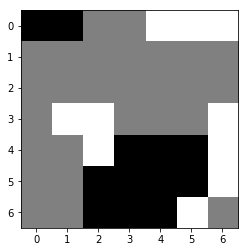

((4, 2), (5, 1)): n_v:  1116 q_all:-0.033987 q:+0.007422 q_m:+0.060000 p:0.531414
((3, 2), (5, 1)): n_v:   252 q_all:+0.005148 q:-0.017111 q_m:+0.040000 p:0.080176
((3, 1), (5, 1)): n_v:   225 q_all:+0.007176 q:-0.013709 q_m:+0.040000 p:0.069825
((3, 1), (1, 1)): n_v:   166 q_all:+0.037328 q:-0.013684 q_m:+0.040000 p:0.031103
((3, 2), (1, 1)): n_v:   135 q_all:+0.022990 q:-0.017428 q_m:+0.040000 p:0.033139
((3, 2), (3, 3)): n_v:    56 q_all:-0.009512 q:-0.053832 q_m:+0.060000 p:0.021479
((3, 1), (5, 0)): n_v:    47 q_all:-0.057577 q:-0.052142 q_m:-0.040000 p:0.026947
((3, 6), (3, 5)): n_v:    43 q_all:+0.005765 q:-0.023040 q_m:+0.060000 p:0.013819
((4, 2), (3, 4)): n_v:    42 q_all:+0.041081 q:+0.008308 q_m:+0.080000 p:0.007328
((3, 6), (1, 5)): n_v:    30 q_all:-0.067652 q:-0.050257 q_m:-0.040000 p:0.018692
((3, 1), (1, 0)): n_v:    27 q_all:+0.034483 q:-0.010936 q_m:+0.040000 p:0.005498
((0, 4), (1, 5)): n_v:    24 q_all:-0.047974 q:-0.048037 q_m:-0.020000 p:0.013332
((0, 5), (1, 6))

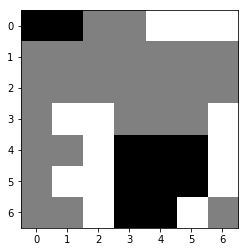

((6, 3), (4, 1)): n_v:  3085 q_all:+0.031297 q:+0.009326 q_m:+0.140000 p:0.788388
((5, 5), (6, 6)): n_v:   285 q_all:+0.090908 q:-0.034911 q_m:+0.040000 p:0.018997
((5, 3), (4, 1)): n_v:   161 q_all:-0.014362 q:-0.021524 q_m:+0.140000 p:0.064799
((4, 3), (4, 1)): n_v:   122 q_all:-0.001709 q:-0.003272 q_m:+0.140000 p:0.044104
((4, 3), (6, 1)): n_v:   102 q_all:+0.016669 q:-0.044432 q_m:+0.060000 p:0.030774
((6, 3), (6, 1)): n_v:    38 q_all:-0.023482 q:-0.056248 q_m:+0.060000 p:0.016264
((4, 4), (3, 5)): n_v:    29 q_all:+0.033337 q:-0.079574 q_m:+0.040000 p:0.007354
((0, 0), (2, 1)): n_v:    16 q_all:-0.002019 q:-0.073308 q_m:+0.020000 p:0.006021
((4, 3), (3, 3)): n_v:    11 q_all:+0.002481 q:-0.043142 q_m:+0.040000 p:0.004224
((0, 1), (2, 1)): n_v:     8 q_all:+0.003710 q:-0.075253 q_m:+0.020000 p:0.003065
((4, 3), (2, 1)): n_v:     6 q_all:-0.036002 q:-0.068038 q_m:+0.020000 p:0.003051
((4, 4), (6, 6)): n_v:     5 q_all:-0.029978 q:-0.082768 q_m:+0.020000 p:0.002342
((4, 3), (3, 5))

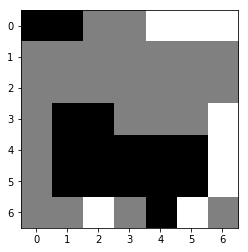

((6, 2), (6, 3)): n_v:  4455 q_all:+0.043068 q:-0.000238 q_m:+0.040000 p:0.611653
((6, 5), (6, 3)): n_v:   272 q_all:-0.012923 q:-0.018274 q_m:+0.020000 p:0.077342
((0, 4), (0, 3)): n_v:   246 q_all:-0.112918 q:-0.104633 q_m:-0.120000 p:0.134484
((6, 2), (6, 1)): n_v:   186 q_all:-0.034943 q:-0.059304 q_m:-0.040000 p:0.063749
((6, 2), (4, 0)): n_v:   158 q_all:-0.036708 q:-0.041825 q_m:-0.020000 p:0.054846
((5, 6), (3, 5)): n_v:    21 q_all:-0.044405 q:-0.110910 q_m:-0.060000 p:0.007825
((0, 5), (0, 3)): n_v:    17 q_all:-0.133287 q:-0.122663 q_m:-0.140000 p:0.010736
((5, 6), (6, 6)): n_v:     8 q_all:-0.079425 q:-0.120858 q_m:-0.080000 p:0.003943
((0, 4), (2, 2)): n_v:     5 q_all:-0.077806 q:-0.089771 q_m:-0.060000 p:0.002652
((3, 6), (3, 5)): n_v:     5 q_all:-0.088768 q:-0.092170 q_m:-0.040000 p:0.002760
((0, 4), (2, 6)): n_v:     4 q_all:-0.185271 q:-0.156444 q_m:-0.140000 p:0.003031
((0, 4), (2, 3)): n_v:     2 q_all:-0.123361 q:-0.114635 q_m:-0.100000 p:0.001600
((0, 5), (2, 6))

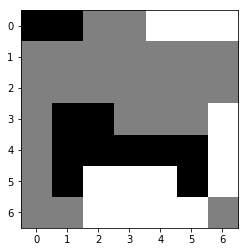

((5, 1), (6, 1)): n_v:  4864 q_all:+0.058584 q:-0.007263 q_m:+0.060000 p:0.061830
((4, 3), (6, 1)): n_v:  3259 q_all:-0.046443 q:-0.049140 q_m:+0.040000 p:0.765640
((4, 2), (6, 1)): n_v:   381 q_all:-0.077955 q:-0.062036 q_m:+0.040000 p:0.115163
((4, 1), (6, 1)): n_v:    73 q_all:-0.051197 q:-0.035667 q_m:+0.040000 p:0.017981
((4, 4), (3, 5)): n_v:    49 q_all:-0.012581 q:-0.037121 q_m:+0.060000 p:0.006878
((4, 5), (6, 6)): n_v:    25 q_all:-0.033518 q:-0.040273 q_m:+0.040000 p:0.005169
((4, 3), (3, 5)): n_v:    14 q_all:-0.033620 q:-0.036952 q_m:+0.040000 p:0.003029
((4, 4), (6, 6)): n_v:     7 q_all:-0.036098 q:-0.049832 q_m:+0.040000 p:0.001630
((5, 5), (6, 6)): n_v:     5 q_all:-0.020443 q:-0.038639 q_m:+0.060000 p:0.000841
((4, 1), (6, 0)): n_v:     3 q_all:-0.107055 q:-0.066914 q_m:-0.040000 p:0.001088
((4, 2), (6, 0)): n_v:     3 q_all:-0.119893 q:-0.101380 q_m:-0.040000 p:0.001283
((3, 1), (1, 1)): n_v:     2 q_all:-0.066007 q:-0.085364 q_m:-0.040000 p:0.000756
((4, 1), (5, 0))

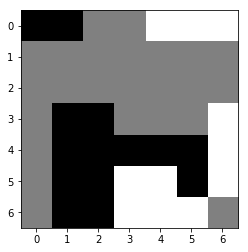

((5, 6), (3, 5)): n_v:  3948 q_all:+0.018113 q:-0.047992 q_m:+0.020000 p:0.035479
((5, 4), (3, 3)): n_v:  1561 q_all:-0.075510 q:-0.054297 q_m:+0.100000 p:0.333584
((3, 6), (3, 5)): n_v:   660 q_all:-0.038295 q:-0.009975 q_m:+0.040000 p:0.075764
((0, 4), (1, 2)): n_v:   436 q_all:-0.057490 q:-0.066321 q_m:-0.020000 p:0.074112
((0, 4), (2, 2)): n_v:   277 q_all:-0.060470 q:-0.067293 q_m:+0.020000 p:0.049578
((4, 6), (3, 4)): n_v:   172 q_all:-0.046461 q:-0.027509 q_m:+0.060000 p:0.023790
((5, 6), (3, 4)): n_v:   141 q_all:-0.048887 q:-0.032370 q_m:+0.060000 p:0.020577
((5, 6), (6, 6)): n_v:   118 q_all:-0.049238 q:-0.054337 q_m:-0.000000 p:0.017233
((4, 6), (2, 4)): n_v:   115 q_all:-0.039164 q:-0.084821 q_m:-0.060000 p:0.015478
((5, 3), (3, 3)): n_v:   110 q_all:-0.070018 q:-0.026166 q_m:+0.100000 p:0.022226
((3, 6), (1, 6)): n_v:    97 q_all:-0.062688 q:-0.091167 q_m:-0.060000 p:0.017927
((0, 4), (1, 3)): n_v:    65 q_all:-0.070946 q:-0.067090 q_m:-0.040000 p:0.013349
((3, 6), (1, 4))

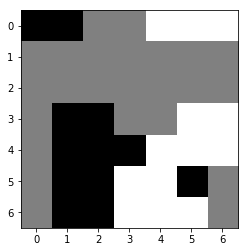

((5, 5), (5, 6)): n_v:  4831 q_all:+0.095215 q:+0.025623 q_m:+0.120000 p:0.072441
((3, 2), (5, 0)): n_v:   796 q_all:-0.062951 q:-0.076363 q_m:-0.020000 p:0.302623
((4, 3), (3, 4)): n_v:   693 q_all:-0.001682 q:+0.039213 q_m:+0.120000 p:0.129694
((3, 2), (1, 0)): n_v:   289 q_all:-0.038493 q:-0.052647 q_m:-0.020000 p:0.088045
((4, 2), (3, 4)): n_v:   273 q_all:-0.061647 q:-0.000714 q_m:+0.100000 p:0.103055
((4, 2), (5, 0)): n_v:   141 q_all:-0.156441 q:-0.089963 q_m:-0.020000 p:0.084377
((3, 1), (5, 0)): n_v:   127 q_all:-0.081331 q:-0.064586 q_m:-0.020000 p:0.054042
((4, 1), (5, 0)): n_v:   111 q_all:-0.061920 q:-0.042520 q_m:-0.000000 p:0.042218
((3, 2), (3, 4)): n_v:    63 q_all:+0.041138 q:+0.019388 q_m:+0.100000 p:0.003139
((5, 2), (3, 4)): n_v:    37 q_all:-0.048957 q:+0.009233 q_m:+0.100000 p:0.012517
((3, 1), (1, 0)): n_v:    24 q_all:-0.085987 q:-0.050659 q_m:-0.020000 p:0.010534
((3, 1), (1, 1)): n_v:    19 q_all:-0.072367 q:-0.057363 q_m:-0.020000 p:0.007934
((3, 2), (1, 1))

((4, 4), (3, 3)): n_v:  2413 q_all:-0.080202 q:-0.053152 q_m:+0.020000 p:0.378769
((6, 4), (6, 6)): n_v:   631 q_all:-0.038160 q:-0.096577 q_m:-0.000000 p:0.029840
((4, 4), (6, 6)): n_v:   443 q_all:-0.089065 q:-0.095615 q_m:-0.000000 p:0.079764
((3, 6), (1, 6)): n_v:   399 q_all:-0.084278 q:-0.148385 q_m:-0.120000 p:0.066982
((0, 4), (2, 2)): n_v:   365 q_all:-0.055432 q:-0.111579 q_m:-0.040000 p:0.033397
((4, 4), (2, 2)): n_v:   324 q_all:-0.097409 q:-0.104360 q_m:-0.040000 p:0.065526
((5, 4), (3, 3)): n_v:   257 q_all:-0.108932 q:-0.082123 q_m:-0.000000 p:0.059764
((3, 5), (3, 3)): n_v:   191 q_all:-0.068556 q:-0.068658 q_m:-0.000000 p:0.024269
((3, 5), (3, 4)): n_v:   117 q_all:-0.094579 q:-0.075862 q_m:-0.020000 p:0.022853
((3, 5), (1, 6)): n_v:   115 q_all:-0.149327 q:-0.134505 q_m:-0.120000 p:0.039006
((0, 4), (1, 2)): n_v:   100 q_all:-0.111471 q:-0.124647 q_m:-0.080000 p:0.023807
((5, 4), (6, 6)): n_v:    84 q_all:-0.129453 q:-0.092527 q_m:-0.000000 p:0.024009
((0, 4), (0, 2))

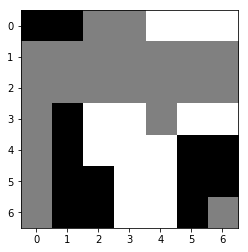

((4, 5), (3, 4)): n_v:  4119 q_all:+0.114516 q:+0.039144 q_m:+0.160000 p:0.774914
((5, 6), (3, 4)): n_v:   288 q_all:+0.070383 q:+0.029657 q_m:+0.140000 p:0.088841
((4, 6), (3, 4)): n_v:   204 q_all:+0.073652 q:+0.004033 q_m:+0.140000 p:0.061036
((5, 5), (3, 4)): n_v:    94 q_all:+0.055953 q:+0.001728 q_m:+0.140000 p:0.032952
((5, 2), (3, 4)): n_v:    36 q_all:+0.042812 q:+0.007009 q_m:+0.140000 p:0.013836
((3, 1), (2, 2)): n_v:    29 q_all:+0.073382 q:-0.009882 q_m:+0.080000 p:0.008634
((0, 0), (1, 1)): n_v:     3 q_all:+0.006603 q:-0.028996 q_m:-0.000000 p:0.001775
((3, 1), (5, 0)): n_v:     3 q_all:-0.012507 q:-0.057134 q_m:-0.020000 p:0.001723
((0, 1), (0, 2)): n_v:     3 q_all:+0.013425 q:-0.010380 q_m:-0.000000 p:0.001662
((4, 6), (2, 4)): n_v:     3 q_all:+0.023760 q:-0.039543 q_m:+0.060000 p:0.001350
((3, 1), (1, 2)): n_v:     2 q_all:+0.015431 q:-0.031503 q_m:-0.020000 p:0.000946
((3, 1), (1, 1)): n_v:     2 q_all:-0.018793 q:-0.051899 q_m:-0.020000 p:0.001486
((3, 1), (2, 3))

((3, 2), (5, 0)): n_v:  2087 q_all:-0.064710 q:-0.111399 q_m:-0.040000 p:0.381899
((3, 6), (2, 5)): n_v:   257 q_all:-0.114742 q:-0.123143 q_m:-0.060000 p:0.083096
((3, 2), (4, 0)): n_v:   247 q_all:-0.122320 q:-0.105492 q_m:-0.040000 p:0.085204
((3, 2), (2, 4)): n_v:   160 q_all:-0.101500 q:-0.138934 q_m:-0.040000 p:0.045669
((3, 2), (2, 1)): n_v:    91 q_all:-0.134520 q:-0.168844 q_m:-0.100000 p:0.034745
((4, 2), (2, 0)): n_v:    78 q_all:-0.195182 q:-0.190471 q_m:-0.120000 p:0.043068
((3, 2), (1, 0)): n_v:    72 q_all:-0.142051 q:-0.156606 q_m:-0.080000 p:0.029010
((4, 2), (5, 0)): n_v:    68 q_all:-0.117702 q:-0.093662 q_m:-0.040000 p:0.022658
((0, 5), (2, 4)): n_v:    64 q_all:-0.102971 q:-0.139279 q_m:-0.040000 p:0.018693
((3, 2), (2, 0)): n_v:    61 q_all:-0.178847 q:-0.220770 q_m:-0.120000 p:0.031110
((0, 4), (2, 6)): n_v:    51 q_all:-0.170657 q:-0.157591 q_m:-0.120000 p:0.024658
((0, 5), (2, 6)): n_v:    50 q_all:-0.170730 q:-0.137348 q_m:-0.120000 p:0.024312
((0, 4), (2, 5))

((3, 4), (1, 5)): n_v:  1156 q_all:+0.101331 q:+0.069374 q_m:+0.160000 p:0.129507
((3, 1), (4, 0)): n_v:   338 q_all:+0.088294 q:+0.057287 q_m:+0.180000 p:0.053104
((3, 5), (1, 5)): n_v:   338 q_all:+0.088917 q:+0.065370 q_m:+0.160000 p:0.052233
((3, 1), (3, 2)): n_v:   276 q_all:+0.080521 q:+0.018754 q_m:+0.140000 p:0.050904
((3, 3), (1, 5)): n_v:   243 q_all:+0.092599 q:+0.063900 q_m:+0.160000 p:0.034727
((4, 4), (6, 6)): n_v:   193 q_all:-0.037017 q:-0.045368 q_m:+0.040000 p:0.115408
((4, 6), (6, 6)): n_v:   119 q_all:-0.024986 q:-0.051466 q_m:+0.040000 p:0.066220
((6, 2), (4, 0)): n_v:    92 q_all:+0.078865 q:+0.025717 q_m:+0.160000 p:0.017564
((5, 5), (6, 6)): n_v:    75 q_all:+0.020258 q:-0.011896 q_m:+0.060000 p:0.030025
((3, 5), (2, 6)): n_v:    57 q_all:+0.045209 q:+0.009226 q_m:+0.100000 p:0.017839
((4, 5), (6, 6)): n_v:    55 q_all:-0.037174 q:-0.035698 q_m:+0.040000 p:0.032686
((3, 3), (1, 1)): n_v:    50 q_all:+0.016386 q:-0.034840 q_m:+0.040000 p:0.020369
((3, 1), (1, 1))

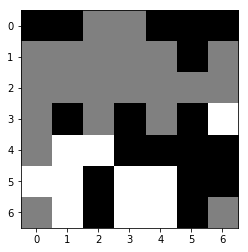

((4, 1), (3, 2)): n_v:   787 q_all:-0.087902 q:-0.103621 q_m:-0.020000 p:0.310834
((4, 2), (3, 4)): n_v:   621 q_all:-0.023833 q:-0.042975 q_m:+0.040000 p:0.082009
((3, 6), (1, 6)): n_v:   223 q_all:-0.005479 q:-0.111753 q_m:-0.040000 p:0.012542
((3, 6), (1, 4)): n_v:   153 q_all:+0.005460 q:-0.095546 q_m:-0.040000 p:0.002649
((3, 6), (3, 4)): n_v:   115 q_all:-0.062595 q:-0.039395 q_m:+0.040000 p:0.033382
((5, 0), (3, 2)): n_v:    66 q_all:-0.051430 q:-0.119493 q_m:-0.040000 p:0.016095
((5, 4), (3, 2)): n_v:    32 q_all:-0.069597 q:-0.111862 q_m:-0.040000 p:0.010390
((3, 6), (2, 5)): n_v:     8 q_all:-0.066414 q:-0.143959 q_m:-0.060000 p:0.002355
((5, 1), (3, 2)): n_v:     4 q_all:-0.136078 q:-0.100247 q_m:-0.040000 p:0.002760
((5, 3), (3, 4)): n_v:     3 q_all:-0.113779 q:-0.067897 q_m:+0.040000 p:0.001663
((5, 3), (3, 2)): n_v:     3 q_all:-0.145211 q:-0.119766 q_m:-0.040000 p:0.002211
((4, 2), (6, 0)): n_v:     2 q_all:-0.228433 q:-0.197649 q_m:-0.160000 p:0.002800
((4, 2), (2, 1))

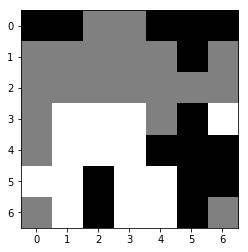

((6, 2), (4, 0)): n_v:  1300 q_all:+0.145152 q:+0.087096 q_m:+0.180000 p:0.628033
((0, 4), (2, 6)): n_v:   128 q_all:+0.037280 q:-0.004791 q_m:+0.060000 p:0.128020
((5, 2), (4, 0)): n_v:    34 q_all:+0.129430 q:+0.092153 q_m:+0.180000 p:0.018872
((4, 4), (2, 6)): n_v:    28 q_all:+0.060546 q:-0.007762 q_m:+0.060000 p:0.024525
((1, 5), (2, 6)): n_v:    24 q_all:+0.050063 q:+0.039280 q_m:+0.080000 p:0.022488
((0, 6), (2, 6)): n_v:    18 q_all:+0.042543 q:+0.001943 q_m:+0.060000 p:0.017952
((4, 4), (2, 2)): n_v:    16 q_all:+0.088792 q:+0.043178 q_m:+0.140000 p:0.012653
((0, 1), (2, 0)): n_v:    16 q_all:+0.045691 q:+0.029527 q_m:+0.060000 p:0.015445
((0, 0), (2, 0)): n_v:    16 q_all:+0.050577 q:+0.030174 q_m:+0.060000 p:0.015470
((0, 4), (2, 4)): n_v:    15 q_all:-0.004663 q:+0.003012 q_m:+0.060000 p:0.018661
((3, 5), (3, 4)): n_v:    15 q_all:+0.110502 q:+0.039481 q_m:+0.120000 p:0.010324
((0, 5), (2, 6)): n_v:    12 q_all:+0.051062 q:-0.002651 q_m:+0.060000 p:0.011861
((1, 5), (2, 4))

((3, 6), (1, 6)): n_v:   560 q_all:-0.111777 q:-0.130896 q_m:-0.060000 p:0.232517
((3, 3), (1, 4)): n_v:   298 q_all:-0.093127 q:-0.094732 q_m:-0.060000 p:0.100769
((3, 3), (3, 4)): n_v:   185 q_all:-0.099734 q:-0.096049 q_m:-0.040000 p:0.067765
((3, 2), (1, 4)): n_v:   167 q_all:-0.106773 q:-0.158128 q_m:-0.060000 p:0.065927
((5, 4), (6, 6)): n_v:   161 q_all:-0.151735 q:-0.107547 q_m:-0.060000 p:0.093947
((3, 2), (1, 0)): n_v:   108 q_all:-0.150066 q:-0.160463 q_m:-0.100000 p:0.062326
((5, 3), (6, 2)): n_v:    86 q_all:-0.070089 q:-0.103322 q_m:-0.080000 p:0.020843
((3, 2), (3, 0)): n_v:    82 q_all:-0.136406 q:-0.138079 q_m:-0.060000 p:0.042467
((4, 2), (3, 4)): n_v:    75 q_all:-0.108666 q:-0.116916 q_m:-0.060000 p:0.030324
((3, 3), (1, 2)): n_v:    56 q_all:-0.172898 q:-0.159717 q_m:-0.140000 p:0.038139
((6, 1), (6, 0)): n_v:    41 q_all:-0.177080 q:-0.109269 q_m:-0.080000 p:0.028289
((3, 2), (1, 2)): n_v:    35 q_all:-0.167589 q:-0.183506 q_m:-0.140000 p:0.023253
((3, 3), (2, 5))

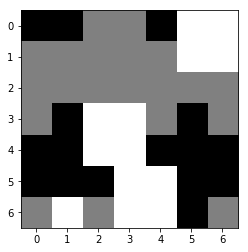

((5, 1), (6, 2)): n_v:  2023 q_all:+0.182837 q:+0.095537 q_m:+0.200000 p:0.391249
((0, 1), (0, 2)): n_v:   107 q_all:+0.072755 q:+0.031821 q_m:+0.080000 p:0.068360
((4, 4), (6, 2)): n_v:    98 q_all:+0.140370 q:+0.054362 q_m:+0.180000 p:0.035979
((5, 0), (6, 2)): n_v:    58 q_all:+0.143966 q:+0.064395 q_m:+0.180000 p:0.020580
((0, 4), (1, 4)): n_v:    40 q_all:+0.150686 q:+0.043852 q_m:+0.160000 p:0.013116
((3, 5), (2, 4)): n_v:    14 q_all:+0.071852 q:+0.034728 q_m:+0.160000 p:0.009363
((3, 1), (2, 2)): n_v:    14 q_all:+0.122775 q:+0.033084 q_m:+0.160000 p:0.006421
((4, 0), (6, 2)): n_v:     8 q_all:+0.151821 q:+0.059486 q_m:+0.180000 p:0.002688
((4, 1), (6, 2)): n_v:     7 q_all:+0.066774 q:+0.071690 q_m:+0.180000 p:0.004890
((3, 5), (2, 6)): n_v:     7 q_all:+0.126659 q:+0.050218 q_m:+0.160000 p:0.003317
((3, 5), (3, 4)): n_v:     6 q_all:+0.121371 q:+0.046142 q_m:+0.160000 p:0.002748
((3, 5), (2, 5)): n_v:     6 q_all:+0.122709 q:+0.047900 q_m:+0.160000 p:0.002372
((0, 4), (0, 2))

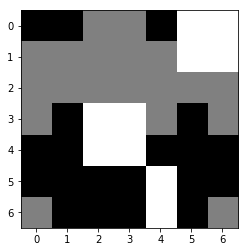

((5, 4), (3, 6)): n_v:  3304 q_all:-0.132853 q:-0.137277 q_m:-0.080000 p:0.575365
((1, 6), (3, 6)): n_v:   633 q_all:-0.176868 q:-0.142506 q_m:-0.080000 p:0.187179
((3, 2), (3, 0)): n_v:   520 q_all:-0.133243 q:-0.168033 q_m:-0.080000 p:0.090806
((3, 3), (3, 4)): n_v:   255 q_all:-0.088554 q:-0.103625 q_m:-0.060000 p:0.013288
((4, 2), (3, 0)): n_v:   192 q_all:-0.198345 q:-0.143053 q_m:-0.080000 p:0.068358
((1, 5), (3, 6)): n_v:    70 q_all:-0.173299 q:-0.140897 q_m:-0.080000 p:0.020173
((4, 2), (6, 0)): n_v:    56 q_all:-0.165939 q:-0.167801 q_m:-0.080000 p:0.014857
((4, 2), (3, 4)): n_v:    34 q_all:-0.126773 q:-0.129659 q_m:-0.080000 p:0.005252
((5, 4), (6, 6)): n_v:    23 q_all:-0.157574 q:-0.145691 q_m:-0.080000 p:0.005760
((6, 4), (6, 6)): n_v:     7 q_all:-0.148339 q:-0.154126 q_m:-0.080000 p:0.001653
((1, 6), (3, 4)): n_v:     7 q_all:-0.137140 q:-0.138121 q_m:-0.080000 p:0.001536
((5, 4), (3, 4)): n_v:     2 q_all:-0.174230 q:-0.132400 q_m:-0.080000 p:0.000633
((3, 2), (1, 1))

((4, 4), (5, 4)): n_v:  6823 q_all:+0.182093 q:+0.137820 q_m:+0.228000 p:0.088747
((4, 4), (3, 4)): n_v:   420 q_all:+0.143323 q:+0.108781 q_m:+0.284000 p:0.010022
((4, 4), (2, 6)): n_v:   363 q_all:+0.149932 q:+0.077103 q_m:+0.256000 p:0.000346
((5, 6), (5, 4)): n_v:   121 q_all:+0.113192 q:+0.099138 q_m:+0.200000 p:0.015577
((0, 4), (2, 6)): n_v:    92 q_all:+0.148370 q:+0.093895 q_m:+0.256000 p:0.000456
((6, 2), (5, 4)): n_v:    89 q_all:+0.113141 q:+0.104140 q_m:+0.200000 p:0.011465
((0, 4), (1, 4)): n_v:    76 q_all:+0.077115 q:+0.077385 q_m:+0.180000 p:0.018676
((0, 4), (2, 5)): n_v:    58 q_all:+0.137754 q:+0.081900 q_m:+0.256000 p:0.002535
((5, 6), (3, 4)): n_v:    55 q_all:+0.120986 q:+0.099904 q_m:+0.256000 p:0.005426
((5, 5), (3, 4)): n_v:    30 q_all:+0.124051 q:+0.098791 q_m:+0.256000 p:0.002693
((4, 0), (2, 2)): n_v:    13 q_all:+0.043926 q:+0.023975 q_m:+0.160000 p:0.004020
((5, 2), (5, 4)): n_v:    13 q_all:+0.061080 q:+0.044515 q_m:+0.200000 p:0.003899
((0, 1), (1, 2))

((3, 3), (3, 4)): n_v:  9295 q_all:-0.140660 q:-0.148194 q_m:-0.080000 p:0.366986
((1, 6), (3, 4)): n_v:   853 q_all:-0.151865 q:-0.166221 q_m:-0.100000 p:0.007398
((4, 6), (6, 6)): n_v:   445 q_all:-0.214684 q:-0.204437 q_m:-0.100000 p:0.071677
((3, 6), (3, 4)): n_v:   214 q_all:-0.158706 q:-0.146746 q_m:-0.100000 p:0.005423
((4, 6), (3, 4)): n_v:   150 q_all:-0.186609 q:-0.166350 q_m:-0.100000 p:0.013882
((4, 2), (3, 0)): n_v:   106 q_all:-0.206878 q:-0.159146 q_m:-0.100000 p:0.015049
((4, 2), (3, 4)): n_v:    75 q_all:-0.177375 q:-0.143855 q_m:-0.100000 p:0.005344
((3, 2), (3, 4)): n_v:    45 q_all:-0.182224 q:-0.147645 q_m:-0.100000 p:0.003765
((3, 2), (3, 0)): n_v:    40 q_all:-0.206981 q:-0.196127 q_m:-0.100000 p:0.005726
((4, 2), (6, 0)): n_v:    39 q_all:-0.183862 q:-0.156338 q_m:-0.100000 p:0.003375
((1, 5), (3, 4)): n_v:    30 q_all:-0.171793 q:-0.135031 q_m:-0.100000 p:0.001691
((3, 2), (1, 1)): n_v:     3 q_all:-0.205376 q:-0.197677 q_m:-0.140000 p:0.000509
((3, 3), (1, 1))

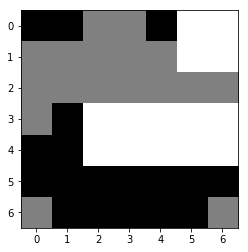

((0, 4), (2, 5)): n_v:  6353 q_all:+0.165034 q:+0.133200 q_m:+0.312000 p:0.431994
((0, 4), (1, 4)): n_v:  1842 q_all:+0.206062 q:+0.061121 q_m:+0.180000 p:0.008055
((3, 1), (2, 2)): n_v:  1154 q_all:+0.113684 q:+0.067534 q_m:+0.180000 p:0.197814
((0, 4), (2, 2)): n_v:   276 q_all:+0.093356 q:+0.056102 q_m:+0.160000 p:0.058675
((3, 1), (2, 1)): n_v:   170 q_all:+0.084357 q:+0.028423 q_m:+0.140000 p:0.039118
((5, 0), (6, 0)): n_v:   105 q_all:+0.070437 q:+0.072902 q_m:+0.100000 p:0.026907
((3, 1), (2, 3)): n_v:   100 q_all:+0.124984 q:+0.076028 q_m:+0.200000 p:0.014975
((0, 4), (2, 4)): n_v:    97 q_all:+0.171122 q:+0.091460 q_m:+0.256000 p:0.005446
((0, 0), (2, 1)): n_v:    77 q_all:+0.071465 q:+0.033621 q_m:+0.120000 p:0.019789
((4, 0), (2, 2)): n_v:    68 q_all:+0.093528 q:+0.046301 q_m:+0.160000 p:0.014520
((0, 4), (2, 3)): n_v:    50 q_all:+0.120438 q:+0.067104 q_m:+0.200000 p:0.007913
((0, 1), (2, 3)): n_v:    49 q_all:+0.124593 q:+0.085083 q_m:+0.200000 p:0.007315
((0, 1), (2, 1))

((0, 5), (2, 6)): n_v:  3668 q_all:-0.134751 q:-0.122310 q_m:-0.080000 p:0.392729
((0, 6), (2, 6)): n_v:  2500 q_all:-0.127378 q:-0.119576 q_m:-0.080000 p:0.232205
((4, 4), (2, 6)): n_v:   874 q_all:-0.127782 q:-0.110600 q_m:-0.080000 p:0.081789
((4, 6), (2, 6)): n_v:   400 q_all:-0.114462 q:-0.136960 q_m:-0.080000 p:0.027156
((3, 2), (2, 0)): n_v:   322 q_all:-0.299515 q:-0.323395 q_m:-0.256000 p:0.136892
((4, 5), (2, 6)): n_v:   184 q_all:-0.135713 q:-0.148859 q_m:-0.080000 p:0.020134
((4, 2), (2, 0)): n_v:   154 q_all:-0.271006 q:-0.250062 q_m:-0.256000 p:0.057114
((3, 3), (2, 4)): n_v:   127 q_all:-0.129245 q:-0.183345 q_m:-0.100000 p:0.012331
((4, 2), (2, 4)): n_v:    38 q_all:-0.144881 q:-0.163973 q_m:-0.120000 p:0.004849
((4, 6), (6, 6)): n_v:    33 q_all:-0.175023 q:-0.189694 q_m:-0.160000 p:0.006195
((3, 2), (2, 2)): n_v:    21 q_all:-0.218519 q:-0.291835 q_m:-0.228000 p:0.005713
((0, 5), (2, 4)): n_v:    20 q_all:-0.147420 q:-0.188767 q_m:-0.120000 p:0.002713
((0, 6), (2, 4))

((3, 4), (2, 4)): n_v:  5233 q_all:+0.220143 q:+0.120818 q_m:+0.284000 p:0.460339
((3, 1), (2, 2)): n_v:  1465 q_all:+0.123107 q:+0.037004 q_m:+0.180000 p:0.434434
((4, 0), (2, 2)): n_v:   178 q_all:+0.110944 q:+0.018834 q_m:+0.160000 p:0.057421
((3, 4), (2, 2)): n_v:    88 q_all:+0.136372 q:+0.046866 q_m:+0.160000 p:0.023719
((0, 0), (2, 2)): n_v:    13 q_all:+0.102980 q:+0.026258 q_m:+0.160000 p:0.004569
((4, 1), (2, 2)): n_v:     6 q_all:+0.009735 q:+0.015683 q_m:+0.160000 p:0.003306
((0, 1), (2, 2)): n_v:     5 q_all:+0.107057 q:+0.034117 q_m:+0.160000 p:0.001649
((4, 0), (2, 1)): n_v:     4 q_all:+0.105732 q:+0.018479 q_m:+0.120000 p:0.001615
((3, 4), (2, 3)): n_v:     4 q_all:+0.123701 q:+0.060205 q_m:+0.180000 p:0.001442
((3, 4), (1, 4)): n_v:     3 q_all:+0.220843 q:+0.069054 q_m:+0.160000 p:0.000320
((3, 1), (1, 2)): n_v:     2 q_all:+0.081396 q:-0.002192 q_m:+0.080000 p:0.000881
((3, 1), (2, 3)): n_v:     2 q_all:+0.085704 q:+0.028037 q_m:+0.160000 p:0.000870
((4, 0), (2, 0))

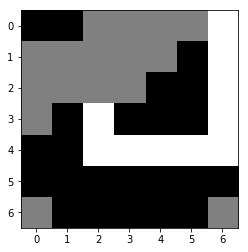

((3, 2), (1, 4)): n_v:  3552 q_all:-0.168950 q:-0.235765 q_m:-0.140000 p:0.191920
((0, 6), (1, 4)): n_v:  1360 q_all:-0.213058 q:-0.220341 q_m:-0.140000 p:0.205822
((4, 2), (6, 0)): n_v:  1199 q_all:-0.223189 q:-0.271917 q_m:-0.140000 p:0.208215
((3, 2), (2, 3)): n_v:   478 q_all:-0.214120 q:-0.266627 q_m:-0.120000 p:0.073528
((4, 4), (6, 6)): n_v:   275 q_all:-0.225391 q:-0.290655 q_m:-0.140000 p:0.049213
((3, 2), (1, 1)): n_v:   251 q_all:-0.226295 q:-0.241380 q_m:-0.180000 p:0.045258
((2, 6), (1, 4)): n_v:   216 q_all:-0.251231 q:-0.295750 q_m:-0.140000 p:0.050818
((1, 6), (1, 4)): n_v:   210 q_all:-0.213410 q:-0.277158 q_m:-0.140000 p:0.032067
((4, 6), (6, 6)): n_v:   191 q_all:-0.252031 q:-0.250845 q_m:-0.140000 p:0.045291
((3, 6), (1, 4)): n_v:    56 q_all:-0.224814 q:-0.217600 q_m:-0.140000 p:0.010016
((0, 6), (0, 4)): n_v:    49 q_all:-0.202947 q:-0.303496 q_m:-0.228000 p:0.006369
((1, 6), (0, 4)): n_v:    33 q_all:-0.253108 q:-0.323150 q_m:-0.228000 p:0.008134
((4, 5), (6, 6))

((3, 1), (3, 2)): n_v:  2754 q_all:+0.196458 q:+0.126042 q_m:+0.256000 p:0.200991
((3, 4), (1, 3)): n_v:  1021 q_all:+0.168330 q:+0.116707 q_m:+0.228000 p:0.149218
((3, 4), (3, 2)): n_v:   670 q_all:+0.223645 q:+0.140387 q_m:+0.228000 p:0.003235
((3, 5), (2, 3)): n_v:   641 q_all:+0.222586 q:+0.098543 q_m:+0.228000 p:0.006552
((5, 0), (3, 2)): n_v:   231 q_all:+0.166176 q:+0.093331 q_m:+0.228000 p:0.035087
((3, 3), (2, 3)): n_v:   185 q_all:+0.171070 q:+0.157377 q_m:+0.256000 p:0.025776
((4, 0), (3, 2)): n_v:   130 q_all:+0.216800 q:+0.096834 q_m:+0.228000 p:0.003070
((3, 5), (1, 3)): n_v:   105 q_all:+0.200778 q:+0.097115 q_m:+0.228000 p:0.006790
((0, 1), (1, 3)): n_v:    80 q_all:+0.160714 q:+0.117847 q_m:+0.228000 p:0.013201
((3, 1), (1, 1)): n_v:    50 q_all:+0.086107 q:+0.052549 q_m:+0.140000 p:0.017789
((3, 1), (1, 3)): n_v:    46 q_all:+0.153666 q:+0.097616 q_m:+0.228000 p:0.008311
((3, 3), (1, 1)): n_v:    44 q_all:+0.096680 q:+0.076226 q_m:+0.140000 p:0.014396
((5, 4), (3, 2))

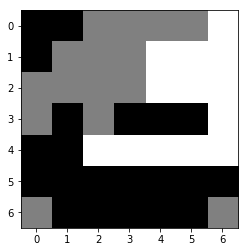

((4, 2), (6, 0)): n_v:  2346 q_all:-0.000943 q:-0.126519 q_m:-0.040000 p:0.629975
((4, 4), (6, 6)): n_v:   351 q_all:-0.021863 q:-0.129855 q_m:-0.040000 p:0.121274
((4, 2), (3, 2)): n_v:   157 q_all:-0.126802 q:-0.122699 q_m:-0.020000 p:0.115270
((4, 4), (3, 2)): n_v:    30 q_all:-0.052935 q:-0.122001 q_m:-0.040000 p:0.013919
((4, 2), (3, 0)): n_v:    16 q_all:-0.005130 q:-0.138863 q_m:-0.040000 p:0.004533
((4, 2), (2, 1)): n_v:    15 q_all:-0.045017 q:-0.143657 q_m:-0.080000 p:0.006859
((4, 6), (6, 6)): n_v:    15 q_all:-0.120767 q:-0.157260 q_m:-0.040000 p:0.010883
((4, 2), (2, 0)): n_v:     6 q_all:-0.047351 q:-0.151695 q_m:-0.080000 p:0.003029
((2, 4), (3, 2)): n_v:     4 q_all:-0.138084 q:-0.170866 q_m:-0.040000 p:0.003091
((2, 4), (1, 2)): n_v:     3 q_all:-0.104685 q:-0.188386 q_m:-0.120000 p:0.002143
((4, 3), (2, 1)): n_v:     3 q_all:-0.037020 q:-0.164746 q_m:-0.080000 p:0.001360
((1, 4), (3, 2)): n_v:     2 q_all:-0.119107 q:-0.179421 q_m:-0.040000 p:0.001879
((2, 4), (0, 5))

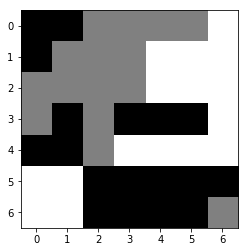

((3, 5), (1, 3)): n_v:  4176 q_all:+0.103329 q:+0.023893 q_m:+0.120000 p:0.003971
((3, 1), (4, 2)): n_v:   505 q_all:+0.002394 q:+0.057431 q_m:+0.140000 p:0.116509
((3, 3), (1, 3)): n_v:   417 q_all:+0.055511 q:+0.063857 q_m:+0.120000 p:0.004576
((3, 4), (1, 3)): n_v:   308 q_all:+0.033721 q:+0.053692 q_m:+0.120000 p:0.031194
((3, 4), (4, 2)): n_v:   253 q_all:+0.008993 q:+0.063437 q_m:+0.120000 p:0.051437
((3, 1), (2, 2)): n_v:   175 q_all:-0.031210 q:-0.036346 q_m:+0.060000 p:0.057804
((6, 4), (4, 2)): n_v:   161 q_all:-0.015606 q:-0.003775 q_m:+0.120000 p:0.047100
((3, 3), (2, 3)): n_v:   116 q_all:-0.004230 q:+0.060834 q_m:+0.140000 p:0.030138
((3, 3), (1, 1)): n_v:   111 q_all:-0.029481 q:+0.018936 q_m:+0.040000 p:0.036387
((5, 4), (4, 2)): n_v:   102 q_all:-0.061402 q:+0.018658 q_m:+0.120000 p:0.041434
((6, 2), (4, 2)): n_v:    56 q_all:-0.016150 q:+0.014422 q_m:+0.120000 p:0.016593
((3, 1), (1, 1)): n_v:    53 q_all:-0.057160 q:-0.009826 q_m:+0.040000 p:0.021032
((3, 4), (2, 2))

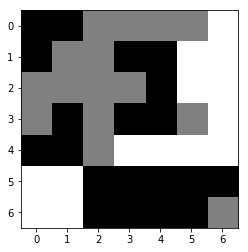

((4, 4), (4, 2)): n_v:  5666 q_all:+0.004553 q:-0.080408 q_m:+0.080000 p:0.000118
((2, 5), (3, 5)): n_v:  2642 q_all:-0.110755 q:-0.087096 q_m:-0.020000 p:0.332742
((1, 6), (3, 5)): n_v:   321 q_all:-0.073482 q:-0.080819 q_m:-0.040000 p:0.003261
((4, 3), (3, 5)): n_v:   162 q_all:-0.103607 q:-0.082582 q_m:-0.040000 p:0.016909
((2, 5), (2, 3)): n_v:    74 q_all:-0.112200 q:-0.056447 q_m:+0.080000 p:0.009741
((4, 5), (2, 3)): n_v:    68 q_all:-0.135848 q:-0.058239 q_m:+0.080000 p:0.013907
((4, 4), (2, 3)): n_v:    54 q_all:-0.106661 q:-0.036057 q_m:+0.080000 p:0.006191
((4, 4), (6, 6)): n_v:    42 q_all:-0.099421 q:-0.111253 q_m:-0.000000 p:0.003760
((4, 3), (4, 2)): n_v:    31 q_all:-0.117335 q:-0.052766 q_m:+0.100000 p:0.004512
((4, 4), (2, 2)): n_v:    27 q_all:-0.140284 q:-0.162767 q_m:-0.000000 p:0.005847
((6, 1), (4, 2)): n_v:    21 q_all:-0.103897 q:-0.131001 q_m:+0.080000 p:0.002195
((2, 6), (0, 4)): n_v:    11 q_all:-0.200179 q:-0.145644 q_m:-0.040000 p:0.004420
((6, 0), (4, 2))

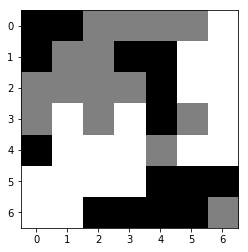

((2, 4), (3, 5)): n_v:  6805 q_all:+0.103840 q:+0.052620 q_m:+0.140000 p:0.122142
((4, 0), (3, 2)): n_v:   935 q_all:-0.028451 q:-0.049453 q_m:+0.120000 p:0.186653
((1, 0), (3, 2)): n_v:   934 q_all:-0.027789 q:-0.038488 q_m:+0.120000 p:0.184861
((5, 6), (3, 5)): n_v:   446 q_all:+0.007744 q:+0.015025 q_m:+0.120000 p:0.046215
((5, 5), (3, 5)): n_v:   242 q_all:-0.016030 q:+0.020096 q_m:+0.120000 p:0.040294
((1, 4), (3, 2)): n_v:   234 q_all:-0.017528 q:-0.004430 q_m:+0.120000 p:0.040028
((3, 4), (3, 2)): n_v:   200 q_all:+0.008870 q:-0.030712 q_m:+0.120000 p:0.020156
((1, 3), (3, 5)): n_v:   178 q_all:+0.003144 q:+0.025346 q_m:+0.120000 p:0.020520
((1, 3), (3, 2)): n_v:   169 q_all:-0.020816 q:-0.044083 q_m:+0.120000 p:0.030414
((1, 4), (3, 5)): n_v:   157 q_all:+0.023405 q:+0.047862 q_m:+0.120000 p:0.009685
((5, 4), (3, 5)): n_v:   108 q_all:+0.010142 q:+0.043960 q_m:+0.120000 p:0.010427
((2, 4), (3, 2)): n_v:   103 q_all:-0.013852 q:-0.009146 q_m:+0.120000 p:0.016620
((5, 4), (3, 2))

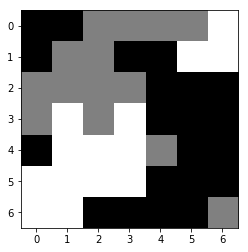

((3, 3), (1, 1)): n_v:  4835 q_all:-0.012352 q:-0.094048 q_m:-0.020000 p:0.078210
((3, 3), (2, 3)): n_v:  2766 q_all:-0.086759 q:-0.118528 q_m:+0.040000 p:0.284569
((4, 2), (4, 4)): n_v:  2635 q_all:-0.106447 q:-0.098847 q_m:+0.060000 p:0.389916
((5, 2), (4, 4)): n_v:   681 q_all:-0.121291 q:-0.123478 q_m:+0.060000 p:0.123949
((3, 3), (4, 4)): n_v:   340 q_all:-0.065322 q:-0.076859 q_m:+0.080000 p:0.017079
((3, 1), (2, 3)): n_v:   296 q_all:-0.104557 q:-0.102113 q_m:+0.020000 p:0.042575
((3, 1), (1, 1)): n_v:    41 q_all:-0.097057 q:-0.095505 q_m:-0.020000 p:0.005282
((1, 5), (2, 3)): n_v:    35 q_all:-0.105921 q:-0.128717 q_m:+0.020000 p:0.005102
((4, 1), (2, 3)): n_v:    10 q_all:-0.120240 q:-0.181898 q_m:+0.020000 p:0.001833
((4, 2), (2, 3)): n_v:     8 q_all:-0.103690 q:-0.159666 q_m:+0.020000 p:0.001233
((4, 3), (2, 3)): n_v:     7 q_all:-0.125159 q:-0.142289 q_m:+0.020000 p:0.001371
((0, 6), (0, 4)): n_v:     3 q_all:-0.165166 q:-0.212978 q_m:-0.060000 p:0.001098
((1, 5), (0, 4))

((1, 4), (0, 5)): n_v:  6130 q_all:+0.103464 q:+0.088742 q_m:+0.160000 p:0.154150
((2, 4), (0, 5)): n_v:   903 q_all:+0.000317 q:+0.044782 q_m:+0.140000 p:0.178528
((1, 3), (0, 5)): n_v:   619 q_all:+0.007708 q:+0.083728 q_m:+0.140000 p:0.109165
((3, 4), (4, 4)): n_v:   514 q_all:+0.016282 q:+0.037250 q_m:+0.120000 p:0.078022
((4, 0), (3, 2)): n_v:   276 q_all:+0.019943 q:-0.007055 q_m:+0.180000 p:0.038830
((1, 3), (3, 2)): n_v:   255 q_all:+0.067236 q:+0.026629 q_m:+0.180000 p:0.001289
((1, 3), (2, 2)): n_v:   179 q_all:-0.008944 q:-0.029935 q_m:+0.120000 p:0.040232
((4, 0), (2, 2)): n_v:   156 q_all:-0.030867 q:-0.025107 q_m:+0.100000 p:0.044874
((2, 5), (4, 4)): n_v:   101 q_all:-0.005078 q:+0.004348 q_m:+0.100000 p:0.021365
((6, 2), (4, 4)): n_v:   101 q_all:+0.018375 q:+0.015985 q_m:+0.100000 p:0.014806
((2, 6), (4, 4)): n_v:    60 q_all:-0.002102 q:+0.017835 q_m:+0.100000 p:0.012390
((4, 0), (2, 0)): n_v:    51 q_all:+0.015950 q:+0.025924 q_m:+0.140000 p:0.007925
((1, 3), (1, 2))

((4, 2), (4, 4)): n_v:  3732 q_all:-0.102865 q:-0.060328 q_m:+0.040000 p:0.615373
((3, 1), (2, 3)): n_v:  2970 q_all:-0.033736 q:-0.136096 q_m:-0.000000 p:0.056720
((4, 3), (2, 3)): n_v:  1398 q_all:+0.001664 q:-0.137512 q_m:-0.000000 p:0.003005
((5, 2), (4, 4)): n_v:  1189 q_all:-0.139867 q:-0.090625 q_m:+0.040000 p:0.288965
((4, 3), (4, 4)): n_v:   835 q_all:-0.040760 q:-0.035627 q_m:+0.060000 p:0.006329
((1, 1), (2, 3)): n_v:    47 q_all:-0.104705 q:-0.121192 q_m:-0.000000 p:0.008098
((0, 1), (2, 3)): n_v:    44 q_all:-0.099872 q:-0.183762 q_m:-0.000000 p:0.006969
((1, 1), (0, 3)): n_v:     7 q_all:-0.175335 q:-0.183223 q_m:-0.080000 p:0.002503
((0, 1), (0, 3)): n_v:     5 q_all:-0.107698 q:-0.181875 q_m:-0.080000 p:0.001022
((4, 2), (2, 3)): n_v:     5 q_all:-0.123819 q:-0.178691 q_m:-0.000000 p:0.001135
((4, 1), (2, 3)): n_v:     4 q_all:-0.142587 q:-0.194027 q_m:-0.000000 p:0.001161
((4, 3), (2, 2)): n_v:     2 q_all:-0.224714 q:-0.245989 q_m:-0.120000 p:0.001006
((1, 0), (0, 2))

((6, 4), (4, 2)): n_v:  2095 q_all:+0.143723 q:+0.086938 q_m:+0.200000 p:0.344020
((4, 0), (4, 2)): n_v:   567 q_all:+0.178150 q:+0.058986 q_m:+0.200000 p:0.041286
((2, 4), (4, 2)): n_v:   525 q_all:+0.166009 q:+0.078707 q_m:+0.200000 p:0.055040
((6, 2), (4, 2)): n_v:   519 q_all:+0.136806 q:+0.081593 q_m:+0.200000 p:0.094842
((4, 0), (2, 2)): n_v:   432 q_all:+0.039807 q:-0.024087 q_m:+0.040000 p:0.190819
((6, 3), (4, 2)): n_v:   379 q_all:+0.129085 q:+0.058680 q_m:+0.200000 p:0.076885
((1, 3), (2, 2)): n_v:   374 q_all:+0.060647 q:-0.011598 q_m:+0.060000 p:0.144515
((1, 4), (2, 2)): n_v:    71 q_all:+0.020984 q:-0.054284 q_m:+0.040000 p:0.035202
((2, 4), (2, 2)): n_v:    12 q_all:+0.033435 q:-0.045809 q_m:+0.040000 p:0.005884
((4, 0), (2, 1)): n_v:     8 q_all:+0.089560 q:+0.037542 q_m:+0.080000 p:0.002467
((4, 0), (2, 0)): n_v:     5 q_all:+0.074561 q:+0.050441 q_m:+0.080000 p:0.001812
((1, 3), (1, 2)): n_v:     3 q_all:+0.056357 q:+0.009265 q_m:+0.060000 p:0.001521
((1, 3), (2, 1))

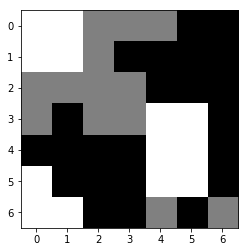

((5, 4), (6, 4)): n_v:  4684 q_all:-0.039892 q:-0.069739 q_m:-0.060000 p:0.295213
((5, 0), (3, 2)): n_v:    84 q_all:-0.086945 q:-0.085134 q_m:-0.040000 p:0.015259
((0, 1), (0, 2)): n_v:    79 q_all:-0.148891 q:-0.141846 q_m:-0.140000 p:0.026684
((0, 0), (0, 2)): n_v:    49 q_all:-0.172826 q:-0.161223 q_m:-0.160000 p:0.019616
((1, 0), (3, 2)): n_v:    31 q_all:-0.094369 q:-0.098623 q_m:-0.040000 p:0.006197
((1, 0), (0, 2)): n_v:    29 q_all:-0.180305 q:-0.164220 q_m:-0.160000 p:0.012374
((3, 4), (3, 3)): n_v:    19 q_all:-0.062730 q:-0.098423 q_m:-0.060000 p:0.002300
((4, 5), (6, 4)): n_v:    17 q_all:-0.144030 q:-0.140448 q_m:-0.080000 p:0.005750
((4, 4), (3, 2)): n_v:    13 q_all:-0.135822 q:-0.136513 q_m:-0.040000 p:0.004079
((5, 4), (3, 2)): n_v:     5 q_all:-0.074999 q:-0.085244 q_m:-0.040000 p:0.000877
((0, 1), (2, 3)): n_v:     3 q_all:-0.075481 q:-0.168282 q_m:-0.080000 p:0.000530
((0, 1), (0, 3)): n_v:     3 q_all:-0.152973 q:-0.163124 q_m:-0.120000 p:0.001205
((4, 4), (6, 4))

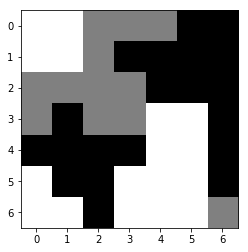

((5, 6), (6, 6)): n_v:  6517 q_all:+0.133943 q:+0.100184 q_m:+0.160000 p:0.169494
((3, 1), (2, 0)): n_v:   597 q_all:+0.060887 q:+0.062402 q_m:+0.160000 p:0.069096
((1, 3), (1, 2)): n_v:   415 q_all:+0.030870 q:+0.035851 q_m:+0.160000 p:0.084508
((4, 6), (6, 6)): n_v:   322 q_all:+0.018960 q:+0.011362 q_m:+0.140000 p:0.076889
((3, 1), (2, 1)): n_v:   309 q_all:+0.053987 q:+0.058201 q_m:+0.160000 p:0.041975
((4, 2), (2, 0)): n_v:   305 q_all:-0.006470 q:+0.024811 q_m:+0.140000 p:0.095140
((4, 3), (2, 1)): n_v:   212 q_all:+0.022488 q:+0.035755 q_m:+0.140000 p:0.048302
((1, 3), (0, 2)): n_v:   174 q_all:+0.035559 q:+0.064879 q_m:+0.160000 p:0.033039
((1, 3), (2, 1)): n_v:   173 q_all:+0.025567 q:+0.066770 q_m:+0.140000 p:0.038017
((2, 4), (3, 3)): n_v:   133 q_all:+0.023941 q:+0.083475 q_m:+0.160000 p:0.029894
((1, 3), (2, 2)): n_v:   110 q_all:+0.021547 q:+0.000497 q_m:+0.120000 p:0.025495
((4, 0), (2, 0)): n_v:    78 q_all:+0.023306 q:+0.029130 q_m:+0.140000 p:0.017528
((4, 0), (2, 1))

((0, 1), (2, 3)): n_v:  4188 q_all:-0.050320 q:-0.154756 q_m:-0.040000 p:0.002393
((1, 0), (3, 0)): n_v:  1651 q_all:-0.108059 q:-0.093728 q_m:-0.040000 p:0.141069
((5, 0), (3, 2)): n_v:  1363 q_all:-0.106191 q:-0.081113 q_m:-0.000000 p:0.115669
((5, 0), (3, 0)): n_v:   981 q_all:-0.147508 q:-0.110508 q_m:-0.040000 p:0.178404
((5, 3), (3, 2)): n_v:   535 q_all:-0.151686 q:-0.076127 q_m:-0.000000 p:0.101583
((3, 4), (3, 2)): n_v:   382 q_all:-0.121089 q:-0.098976 q_m:-0.000000 p:0.044971
((3, 5), (2, 3)): n_v:   333 q_all:-0.071294 q:-0.136472 q_m:-0.040000 p:0.013137
((4, 4), (3, 2)): n_v:   330 q_all:-0.151357 q:-0.104435 q_m:-0.000000 p:0.062440
((1, 1), (3, 0)): n_v:   291 q_all:-0.116119 q:-0.079887 q_m:-0.040000 p:0.030671
((1, 0), (3, 2)): n_v:   240 q_all:-0.138612 q:-0.078651 q_m:-0.000000 p:0.038780
((3, 4), (3, 3)): n_v:   194 q_all:-0.113503 q:-0.069819 q_m:-0.020000 p:0.019229
((1, 0), (0, 2)): n_v:   133 q_all:-0.196627 q:-0.149236 q_m:-0.120000 p:0.036554
((0, 1), (0, 3))

((3, 1), (1, 2)): n_v:  5357 q_all:+0.149686 q:+0.095086 q_m:+0.160000 p:0.001027
((4, 2), (3, 3)): n_v:  3260 q_all:+0.047472 q:+0.174119 q_m:+0.228000 p:0.519667
((4, 1), (3, 3)): n_v:   174 q_all:+0.054483 q:+0.144777 q_m:+0.200000 p:0.023949
((5, 2), (3, 3)): n_v:   116 q_all:+0.057062 q:+0.123147 q_m:+0.200000 p:0.015101
((5, 1), (3, 3)): n_v:    50 q_all:+0.017285 q:+0.096204 q_m:+0.200000 p:0.012777
((5, 5), (3, 3)): n_v:    43 q_all:+0.002896 q:+0.093156 q_m:+0.200000 p:0.012768
((3, 1), (2, 2)): n_v:    37 q_all:+0.046728 q:+0.073154 q_m:+0.180000 p:0.006107
((1, 5), (3, 3)): n_v:    34 q_all:+0.029343 q:+0.141623 q_m:+0.200000 p:0.007183
((0, 5), (0, 4)): n_v:    33 q_all:+0.052389 q:+0.147578 q_m:+0.140000 p:0.004875
((2, 5), (3, 3)): n_v:    27 q_all:-0.012009 q:+0.091589 q_m:+0.200000 p:0.009298
((3, 1), (2, 0)): n_v:     9 q_all:+0.038746 q:+0.074749 q_m:+0.140000 p:0.001793
((3, 1), (2, 1)): n_v:     9 q_all:+0.033664 q:+0.051382 q_m:+0.140000 p:0.001935
((4, 3), (2, 1))

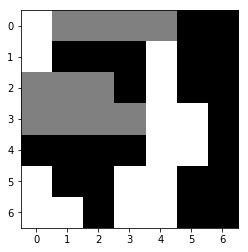

((1, 4), (0, 4)): n_v:  5665 q_all:-0.054323 q:-0.081378 q_m:-0.020000 p:0.071194
((0, 0), (0, 2)): n_v:  2921 q_all:-0.151130 q:-0.179710 q_m:-0.040000 p:0.556403
((1, 0), (0, 2)): n_v:  1312 q_all:-0.155909 q:-0.193016 q_m:-0.040000 p:0.266978
((0, 0), (2, 2)): n_v:   178 q_all:-0.159067 q:-0.139194 q_m:-0.000000 p:0.037887
((2, 4), (0, 2)): n_v:    55 q_all:-0.196516 q:-0.162358 q_m:-0.040000 p:0.016162
((3, 4), (2, 2)): n_v:    49 q_all:-0.115478 q:-0.172938 q_m:-0.000000 p:0.004601
((0, 0), (2, 0)): n_v:    47 q_all:-0.183281 q:-0.209769 q_m:-0.120000 p:0.012768
((1, 0), (2, 2)): n_v:    39 q_all:-0.172569 q:-0.133744 q_m:-0.000000 p:0.009767
((0, 0), (0, 1)): n_v:    20 q_all:-0.134190 q:-0.216911 q_m:-0.060000 p:0.003028
((1, 4), (0, 2)): n_v:    15 q_all:-0.213663 q:-0.317692 q_m:-0.040000 p:0.004786
((4, 4), (2, 2)): n_v:    10 q_all:-0.167987 q:-0.167174 q_m:-0.000000 p:0.002543
((2, 4), (0, 4)): n_v:     5 q_all:-0.147159 q:-0.173823 q_m:-0.040000 p:0.001058
((2, 4), (2, 2))

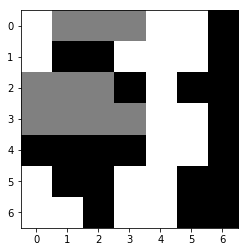

((1, 2), (0, 3)): n_v:  8477 q_all:+0.096961 q:+0.090109 q_m:+0.160000 p:0.635145
((2, 3), (0, 1)): n_v:  1059 q_all:+0.060642 q:+0.055286 q_m:+0.100000 p:0.153946
((2, 5), (0, 3)): n_v:   286 q_all:+0.050843 q:+0.023668 q_m:+0.140000 p:0.047076
((1, 1), (0, 1)): n_v:   283 q_all:+0.106026 q:+0.088297 q_m:+0.120000 p:0.007309
((1, 1), (0, 3)): n_v:   230 q_all:+0.067581 q:+0.093521 q_m:+0.140000 p:0.029674
((2, 3), (3, 3)): n_v:   149 q_all:+0.074073 q:+0.118434 q_m:+0.160000 p:0.017814
((2, 3), (0, 3)): n_v:    94 q_all:+0.038425 q:+0.078854 q_m:+0.140000 p:0.017817
((1, 1), (2, 0)): n_v:    28 q_all:+0.067443 q:+0.043023 q_m:+0.080000 p:0.003508
((2, 3), (2, 1)): n_v:     8 q_all:-0.001908 q:+0.021634 q_m:+0.060000 p:0.002280
((2, 3), (0, 2)): n_v:     4 q_all:-0.016668 q:+0.013326 q_m:+0.060000 p:0.001438
((4, 3), (2, 1)): n_v:     3 q_all:-0.013763 q:-0.040992 q_m:+0.060000 p:0.000956
((2, 5), (3, 3)): n_v:     2 q_all:+0.023336 q:+0.053501 q_m:+0.140000 p:0.000491
((1, 2), (3, 3))

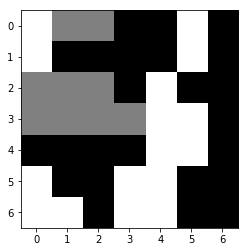

((0, 0), (0, 2)): n_v:  6984 q_all:-0.108940 q:-0.087592 q_m:-0.000000 p:0.756658
((0, 0), (2, 2)): n_v:  4114 q_all:-0.046374 q:-0.186690 q_m:-0.000000 p:0.002325
((1, 0), (0, 2)): n_v:  1738 q_all:-0.116575 q:-0.158781 q_m:-0.000000 p:0.211226
((2, 4), (0, 2)): n_v:    75 q_all:-0.191194 q:-0.260798 q_m:-0.000000 p:0.018374
((1, 0), (2, 2)): n_v:    24 q_all:-0.084845 q:-0.167167 q_m:-0.000000 p:0.001636
((3, 4), (2, 2)): n_v:    17 q_all:-0.091357 q:-0.190398 q_m:-0.000000 p:0.001335
((0, 0), (2, 0)): n_v:     8 q_all:-0.132963 q:-0.275622 q_m:-0.120000 p:0.001347
((2, 4), (3, 3)): n_v:     5 q_all:-0.118705 q:-0.093485 q_m:-0.020000 p:0.000600
((0, 0), (0, 1)): n_v:     4 q_all:-0.291549 q:-0.597864 q_m:-0.060000 p:0.001563
((2, 4), (2, 2)): n_v:     3 q_all:-0.114793 q:-0.145994 q_m:-0.000000 p:0.000358
((4, 4), (2, 2)): n_v:     2 q_all:-0.134717 q:-0.186263 q_m:-0.000000 p:0.000458
((3, 5), (3, 3)): n_v:     1 q_all:-0.096070 q:-0.056596 q_m:-0.040000 p:0.000006
((1, 0), (3, 2))

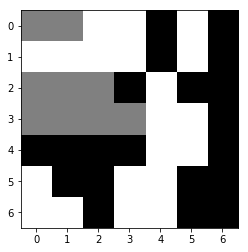

((2, 3), (0, 1)): n_v:  8789 q_all:+0.157093 q:+0.098118 q_m:+0.160000 p:0.873511
((4, 3), (2, 1)): n_v:   248 q_all:+0.085988 q:+0.007094 q_m:+0.120000 p:0.057074
((2, 3), (2, 1)): n_v:    88 q_all:+0.116538 q:+0.055673 q_m:+0.120000 p:0.015406
((2, 3), (2, 2)): n_v:    47 q_all:+0.125213 q:+0.074111 q_m:+0.140000 p:0.007509
((2, 3), (3, 3)): n_v:    39 q_all:+0.134504 q:+0.128549 q_m:+0.140000 p:0.005530
((4, 0), (2, 1)): n_v:    20 q_all:+0.079133 q:+0.013896 q_m:+0.120000 p:0.004940
((0, 4), (2, 2)): n_v:    20 q_all:+0.087030 q:+0.017323 q_m:+0.120000 p:0.004670
((4, 2), (2, 0)): n_v:     8 q_all:+0.057018 q:+0.033202 q_m:+0.080000 p:0.002118
((4, 2), (2, 1)): n_v:     7 q_all:+0.094246 q:+0.006566 q_m:+0.120000 p:0.001640
((1, 4), (2, 2)): n_v:     7 q_all:+0.081794 q:+0.050280 q_m:+0.120000 p:0.001739
((4, 3), (2, 2)): n_v:     4 q_all:+0.105393 q:+0.014950 q_m:+0.120000 p:0.000920
((1, 4), (3, 3)): n_v:     2 q_all:+0.107652 q:+0.116010 q_m:+0.120000 p:0.000471
((2, 5), (3, 3))

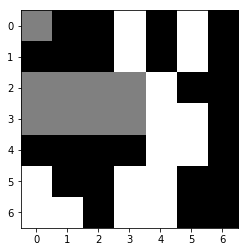

((1, 3), (2, 1)): n_v:  3128 q_all:-0.159488 q:-0.765751 q_m:-0.040000 p:0.442935
((0, 3), (2, 1)): n_v:  2772 q_all:-0.127220 q:-0.477074 q_m:-0.040000 p:0.230797
((1, 3), (3, 1)): n_v:  1310 q_all:-0.084422 q:-0.127387 q_m:-0.040000 p:0.007460
((5, 0), (3, 0)): n_v:   433 q_all:-0.215567 q:-0.168078 q_m:-0.080000 p:0.105128
((1, 3), (2, 2)): n_v:   263 q_all:-0.182732 q:-0.751647 q_m:-0.060000 p:0.048840
((3, 5), (2, 3)): n_v:   231 q_all:-0.091294 q:-0.431404 q_m:-0.080000 p:0.004216
((5, 0), (3, 1)): n_v:   143 q_all:-0.172219 q:-0.082673 q_m:-0.040000 p:0.023500
((3, 4), (2, 2)): n_v:    84 q_all:-0.177884 q:-0.724952 q_m:-0.080000 p:0.014851
((2, 4), (3, 2)): n_v:    70 q_all:-0.112953 q:-0.150547 q_m:-0.040000 p:0.003576
((2, 4), (3, 3)): n_v:    57 q_all:-0.181160 q:-0.095690 q_m:-0.060000 p:0.010098
((1, 3), (2, 3)): n_v:    45 q_all:-0.183521 q:-0.300029 q_m:-0.060000 p:0.008441
((0, 3), (2, 2)): n_v:    39 q_all:-0.217506 q:-0.821065 q_m:-0.080000 p:0.009733
((4, 4), (2, 2))

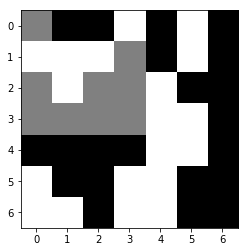

((0, 2), (2, 0)): n_v:  2592 q_all:+0.154358 q:+0.110008 q_m:+0.160000 p:0.460993
((4, 0), (2, 0)): n_v:   807 q_all:+0.147280 q:+0.101619 q_m:+0.160000 p:0.159406
((4, 2), (2, 0)): n_v:   614 q_all:+0.149307 q:+0.103385 q_m:+0.160000 p:0.117587
((0, 1), (2, 0)): n_v:   375 q_all:+0.152330 q:+0.085145 q_m:+0.160000 p:0.068873
((4, 1), (2, 0)): n_v:   176 q_all:+0.136342 q:+0.084193 q_m:+0.160000 p:0.039919
((0, 2), (1, 3)): n_v:   156 q_all:+0.157801 q:+0.085985 q_m:+0.180000 p:0.026311
((0, 2), (2, 2)): n_v:    70 q_all:+0.205250 q:+0.101451 q_m:+0.160000 p:0.002528
((4, 3), (2, 2)): n_v:    68 q_all:+0.107391 q:+0.039577 q_m:+0.160000 p:0.020981
((4, 0), (2, 2)): n_v:    48 q_all:+0.123288 q:+0.067529 q_m:+0.160000 p:0.012777
((4, 2), (3, 3)): n_v:    29 q_all:+0.149162 q:+0.096659 q_m:+0.180000 p:0.005664
((0, 1), (1, 3)): n_v:    26 q_all:+0.163936 q:+0.061810 q_m:+0.160000 p:0.003981
((1, 4), (2, 3)): n_v:    16 q_all:+0.127394 q:+0.094302 q_m:+0.180000 p:0.004082
((0, 4), (2, 2))

((1, 2), (3, 0)): n_v:  1133 q_all:-0.109372 q:-0.183569 q_m:-0.000000 p:0.234087
((5, 0), (3, 0)): n_v:   890 q_all:-0.201808 q:-0.147503 q_m:-0.000000 p:0.405728
((2, 4), (3, 2)): n_v:   799 q_all:-0.036537 q:-0.124921 q_m:-0.000000 p:0.007631
((1, 2), (3, 1)): n_v:   523 q_all:-0.071932 q:-0.064764 q_m:+0.040000 p:0.054765
((5, 0), (3, 1)): n_v:   239 q_all:-0.123495 q:-0.058505 q_m:+0.040000 p:0.058158
((1, 2), (0, 0)): n_v:   201 q_all:-0.239677 q:-0.788757 q_m:-0.040000 p:0.112588
((1, 2), (2, 2)): n_v:   109 q_all:-0.120586 q:-0.393787 q_m:-0.060000 p:0.025908
((1, 2), (3, 2)): n_v:    59 q_all:-0.072041 q:-0.118043 q_m:-0.000000 p:0.005557
((3, 4), (2, 2)): n_v:    51 q_all:-0.103125 q:-0.292516 q_m:-0.080000 p:0.009130
((3, 4), (3, 2)): n_v:    29 q_all:-0.100265 q:-0.152649 q_m:-0.000000 p:0.005066
((5, 0), (3, 2)): n_v:    25 q_all:-0.099729 q:-0.060840 q_m:-0.000000 p:0.004663
((5, 3), (3, 1)): n_v:    21 q_all:-0.108434 q:-0.035303 q_m:+0.040000 p:0.004172
((0, 3), (2, 2))

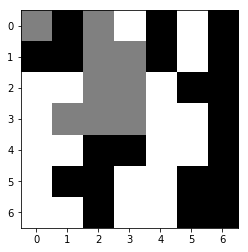

((4, 2), (3, 1)): n_v:  2659 q_all:+0.169893 q:+0.233196 q_m:+0.228000 p:0.338949
((1, 0), (3, 1)): n_v:  1731 q_all:+0.140900 q:+0.196834 q_m:+0.200000 p:0.348475
((1, 1), (3, 1)): n_v:   751 q_all:+0.151493 q:+0.286908 q_m:+0.200000 p:0.130990
((4, 3), (3, 1)): n_v:   521 q_all:+0.164660 q:+0.116426 q_m:+0.200000 p:0.073376
((5, 1), (3, 1)): n_v:   211 q_all:+0.129265 q:+0.067280 q_m:+0.200000 p:0.048967
((4, 2), (3, 3)): n_v:   147 q_all:+0.184365 q:+0.027166 q_m:+0.140000 p:0.013227
((5, 2), (3, 1)): n_v:    53 q_all:+0.117608 q:+0.103262 q_m:+0.200000 p:0.013917
((0, 4), (1, 2)): n_v:     6 q_all:-0.012584 q:+0.000826 q_m:+0.080000 p:0.003593
((0, 1), (1, 2)): n_v:     3 q_all:+0.063263 q:+0.111204 q_m:+0.100000 p:0.001586
((1, 1), (2, 2)): n_v:     3 q_all:+0.016395 q:+0.013771 q_m:+0.060000 p:0.001785
((0, 4), (1, 3)): n_v:     2 q_all:+0.105516 q:+0.019809 q_m:+0.100000 p:0.000739
((0, 1), (0, 0)): n_v:     2 q_all:+0.089020 q:-0.076891 q_m:+0.020000 p:0.000834
((1, 1), (3, 3))

((3, 4), (3, 2)): n_v:  1554 q_all:-0.152902 q:-0.126196 q_m:-0.020000 p:0.176522
((5, 0), (3, 2)): n_v:  1346 q_all:-0.204982 q:-0.087798 q_m:-0.020000 p:0.342886
((2, 4), (3, 2)): n_v:   710 q_all:-0.173878 q:-0.075296 q_m:-0.020000 p:0.120904
((0, 3), (2, 2)): n_v:   484 q_all:-0.117588 q:-0.434960 q_m:-0.100000 p:0.008644
((4, 4), (3, 2)): n_v:   434 q_all:-0.246047 q:-0.255177 q_m:-0.020000 p:0.159159
((0, 3), (1, 2)): n_v:   196 q_all:-0.185379 q:-0.800159 q_m:-0.080000 p:0.039689
((2, 4), (1, 2)): n_v:   183 q_all:-0.184681 q:-0.631892 q_m:-0.100000 p:0.036192
((0, 3), (1, 3)): n_v:   136 q_all:-0.127089 q:-0.879519 q_m:-0.120000 p:0.005810
((5, 3), (3, 2)): n_v:   120 q_all:-0.181882 q:-0.125181 q_m:-0.020000 p:0.022752
((3, 4), (1, 2)): n_v:   119 q_all:-0.191609 q:-0.472638 q_m:-0.100000 p:0.026063
((5, 4), (3, 2)): n_v:    53 q_all:-0.267487 q:-0.122727 q_m:-0.020000 p:0.022297
((3, 4), (2, 2)): n_v:    18 q_all:-0.213406 q:-0.505335 q_m:-0.100000 p:0.005124
((2, 4), (2, 2))

((2, 5), (3, 4)): n_v:  4677 q_all:+0.262802 q:+0.207767 q_m:+0.256000 p:0.432362
((1, 1), (2, 2)): n_v:   278 q_all:+0.103993 q:+0.106194 q_m:+0.160000 p:0.137437
((4, 6), (3, 4)): n_v:   237 q_all:+0.246340 q:+0.050284 q_m:+0.228000 p:0.031367
((4, 0), (2, 2)): n_v:   217 q_all:+0.141021 q:+0.053670 q_m:+0.140000 p:0.087048
((1, 4), (3, 4)): n_v:   118 q_all:+0.278162 q:+0.220573 q_m:+0.228000 p:0.003298
((2, 6), (3, 4)): n_v:   116 q_all:+0.159115 q:+0.081695 q_m:+0.228000 p:0.041311
((5, 2), (3, 4)): n_v:    81 q_all:+0.220908 q:+0.199366 q_m:+0.228000 p:0.016160
((1, 4), (3, 3)): n_v:    67 q_all:+0.238780 q:+0.096898 q_m:+0.228000 p:0.010151
((5, 2), (3, 3)): n_v:    43 q_all:+0.152989 q:+0.044549 q_m:+0.228000 p:0.015996
((0, 4), (2, 2)): n_v:    41 q_all:+0.059002 q:+0.068642 q_m:+0.140000 p:0.024972
((1, 0), (2, 2)): n_v:    39 q_all:+0.079468 q:+0.061408 q_m:+0.140000 p:0.021695
((3, 0), (2, 2)): n_v:    36 q_all:+0.077722 q:+0.062785 q_m:+0.140000 p:0.020475
((1, 4), (2, 3))

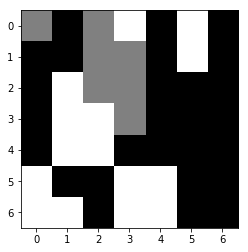

((2, 1), (3, 3)): n_v:  2983 q_all:-0.115452 q:-0.174303 q_m:-0.080000 p:0.016891
((3, 2), (3, 3)): n_v:  2518 q_all:-0.270720 q:-0.141142 q_m:-0.060000 p:0.370730
((1, 5), (3, 3)): n_v:  1249 q_all:-0.234274 q:-0.204491 q_m:-0.080000 p:0.050889
((0, 3), (1, 3)): n_v:   861 q_all:-0.216678 q:-0.429464 q_m:-0.100000 p:0.007919
((3, 1), (1, 3)): n_v:   853 q_all:-0.208604 q:-0.513024 q_m:-0.120000 p:0.003018
((3, 2), (1, 3)): n_v:   468 q_all:-0.215403 q:-0.632496 q_m:-0.120000 p:0.008863
((5, 4), (3, 3)): n_v:   241 q_all:-0.295974 q:-0.167923 q_m:-0.080000 p:0.051723
((4, 1), (3, 3)): n_v:   148 q_all:-0.279046 q:-0.168508 q_m:-0.080000 p:0.024749
((0, 3), (1, 2)): n_v:    36 q_all:-0.323121 q:-0.296519 q_m:-0.140000 p:0.009686
((3, 1), (3, 3)): n_v:    29 q_all:-0.310640 q:-0.214563 q_m:-0.080000 p:0.007335
((2, 1), (0, 0)): n_v:    22 q_all:-0.336215 q:-0.302159 q_m:-0.120000 p:0.006971
((5, 3), (3, 3)): n_v:    12 q_all:-0.290727 q:-0.160855 q_m:-0.080000 p:0.002578
((2, 1), (1, 3))

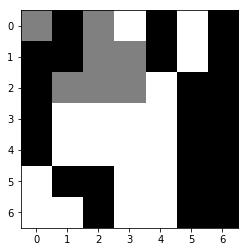

((1, 1), (2, 3)): n_v:  5487 q_all:+0.252258 q:+0.500699 q_m:+0.256000 p:0.008379
((1, 4), (2, 3)): n_v:  1275 q_all:+0.124892 q:+0.458255 q_m:+0.284000 p:0.307204
((1, 1), (2, 2)): n_v:   282 q_all:+0.034118 q:+0.277365 q_m:+0.228000 p:0.138560
((1, 0), (2, 1)): n_v:   168 q_all:+0.106879 q:+0.203571 q_m:+0.180000 p:0.051490
((1, 0), (2, 2)): n_v:   115 q_all:+0.053275 q:+0.223810 q_m:+0.200000 p:0.051595
((0, 1), (2, 3)): n_v:   112 q_all:+0.111050 q:+0.381758 q_m:+0.256000 p:0.032557
((4, 0), (2, 2)): n_v:   106 q_all:+0.034403 q:+0.191073 q_m:+0.200000 p:0.052305
((0, 4), (2, 3)): n_v:   100 q_all:+0.136652 q:+0.290687 q_m:+0.256000 p:0.019965
((0, 1), (0, 2)): n_v:    54 q_all:+0.122928 q:+0.206008 q_m:+0.140000 p:0.013609
((0, 4), (2, 2)): n_v:    45 q_all:-0.001542 q:+0.143425 q_m:+0.200000 p:0.026119
((3, 5), (2, 3)): n_v:    44 q_all:-0.034485 q:+0.227547 q_m:+0.256000 p:0.028518
((3, 0), (2, 2)): n_v:    36 q_all:+0.087869 q:+0.186216 q_m:+0.200000 p:0.013620
((4, 0), (2, 1))

((0, 3), (1, 3)): n_v:  6459 q_all:-0.133132 q:-0.358400 q_m:-0.060000 p:0.191025
((3, 1), (2, 1)): n_v:  2224 q_all:-0.239380 q:-0.196722 q_m:-0.060000 p:0.328682
((3, 1), (1, 3)): n_v:   517 q_all:-0.222237 q:-0.508183 q_m:-0.080000 p:0.052315
((0, 5), (1, 3)): n_v:   236 q_all:-0.276531 q:-0.245057 q_m:-0.080000 p:0.058617
((0, 3), (1, 1)): n_v:   186 q_all:-0.326797 q:-0.273532 q_m:-0.120000 p:0.071574
((3, 1), (2, 2)): n_v:   182 q_all:-0.327258 q:-0.451958 q_m:-0.100000 p:0.074764
((0, 3), (2, 1)): n_v:   162 q_all:-0.260438 q:-0.226125 q_m:-0.080000 p:0.033022
((3, 1), (1, 1)): n_v:   148 q_all:-0.316348 q:-0.258760 q_m:-0.120000 p:0.052696
((4, 2), (2, 1)): n_v:   144 q_all:-0.289365 q:-0.279913 q_m:-0.080000 p:0.040672
((4, 3), (2, 1)): n_v:   126 q_all:-0.322352 q:-0.211123 q_m:-0.080000 p:0.046975
((0, 3), (2, 2)): n_v:    24 q_all:-0.324950 q:-0.435195 q_m:-0.120000 p:0.009334
((4, 1), (2, 1)): n_v:    24 q_all:-0.363581 q:-0.245386 q_m:-0.080000 p:0.011622
((1, 5), (1, 3))

((0, 1), (1, 2)): n_v:  7329 q_all:+0.179109 q:+0.254820 q_m:+0.200000 p:0.473635
((0, 1), (0, 2)): n_v:  1461 q_all:+0.142549 q:+0.351415 q_m:+0.160000 p:0.178997
((3, 2), (1, 2)): n_v:  1033 q_all:+0.187133 q:+0.067179 q_m:+0.180000 p:0.011766
((3, 3), (1, 2)): n_v:   601 q_all:+0.156113 q:+0.113287 q_m:+0.180000 p:0.053263
((1, 0), (1, 2)): n_v:   386 q_all:+0.096613 q:+0.202726 q_m:+0.180000 p:0.084629
((3, 0), (1, 2)): n_v:   136 q_all:+0.117159 q:+0.144283 q_m:+0.180000 p:0.024541
((3, 4), (1, 2)): n_v:    97 q_all:+0.048606 q:+0.110802 q_m:+0.180000 p:0.030170
((2, 0), (1, 2)): n_v:    72 q_all:+0.099837 q:+0.132288 q_m:+0.180000 p:0.015445
((1, 0), (0, 2)): n_v:    38 q_all:+0.102008 q:+0.284089 q_m:+0.140000 p:0.008028
((3, 2), (2, 2)): n_v:    35 q_all:+0.109229 q:+0.286288 q_m:+0.200000 p:0.006878
((0, 1), (1, 1)): n_v:    34 q_all:+0.006430 q:+0.142326 q_m:+0.080000 p:0.013230
((3, 2), (1, 1)): n_v:    32 q_all:+0.012708 q:+0.015289 q_m:+0.060000 p:0.012186
((0, 1), (0, 0))

((3, 1), (2, 1)): n_v:  6733 q_all:-0.046515 q:+0.006842 q_m:+0.020000 p:0.138958
((3, 1), (2, 2)): n_v:  2853 q_all:-0.154722 q:-0.110597 q_m:+0.020000 p:0.307319
((4, 2), (2, 1)): n_v:   920 q_all:-0.228396 q:-0.485123 q_m:-0.000000 p:0.257621
((2, 4), (0, 2)): n_v:   289 q_all:-0.148582 q:-0.270288 q_m:-0.040000 p:0.026908
((4, 3), (2, 2)): n_v:   132 q_all:-0.286356 q:-0.325727 q_m:-0.000000 p:0.055107
((4, 3), (2, 1)): n_v:   120 q_all:-0.259285 q:-0.335673 q_m:-0.000000 p:0.042318
((0, 4), (0, 2)): n_v:   109 q_all:-0.257230 q:-0.410673 q_m:-0.040000 p:0.038156
((0, 4), (2, 2)): n_v:    92 q_all:-0.227411 q:-0.293085 q_m:-0.000000 p:0.025755
((4, 4), (2, 2)): n_v:    78 q_all:-0.187851 q:-0.305091 q_m:-0.000000 p:0.014548
((2, 4), (2, 2)): n_v:    78 q_all:-0.192590 q:-0.159849 q_m:-0.000000 p:0.015497
((4, 1), (2, 1)): n_v:    52 q_all:-0.205569 q:-0.188670 q_m:-0.000000 p:0.011918
((4, 2), (2, 2)): n_v:    49 q_all:-0.293122 q:-0.422770 q_m:-0.000000 p:0.021134
((3, 1), (1, 1))

((1, 3), (2, 2)): n_v:  4046 q_all:+0.166517 q:+0.160379 q_m:+0.160000 p:0.091052
((3, 3), (1, 1)): n_v:  2948 q_all:+0.066192 q:+0.127708 q_m:+0.140000 p:0.236254
((0, 1), (1, 1)): n_v:  2284 q_all:+0.052732 q:+0.344678 q_m:+0.160000 p:0.258028
((0, 1), (2, 2)): n_v:  1324 q_all:+0.102502 q:+0.082561 q_m:+0.140000 p:0.023993
((2, 3), (1, 1)): n_v:   197 q_all:+0.056746 q:+0.163361 q_m:+0.140000 p:0.020242
((1, 3), (1, 1)): n_v:   152 q_all:+0.042651 q:+0.316205 q_m:+0.140000 p:0.021006
((0, 3), (1, 1)): n_v:   107 q_all:+0.017643 q:+0.239257 q_m:+0.140000 p:0.021050
((4, 0), (2, 2)): n_v:    42 q_all:+0.021736 q:+0.043436 q_m:+0.140000 p:0.007870
((0, 3), (2, 2)): n_v:    20 q_all:-0.030064 q:+0.068284 q_m:+0.140000 p:0.006054
((3, 4), (2, 2)): n_v:    16 q_all:-0.042835 q:-0.053033 q_m:+0.140000 p:0.005617
((2, 3), (0, 2)): n_v:     7 q_all:-0.046671 q:-0.098478 q_m:+0.020000 p:0.002648
((0, 1), (0, 2)): n_v:     5 q_all:-0.155484 q:-0.130553 q_m:+0.040000 p:0.003514
((0, 1), (0, 0))

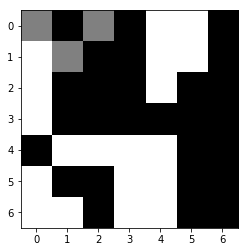

((3, 0), (1, 1)): n_v:  5565 q_all:-0.098274 q:-0.087312 q_m:-0.000000 p:0.043551
((1, 0), (1, 1)): n_v:  1621 q_all:-0.169440 q:+0.058710 q_m:+0.020000 p:0.162833
((1, 0), (0, 2)): n_v:  1329 q_all:-0.155544 q:+0.416351 q_m:-0.000000 p:0.075386
((2, 0), (0, 2)): n_v:   382 q_all:-0.183649 q:+0.134999 q_m:-0.000000 p:0.055452
((0, 4), (0, 2)): n_v:    35 q_all:-0.295147 q:-0.142288 q_m:-0.000000 p:0.015146
((2, 4), (0, 2)): n_v:    11 q_all:-0.199288 q:+0.322789 q_m:-0.000000 p:0.002042
((2, 0), (0, 0)): n_v:     1 q_all:-0.371405 q:-0.412632 q_m:-0.120000 p:0.001018
((1, 0), (0, 0)): n_v:     1 q_all:-0.308280 q:-0.119382 q_m:-0.100000 p:0.000237
((1, 4), (0, 2)): n_v:     1 q_all:-0.190111 q:+0.090971 q_m:-0.000000 p:0.000225
-1 's turn


This is a random move


one move takes time(s):  0.2595250606536865


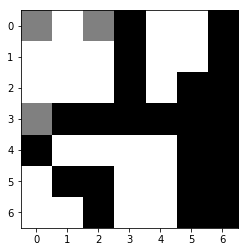

((0, 3), (0, 2)): n_v: 10177 q_all:+0.220697 q:+0.190514 q_m:+0.140000 p:0.440614
((3, 1), (3, 0)): n_v:   356 q_all:+0.033726 q:+0.119351 q_m:+0.140000 p:0.097040
((2, 3), (0, 2)): n_v:    13 q_all:-0.041833 q:+0.008214 q_m:+0.120000 p:0.006571
((5, 2), (3, 0)): n_v:     6 q_all:+0.020225 q:+0.066751 q_m:+0.120000 p:0.002151
((5, 1), (3, 0)): n_v:     2 q_all:-0.034554 q:+0.057993 q_m:+0.120000 p:0.001310
((3, 2), (3, 0)): n_v:     1 q_all:-0.032071 q:+0.033209 q_m:+0.120000 p:0.000735
1 's turn
one move takes time(s):  0.25358128547668457


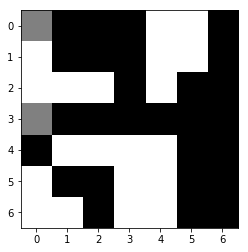

((2, 2), (0, 0)): n_v:  6673 q_all:-0.161104 q:-0.668457 q_m:-0.060000 p:0.006710
((2, 0), (0, 0)): n_v:  3501 q_all:-0.207697 q:-0.090983 q_m:-0.060000 p:0.127041
((2, 0), (3, 0)): n_v:  1110 q_all:-0.278548 q:-0.180517 q_m:-0.040000 p:0.195597
((5, 0), (3, 0)): n_v:  1061 q_all:-0.272089 q:-0.208335 q_m:-0.060000 p:0.174221
((1, 0), (0, 0)): n_v:  1000 q_all:-0.233843 q:-0.152505 q_m:-0.040000 p:0.088350
((2, 1), (0, 0)): n_v:   537 q_all:-0.191579 q:-0.033915 q_m:-0.060000 p:0.002411
((1, 0), (3, 0)): n_v:   457 q_all:-0.229791 q:-0.187362 q_m:-0.060000 p:0.036270
((2, 2), (3, 0)): n_v:   242 q_all:-0.211973 q:-0.270872 q_m:-0.060000 p:0.010894
((4, 2), (3, 0)): n_v:   119 q_all:-0.225260 q:-0.291056 q_m:-0.060000 p:0.008549
-1 's turn
one move takes time(s):  0.23311567306518555


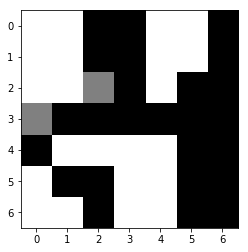

((4, 0), (2, 2)): n_v:  8354 q_all:+0.249949 q:+0.141974 q_m:+0.140000 p:0.005660
((5, 2), (3, 0)): n_v:  1217 q_all:+0.183194 q:+0.285605 q_m:+0.180000 p:0.021238
((3, 1), (3, 0)): n_v:   657 q_all:+0.048293 q:+0.119548 q_m:+0.200000 p:0.226738
((1, 2), (2, 2)): n_v:   568 q_all:+0.163812 q:+0.218030 q_m:+0.160000 p:0.037143
((5, 1), (3, 0)): n_v:   300 q_all:+0.068910 q:-0.258726 q_m:+0.180000 p:0.101009
((1, 2), (3, 0)): n_v:   270 q_all:+0.075018 q:-0.130528 q_m:+0.180000 p:0.076465
((3, 4), (2, 2)): n_v:   161 q_all:+0.178381 q:+0.081564 q_m:+0.140000 p:0.004706
((3, 2), (3, 0)): n_v:   134 q_all:+0.170768 q:-0.016327 q_m:+0.180000 p:0.006263
((0, 3), (2, 2)): n_v:     6 q_all:+0.034315 q:+0.052079 q_m:+0.140000 p:0.002197
((0, 2), (2, 2)): n_v:     0 q_all:+0.093568 q:+0.023920 q_m:+0.140000 p:0.000210
1 's turn
one move takes time(s):  0.2843937873840332


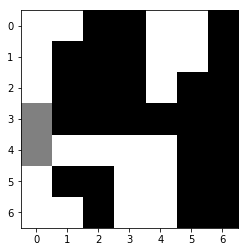

((2, 0), (4, 0)): n_v:  4916 q_all:-0.201897 q:-0.372616 q_m:-0.060000 p:0.015633
((4, 2), (3, 0)): n_v:  3004 q_all:-0.205314 q:-0.449046 q_m:-0.060000 p:0.005640
((5, 0), (3, 0)): n_v:  2773 q_all:-0.288561 q:-0.289135 q_m:-0.060000 p:0.424554
((6, 0), (4, 0)): n_v:  1024 q_all:-0.296381 q:-0.270243 q_m:-0.060000 p:0.170769
((4, 1), (4, 0)): n_v:   756 q_all:-0.228126 q:-0.190869 q_m:-0.040000 p:0.035972
((6, 1), (4, 0)): n_v:   375 q_all:-0.366356 q:-0.391107 q_m:-0.060000 p:0.108206
((1, 0), (3, 0)): n_v:   315 q_all:-0.390997 q:-0.442168 q_m:-0.060000 p:0.104317
((2, 0), (3, 0)): n_v:   176 q_all:-0.277312 q:-0.237415 q_m:-0.040000 p:0.022543
((4, 2), (4, 0)): n_v:     5 q_all:-0.353713 q:-0.387821 q_m:-0.060000 p:0.001075
-1 's turn
one move takes time(s):  0.21938562393188477


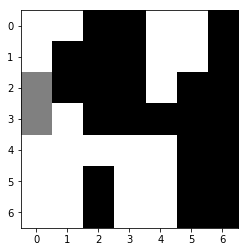

((1, 1), (3, 0)): n_v:  4935 q_all:+0.498558 q:+0.169351 q_m:+0.180000 p:0.097341
((5, 2), (3, 0)): n_v:  3588 q_all:+0.247530 q:+0.246480 q_m:+0.180000 p:0.014348
((1, 1), (2, 0)): n_v:   875 q_all:+0.190389 q:+0.393471 q_m:+0.160000 p:0.135960
((2, 1), (3, 0)): n_v:   439 q_all:-0.004467 q:+0.181513 q_m:+0.200000 p:0.310827
((1, 2), (3, 0)): n_v:    20 q_all:-0.153844 q:-0.401784 q_m:+0.180000 p:0.023053
((0, 2), (2, 0)): n_v:    16 q_all:-0.057611 q:+0.077573 q_m:+0.140000 p:0.013825
((2, 2), (3, 0)): n_v:     5 q_all:+0.038903 q:-0.177310 q_m:+0.180000 p:0.002424
((3, 2), (2, 0)): n_v:     2 q_all:+0.024333 q:+0.042326 q_m:+0.140000 p:0.001754
((1, 2), (2, 0)): n_v:     1 q_all:-0.172963 q:-0.172301 q_m:+0.140000 p:0.000983
((2, 2), (2, 0)): n_v:     1 q_all:-0.177712 q:-0.128459 q_m:+0.140000 p:0.000852
((3, 2), (3, 0)): n_v:     0 q_all:-0.217189 q:-0.481981 q_m:+0.180000 p:0.000582
1 's turn
one move takes time(s):  0.23027253150939941


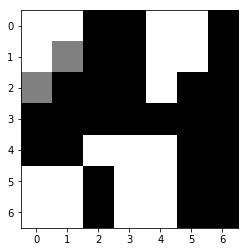

((4, 2), (2, 0)): n_v:  8886 q_all:-0.463867 q:-0.727955 q_m:-0.060000 p:0.006667
((0, 0), (2, 0)): n_v:   531 q_all:-0.870425 q:-0.077071 q_m:-0.060000 p:0.433383
((0, 0), (1, 1)): n_v:   245 q_all:-0.830514 q:+0.120688 q_m:-0.000000 p:0.180571
((0, 1), (2, 0)): n_v:   122 q_all:-0.867428 q:-0.103840 q_m:-0.060000 p:0.098930
((1, 0), (2, 0)): n_v:   119 q_all:-0.764679 q:+0.256723 q_m:-0.040000 p:0.071720
-1 's turn


This is a random move


one move takes time(s):  0.15897536277770996


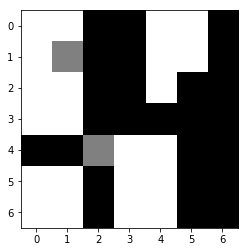

((3, 2), (4, 2)): n_v:  6925 q_all:+0.849091 q:+0.236385 q_m:+0.256000 p:0.145725
((0, 2), (1, 1)): n_v:  5803 q_all:+0.470265 q:+0.563247 q_m:+0.312000 p:0.279745
((3, 2), (1, 1)): n_v:   849 q_all:+0.460889 q:+0.086251 q_m:+0.284000 p:0.057876
((3, 3), (1, 1)): n_v:   234 q_all:+0.420843 q:+0.331155 q_m:+0.284000 p:0.035863
((0, 3), (1, 1)): n_v:    26 q_all:+0.329969 q:+0.299801 q_m:+0.284000 p:0.009122
((1, 3), (1, 1)): n_v:    22 q_all:+0.302820 q:+0.377214 q_m:+0.284000 p:0.009100
((2, 3), (1, 1)): n_v:    12 q_all:+0.295746 q:+0.191807 q_m:+0.284000 p:0.005395
((6, 2), (4, 2)): n_v:    11 q_all:+0.281826 q:+0.040167 q_m:+0.228000 p:0.005132
((2, 2), (4, 2)): n_v:     3 q_all:+0.067171 q:-0.081361 q_m:+0.228000 p:0.003197
((2, 3), (4, 2)): n_v:     1 q_all:+0.107450 q:+0.142588 q_m:+0.228000 p:0.000677
((4, 0), (4, 2)): n_v:     0 q_all:+0.146889 q:+0.025223 q_m:+0.228000 p:0.000550
((3, 4), (4, 2)): n_v:     0 q_all:+0.199184 q:+0.155959 q_m:+0.228000 p:0.000404
1 's turn
one mo

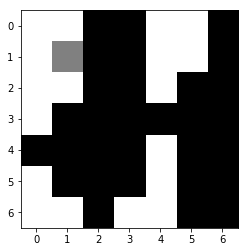

((3, 0), (1, 1)): n_v: 10804 q_all:-0.916602 q:-0.691489 q_m:-0.120000 p:0.083335
((0, 0), (1, 1)): n_v:   928 q_all:-1.000000 q:+5.000000 q_m:-0.100000 p:0.149005
-1 's turn
one move takes time(s):  0.06386661529541016


((3, 1), (3, 0)): n_v: 14130 q_all:+1.000000 q:+5.000000 q_m:+0.228000 p:0.380086
((5, 1), (3, 0)): n_v:     1 q_all:-0.326375 q:+0.445417 q_m:+0.200000 p:0.001346
((3, 2), (3, 0)): n_v:     0 q_all:+0.374353 q:+0.490588 q_m:+0.200000 p:0.000125
((4, 2), (3, 0)): n_v:     0 q_all:+0.133304 q:+0.033259 q_m:+0.200000 p:0.000225
((5, 2), (3, 0)): n_v:     0 q_all:+0.279664 q:+0.332773 q_m:+0.200000 p:0.000234
this self play has 87 steps, time elapsed 147.60323238372803
winner is -1.0
episode 89 finished
episode 90 now start
it seems the reset did nothing
reset successful
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.856842041015625
1 's turn


This is a random move


one move takes time(s):  1.1802551746368408
-1 's turn


This is a random move


one move takes time(s):  1.7740743160247803
1 's turn
one move takes time(s):  1.7630870342254639
-1 's turn
due to rollout lim, final rollout times:  2306 time elapsed:  2.007471799850464




start training, training data no. 13504
Train on 11478 samples, validate on 2026 samples
Epoch 1/64
11478/11478 [==============================] - 2s 135us/step - loss: 1.9681 - activation_101_loss: 1.9348 - dense_51_loss: 0.0061 - val_loss: 2.2981 - val_activation_101_loss: 2.2636 - val_dense_51_loss: 0.0073
Epoch 2/64
11478/11478 [==============================] - 1s 110us/step - loss: 1.9219 - activation_101_loss: 1.8896 - dense_51_loss: 0.0051 - val_loss: 2.2982 - val_activation_101_loss: 2.2631 - val_dense_51_loss: 0.0080
Epoch 3/64
11478/11478 [==============================] - 1s 106us/step - loss: 1.8984 - activation_101_loss: 1.8666 - dense_51_loss: 0.0046 - val_loss: 2.3061 - val_activation_101_loss: 2.2713 - val_dense_51_loss: 0.0076
Epoch 4/64
11478/11478 [==============================] - 1s 105us/step - loss: 1.8831 - activation_101_loss: 1.8518 - dense_51_loss: 0.0041 - val_loss: 2.3017 - val_activation_101_loss: 2.2670 - val_dense_51_loss: 0.0076
Epoch 5/64
11478/11478 



This is a random move


one move takes time(s):  0.9237260818481445
-1 's turn
one move takes time(s):  0.9843344688415527
1 's turn
one move takes time(s):  0.9251227378845215
-1 's turn
one move takes time(s):  0.6876220703125
1 's turn
one move takes time(s):  0.7939839363098145
-1 's turn
one move takes time(s):  0.8450031280517578
1 's turn


This is a random move


one move takes time(s):  0.6214768886566162
-1 's turn


This is a random move


one move takes time(s):  1.1907355785369873
1 's turn
one move takes time(s):  0.9349865913391113
-1 's turn


This is a random move


one move takes time(s):  1.1128382682800293
1 's turn
one move takes time(s):  0.7092859745025635
-1 's turn
one move takes time(s):  0.7673459053039551
1 's turn
one move takes time(s):  0.8845562934875488
-1 's turn
one move takes time(s):  0.6028118133544922
1 's turn
one move takes time(s):  0.604926586151123
-1 's turn
one move takes time(s):  0.6082983016967773
1 's turn
one move takes time(s):  0.3

one move takes time(s):  0.42723655700683594
-1 's turn
one move takes time(s):  0.40081286430358887
1 's turn


This is a random move


one move takes time(s):  0.21277284622192383
-1 's turn


This is a random move


one move takes time(s):  0.24810791015625
1 's turn
one move takes time(s):  0.09429216384887695
-1 's turn
one move takes time(s):  0.0854337215423584
1 's turn


This is a random move


one move takes time(s):  0.06035280227661133
this self play has 80 steps, time elapsed 109.17701029777527
winner is 1.0
episode 92 finished
episode 93 now start
it seems the reset did nothing
reset successful
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.9212260246276855
1 's turn


This is a random move


one move takes time(s):  1.093942403793335
-1 's turn


This is a random move


one move takes time(s):  1.729764461517334
1 's turn


This is a random move


one move takes time(s):  1.7627084255218506
-1 's turn
due to rollout l

due to rollout lim, final rollout times:  2520 time elapsed:  2.0002219676971436
one move takes time(s):  2.001211643218994
-1 's turn
due to rollout lim, final rollout times:  3637 time elapsed:  2.000032663345337
one move takes time(s):  2.0013351440429688
1 's turn
due to rollout lim, final rollout times:  4275 time elapsed:  2.005953788757324
one move takes time(s):  2.0072433948516846
-1 's turn
due to rollout lim, final rollout times:  3782 time elapsed:  2.003268241882324
one move takes time(s):  2.004528284072876
1 's turn
one move takes time(s):  1.132277250289917
-1 's turn
due to rollout lim, final rollout times:  4861 time elapsed:  2.000103235244751
one move takes time(s):  2.001363515853882
1 's turn
one move takes time(s):  1.2545170783996582
-1 's turn
due to rollout lim, final rollout times:  4652 time elapsed:  2.000094413757324
one move takes time(s):  2.001429796218872
1 's turn
one move takes time(s):  1.1221742630004883
-1 's turn
due to rollout lim, final rollout

due to rollout lim, final rollout times:  2052 time elapsed:  2.000372886657715


This is a random move


one move takes time(s):  2.0018811225891113
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.2218422889709473
one move takes time(s):  2.2231101989746094
-1 's turn
due to rollout lim, final rollout times:  3305 time elapsed:  2.0059597492218018
one move takes time(s):  2.0072667598724365
1 's turn
due to rollout lim, final rollout times:  1867 time elapsed:  2.011611223220825
one move takes time(s):  2.012946844100952
-1 's turn
due to rollout lim, final rollout times:  2598 time elapsed:  2.000086545944214
one move takes time(s):  2.001453161239624
1 's turn
due to rollout lim, final rollout times:  1684 time elapsed:  2.002518892288208
one move takes time(s):  2.003772258758545
-1 's turn
due to rollout lim, final rollout times:  3079 time elapsed:  2.004228353500366
one move takes time(s):  2.005507469177246
1 's turn
due to rollout lim, final rollout t

due to rollout lim, final rollout times:  1001 time elapsed:  2.5324625968933105
one move takes time(s):  2.534064292907715
-1 's turn
due to rollout lim, final rollout times:  2190 time elapsed:  2.004403591156006
one move takes time(s):  2.0060839653015137
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.9817137718200684
one move takes time(s):  2.982976198196411
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.347142219543457
one move takes time(s):  2.34911847114563
1 's turn
due to rollout lim, final rollout times:  1067 time elapsed:  2.001321315765381
one move takes time(s):  2.00260853767395
-1 's turn
due to rollout lim, final rollout times:  1501 time elapsed:  2.014678716659546
one move takes time(s):  2.015911102294922
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.2726361751556396
one move takes time(s):  2.2739763259887695
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  

due to rollout lim, final rollout times:  1943 time elapsed:  2.0043554306030273
one move takes time(s):  2.0063858032226562
-1 's turn
due to rollout lim, final rollout times:  4069 time elapsed:  2.000168561935425
one move takes time(s):  2.0014538764953613
1 's turn
one move takes time(s):  1.5661733150482178
-1 's turn
one move takes time(s):  1.3842389583587646
1 's turn
one move takes time(s):  1.2506639957427979
-1 's turn
one move takes time(s):  1.3042738437652588
1 's turn
one move takes time(s):  0.9560682773590088
-1 's turn
one move takes time(s):  0.7973930835723877
1 's turn
one move takes time(s):  1.6104238033294678
-1 's turn
one move takes time(s):  1.9876470565795898
1 's turn


This is a random move


one move takes time(s):  0.8659768104553223
-1 's turn
one move takes time(s):  0.7992777824401855
1 's turn
one move takes time(s):  1.4858670234680176
-1 's turn
one move takes time(s):  1.5519609451293945
1 's turn
one move takes time(s):  1.5716793537139893
-1 's 

Epoch 3/64
12954/12954 [==============================] - 1s 105us/step - loss: 1.9278 - activation_101_loss: 1.8961 - dense_51_loss: 0.0046 - val_loss: 2.2410 - val_activation_101_loss: 2.1993 - val_dense_51_loss: 0.0145
Epoch 4/64
12954/12954 [==============================] - 1s 105us/step - loss: 1.9088 - activation_101_loss: 1.8773 - dense_51_loss: 0.0043 - val_loss: 2.2329 - val_activation_101_loss: 2.1917 - val_dense_51_loss: 0.0141
Epoch 5/64
12954/12954 [==============================] - 1s 108us/step - loss: 1.8933 - activation_101_loss: 1.8622 - dense_51_loss: 0.0040 - val_loss: 2.2388 - val_activation_101_loss: 2.1967 - val_dense_51_loss: 0.0149
Epoch 6/64
12954/12954 [==============================] - 1s 110us/step - loss: 1.8817 - activation_101_loss: 1.8508 - dense_51_loss: 0.0038 - val_loss: 2.2404 - val_activation_101_loss: 2.1991 - val_dense_51_loss: 0.0142
Epoch 7/64
12954/12954 [==============================] - 1s 107us/step - loss: 1.8725 - activation_101_loss: 1.

due to rollout lim, final rollout times:  3896 time elapsed:  2.0000674724578857
one move takes time(s):  2.001349925994873
1 's turn
one move takes time(s):  1.761481761932373
-1 's turn
one move takes time(s):  1.504849910736084
1 's turn


This is a random move


one move takes time(s):  0.7607381343841553
-1 's turn


This is a random move


one move takes time(s):  0.7534966468811035
1 's turn


This is a random move


one move takes time(s):  0.952134370803833
-1 's turn


This is a random move


one move takes time(s):  1.1230053901672363
1 's turn
one move takes time(s):  0.8745300769805908
-1 's turn


This is a random move


one move takes time(s):  0.8197987079620361
1 's turn
one move takes time(s):  0.6537587642669678
-1 's turn
one move takes time(s):  0.5789289474487305
1 's turn
one move takes time(s):  0.5693492889404297
-1 's turn


This is a random move


one move takes time(s):  0.7856860160827637
1 's turn
one move takes time(s):  0.4424276351928711
-1 's turn


Th

due to rollout lim, final rollout times:  2939 time elapsed:  2.002720355987549
one move takes time(s):  2.004434823989868
-1 's turn
due to rollout lim, final rollout times:  1754 time elapsed:  2.0001327991485596
one move takes time(s):  2.0019679069519043
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.583317995071411
one move takes time(s):  2.5846478939056396
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.394319772720337


This is a random move


one move takes time(s):  2.3956127166748047
1 's turn
due to rollout lim, final rollout times:  2674 time elapsed:  2.000089406967163
one move takes time(s):  2.0013771057128906
-1 's turn
due to rollout lim, final rollout times:  1671 time elapsed:  2.0001070499420166
one move takes time(s):  2.001366138458252
1 's turn


This is a random move


one move takes time(s):  1.493037462234497
-1 's turn
one move takes time(s):  1.0058114528656006
1 's turn
one move takes time(s):  0.798339

due to rollout lim, final rollout times:  4702 time elapsed:  2.0000176429748535
one move takes time(s):  2.0012669563293457
-1 's turn
one move takes time(s):  1.9833920001983643
1 's turn
due to rollout lim, final rollout times:  3764 time elapsed:  2.0000836849212646
one move takes time(s):  2.0018482208251953
-1 's turn
one move takes time(s):  1.8609941005706787
1 's turn


This is a random move


one move takes time(s):  1.6235888004302979
-1 's turn
one move takes time(s):  1.205862283706665
1 's turn
one move takes time(s):  0.6679716110229492
-1 's turn
one move takes time(s):  0.7325820922851562
1 's turn


This is a random move


one move takes time(s):  0.5215914249420166
-1 's turn
one move takes time(s):  0.5859541893005371
1 's turn
one move takes time(s):  0.4485042095184326
-1 's turn
one move takes time(s):  0.45905256271362305
1 's turn
one move takes time(s):  0.41037416458129883
-1 's turn


This is a random move


one move takes time(s):  0.3545193672180176
1 's t

one move takes time(s):  0.7064831256866455
1 's turn
one move takes time(s):  0.4111015796661377
-1 's turn


This is a random move


one move takes time(s):  0.39813828468322754
1 's turn
one move takes time(s):  0.3489696979522705
-1 's turn
one move takes time(s):  0.44635510444641113
1 's turn
one move takes time(s):  0.5704078674316406
-1 's turn


This is a random move


one move takes time(s):  0.2804865837097168
1 's turn
one move takes time(s):  0.2543375492095947
-1 's turn
one move takes time(s):  0.20244431495666504
1 's turn
one move takes time(s):  0.18312430381774902
-1 's turn
one move takes time(s):  0.21442627906799316
1 's turn
one move takes time(s):  0.1506195068359375
-1 's turn
one move takes time(s):  0.13110613822937012
1 's turn
one move takes time(s):  0.13868951797485352
-1 's turn


This is a random move


one move takes time(s):  0.06055617332458496
this self play has 73 steps, time elapsed 110.00002646446228
winner is -1.0
episode 100 finished
episode 10

due to rollout lim, final rollout times:  2370 time elapsed:  2.0073978900909424
one move takes time(s):  2.00870418548584
1 's turn
one move takes time(s):  1.7329156398773193
-1 's turn
one move takes time(s):  1.5921578407287598
1 's turn
one move takes time(s):  1.1387948989868164
-1 's turn
one move takes time(s):  1.647517204284668
1 's turn
one move takes time(s):  1.397458791732788
-1 's turn
one move takes time(s):  1.1691455841064453
1 's turn
due to rollout lim, final rollout times:  3995 time elapsed:  2.0045669078826904
one move takes time(s):  2.005875825881958
-1 's turn
due to rollout lim, final rollout times:  1879 time elapsed:  2.0043201446533203
one move takes time(s):  2.005934953689575
1 's turn
due to rollout lim, final rollout times:  2912 time elapsed:  2.000171184539795
one move takes time(s):  2.001422166824341
-1 's turn
due to rollout lim, final rollout times:  1583 time elapsed:  2.003469467163086
one move takes time(s):  2.004699945449829
1 's turn
due to

due to rollout lim, final rollout times:  1522 time elapsed:  2.0005178451538086
one move takes time(s):  2.001833438873291
1 's turn


This is a random move


one move takes time(s):  1.7587096691131592
-1 's turn
one move takes time(s):  1.2348427772521973
1 's turn
due to rollout lim, final rollout times:  3357 time elapsed:  2.0000176429748535
one move takes time(s):  2.001368284225464
-1 's turn
one move takes time(s):  1.895946979522705
1 's turn
one move takes time(s):  0.83522629737854
-1 's turn
one move takes time(s):  0.7376070022583008
1 's turn
one move takes time(s):  1.2219903469085693
-1 's turn
one move takes time(s):  1.245962142944336
1 's turn
one move takes time(s):  0.620011568069458
-1 's turn
one move takes time(s):  0.627288818359375
1 's turn
one move takes time(s):  0.970038890838623
-1 's turn
one move takes time(s):  0.7541484832763672
1 's turn
one move takes time(s):  0.6885850429534912
-1 's turn
one move takes time(s):  0.6251530647277832
1 's turn
one 

Epoch 7/64
8343/8343 [==============================] - 1s 105us/step - loss: 1.8881 - activation_101_loss: 1.8577 - dense_51_loss: 0.0033 - val_loss: 2.2146 - val_activation_101_loss: 2.1786 - val_dense_51_loss: 0.0089
Epoch 8/64
8343/8343 [==============================] - 1s 113us/step - loss: 1.8781 - activation_101_loss: 1.8479 - dense_51_loss: 0.0031 - val_loss: 2.2121 - val_activation_101_loss: 2.1775 - val_dense_51_loss: 0.0075
Epoch 9/64
8343/8343 [==============================] - 1s 103us/step - loss: 1.8709 - activation_101_loss: 1.8408 - dense_51_loss: 0.0030 - val_loss: 2.2106 - val_activation_101_loss: 2.1759 - val_dense_51_loss: 0.0076
Epoch 10/64
8343/8343 [==============================] - 1s 104us/step - loss: 1.8643 - activation_101_loss: 1.8343 - dense_51_loss: 0.0028 - val_loss: 2.2085 - val_activation_101_loss: 2.1734 - val_dense_51_loss: 0.0080
Epoch 11/64
8343/8343 [==============================] - 1s 105us/step - loss: 1.8585 - activation_101_loss: 1.8286 - d

due to rollout lim, final rollout times:  1285 time elapsed:  2.0027384757995605
one move takes time(s):  2.003933906555176
1 's turn
due to rollout lim, final rollout times:  2648 time elapsed:  2.0063352584838867
one move takes time(s):  2.0074613094329834
-1 's turn
due to time lim, final rollout times:  1694 time elapsed:  683.0351254940033


This is a random move


one move takes time(s):  683.0733170509338
1 's turn
due to rollout lim, final rollout times:  1228 time elapsed:  2.0001401901245117


This is a random move


one move takes time(s):  2.0025711059570312
-1 's turn
due to rollout lim, final rollout times:  4231 time elapsed:  2.0198099613189697


This is a random move


one move takes time(s):  2.0216007232666016
1 's turn
one move takes time(s):  1.2236592769622803
-1 's turn
due to rollout lim, final rollout times:  3730 time elapsed:  2.0129308700561523


This is a random move


one move takes time(s):  2.014549493789673
1 's turn
due to rollout lim, final rollout ti

due to rollout lim, final rollout times:  2635 time elapsed:  2.009030818939209
one move takes time(s):  2.0102427005767822
1 's turn
due to rollout lim, final rollout times:  3014 time elapsed:  2.005208730697632
one move takes time(s):  2.0064854621887207
-1 's turn
due to rollout lim, final rollout times:  2023 time elapsed:  2.005906581878662
one move takes time(s):  2.007185935974121
1 's turn
due to rollout lim, final rollout times:  1797 time elapsed:  2.013308525085449
one move takes time(s):  2.0145912170410156
-1 's turn
due to rollout lim, final rollout times:  2175 time elapsed:  2.001972198486328
one move takes time(s):  2.0031895637512207
1 's turn
due to rollout lim, final rollout times:  2346 time elapsed:  2.0150563716888428
one move takes time(s):  2.0169622898101807
-1 's turn
one move takes time(s):  1.2041964530944824
1 's turn
one move takes time(s):  1.2015221118927002
-1 's turn
one move takes time(s):  1.297428846359253
1 's turn
one move takes time(s):  1.0489

one move takes time(s):  1.2501099109649658
-1 's turn
one move takes time(s):  1.4799387454986572
1 's turn
one move takes time(s):  0.9813456535339355
-1 's turn
one move takes time(s):  0.7466437816619873
1 's turn
one move takes time(s):  0.7231261730194092
-1 's turn
one move takes time(s):  0.7529959678649902
1 's turn
one move takes time(s):  0.7865340709686279
-1 's turn
one move takes time(s):  0.8401544094085693
1 's turn
one move takes time(s):  0.9163966178894043
-1 's turn
one move takes time(s):  0.5651671886444092
1 's turn
one move takes time(s):  0.6839556694030762
-1 's turn
one move takes time(s):  0.5409409999847412
1 's turn
one move takes time(s):  0.6803116798400879
-1 's turn
one move takes time(s):  0.5097477436065674
1 's turn
one move takes time(s):  0.46543383598327637
-1 's turn
one move takes time(s):  0.5283384323120117
1 's turn
one move takes time(s):  0.47756242752075195
-1 's turn
one move takes time(s):  0.35571789741516113
1 's turn
one move takes t

one move takes time(s):  0.3932936191558838
-1 's turn
one move takes time(s):  0.5254380702972412
1 's turn
one move takes time(s):  0.3150770664215088
-1 's turn
one move takes time(s):  0.3752400875091553
1 's turn
one move takes time(s):  0.3529515266418457
-1 's turn
one move takes time(s):  0.2551689147949219
1 's turn
one move takes time(s):  0.28181934356689453
-1 's turn


This is a random move


one move takes time(s):  0.2639036178588867
1 's turn
one move takes time(s):  0.24829363822937012
-1 's turn
one move takes time(s):  0.2692139148712158
1 's turn
one move takes time(s):  0.22979378700256348
-1 's turn
one move takes time(s):  0.16999387741088867
1 's turn
one move takes time(s):  0.13596773147583008
-1 's turn
one move takes time(s):  0.0856781005859375
this self play has 71 steps, time elapsed 101.00007390975952
winner is -1.0
episode 106 finished
episode 107 now start
it seems the reset did nothing
reset successful
left space is 45
start new self play
-1 's turn



one move takes time(s):  1.8659100532531738
-1 's turn
one move takes time(s):  1.0466349124908447
1 's turn


This is a random move


one move takes time(s):  1.023691177368164
-1 's turn


This is a random move


one move takes time(s):  0.9813501834869385
1 's turn
one move takes time(s):  0.9041743278503418
-1 's turn


This is a random move


one move takes time(s):  0.6789801120758057
1 's turn
one move takes time(s):  0.8317098617553711
-1 's turn
one move takes time(s):  0.6346879005432129
1 's turn
one move takes time(s):  0.563359260559082
-1 's turn
one move takes time(s):  0.6766624450683594
1 's turn
one move takes time(s):  0.6922900676727295
-1 's turn
one move takes time(s):  0.6559159755706787
1 's turn
one move takes time(s):  0.6166121959686279
-1 's turn
one move takes time(s):  0.4034745693206787
1 's turn
one move takes time(s):  0.6080296039581299
-1 's turn
one move takes time(s):  0.4594857692718506
1 's turn
one move takes time(s):  0.43698763847351074
-1 's t

12287/12287 [==============================] - 2s 137us/step - loss: 2.1367 - activation_101_loss: 2.1006 - dense_51_loss: 0.0091 - val_loss: 2.4107 - val_activation_101_loss: 2.3685 - val_dense_51_loss: 0.0150
Epoch 2/64
12287/12287 [==============================] - 1s 113us/step - loss: 2.0663 - activation_101_loss: 2.0322 - dense_51_loss: 0.0070 - val_loss: 2.4051 - val_activation_101_loss: 2.3621 - val_dense_51_loss: 0.0160
Epoch 3/64
12287/12287 [==============================] - 1s 105us/step - loss: 2.0276 - activation_101_loss: 1.9948 - dense_51_loss: 0.0057 - val_loss: 2.3963 - val_activation_101_loss: 2.3539 - val_dense_51_loss: 0.0153
Epoch 4/64
12287/12287 [==============================] - 1s 103us/step - loss: 2.0022 - activation_101_loss: 1.9701 - dense_51_loss: 0.0051 - val_loss: 2.3977 - val_activation_101_loss: 2.3538 - val_dense_51_loss: 0.0168
Epoch 5/64
12287/12287 [==============================] - 1s 108us/step - loss: 1.9832 - activation_101_loss: 1.9515 - dens

due to rollout lim, final rollout times:  1422 time elapsed:  2.0037262439727783


This is a random move


one move takes time(s):  2.005661725997925
-1 's turn
due to rollout lim, final rollout times:  1687 time elapsed:  2.012117385864258
one move takes time(s):  2.013427495956421
1 's turn
due to rollout lim, final rollout times:  1405 time elapsed:  2.011718511581421
one move takes time(s):  2.0128443241119385
-1 's turn
due to rollout lim, final rollout times:  1740 time elapsed:  2.0063843727111816
one move takes time(s):  2.0075109004974365
1 's turn
due to rollout lim, final rollout times:  2312 time elapsed:  2.005614757537842
one move takes time(s):  2.006636619567871
-1 's turn
due to rollout lim, final rollout times:  1023 time elapsed:  2.0071144104003906
one move takes time(s):  2.008749485015869
1 's turn
due to rollout lim, final rollout times:  2334 time elapsed:  2.000091075897217
one move takes time(s):  2.0011444091796875
-1 's turn
due to rollout lim, final rollout

due to rollout lim, final rollout times:  4321 time elapsed:  2.007722854614258
one move takes time(s):  2.008939027786255
1 's turn
one move takes time(s):  1.8372812271118164
-1 's turn
one move takes time(s):  0.9744212627410889
1 's turn
one move takes time(s):  1.029855728149414
-1 's turn
one move takes time(s):  0.9094445705413818
1 's turn
one move takes time(s):  0.8554677963256836
-1 's turn
one move takes time(s):  1.275465488433838
1 's turn
one move takes time(s):  1.4417860507965088
-1 's turn
one move takes time(s):  0.9655425548553467
1 's turn


This is a random move


one move takes time(s):  0.9958534240722656
-1 's turn
one move takes time(s):  1.0033032894134521
1 's turn
one move takes time(s):  1.07737398147583
-1 's turn
one move takes time(s):  1.0127942562103271
1 's turn
one move takes time(s):  1.0412259101867676
-1 's turn
one move takes time(s):  0.6308748722076416
1 's turn
one move takes time(s):  0.7876377105712891
-1 's turn


This is a random move


o



This is a random move


one move takes time(s):  0.9532425403594971
1 's turn
one move takes time(s):  1.214376449584961
-1 's turn


This is a random move


one move takes time(s):  1.7884843349456787
1 's turn
due to rollout lim, final rollout times:  1929 time elapsed:  2.0037877559661865
one move takes time(s):  2.004798650741577
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.1151483058929443


This is a random move


one move takes time(s):  2.116199493408203
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.068021774291992
one move takes time(s):  2.069268226623535
-1 's turn
one move takes time(s):  1.7191569805145264
1 's turn
due to rollout lim, final rollout times:  1298 time elapsed:  2.0095815658569336
one move takes time(s):  2.010751485824585
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.2359466552734375


This is a random move


one move takes time(s):  3.2375905513763428
1 's turn
due to 

one move takes time(s):  0.38541173934936523
-1 's turn
one move takes time(s):  0.27764415740966797
1 's turn
one move takes time(s):  0.3162517547607422
-1 's turn
one move takes time(s):  0.23510193824768066
1 's turn
one move takes time(s):  0.33844923973083496
-1 's turn
one move takes time(s):  0.18516111373901367
1 's turn
one move takes time(s):  0.2247915267944336
-1 's turn
one move takes time(s):  0.19762063026428223
1 's turn
one move takes time(s):  0.2279658317565918
-1 's turn
one move takes time(s):  0.13808178901672363
1 's turn
one move takes time(s):  0.11389422416687012
-1 's turn


This is a random move


one move takes time(s):  0.09965085983276367
this self play has 83 steps, time elapsed 164.3590772151947
winner is -1.0
episode 112 finished
episode 113 now start
it seems the reset did nothing
reset successful
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.930570125579834
1 's turn


This is a random move


on

one move takes time(s):  1.864626169204712
-1 's turn
one move takes time(s):  1.6995952129364014
1 's turn
due to rollout lim, final rollout times:  2413 time elapsed:  2.000023365020752
one move takes time(s):  2.0017452239990234
-1 's turn
due to rollout lim, final rollout times:  3296 time elapsed:  2.0011651515960693
one move takes time(s):  2.002380132675171
1 's turn


This is a random move


one move takes time(s):  1.5944373607635498
-1 's turn
due to rollout lim, final rollout times:  4794 time elapsed:  2.0018935203552246
one move takes time(s):  2.0031275749206543
1 's turn
one move takes time(s):  1.6533665657043457
-1 's turn
one move takes time(s):  1.8779184818267822
1 's turn
due to rollout lim, final rollout times:  3408 time elapsed:  2.0100717544555664


This is a random move


one move takes time(s):  2.011413097381592
-1 's turn
due to rollout lim, final rollout times:  3263 time elapsed:  2.008251428604126
one move takes time(s):  2.009498357772827
1 's turn
due 

Epoch 1/64
14368/14368 [==============================] - 2s 139us/step - loss: 1.9771 - activation_101_loss: 1.9457 - dense_51_loss: 0.0042 - val_loss: 2.0903 - val_activation_101_loss: 2.0574 - val_dense_51_loss: 0.0058
Epoch 2/64
14368/14368 [==============================] - 2s 114us/step - loss: 1.9319 - activation_101_loss: 1.9011 - dense_51_loss: 0.0038 - val_loss: 2.0842 - val_activation_101_loss: 2.0510 - val_dense_51_loss: 0.0061
Epoch 3/64
14368/14368 [==============================] - 2s 108us/step - loss: 1.9065 - activation_101_loss: 1.8760 - dense_51_loss: 0.0034 - val_loss: 2.0710 - val_activation_101_loss: 2.0380 - val_dense_51_loss: 0.0059
Epoch 4/64
14368/14368 [==============================] - 2s 106us/step - loss: 1.8887 - activation_101_loss: 1.8584 - dense_51_loss: 0.0032 - val_loss: 2.0578 - val_activation_101_loss: 2.0249 - val_dense_51_loss: 0.0058
Epoch 5/64
14368/14368 [==============================] - 2s 107us/step - loss: 1.8736 - activation_101_loss: 1.

due to rollout lim, final rollout times:  1219 time elapsed:  2.007380247116089
one move takes time(s):  2.009159803390503
-1 's turn
due to rollout lim, final rollout times:  3559 time elapsed:  2.0042600631713867
one move takes time(s):  2.005496025085449
1 's turn
due to rollout lim, final rollout times:  2792 time elapsed:  2.0106093883514404


This is a random move


one move takes time(s):  2.012221574783325
-1 's turn
due to rollout lim, final rollout times:  2552 time elapsed:  2.0161960124969482
one move takes time(s):  2.017449378967285
1 's turn
due to rollout lim, final rollout times:  3560 time elapsed:  2.0083420276641846
one move takes time(s):  2.0096306800842285
-1 's turn
due to rollout lim, final rollout times:  4014 time elapsed:  2.003148317337036


This is a random move


one move takes time(s):  2.0046274662017822
1 's turn
due to rollout lim, final rollout times:  1419 time elapsed:  2.0040342807769775
one move takes time(s):  2.0052239894866943
-1 's turn
due t



This is a random move


one move takes time(s):  1.1427557468414307
-1 's turn
due to rollout lim, final rollout times:  4777 time elapsed:  2.00300669670105
one move takes time(s):  2.0042266845703125
1 's turn
due to rollout lim, final rollout times:  4831 time elapsed:  2.0054290294647217
one move takes time(s):  2.0065417289733887
-1 's turn
one move takes time(s):  1.1255464553833008
1 's turn


This is a random move


one move takes time(s):  1.6714215278625488
-1 's turn
due to rollout lim, final rollout times:  4862 time elapsed:  2.0000290870666504
one move takes time(s):  2.001234769821167
1 's turn


This is a random move


one move takes time(s):  1.3241043090820312
-1 's turn
one move takes time(s):  0.9961638450622559
1 's turn
one move takes time(s):  1.0295286178588867
-1 's turn
one move takes time(s):  1.5461149215698242
1 's turn
one move takes time(s):  1.018606185913086
-1 's turn
one move takes time(s):  1.1621477603912354
1 's turn


This is a random move


one

one move takes time(s):  0.5232949256896973
1 's turn


This is a random move


one move takes time(s):  0.5396914482116699
-1 's turn
one move takes time(s):  0.430833101272583
1 's turn


This is a random move


one move takes time(s):  0.4424295425415039
-1 's turn
one move takes time(s):  0.3970775604248047
1 's turn


This is a random move


one move takes time(s):  0.40561866760253906
-1 's turn
one move takes time(s):  0.41283750534057617
1 's turn


This is a random move


one move takes time(s):  0.3306913375854492
-1 's turn
one move takes time(s):  0.29128336906433105
1 's turn


This is a random move


one move takes time(s):  0.29035019874572754
-1 's turn
one move takes time(s):  0.31702589988708496
1 's turn


This is a random move


one move takes time(s):  0.20449233055114746
-1 's turn
one move takes time(s):  0.22118496894836426
1 's turn
one move takes time(s):  0.2213611602783203
-1 's turn
one move takes time(s):  0.2946593761444092
1 's turn


This is a random mo

one move takes time(s):  1.7290127277374268
1 's turn
one move takes time(s):  0.7594220638275146
-1 's turn


This is a random move


one move takes time(s):  0.7773892879486084
1 's turn
one move takes time(s):  0.563539981842041
-1 's turn
one move takes time(s):  0.6767416000366211
1 's turn


This is a random move


one move takes time(s):  0.5815434455871582
-1 's turn
one move takes time(s):  1.1856608390808105
1 's turn


This is a random move


one move takes time(s):  0.5457189083099365
-1 's turn
one move takes time(s):  0.4322695732116699
1 's turn
one move takes time(s):  0.40842700004577637
-1 's turn
one move takes time(s):  0.35579657554626465
1 's turn
one move takes time(s):  0.31418681144714355
-1 's turn
one move takes time(s):  0.41715359687805176
1 's turn
one move takes time(s):  0.5161182880401611
-1 's turn
one move takes time(s):  0.452747106552124
1 's turn
one move takes time(s):  0.338289737701416
-1 's turn
one move takes time(s):  0.32891225814819336
1 's

one move takes time(s):  1.3498151302337646
-1 's turn
one move takes time(s):  0.9421467781066895
1 's turn
one move takes time(s):  0.9834814071655273
-1 's turn
one move takes time(s):  1.8522546291351318
1 's turn
one move takes time(s):  1.660973310470581
-1 's turn
one move takes time(s):  1.6148815155029297
1 's turn
due to rollout lim, final rollout times:  4695 time elapsed:  2.0002753734588623
one move takes time(s):  2.0023694038391113
-1 's turn
one move takes time(s):  1.9997787475585938
1 's turn
one move takes time(s):  1.8362042903900146
-1 's turn
one move takes time(s):  1.0237534046173096
1 's turn
one move takes time(s):  1.4704129695892334
-1 's turn
one move takes time(s):  1.1436336040496826
1 's turn
one move takes time(s):  0.6996965408325195
-1 's turn
one move takes time(s):  0.9581508636474609
1 's turn


This is a random move


one move takes time(s):  0.6704881191253662
-1 's turn
one move takes time(s):  0.8179876804351807
1 's turn
one move takes time(s)

one move takes time(s):  1.2214455604553223
-1 's turn
one move takes time(s):  1.083237648010254
1 's turn
one move takes time(s):  1.452589511871338
-1 's turn
due to rollout lim, final rollout times:  4502 time elapsed:  2.004318952560425
one move takes time(s):  2.00555157661438
1 's turn
one move takes time(s):  1.5247931480407715
-1 's turn
one move takes time(s):  1.4300477504730225
1 's turn
one move takes time(s):  1.0544781684875488
-1 's turn


This is a random move


one move takes time(s):  0.7829477787017822
1 's turn
one move takes time(s):  1.3702850341796875
-1 's turn
one move takes time(s):  1.0309600830078125
1 's turn
one move takes time(s):  0.6760952472686768
-1 's turn
one move takes time(s):  0.6064553260803223
1 's turn
one move takes time(s):  0.7847151756286621
-1 's turn
one move takes time(s):  0.9429302215576172
1 's turn
one move takes time(s):  0.5901877880096436
-1 's turn
one move takes time(s):  0.4786555767059326
1 's turn
one move takes time(s):  0

5895/5895 [==============================] - 1s 104us/step - loss: 1.8398 - activation_101_loss: 1.8090 - dense_51_loss: 0.0037 - val_loss: 2.0648 - val_activation_101_loss: 2.0171 - val_dense_51_loss: 0.0206
Epoch 8/64
5895/5895 [==============================] - 1s 104us/step - loss: 1.8299 - activation_101_loss: 1.7994 - dense_51_loss: 0.0034 - val_loss: 2.0668 - val_activation_101_loss: 2.0206 - val_dense_51_loss: 0.0191
Epoch 9/64
5895/5895 [==============================] - 1s 105us/step - loss: 1.8230 - activation_101_loss: 1.7927 - dense_51_loss: 0.0033 - val_loss: 2.0655 - val_activation_101_loss: 2.0174 - val_dense_51_loss: 0.0209
Epoch 10/64
5895/5895 [==============================] - 1s 106us/step - loss: 1.8146 - activation_101_loss: 1.7845 - dense_51_loss: 0.0030 - val_loss: 2.0563 - val_activation_101_loss: 2.0101 - val_dense_51_loss: 0.0190
Epoch 11/64
5895/5895 [==============================] - 1s 104us/step - loss: 1.8089 - activation_101_loss: 1.7789 - dense_51_los

this round has steps: 59, time taken: 2.4439401626586914, 


self wins? True



round: 31
it seems the reset did nothing
reset successful
this game start with 45 space left
this round has steps: 64, time taken: 2.602449893951416, 


self wins? True



round: 32
it seems the reset did nothing
reset successful
this game start with 45 space left
this round has steps: 64, time taken: 2.512525796890259, 


self wins? True



round: 33
it seems the reset did nothing
reset successful
this game start with 45 space left
this round has steps: 62, time taken: 2.694861650466919, 


self wins? True



round: 34
it seems the reset did nothing
reset successful
this game start with 45 space left
this round has steps: 64, time taken: 2.6645538806915283, 


self wins? True



round: 35
it seems the reset did nothing
reset successful
this game start with 45 space left
this round has steps: 62, time taken: 2.1832382678985596, 


self wins? True



round: 36
it seems the reset did nothing
reset successful


one move takes time(s):  1.474391222000122
-1 's turn
one move takes time(s):  1.716606616973877
1 's turn
one move takes time(s):  0.9463589191436768
-1 's turn
one move takes time(s):  0.7474868297576904
1 's turn
one move takes time(s):  1.1639208793640137
-1 's turn
one move takes time(s):  0.8038947582244873
1 's turn


This is a random move


one move takes time(s):  0.8097474575042725
-1 's turn
one move takes time(s):  0.8454310894012451
1 's turn


This is a random move


one move takes time(s):  1.1244888305664062
-1 's turn


This is a random move


one move takes time(s):  0.8873674869537354
1 's turn
one move takes time(s):  1.1762568950653076
-1 's turn
one move takes time(s):  0.4854011535644531
1 's turn
one move takes time(s):  0.39208173751831055
-1 's turn
one move takes time(s):  0.3859684467315674
1 's turn
one move takes time(s):  0.6825802326202393
-1 's turn
one move takes time(s):  0.3805959224700928
1 's turn
one move takes time(s):  0.311877965927124
-1 's tu

one move takes time(s):  0.5359454154968262
-1 's turn
one move takes time(s):  0.9560840129852295
1 's turn
one move takes time(s):  1.1781010627746582
-1 's turn
one move takes time(s):  1.450176477432251
1 's turn
due to rollout lim, final rollout times:  4940 time elapsed:  2.000058650970459
one move takes time(s):  2.0013484954833984
-1 's turn


This is a random move


one move takes time(s):  1.675832748413086
1 's turn
one move takes time(s):  1.154942512512207
-1 's turn
one move takes time(s):  0.9409408569335938
1 's turn
one move takes time(s):  1.6900241374969482
-1 's turn
one move takes time(s):  1.5300836563110352
1 's turn
one move takes time(s):  0.650282621383667
-1 's turn
one move takes time(s):  0.5586764812469482
1 's turn
one move takes time(s):  0.4319624900817871
-1 's turn
one move takes time(s):  0.43573594093322754
1 's turn
one move takes time(s):  0.42551326751708984
-1 's turn
one move takes time(s):  0.3495149612426758
1 's turn
one move takes time(s): 

one move takes time(s):  0.5693089962005615
1 's turn
one move takes time(s):  0.3801405429840088
-1 's turn
one move takes time(s):  0.6305735111236572
1 's turn


This is a random move


one move takes time(s):  0.5897514820098877
-1 's turn
one move takes time(s):  0.3742408752441406
1 's turn
one move takes time(s):  0.40494561195373535
-1 's turn
one move takes time(s):  0.33455491065979004
1 's turn
one move takes time(s):  0.397571325302124
-1 's turn
one move takes time(s):  0.3410017490386963
1 's turn
one move takes time(s):  0.35521745681762695
-1 's turn
one move takes time(s):  0.3179762363433838
1 's turn
one move takes time(s):  0.32306742668151855
-1 's turn
one move takes time(s):  0.2633056640625
1 's turn
one move takes time(s):  0.19012784957885742
-1 's turn
one move takes time(s):  0.1735529899597168
1 's turn
one move takes time(s):  0.21362924575805664
-1 's turn
one move takes time(s):  0.2448747158050537
1 's turn
one move takes time(s):  0.2108626365661621
-1

due to rollout lim, final rollout times:  1001 time elapsed:  2.6630640029907227
one move takes time(s):  2.6648764610290527
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.030174732208252
one move takes time(s):  2.031564950942993
-1 's turn
due to rollout lim, final rollout times:  1399 time elapsed:  2.0000388622283936


This is a random move


one move takes time(s):  2.0013344287872314
1 's turn
due to rollout lim, final rollout times:  2116 time elapsed:  2.0000696182250977
one move takes time(s):  2.0014710426330566
-1 's turn
due to rollout lim, final rollout times:  4913 time elapsed:  2.005251884460449
one move takes time(s):  2.006528377532959
1 's turn


This is a random move


one move takes time(s):  1.3817856311798096
-1 's turn
due to rollout lim, final rollout times:  4636 time elapsed:  2.000096559524536
one move takes time(s):  2.002687692642212
1 's turn


This is a random move


one move takes time(s):  1.4605796337127686
-1 's turn
due to

due to rollout lim, final rollout times:  1001 time elapsed:  2.5860095024108887
one move takes time(s):  2.5874760150909424
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.4593732357025146
one move takes time(s):  2.460648775100708
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  4.565577983856201
one move takes time(s):  4.566981792449951
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.879739284515381
one move takes time(s):  3.8811087608337402
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.9483022689819336
one move takes time(s):  2.9496753215789795
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.776486396789551
one move takes time(s):  2.7778890132904053
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.8514058589935303
one move takes time(s):  2.853080987930298
1 's turn
due to rollout lim, final rollout times:  1001 time elapse

due to rollout lim, final rollout times:  1001 time elapsed:  2.1953606605529785
one move takes time(s):  2.196491003036499
-1 's turn
due to rollout lim, final rollout times:  1579 time elapsed:  2.000002384185791
one move takes time(s):  2.0020759105682373
1 's turn
due to rollout lim, final rollout times:  2688 time elapsed:  2.008126974105835
one move takes time(s):  2.009366512298584
-1 's turn
due to rollout lim, final rollout times:  1574 time elapsed:  2.0016021728515625
one move takes time(s):  2.003603458404541
1 's turn
one move takes time(s):  1.695375680923462
-1 's turn
one move takes time(s):  1.6964688301086426
1 's turn
one move takes time(s):  1.7315096855163574
-1 's turn
due to rollout lim, final rollout times:  4807 time elapsed:  2.001884698867798


This is a random move


one move takes time(s):  2.0033421516418457
1 's turn
due to rollout lim, final rollout times:  2499 time elapsed:  2.0001182556152344


This is a random move


one move takes time(s):  2.001484

Train on 10213 samples, validate on 1803 samples
Epoch 1/64
10213/10213 [==============================] - 6s 570us/step - loss: 2.0860 - activation_101_loss: 2.0530 - dense_51_loss: 0.0059 - val_loss: 2.0709 - val_activation_101_loss: 2.0289 - val_dense_51_loss: 0.0148
Epoch 2/64
10213/10213 [==============================] - 1s 117us/step - loss: 2.0142 - activation_101_loss: 1.9821 - dense_51_loss: 0.0049 - val_loss: 2.0566 - val_activation_101_loss: 2.0149 - val_dense_51_loss: 0.0146
Epoch 3/64
10213/10213 [==============================] - 1s 107us/step - loss: 1.9799 - activation_101_loss: 1.9483 - dense_51_loss: 0.0045 - val_loss: 2.0450 - val_activation_101_loss: 2.0027 - val_dense_51_loss: 0.0152
Epoch 4/64
10213/10213 [==============================] - 1s 106us/step - loss: 1.9540 - activation_101_loss: 1.9228 - dense_51_loss: 0.0040 - val_loss: 2.0440 - val_activation_101_loss: 2.0018 - val_dense_51_loss: 0.0151
Epoch 5/64
10213/10213 [==============================] - 1s 10

10213/10213 [==============================] - 1s 105us/step - loss: 1.7507 - activation_101_loss: 1.7216 - dense_51_loss: 0.0020 - val_loss: 2.0057 - val_activation_101_loss: 1.9640 - val_dense_51_loss: 0.0145
Epoch 38/64
10213/10213 [==============================] - 1s 113us/step - loss: 1.7484 - activation_101_loss: 1.7193 - dense_51_loss: 0.0019 - val_loss: 2.0040 - val_activation_101_loss: 1.9625 - val_dense_51_loss: 0.0144
Epoch 39/64
10213/10213 [==============================] - 1s 108us/step - loss: 1.7466 - activation_101_loss: 1.7176 - dense_51_loss: 0.0019 - val_loss: 2.0017 - val_activation_101_loss: 1.9604 - val_dense_51_loss: 0.0141
Epoch 40/64
10213/10213 [==============================] - 1s 108us/step - loss: 1.7441 - activation_101_loss: 1.7151 - dense_51_loss: 0.0018 - val_loss: 2.0028 - val_activation_101_loss: 1.9614 - val_dense_51_loss: 0.0142
Epoch 41/64
10213/10213 [==============================] - 1s 104us/step - loss: 1.7433 - activation_101_loss: 1.7143 - 

one move takes time(s):  1.766855239868164
1 's turn
one move takes time(s):  1.4429469108581543
-1 's turn
one move takes time(s):  1.1200249195098877
1 's turn
one move takes time(s):  1.1958072185516357
-1 's turn
one move takes time(s):  0.7817811965942383
1 's turn
one move takes time(s):  0.6325573921203613
-1 's turn
one move takes time(s):  0.8487672805786133
1 's turn
one move takes time(s):  0.832758903503418
-1 's turn
one move takes time(s):  0.7706937789916992
1 's turn
one move takes time(s):  0.964909553527832
-1 's turn
one move takes time(s):  0.7557404041290283
1 's turn
one move takes time(s):  0.6434910297393799
-1 's turn
one move takes time(s):  0.6270499229431152
1 's turn
one move takes time(s):  0.5464696884155273
-1 's turn
one move takes time(s):  1.1255435943603516
1 's turn
one move takes time(s):  0.7060263156890869
-1 's turn
one move takes time(s):  0.5529141426086426
1 's turn
one move takes time(s):  1.0895774364471436
-1 's turn


This is a random mov

one move takes time(s):  0.5466575622558594
1 's turn
one move takes time(s):  0.6180734634399414
-1 's turn
one move takes time(s):  0.5573563575744629
1 's turn
one move takes time(s):  0.5660662651062012
-1 's turn


This is a random move


one move takes time(s):  0.5690176486968994
1 's turn
one move takes time(s):  0.4844679832458496
-1 's turn
one move takes time(s):  0.5579304695129395
1 's turn
one move takes time(s):  0.3228576183319092
-1 's turn
one move takes time(s):  0.4293067455291748
1 's turn
one move takes time(s):  0.3587605953216553
-1 's turn
one move takes time(s):  0.2636721134185791
1 's turn


This is a random move


one move takes time(s):  0.19783353805541992
-1 's turn
one move takes time(s):  0.18256306648254395
1 's turn
one move takes time(s):  0.3185436725616455
-1 's turn
one move takes time(s):  0.21985459327697754
1 's turn
one move takes time(s):  0.18630504608154297
-1 's turn
one move takes time(s):  0.2296288013458252
1 's turn


This is a random

due to rollout lim, final rollout times:  1001 time elapsed:  4.637286424636841
one move takes time(s):  4.638535499572754
1 's turn
due to rollout lim, final rollout times:  1773 time elapsed:  2.000110149383545
one move takes time(s):  2.001386880874634
-1 's turn
one move takes time(s):  1.4569587707519531
1 's turn
due to rollout lim, final rollout times:  2009 time elapsed:  2.0000369548797607
one move takes time(s):  2.001276731491089
-1 's turn
due to rollout lim, final rollout times:  1442 time elapsed:  2.0101261138916016
one move takes time(s):  2.0115389823913574
1 's turn
due to rollout lim, final rollout times:  1958 time elapsed:  2.0135185718536377
one move takes time(s):  2.0148000717163086
-1 's turn
one move takes time(s):  1.6102790832519531
1 's turn
due to rollout lim, final rollout times:  2715 time elapsed:  2.0000386238098145
one move takes time(s):  2.0013551712036133
-1 's turn
due to rollout lim, final rollout times:  1380 time elapsed:  2.0102851390838623
on

due to rollout lim, final rollout times:  1001 time elapsed:  2.0698864459991455


This is a random move


one move takes time(s):  2.0709388256073
1 's turn
due to rollout lim, final rollout times:  1243 time elapsed:  2.0000903606414795
one move takes time(s):  2.0013794898986816
-1 's turn
due to rollout lim, final rollout times:  1460 time elapsed:  2.00551438331604
one move takes time(s):  2.007136344909668
1 's turn
one move takes time(s):  1.8930621147155762
-1 's turn
one move takes time(s):  1.3749852180480957
1 's turn


This is a random move


one move takes time(s):  0.9275031089782715
-1 's turn
due to rollout lim, final rollout times:  4798 time elapsed:  2.000075101852417
one move takes time(s):  2.0013532638549805
1 's turn
one move takes time(s):  0.938241720199585
-1 's turn
one move takes time(s):  1.4774210453033447
1 's turn
one move takes time(s):  1.0339224338531494
-1 's turn


This is a random move


one move takes time(s):  0.9293270111083984
1 's turn
due to 

due to rollout lim, final rollout times:  3675 time elapsed:  2.0000503063201904


This is a random move


one move takes time(s):  2.001091241836548
1 's turn
due to rollout lim, final rollout times:  4133 time elapsed:  2.004672050476074
one move takes time(s):  2.0061893463134766
-1 's turn
due to rollout lim, final rollout times:  1082 time elapsed:  2.0043082237243652
one move takes time(s):  2.0057449340820312
1 's turn
due to rollout lim, final rollout times:  2202 time elapsed:  2.006113052368164
one move takes time(s):  2.0073609352111816
-1 's turn
one move takes time(s):  1.6748294830322266
1 's turn
one move takes time(s):  1.9353053569793701
-1 's turn
due to rollout lim, final rollout times:  2516 time elapsed:  2.003225564956665
one move takes time(s):  2.0045604705810547
1 's turn
due to rollout lim, final rollout times:  1998 time elapsed:  2.0039777755737305
one move takes time(s):  2.00522518157959
-1 's turn
one move takes time(s):  1.6768152713775635
1 's turn


Th

12185/12185 [==============================] - 2s 145us/step - loss: 2.1562 - activation_101_loss: 2.1194 - dense_51_loss: 0.0096 - val_loss: 2.4350 - val_activation_101_loss: 2.3902 - val_dense_51_loss: 0.0176
Epoch 2/64
12185/12185 [==============================] - 1s 115us/step - loss: 2.0744 - activation_101_loss: 2.0396 - dense_51_loss: 0.0077 - val_loss: 2.4209 - val_activation_101_loss: 2.3777 - val_dense_51_loss: 0.0161
Epoch 3/64
12185/12185 [==============================] - 1s 107us/step - loss: 2.0304 - activation_101_loss: 1.9973 - dense_51_loss: 0.0060 - val_loss: 2.4166 - val_activation_101_loss: 2.3704 - val_dense_51_loss: 0.0191
Epoch 4/64
12185/12185 [==============================] - 1s 107us/step - loss: 2.0027 - activation_101_loss: 1.9703 - dense_51_loss: 0.0053 - val_loss: 2.4147 - val_activation_101_loss: 2.3692 - val_dense_51_loss: 0.0184
Epoch 5/64
12185/12185 [==============================] - 1s 108us/step - loss: 1.9830 - activation_101_loss: 1.9510 - dens

due to rollout lim, final rollout times:  1540 time elapsed:  2.0142009258270264
one move takes time(s):  2.0154905319213867
-1 's turn
due to rollout lim, final rollout times:  1295 time elapsed:  2.0130960941314697
one move takes time(s):  2.014425754547119
1 's turn
due to rollout lim, final rollout times:  2701 time elapsed:  2.0000228881835938
one move takes time(s):  2.0019681453704834
-1 's turn
due to rollout lim, final rollout times:  3933 time elapsed:  2.000023603439331
one move takes time(s):  2.0016090869903564
1 's turn
due to rollout lim, final rollout times:  2211 time elapsed:  2.0114810466766357
one move takes time(s):  2.0128161907196045
-1 's turn
due to rollout lim, final rollout times:  1643 time elapsed:  2.0001344680786133
one move takes time(s):  2.002258539199829
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.295931339263916
one move takes time(s):  2.2980711460113525
-1 's turn
due to rollout lim, final rollout times:  2881 time ela

due to rollout lim, final rollout times:  1311 time elapsed:  2.005690336227417
one move takes time(s):  2.006999969482422
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.7165002822875977
one move takes time(s):  2.7177999019622803
-1 's turn
due to rollout lim, final rollout times:  1107 time elapsed:  2.0000314712524414
one move takes time(s):  2.0013389587402344
1 's turn
due to rollout lim, final rollout times:  1878 time elapsed:  2.012985944747925
one move takes time(s):  2.014312744140625
-1 's turn
one move takes time(s):  1.8484373092651367
1 's turn
due to rollout lim, final rollout times:  1554 time elapsed:  2.0000905990600586
one move takes time(s):  2.001394271850586
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.049565315246582
one move takes time(s):  2.0511715412139893
1 's turn
due to rollout lim, final rollout times:  2007 time elapsed:  2.0000193119049072
one move takes time(s):  2.001314401626587
-1 's turn
due 

due to rollout lim, final rollout times:  3978 time elapsed:  2.0088138580322266
one move takes time(s):  2.0101301670074463
1 's turn
due to rollout lim, final rollout times:  3404 time elapsed:  2.0103278160095215
one move takes time(s):  2.011648654937744
-1 's turn
due to rollout lim, final rollout times:  3768 time elapsed:  2.010446071624756


This is a random move


one move takes time(s):  2.012186050415039
1 's turn
due to rollout lim, final rollout times:  1076 time elapsed:  2.005725860595703
one move takes time(s):  2.0070576667785645
-1 's turn


This is a random move


one move takes time(s):  1.8011555671691895
1 's turn
due to rollout lim, final rollout times:  4340 time elapsed:  2.004395008087158
one move takes time(s):  2.005662679672241
-1 's turn
due to rollout lim, final rollout times:  4234 time elapsed:  2.000124454498291


This is a random move


one move takes time(s):  2.001645088195801
1 's turn
due to rollout lim, final rollout times:  2366 time elapsed:  2

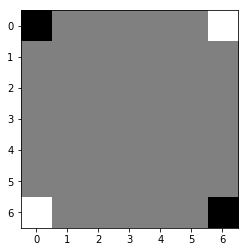

((0, 0), (1, 1)): n_v:  1479 q_all:+0.011744 q:-0.003962 q_m:+0.020000 p:0.298543
((6, 6), (5, 5)): n_v:  1455 q_all:+0.013646 q:-0.003784 q_m:+0.020000 p:0.285840
((0, 0), (1, 0)): n_v:   594 q_all:+0.012184 q:-0.008884 q_m:+0.020000 p:0.119195
((6, 6), (5, 6)): n_v:   512 q_all:+0.012937 q:+0.001189 q_m:+0.020000 p:0.101656
((6, 6), (6, 5)): n_v:   476 q_all:+0.013406 q:+0.009019 q_m:+0.020000 p:0.094026
((0, 0), (0, 1)): n_v:   454 q_all:+0.011605 q:+0.004509 q_m:+0.020000 p:0.091910
((0, 0), (1, 2)): n_v:     6 q_all:+0.001183 q:-0.016426 q_m:-0.000000 p:0.001617
((0, 0), (2, 1)): n_v:     6 q_all:-0.002138 q:-0.019587 q_m:-0.000000 p:0.001494
((6, 6), (5, 4)): n_v:     5 q_all:+0.006115 q:-0.009173 q_m:-0.000000 p:0.001289
((6, 6), (4, 5)): n_v:     5 q_all:-0.001583 q:-0.015294 q_m:-0.000000 p:0.001260
((0, 0), (2, 2)): n_v:     2 q_all:+0.003067 q:-0.016912 q_m:-0.000000 p:0.000536
((6, 6), (4, 4)): n_v:     2 q_all:+0.002874 q:-0.017415 q_m:-0.000000 p:0.000545
((6, 6), (6, 4))

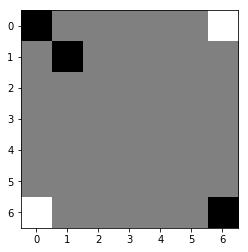

((0, 6), (1, 5)): n_v:  1929 q_all:-0.011147 q:-0.011846 q_m:-0.000000 p:0.294086
((6, 0), (5, 1)): n_v:  1353 q_all:-0.013066 q:-0.039039 q_m:-0.000000 p:0.212652
((0, 6), (1, 6)): n_v:  1119 q_all:-0.011189 q:-0.015991 q_m:-0.000000 p:0.170794
((0, 6), (0, 5)): n_v:   799 q_all:-0.012414 q:-0.014041 q_m:-0.000000 p:0.124404
((6, 0), (5, 0)): n_v:   736 q_all:-0.011607 q:-0.021558 q_m:-0.000000 p:0.113102
((6, 0), (6, 1)): n_v:   504 q_all:-0.011865 q:-0.032679 q_m:-0.000000 p:0.077762
((0, 6), (1, 4)): n_v:    12 q_all:-0.002993 q:-0.018195 q_m:-0.020000 p:0.001528
((6, 0), (5, 2)): n_v:     8 q_all:-0.014755 q:-0.036359 q_m:-0.020000 p:0.001435
((0, 6), (2, 4)): n_v:     6 q_all:-0.002387 q:-0.042527 q_m:-0.020000 p:0.000910
((0, 6), (0, 4)): n_v:     3 q_all:-0.007393 q:-0.023051 q_m:-0.020000 p:0.000465
((0, 6), (2, 5)): n_v:     3 q_all:-0.017228 q:-0.037214 q_m:-0.020000 p:0.000601
((6, 0), (4, 1)): n_v:     2 q_all:-0.024695 q:-0.033889 q_m:-0.020000 p:0.000506
((6, 0), (4, 2))

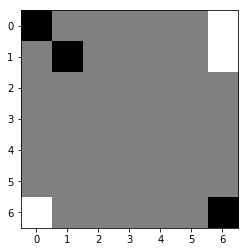

((1, 1), (0, 2)): n_v:  1100 q_all:+0.011485 q:+0.003858 q_m:+0.020000 p:0.160148
((6, 6), (5, 5)): n_v:   992 q_all:+0.013746 q:-0.000222 q_m:+0.020000 p:0.138634
((1, 1), (2, 1)): n_v:   700 q_all:+0.013417 q:+0.007946 q_m:+0.020000 p:0.098502
((6, 6), (6, 5)): n_v:   622 q_all:+0.013639 q:+0.004755 q_m:+0.020000 p:0.087209
((1, 1), (2, 0)): n_v:   533 q_all:+0.008676 q:-0.001981 q_m:+0.020000 p:0.081402
((1, 1), (1, 2)): n_v:   521 q_all:+0.007598 q:+0.002240 q_m:+0.020000 p:0.081129
((0, 0), (0, 1)): n_v:   430 q_all:+0.012510 q:-0.012913 q_m:+0.020000 p:0.061437
((6, 6), (5, 6)): n_v:   426 q_all:+0.013787 q:+0.004012 q_m:+0.020000 p:0.059565
((1, 1), (2, 2)): n_v:   367 q_all:+0.011234 q:+0.002425 q_m:+0.020000 p:0.053766
((0, 0), (1, 0)): n_v:   364 q_all:+0.012916 q:-0.001902 q_m:+0.020000 p:0.051767
((1, 1), (3, 0)): n_v:    11 q_all:+0.001274 q:-0.002058 q_m:-0.000000 p:0.001924
((1, 1), (0, 3)): n_v:    10 q_all:+0.034088 q:-0.009101 q_m:-0.000000 p:0.000843
((1, 1), (1, 3))

((6, 0), (5, 0)): n_v:  1161 q_all:-0.010527 q:-0.020164 q_m:-0.000000 p:0.163022
((0, 6), (1, 5)): n_v:  1065 q_all:-0.010718 q:-0.005447 q_m:-0.000000 p:0.150071
((0, 6), (0, 5)): n_v:   876 q_all:-0.008484 q:-0.012743 q_m:-0.000000 p:0.118049
((6, 0), (5, 1)): n_v:   717 q_all:-0.014804 q:-0.038961 q_m:-0.000000 p:0.108993
((1, 6), (2, 5)): n_v:   537 q_all:-0.009396 q:-0.028839 q_m:-0.000000 p:0.073722
((1, 6), (2, 6)): n_v:   510 q_all:-0.010887 q:-0.024291 q_m:-0.000000 p:0.072173
((6, 0), (6, 1)): n_v:   407 q_all:-0.011312 q:-0.029585 q_m:-0.000000 p:0.058054
((0, 6), (0, 4)): n_v:    30 q_all:-0.006202 q:-0.014968 q_m:-0.020000 p:0.003957
((0, 6), (1, 4)): n_v:    24 q_all:+0.004927 q:-0.007093 q_m:-0.020000 p:0.002378
((1, 6), (1, 4)): n_v:    16 q_all:+0.003438 q:-0.019879 q_m:-0.020000 p:0.001668
((1, 6), (0, 4)): n_v:    13 q_all:+0.012022 q:-0.021721 q_m:-0.020000 p:0.000954
((0, 6), (2, 4)): n_v:    11 q_all:+0.015756 q:-0.031514 q_m:-0.020000 p:0.000824
((6, 0), (6, 2))

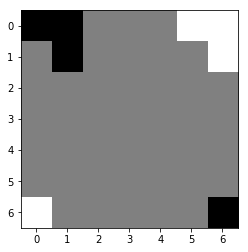

((6, 6), (5, 5)): n_v:  2637 q_all:+0.014739 q:+0.005988 q_m:+0.020000 p:0.381449
((6, 6), (6, 5)): n_v:   771 q_all:+0.015506 q:+0.010490 q_m:+0.020000 p:0.109968
((6, 6), (5, 6)): n_v:   481 q_all:+0.014289 q:+0.007800 q_m:+0.020000 p:0.070149
((1, 1), (2, 0)): n_v:   427 q_all:+0.011636 q:+0.011827 q_m:+0.020000 p:0.065213
((0, 1), (1, 2)): n_v:   384 q_all:+0.019021 q:+0.009552 q_m:+0.020000 p:0.051286
((0, 0), (1, 0)): n_v:   333 q_all:+0.015943 q:+0.019688 q_m:+0.020000 p:0.047207
((1, 1), (2, 1)): n_v:   325 q_all:+0.013053 q:+0.002280 q_m:+0.020000 p:0.048445
((1, 1), (2, 2)): n_v:   236 q_all:+0.017546 q:+0.000983 q_m:+0.020000 p:0.032539
((0, 1), (0, 2)): n_v:   207 q_all:+0.019784 q:-0.001476 q_m:+0.020000 p:0.027338
((1, 1), (3, 0)): n_v:    10 q_all:+0.008099 q:+0.005765 q_m:-0.000000 p:0.001660
((1, 1), (3, 3)): n_v:     8 q_all:+0.048898 q:-0.018272 q_m:-0.000000 p:0.000470
((1, 1), (3, 1)): n_v:     6 q_all:+0.009664 q:+0.008405 q_m:-0.000000 p:0.000975
((1, 1), (3, 2))

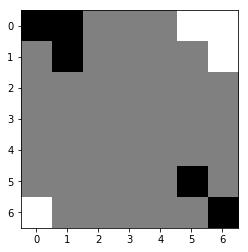

((6, 0), (5, 0)): n_v:  1250 q_all:-0.013168 q:-0.023990 q_m:-0.000000 p:0.221756
((0, 5), (0, 4)): n_v:  1042 q_all:-0.006387 q:-0.013681 q_m:-0.000000 p:0.165229
((0, 5), (1, 4)): n_v:   920 q_all:-0.002976 q:-0.004051 q_m:-0.000000 p:0.137237
((6, 0), (6, 1)): n_v:   704 q_all:-0.012929 q:-0.030946 q_m:-0.000000 p:0.124433
((6, 0), (5, 1)): n_v:   472 q_all:-0.014358 q:-0.045595 q_m:-0.000000 p:0.085411
((0, 5), (1, 5)): n_v:   342 q_all:-0.011172 q:-0.005978 q_m:-0.000000 p:0.058873
((1, 6), (2, 6)): n_v:   252 q_all:-0.008781 q:-0.021150 q_m:-0.000000 p:0.041718
((1, 6), (2, 5)): n_v:   141 q_all:-0.007492 q:-0.026883 q_m:-0.000000 p:0.022851
((6, 0), (6, 2)): n_v:     8 q_all:-0.020037 q:-0.019209 q_m:-0.020000 p:0.001710
((0, 6), (0, 4)): n_v:     7 q_all:-0.001694 q:-0.014701 q_m:-0.020000 p:0.001045
((6, 0), (5, 2)): n_v:     6 q_all:-0.010936 q:-0.037137 q_m:-0.020000 p:0.001122
((1, 6), (1, 4)): n_v:     5 q_all:+0.008618 q:-0.022744 q_m:-0.020000 p:0.000677
((6, 0), (4, 2))

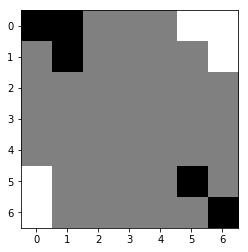

((5, 5), (6, 4)): n_v:   452 q_all:+0.015524 q:+0.017809 q_m:+0.020000 p:0.134625
((5, 5), (6, 5)): n_v:   263 q_all:+0.016684 q:+0.011776 q_m:+0.020000 p:0.077269
((0, 1), (0, 2)): n_v:   205 q_all:+0.019329 q:-0.000417 q_m:+0.020000 p:0.058183
((5, 5), (5, 4)): n_v:   197 q_all:+0.015460 q:+0.018847 q_m:+0.020000 p:0.058927
((5, 5), (4, 5)): n_v:   172 q_all:+0.011976 q:+0.006170 q_m:+0.020000 p:0.053674
((1, 1), (2, 0)): n_v:   164 q_all:+0.014004 q:+0.013329 q_m:+0.020000 p:0.049906
((5, 5), (4, 6)): n_v:   146 q_all:+0.012625 q:+0.005566 q_m:+0.020000 p:0.045386
((0, 0), (1, 0)): n_v:   133 q_all:+0.016774 q:+0.023381 q_m:+0.020000 p:0.039154
((1, 1), (2, 1)): n_v:   131 q_all:+0.015723 q:+0.015620 q_m:+0.020000 p:0.039112
((5, 5), (4, 4)): n_v:   129 q_all:+0.013080 q:+0.006158 q_m:+0.020000 p:0.039726
((1, 1), (2, 2)): n_v:   128 q_all:+0.022451 q:+0.011373 q_m:+0.020000 p:0.034610
((5, 5), (5, 6)): n_v:   126 q_all:+0.013995 q:+0.011490 q_m:+0.020000 p:0.038391
((0, 1), (1, 2))

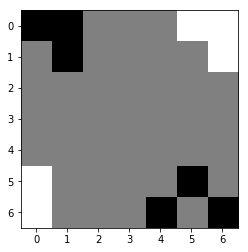

((0, 5), (1, 4)): n_v:   615 q_all:+0.003398 q:-0.033550 q_m:-0.000000 p:0.303277
((0, 5), (0, 4)): n_v:   469 q_all:+0.003287 q:-0.041853 q_m:-0.000000 p:0.231818
((5, 0), (6, 1)): n_v:   127 q_all:-0.005888 q:-0.046789 q_m:-0.000000 p:0.068661
((0, 5), (1, 5)): n_v:    85 q_all:-0.014240 q:-0.039368 q_m:-0.000000 p:0.049423
((1, 6), (2, 6)): n_v:    78 q_all:-0.011959 q:-0.051447 q_m:-0.000000 p:0.044354
((5, 0), (4, 0)): n_v:    64 q_all:-0.008481 q:-0.048517 q_m:-0.000000 p:0.035369
((5, 0), (5, 1)): n_v:    48 q_all:-0.005738 q:-0.060697 q_m:-0.000000 p:0.025858
((1, 6), (2, 5)): n_v:    24 q_all:-0.004796 q:-0.047523 q_m:-0.000000 p:0.012818
((5, 0), (4, 1)): n_v:    19 q_all:+0.004251 q:-0.045576 q_m:-0.000000 p:0.009286
((6, 0), (6, 2)): n_v:     3 q_all:-0.031225 q:-0.019485 q_m:-0.020000 p:0.001941
((1, 6), (1, 4)): n_v:     3 q_all:+0.015544 q:-0.046640 q_m:-0.020000 p:0.001422
((0, 6), (0, 4)): n_v:     3 q_all:+0.001535 q:-0.044591 q_m:-0.020000 p:0.001609
((0, 5), (1, 3))

((6, 4), (5, 3)): n_v:   637 q_all:+0.037658 q:+0.004238 q_m:+0.020000 p:0.295545
((6, 4), (6, 3)): n_v:   301 q_all:+0.039770 q:+0.008107 q_m:+0.020000 p:0.136722
((6, 4), (6, 2)): n_v:   134 q_all:-0.013523 q:+0.002637 q_m:-0.000000 p:0.096571
((0, 1), (0, 2)): n_v:   105 q_all:+0.006327 q:+0.003456 q_m:+0.020000 p:0.065224
((1, 1), (2, 2)): n_v:    49 q_all:+0.013691 q:+0.013402 q_m:+0.020000 p:0.028910
((0, 0), (1, 0)): n_v:    41 q_all:+0.019362 q:+0.026233 q_m:+0.020000 p:0.022894
((6, 4), (4, 2)): n_v:    40 q_all:+0.008583 q:+0.002689 q_m:-0.000000 p:0.024185
((1, 1), (2, 0)): n_v:    39 q_all:+0.021314 q:+0.020613 q_m:+0.020000 p:0.021719
((5, 5), (6, 5)): n_v:    32 q_all:+0.024516 q:+0.005607 q_m:+0.020000 p:0.017303
((5, 5), (4, 4)): n_v:    32 q_all:+0.015307 q:+0.007222 q_m:+0.020000 p:0.018876
((5, 5), (5, 6)): n_v:    25 q_all:+0.016239 q:+0.000375 q_m:+0.020000 p:0.014470
((1, 1), (2, 1)): n_v:    22 q_all:+0.002772 q:+0.026414 q_m:+0.020000 p:0.014568
((5, 5), (4, 5))

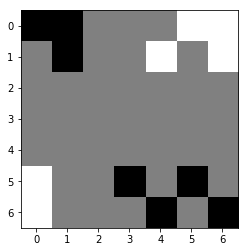

((6, 0), (6, 2)): n_v:   561 q_all:+0.011509 q:+0.001546 q_m:+0.020000 p:0.139269
((6, 0), (5, 2)): n_v:   487 q_all:+0.007332 q:-0.030424 q_m:+0.020000 p:0.129119
((0, 5), (0, 4)): n_v:   477 q_all:-0.024523 q:-0.039082 q_m:-0.000000 p:0.186656
((5, 0), (5, 2)): n_v:   378 q_all:+0.009761 q:-0.036948 q_m:+0.020000 p:0.096539
((5, 0), (6, 2)): n_v:   178 q_all:+0.010188 q:+0.003482 q_m:+0.020000 p:0.045336
((5, 0), (6, 1)): n_v:    82 q_all:-0.080861 q:-0.036799 q_m:-0.000000 p:0.050586
((1, 4), (0, 2)): n_v:    70 q_all:+0.020364 q:+0.006125 q_m:+0.060000 p:0.014955
((1, 4), (1, 2)): n_v:    63 q_all:-0.016506 q:-0.011875 q_m:+0.060000 p:0.022729
((1, 4), (2, 4)): n_v:    49 q_all:-0.030195 q:-0.021694 q_m:-0.000000 p:0.020312
((1, 4), (0, 3)): n_v:    33 q_all:-0.005728 q:-0.017785 q_m:-0.000000 p:0.010641
((6, 0), (4, 2)): n_v:    22 q_all:+0.023269 q:-0.011103 q_m:+0.020000 p:0.004633
((1, 4), (2, 2)): n_v:    22 q_all:-0.011462 q:-0.031995 q_m:+0.020000 p:0.007746
((5, 0), (4, 2))

((6, 4), (6, 3)): n_v:  4468 q_all:+0.018385 q:+0.045496 q_m:+0.080000 p:0.839861
((6, 4), (5, 2)): n_v:   687 q_all:+0.049940 q:+0.033691 q_m:+0.060000 p:0.070967
((5, 5), (6, 3)): n_v:   144 q_all:-0.001671 q:+0.026284 q_m:+0.060000 p:0.034934
((6, 4), (4, 2)): n_v:   122 q_all:+0.024565 q:+0.007007 q_m:+0.020000 p:0.021022
((0, 1), (2, 3)): n_v:    18 q_all:+0.076688 q:-0.019796 q_m:+0.020000 p:0.000568
((5, 5), (5, 4)): n_v:    17 q_all:+0.007282 q:+0.009737 q_m:+0.040000 p:0.003719
((6, 4), (4, 3)): n_v:    17 q_all:+0.030263 q:-0.012134 q_m:+0.020000 p:0.002739
((0, 1), (0, 3)): n_v:    13 q_all:+0.007747 q:-0.023161 q_m:+0.020000 p:0.002909
((1, 1), (0, 3)): n_v:    11 q_all:+0.008789 q:-0.009534 q_m:+0.020000 p:0.002415
((5, 5), (4, 4)): n_v:     7 q_all:-0.013959 q:+0.016595 q_m:+0.040000 p:0.002034
((5, 5), (4, 3)): n_v:     6 q_all:+0.008452 q:-0.004131 q_m:+0.020000 p:0.001463
((1, 1), (2, 3)): n_v:     6 q_all:+0.042331 q:+0.000281 q_m:+0.020000 p:0.000779
((1, 1), (1, 3))

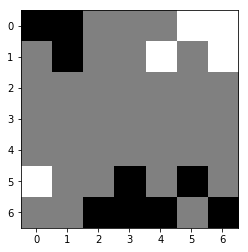

((5, 0), (5, 2)): n_v:  9359 q_all:+0.008631 q:-0.004489 q_m:+0.040000 p:0.984652
((5, 0), (6, 1)): n_v:    19 q_all:-0.089055 q:-0.038059 q_m:-0.020000 p:0.006105
((1, 4), (1, 2)): n_v:    17 q_all:-0.062085 q:-0.063755 q_m:-0.000000 p:0.004474
((5, 0), (4, 1)): n_v:     4 q_all:-0.086723 q:-0.062799 q_m:-0.060000 p:0.001306
((0, 5), (0, 4)): n_v:     2 q_all:-0.074916 q:-0.089316 q_m:-0.060000 p:0.000721
((5, 0), (6, 0)): n_v:     1 q_all:-0.100540 q:-0.073647 q_m:-0.060000 p:0.000394
((5, 0), (5, 1)): n_v:     1 q_all:-0.070573 q:-0.048157 q_m:-0.020000 p:0.000532
((5, 0), (3, 2)): n_v:     0 q_all:-0.083494 q:-0.088734 q_m:-0.080000 p:0.000017
((1, 6), (2, 6)): n_v:     0 q_all:-0.068226 q:-0.080564 q_m:-0.060000 p:0.000011
((0, 6), (2, 6)): n_v:     0 q_all:-0.085032 q:-0.092581 q_m:-0.080000 p:0.000001
((0, 5), (2, 6)): n_v:     0 q_all:-0.090054 q:-0.105135 q_m:-0.080000 p:0.000003
((0, 5), (2, 5)): n_v:     0 q_all:-0.091977 q:-0.109943 q_m:-0.080000 p:0.000001
((0, 6), (2, 4))

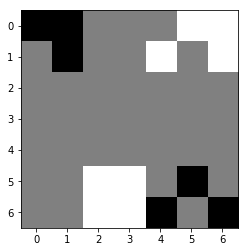

((6, 4), (4, 2)): n_v:  4395 q_all:+0.004083 q:-0.024401 q_m:+0.040000 p:0.280034
((6, 4), (4, 3)): n_v:  3807 q_all:+0.011777 q:-0.021588 q_m:+0.040000 p:0.192770
((5, 5), (5, 4)): n_v:  2900 q_all:+0.007623 q:+0.012943 q_m:+0.060000 p:0.156099
((5, 5), (4, 3)): n_v:   597 q_all:-0.019921 q:-0.021235 q_m:+0.040000 p:0.063891
((5, 5), (4, 4)): n_v:   125 q_all:-0.034839 q:-0.007955 q_m:+0.020000 p:0.016688
((1, 1), (2, 3)): n_v:    95 q_all:-0.027100 q:-0.029712 q_m:-0.000000 p:0.011355
((0, 1), (2, 3)): n_v:    75 q_all:-0.022779 q:-0.044671 q_m:-0.000000 p:0.008500
((0, 1), (1, 2)): n_v:    48 q_all:-0.056279 q:-0.033120 q_m:-0.020000 p:0.008356
((1, 1), (2, 2)): n_v:    40 q_all:-0.042309 q:-0.037426 q_m:-0.020000 p:0.005946
((1, 1), (1, 3)): n_v:    26 q_all:-0.037717 q:-0.014035 q_m:-0.000000 p:0.003721
((5, 5), (4, 5)): n_v:    24 q_all:-0.054117 q:-0.040006 q_m:-0.020000 p:0.004139
((6, 6), (5, 4)): n_v:    19 q_all:-0.010515 q:-0.009024 q_m:+0.040000 p:0.001794
((6, 6), (4, 4))

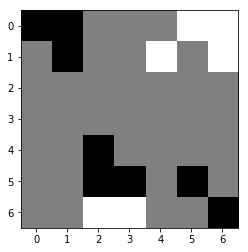

((6, 3), (6, 4)): n_v:  1115 q_all:-0.002452 q:-0.004409 q_m:+0.060000 p:0.293456
((6, 2), (5, 1)): n_v:   888 q_all:+0.016946 q:-0.000605 q_m:+0.060000 p:0.186810
((6, 3), (6, 5)): n_v:   734 q_all:+0.042201 q:-0.003846 q_m:+0.040000 p:0.103990
((6, 3), (5, 4)): n_v:   268 q_all:-0.006345 q:-0.007785 q_m:+0.060000 p:0.073600
((1, 4), (2, 3)): n_v:   222 q_all:-0.018861 q:-0.021793 q_m:-0.020000 p:0.068335
((6, 3), (5, 1)): n_v:   153 q_all:+0.010382 q:+0.002504 q_m:+0.040000 p:0.035122
((6, 2), (5, 4)): n_v:   143 q_all:-0.029347 q:-0.028259 q_m:+0.040000 p:0.048104
((6, 2), (4, 3)): n_v:   101 q_all:+0.049752 q:+0.001809 q_m:+0.080000 p:0.012319
((6, 3), (6, 1)): n_v:    88 q_all:-0.028416 q:+0.005630 q_m:-0.000000 p:0.029340
((6, 3), (4, 3)): n_v:    66 q_all:+0.025696 q:+0.031965 q_m:+0.080000 p:0.012371
((6, 2), (6, 4)): n_v:    66 q_all:-0.032641 q:-0.037395 q_m:+0.040000 p:0.022801
((0, 5), (0, 4)): n_v:    62 q_all:-0.022081 q:-0.048306 q_m:-0.020000 p:0.019883
((1, 4), (0, 2))

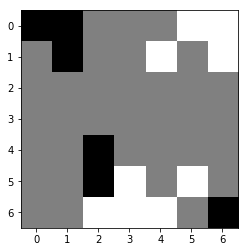

((4, 2), (5, 4)): n_v:  3092 q_all:+0.078975 q:+0.032053 q_m:+0.100000 p:0.716417
((6, 6), (5, 4)): n_v:   382 q_all:+0.085467 q:+0.028197 q_m:+0.100000 p:0.081004
((5, 2), (5, 4)): n_v:    96 q_all:+0.054704 q:+0.035097 q_m:+0.100000 p:0.029423
((4, 2), (5, 1)): n_v:    84 q_all:+0.005322 q:-0.026562 q_m:-0.000000 p:0.038082
((6, 6), (6, 5)): n_v:    56 q_all:+0.003040 q:+0.000387 q_m:+0.040000 p:0.025903
((4, 2), (6, 1)): n_v:    25 q_all:-0.050189 q:-0.031556 q_m:-0.020000 p:0.016053
((0, 1), (1, 2)): n_v:    20 q_all:-0.014124 q:-0.044885 q_m:-0.040000 p:0.010635
((4, 2), (5, 0)): n_v:    17 q_all:-0.052841 q:-0.058163 q_m:-0.060000 p:0.011181
((6, 6), (5, 6)): n_v:    16 q_all:+0.015343 q:-0.040980 q_m:-0.000000 p:0.007042
((4, 2), (6, 0)): n_v:     8 q_all:-0.050291 q:-0.053550 q_m:-0.060000 p:0.005501
((5, 2), (6, 1)): n_v:     7 q_all:-0.024522 q:-0.014657 q_m:-0.000000 p:0.004108
((4, 2), (4, 4)): n_v:     7 q_all:+0.004464 q:-0.016403 q_m:+0.020000 p:0.003409
((4, 2), (4, 3))

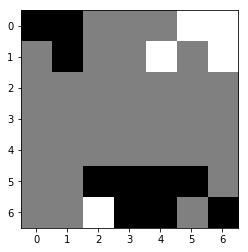

((6, 2), (4, 4)): n_v:  3469 q_all:-0.031239 q:-0.032077 q_m:+0.020000 p:0.517011
((1, 4), (2, 2)): n_v:   457 q_all:-0.093142 q:-0.068087 q_m:-0.060000 p:0.147488
((0, 5), (0, 4)): n_v:   179 q_all:-0.100011 q:-0.080442 q_m:-0.080000 p:0.061268
((1, 4), (0, 2)): n_v:   145 q_all:-0.083488 q:-0.035620 q_m:-0.020000 p:0.043039
((1, 4), (1, 2)): n_v:   133 q_all:-0.079193 q:-0.048321 q_m:-0.020000 p:0.037787
((1, 4), (2, 3)): n_v:   113 q_all:-0.081824 q:-0.070189 q_m:-0.080000 p:0.033021
((1, 4), (2, 4)): n_v:   100 q_all:-0.080201 q:-0.058650 q_m:-0.080000 p:0.028862
((6, 2), (6, 1)): n_v:    86 q_all:-0.125718 q:-0.044588 q_m:-0.040000 p:0.035866
((1, 4), (0, 3)): n_v:    44 q_all:-0.075872 q:-0.060674 q_m:-0.080000 p:0.012219
((1, 4), (2, 5)): n_v:    30 q_all:-0.068304 q:-0.061854 q_m:-0.080000 p:0.007726
((6, 2), (5, 1)): n_v:    26 q_all:-0.090649 q:-0.067603 q_m:-0.040000 p:0.008335
((0, 5), (1, 5)): n_v:    25 q_all:-0.002377 q:-0.077649 q_m:-0.080000 p:0.001763
((1, 4), (1, 3))

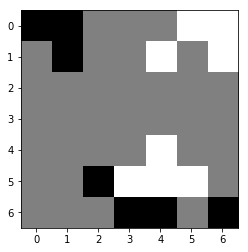

((5, 2), (4, 3)): n_v:  2004 q_all:+0.041555 q:+0.019115 q_m:+0.120000 p:0.386216
((6, 4), (4, 3)): n_v:   896 q_all:+0.032878 q:+0.023467 q_m:+0.100000 p:0.195481
((6, 6), (4, 5)): n_v:   619 q_all:+0.040149 q:+0.010374 q_m:+0.100000 p:0.122018
((6, 3), (4, 3)): n_v:   316 q_all:+0.020969 q:+0.001955 q_m:+0.100000 p:0.080258
((6, 3), (4, 5)): n_v:   167 q_all:+0.033539 q:+0.024469 q_m:+0.100000 p:0.036272
((0, 1), (2, 3)): n_v:   157 q_all:+0.000812 q:-0.059696 q_m:+0.020000 p:0.049349
((6, 4), (4, 5)): n_v:    79 q_all:+0.041816 q:+0.003819 q_m:+0.100000 p:0.015331
((6, 3), (4, 1)): n_v:    68 q_all:-0.038439 q:-0.069192 q_m:-0.020000 p:0.029311
((1, 1), (2, 3)): n_v:    59 q_all:+0.005608 q:-0.036067 q_m:+0.020000 p:0.017682
((6, 3), (6, 5)): n_v:    29 q_all:+0.011732 q:-0.021917 q_m:+0.060000 p:0.008323
((6, 4), (6, 2)): n_v:    28 q_all:-0.003907 q:-0.032023 q_m:+0.020000 p:0.009241
((6, 3), (6, 1)): n_v:    25 q_all:-0.041668 q:-0.067649 q_m:-0.020000 p:0.011178
((5, 2), (4, 1))

((5, 5), (6, 5)): n_v:  1550 q_all:+0.021430 q:+0.002026 q_m:+0.020000 p:0.555471
((5, 5), (4, 5)): n_v:   560 q_all:-0.012495 q:-0.059883 q_m:-0.020000 p:0.269012
((1, 4), (2, 5)): n_v:    31 q_all:-0.061869 q:-0.055963 q_m:-0.100000 p:0.020631
((0, 5), (0, 4)): n_v:    24 q_all:-0.075693 q:-0.070630 q_m:-0.100000 p:0.017319
((1, 4), (3, 3)): n_v:    21 q_all:-0.026158 q:-0.057176 q_m:-0.040000 p:0.011556
((1, 4), (0, 2)): n_v:    20 q_all:-0.053582 q:-0.036197 q_m:-0.040000 p:0.012566
((1, 4), (2, 2)): n_v:    14 q_all:-0.078043 q:-0.068147 q_m:-0.080000 p:0.010320
((1, 4), (1, 2)): n_v:    12 q_all:-0.051651 q:-0.043954 q_m:-0.040000 p:0.007627
((5, 5), (5, 6)): n_v:     9 q_all:-0.091828 q:-0.069420 q_m:-0.060000 p:0.007587
((1, 4), (2, 4)): n_v:     9 q_all:-0.048614 q:-0.052603 q_m:-0.100000 p:0.006048
((1, 4), (2, 3)): n_v:     5 q_all:-0.060363 q:-0.062104 q_m:-0.100000 p:0.003594
((1, 4), (3, 4)): n_v:     5 q_all:-0.049102 q:-0.042218 q_m:-0.040000 p:0.003606
((1, 6), (3, 4))

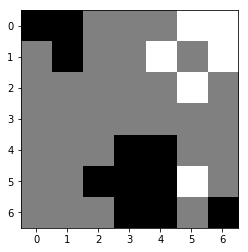

((5, 4), (6, 5)): n_v:   142 q_all:+0.102010 q:+0.061462 q_m:+0.160000 p:0.073720
((6, 6), (5, 6)): n_v:   138 q_all:+0.074752 q:+0.046875 q_m:+0.160000 p:0.095416
((4, 3), (3, 4)): n_v:   110 q_all:+0.073433 q:+0.038941 q_m:+0.160000 p:0.076500
((4, 4), (3, 5)): n_v:    72 q_all:+0.121655 q:+0.049392 q_m:+0.160000 p:0.028677
((4, 3), (3, 2)): n_v:    66 q_all:+0.071289 q:+0.015966 q_m:+0.120000 p:0.047399
((5, 2), (6, 1)): n_v:    60 q_all:+0.058033 q:+0.021163 q_m:+0.120000 p:0.048074
((4, 4), (5, 6)): n_v:    41 q_all:+0.091769 q:+0.041908 q_m:+0.140000 p:0.023715
((6, 4), (5, 6)): n_v:    37 q_all:+0.037458 q:+0.026630 q_m:+0.140000 p:0.034821
((4, 4), (4, 5)): n_v:    28 q_all:+0.123817 q:+0.047138 q_m:+0.160000 p:0.011030
((0, 0), (1, 0)): n_v:    28 q_all:+0.068524 q:+0.039006 q_m:+0.120000 p:0.020455
((5, 2), (4, 1)): n_v:    28 q_all:+0.070510 q:-0.004790 q_m:+0.120000 p:0.020597
((4, 4), (2, 6)): n_v:    28 q_all:+0.114752 q:+0.037681 q_m:+0.180000 p:0.012604
((4, 3), (6, 1))

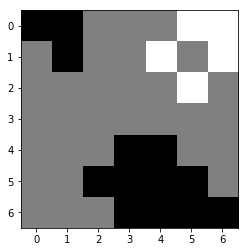

((2, 5), (4, 5)): n_v:  1367 q_all:-0.034478 q:-0.064881 q_m:-0.040000 p:0.765417
((2, 5), (3, 4)): n_v:    72 q_all:-0.046275 q:-0.059093 q_m:-0.060000 p:0.044985
((2, 5), (3, 6)): n_v:    48 q_all:-0.069597 q:-0.087954 q_m:-0.140000 p:0.035309
((1, 4), (0, 2)): n_v:    17 q_all:-0.102229 q:-0.063477 q_m:-0.080000 p:0.015086
((2, 5), (3, 5)): n_v:    14 q_all:-0.096325 q:-0.086926 q_m:-0.100000 p:0.012749
((1, 4), (2, 2)): n_v:    13 q_all:-0.097332 q:-0.087506 q_m:-0.120000 p:0.012001
((1, 6), (3, 6)): n_v:    12 q_all:-0.072281 q:-0.106048 q_m:-0.160000 p:0.009311
((1, 4), (3, 6)): n_v:    10 q_all:-0.102643 q:-0.089306 q_m:-0.160000 p:0.009351
((1, 4), (3, 3)): n_v:     9 q_all:-0.097418 q:-0.076019 q_m:-0.080000 p:0.008346
((0, 5), (0, 4)): n_v:     8 q_all:-0.059957 q:-0.095575 q_m:-0.140000 p:0.006071
((2, 5), (4, 6)): n_v:     8 q_all:-0.114165 q:-0.093115 q_m:-0.120000 p:0.008219
((1, 4), (2, 4)): n_v:     8 q_all:-0.047041 q:-0.087414 q_m:-0.140000 p:0.005402
((1, 4), (2, 3))

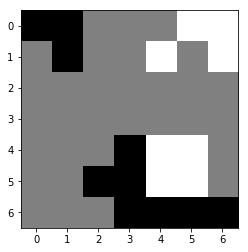

((6, 5), (5, 6)): n_v:  2060 q_all:+0.073225 q:+0.047892 q_m:+0.140000 p:0.420253
((4, 3), (3, 5)): n_v:   204 q_all:+0.065492 q:-0.003669 q_m:+0.120000 p:0.048081
((4, 3), (3, 4)): n_v:    95 q_all:+0.041794 q:+0.008877 q_m:+0.140000 p:0.031154
((6, 4), (5, 6)): n_v:    81 q_all:-0.001251 q:-0.005615 q_m:+0.120000 p:0.039912
((6, 6), (4, 6)): n_v:    47 q_all:+0.046385 q:+0.011741 q_m:+0.120000 p:0.014369
((4, 3), (3, 2)): n_v:    29 q_all:+0.002578 q:-0.024484 q_m:+0.060000 p:0.014212
((4, 3), (3, 1)): n_v:    24 q_all:-0.016320 q:-0.034743 q_m:+0.040000 p:0.013571
((5, 2), (4, 1)): n_v:    20 q_all:-0.003474 q:-0.025558 q_m:+0.060000 p:0.010172
((0, 0), (1, 0)): n_v:    17 q_all:+0.014036 q:+0.025857 q_m:+0.060000 p:0.007498
((5, 3), (3, 5)): n_v:    17 q_all:+0.030802 q:-0.021245 q_m:+0.120000 p:0.006530
((5, 2), (5, 1)): n_v:    14 q_all:-0.011283 q:-0.020500 q_m:+0.060000 p:0.007892
((6, 4), (4, 6)): n_v:    13 q_all:+0.010924 q:-0.016810 q_m:+0.120000 p:0.006063
((6, 5), (4, 6))

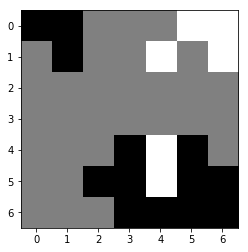

((4, 4), (6, 2)): n_v:  2325 q_all:-0.046270 q:-0.051371 q_m:-0.020000 p:0.485904
((0, 5), (0, 4)): n_v:   276 q_all:-0.072353 q:-0.083345 q_m:-0.120000 p:0.082602
((5, 4), (6, 2)): n_v:   205 q_all:-0.066436 q:-0.037402 q_m:-0.020000 p:0.057367
((5, 4), (4, 2)): n_v:   106 q_all:-0.079413 q:-0.064917 q_m:-0.020000 p:0.034347
((1, 4), (0, 2)): n_v:   101 q_all:-0.077489 q:-0.042702 q_m:-0.060000 p:0.032080
((4, 4), (3, 4)): n_v:    52 q_all:-0.055312 q:-0.029595 q_m:-0.040000 p:0.012570
((1, 4), (2, 4)): n_v:    45 q_all:-0.069808 q:-0.063718 q_m:-0.120000 p:0.013346
((1, 4), (2, 2)): n_v:    35 q_all:-0.100414 q:-0.080339 q_m:-0.100000 p:0.014073
((4, 4), (3, 5)): n_v:    29 q_all:-0.093841 q:-0.060657 q_m:-0.080000 p:0.011160
((1, 6), (2, 6)): n_v:    18 q_all:-0.070706 q:-0.075867 q_m:-0.120000 p:0.005332
((5, 4), (4, 6)): n_v:    15 q_all:-0.070618 q:-0.054104 q_m:-0.020000 p:0.004526
((4, 4), (4, 6)): n_v:    14 q_all:-0.049920 q:-0.036481 q_m:-0.020000 p:0.003299
((4, 4), (2, 6))

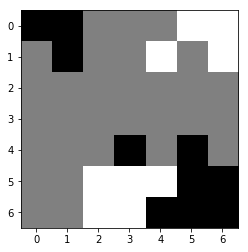

((4, 3), (4, 4)): n_v:  2319 q_all:+0.090418 q:+0.074578 q_m:+0.120000 p:0.282192
((4, 3), (4, 2)): n_v:   936 q_all:+0.034038 q:+0.017364 q_m:+0.120000 p:0.275448
((4, 3), (5, 1)): n_v:   178 q_all:+0.112102 q:+0.018301 q_m:+0.100000 p:0.009873
((4, 3), (6, 1)): n_v:   110 q_all:+0.117028 q:+0.020821 q_m:+0.100000 p:0.004376
((6, 4), (4, 2)): n_v:    58 q_all:+0.039202 q:-0.025343 q_m:+0.100000 p:0.016402
((1, 1), (2, 2)): n_v:    28 q_all:+0.011331 q:+0.017934 q_m:+0.040000 p:0.010289
((5, 6), (4, 4)): n_v:     5 q_all:+0.043700 q:+0.015732 q_m:+0.100000 p:0.001428
((6, 6), (4, 4)): n_v:     4 q_all:+0.052720 q:+0.032144 q_m:+0.100000 p:0.001124
((6, 5), (4, 4)): n_v:     1 q_all:-0.007322 q:+0.013614 q_m:+0.100000 p:0.000691
((6, 4), (4, 4)): n_v:     1 q_all:+0.023834 q:+0.010766 q_m:+0.100000 p:0.000270
((4, 3), (2, 4)): n_v:     1 q_all:+0.049669 q:-0.004718 q_m:+0.060000 p:0.000316
((4, 3), (2, 5)): n_v:     1 q_all:+0.059553 q:+0.016398 q_m:+0.100000 p:0.000219
((4, 3), (2, 3))

((5, 2), (4, 2)): n_v:   683 q_all:-0.030940 q:-0.055424 q_m:-0.020000 p:0.152921
((1, 6), (3, 4)): n_v:   562 q_all:-0.038536 q:-0.024618 q_m:-0.000000 p:0.140643
((1, 4), (3, 4)): n_v:   405 q_all:-0.031732 q:-0.006529 q_m:-0.000000 p:0.091826
((1, 4), (1, 2)): n_v:   270 q_all:-0.089061 q:-0.039108 q_m:-0.040000 p:0.115118
((1, 4), (2, 4)): n_v:   116 q_all:-0.091954 q:-0.024989 q_m:-0.100000 p:0.050825
((1, 4), (3, 3)): n_v:   107 q_all:-0.091080 q:-0.045667 q_m:-0.040000 p:0.046487
((1, 4), (2, 2)): n_v:   105 q_all:-0.109677 q:-0.053860 q_m:-0.080000 p:0.052624
((6, 2), (4, 2)): n_v:    94 q_all:-0.044756 q:-0.076511 q_m:-0.040000 p:0.025800
((6, 2), (5, 0)): n_v:    77 q_all:-0.132248 q:-0.089329 q_m:-0.120000 p:0.044440
((5, 2), (3, 2)): n_v:    68 q_all:-0.132028 q:-0.081294 q_m:-0.080000 p:0.039503
((5, 2), (3, 4)): n_v:    58 q_all:-0.062894 q:-0.012439 q_m:-0.000000 p:0.019692
((6, 3), (4, 2)): n_v:    49 q_all:-0.110976 q:-0.071001 q_m:-0.040000 p:0.024726
((1, 4), (3, 2))

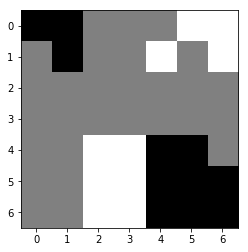

((4, 4), (3, 3)): n_v:  1240 q_all:+0.042386 q:+0.066484 q_m:+0.120000 p:0.666364
((4, 5), (3, 3)): n_v:   124 q_all:+0.059689 q:+0.024917 q_m:+0.100000 p:0.056921
((4, 4), (3, 2)): n_v:    84 q_all:+0.029351 q:+0.037532 q_m:+0.100000 p:0.050363
((4, 5), (2, 5)): n_v:    37 q_all:+0.076354 q:+0.069423 q_m:+0.100000 p:0.013692
((1, 1), (3, 3)): n_v:    33 q_all:+0.029499 q:+0.067766 q_m:+0.100000 p:0.019774
((4, 4), (3, 4)): n_v:    32 q_all:+0.033188 q:+0.048927 q_m:+0.080000 p:0.018742
((4, 4), (2, 5)): n_v:    23 q_all:+0.115161 q:+0.053623 q_m:+0.100000 p:0.004635
((5, 5), (3, 3)): n_v:    20 q_all:+0.027913 q:+0.019124 q_m:+0.100000 p:0.012264
((4, 5), (4, 6)): n_v:    18 q_all:+0.073085 q:+0.057998 q_m:+0.040000 p:0.007253
((4, 4), (2, 3)): n_v:    16 q_all:+0.049076 q:+0.059754 q_m:+0.060000 p:0.008502
((5, 4), (3, 3)): n_v:    12 q_all:-0.026840 q:+0.048820 q_m:+0.100000 p:0.010552
((1, 1), (2, 1)): n_v:    11 q_all:+0.031857 q:+0.029949 q_m:+0.040000 p:0.006856
((4, 5), (3, 6))

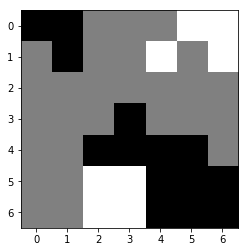

((1, 6), (3, 4)): n_v:  3513 q_all:+0.010898 q:-0.020139 q_m:+0.040000 p:0.748961
((1, 4), (3, 4)): n_v:   312 q_all:+0.011983 q:-0.004467 q_m:+0.040000 p:0.065730
((1, 4), (3, 2)): n_v:   167 q_all:-0.038228 q:-0.045675 q_m:-0.000000 p:0.060409
((5, 2), (3, 2)): n_v:   128 q_all:-0.069952 q:-0.077334 q_m:-0.000000 p:0.058538
((5, 3), (3, 4)): n_v:    47 q_all:-0.069374 q:-0.004383 q_m:+0.040000 p:0.021465
((5, 2), (3, 4)): n_v:    43 q_all:-0.036231 q:-0.033336 q_m:+0.040000 p:0.015242
((5, 3), (3, 2)): n_v:    39 q_all:-0.118193 q:-0.055592 q_m:-0.000000 p:0.023591
((1, 4), (2, 4)): n_v:     3 q_all:-0.004894 q:-0.026066 q_m:-0.060000 p:0.000931
((1, 4), (1, 2)): n_v:     1 q_all:-0.090668 q:-0.048633 q_m:-0.040000 p:0.001011
((1, 4), (2, 3)): n_v:     1 q_all:-0.011779 q:-0.055328 q_m:-0.060000 p:0.000522
((1, 4), (2, 2)): n_v:     1 q_all:-0.029604 q:-0.054412 q_m:-0.040000 p:0.000473
((5, 3), (4, 1)): n_v:     0 q_all:-0.073245 q:-0.063113 q_m:-0.080000 p:0.000003
((1, 6), (0, 4))

((4, 2), (3, 2)): n_v:  1966 q_all:-0.005451 q:+0.012004 q_m:+0.060000 p:0.542800
((5, 6), (3, 5)): n_v:  1816 q_all:+0.083315 q:+0.016390 q_m:+0.080000 p:0.056984
((4, 2), (5, 1)): n_v:   502 q_all:-0.004417 q:+0.033063 q_m:+0.060000 p:0.137068
((4, 2), (6, 0)): n_v:    96 q_all:-0.068603 q:-0.008931 q_m:-0.040000 p:0.044123
((4, 2), (5, 0)): n_v:    90 q_all:-0.064436 q:-0.011551 q_m:-0.040000 p:0.040550
((4, 2), (6, 1)): n_v:    73 q_all:-0.016775 q:+0.013255 q_m:+0.040000 p:0.023001
((1, 1), (0, 3)): n_v:    51 q_all:-0.033153 q:+0.007569 q_m:-0.000000 p:0.018285
((1, 1), (2, 2)): n_v:    48 q_all:-0.037302 q:+0.004096 q_m:+0.020000 p:0.018051
((4, 2), (4, 1)): n_v:    37 q_all:-0.044474 q:+0.014312 q_m:+0.020000 p:0.014701
((1, 1), (2, 3)): n_v:    28 q_all:-0.010343 q:+0.048974 q_m:+0.080000 p:0.008365
((1, 1), (2, 1)): n_v:    17 q_all:-0.059726 q:+0.006700 q_m:-0.020000 p:0.007598
((0, 1), (0, 3)): n_v:    15 q_all:-0.042594 q:+0.000967 q_m:-0.000000 p:0.006062
((0, 1), (0, 2))

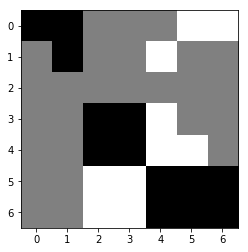

((3, 4), (2, 2)): n_v:  1063 q_all:+0.014335 q:-0.024086 q_m:+0.060000 p:0.374122
((4, 5), (4, 6)): n_v:   512 q_all:+0.030506 q:-0.011054 q_m:+0.040000 p:0.149595
((1, 4), (2, 2)): n_v:   394 q_all:+0.014094 q:-0.033655 q_m:+0.060000 p:0.138843
((5, 2), (4, 1)): n_v:   163 q_all:+0.009598 q:+0.000522 q_m:+0.040000 p:0.060326
((1, 4), (2, 3)): n_v:   115 q_all:+0.017315 q:-0.021632 q_m:+0.040000 p:0.039412
((3, 4), (1, 2)): n_v:    98 q_all:+0.012173 q:-0.010795 q_m:+0.020000 p:0.035515
((1, 4), (1, 2)): n_v:    41 q_all:+0.005479 q:-0.027307 q_m:+0.020000 p:0.015772
((4, 5), (2, 4)): n_v:    28 q_all:-0.045642 q:-0.063544 q_m:-0.020000 p:0.016085
((1, 4), (0, 2)): n_v:    25 q_all:+0.011974 q:-0.001926 q_m:+0.020000 p:0.009249
((1, 4), (2, 4)): n_v:    23 q_all:-0.032685 q:-0.027155 q_m:-0.000000 p:0.011921
((3, 4), (1, 6)): n_v:    21 q_all:-0.043727 q:-0.039609 q_m:-0.060000 p:0.012150
((4, 4), (2, 2)): n_v:    17 q_all:-0.006261 q:-0.049012 q_m:+0.060000 p:0.007508
((6, 3), (4, 1))

((4, 3), (3, 4)): n_v:   751 q_all:+0.090801 q:+0.051498 q_m:+0.080000 p:0.435007
((4, 2), (4, 1)): n_v:   146 q_all:+0.015775 q:-0.007633 q_m:+0.040000 p:0.133325
((0, 0), (2, 1)): n_v:   107 q_all:+0.020354 q:+0.012887 q_m:+0.060000 p:0.095783
((0, 1), (2, 1)): n_v:    98 q_all:+0.048125 q:+0.018310 q_m:+0.060000 p:0.075933
((0, 1), (2, 3)): n_v:    60 q_all:+0.043732 q:+0.007356 q_m:+0.100000 p:0.047229
((4, 2), (5, 1)): n_v:    44 q_all:+0.022577 q:-0.005283 q_m:+0.040000 p:0.038549
((5, 6), (3, 4)): n_v:    37 q_all:+0.075944 q:+0.026793 q_m:+0.060000 p:0.023991
((0, 1), (1, 2)): n_v:    32 q_all:+0.032157 q:+0.017049 q_m:+0.040000 p:0.026974
((5, 5), (3, 4)): n_v:    26 q_all:+0.039094 q:+0.002721 q_m:+0.060000 p:0.021756
((4, 3), (2, 1)): n_v:    23 q_all:+0.037662 q:+0.002535 q_m:+0.060000 p:0.019185
((4, 2), (2, 1)): n_v:    17 q_all:+0.034355 q:+0.014445 q_m:+0.060000 p:0.014398
((4, 3), (2, 5)): n_v:    12 q_all:+0.043435 q:-0.027260 q_m:-0.020000 p:0.009740
((4, 2), (2, 3))

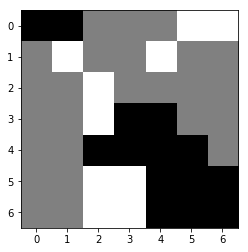

((1, 1), (3, 1)): n_v:   531 q_all:-0.042387 q:-0.092166 q_m:-0.040000 p:0.222026
((1, 1), (1, 0)): n_v:   269 q_all:-0.014629 q:-0.038187 q_m:+0.020000 p:0.076773
((1, 4), (3, 5)): n_v:   180 q_all:+0.008399 q:+0.004271 q_m:+0.040000 p:0.031573
((2, 2), (3, 1)): n_v:   139 q_all:-0.050010 q:-0.099093 q_m:-0.020000 p:0.063511
((1, 4), (2, 3)): n_v:   126 q_all:-0.030460 q:-0.061647 q_m:+0.020000 p:0.045736
((3, 2), (1, 0)): n_v:    98 q_all:-0.014040 q:-0.044631 q_m:-0.000000 p:0.027842
((3, 2), (4, 1)): n_v:    69 q_all:-0.072055 q:-0.072183 q_m:-0.020000 p:0.038821
((3, 2), (5, 1)): n_v:    48 q_all:-0.053038 q:-0.108973 q_m:-0.040000 p:0.022806
((3, 2), (5, 0)): n_v:    44 q_all:-0.107244 q:-0.101745 q_m:-0.080000 p:0.032485
((1, 1), (1, 2)): n_v:    31 q_all:-0.063634 q:-0.078096 q_m:-0.020000 p:0.016526
((6, 2), (5, 0)): n_v:    28 q_all:-0.106464 q:-0.121934 q_m:-0.080000 p:0.020496
((2, 2), (1, 0)): n_v:    21 q_all:-0.022057 q:-0.049531 q_m:-0.000000 p:0.006908
((5, 3), (3, 5))

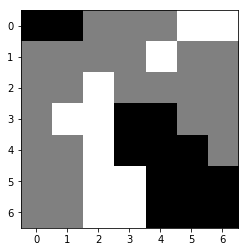

((3, 4), (2, 5)): n_v:   251 q_all:+0.072679 q:+0.027381 q_m:+0.100000 p:0.175888
((3, 3), (4, 1)): n_v:   212 q_all:+0.107207 q:+0.086641 q_m:+0.200000 p:0.111275
((3, 3), (2, 1)): n_v:   161 q_all:+0.069659 q:+0.050052 q_m:+0.160000 p:0.115497
((3, 4), (1, 5)): n_v:   159 q_all:+0.133905 q:+0.094419 q_m:+0.160000 p:0.061372
((0, 0), (2, 1)): n_v:   107 q_all:+0.062433 q:+0.065611 q_m:+0.160000 p:0.080666
((3, 3), (2, 3)): n_v:   106 q_all:+0.122152 q:+0.077667 q_m:+0.180000 p:0.047311
((3, 3), (1, 5)): n_v:    96 q_all:+0.149784 q:+0.086534 q_m:+0.160000 p:0.029392
((0, 0), (1, 1)): n_v:    67 q_all:+0.092334 q:+0.043826 q_m:+0.100000 p:0.040080
((0, 1), (2, 1)): n_v:    65 q_all:+0.064109 q:+0.068804 q_m:+0.160000 p:0.048957
((3, 3), (1, 1)): n_v:    46 q_all:+0.056297 q:+0.041267 q_m:+0.080000 p:0.036161
((4, 3), (4, 1)): n_v:    43 q_all:+0.061884 q:+0.070418 q_m:+0.200000 p:0.033057
((3, 3), (5, 1)): n_v:    43 q_all:+0.078629 q:+0.062280 q_m:+0.160000 p:0.029169
((3, 3), (2, 5))

((2, 2), (2, 3)): n_v:   594 q_all:-0.005688 q:-0.058133 q_m:+0.040000 p:0.279448
((0, 5), (2, 4)): n_v:   190 q_all:-0.050760 q:-0.061230 q_m:+0.060000 p:0.138055
((0, 6), (2, 4)): n_v:   106 q_all:-0.046942 q:-0.051651 q_m:+0.060000 p:0.075015
((2, 2), (1, 1)): n_v:    94 q_all:+0.015805 q:-0.097066 q_m:-0.000000 p:0.032668
((0, 5), (1, 5)): n_v:    47 q_all:+0.021096 q:-0.111690 q_m:-0.000000 p:0.015258
((3, 2), (2, 4)): n_v:    38 q_all:-0.017807 q:-0.057732 q_m:+0.060000 p:0.020711
((4, 2), (2, 4)): n_v:    33 q_all:-0.040027 q:-0.071638 q_m:+0.060000 p:0.022571
((0, 5), (1, 6)): n_v:    20 q_all:-0.029332 q:-0.103799 q_m:-0.040000 p:0.012629
((6, 3), (5, 1)): n_v:    16 q_all:-0.102211 q:-0.108369 q_m:-0.100000 p:0.015830
((0, 5), (2, 6)): n_v:    11 q_all:-0.045545 q:-0.112443 q_m:-0.060000 p:0.008040
((0, 5), (2, 3)): n_v:    11 q_all:-0.004544 q:-0.067443 q_m:+0.020000 p:0.005431
((0, 5), (0, 4)): n_v:    10 q_all:-0.031437 q:-0.090591 q_m:-0.040000 p:0.006386
((4, 2), (5, 1))

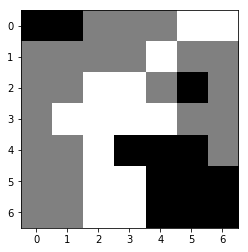

((0, 0), (2, 1)): n_v:   493 q_all:+0.058752 q:+0.023884 q_m:+0.080000 p:0.313602
((0, 1), (2, 1)): n_v:   484 q_all:+0.061776 q:+0.011359 q_m:+0.080000 p:0.299726
((2, 5), (2, 4)): n_v:   262 q_all:+0.089072 q:+0.040514 q_m:+0.140000 p:0.126982
((4, 3), (4, 1)): n_v:   231 q_all:+0.052690 q:+0.020703 q_m:+0.120000 p:0.154351
((0, 0), (1, 1)): n_v:    25 q_all:+0.042028 q:+0.034077 q_m:+0.020000 p:0.018319
((0, 1), (1, 2)): n_v:    18 q_all:+0.051803 q:+0.043725 q_m:+0.060000 p:0.012524
((4, 3), (2, 1)): n_v:    17 q_all:+0.055150 q:-0.004672 q_m:+0.080000 p:0.011562
((4, 3), (5, 1)): n_v:    17 q_all:+0.047552 q:+0.016315 q_m:+0.080000 p:0.011991
((0, 1), (1, 3)): n_v:    11 q_all:-0.005862 q:+0.037883 q_m:+0.080000 p:0.011508
((2, 5), (1, 5)): n_v:    10 q_all:+0.076462 q:+0.056139 q_m:+0.100000 p:0.005736
((0, 1), (0, 2)): n_v:     1 q_all:+0.013278 q:-0.003042 q_m:-0.020000 p:0.001256
((5, 6), (3, 6)): n_v:     0 q_all:-0.045390 q:-0.053475 q_m:-0.040000 p:0.000003
((6, 4), (4, 6))

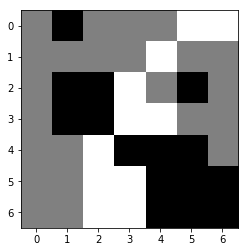

((3, 4), (3, 5)): n_v:   494 q_all:-0.035476 q:+0.006190 q_m:+0.060000 p:0.350198
((2, 3), (1, 2)): n_v:   261 q_all:+0.002429 q:-0.040687 q_m:+0.060000 p:0.134066
((3, 4), (4, 6)): n_v:   182 q_all:+0.040747 q:-0.029143 q_m:+0.040000 p:0.057568
((3, 4), (2, 6)): n_v:   131 q_all:-0.023274 q:-0.076556 q_m:-0.040000 p:0.084918
((4, 2), (4, 1)): n_v:    72 q_all:-0.030342 q:-0.037444 q_m:+0.020000 p:0.049454
((1, 4), (1, 2)): n_v:    46 q_all:+0.002762 q:-0.016666 q_m:+0.040000 p:0.023686
((3, 3), (3, 5)): n_v:    40 q_all:-0.006946 q:-0.002496 q_m:+0.040000 p:0.022516
((3, 4), (1, 2)): n_v:    33 q_all:+0.002020 q:-0.042282 q_m:+0.040000 p:0.016904
((1, 4), (3, 5)): n_v:    30 q_all:-0.018542 q:-0.004034 q_m:+0.040000 p:0.018897
((2, 3), (3, 5)): n_v:    26 q_all:-0.000743 q:-0.016361 q_m:+0.040000 p:0.014081
((3, 3), (1, 2)): n_v:    12 q_all:-0.001857 q:-0.055663 q_m:+0.040000 p:0.006818
((3, 4), (1, 5)): n_v:    11 q_all:-0.029593 q:-0.065774 q_m:-0.040000 p:0.008036
((3, 3), (1, 5))

((2, 2), (2, 4)): n_v:  2283 q_all:+0.086753 q:+0.016136 q_m:+0.180000 p:0.540905
((3, 2), (2, 4)): n_v:   629 q_all:+0.015485 q:+0.035013 q_m:+0.180000 p:0.307553
((4, 3), (2, 4)): n_v:    49 q_all:+0.065608 q:+0.002507 q_m:+0.180000 p:0.015233
((3, 1), (5, 1)): n_v:    31 q_all:+0.052860 q:-0.003604 q_m:+0.060000 p:0.011400
((4, 3), (5, 1)): n_v:    31 q_all:+0.047499 q:-0.027516 q_m:+0.060000 p:0.011859
((5, 5), (4, 6)): n_v:    28 q_all:+0.058711 q:-0.030161 q_m:+0.040000 p:0.009425
((3, 2), (5, 1)): n_v:    24 q_all:+0.008916 q:+0.017610 q_m:+0.060000 p:0.012266
((3, 1), (4, 1)): n_v:    23 q_all:+0.042635 q:-0.015010 q_m:+0.040000 p:0.009389
((0, 1), (1, 1)): n_v:     7 q_all:-0.047105 q:-0.021021 q_m:-0.040000 p:0.004959
((3, 1), (4, 0)): n_v:     6 q_all:-0.052240 q:-0.050992 q_m:-0.040000 p:0.005062
((0, 1), (1, 2)): n_v:     6 q_all:+0.009286 q:-0.058071 q_m:-0.000000 p:0.003503
((3, 1), (5, 0)): n_v:     5 q_all:-0.036346 q:-0.051181 q_m:-0.060000 p:0.003974
((2, 1), (3, 0))

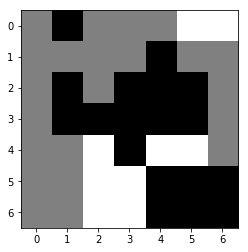

((0, 5), (1, 5)): n_v:  1451 q_all:-0.033395 q:-0.077805 q_m:-0.040000 p:0.128382
((4, 4), (2, 2)): n_v:   752 q_all:-0.054601 q:-0.081662 q_m:+0.020000 p:0.103750
((4, 5), (4, 6)): n_v:   469 q_all:-0.079915 q:-0.093753 q_m:-0.040000 p:0.115571
((4, 2), (4, 1)): n_v:   356 q_all:-0.093220 q:-0.132643 q_m:-0.080000 p:0.102959
((0, 5), (1, 3)): n_v:   244 q_all:-0.020224 q:-0.082901 q_m:-0.060000 p:0.011578
((4, 2), (2, 2)): n_v:   209 q_all:-0.097380 q:-0.073581 q_m:+0.020000 p:0.063232
((4, 2), (5, 1)): n_v:    33 q_all:-0.203943 q:-0.221901 q_m:-0.160000 p:0.022177
((4, 5), (2, 6)): n_v:    25 q_all:-0.102336 q:-0.159356 q_m:-0.100000 p:0.008217
((0, 6), (2, 6)): n_v:    12 q_all:-0.096035 q:-0.134387 q_m:-0.100000 p:0.003762
((4, 4), (2, 6)): n_v:    11 q_all:-0.161824 q:-0.191109 q_m:-0.100000 p:0.005969
((4, 2), (2, 0)): n_v:     9 q_all:-0.111145 q:-0.130312 q_m:-0.100000 p:0.003445
((6, 2), (4, 1)): n_v:     8 q_all:-0.083912 q:-0.182285 q_m:-0.100000 p:0.002293
((6, 3), (4, 1))

((3, 5), (1, 6)): n_v:  1619 q_all:+0.091849 q:+0.069016 q_m:+0.200000 p:0.376574
((3, 1), (1, 0)): n_v:   364 q_all:-0.011360 q:-0.030806 q_m:+0.040000 p:0.229133
((3, 1), (5, 0)): n_v:   286 q_all:-0.016846 q:-0.033828 q_m:+0.040000 p:0.185400
((3, 4), (1, 6)): n_v:    74 q_all:+0.065208 q:+0.071378 q_m:+0.200000 p:0.024940
((3, 1), (5, 1)): n_v:    65 q_all:+0.085690 q:+0.012828 q_m:+0.160000 p:0.016826
((3, 2), (1, 0)): n_v:    54 q_all:-0.042443 q:-0.037298 q_m:+0.040000 p:0.040586
((2, 3), (0, 4)): n_v:    49 q_all:+0.098794 q:+0.075889 q_m:+0.160000 p:0.010265
((2, 3), (1, 3)): n_v:    49 q_all:+0.034764 q:+0.004653 q_m:+0.140000 p:0.022505
((3, 2), (5, 0)): n_v:    39 q_all:-0.042090 q:-0.033523 q_m:+0.040000 p:0.029451
((2, 3), (0, 2)): n_v:    16 q_all:-0.011163 q:+0.008275 q_m:+0.040000 p:0.010518
((4, 3), (6, 1)): n_v:    10 q_all:+0.000223 q:-0.006702 q_m:+0.120000 p:0.006249
((3, 1), (4, 1)): n_v:     9 q_all:+0.068674 q:-0.006444 q_m:+0.140000 p:0.002974
((3, 2), (5, 1))

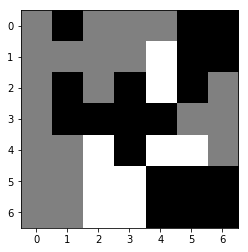

((1, 4), (2, 2)): n_v:  1657 q_all:-0.042523 q:-0.076341 q_m:-0.000000 p:0.547283
((4, 2), (2, 2)): n_v:   162 q_all:-0.096845 q:-0.096292 q_m:-0.000000 p:0.087174
((2, 4), (4, 6)): n_v:   158 q_all:-0.073790 q:-0.116005 q_m:-0.120000 p:0.071571
((4, 4), (2, 2)): n_v:   135 q_all:-0.028917 q:-0.089087 q_m:-0.000000 p:0.037723
((2, 4), (2, 2)): n_v:    76 q_all:-0.052575 q:-0.071336 q_m:-0.000000 p:0.028385
((1, 4), (0, 4)): n_v:    63 q_all:-0.079667 q:-0.053104 q_m:-0.100000 p:0.030047
((4, 5), (4, 6)): n_v:    57 q_all:-0.095173 q:-0.121234 q_m:-0.100000 p:0.030696
((4, 4), (2, 6)): n_v:    45 q_all:-0.065878 q:-0.103340 q_m:-0.080000 p:0.019180
((2, 4), (3, 5)): n_v:    39 q_all:-0.096288 q:-0.063346 q_m:-0.100000 p:0.021422
((2, 4), (2, 6)): n_v:    34 q_all:-0.093381 q:-0.099091 q_m:-0.080000 p:0.017963
((4, 4), (4, 6)): n_v:    32 q_all:-0.123626 q:-0.137695 q_m:-0.120000 p:0.020762
((4, 5), (2, 6)): n_v:    12 q_all:-0.105772 q:-0.109798 q_m:-0.080000 p:0.007342
((4, 2), (2, 0))

((0, 1), (1, 2)): n_v:  1332 q_all:+0.067833 q:+0.032799 q_m:+0.140000 p:0.301083
((3, 4), (1, 2)): n_v:   881 q_all:+0.129943 q:+0.014539 q_m:+0.120000 p:0.005917
((0, 5), (1, 4)): n_v:   424 q_all:+0.050048 q:+0.039428 q_m:+0.100000 p:0.122710
((2, 5), (3, 5)): n_v:    54 q_all:+0.067902 q:+0.028633 q_m:+0.140000 p:0.012249
((0, 1), (1, 1)): n_v:    51 q_all:+0.035719 q:+0.033999 q_m:+0.100000 p:0.017466
((1, 6), (1, 4)): n_v:    32 q_all:+0.036536 q:+0.027800 q_m:+0.080000 p:0.010963
((0, 6), (1, 4)): n_v:    31 q_all:+0.038489 q:+0.035917 q_m:+0.080000 p:0.010347
((0, 1), (1, 3)): n_v:    13 q_all:+0.055104 q:+0.034366 q_m:+0.120000 p:0.003612
((4, 3), (5, 1)): n_v:    11 q_all:+0.067406 q:+0.014039 q_m:+0.120000 p:0.002542
((1, 6), (3, 5)): n_v:     7 q_all:+0.067273 q:+0.020692 q_m:+0.120000 p:0.001630
((5, 6), (3, 5)): n_v:     5 q_all:+0.045231 q:-0.003127 q_m:+0.120000 p:0.001803
((1, 5), (3, 5)): n_v:     4 q_all:+0.069741 q:+0.032046 q_m:+0.120000 p:0.000980
((5, 5), (3, 5))

((2, 4), (1, 4)): n_v:  1273 q_all:-0.026842 q:-0.042600 q_m:+0.040000 p:0.429230
((3, 2), (1, 4)): n_v:   469 q_all:-0.042475 q:-0.063969 q_m:+0.020000 p:0.187410
((2, 4), (3, 5)): n_v:   128 q_all:-0.047803 q:-0.056886 q_m:-0.040000 p:0.054147
((2, 4), (1, 3)): n_v:    57 q_all:-0.033979 q:-0.077482 q_m:-0.000000 p:0.020962
((3, 1), (2, 0)): n_v:    41 q_all:-0.094693 q:-0.157965 q_m:-0.080000 p:0.025422
((3, 3), (1, 4)): n_v:    35 q_all:-0.051937 q:-0.062810 q_m:+0.020000 p:0.015385
((4, 2), (5, 1)): n_v:    26 q_all:-0.180731 q:-0.205533 q_m:-0.120000 p:0.024984
((3, 3), (1, 1)): n_v:    21 q_all:-0.040683 q:-0.113831 q_m:+0.020000 p:0.008478
((4, 5), (4, 6)): n_v:    17 q_all:-0.080622 q:-0.141684 q_m:-0.040000 p:0.009710
((3, 2), (1, 1)): n_v:    15 q_all:-0.087289 q:-0.115173 q_m:+0.020000 p:0.008722
((6, 3), (5, 1)): n_v:    14 q_all:-0.199264 q:-0.209200 q_m:-0.140000 p:0.015083
((3, 1), (1, 1)): n_v:     9 q_all:-0.030507 q:-0.106585 q_m:+0.020000 p:0.003260
((3, 3), (5, 1))

((2, 1), (4, 1)): n_v:   537 q_all:+0.055313 q:+0.000547 q_m:+0.120000 p:0.268898
((1, 2), (1, 3)): n_v:   475 q_all:+0.077673 q:+0.068874 q_m:+0.100000 p:0.193235
((3, 4), (3, 5)): n_v:   382 q_all:+0.085621 q:+0.050801 q_m:+0.140000 p:0.142969
((0, 1), (1, 3)): n_v:   188 q_all:+0.057434 q:+0.031689 q_m:+0.080000 p:0.092594
((5, 6), (3, 5)): n_v:    84 q_all:+0.062721 q:+0.016623 q_m:+0.120000 p:0.039744
((1, 2), (0, 4)): n_v:    73 q_all:+0.065911 q:+0.075879 q_m:+0.080000 p:0.033404
((2, 2), (4, 1)): n_v:    68 q_all:+0.045935 q:+0.012546 q_m:+0.120000 p:0.036775
((2, 2), (0, 4)): n_v:    66 q_all:+0.106063 q:+0.056151 q_m:+0.080000 p:0.019158
((3, 4), (1, 3)): n_v:    30 q_all:+0.062339 q:+0.037227 q_m:+0.080000 p:0.014279
((1, 6), (3, 5)): n_v:    21 q_all:+0.062824 q:+0.057448 q_m:+0.120000 p:0.009932
((5, 5), (3, 5)): n_v:    19 q_all:+0.104498 q:-0.011702 q_m:+0.120000 p:0.005744
((1, 6), (0, 4)): n_v:    15 q_all:+0.059476 q:+0.029413 q_m:+0.080000 p:0.007627
((2, 1), (1, 3))

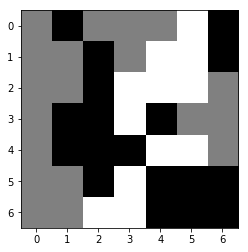

((6, 2), (5, 1)): n_v:  1285 q_all:-0.001223 q:-0.039500 q_m:+0.020000 p:0.487741
((6, 3), (5, 1)): n_v:   276 q_all:-0.048385 q:-0.066007 q_m:-0.000000 p:0.159188
((3, 3), (5, 1)): n_v:   258 q_all:-0.016947 q:-0.080621 q_m:-0.000000 p:0.115124
((3, 3), (1, 1)): n_v:   196 q_all:-0.022177 q:-0.082337 q_m:-0.000000 p:0.091800
((2, 3), (1, 1)): n_v:    91 q_all:-0.036245 q:-0.082398 q_m:-0.000000 p:0.048057
((5, 3), (5, 1)): n_v:    42 q_all:-0.081412 q:-0.056409 q_m:-0.000000 p:0.030013
((3, 3), (2, 1)): n_v:    22 q_all:-0.016743 q:-0.072646 q_m:+0.040000 p:0.010117
((1, 4), (1, 3)): n_v:    20 q_all:-0.077266 q:-0.073819 q_m:-0.020000 p:0.014502
((2, 3), (2, 1)): n_v:     3 q_all:-0.095789 q:-0.064599 q_m:+0.040000 p:0.002698
((4, 5), (4, 6)): n_v:     3 q_all:-0.078896 q:-0.077466 q_m:-0.020000 p:0.002765
((2, 3), (3, 5)): n_v:     1 q_all:-0.078683 q:-0.085625 q_m:-0.080000 p:0.001040
((6, 3), (6, 1)): n_v:     1 q_all:-0.101317 q:-0.102595 q_m:-0.080000 p:0.000747
((1, 5), (2, 6))

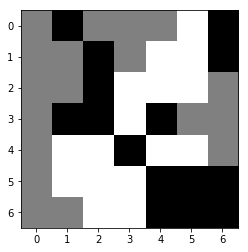

((4, 3), (6, 1)): n_v:  1277 q_all:+0.023496 q:-0.015273 q_m:+0.100000 p:0.619900
((3, 4), (3, 5)): n_v:   552 q_all:+0.090212 q:+0.040081 q_m:+0.160000 p:0.119853
((5, 6), (3, 5)): n_v:   126 q_all:+0.066779 q:+0.005572 q_m:+0.140000 p:0.039417
((1, 2), (1, 3)): n_v:    75 q_all:+0.050109 q:+0.041844 q_m:+0.120000 p:0.028523
((1, 2), (0, 4)): n_v:    72 q_all:+0.112565 q:+0.070842 q_m:+0.100000 p:0.009309
((3, 2), (1, 3)): n_v:    38 q_all:+0.003033 q:+0.009297 q_m:+0.100000 p:0.021996
((3, 2), (5, 0)): n_v:    33 q_all:+0.007699 q:-0.016752 q_m:+0.060000 p:0.018595
((3, 1), (1, 3)): n_v:    31 q_all:+0.050090 q:+0.028035 q_m:+0.100000 p:0.012038
((1, 6), (3, 5)): n_v:    27 q_all:+0.093397 q:+0.044812 q_m:+0.140000 p:0.005556
((2, 2), (0, 4)): n_v:    27 q_all:+0.058567 q:+0.041680 q_m:+0.100000 p:0.009602
((0, 1), (1, 3)): n_v:    24 q_all:+0.040424 q:+0.021364 q_m:+0.100000 p:0.010230
((4, 3), (3, 5)): n_v:    24 q_all:+0.012077 q:+0.001044 q_m:+0.140000 p:0.013258
((3, 1), (5, 0))

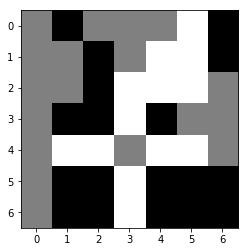

((3, 3), (4, 3)): n_v:  2078 q_all:-0.015023 q:-0.036014 q_m:+0.080000 p:0.227781
((4, 5), (4, 3)): n_v:  1979 q_all:+0.025739 q:-0.051147 q_m:+0.060000 p:0.009637
((2, 5), (4, 3)): n_v:  1689 q_all:+0.026713 q:-0.040069 q_m:+0.060000 p:0.003840
((6, 3), (4, 3)): n_v:   154 q_all:-0.014508 q:-0.038654 q_m:+0.060000 p:0.016757
((2, 3), (4, 3)): n_v:    38 q_all:-0.008004 q:-0.044292 q_m:+0.060000 p:0.003552
((2, 4), (4, 3)): n_v:    17 q_all:-0.036303 q:-0.043147 q_m:+0.060000 p:0.002950
((4, 1), (4, 3)): n_v:    13 q_all:-0.036199 q:-0.076947 q_m:+0.060000 p:0.002238
((3, 3), (2, 1)): n_v:     5 q_all:-0.020330 q:-0.062144 q_m:+0.060000 p:0.000732
((2, 3), (2, 1)): n_v:     1 q_all:-0.064190 q:-0.054401 q_m:+0.060000 p:0.000053
((3, 3), (1, 1)): n_v:     1 q_all:-0.082574 q:-0.104090 q_m:+0.020000 p:0.000390
((0, 5), (2, 6)): n_v:     0 q_all:-0.087607 q:-0.129016 q_m:-0.060000 p:0.000031
((4, 1), (4, 0)): n_v:     0 q_all:-0.044792 q:-0.111980 q_m:-0.000000 p:0.000055
((2, 3), (0, 4))

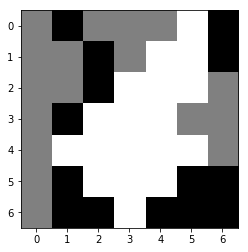

((5, 6), (3, 5)): n_v:  3465 q_all:+0.062203 q:-0.002557 q_m:+0.120000 p:0.702195
((1, 6), (3, 5)): n_v:   929 q_all:+0.082097 q:+0.043168 q_m:+0.120000 p:0.137672
((1, 2), (1, 3)): n_v:   284 q_all:+0.055145 q:+0.025614 q_m:+0.060000 p:0.063146
((5, 5), (3, 5)): n_v:    57 q_all:-0.032703 q:+0.015866 q_m:+0.120000 p:0.026666
((1, 2), (0, 4)): n_v:    44 q_all:+0.097727 q:+0.046096 q_m:+0.040000 p:0.004741
((2, 2), (0, 4)): n_v:    18 q_all:+0.089673 q:+0.001523 q_m:+0.040000 p:0.002400
((0, 1), (1, 3)): n_v:    14 q_all:+0.031323 q:+0.015070 q_m:+0.040000 p:0.004102
((3, 1), (1, 3)): n_v:    13 q_all:+0.038883 q:+0.015430 q_m:+0.040000 p:0.003719
((1, 6), (0, 4)): n_v:    12 q_all:+0.018179 q:-0.009271 q_m:+0.040000 p:0.004049
((0, 6), (0, 4)): n_v:     6 q_all:+0.011116 q:+0.009915 q_m:+0.040000 p:0.002306
((3, 1), (3, 0)): n_v:     1 q_all:-0.082297 q:-0.058828 q_m:-0.020000 p:0.000961
((0, 1), (0, 2)): n_v:     1 q_all:-0.106348 q:-0.058281 q_m:-0.060000 p:0.001023
((1, 2), (0, 3))

((4, 1), (5, 0)): n_v:  1377 q_all:-0.011776 q:-0.055999 q_m:-0.020000 p:0.074697
((1, 5), (2, 6)): n_v:  1283 q_all:-0.035501 q:-0.038019 q_m:+0.020000 p:0.151274
((1, 4), (1, 3)): n_v:  1072 q_all:-0.047229 q:-0.019672 q_m:+0.020000 p:0.159977
((4, 1), (4, 0)): n_v:   537 q_all:-0.023281 q:-0.064478 q_m:-0.020000 p:0.045720
((0, 5), (2, 6)): n_v:   259 q_all:-0.058078 q:-0.048788 q_m:-0.000000 p:0.046337
((3, 2), (2, 1)): n_v:   218 q_all:-0.066543 q:-0.035872 q_m:+0.020000 p:0.043848
((0, 5), (1, 3)): n_v:   150 q_all:-0.035447 q:-0.047335 q_m:-0.000000 p:0.017751
((3, 2), (5, 0)): n_v:    70 q_all:-0.119185 q:-0.082113 q_m:-0.040000 p:0.024012
((1, 5), (3, 6)): n_v:    45 q_all:-0.049336 q:-0.074566 q_m:-0.000000 p:0.007099
((1, 5), (1, 3)): n_v:    30 q_all:-0.030894 q:-0.059133 q_m:-0.000000 p:0.003239
((1, 4), (2, 6)): n_v:    25 q_all:-0.067707 q:-0.038854 q_m:-0.000000 p:0.005190
((2, 3), (1, 1)): n_v:    24 q_all:-0.065475 q:-0.035374 q_m:-0.000000 p:0.004911
((1, 4), (3, 6))

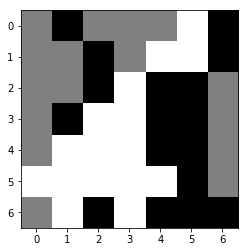

((3, 1), (4, 0)): n_v:  1013 q_all:+0.109610 q:+0.015166 q_m:+0.160000 p:0.051124
((1, 2), (0, 4)): n_v:   513 q_all:+0.037797 q:+0.056451 q_m:+0.140000 p:0.165214
((2, 2), (0, 4)): n_v:   431 q_all:+0.096364 q:+0.048171 q_m:+0.140000 p:0.043292
((1, 2), (1, 3)): n_v:   156 q_all:+0.040871 q:+0.017448 q_m:+0.120000 p:0.048551
((0, 6), (0, 4)): n_v:   120 q_all:+0.012683 q:+0.021360 q_m:+0.140000 p:0.050112
((3, 5), (4, 6)): n_v:    99 q_all:-0.034661 q:-0.071670 q_m:+0.040000 p:0.059298
((6, 6), (4, 6)): n_v:    72 q_all:-0.050164 q:-0.086282 q_m:+0.020000 p:0.047212
((1, 6), (2, 6)): n_v:    62 q_all:+0.008409 q:-0.037641 q_m:+0.080000 p:0.027032
((2, 4), (0, 2)): n_v:    31 q_all:-0.053547 q:-0.064774 q_m:+0.020000 p:0.021009
((1, 6), (0, 4)): n_v:    26 q_all:+0.006426 q:+0.007583 q_m:+0.140000 p:0.011845
((3, 1), (2, 0)): n_v:    25 q_all:-0.040098 q:-0.059406 q_m:+0.040000 p:0.015660
((0, 1), (0, 2)): n_v:    18 q_all:-0.050183 q:-0.076862 q_m:+0.040000 p:0.012235
((6, 2), (4, 0))

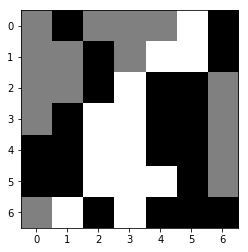

((1, 5), (2, 6)): n_v:  1146 q_all:-0.023729 q:-0.079210 q_m:-0.020000 p:0.085718
((1, 5), (3, 6)): n_v:  1069 q_all:-0.061323 q:-0.116838 q_m:-0.040000 p:0.193411
((1, 4), (3, 6)): n_v:   855 q_all:-0.080592 q:-0.094630 q_m:-0.040000 p:0.201039
((5, 4), (3, 6)): n_v:   730 q_all:-0.091241 q:-0.137013 q_m:-0.040000 p:0.193951
((6, 1), (6, 0)): n_v:   359 q_all:-0.021335 q:-0.056535 q_m:-0.060000 p:0.024456
((1, 4), (1, 3)): n_v:   311 q_all:-0.051459 q:-0.046051 q_m:-0.020000 p:0.047668
((5, 2), (3, 0)): n_v:   216 q_all:-0.194978 q:-0.104630 q_m:-0.040000 p:0.120681
((0, 5), (2, 6)): n_v:   115 q_all:-0.056071 q:-0.091699 q_m:-0.040000 p:0.019121
((3, 2), (2, 1)): n_v:    68 q_all:-0.086203 q:-0.066726 q_m:-0.020000 p:0.017202
((1, 4), (2, 6)): n_v:    49 q_all:-0.070430 q:-0.079195 q_m:-0.040000 p:0.010277
((4, 2), (3, 0)): n_v:    23 q_all:-0.193796 q:-0.086563 q_m:-0.040000 p:0.013184
((5, 4), (4, 6)): n_v:    15 q_all:-0.129050 q:-0.119467 q_m:-0.040000 p:0.005713
((2, 3), (2, 1))

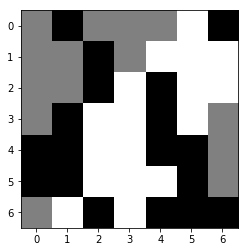

((4, 5), (3, 6)): n_v:  1535 q_all:+0.124839 q:+0.013788 q_m:+0.160000 p:0.178737
((2, 2), (0, 4)): n_v:   612 q_all:+0.074075 q:+0.040094 q_m:+0.140000 p:0.186176
((2, 4), (0, 2)): n_v:   201 q_all:+0.006993 q:-0.014258 q_m:+0.020000 p:0.111145
((1, 2), (0, 4)): n_v:   196 q_all:+0.047781 q:+0.050478 q_m:+0.140000 p:0.078781
((1, 2), (1, 3)): n_v:    97 q_all:+0.066613 q:+0.029805 q_m:+0.120000 p:0.032237
((3, 1), (3, 0)): n_v:    72 q_all:-0.021208 q:-0.040871 q_m:+0.040000 p:0.047575
((0, 6), (0, 4)): n_v:    56 q_all:+0.025872 q:+0.028564 q_m:+0.140000 p:0.027349
((5, 0), (6, 0)): n_v:    36 q_all:+0.041280 q:+0.016260 q_m:+0.080000 p:0.015567
((2, 4), (0, 4)): n_v:    16 q_all:+0.096825 q:+0.011243 q_m:+0.140000 p:0.003309
((0, 1), (0, 2)): n_v:    15 q_all:-0.040633 q:-0.041742 q_m:+0.040000 p:0.011535
((1, 2), (0, 3)): n_v:    14 q_all:-0.029304 q:-0.025922 q_m:+0.080000 p:0.009904
((4, 0), (6, 0)): n_v:    12 q_all:+0.000367 q:-0.007733 q_m:+0.060000 p:0.007138
((0, 1), (1, 3))

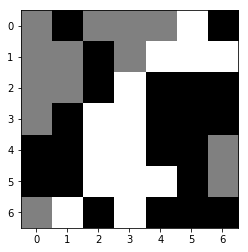

((6, 1), (6, 0)): n_v:  3968 q_all:-0.020591 q:-0.073351 q_m:-0.060000 p:0.068275
((1, 4), (1, 3)): n_v:  1273 q_all:-0.073421 q:-0.074745 q_m:-0.020000 p:0.188406
((5, 2), (3, 0)): n_v:   513 q_all:-0.195977 q:-0.119937 q_m:-0.040000 p:0.231879
((3, 2), (2, 1)): n_v:   274 q_all:-0.091579 q:-0.083559 q_m:-0.020000 p:0.052987
((5, 4), (4, 6)): n_v:   195 q_all:-0.094232 q:-0.107029 q_m:-0.000000 p:0.039005
((0, 5), (1, 3)): n_v:    56 q_all:-0.083632 q:-0.098552 q_m:-0.040000 p:0.009750
((4, 2), (2, 0)): n_v:    39 q_all:-0.260662 q:-0.240365 q_m:-0.120000 p:0.024305
((4, 2), (3, 0)): n_v:    27 q_all:-0.194497 q:-0.110206 q_m:-0.040000 p:0.012358
((2, 3), (1, 1)): n_v:    27 q_all:-0.068657 q:-0.116457 q_m:-0.040000 p:0.003689
((3, 2), (2, 0)): n_v:    27 q_all:-0.189403 q:-0.176625 q_m:-0.120000 p:0.011916
((3, 2), (1, 3)): n_v:    17 q_all:-0.115416 q:-0.095670 q_m:-0.040000 p:0.004295
((3, 2), (1, 0)): n_v:    15 q_all:-0.172080 q:-0.181772 q_m:-0.120000 p:0.006212
((3, 3), (1, 1))

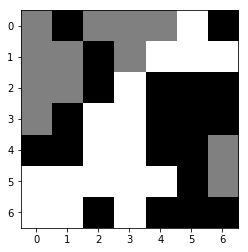

((2, 2), (0, 4)): n_v:  5505 q_all:+0.144987 q:+0.061111 q_m:+0.180000 p:0.058708
((1, 2), (0, 4)): n_v:  1108 q_all:+0.039250 q:+0.050031 q_m:+0.180000 p:0.159898
((0, 6), (0, 4)): n_v:   851 q_all:-0.000954 q:+0.026000 q_m:+0.180000 p:0.231541
((2, 6), (0, 4)): n_v:   685 q_all:+0.007765 q:-0.016650 q_m:+0.180000 p:0.167474
((1, 2), (1, 3)): n_v:   355 q_all:+0.062032 q:+0.026195 q_m:+0.160000 p:0.025429
((0, 1), (0, 2)): n_v:   149 q_all:-0.052351 q:-0.047422 q_m:+0.080000 p:0.063925
((2, 4), (0, 2)): n_v:    53 q_all:-0.040945 q:-0.051840 q_m:+0.060000 p:0.021521
((0, 1), (0, 0)): n_v:    30 q_all:-0.012842 q:-0.037042 q_m:+0.080000 p:0.009545
((0, 1), (1, 3)): n_v:    26 q_all:+0.043358 q:+0.007272 q_m:+0.140000 p:0.003542
((1, 2), (2, 1)): n_v:    23 q_all:-0.001838 q:-0.030545 q_m:+0.120000 p:0.006345
((6, 6), (4, 6)): n_v:    22 q_all:-0.031690 q:-0.051593 q_m:+0.060000 p:0.008428
((6, 5), (4, 6)): n_v:    19 q_all:-0.021504 q:-0.039806 q_m:+0.060000 p:0.006531
((1, 2), (0, 3))

((3, 2), (1, 3)): n_v:  7205 q_all:-0.067804 q:-0.042664 q_m:-0.020000 p:0.280572
((2, 3), (1, 3)): n_v:  1375 q_all:-0.150323 q:-0.069690 q_m:-0.000000 p:0.263537
((3, 3), (1, 3)): n_v:   711 q_all:-0.149470 q:-0.112576 q_m:-0.020000 p:0.134777
((5, 0), (3, 0)): n_v:   391 q_all:-0.149480 q:-0.071160 q_m:-0.060000 p:0.074191
((2, 3), (1, 1)): n_v:   233 q_all:-0.154231 q:-0.097604 q_m:-0.100000 p:0.048464
((5, 2), (3, 0)): n_v:   157 q_all:-0.242726 q:-0.134844 q_m:-0.060000 p:0.059723
((3, 3), (1, 1)): n_v:    86 q_all:-0.177278 q:-0.114727 q_m:-0.100000 p:0.021939
((2, 3), (2, 2)): n_v:    62 q_all:-0.163870 q:-0.085393 q_m:-0.080000 p:0.014091
((3, 2), (1, 1)): n_v:    60 q_all:-0.140238 q:-0.101522 q_m:-0.100000 p:0.010947
((2, 3), (0, 2)): n_v:    34 q_all:-0.161089 q:-0.080138 q_m:-0.100000 p:0.007590
((5, 1), (3, 0)): n_v:    29 q_all:-0.162070 q:-0.101628 q_m:-0.060000 p:0.006444
((3, 2), (1, 0)): n_v:    25 q_all:-0.205703 q:-0.123136 q_m:-0.140000 p:0.007995
((3, 2), (3, 0))

((3, 1), (3, 2)): n_v:  5420 q_all:+0.118963 q:+0.014860 q_m:+0.200000 p:0.151649
((0, 1), (0, 3)): n_v:  2588 q_all:+0.087059 q:+0.081483 q_m:+0.180000 p:0.196929
((0, 5), (0, 3)): n_v:  1160 q_all:+0.060055 q:+0.057561 q_m:+0.180000 p:0.159943
((4, 1), (2, 2)): n_v:   852 q_all:+0.146258 q:+0.031497 q_m:+0.180000 p:0.021710
((3, 1), (2, 2)): n_v:   687 q_all:+0.063130 q:+0.067712 q_m:+0.200000 p:0.090783
((1, 5), (0, 3)): n_v:   413 q_all:+0.051658 q:+0.051450 q_m:+0.180000 p:0.063407
((4, 0), (3, 2)): n_v:   338 q_all:+0.064327 q:+0.022841 q_m:+0.180000 p:0.043952
((4, 0), (2, 2)): n_v:   185 q_all:+0.049458 q:+0.052672 q_m:+0.180000 p:0.029181
((2, 5), (0, 3)): n_v:    94 q_all:+0.022336 q:+0.009397 q_m:+0.180000 p:0.019649
((0, 1), (1, 1)): n_v:    69 q_all:+0.040393 q:+0.002121 q_m:+0.080000 p:0.012192
((3, 1), (3, 0)): n_v:    57 q_all:-0.000100 q:-0.034965 q_m:+0.040000 p:0.014265
((3, 4), (2, 2)): n_v:    56 q_all:+0.047250 q:+0.044431 q_m:+0.180000 p:0.009204
((0, 1), (0, 2))

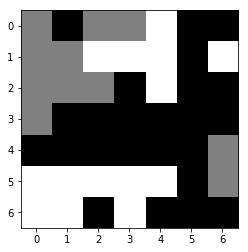

((1, 2), (2, 2)): n_v:  3682 q_all:-0.084432 q:-0.057834 q_m:-0.020000 p:0.251565
((1, 2), (3, 0)): n_v:  3181 q_all:-0.040929 q:-0.061670 q_m:-0.080000 p:0.001795
((2, 4), (2, 2)): n_v:  2478 q_all:-0.125993 q:-0.068641 q_m:-0.040000 p:0.411462
((0, 4), (2, 2)): n_v:   365 q_all:-0.104786 q:-0.070519 q_m:-0.040000 p:0.042518
((1, 4), (2, 2)): n_v:   241 q_all:-0.139102 q:-0.075692 q_m:-0.040000 p:0.046671
((5, 4), (4, 6)): n_v:    28 q_all:-0.125250 q:-0.103554 q_m:-0.040000 p:0.004753
((2, 4), (4, 6)): n_v:    26 q_all:-0.088938 q:-0.090126 q_m:-0.040000 p:0.001915
((5, 0), (3, 0)): n_v:    18 q_all:-0.133481 q:-0.122806 q_m:-0.080000 p:0.003438
((1, 2), (2, 0)): n_v:     7 q_all:-0.175789 q:-0.138861 q_m:-0.160000 p:0.002105
((5, 4), (5, 6)): n_v:     5 q_all:-0.158097 q:-0.100718 q_m:-0.040000 p:0.001158
((1, 2), (2, 1)): n_v:     5 q_all:-0.211182 q:-0.136538 q_m:-0.100000 p:0.001997
((5, 1), (3, 0)): n_v:     3 q_all:-0.237359 q:-0.199646 q_m:-0.080000 p:0.001145
((1, 2), (1, 1))

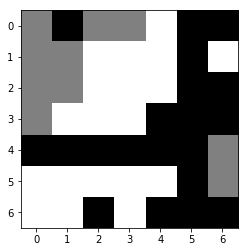

((4, 0), (2, 1)): n_v:  3551 q_all:+0.121414 q:+0.039807 q_m:+0.180000 p:0.386353
((0, 1), (0, 3)): n_v:  1937 q_all:+0.133081 q:+0.103897 q_m:+0.180000 p:0.162307
((0, 1), (2, 1)): n_v:   719 q_all:+0.130493 q:+0.029822 q_m:+0.180000 p:0.064162
((0, 5), (0, 3)): n_v:   649 q_all:+0.096397 q:+0.043790 q_m:+0.180000 p:0.105551
((4, 3), (2, 1)): n_v:   440 q_all:+0.109377 q:+0.015494 q_m:+0.180000 p:0.059363
((4, 2), (2, 1)): n_v:   360 q_all:+0.085344 q:+0.022196 q_m:+0.180000 p:0.067227
((4, 1), (2, 1)): n_v:   275 q_all:+0.081282 q:-0.004210 q_m:+0.180000 p:0.053771
((0, 1), (0, 0)): n_v:   180 q_all:+0.040217 q:-0.024234 q_m:+0.040000 p:0.051169
((1, 5), (0, 3)): n_v:   120 q_all:+0.091367 q:+0.044987 q_m:+0.180000 p:0.020792
((4, 0), (3, 0)): n_v:    67 q_all:+0.062746 q:-0.016380 q_m:+0.080000 p:0.015904
((2, 5), (0, 3)): n_v:    40 q_all:+0.126050 q:-0.011492 q_m:+0.180000 p:0.003821
((0, 1), (0, 2)): n_v:    10 q_all:+0.068493 q:+0.009779 q_m:+0.120000 p:0.002331
((0, 1), (1, 1))

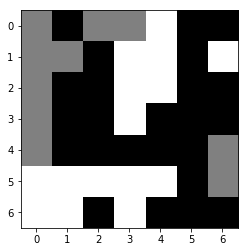

((5, 4), (4, 6)): n_v:  4098 q_all:-0.046546 q:-0.068437 q_m:-0.020000 p:0.054076
((3, 3), (1, 1)): n_v:  1067 q_all:-0.080848 q:-0.038806 q_m:-0.020000 p:0.093258
((5, 0), (4, 0)): n_v:  1002 q_all:-0.109882 q:-0.092226 q_m:-0.080000 p:0.150607
((6, 0), (4, 0)): n_v:   680 q_all:-0.142780 q:-0.117588 q_m:-0.100000 p:0.150664
((5, 0), (3, 0)): n_v:   282 q_all:-0.093287 q:-0.109722 q_m:-0.060000 p:0.032313
((5, 4), (5, 6)): n_v:   140 q_all:-0.128072 q:-0.074125 q_m:-0.020000 p:0.026631
((5, 1), (3, 0)): n_v:   134 q_all:-0.171233 q:-0.150165 q_m:-0.060000 p:0.038094
((2, 3), (1, 1)): n_v:    97 q_all:-0.150457 q:-0.118201 q_m:-0.020000 p:0.023304
((1, 3), (1, 1)): n_v:    75 q_all:-0.115383 q:-0.062061 q_m:-0.020000 p:0.012491
((5, 2), (4, 0)): n_v:    72 q_all:-0.215777 q:-0.188746 q_m:-0.100000 p:0.027591
((2, 4), (4, 6)): n_v:    70 q_all:-0.122733 q:-0.058573 q_m:-0.020000 p:0.012567
((6, 1), (4, 0)): n_v:    69 q_all:-0.165068 q:-0.193009 q_m:-0.100000 p:0.018831
((5, 2), (3, 0))

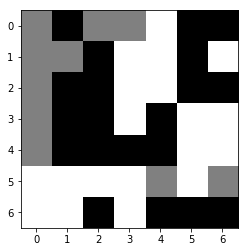

((4, 3), (5, 4)): n_v:  7413 q_all:+0.081971 q:+0.066612 q_m:+0.200000 p:0.203470
((6, 6), (5, 4)): n_v:  1383 q_all:+0.060152 q:+0.060085 q_m:+0.180000 p:0.039251
((6, 2), (5, 4)): n_v:    99 q_all:+0.025728 q:+0.025857 q_m:+0.180000 p:0.013541
((4, 2), (5, 4)): n_v:    31 q_all:+0.020000 q:+0.030008 q_m:+0.180000 p:0.004839
((6, 5), (5, 6)): n_v:    29 q_all:-0.033114 q:+0.042237 q_m:+0.160000 p:0.008050
((3, 4), (5, 4)): n_v:    16 q_all:+0.031665 q:+0.004747 q_m:+0.180000 p:0.001885
((6, 4), (5, 6)): n_v:    15 q_all:+0.065167 q:+0.021867 q_m:+0.140000 p:0.000976
((3, 4), (5, 6)): n_v:    12 q_all:+0.001813 q:-0.000218 q_m:+0.140000 p:0.002427
((3, 2), (5, 4)): n_v:     9 q_all:+0.005386 q:-0.003899 q_m:+0.180000 p:0.001695
((1, 2), (0, 3)): n_v:     4 q_all:+0.006845 q:+0.013899 q_m:+0.160000 p:0.000804
((0, 1), (1, 0)): n_v:     1 q_all:-0.068528 q:-0.064058 q_m:+0.040000 p:0.000402
((3, 1), (4, 0)): n_v:     1 q_all:+0.005942 q:-0.016994 q_m:+0.120000 p:0.000053
((2, 1), (0, 3))

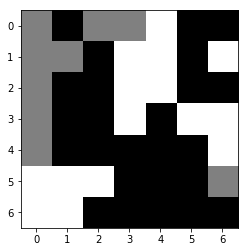

((4, 6), (5, 6)): n_v: 11958 q_all:-0.059065 q:-0.057387 q_m:-0.020000 p:0.956129
((3, 6), (5, 6)): n_v:   250 q_all:-0.084527 q:-0.077830 q_m:-0.040000 p:0.031512
((3, 5), (5, 6)): n_v:    30 q_all:-0.119458 q:-0.063618 q_m:-0.040000 p:0.005763
((3, 3), (1, 1)): n_v:    19 q_all:-0.098292 q:-0.148856 q_m:-0.040000 p:0.002961
((5, 2), (3, 0)): n_v:     2 q_all:-0.170858 q:-0.141775 q_m:-0.080000 p:0.000683
((2, 3), (1, 1)): n_v:     1 q_all:-0.189694 q:-0.220976 q_m:-0.040000 p:0.000585
((5, 0), (4, 0)): n_v:     1 q_all:-0.128436 q:-0.214049 q_m:-0.100000 p:0.000335
((1, 3), (1, 1)): n_v:     1 q_all:-0.179872 q:-0.196079 q_m:-0.040000 p:0.000475
((5, 1), (3, 0)): n_v:     1 q_all:-0.203508 q:-0.197230 q_m:-0.080000 p:0.000464
((6, 1), (4, 0)): n_v:     0 q_all:-0.231382 q:-0.305637 q_m:-0.120000 p:0.000005
((2, 3), (0, 3)): n_v:     0 q_all:-0.221713 q:-0.262855 q_m:-0.160000 p:0.000001
((5, 2), (4, 0)): n_v:     0 q_all:-0.168542 q:-0.200903 q_m:-0.120000 p:0.000017
((0, 4), (0, 2))

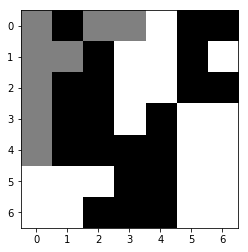

((1, 2), (0, 3)): n_v:  8834 q_all:+0.076922 q:+0.039241 q_m:+0.160000 p:0.507347
((0, 1), (0, 3)): n_v:  4259 q_all:+0.114924 q:+0.049415 q_m:+0.140000 p:0.012936
((3, 1), (4, 0)): n_v:   463 q_all:+0.044451 q:+0.025909 q_m:+0.120000 p:0.051597
((6, 2), (4, 0)): n_v:   340 q_all:+0.017641 q:-0.028402 q_m:+0.100000 p:0.051879
((2, 1), (2, 0)): n_v:   219 q_all:-0.027119 q:-0.035330 q_m:+0.040000 p:0.048557
((0, 1), (0, 0)): n_v:   165 q_all:-0.014852 q:-0.004945 q_m:+0.040000 p:0.033520
((2, 1), (0, 3)): n_v:    86 q_all:+0.053810 q:+0.017277 q_m:+0.140000 p:0.008318
((0, 5), (0, 3)): n_v:    72 q_all:+0.042091 q:+0.006383 q_m:+0.140000 p:0.008320
((1, 5), (0, 3)): n_v:    55 q_all:+0.032680 q:-0.002258 q_m:+0.140000 p:0.007228
((2, 5), (0, 3)): n_v:    36 q_all:+0.041878 q:+0.004404 q_m:+0.140000 p:0.004175
((0, 1), (1, 0)): n_v:    28 q_all:-0.027175 q:-0.018691 q_m:+0.040000 p:0.006243
((2, 2), (0, 3)): n_v:    24 q_all:+0.048106 q:+0.032866 q_m:+0.140000 p:0.002522
((3, 2), (4, 0))

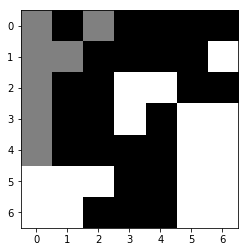

((3, 3), (1, 1)): n_v:  5009 q_all:-0.074626 q:-0.105623 q_m:-0.000000 p:0.520109
((2, 3), (1, 1)): n_v:  1855 q_all:-0.080764 q:-0.083491 q_m:-0.000000 p:0.211912
((5, 0), (3, 0)): n_v:  1302 q_all:-0.066401 q:-0.095993 q_m:-0.040000 p:0.117012
((2, 3), (0, 2)): n_v:   641 q_all:-0.063344 q:-0.007320 q_m:-0.000000 p:0.054309
((5, 2), (3, 0)): n_v:   604 q_all:-0.038139 q:-0.107256 q_m:-0.040000 p:0.025250
((2, 4), (0, 2)): n_v:   286 q_all:-0.072513 q:-0.026777 q_m:-0.000000 p:0.028578
((5, 1), (3, 0)): n_v:   188 q_all:-0.076070 q:-0.135799 q_m:-0.040000 p:0.020026
((5, 2), (4, 0)): n_v:    44 q_all:-0.113347 q:-0.117288 q_m:-0.080000 p:0.007607
((6, 0), (4, 0)): n_v:    37 q_all:-0.090045 q:-0.073472 q_m:-0.080000 p:0.004932
((5, 0), (4, 0)): n_v:    29 q_all:-0.079181 q:-0.080712 q_m:-0.060000 p:0.003335
((6, 1), (4, 0)): n_v:    10 q_all:-0.145452 q:-0.177620 q_m:-0.080000 p:0.002395
-1 's turn


This is a random move


one move takes time(s):  0.9595186710357666


((3, 2), (3, 3)): n_v:  6962 q_all:+0.124235 q:+0.047889 q_m:+0.140000 p:0.133334
((0, 3), (0, 2)): n_v:   340 q_all:+0.009727 q:+0.046441 q_m:+0.140000 p:0.084570
((3, 2), (4, 0)): n_v:   125 q_all:+0.077280 q:-0.023918 q_m:+0.080000 p:0.014223
((3, 2), (1, 0)): n_v:    83 q_all:+0.020933 q:+0.019048 q_m:+0.120000 p:0.018746
((3, 1), (2, 0)): n_v:    69 q_all:-0.010218 q:-0.024895 q_m:+0.100000 p:0.019963
((4, 1), (3, 3)): n_v:    58 q_all:+0.104899 q:-0.013527 q_m:+0.120000 p:0.003392
((0, 4), (0, 2)): n_v:    53 q_all:+0.011825 q:-0.015903 q_m:+0.120000 p:0.012862
((3, 1), (4, 0)): n_v:    50 q_all:-0.004450 q:+0.009666 q_m:+0.100000 p:0.013766
((3, 1), (1, 0)): n_v:    30 q_all:+0.025845 q:+0.009577 q_m:+0.120000 p:0.006681
((3, 2), (2, 0)): n_v:    23 q_all:-0.000462 q:-0.028496 q_m:+0.080000 p:0.006233
((2, 5), (3, 3)): n_v:    21 q_all:+0.018912 q:-0.011890 q_m:+0.120000 p:0.004906
((6, 2), (4, 0)): n_v:    18 q_all:+0.012998 q:-0.046571 q_m:+0.080000 p:0.004505
((1, 4), (3, 3))

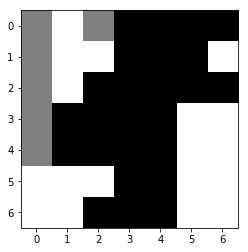

((0, 1), (0, 2)): n_v:  6225 q_all:-0.107802 q:-0.214720 q_m:-0.040000 p:0.169021
((5, 0), (4, 0)): n_v:  2662 q_all:-0.126411 q:-0.179038 q_m:-0.040000 p:0.162739
((2, 1), (4, 0)): n_v:  1651 q_all:-0.093471 q:-0.320891 q_m:-0.060000 p:0.001513
((6, 0), (4, 0)): n_v:   503 q_all:-0.171305 q:-0.215695 q_m:-0.060000 p:0.072142
((2, 1), (0, 2)): n_v:   248 q_all:-0.137764 q:-0.273796 q_m:-0.060000 p:0.020288
((1, 1), (2, 0)): n_v:   154 q_all:-0.211002 q:-0.253521 q_m:-0.080000 p:0.033452
((5, 2), (4, 0)): n_v:   133 q_all:-0.164702 q:-0.218089 q_m:-0.060000 p:0.017577
((6, 1), (4, 0)): n_v:    67 q_all:-0.222343 q:-0.265412 q_m:-0.060000 p:0.016002
((0, 1), (2, 0)): n_v:    24 q_all:-0.184941 q:-0.235224 q_m:-0.100000 p:0.004156
((1, 2), (2, 0)): n_v:    24 q_all:-0.194216 q:-0.241342 q_m:-0.100000 p:0.004539
((5, 0), (3, 0)): n_v:    18 q_all:-0.200831 q:-0.274822 q_m:-0.060000 p:0.003631
((2, 1), (3, 0)): n_v:    12 q_all:-0.166809 q:-0.198296 q_m:-0.040000 p:0.001683
((0, 1), (1, 0))

((3, 1), (2, 0)): n_v:  6005 q_all:+0.107807 q:+0.027588 q_m:+0.140000 p:0.381286
((3, 1), (4, 0)): n_v:  4474 q_all:+0.099013 q:+0.094558 q_m:+0.140000 p:0.358425
((3, 1), (1, 0)): n_v:   153 q_all:+0.109526 q:+0.065305 q_m:+0.160000 p:0.009249
((3, 1), (3, 0)): n_v:    40 q_all:+0.048635 q:-0.101947 q_m:+0.100000 p:0.007143
((6, 2), (4, 0)): n_v:    33 q_all:+0.045748 q:-0.002304 q_m:+0.120000 p:0.005811
((2, 2), (1, 0)): n_v:    12 q_all:+0.057562 q:+0.034710 q_m:+0.160000 p:0.001995
((4, 1), (2, 0)): n_v:     5 q_all:+0.048297 q:-0.010196 q_m:+0.120000 p:0.000962
((3, 2), (1, 0)): n_v:     4 q_all:+0.055014 q:+0.022923 q_m:+0.160000 p:0.000717
((3, 2), (2, 0)): n_v:     2 q_all:+0.005762 q:-0.053756 q_m:+0.120000 p:0.000517
((3, 2), (4, 0)): n_v:     1 q_all:-0.030123 q:-0.002469 q_m:+0.120000 p:0.000248
((2, 2), (2, 0)): n_v:     1 q_all:-0.013286 q:-0.011807 q_m:+0.120000 p:0.000302
((4, 2), (4, 0)): n_v:     1 q_all:-0.061340 q:-0.072388 q_m:+0.120000 p:0.000411
((2, 2), (4, 0))

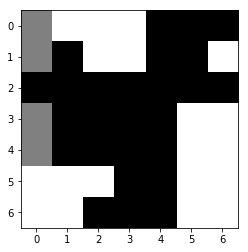

((0, 1), (1, 0)): n_v:  6234 q_all:-0.006117 q:-0.084786 q_m:-0.000000 p:0.202452
((5, 0), (3, 0)): n_v:  1924 q_all:-0.095865 q:-0.184364 q_m:+0.020000 p:0.311380
((0, 2), (1, 0)): n_v:   671 q_all:-0.128337 q:-0.174522 q_m:-0.020000 p:0.164824
((5, 2), (3, 0)): n_v:   471 q_all:-0.106794 q:-0.197945 q_m:+0.020000 p:0.089685
((5, 1), (3, 0)): n_v:   310 q_all:-0.166251 q:-0.253889 q_m:+0.020000 p:0.104608
((1, 2), (3, 0)): n_v:   154 q_all:-0.166790 q:-0.218188 q_m:+0.020000 p:0.052492
((6, 0), (4, 0)): n_v:    39 q_all:-0.235288 q:-0.344209 q_m:-0.060000 p:0.018703
((5, 0), (4, 0)): n_v:    29 q_all:-0.230092 q:-0.357264 q_m:-0.040000 p:0.013595
((6, 1), (4, 0)): n_v:    22 q_all:-0.276960 q:-0.419945 q_m:-0.060000 p:0.012281
((1, 2), (1, 0)): n_v:    14 q_all:-0.200243 q:-0.140593 q_m:-0.020000 p:0.006015
((5, 2), (4, 0)): n_v:     6 q_all:-0.229528 q:-0.452056 q_m:-0.060000 p:0.003143
((0, 2), (0, 0)): n_v:     0 q_all:-0.291709 q:-0.419515 q_m:-0.100000 p:0.000067
((1, 2), (0, 0))

((3, 1), (3, 0)): n_v:  8564 q_all:-0.047707 q:+0.198537 q_m:+0.100000 p:0.241128
((2, 2), (4, 0)): n_v:  1216 q_all:-0.033447 q:-0.000332 q_m:+0.080000 p:0.001580
((3, 1), (4, 0)): n_v:   856 q_all:-0.217381 q:-0.114915 q_m:+0.100000 p:0.297935
((6, 2), (4, 0)): n_v:   223 q_all:-0.072931 q:-0.151156 q_m:+0.080000 p:0.016940
((2, 2), (0, 0)): n_v:    30 q_all:-0.110808 q:-0.399422 q_m:+0.120000 p:0.004564
((2, 2), (3, 0)): n_v:     7 q_all:-0.148693 q:-0.040669 q_m:+0.080000 p:0.001543
((3, 2), (4, 0)): n_v:     4 q_all:-0.208369 q:-0.099925 q_m:+0.080000 p:0.001603
((4, 2), (3, 0)): n_v:     4 q_all:-0.205745 q:-0.349072 q_m:+0.080000 p:0.001609
((3, 2), (3, 0)): n_v:     2 q_all:-0.213513 q:-0.146426 q_m:+0.080000 p:0.000684
((4, 2), (4, 0)): n_v:     2 q_all:-0.285510 q:-0.738731 q_m:+0.080000 p:0.001106
1 's turn


This is a random move


one move takes time(s):  0.13239693641662598


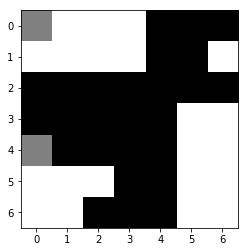

((5, 0), (4, 0)): n_v:  9439 q_all:+0.567305 q:+0.009683 q_m:+0.040000 p:0.302941
((6, 0), (4, 0)): n_v:  3341 q_all:+0.010624 q:-0.196083 q_m:+0.020000 p:0.423700
((6, 1), (4, 0)): n_v:    82 q_all:-0.172039 q:-0.275921 q_m:+0.020000 p:0.045260
((5, 2), (4, 0)): n_v:    38 q_all:-0.151925 q:-0.244322 q_m:+0.020000 p:0.018848
((0, 2), (0, 0)): n_v:     0 q_all:-0.512884 q:-0.788140 q_m:-0.100000 p:0.000001
((0, 1), (0, 0)): n_v:     0 q_all:-0.447502 q:-0.692503 q_m:-0.080000 p:0.000003
((1, 2), (0, 0)): n_v:     0 q_all:-0.522191 q:-0.803651 q_m:-0.100000 p:0.000000
-1 's turn
one move takes time(s):  0.10448145866394043


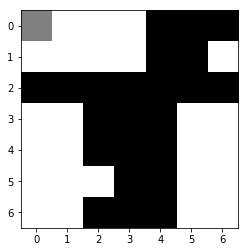

((2, 0), (0, 0)): n_v:  5538 q_all:-0.934527 q:-0.935911 q_m:+0.080000 p:0.541916
((2, 1), (0, 0)): n_v:  4671 q_all:-0.919733 q:-0.560401 q_m:+0.080000 p:0.342182
((2, 2), (0, 0)): n_v:   758 q_all:-0.957823 q:-0.990742 q_m:+0.080000 p:0.103646
1 's turn
one move takes time(s):  0.07005167007446289


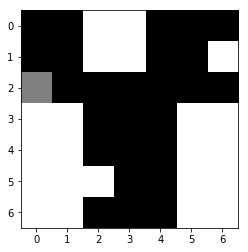

((3, 0), (2, 0)): n_v:  9940 q_all:+1.000000 q:+5.000000 q_m:+0.060000 p:0.218810
((1, 2), (2, 0)): n_v:    80 q_all:-0.160253 q:+0.244227 q_m:+0.040000 p:0.183806
((4, 0), (2, 0)): n_v:    75 q_all:-0.120806 q:-0.076092 q_m:+0.040000 p:0.167278
((0, 2), (2, 0)): n_v:    45 q_all:-0.422186 q:-0.216698 q_m:+0.040000 p:0.125620
((4, 1), (2, 0)): n_v:     0 q_all:-0.199970 q:-0.359950 q_m:+0.040000 p:0.002312
this self play has 68 steps, time elapsed 125.52005386352539
winner is 1.0
episode 136 finished
episode 137 now start
it seems the reset did nothing
reset successful
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.8297276496887207
1 's turn


This is a random move


one move takes time(s):  1.0780916213989258
-1 's turn


This is a random move


one move takes time(s):  1.6932551860809326
1 's turn


This is a random move


one move takes time(s):  1.7157154083251953
-1 's turn
due to rollout lim, final rollout times:  4114 time el

one move takes time(s):  0.8881206512451172
1 's turn


This is a random move


one move takes time(s):  1.1476566791534424
-1 's turn


This is a random move


one move takes time(s):  1.903275489807129
1 's turn
due to rollout lim, final rollout times:  2098 time elapsed:  2.0142295360565186


This is a random move


one move takes time(s):  2.0154008865356445
-1 's turn
due to rollout lim, final rollout times:  1277 time elapsed:  2.0000009536743164


This is a random move


one move takes time(s):  2.0011355876922607
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.4995789527893066
one move takes time(s):  2.5008440017700195
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.246037721633911


This is a random move


one move takes time(s):  2.2475202083587646
1 's turn
due to rollout lim, final rollout times:  1733 time elapsed:  2.004220485687256
one move takes time(s):  2.005453109741211
-1 's turn
one move takes time(s):  1.673968

10506/10506 [==============================] - 1s 142us/step - loss: 2.1921 - activation_101_loss: 2.1582 - dense_51_loss: 0.0068 - val_loss: 2.1168 - val_activation_101_loss: 2.0795 - val_dense_51_loss: 0.0102
Epoch 2/64
10506/10506 [==============================] - 1s 120us/step - loss: 2.1071 - activation_101_loss: 2.0744 - dense_51_loss: 0.0057 - val_loss: 2.0894 - val_activation_101_loss: 2.0529 - val_dense_51_loss: 0.0094
Epoch 3/64
10506/10506 [==============================] - 1s 113us/step - loss: 2.0631 - activation_101_loss: 2.0311 - dense_51_loss: 0.0049 - val_loss: 2.0638 - val_activation_101_loss: 2.0266 - val_dense_51_loss: 0.0101
Epoch 4/64
10506/10506 [==============================] - 1s 108us/step - loss: 2.0328 - activation_101_loss: 2.0012 - dense_51_loss: 0.0046 - val_loss: 2.0515 - val_activation_101_loss: 2.0155 - val_dense_51_loss: 0.0090
Epoch 5/64
10506/10506 [==============================] - 1s 107us/step - loss: 2.0089 - activation_101_loss: 1.9775 - dens

due to rollout lim, final rollout times:  2548 time elapsed:  2.0090394020080566
one move takes time(s):  2.011329412460327
-1 's turn
due to rollout lim, final rollout times:  1423 time elapsed:  2.0049545764923096


This is a random move


one move takes time(s):  2.0062220096588135
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.020083427429199
one move takes time(s):  2.02126407623291
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.6121413707733154


This is a random move


one move takes time(s):  2.6135647296905518
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.0650391578674316


This is a random move


one move takes time(s):  3.066394567489624
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.3835349082946777


This is a random move


one move takes time(s):  2.384906530380249
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.6994357109069824
one move

due to rollout lim, final rollout times:  1335 time elapsed:  2.010566234588623
one move takes time(s):  2.0117807388305664
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.760303258895874
one move takes time(s):  2.761592149734497
1 's turn
due to rollout lim, final rollout times:  1073 time elapsed:  2.0010251998901367
one move takes time(s):  2.0022830963134766
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.8160884380340576
one move takes time(s):  2.8174870014190674
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.830009698867798
one move takes time(s):  3.8312480449676514
-1 's turn
due to rollout lim, final rollout times:  1146 time elapsed:  2.0002119541168213
one move takes time(s):  2.0016109943389893
1 's turn
due to rollout lim, final rollout times:  2471 time elapsed:  2.000096559524536
one move takes time(s):  2.002332925796509
-1 's turn


This is a random move


one move takes time(s):  1.9584

due to rollout lim, final rollout times:  3354 time elapsed:  2.0099587440490723
one move takes time(s):  2.0111732482910156
-1 's turn
due to rollout lim, final rollout times:  2646 time elapsed:  2.0000548362731934
one move takes time(s):  2.0013394355773926
1 's turn
one move takes time(s):  1.6399235725402832
-1 's turn
one move takes time(s):  1.3831884860992432
1 's turn


This is a random move


one move takes time(s):  1.5083668231964111
-1 's turn
due to rollout lim, final rollout times:  3658 time elapsed:  2.0001049041748047
one move takes time(s):  2.0017735958099365
1 's turn
due to rollout lim, final rollout times:  2551 time elapsed:  2.0133919715881348
one move takes time(s):  2.0146496295928955
-1 's turn
due to rollout lim, final rollout times:  4060 time elapsed:  2.0032339096069336
one move takes time(s):  2.0045316219329834
1 's turn
due to rollout lim, final rollout times:  3545 time elapsed:  2.0079824924468994
one move takes time(s):  2.0092365741729736
-1 's tu

one move takes time(s):  0.8767330646514893
1 's turn
one move takes time(s):  1.1107454299926758
-1 's turn


This is a random move


one move takes time(s):  1.950566053390503
1 's turn


This is a random move


one move takes time(s):  1.917135238647461
-1 's turn
due to rollout lim, final rollout times:  2889 time elapsed:  2.0022599697113037


This is a random move


one move takes time(s):  2.0034356117248535
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.003234386444092
one move takes time(s):  2.004368782043457
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.5291733741760254
one move takes time(s):  2.5304558277130127
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.404438018798828
one move takes time(s):  3.405679225921631
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.259152889251709
one move takes time(s):  3.261249542236328
1 's turn
due to rollout lim, final rollout t



This is a random move


one move takes time(s):  1.1037671566009521
-1 's turn


This is a random move


one move takes time(s):  1.773237705230713
1 's turn


This is a random move


one move takes time(s):  1.634333610534668
-1 's turn
due to rollout lim, final rollout times:  4968 time elapsed:  2.0026512145996094


This is a random move


one move takes time(s):  2.003741502761841
1 's turn
due to rollout lim, final rollout times:  2470 time elapsed:  2.000377893447876
one move takes time(s):  2.0015640258789062
-1 's turn
due to rollout lim, final rollout times:  1226 time elapsed:  2.0097217559814453
one move takes time(s):  2.010890245437622
1 's turn
due to rollout lim, final rollout times:  1459 time elapsed:  2.0101544857025146


This is a random move


one move takes time(s):  2.0115129947662354
-1 's turn
due to rollout lim, final rollout times:  1656 time elapsed:  2.01098895072937
one move takes time(s):  2.0122692584991455
1 's turn
one move takes time(s):  1.406565904

one move takes time(s):  0.27512550354003906
1 's turn
one move takes time(s):  0.24797844886779785
-1 's turn
one move takes time(s):  0.2186417579650879
1 's turn
one move takes time(s):  0.184492826461792
-1 's turn
one move takes time(s):  0.2603611946105957
1 's turn
one move takes time(s):  0.22933077812194824
-1 's turn
one move takes time(s):  0.18469882011413574
1 's turn


This is a random move


one move takes time(s):  0.16847681999206543
-1 's turn
one move takes time(s):  0.1950206756591797
1 's turn
one move takes time(s):  0.17951226234436035
-1 's turn
one move takes time(s):  0.14426589012145996
1 's turn
one move takes time(s):  0.15105819702148438
-1 's turn
one move takes time(s):  0.15442562103271484
1 's turn


This is a random move


one move takes time(s):  0.12044334411621094
this self play has 94 steps, time elapsed 135.95818734169006
winner is 1.0
episode 143 finished
episode 144 now start
it seems the reset did nothing
reset successful
left space is 45
star

10444/10444 [==============================] - 2s 147us/step - loss: 2.1029 - activation_101_loss: 2.0658 - dense_51_loss: 0.0100 - val_loss: 2.2675 - val_activation_101_loss: 2.2335 - val_dense_51_loss: 0.0069
Epoch 2/64
10444/10444 [==============================] - 1s 124us/step - loss: 2.0235 - activation_101_loss: 1.9886 - dense_51_loss: 0.0078 - val_loss: 2.2679 - val_activation_101_loss: 2.2339 - val_dense_51_loss: 0.0070
Epoch 3/64
10444/10444 [==============================] - 1s 118us/step - loss: 1.9752 - activation_101_loss: 1.9415 - dense_51_loss: 0.0067 - val_loss: 2.2637 - val_activation_101_loss: 2.2305 - val_dense_51_loss: 0.0061
Epoch 4/64
10444/10444 [==============================] - 1s 107us/step - loss: 1.9457 - activation_101_loss: 1.9123 - dense_51_loss: 0.0063 - val_loss: 2.2704 - val_activation_101_loss: 2.2374 - val_dense_51_loss: 0.0059
Epoch 5/64
10444/10444 [==============================] - 1s 105us/step - loss: 1.9242 - activation_101_loss: 1.8914 - dens

one move takes time(s):  1.9508893489837646
-1 's turn
one move takes time(s):  1.182680606842041
1 's turn
due to rollout lim, final rollout times:  4622 time elapsed:  2.000120162963867
one move takes time(s):  2.0013656616210938
-1 's turn


This is a random move


one move takes time(s):  1.1996808052062988
1 's turn
due to rollout lim, final rollout times:  3995 time elapsed:  2.008546829223633
one move takes time(s):  2.00990629196167
-1 's turn
one move takes time(s):  1.3373699188232422
1 's turn
one move takes time(s):  1.0330774784088135
-1 's turn
one move takes time(s):  1.1204285621643066
1 's turn
one move takes time(s):  1.0186171531677246
-1 's turn
one move takes time(s):  1.546891450881958
1 's turn
one move takes time(s):  1.138261318206787
-1 's turn
one move takes time(s):  1.0263960361480713
1 's turn
one move takes time(s):  0.8965728282928467
-1 's turn
one move takes time(s):  0.7261171340942383
1 's turn
one move takes time(s):  0.7180883884429932
-1 's turn
o

one move takes time(s):  1.359015941619873
1 's turn
one move takes time(s):  1.0721995830535889
-1 's turn
one move takes time(s):  0.5442960262298584
1 's turn
one move takes time(s):  1.0037879943847656
-1 's turn
one move takes time(s):  0.8067035675048828
1 's turn
one move takes time(s):  0.8012294769287109
-1 's turn
one move takes time(s):  0.6952276229858398
1 's turn
one move takes time(s):  0.5820567607879639
-1 's turn
one move takes time(s):  0.5657236576080322
1 's turn
one move takes time(s):  0.4945816993713379
-1 's turn
one move takes time(s):  1.0524141788482666
1 's turn
one move takes time(s):  0.6407856941223145
-1 's turn
one move takes time(s):  0.4974334239959717
1 's turn
one move takes time(s):  0.34252285957336426
-1 's turn
one move takes time(s):  0.4933929443359375
1 's turn
one move takes time(s):  0.3046715259552002
-1 's turn
one move takes time(s):  0.30779409408569336
1 's turn
one move takes time(s):  0.3142552375793457
-1 's turn
one move takes tim

one move takes time(s):  0.8726034164428711
1 's turn
one move takes time(s):  1.3189709186553955
-1 's turn
one move takes time(s):  1.5545575618743896
1 's turn
one move takes time(s):  0.7563271522521973
-1 's turn
one move takes time(s):  0.8022034168243408
1 's turn
one move takes time(s):  0.8367164134979248
-1 's turn


This is a random move


one move takes time(s):  0.6870670318603516
1 's turn


This is a random move


one move takes time(s):  0.7478680610656738
-1 's turn
one move takes time(s):  1.0936834812164307
1 's turn
one move takes time(s):  1.6408252716064453
-1 's turn
one move takes time(s):  0.913527250289917
1 's turn
one move takes time(s):  1.854966640472412
-1 's turn
one move takes time(s):  0.632662296295166
1 's turn
one move takes time(s):  0.5083999633789062
-1 's turn


This is a random move


one move takes time(s):  0.5886280536651611
1 's turn
one move takes time(s):  0.5111141204833984
-1 's turn
one move takes time(s):  0.7079014778137207
1 's turn

one move takes time(s):  0.5053920745849609
-1 's turn
one move takes time(s):  0.3272871971130371
1 's turn
one move takes time(s):  0.4924042224884033
-1 's turn
one move takes time(s):  0.2996697425842285
1 's turn


This is a random move


one move takes time(s):  0.28702402114868164
-1 's turn
one move takes time(s):  0.3706965446472168
1 's turn


This is a random move


one move takes time(s):  0.24457097053527832
-1 's turn
one move takes time(s):  0.21576285362243652
1 's turn
one move takes time(s):  0.21317625045776367
-1 's turn
one move takes time(s):  0.22835636138916016
1 's turn


This is a random move


one move takes time(s):  0.22082185745239258
-1 's turn
one move takes time(s):  0.12623047828674316
1 's turn
one move takes time(s):  0.15060710906982422
-1 's turn
one move takes time(s):  0.16872763633728027
1 's turn
one move takes time(s):  0.14500761032104492
this self play has 74 steps, time elapsed 108.32221817970276
winner is 1.0
episode 148 finished
episode 1

due to rollout lim, final rollout times:  1001 time elapsed:  2.536726713180542
one move takes time(s):  2.538085460662842
1 's turn
one move takes time(s):  1.7779655456542969
-1 's turn
one move takes time(s):  1.298729419708252
1 's turn
one move takes time(s):  1.2931180000305176
-1 's turn
one move takes time(s):  0.8928306102752686
1 's turn
one move takes time(s):  1.2266240119934082
-1 's turn
one move takes time(s):  1.4719367027282715
1 's turn
due to rollout lim, final rollout times:  4077 time elapsed:  2.00364351272583
one move takes time(s):  2.00496506690979
-1 's turn
due to rollout lim, final rollout times:  2764 time elapsed:  2.00004506111145
one move takes time(s):  2.0013582706451416
1 's turn
due to rollout lim, final rollout times:  1752 time elapsed:  2.0088400840759277
one move takes time(s):  2.010141372680664
-1 's turn
due to rollout lim, final rollout times:  2423 time elapsed:  2.0172388553619385


This is a random move


one move takes time(s):  2.0186805

start training, training data no. 14384
Train on 12226 samples, validate on 2158 samples
Epoch 1/64
12226/12226 [==============================] - 2s 144us/step - loss: 2.0582 - activation_101_loss: 2.0230 - dense_51_loss: 0.0082 - val_loss: 1.9941 - val_activation_101_loss: 1.9576 - val_dense_51_loss: 0.0094
Epoch 2/64
12226/12226 [==============================] - 1s 116us/step - loss: 2.0010 - activation_101_loss: 1.9675 - dense_51_loss: 0.0064 - val_loss: 2.0054 - val_activation_101_loss: 1.9671 - val_dense_51_loss: 0.0113
Epoch 3/64
12226/12226 [==============================] - 1s 108us/step - loss: 1.9701 - activation_101_loss: 1.9375 - dense_51_loss: 0.0056 - val_loss: 2.0066 - val_activation_101_loss: 1.9675 - val_dense_51_loss: 0.0120
Epoch 4/64
12226/12226 [==============================] - 1s 106us/step - loss: 1.9494 - activation_101_loss: 1.9171 - dense_51_loss: 0.0053 - val_loss: 2.0115 - val_activation_101_loss: 1.9716 - val_dense_51_loss: 0.0129
Epoch 5/64
12226/12226 

due to rollout lim, final rollout times:  1772 time elapsed:  2.004103899002075
one move takes time(s):  2.0054104328155518
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.02496600151062
one move takes time(s):  2.0263516902923584
-1 's turn
due to rollout lim, final rollout times:  2614 time elapsed:  2.0059475898742676


This is a random move


one move takes time(s):  2.008208751678467
1 's turn
due to rollout lim, final rollout times:  4083 time elapsed:  2.0001001358032227
one move takes time(s):  2.0020618438720703
-1 's turn
due to rollout lim, final rollout times:  4041 time elapsed:  2.00002121925354
one move takes time(s):  2.0013487339019775
1 's turn
one move takes time(s):  1.7327353954315186
-1 's turn
due to rollout lim, final rollout times:  4565 time elapsed:  2.011596441268921


This is a random move


one move takes time(s):  2.0141117572784424
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.1091067790985107
one mov

due to rollout lim, final rollout times:  1001 time elapsed:  4.0367701053619385
one move takes time(s):  4.038150072097778
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.8125693798065186
one move takes time(s):  2.814281463623047
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.2278378009796143
one move takes time(s):  3.2292346954345703
1 's turn
due to rollout lim, final rollout times:  1640 time elapsed:  2.000209331512451
one move takes time(s):  2.0015900135040283
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.7556631565093994
one move takes time(s):  3.7570714950561523
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.3579161167144775
one move takes time(s):  2.359212875366211
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.7984778881073
one move takes time(s):  3.799849033355713
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:

one move takes time(s):  1.3461759090423584
-1 's turn
due to rollout lim, final rollout times:  4359 time elapsed:  2.0035054683685303


This is a random move


one move takes time(s):  2.004866600036621
1 's turn
due to rollout lim, final rollout times:  2181 time elapsed:  2.00007963180542
one move takes time(s):  2.0014138221740723
-1 's turn
due to rollout lim, final rollout times:  3053 time elapsed:  2.008471727371216


This is a random move


one move takes time(s):  2.009861707687378
1 's turn
due to rollout lim, final rollout times:  3499 time elapsed:  2.0060415267944336


This is a random move


one move takes time(s):  2.0074572563171387
-1 's turn
due to rollout lim, final rollout times:  4024 time elapsed:  2.000023603439331
one move takes time(s):  2.001194477081299
1 's turn
one move takes time(s):  1.9264497756958008
-1 's turn
one move takes time(s):  1.7247467041015625
1 's turn


This is a random move


one move takes time(s):  1.3413395881652832
-1 's turn
one mov

due to rollout lim, final rollout times:  1001 time elapsed:  2.201486825942993
one move takes time(s):  2.202784776687622
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.237461805343628
one move takes time(s):  2.238685369491577
-1 's turn
due to rollout lim, final rollout times:  1774 time elapsed:  2.0000245571136475
one move takes time(s):  2.0015902519226074
1 's turn
due to rollout lim, final rollout times:  1506 time elapsed:  2.0063047409057617
one move takes time(s):  2.0075979232788086
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.288292646408081
one move takes time(s):  2.2896618843078613
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.171421766281128
one move takes time(s):  3.1728498935699463
-1 's turn
due to rollout lim, final rollout times:  1638 time elapsed:  2.0123751163482666
one move takes time(s):  2.0139245986938477
1 's turn
due to rollout lim, final rollout times:  1331 time elapse

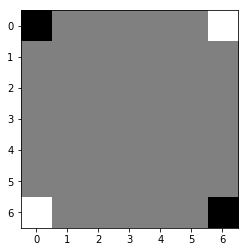

((0, 0), (1, 1)): n_v:  1590 q_all:+0.012476 q:+0.007408 q_m:+0.020000 p:0.319948
((6, 6), (5, 5)): n_v:  1450 q_all:+0.013938 q:+0.005326 q_m:+0.020000 p:0.285840
((0, 0), (1, 0)): n_v:   508 q_all:+0.012495 q:+0.002040 q_m:+0.020000 p:0.102369
((0, 0), (0, 1)): n_v:   480 q_all:+0.011790 q:+0.006016 q_m:+0.020000 p:0.097714
((6, 6), (5, 6)): n_v:   478 q_all:+0.014234 q:+0.009337 q_m:+0.020000 p:0.093984
((6, 6), (6, 5)): n_v:   462 q_all:+0.014311 q:+0.009690 q_m:+0.020000 p:0.090658
((0, 0), (1, 2)): n_v:     5 q_all:+0.004913 q:-0.009332 q_m:-0.000000 p:0.001120
((6, 6), (4, 5)): n_v:     5 q_all:+0.001309 q:-0.012121 q_m:-0.000000 p:0.001348
((0, 0), (2, 1)): n_v:     5 q_all:-0.003751 q:-0.015773 q_m:-0.000000 p:0.001470
((0, 0), (2, 2)): n_v:     4 q_all:+0.000888 q:-0.018272 q_m:-0.000000 p:0.001094
((6, 6), (5, 4)): n_v:     3 q_all:+0.005225 q:-0.010692 q_m:-0.000000 p:0.000835
((6, 6), (4, 4)): n_v:     3 q_all:+0.003802 q:-0.009512 q_m:-0.000000 p:0.000869
((0, 0), (2, 0))

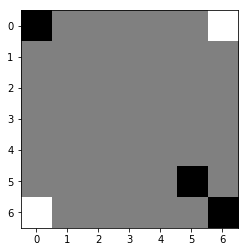

((6, 0), (5, 1)): n_v:  1777 q_all:-0.011130 q:-0.024525 q_m:-0.000000 p:0.270841
((0, 6), (1, 5)): n_v:  1567 q_all:-0.011681 q:-0.012565 q_m:-0.000000 p:0.240941
((6, 0), (5, 0)): n_v:   832 q_all:-0.012130 q:-0.022694 q_m:-0.000000 p:0.128880
((0, 6), (1, 6)): n_v:   813 q_all:-0.012582 q:-0.019021 q_m:-0.000000 p:0.126875
((6, 0), (6, 1)): n_v:   756 q_all:-0.013309 q:-0.029302 q_m:-0.000000 p:0.119426
((0, 6), (0, 5)): n_v:   667 q_all:-0.013652 q:-0.014078 q_m:-0.000000 p:0.105967
((6, 0), (5, 2)): n_v:    11 q_all:+0.005224 q:-0.024242 q_m:-0.020000 p:0.001328
((6, 0), (6, 2)): n_v:     6 q_all:-0.012662 q:-0.012408 q_m:-0.020000 p:0.001015
((0, 6), (0, 4)): n_v:     4 q_all:-0.019181 q:-0.015989 q_m:-0.020000 p:0.000758
((6, 0), (4, 0)): n_v:     4 q_all:-0.022289 q:-0.044087 q_m:-0.020000 p:0.000710
((0, 6), (1, 4)): n_v:     4 q_all:-0.020340 q:-0.014359 q_m:-0.020000 p:0.000818
((6, 0), (4, 1)): n_v:     3 q_all:-0.016810 q:-0.033548 q_m:-0.020000 p:0.000593
((0, 6), (2, 6))

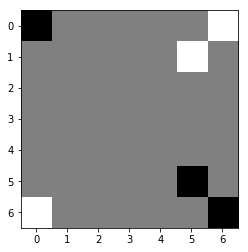

((0, 0), (1, 1)): n_v:  1004 q_all:+0.010169 q:-0.000924 q_m:+0.020000 p:0.143524
((5, 5), (4, 4)): n_v:   892 q_all:+0.014613 q:+0.001979 q_m:+0.020000 p:0.117744
((5, 5), (4, 6)): n_v:   892 q_all:+0.015813 q:+0.005791 q_m:+0.020000 p:0.115001
((5, 5), (6, 4)): n_v:   795 q_all:+0.013245 q:+0.008418 q_m:+0.020000 p:0.107584
((5, 5), (4, 5)): n_v:   595 q_all:+0.014266 q:-0.003427 q_m:+0.020000 p:0.079099
((0, 0), (0, 1)): n_v:   527 q_all:+0.011601 q:+0.004712 q_m:+0.020000 p:0.073415
((5, 5), (5, 6)): n_v:   499 q_all:+0.011653 q:+0.004285 q_m:+0.020000 p:0.069464
((5, 5), (5, 4)): n_v:   474 q_all:+0.012423 q:+0.015631 q_m:+0.020000 p:0.065056
((0, 0), (1, 0)): n_v:   469 q_all:+0.011017 q:-0.003346 q_m:+0.020000 p:0.066107
((5, 5), (6, 5)): n_v:   378 q_all:+0.013818 q:+0.012952 q_m:+0.020000 p:0.050670
((5, 5), (3, 6)): n_v:     9 q_all:-0.031309 q:-0.016994 q_m:-0.000000 p:0.002258
((0, 0), (2, 1)): n_v:     7 q_all:+0.001853 q:-0.017762 q_m:-0.000000 p:0.001236
((0, 0), (2, 2))

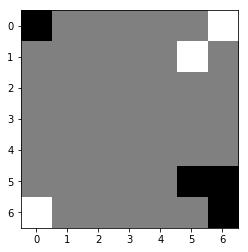

((6, 0), (5, 1)): n_v:  1478 q_all:-0.010867 q:-0.021147 q_m:-0.000000 p:0.254556
((6, 0), (6, 1)): n_v:   606 q_all:-0.014858 q:-0.028481 q_m:-0.000000 p:0.110896
((1, 5), (2, 6)): n_v:   603 q_all:-0.002564 q:-0.023652 q_m:-0.000000 p:0.090337
((1, 5), (0, 4)): n_v:   575 q_all:-0.009529 q:-0.011571 q_m:-0.000000 p:0.096931
((1, 5), (1, 4)): n_v:   540 q_all:-0.006294 q:-0.012216 q_m:-0.000000 p:0.086370
((6, 0), (5, 0)): n_v:   478 q_all:-0.011897 q:-0.018090 q_m:-0.000000 p:0.083789
((1, 5), (2, 5)): n_v:   391 q_all:+0.004800 q:-0.021517 q_m:-0.000000 p:0.050770
((1, 5), (2, 4)): n_v:   274 q_all:-0.001928 q:-0.028852 q_m:-0.000000 p:0.040552
((0, 6), (0, 5)): n_v:   247 q_all:-0.015792 q:-0.028928 q_m:-0.000000 p:0.045932
((0, 6), (1, 6)): n_v:   242 q_all:-0.012059 q:-0.006106 q_m:-0.000000 p:0.042524
((6, 0), (5, 2)): n_v:    18 q_all:-0.002201 q:-0.030852 q_m:-0.020000 p:0.002698
((6, 0), (6, 2)): n_v:     4 q_all:-0.017625 q:-0.020389 q_m:-0.020000 p:0.000934
((6, 0), (4, 1))

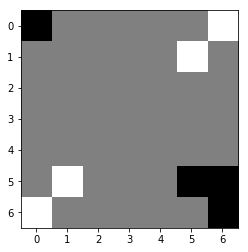

((0, 0), (1, 1)): n_v:   604 q_all:+0.009794 q:+0.009051 q_m:+0.020000 p:0.132364
((0, 0), (1, 0)): n_v:   570 q_all:+0.011082 q:+0.002844 q_m:+0.020000 p:0.122446
((5, 5), (4, 6)): n_v:   498 q_all:+0.016031 q:+0.004062 q_m:+0.020000 p:0.098721
((5, 5), (6, 4)): n_v:   436 q_all:+0.014842 q:-0.007885 q_m:+0.020000 p:0.088225
((0, 0), (0, 1)): n_v:   311 q_all:+0.011388 q:+0.007724 q_m:+0.020000 p:0.066406
((5, 5), (4, 5)): n_v:   308 q_all:+0.012486 q:-0.012092 q_m:+0.020000 p:0.064707
((5, 5), (6, 5)): n_v:   298 q_all:+0.011762 q:+0.009777 q_m:+0.020000 p:0.063303
((5, 5), (4, 4)): n_v:   273 q_all:+0.019546 q:-0.008861 q_m:+0.020000 p:0.050930
((5, 5), (5, 4)): n_v:   186 q_all:+0.012355 q:+0.006565 q_m:+0.020000 p:0.039153
((5, 6), (3, 5)): n_v:     5 q_all:+0.001990 q:-0.012376 q_m:-0.000000 p:0.001455
((0, 0), (2, 1)): n_v:     3 q_all:-0.004272 q:-0.011483 q_m:-0.000000 p:0.001025
((6, 6), (6, 4)): n_v:     2 q_all:+0.003577 q:-0.005802 q_m:-0.000000 p:0.000612
((6, 6), (4, 4))

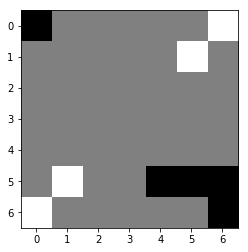

((5, 1), (6, 2)): n_v:   167 q_all:+0.013904 q:-0.013709 q_m:-0.000000 p:0.091095
((0, 6), (0, 5)): n_v:   122 q_all:-0.012201 q:-0.028522 q_m:-0.000000 p:0.084619
((5, 1), (6, 1)): n_v:   115 q_all:-0.011165 q:-0.010770 q_m:-0.000000 p:0.079080
((1, 5), (0, 4)): n_v:   111 q_all:-0.005430 q:-0.004808 q_m:-0.000000 p:0.073090
((1, 5), (2, 6)): n_v:    92 q_all:+0.000391 q:-0.018315 q_m:-0.000000 p:0.057181
((1, 5), (2, 5)): n_v:    88 q_all:+0.013762 q:-0.021400 q_m:-0.000000 p:0.047975
((5, 1), (4, 0)): n_v:    77 q_all:-0.006524 q:-0.011329 q_m:-0.000000 p:0.051349
((5, 1), (4, 1)): n_v:    75 q_all:+0.000704 q:-0.015576 q_m:-0.000000 p:0.046384
((5, 1), (5, 2)): n_v:    70 q_all:+0.007344 q:-0.045742 q_m:-0.000000 p:0.041103
((5, 1), (5, 0)): n_v:    66 q_all:-0.004711 q:-0.018955 q_m:-0.000000 p:0.043422
((1, 5), (1, 4)): n_v:    63 q_all:+0.002899 q:-0.008467 q_m:-0.000000 p:0.038125
((5, 1), (4, 2)): n_v:    44 q_all:+0.014726 q:-0.034987 q_m:-0.000000 p:0.024095
((1, 5), (2, 4))

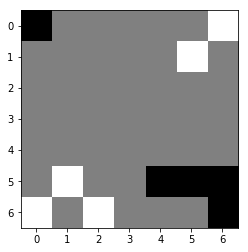

((5, 4), (5, 3)): n_v:   578 q_all:+0.062887 q:+0.020433 q_m:+0.060000 p:0.114239
((0, 0), (1, 0)): n_v:   546 q_all:+0.029213 q:-0.004717 q_m:+0.020000 p:0.180803
((5, 4), (6, 3)): n_v:   435 q_all:+0.068167 q:+0.023898 q_m:+0.060000 p:0.076918
((0, 0), (0, 1)): n_v:   362 q_all:+0.026948 q:-0.001661 q_m:+0.020000 p:0.123329
((5, 4), (6, 5)): n_v:   178 q_all:-0.007008 q:-0.013547 q_m:+0.020000 p:0.084726
((0, 0), (1, 1)): n_v:   157 q_all:+0.025792 q:-0.001096 q_m:+0.020000 p:0.054345
((5, 5), (4, 6)): n_v:    83 q_all:+0.036299 q:-0.000755 q_m:+0.020000 p:0.025304
((5, 4), (6, 4)): n_v:    79 q_all:+0.039173 q:+0.007416 q_m:+0.020000 p:0.023070
((5, 4), (4, 5)): n_v:    38 q_all:+0.010422 q:-0.030714 q_m:+0.020000 p:0.015765
((5, 4), (5, 2)): n_v:    26 q_all:-0.037881 q:+0.012808 q_m:+0.080000 p:0.015637
((5, 4), (4, 3)): n_v:    18 q_all:+0.027284 q:-0.002856 q_m:+0.020000 p:0.006398
((5, 4), (4, 2)): n_v:    14 q_all:+0.042674 q:+0.009034 q_m:+0.040000 p:0.004082
((5, 4), (4, 4))

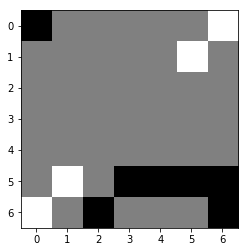

((5, 1), (6, 3)): n_v:  4580 q_all:+0.002865 q:+0.010909 q_m:+0.060000 p:0.714485
((5, 1), (5, 2)): n_v:   527 q_all:-0.020879 q:-0.024395 q_m:+0.040000 p:0.115857
((5, 1), (6, 1)): n_v:   125 q_all:-0.052638 q:-0.013324 q_m:-0.000000 p:0.038110
((5, 1), (4, 2)): n_v:    98 q_all:-0.015187 q:-0.033564 q_m:-0.000000 p:0.020128
((1, 5), (0, 4)): n_v:    84 q_all:-0.054161 q:-0.030542 q_m:-0.040000 p:0.026010
((1, 5), (1, 4)): n_v:    36 q_all:-0.052797 q:-0.036280 q_m:-0.040000 p:0.011224
((6, 0), (5, 2)): n_v:    32 q_all:-0.038583 q:-0.026323 q_m:+0.020000 p:0.008649
((5, 1), (4, 1)): n_v:    28 q_all:-0.008153 q:-0.053300 q_m:-0.040000 p:0.005334
((1, 5), (2, 4)): n_v:    19 q_all:-0.060893 q:-0.053504 q_m:-0.040000 p:0.006131
((0, 6), (0, 5)): n_v:    19 q_all:-0.051079 q:-0.052844 q_m:-0.040000 p:0.005612
((1, 5), (0, 3)): n_v:     9 q_all:-0.041232 q:-0.054226 q_m:-0.060000 p:0.002238
((5, 1), (4, 3)): n_v:     6 q_all:-0.020905 q:-0.022666 q_m:+0.020000 p:0.001369
((1, 5), (2, 5))

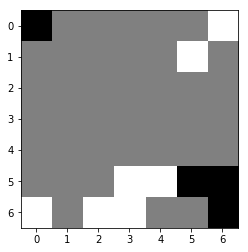

((5, 5), (6, 4)): n_v:  9152 q_all:+0.014034 q:+0.040009 q_m:+0.080000 p:0.925249
((6, 6), (6, 4)): n_v:   230 q_all:-0.001680 q:+0.027176 q_m:+0.060000 p:0.030734
((5, 5), (4, 4)): n_v:    87 q_all:-0.000477 q:-0.026057 q_m:+0.040000 p:0.011460
((5, 6), (6, 4)): n_v:    33 q_all:+0.003608 q:+0.015214 q_m:+0.060000 p:0.004052
((5, 5), (4, 5)): n_v:    20 q_all:-0.003912 q:-0.053695 q_m:-0.000000 p:0.002822
((5, 5), (6, 5)): n_v:    15 q_all:-0.060888 q:-0.039372 q_m:-0.000000 p:0.004039
((0, 0), (1, 1)): n_v:     7 q_all:-0.075444 q:-0.058192 q_m:-0.040000 p:0.002103
((5, 6), (4, 4)): n_v:     3 q_all:-0.040788 q:-0.023358 q_m:+0.020000 p:0.000766
((5, 5), (4, 3)): n_v:     3 q_all:-0.026702 q:-0.010986 q_m:+0.020000 p:0.000655
((6, 6), (4, 4)): n_v:     3 q_all:-0.047265 q:-0.030302 q_m:+0.020000 p:0.000853
((6, 6), (4, 5)): n_v:     3 q_all:-0.032638 q:-0.061779 q_m:-0.020000 p:0.000689
((0, 0), (0, 2)): n_v:     2 q_all:-0.123315 q:-0.090770 q_m:-0.060000 p:0.000860
((0, 0), (0, 1))

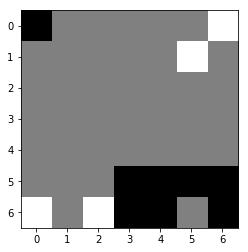

((6, 2), (5, 2)): n_v: 12637 q_all:+0.009717 q:-0.003833 q_m:+0.020000 p:0.833117
((6, 2), (4, 4)): n_v:   664 q_all:-0.014867 q:-0.024976 q_m:+0.040000 p:0.071241
((1, 5), (1, 4)): n_v:   161 q_all:-0.070734 q:-0.057602 q_m:-0.060000 p:0.032358
((6, 0), (5, 2)): n_v:   123 q_all:+0.000878 q:-0.010908 q_m:-0.000000 p:0.010007
((6, 0), (6, 1)): n_v:    44 q_all:-0.102129 q:-0.073913 q_m:-0.060000 p:0.011391
((1, 5), (2, 4)): n_v:    29 q_all:-0.073037 q:-0.072410 q_m:-0.060000 p:0.006075
((0, 6), (0, 5)): n_v:    26 q_all:-0.073824 q:-0.074337 q_m:-0.060000 p:0.005391
((1, 5), (0, 4)): n_v:    19 q_all:-0.078364 q:-0.053666 q_m:-0.060000 p:0.004165
((6, 0), (5, 1)): n_v:    13 q_all:-0.081800 q:-0.058954 q_m:-0.060000 p:0.003062
((6, 0), (5, 0)): n_v:    10 q_all:-0.097954 q:-0.049460 q_m:-0.060000 p:0.002532
((1, 5), (2, 5)): n_v:     5 q_all:-0.063211 q:-0.066963 q_m:-0.060000 p:0.001041
((0, 6), (1, 6)): n_v:     3 q_all:-0.060811 q:-0.047963 q_m:-0.060000 p:0.000737
((1, 5), (2, 6))

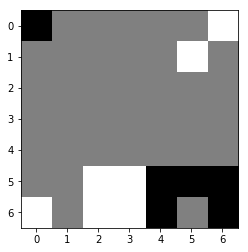

((5, 4), (4, 2)): n_v:  4969 q_all:+0.018014 q:-0.030873 q_m:+0.060000 p:0.087553
((5, 4), (4, 3)): n_v:  4095 q_all:+0.004424 q:-0.005276 q_m:+0.080000 p:0.135139
((5, 4), (6, 5)): n_v:  2522 q_all:+0.019750 q:-0.019085 q_m:-0.000000 p:0.076511
((6, 4), (4, 2)): n_v:   767 q_all:-0.006171 q:-0.028354 q_m:+0.060000 p:0.039811
((0, 0), (0, 1)): n_v:   603 q_all:-0.044177 q:-0.028289 q_m:-0.000000 p:0.069833
((0, 0), (1, 0)): n_v:   322 q_all:-0.042599 q:-0.031272 q_m:-0.000000 p:0.036528
((6, 4), (4, 3)): n_v:   214 q_all:-0.013320 q:-0.037500 q_m:+0.060000 p:0.013826
((0, 0), (1, 1)): n_v:   207 q_all:-0.042247 q:-0.028419 q_m:-0.000000 p:0.023439
((5, 4), (4, 4)): n_v:   167 q_all:-0.022131 q:-0.026014 q_m:+0.040000 p:0.013445
((5, 5), (4, 3)): n_v:    75 q_all:-0.000649 q:-0.013876 q_m:+0.060000 p:0.003137
((5, 5), (4, 6)): n_v:    67 q_all:-0.039623 q:-0.038233 q_m:-0.000000 p:0.007305
((5, 4), (4, 5)): n_v:    60 q_all:-0.038686 q:-0.034079 q_m:-0.000000 p:0.006454
((6, 4), (4, 5))

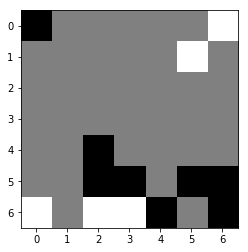

((6, 3), (6, 5)): n_v:  6050 q_all:+0.082965 q:+0.039868 q_m:+0.100000 p:0.126316
((6, 3), (5, 4)): n_v:  1671 q_all:-0.008969 q:-0.027384 q_m:+0.080000 p:0.281246
((6, 3), (5, 1)): n_v:   648 q_all:-0.041111 q:-0.025164 q_m:+0.020000 p:0.166975
((6, 0), (5, 1)): n_v:   245 q_all:-0.031181 q:-0.003132 q_m:+0.040000 p:0.056538
((6, 2), (5, 4)): n_v:   195 q_all:-0.027607 q:-0.042269 q_m:+0.060000 p:0.043056
((6, 3), (6, 1)): n_v:   169 q_all:-0.091773 q:-0.032381 q_m:-0.020000 p:0.063016
((6, 0), (6, 1)): n_v:    80 q_all:-0.069110 q:-0.017363 q_m:-0.000000 p:0.026363
((6, 0), (4, 1)): n_v:    32 q_all:-0.051804 q:+0.001431 q_m:+0.020000 p:0.009379
((6, 3), (4, 5)): n_v:    28 q_all:-0.032131 q:-0.018686 q_m:+0.020000 p:0.006557
((1, 5), (1, 4)): n_v:    22 q_all:-0.050924 q:-0.048806 q_m:-0.040000 p:0.006540
((6, 3), (4, 1)): n_v:    18 q_all:-0.067722 q:-0.018995 q_m:+0.020000 p:0.005724
((6, 2), (4, 3)): n_v:    16 q_all:-0.027990 q:-0.021091 q_m:+0.060000 p:0.003547
((6, 2), (4, 1))

((5, 3), (5, 1)): n_v:  4569 q_all:-0.012791 q:-0.030585 q_m:-0.020000 p:0.030509
((5, 3), (5, 4)): n_v:  3805 q_all:-0.076006 q:-0.042912 q_m:+0.040000 p:0.471386
((5, 2), (6, 3)): n_v:   546 q_all:-0.080121 q:+0.007161 q_m:-0.000000 p:0.073480
((5, 2), (6, 1)): n_v:   523 q_all:-0.041267 q:-0.027826 q_m:-0.000000 p:0.038718
((5, 2), (5, 4)): n_v:   168 q_all:-0.064907 q:-0.034588 q_m:+0.020000 p:0.016058
((4, 2), (4, 1)): n_v:   151 q_all:-0.102011 q:-0.080673 q_m:-0.080000 p:0.027112
((5, 3), (4, 5)): n_v:   140 q_all:-0.067148 q:-0.050343 q_m:-0.020000 p:0.014190
((4, 2), (6, 1)): n_v:   139 q_all:-0.099593 q:-0.038254 q_m:-0.020000 p:0.024226
((5, 3), (4, 4)): n_v:   138 q_all:-0.054854 q:-0.065960 q_m:-0.040000 p:0.012167
((4, 2), (5, 1)): n_v:   127 q_all:-0.076748 q:-0.036021 q_m:-0.000000 p:0.016592
((4, 2), (5, 0)): n_v:   116 q_all:-0.103962 q:-0.060980 q_m:-0.060000 p:0.021297
((5, 3), (6, 1)): n_v:    98 q_all:-0.078200 q:-0.035286 q_m:-0.020000 p:0.013005
((4, 2), (5, 4))

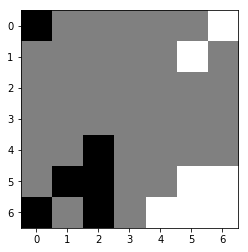

((6, 4), (5, 3)): n_v:  9307 q_all:+0.062582 q:+0.068845 q_m:+0.160000 p:0.955179
((6, 5), (5, 3)): n_v:   142 q_all:+0.029860 q:+0.045375 q_m:+0.140000 p:0.024190
((5, 5), (5, 3)): n_v:    67 q_all:+0.023206 q:+0.056376 q_m:+0.140000 p:0.012424
((6, 4), (6, 3)): n_v:     7 q_all:+0.003912 q:+0.050907 q_m:+0.120000 p:0.001757
((1, 5), (1, 3)): n_v:     3 q_all:-0.042952 q:-0.020273 q_m:+0.020000 p:0.001006
((5, 5), (4, 4)): n_v:     1 q_all:-0.032035 q:-0.014280 q_m:+0.040000 p:0.000461
((1, 5), (2, 5)): n_v:     1 q_all:-0.015778 q:-0.016852 q_m:+0.040000 p:0.000319
((5, 5), (4, 3)): n_v:     1 q_all:+0.008199 q:+0.017599 q_m:+0.100000 p:0.000093
((6, 4), (4, 3)): n_v:     1 q_all:+0.025768 q:+0.029711 q_m:+0.100000 p:0.000228
((5, 5), (6, 3)): n_v:     1 q_all:+0.008893 q:+0.032232 q_m:+0.100000 p:0.000167
((6, 5), (4, 3)): n_v:     1 q_all:+0.011694 q:+0.018294 q_m:+0.100000 p:0.000065
((6, 5), (6, 3)): n_v:     1 q_all:+0.009279 q:+0.028222 q_m:+0.100000 p:0.000069
((5, 5), (4, 5))

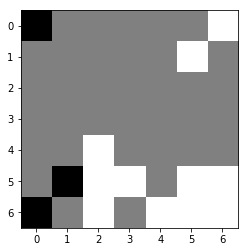

((5, 1), (6, 3)): n_v:  9744 q_all:-0.049722 q:+0.001112 q_m:-0.000000 p:0.663828
((5, 1), (4, 3)): n_v:  2815 q_all:-0.012273 q:-0.076445 q_m:-0.040000 p:0.015465
((5, 1), (6, 1)): n_v:  1112 q_all:-0.086898 q:-0.062727 q_m:-0.060000 p:0.144987
((5, 1), (4, 1)): n_v:   413 q_all:-0.094008 q:-0.087019 q_m:-0.060000 p:0.058816
((0, 0), (0, 1)): n_v:    65 q_all:-0.160861 q:-0.093681 q_m:-0.140000 p:0.016654
((6, 0), (4, 1)): n_v:    21 q_all:-0.097790 q:-0.098011 q_m:-0.080000 p:0.003258
((0, 0), (1, 2)): n_v:     5 q_all:-0.177490 q:-0.114383 q_m:-0.160000 p:0.001352
((0, 0), (1, 1)): n_v:     5 q_all:-0.161179 q:-0.091550 q_m:-0.140000 p:0.001336
((5, 1), (5, 0)): n_v:     1 q_all:-0.185420 q:-0.105801 q_m:-0.140000 p:0.000297
((5, 1), (4, 0)): n_v:     1 q_all:-0.176765 q:-0.121397 q_m:-0.140000 p:0.000258
((0, 0), (1, 0)): n_v:     1 q_all:-0.147757 q:-0.095385 q_m:-0.140000 p:0.000210
((0, 0), (2, 1)): n_v:     1 q_all:-0.179452 q:-0.109194 q_m:-0.160000 p:0.000265
((5, 1), (3, 1))

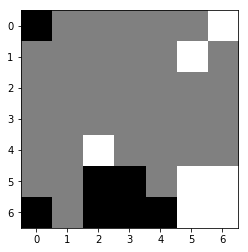

((5, 5), (5, 4)): n_v:  6282 q_all:+0.093456 q:+0.067344 q_m:+0.140000 p:0.317064
((4, 2), (5, 1)): n_v:  2939 q_all:+0.102104 q:+0.044739 q_m:+0.140000 p:0.106443
((4, 2), (5, 4)): n_v:  1225 q_all:+0.076428 q:+0.049869 q_m:+0.120000 p:0.096243
((5, 6), (5, 4)): n_v:   138 q_all:+0.073361 q:+0.028958 q_m:+0.120000 p:0.011545
((4, 2), (5, 0)): n_v:   130 q_all:+0.030735 q:-0.004961 q_m:+0.040000 p:0.020047
((4, 2), (4, 3)): n_v:   126 q_all:+0.033819 q:-0.008576 q_m:+0.100000 p:0.018846
((4, 2), (6, 1)): n_v:   117 q_all:+0.072268 q:+0.058696 q_m:+0.120000 p:0.010034
((1, 5), (1, 4)): n_v:   113 q_all:+0.023659 q:-0.032510 q_m:+0.020000 p:0.018773
((6, 6), (5, 4)): n_v:    30 q_all:+0.071367 q:+0.036930 q_m:+0.120000 p:0.002550
((5, 5), (4, 4)): n_v:    10 q_all:+0.003287 q:-0.038115 q_m:+0.060000 p:0.002165
((6, 5), (4, 3)): n_v:    10 q_all:+0.064239 q:-0.012790 q_m:+0.080000 p:0.001010
((4, 2), (4, 1)): n_v:     8 q_all:+0.025586 q:+0.006335 q_m:+0.060000 p:0.001457
((5, 5), (4, 3))

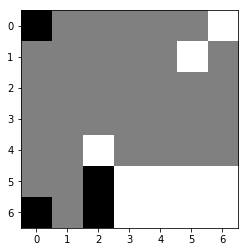

((5, 2), (4, 4)): n_v:  5353 q_all:-0.041309 q:-0.074957 q_m:-0.020000 p:0.498499
((5, 2), (4, 3)): n_v:  1659 q_all:-0.066293 q:-0.058073 q_m:-0.000000 p:0.232601
((6, 2), (4, 4)): n_v:  1603 q_all:-0.071348 q:-0.072829 q_m:-0.020000 p:0.240039
((6, 2), (4, 3)): n_v:    58 q_all:-0.076557 q:-0.087405 q_m:-0.020000 p:0.009359
((5, 2), (4, 1)): n_v:     9 q_all:-0.156127 q:-0.074237 q_m:-0.080000 p:0.003082
((6, 0), (5, 0)): n_v:     7 q_all:-0.192079 q:-0.097587 q_m:-0.120000 p:0.002754
((5, 2), (5, 1)): n_v:     6 q_all:-0.106981 q:-0.070167 q_m:-0.080000 p:0.001299
((6, 0), (4, 1)): n_v:     5 q_all:-0.154990 q:-0.096006 q_m:-0.100000 p:0.001635
((6, 2), (4, 1)): n_v:     4 q_all:-0.173832 q:-0.105130 q_m:-0.100000 p:0.001445
((5, 2), (6, 1)): n_v:     2 q_all:-0.203792 q:-0.107110 q_m:-0.120000 p:0.000893
((0, 0), (1, 0)): n_v:     2 q_all:-0.190105 q:-0.101942 q_m:-0.120000 p:0.000731
((0, 0), (0, 1)): n_v:     2 q_all:-0.188295 q:-0.097001 q_m:-0.120000 p:0.000720
((0, 0), (1, 1))

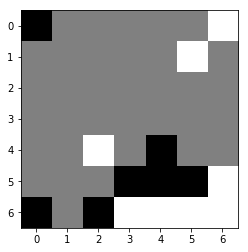

((5, 6), (4, 5)): n_v:  4631 q_all:+0.114829 q:+0.064383 q_m:+0.160000 p:0.201216
((4, 2), (4, 3)): n_v:   975 q_all:+0.046987 q:+0.050590 q_m:+0.160000 p:0.181570
((6, 6), (4, 5)): n_v:   717 q_all:+0.058903 q:+0.041976 q_m:+0.140000 p:0.115657
((6, 3), (4, 5)): n_v:   433 q_all:+0.055544 q:+0.027335 q_m:+0.140000 p:0.072979
((4, 2), (4, 1)): n_v:   307 q_all:-0.013324 q:-0.063826 q_m:+0.040000 p:0.096338
((6, 5), (4, 3)): n_v:   203 q_all:+0.028975 q:+0.032402 q_m:+0.140000 p:0.045608
((6, 3), (4, 1)): n_v:   178 q_all:-0.001474 q:-0.049504 q_m:+0.020000 p:0.051507
((6, 3), (4, 3)): n_v:   174 q_all:+0.047499 q:+0.030455 q_m:+0.140000 p:0.032359
((6, 4), (4, 5)): n_v:   121 q_all:+0.032016 q:+0.015883 q_m:+0.140000 p:0.026543
((1, 5), (2, 5)): n_v:   106 q_all:+0.009187 q:-0.053318 q_m:+0.040000 p:0.028412
((6, 4), (4, 3)): n_v:    94 q_all:+0.037581 q:+0.035364 q_m:+0.140000 p:0.019492
((4, 2), (5, 2)): n_v:    86 q_all:+0.039885 q:+0.004902 q_m:+0.120000 p:0.017449
((4, 2), (5, 1))

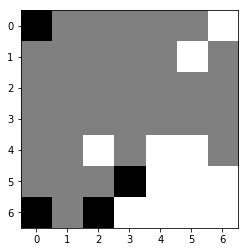

((5, 3), (4, 3)): n_v:  4101 q_all:-0.103402 q:-0.064174 q_m:-0.020000 p:0.677092
((5, 3), (3, 4)): n_v:  3554 q_all:+0.000385 q:-0.081938 q_m:-0.080000 p:0.004445
((5, 3), (3, 5)): n_v:   773 q_all:-0.044138 q:-0.090795 q_m:-0.080000 p:0.007498
((5, 3), (5, 2)): n_v:   414 q_all:-0.126644 q:-0.060525 q_m:-0.060000 p:0.093187
((6, 2), (4, 3)): n_v:   302 q_all:-0.082857 q:-0.072358 q_m:-0.040000 p:0.034035
((5, 3), (4, 1)): n_v:    37 q_all:-0.171387 q:-0.077683 q_m:-0.120000 p:0.012696
((5, 3), (6, 1)): n_v:    21 q_all:-0.218253 q:-0.115793 q_m:-0.160000 p:0.009659
((5, 3), (5, 1)): n_v:    19 q_all:-0.136717 q:-0.077281 q_m:-0.120000 p:0.004875
((5, 3), (3, 1)): n_v:    15 q_all:-0.153254 q:-0.092546 q_m:-0.120000 p:0.004637
((6, 2), (4, 0)): n_v:     7 q_all:-0.170279 q:-0.116116 q_m:-0.160000 p:0.002560
((6, 0), (5, 2)): n_v:     6 q_all:-0.147261 q:-0.073561 q_m:-0.080000 p:0.001880
((5, 3), (3, 2)): n_v:     5 q_all:-0.157598 q:-0.082515 q_m:-0.120000 p:0.001690
((6, 2), (4, 1))

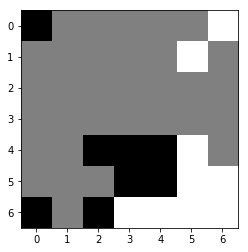

((6, 3), (5, 2)): n_v:  6241 q_all:+0.154871 q:+0.067311 q_m:+0.200000 p:0.521221
((6, 4), (5, 2)): n_v:  1599 q_all:+0.080601 q:+0.032672 q_m:+0.180000 p:0.382481
((6, 3), (5, 1)): n_v:   124 q_all:+0.113027 q:+0.010065 q_m:+0.140000 p:0.021228
((1, 5), (3, 3)): n_v:    97 q_all:+0.102539 q:+0.036093 q_m:+0.140000 p:0.018846
((1, 5), (1, 4)): n_v:    55 q_all:+0.088838 q:-0.020824 q_m:+0.040000 p:0.012419
((4, 5), (3, 3)): n_v:    54 q_all:+0.082839 q:+0.021738 q_m:+0.140000 p:0.012834
((4, 5), (3, 4)): n_v:    45 q_all:+0.078783 q:+0.012413 q_m:+0.120000 p:0.011094
((5, 5), (3, 3)): n_v:    35 q_all:+0.049846 q:+0.018897 q_m:+0.140000 p:0.010749
((5, 6), (3, 4)): n_v:     8 q_all:+0.050855 q:-0.017642 q_m:+0.100000 p:0.002458
((1, 5), (0, 4)): n_v:     3 q_all:+0.067934 q:-0.009066 q_m:+0.040000 p:0.000993
((0, 6), (1, 4)): n_v:     2 q_all:+0.037973 q:-0.019290 q_m:+0.020000 p:0.000877
((6, 3), (4, 1)): n_v:     1 q_all:+0.003476 q:-0.011544 q_m:+0.060000 p:0.000612
((1, 5), (3, 4))

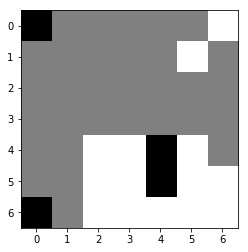

((6, 0), (5, 1)): n_v:  7446 q_all:-0.127183 q:-0.061008 q_m:-0.060000 p:0.803248
((0, 0), (1, 1)): n_v:   766 q_all:-0.144634 q:-0.125697 q_m:-0.180000 p:0.108650
((4, 4), (2, 6)): n_v:   190 q_all:-0.102122 q:-0.149624 q_m:-0.160000 p:0.011241
((6, 0), (6, 1)): n_v:   106 q_all:-0.183791 q:-0.080006 q_m:-0.100000 p:0.023099
((5, 4), (4, 6)): n_v:   102 q_all:-0.107626 q:-0.087072 q_m:-0.080000 p:0.007173
((4, 4), (3, 2)): n_v:   102 q_all:-0.101672 q:-0.136178 q_m:-0.120000 p:0.005962
((6, 0), (4, 0)): n_v:    72 q_all:-0.180523 q:-0.139622 q_m:-0.200000 p:0.015315
((4, 4), (3, 4)): n_v:    35 q_all:-0.142857 q:-0.111217 q_m:-0.100000 p:0.004945
((4, 4), (3, 3)): n_v:    32 q_all:-0.146939 q:-0.117691 q_m:-0.100000 p:0.004822
((4, 4), (4, 6)): n_v:    31 q_all:-0.101342 q:-0.102822 q_m:-0.080000 p:0.001833
((0, 0), (0, 1)): n_v:    24 q_all:-0.151999 q:-0.128445 q_m:-0.180000 p:0.003861
((6, 0), (4, 1)): n_v:    10 q_all:-0.168379 q:-0.120188 q_m:-0.120000 p:0.001955
((4, 4), (3, 5))

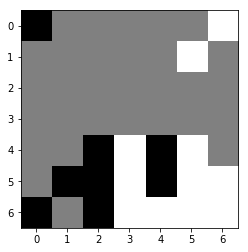

((4, 3), (6, 1)): n_v: 10987 q_all:+0.138246 q:+0.066330 q_m:+0.228000 p:0.851382
((6, 3), (6, 1)): n_v:   646 q_all:+0.116195 q:+0.071650 q_m:+0.228000 p:0.075701
((5, 3), (6, 1)): n_v:   299 q_all:+0.099573 q:+0.054456 q_m:+0.228000 p:0.043933
((6, 3), (4, 1)): n_v:   139 q_all:+0.116454 q:+0.046249 q_m:+0.180000 p:0.016248
((4, 3), (3, 3)): n_v:    29 q_all:+0.101612 q:+0.023449 q_m:+0.160000 p:0.004288
((5, 3), (4, 1)): n_v:    22 q_all:+0.074342 q:+0.044604 q_m:+0.180000 p:0.004328
((4, 3), (4, 1)): n_v:     7 q_all:+0.126483 q:+0.052323 q_m:+0.180000 p:0.000742
((4, 3), (2, 1)): n_v:     3 q_all:+0.042897 q:-0.016381 q_m:+0.060000 p:0.000876
((1, 5), (2, 5)): n_v:     1 q_all:+0.008370 q:+0.003197 q_m:+0.080000 p:0.000470
((1, 5), (0, 4)): n_v:     1 q_all:+0.068397 q:+0.011485 q_m:+0.080000 p:0.000246
((1, 5), (3, 3)): n_v:     0 q_all:+0.095268 q:+0.028170 q_m:+0.140000 p:0.000028
((4, 5), (3, 5)): n_v:     0 q_all:+0.076885 q:+0.012213 q_m:+0.120000 p:0.000020
((1, 5), (2, 4))

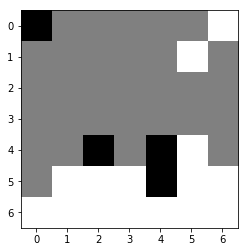

((4, 2), (5, 0)): n_v: 10467 q_all:-0.110583 q:-0.095540 q_m:-0.100000 p:0.786090
((4, 4), (4, 6)): n_v:  1277 q_all:-0.070903 q:-0.125027 q_m:-0.100000 p:0.014472
((4, 2), (4, 3)): n_v:   361 q_all:-0.140633 q:-0.127199 q_m:-0.120000 p:0.044625
((0, 0), (1, 0)): n_v:   137 q_all:-0.237561 q:-0.202945 q_m:-0.200000 p:0.038249
((4, 2), (4, 1)): n_v:    84 q_all:-0.170699 q:-0.107563 q_m:-0.120000 p:0.014516
((4, 4), (2, 6)): n_v:    39 q_all:-0.146408 q:-0.174649 q_m:-0.180000 p:0.005102
((4, 2), (4, 0)): n_v:    33 q_all:-0.190893 q:-0.159423 q_m:-0.180000 p:0.006832
((5, 4), (4, 6)): n_v:    17 q_all:-0.108039 q:-0.153790 q_m:-0.100000 p:0.001254
((4, 2), (2, 1)): n_v:    16 q_all:-0.212772 q:-0.180044 q_m:-0.228000 p:0.003913
((4, 4), (2, 5)): n_v:    16 q_all:-0.188174 q:-0.199886 q_m:-0.180000 p:0.003344
((4, 4), (2, 4)): n_v:     5 q_all:-0.173954 q:-0.201332 q_m:-0.180000 p:0.001056
((0, 0), (1, 1)): n_v:     4 q_all:-0.233352 q:-0.191471 q_m:-0.200000 p:0.001166
((4, 2), (2, 0))

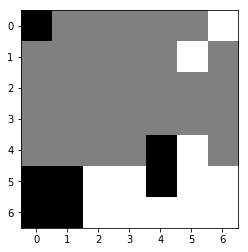

((5, 2), (4, 3)): n_v:  9561 q_all:+0.146992 q:+0.079564 q_m:+0.200000 p:0.316987
((5, 2), (4, 1)): n_v:  1361 q_all:+0.113443 q:+0.034059 q_m:+0.200000 p:0.116356
((5, 3), (4, 1)): n_v:   437 q_all:+0.098075 q:+0.036302 q_m:+0.180000 p:0.048971
((6, 3), (4, 1)): n_v:   306 q_all:+0.101213 q:+0.032320 q_m:+0.180000 p:0.032741
((4, 5), (4, 3)): n_v:   168 q_all:+0.116793 q:+0.096705 q_m:+0.180000 p:0.013245
((6, 2), (4, 1)): n_v:   121 q_all:+0.094770 q:+0.020090 q_m:+0.180000 p:0.014220
((1, 5), (0, 4)): n_v:    97 q_all:+0.094928 q:+0.016883 q_m:+0.120000 p:0.011353
((5, 5), (4, 3)): n_v:    74 q_all:+0.103075 q:+0.050692 q_m:+0.180000 p:0.007745
((6, 2), (4, 3)): n_v:    72 q_all:+0.104650 q:+0.056895 q_m:+0.180000 p:0.007389
((6, 5), (4, 3)): n_v:    57 q_all:+0.108785 q:+0.068887 q_m:+0.180000 p:0.005429
((4, 5), (3, 4)): n_v:    47 q_all:+0.080212 q:+0.041602 q_m:+0.160000 p:0.006597
((6, 4), (4, 3)): n_v:    44 q_all:+0.105861 q:+0.056766 q_m:+0.180000 p:0.004398
((1, 5), (2, 5))

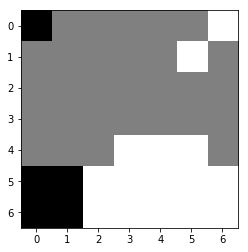

((5, 1), (4, 2)): n_v:  5911 q_all:-0.118024 q:-0.099942 q_m:-0.060000 p:0.532760
((5, 0), (4, 2)): n_v:  3524 q_all:-0.068801 q:-0.100536 q_m:-0.080000 p:0.053462
((6, 1), (4, 2)): n_v:  1648 q_all:-0.163266 q:-0.107532 q_m:-0.080000 p:0.283107
((6, 0), (4, 2)): n_v:   706 q_all:-0.145165 q:-0.108460 q_m:-0.080000 p:0.099552
((0, 0), (2, 2)): n_v:    53 q_all:-0.184286 q:-0.113199 q_m:-0.200000 p:0.011144
((5, 0), (4, 1)): n_v:    22 q_all:-0.193293 q:-0.137629 q_m:-0.140000 p:0.005066
((5, 0), (3, 2)): n_v:     6 q_all:-0.221502 q:-0.140467 q_m:-0.160000 p:0.001876
((0, 0), (1, 1)): n_v:     5 q_all:-0.209356 q:-0.106927 q_m:-0.180000 p:0.001377
((6, 0), (4, 1)): n_v:     4 q_all:-0.218416 q:-0.155659 q_m:-0.160000 p:0.001095
((6, 1), (4, 1)): n_v:     3 q_all:-0.195046 q:-0.153498 q_m:-0.160000 p:0.000715
((0, 0), (0, 1)): n_v:     2 q_all:-0.212458 q:-0.108243 q_m:-0.180000 p:0.000658
((0, 0), (1, 0)): n_v:     1 q_all:-0.198448 q:-0.115083 q_m:-0.180000 p:0.000188
((0, 0), (1, 2))

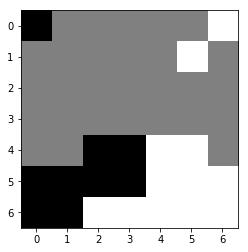

((6, 2), (4, 1)): n_v:  4328 q_all:+0.118203 q:+0.073346 q_m:+0.228000 p:0.429367
((6, 3), (4, 1)): n_v:  3145 q_all:+0.094487 q:+0.054900 q_m:+0.228000 p:0.459869
((4, 4), (3, 3)): n_v:  1398 q_all:+0.144787 q:+0.068570 q_m:+0.160000 p:0.065074
((1, 5), (2, 5)): n_v:   104 q_all:+0.082572 q:+0.044662 q_m:+0.080000 p:0.017701
((4, 4), (3, 2)): n_v:    17 q_all:+0.061501 q:+0.049264 q_m:+0.140000 p:0.003771
((0, 6), (1, 6)): n_v:    15 q_all:+0.133224 q:+0.051289 q_m:+0.080000 p:0.001020
((1, 5), (2, 4)): n_v:    11 q_all:+0.082695 q:+0.041504 q_m:+0.080000 p:0.001890
((4, 5), (3, 3)): n_v:    11 q_all:+0.105889 q:+0.052394 q_m:+0.140000 p:0.001329
((1, 5), (3, 3)): n_v:     8 q_all:+0.129193 q:+0.072477 q_m:+0.140000 p:0.000660
((1, 5), (1, 4)): n_v:     7 q_all:+0.090341 q:+0.043991 q_m:+0.080000 p:0.001167
((4, 5), (4, 6)): n_v:     3 q_all:+0.056896 q:+0.049323 q_m:+0.080000 p:0.000844
((0, 6), (2, 5)): n_v:     3 q_all:+0.052958 q:+0.044648 q_m:+0.060000 p:0.000765
((6, 2), (4, 0))

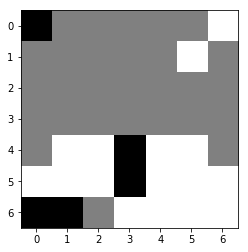

((5, 3), (6, 2)): n_v:  7361 q_all:-0.051399 q:-0.093260 q_m:-0.080000 p:0.378793
((4, 3), (6, 2)): n_v:   180 q_all:-0.118869 q:-0.100309 q_m:-0.100000 p:0.034459
((6, 0), (4, 0)): n_v:   103 q_all:-0.144779 q:-0.113390 q_m:-0.100000 p:0.025288
((6, 0), (6, 2)): n_v:    83 q_all:-0.115576 q:-0.116094 q_m:-0.100000 p:0.015447
((4, 3), (3, 1)): n_v:    44 q_all:-0.129418 q:-0.140123 q_m:-0.140000 p:0.009468
((4, 3), (3, 5)): n_v:    41 q_all:-0.127233 q:-0.167711 q_m:-0.140000 p:0.008676
((4, 3), (3, 4)): n_v:    27 q_all:-0.133472 q:-0.119214 q_m:-0.120000 p:0.006116
((4, 3), (3, 2)): n_v:    26 q_all:-0.143226 q:-0.105690 q_m:-0.120000 p:0.006458
((6, 1), (4, 0)): n_v:    10 q_all:-0.118350 q:-0.117633 q_m:-0.100000 p:0.002043
((5, 3), (3, 5)): n_v:     7 q_all:-0.140370 q:-0.153086 q_m:-0.140000 p:0.001871
((5, 3), (3, 1)): n_v:     4 q_all:-0.150227 q:-0.147669 q_m:-0.140000 p:0.001270
((0, 0), (2, 0)): n_v:     3 q_all:-0.219220 q:-0.189575 q_m:-0.228000 p:0.001285
((0, 0), (0, 2))

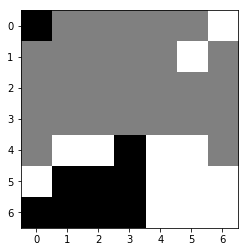

((4, 1), (4, 0)): n_v:  7899 q_all:+0.106404 q:+0.062620 q_m:+0.140000 p:0.181538
((4, 5), (4, 6)): n_v:   908 q_all:+0.032471 q:+0.036524 q_m:+0.100000 p:0.120787
((1, 5), (0, 4)): n_v:   745 q_all:+0.035543 q:+0.043688 q_m:+0.100000 p:0.093734
((1, 5), (1, 4)): n_v:   462 q_all:+0.037548 q:+0.027406 q_m:+0.100000 p:0.056010
((1, 5), (2, 5)): n_v:   385 q_all:+0.027804 q:+0.026238 q_m:+0.100000 p:0.055388
((4, 2), (3, 3)): n_v:   197 q_all:+0.048661 q:+0.031998 q_m:+0.140000 p:0.018774
((4, 1), (3, 2)): n_v:   186 q_all:+0.057609 q:+0.043591 q_m:+0.140000 p:0.013897
((0, 6), (1, 6)): n_v:   170 q_all:+0.037735 q:+0.037092 q_m:+0.100000 p:0.020494
((4, 4), (3, 4)): n_v:   148 q_all:+0.057808 q:+0.025846 q_m:+0.140000 p:0.010992
((1, 5), (2, 4)): n_v:   142 q_all:+0.033441 q:+0.025097 q_m:+0.100000 p:0.018548
((1, 5), (2, 6)): n_v:   109 q_all:+0.037398 q:+0.030398 q_m:+0.100000 p:0.013330
((4, 2), (3, 4)): n_v:    66 q_all:+0.053031 q:+0.033391 q_m:+0.120000 p:0.005604
((6, 6), (4, 6))

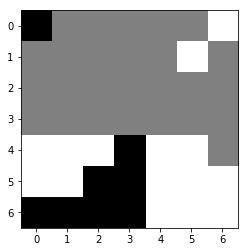

((4, 3), (3, 1)): n_v:  2681 q_all:-0.092324 q:-0.053929 q_m:-0.020000 p:0.283050
((4, 3), (3, 4)): n_v:  1456 q_all:-0.096109 q:-0.059306 q_m:-0.040000 p:0.165094
((0, 0), (1, 0)): n_v:  1160 q_all:-0.034686 q:-0.115638 q_m:-0.120000 p:0.002982
((4, 3), (3, 5)): n_v:  1088 q_all:-0.116609 q:-0.105995 q_m:-0.060000 p:0.169417
((4, 3), (3, 2)): n_v:  1017 q_all:-0.090006 q:-0.042608 q_m:-0.040000 p:0.102579
((0, 0), (0, 1)): n_v:   854 q_all:-0.045884 q:-0.106499 q_m:-0.120000 p:0.007971
((4, 3), (3, 3)): n_v:   730 q_all:-0.102238 q:-0.073236 q_m:-0.040000 p:0.092054
((5, 3), (3, 1)): n_v:   435 q_all:-0.128548 q:-0.068547 q_m:-0.020000 p:0.078513
((5, 3), (3, 5)): n_v:   207 q_all:-0.165931 q:-0.115819 q_m:-0.060000 p:0.053467
((5, 2), (3, 1)): n_v:   125 q_all:-0.151154 q:-0.097219 q_m:-0.020000 p:0.028525
((0, 0), (1, 1)): n_v:    53 q_all:-0.079805 q:-0.102453 q_m:-0.120000 p:0.004286
((0, 0), (2, 0)): n_v:    35 q_all:-0.094579 q:-0.132162 q_m:-0.140000 p:0.003928
((4, 3), (2, 1))

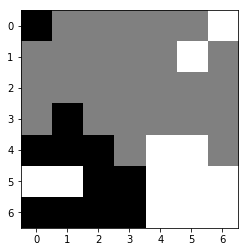

((4, 4), (4, 3)): n_v:  6565 q_all:+0.139437 q:+0.061460 q_m:+0.160000 p:0.528373
((5, 1), (4, 3)): n_v:   106 q_all:+0.088090 q:+0.050787 q_m:+0.140000 p:0.021086
((4, 4), (3, 2)): n_v:    85 q_all:+0.107316 q:+0.030310 q_m:+0.140000 p:0.013116
((5, 0), (3, 0)): n_v:    43 q_all:+0.110902 q:+0.001574 q_m:+0.140000 p:0.006337
((4, 5), (4, 3)): n_v:    37 q_all:+0.102609 q:+0.059804 q_m:+0.140000 p:0.006245
((6, 4), (4, 3)): n_v:    37 q_all:+0.063553 q:+0.028027 q_m:+0.140000 p:0.009502
((5, 5), (4, 3)): n_v:    22 q_all:+0.055574 q:+0.030318 q_m:+0.140000 p:0.005930
((6, 5), (4, 3)): n_v:    18 q_all:+0.077535 q:+0.038880 q_m:+0.140000 p:0.004021
((5, 6), (3, 6)): n_v:     8 q_all:+0.008402 q:-0.040750 q_m:+0.020000 p:0.003348
((4, 5), (3, 6)): n_v:     7 q_all:+0.032738 q:+0.004164 q_m:+0.040000 p:0.002409
((4, 4), (3, 6)): n_v:     4 q_all:+0.017320 q:-0.016938 q_m:+0.020000 p:0.001651
((4, 4), (3, 4)): n_v:     4 q_all:+0.016694 q:-0.033136 q_m:+0.040000 p:0.001726
((5, 0), (3, 2))

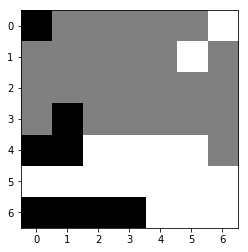

((4, 1), (3, 3)): n_v:  5799 q_all:-0.083122 q:-0.104388 q_m:-0.040000 p:0.272193
((3, 1), (3, 3)): n_v:  2607 q_all:-0.130212 q:-0.082914 q_m:-0.040000 p:0.350695
((3, 1), (3, 2)): n_v:   715 q_all:-0.144026 q:-0.057896 q_m:-0.060000 p:0.114620
((3, 1), (2, 3)): n_v:   317 q_all:-0.145343 q:-0.126866 q_m:-0.160000 p:0.051637
((4, 0), (3, 2)): n_v:   167 q_all:-0.163883 q:-0.103666 q_m:-0.080000 p:0.033042
((0, 0), (0, 1)): n_v:    75 q_all:-0.133689 q:-0.094965 q_m:-0.140000 p:0.010603
((3, 1), (1, 0)): n_v:    32 q_all:-0.144880 q:-0.129023 q_m:-0.160000 p:0.005325
((4, 0), (2, 1)): n_v:    29 q_all:-0.192825 q:-0.186177 q_m:-0.160000 p:0.007469
((3, 1), (2, 2)): n_v:    28 q_all:-0.166566 q:-0.117551 q_m:-0.140000 p:0.005820
((3, 1), (1, 3)): n_v:    22 q_all:-0.168212 q:-0.126682 q_m:-0.160000 p:0.004628
((4, 0), (2, 2)): n_v:    21 q_all:-0.154323 q:-0.156922 q_m:-0.160000 p:0.003893
((3, 1), (1, 1)): n_v:    19 q_all:-0.146303 q:-0.116829 q_m:-0.160000 p:0.003280
((3, 1), (2, 1))

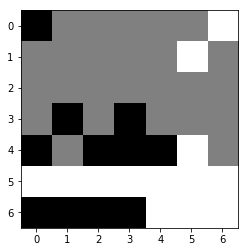

((5, 0), (4, 1)): n_v:  5936 q_all:+0.144757 q:+0.088369 q_m:+0.180000 p:0.090781
((4, 5), (3, 4)): n_v:  1189 q_all:+0.094002 q:+0.105942 q_m:+0.180000 p:0.114914
((5, 0), (3, 2)): n_v:  1069 q_all:+0.073364 q:+0.065599 q_m:+0.200000 p:0.161160
((5, 6), (3, 4)): n_v:   791 q_all:+0.074918 q:+0.075991 q_m:+0.160000 p:0.116082
((1, 5), (3, 4)): n_v:   746 q_all:+0.080978 q:+0.087769 q_m:+0.160000 p:0.097538
((5, 1), (3, 2)): n_v:   590 q_all:+0.093453 q:+0.045217 q_m:+0.200000 p:0.057644
((5, 5), (3, 4)): n_v:   264 q_all:+0.064325 q:+0.039582 q_m:+0.160000 p:0.045018
((5, 4), (3, 2)): n_v:    41 q_all:+0.053464 q:+0.043179 q_m:+0.200000 p:0.007959
((5, 2), (3, 4)): n_v:    36 q_all:+0.069029 q:+0.084296 q_m:+0.160000 p:0.005927
((5, 2), (3, 2)): n_v:    29 q_all:+0.073947 q:+0.059442 q_m:+0.200000 p:0.004266
((5, 4), (3, 4)): n_v:    20 q_all:+0.021550 q:+0.061941 q_m:+0.160000 p:0.005035
((1, 5), (2, 5)): n_v:    19 q_all:+0.027076 q:+0.021527 q_m:+0.060000 p:0.004746
((5, 3), (4, 1))

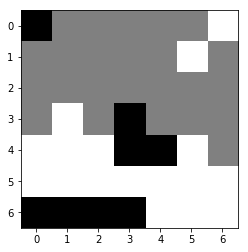

((3, 3), (3, 2)): n_v:  3985 q_all:-0.128788 q:-0.083431 q_m:-0.040000 p:0.258085
((4, 3), (3, 5)): n_v:  1310 q_all:-0.088986 q:-0.172633 q_m:-0.140000 p:0.003431
((4, 4), (2, 6)): n_v:   934 q_all:-0.112335 q:-0.154251 q_m:-0.140000 p:0.025676
((4, 4), (3, 2)): n_v:   898 q_all:-0.123554 q:-0.085462 q_m:-0.060000 p:0.038527
((3, 3), (3, 4)): n_v:   871 q_all:-0.152868 q:-0.157367 q_m:-0.120000 p:0.104695
((4, 4), (4, 6)): n_v:   529 q_all:-0.155266 q:-0.127252 q_m:-0.060000 p:0.066196
((3, 3), (1, 1)): n_v:    66 q_all:-0.188395 q:-0.136939 q_m:-0.180000 p:0.013234
((3, 3), (2, 5)): n_v:    52 q_all:-0.171117 q:-0.124488 q_m:-0.140000 p:0.008519
((3, 3), (2, 1)): n_v:    26 q_all:-0.200298 q:-0.151569 q_m:-0.140000 p:0.006083
((4, 4), (3, 5)): n_v:    17 q_all:-0.212501 q:-0.176582 q_m:-0.120000 p:0.004464
((3, 3), (1, 4)): n_v:    15 q_all:-0.117740 q:-0.133681 q_m:-0.140000 p:0.000625
((3, 3), (3, 5)): n_v:    14 q_all:-0.202181 q:-0.169136 q_m:-0.140000 p:0.003363
((4, 4), (3, 6))

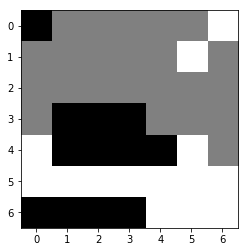

((4, 5), (3, 4)): n_v:  6664 q_all:+0.172214 q:+0.126593 q_m:+0.180000 p:0.796651
((5, 6), (3, 4)): n_v:   329 q_all:+0.139358 q:+0.088634 q_m:+0.160000 p:0.063704
((1, 5), (3, 4)): n_v:   181 q_all:+0.144880 q:+0.102362 q_m:+0.160000 p:0.032820
((4, 0), (3, 0)): n_v:   116 q_all:+0.131607 q:+0.063843 q_m:+0.140000 p:0.024609
((5, 2), (3, 4)): n_v:    91 q_all:+0.096810 q:+0.083721 q_m:+0.160000 p:0.026442
((5, 5), (3, 4)): n_v:    52 q_all:+0.077826 q:+0.054086 q_m:+0.160000 p:0.017317
((4, 5), (3, 6)): n_v:    26 q_all:+0.072748 q:+0.031117 q_m:+0.060000 p:0.009166
((1, 5), (0, 4)): n_v:    21 q_all:+0.111000 q:+0.032898 q_m:+0.060000 p:0.005627
((1, 5), (2, 4)): n_v:    16 q_all:+0.088980 q:+0.054863 q_m:+0.100000 p:0.005093
((1, 5), (1, 4)): n_v:    12 q_all:+0.088922 q:+0.039423 q_m:+0.060000 p:0.003948
((1, 5), (1, 3)): n_v:     9 q_all:+0.078586 q:+0.031896 q_m:+0.040000 p:0.003282
((5, 3), (3, 4)): n_v:     5 q_all:+0.071907 q:+0.073871 q_m:+0.160000 p:0.001553
((4, 0), (2, 2))

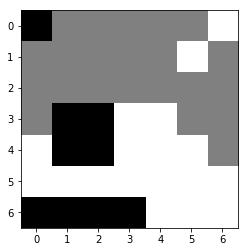

((3, 1), (3, 0)): n_v:  3376 q_all:-0.081814 q:-0.078940 q_m:-0.120000 p:0.020840
((3, 2), (2, 3)): n_v:  2333 q_all:-0.165940 q:-0.118124 q_m:-0.080000 p:0.392791
((3, 2), (2, 4)): n_v:  1293 q_all:-0.163473 q:-0.093949 q_m:-0.060000 p:0.211475
((3, 1), (2, 3)): n_v:   499 q_all:-0.182534 q:-0.138921 q_m:-0.100000 p:0.100109
((4, 2), (2, 4)): n_v:   238 q_all:-0.169897 q:-0.127241 q_m:-0.060000 p:0.041904
((3, 1), (2, 2)): n_v:   187 q_all:-0.182158 q:-0.127223 q_m:-0.120000 p:0.037463
((3, 2), (1, 4)): n_v:   137 q_all:-0.203555 q:-0.123548 q_m:-0.140000 p:0.033143
((3, 1), (2, 0)): n_v:   130 q_all:-0.179832 q:-0.128043 q_m:-0.160000 p:0.025551
((0, 0), (0, 1)): n_v:    50 q_all:-0.155008 q:-0.116022 q_m:-0.160000 p:0.007382
((3, 2), (1, 1)): n_v:    37 q_all:-0.222956 q:-0.161760 q_m:-0.180000 p:0.010425
((4, 1), (2, 3)): n_v:    24 q_all:-0.164291 q:-0.176094 q_m:-0.100000 p:0.004085
((0, 0), (2, 2)): n_v:    23 q_all:-0.204002 q:-0.122283 q_m:-0.140000 p:0.005679
((4, 1), (2, 2))

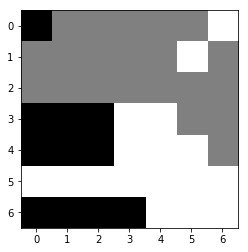

((3, 3), (2, 1)): n_v:  2035 q_all:+0.126169 q:+0.096122 q_m:+0.256000 p:0.175635
((1, 5), (0, 4)): n_v:  1323 q_all:+0.150393 q:+0.090658 q_m:+0.140000 p:0.061020
((4, 5), (4, 6)): n_v:   420 q_all:+0.114749 q:+0.094085 q_m:+0.140000 p:0.053107
((3, 3), (1, 1)): n_v:   317 q_all:+0.068631 q:+0.076422 q_m:+0.160000 p:0.085400
((1, 5), (2, 5)): n_v:   272 q_all:+0.054378 q:+0.089573 q_m:+0.140000 p:0.084373
((3, 3), (2, 5)): n_v:   157 q_all:+0.029303 q:+0.059632 q_m:+0.120000 p:0.059585
((1, 5), (1, 4)): n_v:   139 q_all:+0.072318 q:+0.094226 q_m:+0.140000 p:0.036011
((1, 5), (2, 6)): n_v:   136 q_all:+0.069906 q:+0.077158 q_m:+0.140000 p:0.036240
((3, 3), (2, 2)): n_v:   127 q_all:+0.095589 q:+0.090396 q_m:+0.228000 p:0.022668
((3, 3), (2, 3)): n_v:   105 q_all:+0.069653 q:+0.085866 q_m:+0.180000 p:0.028035
((4, 3), (2, 1)): n_v:    37 q_all:+0.013596 q:+0.085690 q_m:+0.256000 p:0.015744
((1, 5), (2, 4)): n_v:    23 q_all:+0.034701 q:+0.077018 q_m:+0.140000 p:0.008582
((3, 3), (1, 2))

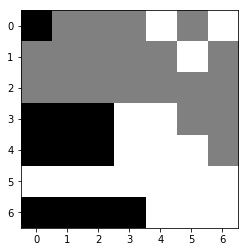

((3, 2), (2, 4)): n_v:   540 q_all:-0.123941 q:-0.049203 q_m:-0.020000 p:0.191936
((3, 2), (2, 3)): n_v:   502 q_all:-0.120422 q:-0.098961 q_m:-0.040000 p:0.171453
((3, 1), (2, 2)): n_v:   268 q_all:-0.113897 q:-0.101847 q_m:-0.080000 p:0.084412
((4, 2), (2, 4)): n_v:   213 q_all:-0.120974 q:-0.064403 q_m:-0.020000 p:0.073229
((3, 1), (2, 3)): n_v:   171 q_all:-0.133304 q:-0.152393 q_m:-0.060000 p:0.067284
((3, 2), (1, 4)): n_v:   135 q_all:-0.111981 q:-0.060084 q_m:-0.060000 p:0.041664
((4, 0), (2, 2)): n_v:   101 q_all:-0.167100 q:-0.175781 q_m:-0.100000 p:0.053619
((3, 0), (2, 2)): n_v:    92 q_all:-0.143958 q:-0.126333 q_m:-0.100000 p:0.040279
((0, 0), (0, 1)): n_v:    90 q_all:-0.078864 q:-0.082461 q_m:-0.120000 p:0.015423
((3, 0), (2, 0)): n_v:    74 q_all:-0.124238 q:-0.115656 q_m:-0.120000 p:0.026597
((3, 0), (1, 0)): n_v:    32 q_all:-0.112662 q:-0.143457 q_m:-0.140000 p:0.010073
((3, 0), (1, 1)): n_v:    31 q_all:-0.117512 q:-0.131488 q_m:-0.140000 p:0.010514
((0, 0), (2, 2))

((4, 3), (3, 2)): n_v:  2808 q_all:+0.155982 q:+0.110557 q_m:+0.200000 p:0.781062
((5, 0), (3, 2)): n_v:   405 q_all:+0.147308 q:+0.093096 q_m:+0.180000 p:0.124852
((5, 1), (3, 2)): n_v:    93 q_all:+0.122794 q:+0.075125 q_m:+0.180000 p:0.036276
((0, 4), (1, 4)): n_v:    23 q_all:+0.115959 q:+0.084182 q_m:+0.120000 p:0.009790
((0, 6), (2, 5)): n_v:    15 q_all:+0.112657 q:+0.077609 q_m:+0.140000 p:0.006682
((4, 4), (3, 2)): n_v:    14 q_all:+0.066965 q:+0.057310 q_m:+0.180000 p:0.008600
((5, 4), (3, 2)): n_v:     7 q_all:+0.026966 q:+0.042229 q_m:+0.180000 p:0.005722
((0, 4), (2, 5)): n_v:     6 q_all:+0.074305 q:+0.065974 q_m:+0.140000 p:0.003281
((0, 4), (1, 3)): n_v:     5 q_all:+0.099821 q:+0.025221 q_m:+0.080000 p:0.002204
((4, 4), (3, 5)): n_v:     3 q_all:+0.126585 q:+0.007401 q_m:+0.120000 p:0.001077
((4, 3), (2, 1)): n_v:     3 q_all:+0.065728 q:-0.041000 q_m:+0.100000 p:0.001873
((0, 4), (2, 3)): n_v:     3 q_all:+0.089807 q:+0.056287 q_m:+0.140000 p:0.001803
((0, 4), (0, 3))

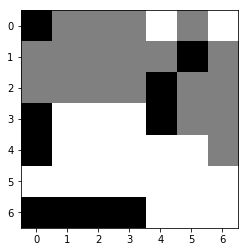

((3, 4), (2, 2)): n_v:  2271 q_all:-0.048789 q:-0.128256 q_m:-0.080000 p:0.107327
((4, 0), (2, 2)): n_v:   667 q_all:-0.144550 q:-0.154023 q_m:-0.080000 p:0.209239
((2, 4), (4, 6)): n_v:   465 q_all:-0.136461 q:-0.107829 q_m:-0.080000 p:0.135489
((3, 0), (2, 2)): n_v:   337 q_all:-0.137543 q:-0.152396 q_m:-0.080000 p:0.098955
((0, 0), (2, 2)): n_v:   243 q_all:-0.128090 q:-0.122279 q_m:-0.080000 p:0.065218
((2, 4), (2, 2)): n_v:   219 q_all:-0.105828 q:-0.133546 q_m:-0.080000 p:0.044905
((3, 4), (4, 6)): n_v:   175 q_all:-0.111957 q:-0.096982 q_m:-0.080000 p:0.035557
((3, 0), (2, 0)): n_v:   104 q_all:-0.193161 q:-0.190896 q_m:-0.140000 p:0.046938
((1, 5), (0, 5)): n_v:    75 q_all:-0.129981 q:-0.092258 q_m:-0.100000 p:0.020652
((2, 4), (2, 3)): n_v:    57 q_all:-0.160913 q:-0.153059 q_m:-0.100000 p:0.020728
((4, 0), (2, 0)): n_v:    49 q_all:-0.203304 q:-0.213194 q_m:-0.160000 p:0.023698
((3, 4), (2, 6)): n_v:    48 q_all:-0.223818 q:-0.228387 q_m:-0.200000 p:0.025622
((1, 5), (2, 6))

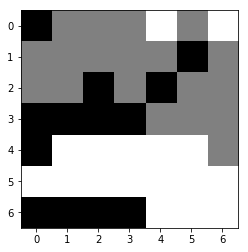

((0, 4), (1, 4)): n_v:  2705 q_all:+0.179869 q:+0.115660 q_m:+0.180000 p:0.001345
((0, 6), (2, 5)): n_v:  1595 q_all:+0.059520 q:+0.095461 q_m:+0.160000 p:0.489135
((4, 3), (2, 1)): n_v:  1048 q_all:+0.100299 q:+0.058253 q_m:+0.256000 p:0.212631
((4, 3), (2, 5)): n_v:   364 q_all:+0.033543 q:+0.025291 q_m:+0.160000 p:0.135855
((0, 4), (2, 5)): n_v:   279 q_all:+0.056036 q:+0.088970 q_m:+0.160000 p:0.088165
((4, 2), (2, 1)): n_v:    52 q_all:+0.030039 q:+0.027580 q_m:+0.256000 p:0.020105
((4, 4), (2, 5)): n_v:    22 q_all:+0.034283 q:+0.046241 q_m:+0.160000 p:0.008181
((0, 4), (2, 3)): n_v:    20 q_all:+0.066966 q:+0.091236 q_m:+0.256000 p:0.005920
((4, 1), (2, 1)): n_v:    20 q_all:+0.044894 q:+0.088363 q_m:+0.256000 p:0.007123
((4, 5), (2, 5)): n_v:    19 q_all:+0.060677 q:+0.073682 q_m:+0.160000 p:0.006014
((4, 5), (2, 3)): n_v:     9 q_all:+0.095073 q:+0.084538 q_m:+0.256000 p:0.001996
((4, 1), (2, 3)): n_v:     9 q_all:+0.107265 q:+0.067830 q_m:+0.256000 p:0.001567
((4, 3), (3, 4))

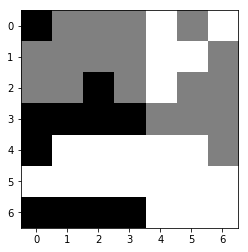

((2, 2), (2, 3)): n_v:  1325 q_all:-0.069262 q:-0.156405 q_m:-0.080000 p:0.009533
((3, 3), (3, 4)): n_v:  1201 q_all:-0.167604 q:-0.067567 q_m:-0.000000 p:0.339504
((2, 2), (1, 3)): n_v:   790 q_all:-0.196356 q:-0.075464 q_m:-0.040000 p:0.287004
((3, 3), (2, 1)): n_v:   564 q_all:-0.092599 q:-0.156080 q_m:-0.180000 p:0.024221
((2, 2), (3, 4)): n_v:   266 q_all:-0.152873 q:-0.046672 q_m:-0.020000 p:0.064470
((3, 3), (1, 3)): n_v:   247 q_all:-0.099998 q:-0.059812 q_m:-0.060000 p:0.011550
((3, 2), (1, 3)): n_v:   220 q_all:-0.151957 q:-0.105690 q_m:-0.060000 p:0.052588
((3, 3), (3, 5)): n_v:   116 q_all:-0.121295 q:-0.112008 q_m:-0.060000 p:0.013853
((3, 3), (2, 5)): n_v:   113 q_all:-0.152948 q:-0.072018 q_m:-0.060000 p:0.027314
((4, 0), (2, 1)): n_v:    89 q_all:-0.220820 q:-0.242347 q_m:-0.180000 p:0.038820
((3, 2), (3, 4)): n_v:    49 q_all:-0.136988 q:-0.102380 q_m:-0.020000 p:0.008847
((3, 1), (2, 3)): n_v:    37 q_all:-0.186608 q:-0.184322 q_m:-0.100000 p:0.012644
((3, 1), (1, 3))

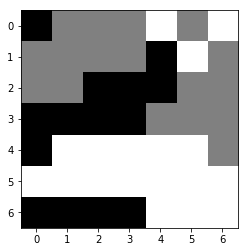

((0, 4), (1, 3)): n_v:  4482 q_all:+0.124567 q:+0.157583 q_m:+0.284000 p:0.710158
((1, 5), (2, 5)): n_v:   768 q_all:+0.102095 q:+0.080245 q_m:+0.180000 p:0.166479
((4, 3), (2, 1)): n_v:   401 q_all:+0.145676 q:+0.068676 q_m:+0.256000 p:0.041654
((1, 5), (1, 3)): n_v:   154 q_all:+0.127862 q:+0.125076 q_m:+0.256000 p:0.023187
((0, 6), (2, 5)): n_v:    57 q_all:+0.071521 q:+0.079351 q_m:+0.160000 p:0.017004
((4, 3), (2, 5)): n_v:    55 q_all:+0.057965 q:+0.029939 q_m:+0.160000 p:0.018330
((4, 3), (3, 4)): n_v:    31 q_all:+0.140419 q:+0.087092 q_m:+0.228000 p:0.003736
((0, 4), (2, 5)): n_v:    10 q_all:+0.067757 q:+0.087072 q_m:+0.160000 p:0.003316
((4, 2), (2, 1)): n_v:     8 q_all:+0.072542 q:+0.044698 q_m:+0.256000 p:0.002553
((4, 1), (2, 1)): n_v:     4 q_all:+0.064569 q:+0.095405 q_m:+0.256000 p:0.001269
((4, 5), (2, 5)): n_v:     2 q_all:+0.081533 q:+0.085981 q_m:+0.160000 p:0.000659
((1, 5), (3, 4)): n_v:     2 q_all:+0.105178 q:+0.069260 q_m:+0.200000 p:0.000619
((5, 2), (3, 4))

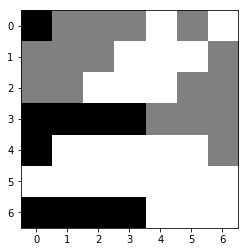

((3, 3), (3, 4)): n_v:  6450 q_all:-0.094116 q:-0.087788 q_m:-0.040000 p:0.620515
((3, 2), (3, 4)): n_v:  1037 q_all:-0.136014 q:-0.135273 q_m:-0.060000 p:0.196227
((0, 0), (1, 2)): n_v:   215 q_all:-0.165257 q:-0.168214 q_m:-0.140000 p:0.054804
((3, 0), (1, 2)): n_v:   119 q_all:-0.165577 q:-0.187927 q_m:-0.140000 p:0.030457
((3, 3), (1, 2)): n_v:    90 q_all:-0.182772 q:-0.124385 q_m:-0.140000 p:0.026628
((3, 1), (1, 2)): n_v:    57 q_all:-0.185104 q:-0.161421 q_m:-0.140000 p:0.017109
((3, 3), (3, 5)): n_v:    38 q_all:-0.131873 q:-0.153851 q_m:-0.140000 p:0.006959
((3, 3), (2, 5)): n_v:    34 q_all:-0.124961 q:-0.104974 q_m:-0.140000 p:0.005752
((3, 2), (1, 2)): n_v:    14 q_all:-0.175096 q:-0.186535 q_m:-0.140000 p:0.004058
((3, 3), (2, 1)): n_v:    12 q_all:-0.200651 q:-0.189675 q_m:-0.228000 p:0.004154
((4, 0), (2, 1)): n_v:    12 q_all:-0.251228 q:-0.293300 q_m:-0.228000 p:0.005754
((3, 3), (1, 1)): n_v:    11 q_all:-0.234860 q:-0.170671 q_m:-0.228000 p:0.004837
((0, 0), (0, 1))

((2, 2), (2, 1)): n_v:  2791 q_all:+0.132569 q:+0.046036 q_m:+0.180000 p:0.144671
((1, 4), (2, 5)): n_v:  1377 q_all:+0.073607 q:+0.054930 q_m:+0.140000 p:0.249452
((1, 5), (3, 5)): n_v:  1186 q_all:+0.128146 q:+0.063792 q_m:+0.200000 p:0.077719
((5, 6), (3, 5)): n_v:  1043 q_all:+0.115256 q:+0.051501 q_m:+0.200000 p:0.093642
((1, 4), (3, 5)): n_v:   441 q_all:+0.114722 q:+0.066997 q_m:+0.200000 p:0.040210
((2, 2), (1, 1)): n_v:   202 q_all:+0.062118 q:+0.037279 q_m:+0.100000 p:0.041764
((1, 3), (2, 1)): n_v:   116 q_all:+0.112842 q:+0.023709 q_m:+0.160000 p:0.011052
((5, 5), (3, 5)): n_v:   103 q_all:+0.084667 q:+0.039773 q_m:+0.200000 p:0.016137
((0, 6), (2, 5)): n_v:    87 q_all:+0.054649 q:+0.030702 q_m:+0.120000 p:0.019565
((1, 3), (3, 5)): n_v:    73 q_all:+0.106393 q:+0.057651 q_m:+0.200000 p:0.008066
((0, 4), (2, 5)): n_v:    65 q_all:+0.053527 q:+0.027974 q_m:+0.120000 p:0.014702
((5, 4), (3, 5)): n_v:    59 q_all:+0.075001 q:+0.015203 q_m:+0.200000 p:0.010592
((1, 3), (1, 2))

((2, 3), (1, 2)): n_v:  1734 q_all:-0.095205 q:-0.156902 q_m:-0.040000 p:0.310533
((0, 0), (2, 0)): n_v:  1187 q_all:-0.091275 q:-0.116783 q_m:-0.060000 p:0.200036
((2, 3), (0, 5)): n_v:   655 q_all:-0.064851 q:-0.081809 q_m:-0.020000 p:0.063630
((0, 0), (1, 2)): n_v:   432 q_all:-0.089628 q:-0.151215 q_m:-0.060000 p:0.071035
((2, 4), (0, 5)): n_v:   353 q_all:-0.113456 q:-0.098759 q_m:-0.020000 p:0.080628
((0, 0), (0, 1)): n_v:   134 q_all:-0.194399 q:-0.346508 q_m:-0.160000 p:0.059779
((2, 4), (2, 5)): n_v:    88 q_all:-0.136208 q:-0.152113 q_m:-0.080000 p:0.025521
((0, 0), (1, 1)): n_v:    76 q_all:-0.178836 q:-0.225614 q_m:-0.080000 p:0.030986
((2, 3), (0, 1)): n_v:    69 q_all:-0.214394 q:-0.268493 q_m:-0.180000 p:0.034742
((2, 4), (0, 3)): n_v:    50 q_all:-0.154035 q:-0.203422 q_m:-0.060000 p:0.017118
((4, 0), (2, 0)): n_v:    44 q_all:-0.086907 q:-0.136304 q_m:-0.060000 p:0.006992
((2, 4), (1, 2)): n_v:    39 q_all:-0.131747 q:-0.186197 q_m:-0.060000 p:0.011002
((3, 3), (1, 2))

((3, 0), (1, 1)): n_v:  5084 q_all:+0.174677 q:+0.074130 q_m:+0.200000 p:0.596968
((3, 1), (1, 1)): n_v:   795 q_all:+0.093190 q:+0.072680 q_m:+0.200000 p:0.251524
((3, 2), (1, 1)): n_v:   420 q_all:+0.114817 q:+0.080221 q_m:+0.200000 p:0.110813
((5, 6), (3, 5)): n_v:    74 q_all:+0.136659 q:+0.024576 q_m:+0.200000 p:0.015667
((1, 4), (3, 5)): n_v:    39 q_all:+0.204802 q:+0.064050 q_m:+0.200000 p:0.001690
((1, 5), (3, 5)): n_v:    29 q_all:+0.159844 q:+0.046617 q_m:+0.200000 p:0.004552
((0, 4), (0, 3)): n_v:    16 q_all:+0.108898 q:+0.011562 q_m:+0.140000 p:0.004502
((5, 3), (3, 5)): n_v:     6 q_all:+0.071324 q:-0.002218 q_m:+0.200000 p:0.002345
((5, 5), (3, 5)): n_v:     5 q_all:+0.038091 q:+0.012972 q_m:+0.200000 p:0.002593
((3, 1), (1, 0)): n_v:     3 q_all:+0.095717 q:-0.034823 q_m:+0.120000 p:0.001180
((3, 0), (1, 0)): n_v:     2 q_all:+0.134391 q:-0.019795 q_m:+0.120000 p:0.000596
((5, 4), (3, 5)): n_v:     1 q_all:+0.047096 q:-0.005379 q_m:+0.200000 p:0.000604
((0, 4), (0, 2))

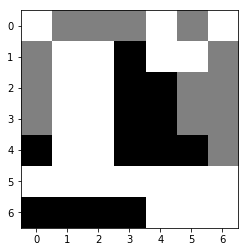

((2, 4), (0, 5)): n_v:  2860 q_all:-0.155039 q:-0.095524 q_m:-0.040000 p:0.405480
((4, 0), (3, 0)): n_v:  2139 q_all:-0.069043 q:-0.203198 q_m:-0.060000 p:0.003003
((4, 0), (2, 0)): n_v:  1490 q_all:-0.093961 q:-0.242648 q_m:-0.080000 p:0.005730
((2, 3), (0, 5)): n_v:  1375 q_all:-0.175118 q:-0.126857 q_m:-0.040000 p:0.256873
((1, 3), (0, 5)): n_v:   608 q_all:-0.136130 q:-0.095426 q_m:-0.040000 p:0.060479
((2, 3), (0, 1)): n_v:   462 q_all:-0.237919 q:-0.236871 q_m:-0.080000 p:0.151541
((1, 3), (0, 1)): n_v:   372 q_all:-0.137171 q:-0.188392 q_m:-0.080000 p:0.036979
((1, 3), (0, 3)): n_v:   322 q_all:-0.146190 q:-0.171198 q_m:-0.060000 p:0.039236
((4, 5), (2, 5)): n_v:    39 q_all:-0.098184 q:-0.178952 q_m:-0.120000 p:0.000474
((1, 3), (0, 2)): n_v:    35 q_all:-0.196041 q:-0.271389 q_m:-0.100000 p:0.008307
((4, 5), (4, 6)): n_v:    24 q_all:-0.223229 q:-0.214026 q_m:-0.100000 p:0.007207
((2, 4), (0, 3)): n_v:    18 q_all:-0.197523 q:-0.221391 q_m:-0.080000 p:0.004443
((4, 5), (2, 6))

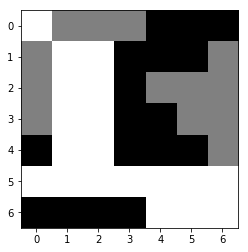

((1, 2), (2, 4)): n_v:  5338 q_all:+0.213635 q:+0.105235 q_m:+0.312000 p:0.376591
((1, 2), (0, 3)): n_v:  1832 q_all:+0.121103 q:+0.037408 q_m:+0.180000 p:0.511747
((2, 2), (2, 4)): n_v:   106 q_all:+0.132871 q:+0.063432 q_m:+0.312000 p:0.026906
((4, 2), (2, 4)): n_v:    92 q_all:+0.131074 q:+0.049673 q_m:+0.312000 p:0.023373
((3, 2), (2, 4)): n_v:    77 q_all:+0.138670 q:+0.080076 q_m:+0.312000 p:0.018275
((1, 1), (0, 3)): n_v:    66 q_all:+0.109407 q:+0.022295 q_m:+0.160000 p:0.020223
((5, 6), (3, 5)): n_v:    30 q_all:+0.160749 q:+0.064015 q_m:+0.160000 p:0.005735
((2, 1), (3, 0)): n_v:     8 q_all:+0.082393 q:+0.069571 q_m:+0.100000 p:0.003043
((3, 2), (1, 0)): n_v:     3 q_all:+0.013611 q:-0.058124 q_m:+0.040000 p:0.001644
((1, 1), (0, 2)): n_v:     3 q_all:+0.087466 q:-0.002175 q_m:+0.100000 p:0.001294
((2, 1), (0, 3)): n_v:     2 q_all:+0.083941 q:+0.024804 q_m:+0.160000 p:0.000854
((5, 5), (4, 6)): n_v:     1 q_all:+0.112820 q:+0.038753 q_m:+0.100000 p:0.000463
((2, 2), (0, 3))

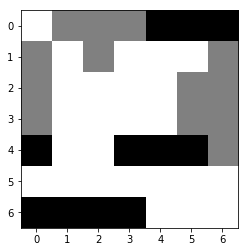

((4, 4), (2, 5)): n_v:  4137 q_all:-0.132551 q:-0.162712 q_m:-0.120000 p:0.284399
((4, 3), (2, 5)): n_v:  2563 q_all:-0.092102 q:-0.134780 q_m:-0.120000 p:0.086223
((4, 5), (2, 5)): n_v:  1310 q_all:-0.211383 q:-0.147315 q_m:-0.120000 p:0.303009
((0, 6), (2, 5)): n_v:   566 q_all:-0.239058 q:-0.120013 q_m:-0.120000 p:0.173531
((0, 4), (1, 2)): n_v:   359 q_all:-0.137986 q:-0.110088 q_m:-0.080000 p:0.010894
((0, 5), (2, 5)): n_v:   114 q_all:-0.244094 q:-0.152600 q_m:-0.120000 p:0.036260
((4, 5), (2, 6)): n_v:    69 q_all:-0.259250 q:-0.254155 q_m:-0.256000 p:0.024536
((4, 5), (4, 6)): n_v:    67 q_all:-0.247737 q:-0.208838 q_m:-0.180000 p:0.022085
((0, 4), (2, 5)): n_v:    65 q_all:-0.233458 q:-0.173897 q_m:-0.120000 p:0.018856
((4, 0), (2, 0)): n_v:    26 q_all:-0.206497 q:-0.201242 q_m:-0.160000 p:0.005808
((4, 4), (3, 5)): n_v:    18 q_all:-0.255239 q:-0.196634 q_m:-0.180000 p:0.006279
((4, 0), (3, 0)): n_v:    14 q_all:-0.180684 q:-0.179714 q_m:-0.140000 p:0.002102
((0, 4), (0, 3))

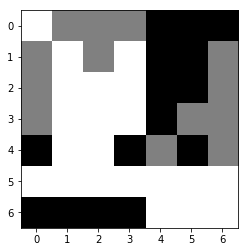

((3, 3), (4, 4)): n_v:  4179 q_all:+0.160070 q:+0.105734 q_m:+0.284000 p:0.165992
((5, 3), (3, 5)): n_v:   542 q_all:+0.155430 q:+0.068354 q_m:+0.312000 p:0.027465
((1, 3), (0, 3)): n_v:   297 q_all:+0.096495 q:+0.065853 q_m:+0.228000 p:0.056996
((5, 6), (3, 5)): n_v:   287 q_all:+0.126103 q:+0.086575 q_m:+0.312000 p:0.034575
((2, 3), (4, 4)): n_v:   274 q_all:+0.147978 q:+0.126593 q_m:+0.256000 p:0.018808
((5, 6), (4, 4)): n_v:   270 q_all:+0.158081 q:+0.097037 q_m:+0.256000 p:0.011954
((1, 3), (3, 5)): n_v:   184 q_all:+0.133933 q:+0.100931 q_m:+0.312000 p:0.018561
((5, 4), (3, 5)): n_v:   175 q_all:+0.162486 q:+0.078624 q_m:+0.312000 p:0.005898
((5, 5), (3, 5)): n_v:    89 q_all:+0.130925 q:+0.074975 q_m:+0.312000 p:0.009801
((2, 3), (3, 5)): n_v:    87 q_all:+0.135408 q:+0.103871 q_m:+0.312000 p:0.008587
((3, 1), (1, 0)): n_v:    71 q_all:+0.027388 q:-0.004088 q_m:+0.120000 p:0.025297
((6, 6), (4, 4)): n_v:    54 q_all:+0.152640 q:+0.096891 q_m:+0.256000 p:0.003081
((3, 3), (3, 5))

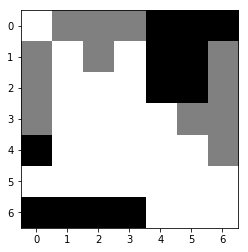

((2, 4), (3, 5)): n_v:  3797 q_all:-0.085603 q:-0.151975 q_m:-0.120000 p:0.226659
((0, 4), (1, 2)): n_v:  2572 q_all:-0.091669 q:-0.132774 q_m:-0.060000 p:0.049664
((2, 5), (4, 6)): n_v:   864 q_all:-0.160075 q:-0.116166 q_m:-0.140000 p:0.159634
((2, 4), (4, 6)): n_v:   737 q_all:-0.107152 q:-0.143134 q_m:-0.140000 p:0.041784
((2, 4), (1, 2)): n_v:   381 q_all:-0.147892 q:-0.144422 q_m:-0.060000 p:0.058994
((1, 5), (3, 5)): n_v:   138 q_all:-0.199056 q:-0.178529 q_m:-0.140000 p:0.038672
((1, 4), (1, 2)): n_v:    45 q_all:-0.151006 q:-0.127001 q_m:-0.060000 p:0.006960
((4, 0), (2, 0)): n_v:    43 q_all:-0.182153 q:-0.158612 q_m:-0.140000 p:0.010456
((1, 4), (3, 5)): n_v:    12 q_all:-0.187294 q:-0.167946 q_m:-0.140000 p:0.003137
((4, 0), (3, 0)): n_v:     6 q_all:-0.154606 q:-0.111704 q_m:-0.120000 p:0.001077
((2, 5), (3, 6)): n_v:     2 q_all:-0.246749 q:-0.212674 q_m:-0.200000 p:0.001023
((0, 5), (2, 6)): n_v:     1 q_all:-0.313745 q:-0.248695 q_m:-0.284000 p:0.000562
((0, 6), (2, 6))

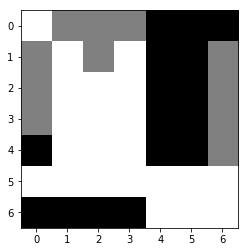

((1, 3), (0, 3)): n_v:  5124 q_all:+0.146095 q:+0.096329 q_m:+0.228000 p:0.517998
((1, 1), (0, 3)): n_v:  1682 q_all:+0.182583 q:+0.075769 q_m:+0.200000 p:0.034088
((5, 6), (3, 6)): n_v:   411 q_all:+0.132512 q:+0.050228 q_m:+0.256000 p:0.039580
((5, 5), (4, 6)): n_v:   192 q_all:+0.112991 q:+0.079685 q_m:+0.228000 p:0.030752
((3, 1), (1, 0)): n_v:   147 q_all:+0.003393 q:-0.017306 q_m:+0.120000 p:0.059670
((5, 5), (3, 6)): n_v:   122 q_all:+0.135647 q:+0.045835 q_m:+0.256000 p:0.010505
((3, 2), (1, 0)): n_v:   118 q_all:-0.046732 q:-0.035317 q_m:+0.120000 p:0.060853
((5, 0), (3, 0)): n_v:    83 q_all:+0.074730 q:+0.029817 q_m:+0.160000 p:0.020982
((2, 1), (3, 0)): n_v:    54 q_all:+0.082044 q:+0.056924 q_m:+0.180000 p:0.012999
((2, 1), (0, 3)): n_v:    53 q_all:+0.104002 q:+0.064030 q_m:+0.200000 p:0.010300
((2, 2), (1, 0)): n_v:    32 q_all:-0.008974 q:-0.035110 q_m:+0.120000 p:0.014201
((2, 3), (0, 1)): n_v:    31 q_all:+0.029703 q:+0.015569 q_m:+0.120000 p:0.010971
((1, 1), (1, 2))

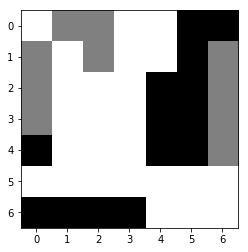

((4, 0), (3, 0)): n_v:  4897 q_all:-0.013632 q:-0.149531 q_m:-0.080000 p:0.004745
((3, 4), (1, 2)): n_v:  2317 q_all:-0.144994 q:-0.076672 q_m:+0.020000 p:0.504669
((2, 4), (1, 2)): n_v:  2182 q_all:-0.137092 q:-0.095050 q_m:+0.020000 p:0.427881
((4, 0), (2, 0)): n_v:    31 q_all:-0.176373 q:-0.213068 q_m:-0.100000 p:0.009703
((2, 5), (4, 6)): n_v:    16 q_all:-0.228630 q:-0.144726 q_m:-0.140000 p:0.007103
((3, 5), (4, 6)): n_v:    12 q_all:-0.138336 q:-0.169716 q_m:-0.120000 p:0.002334
((4, 5), (2, 6)): n_v:    12 q_all:-0.289631 q:-0.287143 q_m:-0.228000 p:0.006861
((2, 4), (4, 6)): n_v:    10 q_all:-0.168038 q:-0.189760 q_m:-0.140000 p:0.002978
((2, 4), (0, 2)): n_v:     9 q_all:-0.202790 q:-0.220952 q_m:-0.100000 p:0.003643
((0, 5), (2, 6)): n_v:     8 q_all:-0.249503 q:-0.277337 q_m:-0.228000 p:0.004072
((1, 5), (2, 6)): n_v:     3 q_all:-0.258510 q:-0.275245 q_m:-0.200000 p:0.001678
((2, 5), (3, 6)): n_v:     2 q_all:-0.315519 q:-0.277299 q_m:-0.200000 p:0.001419
((1, 5), (3, 6))

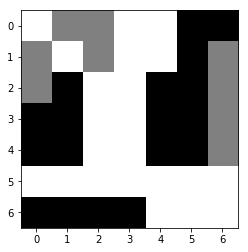

((0, 4), (2, 6)): n_v:  4330 q_all:+0.094755 q:-0.022206 q_m:+0.200000 p:0.026637
((1, 1), (2, 0)): n_v:  2113 q_all:+0.014342 q:+0.166858 q_m:+0.228000 p:0.350769
((5, 5), (4, 6)): n_v:  1405 q_all:+0.005880 q:+0.052779 q_m:+0.180000 p:0.267310
((0, 0), (2, 0)): n_v:  1350 q_all:+0.107307 q:+0.102159 q_m:+0.200000 p:0.076402
((0, 4), (1, 6)): n_v:   135 q_all:+0.067565 q:+0.078932 q_m:+0.256000 p:0.001863
((6, 6), (4, 6)): n_v:   132 q_all:-0.003858 q:+0.036916 q_m:+0.160000 p:0.028572
((6, 5), (4, 6)): n_v:   113 q_all:-0.009278 q:+0.008504 q_m:+0.160000 p:0.025734
((6, 4), (4, 6)): n_v:    71 q_all:-0.010556 q:-0.032393 q_m:+0.160000 p:0.016404
((0, 3), (1, 2)): n_v:    45 q_all:+0.060722 q:+0.035978 q_m:+0.140000 p:0.001526
((1, 4), (1, 6)): n_v:    44 q_all:+0.068563 q:+0.048009 q_m:+0.256000 p:0.000365
((5, 5), (3, 6)): n_v:    43 q_all:+0.066293 q:+0.053384 q_m:+0.200000 p:0.000545
((5, 6), (3, 6)): n_v:    37 q_all:+0.045425 q:+0.065081 q_m:+0.200000 p:0.002818
((0, 0), (1, 0))

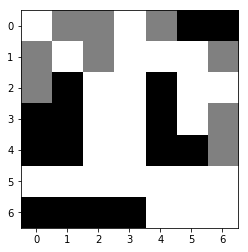

((2, 4), (1, 2)): n_v:  3938 q_all:-0.001556 q:-0.097623 q_m:-0.000000 p:0.066701
((0, 5), (0, 4)): n_v:  2023 q_all:-0.088152 q:-0.084845 q_m:-0.020000 p:0.397158
((2, 1), (1, 2)): n_v:   900 q_all:-0.073171 q:-0.071064 q_m:+0.020000 p:0.146907
((0, 6), (0, 4)): n_v:   739 q_all:-0.104343 q:-0.096523 q_m:-0.040000 p:0.169985
((2, 4), (4, 6)): n_v:   738 q_all:+0.000494 q:-0.073883 q_m:-0.080000 p:0.009263
((3, 4), (1, 2)): n_v:   343 q_all:-0.081981 q:-0.092358 q_m:-0.000000 p:0.063053
((3, 0), (1, 2)): n_v:   258 q_all:-0.084605 q:-0.114932 q_m:-0.000000 p:0.048683
((0, 5), (1, 6)): n_v:   126 q_all:-0.064803 q:-0.105453 q_m:-0.060000 p:0.018742
((2, 1), (1, 0)): n_v:    98 q_all:-0.127205 q:-0.172214 q_m:-0.100000 p:0.027411
((4, 4), (3, 6)): n_v:    36 q_all:-0.057842 q:-0.185277 q_m:-0.080000 p:0.004811
((2, 4), (3, 6)): n_v:    27 q_all:-0.081925 q:-0.135119 q_m:-0.080000 p:0.005088
((2, 1), (0, 2)): n_v:    25 q_all:-0.157318 q:-0.104258 q_m:-0.080000 p:0.008775
((3, 1), (1, 2))

((0, 0), (0, 2)): n_v:  5135 q_all:+0.019526 q:-0.011283 q_m:+0.160000 p:0.795567
((1, 4), (1, 6)): n_v:  1735 q_all:+0.092464 q:+0.010932 q_m:+0.080000 p:0.000950
((1, 4), (0, 2)): n_v:  1035 q_all:+0.081793 q:-0.044809 q_m:+0.160000 p:0.009732
((1, 4), (2, 4)): n_v:   467 q_all:+0.066727 q:-0.030381 q_m:+0.140000 p:0.012032
((3, 2), (2, 4)): n_v:   261 q_all:+0.008974 q:-0.055887 q_m:+0.120000 p:0.046410
((0, 0), (2, 0)): n_v:    88 q_all:+0.024610 q:+0.016512 q_m:+0.160000 p:0.012824
((2, 6), (2, 4)): n_v:    67 q_all:+0.057208 q:-0.029962 q_m:+0.120000 p:0.003759
((2, 6), (0, 4)): n_v:    34 q_all:-0.037311 q:-0.004904 q_m:+0.120000 p:0.009570
((0, 0), (1, 0)): n_v:    22 q_all:-0.008727 q:-0.054501 q_m:+0.100000 p:0.004920
((1, 4), (0, 4)): n_v:    14 q_all:-0.019776 q:+0.031043 q_m:+0.140000 p:0.003336
((4, 2), (2, 4)): n_v:    11 q_all:-0.067998 q:-0.108806 q_m:+0.120000 p:0.003873
((4, 3), (2, 4)): n_v:    10 q_all:-0.111829 q:-0.060242 q_m:+0.120000 p:0.004510
((3, 2), (1, 0))

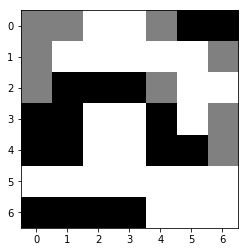

((0, 6), (2, 4)): n_v:  3969 q_all:-0.013305 q:-0.060777 q_m:+0.080000 p:0.364238
((2, 3), (2, 4)): n_v:  2990 q_all:-0.001446 q:-0.064827 q_m:+0.100000 p:0.203899
((0, 5), (2, 4)): n_v:  1791 q_all:+0.012736 q:-0.086105 q_m:+0.080000 p:0.071699
((4, 5), (2, 4)): n_v:   384 q_all:-0.002615 q:-0.100673 q_m:+0.080000 p:0.026842
((0, 6), (0, 4)): n_v:   251 q_all:-0.105636 q:-0.154424 q_m:-0.000000 p:0.069343
((2, 3), (0, 4)): n_v:   229 q_all:+0.030173 q:-0.112017 q_m:-0.000000 p:0.001223
((4, 4), (2, 4)): n_v:    83 q_all:-0.017117 q:-0.122467 q_m:+0.080000 p:0.008342
((2, 2), (2, 4)): n_v:    52 q_all:-0.004962 q:-0.086824 q_m:+0.080000 p:0.003850
((0, 5), (0, 4)): n_v:    48 q_all:-0.088941 q:-0.124089 q_m:+0.020000 p:0.011827
((2, 2), (0, 4)): n_v:    37 q_all:-0.057039 q:-0.117485 q_m:-0.000000 p:0.006767
((2, 1), (0, 1)): n_v:    16 q_all:-0.024370 q:-0.100517 q_m:-0.040000 p:0.001891
((2, 3), (0, 1)): n_v:     4 q_all:-0.062922 q:-0.102352 q_m:-0.040000 p:0.000904
((2, 1), (2, 0))

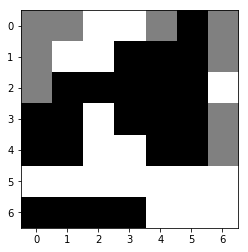

((0, 3), (0, 4)): n_v:  7306 q_all:+0.098712 q:+0.037159 q_m:+0.100000 p:0.914871
((1, 1), (2, 0)): n_v:   158 q_all:+0.059733 q:-0.007778 q_m:+0.060000 p:0.032889
((0, 2), (0, 4)): n_v:   127 q_all:+0.039208 q:-0.002414 q_m:+0.080000 p:0.032111
((2, 6), (0, 4)): n_v:    42 q_all:+0.085283 q:+0.018992 q_m:+0.080000 p:0.006494
((1, 2), (0, 4)): n_v:    10 q_all:-0.007559 q:+0.049592 q_m:+0.080000 p:0.003714
((5, 5), (4, 6)): n_v:     7 q_all:-0.032332 q:-0.043653 q_m:+0.020000 p:0.002961
((2, 6), (1, 6)): n_v:     3 q_all:+0.010890 q:-0.005982 q_m:+0.060000 p:0.001237
((1, 1), (1, 0)): n_v:     1 q_all:-0.080994 q:-0.088298 q_m:-0.020000 p:0.000788
((1, 2), (2, 0)): n_v:     1 q_all:+0.018874 q:+0.000148 q_m:+0.040000 p:0.000284
((6, 6), (4, 6)): n_v:     1 q_all:-0.080029 q:-0.056545 q_m:-0.000000 p:0.000906
((0, 2), (2, 0)): n_v:     0 q_all:+0.006268 q:-0.044331 q_m:+0.040000 p:0.000200
((3, 2), (1, 0)): n_v:     0 q_all:-0.060968 q:-0.092420 q_m:-0.040000 p:0.000433
((4, 2), (2, 0))

((2, 1), (0, 1)): n_v:  7182 q_all:-0.091773 q:-0.047508 q_m:+0.020000 p:0.735177
((2, 5), (1, 6)): n_v:  2948 q_all:-0.046427 q:-0.066702 q_m:+0.040000 p:0.060698
((2, 3), (0, 1)): n_v:   436 q_all:-0.124499 q:-0.066754 q_m:+0.020000 p:0.070346
((2, 1), (1, 0)): n_v:   319 q_all:-0.130824 q:-0.106383 q_m:-0.040000 p:0.055016
((2, 1), (2, 0)): n_v:   236 q_all:-0.063617 q:-0.080207 q_m:-0.040000 p:0.012214
((2, 2), (0, 1)): n_v:    83 q_all:-0.128348 q:-0.061235 q_m:+0.020000 p:0.013996
((3, 0), (1, 0)): n_v:    79 q_all:-0.074386 q:-0.157622 q_m:-0.060000 p:0.005314
((3, 5), (4, 6)): n_v:    75 q_all:-0.114043 q:-0.007226 q_m:-0.000000 p:0.010422
((2, 5), (0, 6)): n_v:    29 q_all:-0.114673 q:-0.180662 q_m:-0.020000 p:0.004171
((2, 1), (0, 0)): n_v:    10 q_all:-0.151011 q:-0.096307 q_m:-0.060000 p:0.002248
((3, 5), (1, 6)): n_v:     7 q_all:-0.138494 q:-0.166099 q_m:+0.020000 p:0.001417
((4, 1), (2, 0)): n_v:     6 q_all:-0.133405 q:-0.157607 q_m:-0.060000 p:0.001099
((2, 5), (4, 6))

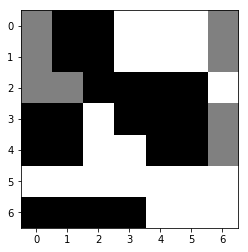

((3, 2), (2, 1)): n_v:  7509 q_all:+0.127812 q:+0.088488 q_m:+0.200000 p:0.490296
((0, 3), (2, 1)): n_v:  1591 q_all:+0.100049 q:+0.055497 q_m:+0.180000 p:0.183967
((4, 3), (2, 1)): n_v:   579 q_all:+0.067282 q:+0.028021 q_m:+0.180000 p:0.101466
((3, 2), (1, 0)): n_v:   499 q_all:+0.067792 q:-0.026090 q_m:+0.060000 p:0.086971
((1, 3), (2, 1)): n_v:   468 q_all:+0.080716 q:+0.061562 q_m:+0.180000 p:0.070500
((5, 6), (3, 6)): n_v:    92 q_all:+0.070332 q:+0.013036 q_m:+0.100000 p:0.015729
((2, 6), (3, 6)): n_v:    53 q_all:+0.048623 q:+0.034304 q_m:+0.120000 p:0.011184
((1, 5), (3, 6)): n_v:    51 q_all:+0.032959 q:+0.013648 q_m:+0.100000 p:0.012319
((1, 4), (3, 6)): n_v:    22 q_all:+0.007592 q:+0.017843 q_m:+0.100000 p:0.006378
((5, 5), (3, 6)): n_v:    21 q_all:+0.019802 q:-0.003122 q_m:+0.100000 p:0.005733
((4, 2), (2, 1)): n_v:    21 q_all:+0.064297 q:-0.007240 q_m:+0.180000 p:0.003788
((5, 4), (3, 6)): n_v:    14 q_all:+0.007957 q:-0.016142 q_m:+0.100000 p:0.004126
((0, 5), (1, 6))

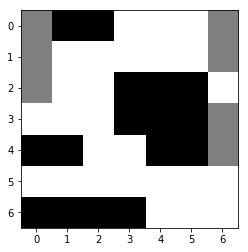

((0, 1), (2, 0)): n_v:  7512 q_all:-0.064178 q:-0.094613 q_m:-0.040000 p:0.368304
((0, 1), (1, 0)): n_v:   867 q_all:-0.187122 q:-0.152165 q_m:-0.100000 p:0.232991
((0, 2), (2, 0)): n_v:   729 q_all:-0.083360 q:-0.104758 q_m:-0.040000 p:0.060725
((4, 0), (2, 0)): n_v:   634 q_all:-0.121452 q:-0.135426 q_m:-0.040000 p:0.095867
((3, 5), (4, 6)): n_v:   260 q_all:-0.219765 q:-0.145218 q_m:-0.100000 p:0.084999
((4, 1), (2, 0)): n_v:   198 q_all:-0.130590 q:-0.158067 q_m:-0.040000 p:0.033224
((2, 5), (1, 6)): n_v:   149 q_all:-0.152838 q:-0.186424 q_m:-0.060000 p:0.031132
((2, 4), (4, 6)): n_v:    48 q_all:-0.212732 q:-0.104106 q_m:-0.120000 p:0.015308
((2, 5), (4, 6)): n_v:    12 q_all:-0.203095 q:-0.315822 q_m:-0.120000 p:0.003710
((2, 5), (0, 6)): n_v:     5 q_all:-0.256207 q:-0.382972 q_m:-0.120000 p:0.001932
((0, 2), (1, 0)): n_v:     4 q_all:-0.177586 q:-0.223605 q_m:-0.120000 p:0.001192
((3, 4), (4, 6)): n_v:     3 q_all:-0.262415 q:-0.168920 q_m:-0.120000 p:0.001428
((3, 5), (1, 6))

((5, 6), (3, 6)): n_v:  5710 q_all:+0.115026 q:+0.052398 q_m:+0.160000 p:0.058390
((3, 2), (1, 0)): n_v:  1988 q_all:+0.052783 q:+0.015585 q_m:+0.160000 p:0.241509
((0, 5), (1, 6)): n_v:  1885 q_all:+0.089451 q:+0.024621 q_m:+0.100000 p:0.072718
((2, 6), (3, 6)): n_v:   733 q_all:+0.070752 q:+0.085757 q_m:+0.180000 p:0.059854
((2, 2), (1, 0)): n_v:   312 q_all:+0.039313 q:-0.011131 q_m:+0.160000 p:0.045553
((5, 5), (3, 6)): n_v:   268 q_all:+0.041052 q:+0.027117 q_m:+0.160000 p:0.038201
((1, 5), (3, 6)): n_v:   235 q_all:+0.043239 q:+0.025818 q_m:+0.160000 p:0.032692
((0, 4), (1, 6)): n_v:   187 q_all:-0.013302 q:-0.031217 q_m:+0.080000 p:0.044861
((1, 2), (0, 1)): n_v:   116 q_all:+0.075690 q:+0.066962 q_m:+0.140000 p:0.008176
((1, 4), (3, 6)): n_v:   106 q_all:+0.036304 q:+0.025544 q_m:+0.160000 p:0.016128
((0, 3), (0, 1)): n_v:    61 q_all:+0.046567 q:+0.035146 q_m:+0.120000 p:0.008167
((5, 4), (3, 6)): n_v:    51 q_all:+0.041413 q:+0.028191 q_m:+0.160000 p:0.007281
((2, 2), (0, 1))

((4, 4), (5, 6)): n_v:  6151 q_all:-0.024057 q:-0.090948 q_m:-0.000000 p:0.145071
((2, 4), (4, 6)): n_v:  1325 q_all:-0.065678 q:-0.049780 q_m:-0.000000 p:0.055876
((3, 4), (1, 6)): n_v:  1119 q_all:-0.135927 q:-0.100323 q_m:-0.000000 p:0.255815
((3, 4), (5, 6)): n_v:   967 q_all:-0.120902 q:-0.051701 q_m:-0.000000 p:0.182206
((0, 2), (1, 0)): n_v:   349 q_all:-0.194655 q:-0.308083 q_m:-0.160000 p:0.123617
((2, 4), (1, 6)): n_v:   339 q_all:-0.141879 q:-0.144801 q_m:-0.000000 p:0.082890
((1, 1), (1, 0)): n_v:   129 q_all:-0.239770 q:-0.311823 q_m:-0.140000 p:0.057229
((3, 0), (1, 0)): n_v:    61 q_all:-0.292770 q:-0.326585 q_m:-0.160000 p:0.033590
((3, 4), (4, 6)): n_v:     9 q_all:-0.145459 q:-0.053118 q_m:-0.000000 p:0.002199
((2, 0), (0, 1)): n_v:     6 q_all:-0.125339 q:-0.182515 q_m:-0.120000 p:0.001296
((3, 1), (1, 0)): n_v:     6 q_all:-0.316598 q:-0.279434 q_m:-0.160000 p:0.003613
((2, 3), (0, 1)): n_v:     3 q_all:-0.225454 q:-0.169370 q_m:-0.120000 p:0.001345
((4, 4), (4, 6))

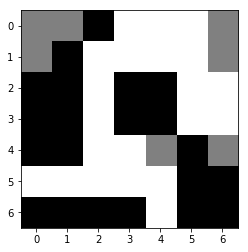

((3, 6), (4, 4)): n_v:  6113 q_all:+0.103117 q:+0.005678 q_m:+0.160000 p:0.042930
((3, 5), (4, 4)): n_v:  2646 q_all:+0.030656 q:+0.024116 q_m:+0.180000 p:0.194729
((3, 2), (4, 4)): n_v:   871 q_all:+0.016135 q:+0.004701 q_m:+0.160000 p:0.096367
((2, 2), (4, 4)): n_v:   547 q_all:+0.021438 q:-0.016792 q_m:+0.160000 p:0.053062
((2, 6), (4, 4)): n_v:   296 q_all:+0.010941 q:-0.009448 q_m:+0.160000 p:0.036698
((3, 6), (1, 6)): n_v:    99 q_all:-0.103370 q:-0.082131 q_m:-0.000000 p:0.039509
((3, 2), (1, 0)): n_v:    90 q_all:+0.007889 q:-0.039168 q_m:+0.120000 p:0.011837
((2, 5), (4, 4)): n_v:    80 q_all:+0.000840 q:-0.017098 q_m:+0.160000 p:0.011964
((5, 2), (4, 4)): n_v:    74 q_all:+0.013222 q:-0.004373 q_m:+0.160000 p:0.008840
((4, 2), (4, 4)): n_v:    63 q_all:-0.026089 q:-0.033772 q_m:+0.160000 p:0.013790
((6, 4), (4, 4)): n_v:    44 q_all:+0.025132 q:-0.021014 q_m:+0.160000 p:0.003851
((3, 5), (1, 6)): n_v:    26 q_all:-0.072614 q:-0.067167 q_m:-0.000000 p:0.008993
((0, 4), (1, 6))

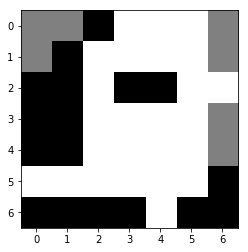

((2, 4), (4, 6)): n_v:  5291 q_all:-0.013495 q:+0.010505 q_m:-0.040000 p:0.044554
((6, 5), (4, 6)): n_v:  2177 q_all:-0.106872 q:-0.036660 q_m:-0.040000 p:0.365775
((6, 6), (4, 6)): n_v:  1345 q_all:-0.116409 q:+0.007763 q_m:-0.040000 p:0.258674
((5, 6), (3, 6)): n_v:   666 q_all:-0.079868 q:-0.029796 q_m:-0.000000 p:0.065760
((2, 4), (1, 6)): n_v:   604 q_all:-0.056051 q:-0.103959 q_m:-0.000000 p:0.022825
((2, 4), (3, 6)): n_v:   276 q_all:-0.067152 q:-0.005980 q_m:-0.000000 p:0.018171
((0, 2), (1, 0)): n_v:   230 q_all:-0.177470 q:-0.268446 q_m:-0.160000 p:0.073792
((5, 6), (4, 6)): n_v:   162 q_all:-0.108461 q:+0.006030 q_m:-0.020000 p:0.027856
((2, 0), (0, 1)): n_v:   111 q_all:-0.128894 q:-0.181159 q_m:-0.120000 p:0.025017
((1, 1), (1, 0)): n_v:    64 q_all:-0.225226 q:-0.220177 q_m:-0.140000 p:0.026468
((2, 3), (0, 1)): n_v:    54 q_all:-0.158204 q:-0.168278 q_m:-0.120000 p:0.015350
((0, 2), (0, 1)): n_v:    16 q_all:-0.101024 q:-0.162694 q_m:-0.100000 p:0.002367
((3, 0), (1, 0))

((1, 4), (3, 6)): n_v:  3649 q_all:+0.053294 q:+0.007440 q_m:+0.160000 p:0.222370
((1, 3), (2, 4)): n_v:  1905 q_all:+0.063505 q:+0.002326 q_m:+0.140000 p:0.018286
((3, 4), (3, 6)): n_v:  1700 q_all:+0.082686 q:+0.029830 q_m:+0.160000 p:0.004813
((0, 5), (2, 4)): n_v:  1099 q_all:+0.043001 q:+0.006032 q_m:+0.120000 p:0.074223
((1, 5), (3, 6)): n_v:   836 q_all:-0.026827 q:+0.049437 q_m:+0.160000 p:0.183144
((2, 5), (3, 6)): n_v:   260 q_all:-0.049975 q:+0.046337 q_m:+0.180000 p:0.069021
((5, 4), (3, 6)): n_v:   203 q_all:-0.034540 q:+0.031821 q_m:+0.160000 p:0.047683
((3, 2), (2, 4)): n_v:   165 q_all:-0.045142 q:-0.005506 q_m:+0.120000 p:0.042305
((4, 4), (3, 6)): n_v:    56 q_all:-0.043268 q:+0.009799 q_m:+0.160000 p:0.014310
((2, 6), (2, 4)): n_v:    42 q_all:+0.031848 q:+0.024289 q_m:+0.120000 p:0.004020
((0, 3), (0, 1)): n_v:    40 q_all:-0.010367 q:-0.046466 q_m:+0.120000 p:0.007483
((2, 2), (2, 4)): n_v:    38 q_all:-0.051349 q:-0.023491 q_m:+0.120000 p:0.010212
((1, 2), (0, 1))

((2, 3), (1, 4)): n_v:  6198 q_all:-0.057975 q:+0.002718 q_m:+0.100000 p:0.620665
((0, 2), (1, 4)): n_v:  1229 q_all:-0.096506 q:-0.040456 q_m:+0.080000 p:0.224996
((2, 3), (2, 4)): n_v:   690 q_all:-0.054751 q:+0.026698 q_m:+0.100000 p:0.064311
((0, 2), (2, 4)): n_v:   206 q_all:-0.061010 q:-0.048331 q_m:+0.080000 p:0.021984
((2, 3), (0, 1)): n_v:   132 q_all:-0.172136 q:-0.383017 q_m:-0.120000 p:0.045928
((2, 0), (0, 1)): n_v:    64 q_all:-0.029495 q:-0.253926 q_m:-0.120000 p:0.002376
((0, 2), (1, 0)): n_v:    10 q_all:-0.164491 q:-0.376089 q_m:-0.160000 p:0.003425
((0, 2), (0, 1)): n_v:    10 q_all:-0.147826 q:-0.334310 q_m:-0.100000 p:0.002716
((1, 1), (1, 0)): n_v:     4 q_all:-0.191270 q:-0.481218 q_m:-0.140000 p:0.001766
((3, 0), (1, 0)): n_v:     4 q_all:-0.378705 q:-0.423010 q_m:-0.160000 p:0.003454
((0, 2), (0, 0)): n_v:     3 q_all:-0.138330 q:-0.374697 q_m:-0.160000 p:0.000926
((2, 1), (0, 1)): n_v:     2 q_all:-0.236037 q:-0.281258 q_m:-0.120000 p:0.001200
((3, 1), (1, 0))

((3, 3), (2, 4)): n_v:  9684 q_all:+0.037857 q:+0.035365 q_m:+0.120000 p:0.196410
((3, 2), (2, 4)): n_v:   319 q_all:-0.002195 q:+0.034826 q_m:+0.100000 p:0.030673
((2, 6), (2, 4)): n_v:   161 q_all:+0.003790 q:+0.012993 q_m:+0.100000 p:0.013683
((2, 6), (1, 6)): n_v:    96 q_all:-0.129304 q:-0.177557 q_m:+0.040000 p:0.032335
((1, 2), (2, 4)): n_v:    88 q_all:+0.026936 q:-0.066374 q_m:+0.100000 p:0.003583
((4, 2), (2, 4)): n_v:    78 q_all:-0.041406 q:-0.038274 q_m:+0.100000 p:0.013392
((4, 3), (2, 4)): n_v:    72 q_all:-0.020931 q:-0.019381 q_m:+0.100000 p:0.009439
((3, 6), (2, 4)): n_v:    64 q_all:+0.020285 q:-0.069276 q_m:+0.100000 p:0.003381
((2, 2), (2, 4)): n_v:    49 q_all:-0.033525 q:-0.014754 q_m:+0.100000 p:0.007710
((4, 6), (2, 4)): n_v:    40 q_all:+0.006126 q:-0.064735 q_m:+0.100000 p:0.003228
((4, 4), (2, 4)): n_v:    19 q_all:-0.050684 q:-0.023437 q_m:+0.100000 p:0.003288
((3, 6), (1, 6)): n_v:    14 q_all:-0.120497 q:-0.168428 q_m:+0.020000 p:0.004763
((3, 4), (1, 6))

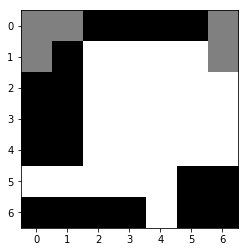

((0, 5), (1, 6)): n_v: 12876 q_all:+0.058997 q:-0.170640 q_m:+0.020000 p:0.638440
((1, 1), (1, 0)): n_v:   251 q_all:-0.285657 q:-0.395658 q_m:-0.100000 p:0.155167
((0, 4), (1, 6)): n_v:    79 q_all:-0.145415 q:-0.291117 q_m:-0.000000 p:0.026922
((0, 2), (1, 0)): n_v:    21 q_all:-0.282521 q:-0.454768 q_m:-0.120000 p:0.013211
((0, 2), (0, 1)): n_v:    16 q_all:-0.162937 q:-0.243457 q_m:-0.060000 p:0.006136
((2, 0), (0, 1)): n_v:    11 q_all:-0.178791 q:-0.268332 q_m:-0.080000 p:0.004707
((3, 0), (1, 0)): n_v:     8 q_all:-0.343654 q:-0.451757 q_m:-0.120000 p:0.005789
((2, 1), (0, 1)): n_v:     1 q_all:-0.217654 q:-0.309423 q_m:-0.080000 p:0.000706
((0, 5), (0, 6)): n_v:     0 q_all:-0.223500 q:-0.332500 q_m:-0.060000 p:0.000365
((0, 4), (0, 6)): n_v:     0 q_all:-0.268790 q:-0.394649 q_m:-0.080000 p:0.000126
((0, 3), (0, 1)): n_v:     0 q_all:-0.222506 q:-0.317510 q_m:-0.080000 p:0.000396
((0, 2), (0, 0)): n_v:     0 q_all:-0.351948 q:-0.506580 q_m:-0.120000 p:0.000049
((3, 1), (1, 0))

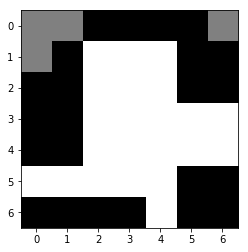

((1, 2), (1, 0)): n_v:  7483 q_all:-0.019412 q:-0.249034 q_m:+0.100000 p:0.344840
((1, 2), (0, 1)): n_v:  3252 q_all:-0.089132 q:-0.051228 q_m:+0.080000 p:0.278807
((3, 2), (1, 0)): n_v:  3041 q_all:-0.076910 q:-0.098271 q_m:+0.100000 p:0.195047
((2, 2), (1, 0)): n_v:   520 q_all:-0.195544 q:-0.227263 q_m:+0.100000 p:0.142102
((2, 2), (0, 1)): n_v:    61 q_all:-0.137724 q:-0.174126 q_m:+0.060000 p:0.010598
((1, 2), (0, 0)): n_v:    57 q_all:-0.180576 q:-0.370663 q_m:+0.020000 p:0.013790
((1, 4), (0, 6)): n_v:    25 q_all:-0.212250 q:-0.251068 q_m:+0.100000 p:0.007395
((1, 3), (0, 1)): n_v:    15 q_all:-0.168854 q:-0.139588 q_m:+0.060000 p:0.002856
((2, 3), (0, 1)): n_v:    13 q_all:-0.128444 q:-0.113352 q_m:+0.060000 p:0.001792
((2, 4), (0, 6)): n_v:     4 q_all:-0.160661 q:-0.177598 q_m:+0.100000 p:0.000676
((2, 2), (0, 0)): n_v:     1 q_all:-0.265317 q:-0.326369 q_m:+0.020000 p:0.000608
-1 's turn
one move takes time(s):  0.34002685546875


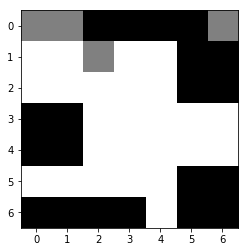

((3, 0), (1, 2)): n_v:  6204 q_all:+0.042461 q:-0.107425 q_m:+0.100000 p:0.282761
((0, 2), (1, 2)): n_v:  4259 q_all:+0.014818 q:+0.216592 q_m:+0.120000 p:0.099907
((3, 1), (1, 2)): n_v:   800 q_all:-0.042629 q:+0.103688 q_m:+0.100000 p:0.120853
((0, 4), (1, 2)): n_v:   349 q_all:-0.027265 q:-0.132654 q_m:+0.100000 p:0.040351
((0, 3), (0, 1)): n_v:    93 q_all:+0.008066 q:-0.065637 q_m:-0.020000 p:0.003239
((0, 2), (0, 1)): n_v:     8 q_all:-0.155358 q:+0.038125 q_m:-0.000000 p:0.002446
((2, 6), (0, 6)): n_v:     0 q_all:-0.418024 q:-0.630041 q_m:-0.100000 p:0.000041
((2, 5), (0, 6)): n_v:     0 q_all:-0.559936 q:-0.866560 q_m:-0.100000 p:0.000011
((0, 4), (0, 6)): n_v:     0 q_all:-0.507103 q:-0.778505 q_m:-0.100000 p:0.000014
((0, 2), (0, 0)): n_v:     0 q_all:-0.144157 q:-0.226928 q_m:-0.020000 p:0.000012
((0, 5), (0, 6)): n_v:     0 q_all:-0.514101 q:-0.803502 q_m:-0.080000 p:0.000004
1 's turn
one move takes time(s):  0.25208568572998047


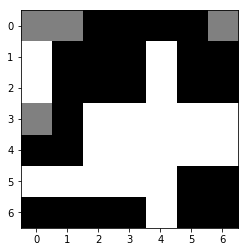

((2, 0), (3, 0)): n_v:  6893 q_all:+0.250207 q:+0.095160 q_m:+0.080000 p:0.300389
((5, 0), (3, 0)): n_v:  1463 q_all:-0.057361 q:-0.054626 q_m:+0.060000 p:0.300424
((1, 0), (0, 1)): n_v:  1282 q_all:+0.011000 q:-0.051220 q_m:+0.040000 p:0.040801
((1, 0), (3, 0)): n_v:   772 q_all:-0.099850 q:+0.060723 q_m:+0.060000 p:0.241521
((2, 0), (0, 1)): n_v:   187 q_all:+0.002115 q:-0.148585 q_m:+0.020000 p:0.010208
((5, 2), (3, 0)): n_v:    89 q_all:-0.129715 q:-0.313281 q_m:+0.060000 p:0.034805
((5, 1), (3, 0)): n_v:    80 q_all:-0.158536 q:-0.172995 q_m:+0.060000 p:0.036720
((4, 2), (3, 0)): n_v:    55 q_all:-0.209248 q:-0.232691 q_m:+0.060000 p:0.032350
((3, 2), (3, 0)): n_v:     5 q_all:-0.110744 q:-0.089866 q_m:+0.060000 p:0.001830
((2, 4), (0, 6)): n_v:     0 q_all:-0.258813 q:-0.444689 q_m:+0.020000 p:0.000008
((1, 4), (0, 6)): n_v:     0 q_all:-0.057194 q:-0.172985 q_m:+0.020000 p:0.000081
((1, 0), (0, 0)): n_v:     0 q_all:-0.218558 q:-0.337597 q_m:-0.040000 p:0.000374
((2, 0), (0, 0))

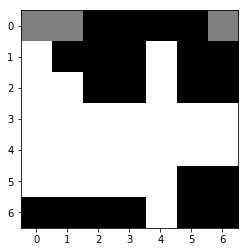

((0, 2), (0, 1)): n_v:  8986 q_all:-0.137208 q:+0.220662 q_m:-0.020000 p:0.330248
((0, 2), (0, 0)): n_v:  1209 q_all:-0.237544 q:-0.128027 q_m:-0.040000 p:0.059239
((2, 2), (0, 0)): n_v:   456 q_all:-0.218924 q:-0.378587 q_m:-0.040000 p:0.001749
((0, 3), (0, 1)): n_v:   366 q_all:-0.392387 q:-0.174978 q_m:-0.040000 p:0.154350
((2, 3), (0, 1)): n_v:   109 q_all:-0.353791 q:-0.257460 q_m:-0.040000 p:0.035494
((0, 4), (0, 6)): n_v:    86 q_all:-0.409183 q:-0.571120 q_m:-0.080000 p:0.039776
((1, 1), (0, 0)): n_v:    56 q_all:-0.283457 q:+0.107342 q_m:-0.020000 p:0.008933
((2, 6), (0, 6)): n_v:    44 q_all:-0.460479 q:-0.615623 q_m:-0.080000 p:0.025989
((2, 2), (0, 1)): n_v:    34 q_all:-0.269192 q:-0.314726 q_m:-0.040000 p:0.004367
((1, 3), (0, 1)): n_v:    33 q_all:-0.423859 q:-0.150344 q_m:-0.040000 p:0.016330
((0, 5), (0, 6)): n_v:    15 q_all:-0.463118 q:-0.583681 q_m:-0.060000 p:0.009141
((1, 2), (0, 0)): n_v:    14 q_all:-0.348177 q:-0.250736 q_m:-0.040000 p:0.004424
((2, 5), (0, 6))

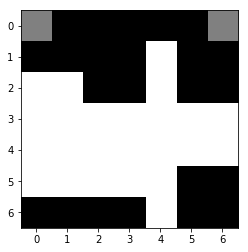

((2, 0), (0, 0)): n_v:  9535 q_all:+0.155487 q:+0.403740 q_m:+0.140000 p:0.879270
((1, 4), (0, 6)): n_v:  3064 q_all:+0.202765 q:+0.759233 q_m:+0.140000 p:0.037129
((2, 4), (0, 6)): n_v:   202 q_all:-0.008288 q:+0.025520 q_m:+0.140000 p:0.074503
((2, 1), (0, 0)): n_v:    15 q_all:-0.084067 q:+0.266239 q_m:+0.140000 p:0.007342
-1 's turn
one move takes time(s):  0.18349671363830566


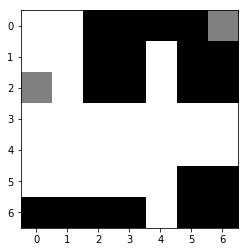

((0, 2), (2, 0)): n_v: 13035 q_all:-0.301035 q:-0.198674 q_m:+0.060000 p:0.935112
((2, 2), (2, 0)): n_v:   134 q_all:-0.330926 q:-0.247717 q_m:+0.060000 p:0.016128
((1, 2), (2, 0)): n_v:   100 q_all:-0.492445 q:-0.694494 q_m:+0.060000 p:0.038979
((2, 5), (0, 6)): n_v:     3 q_all:-0.608660 q:-0.956142 q_m:-0.140000 p:0.001919
((0, 4), (0, 6)): n_v:     3 q_all:-0.619133 q:-0.900302 q_m:-0.140000 p:0.001896
((2, 6), (0, 6)): n_v:     3 q_all:-0.521644 q:-0.903400 q_m:-0.140000 p:0.001233
((0, 5), (0, 6)): n_v:     2 q_all:-0.744706 q:-0.948432 q_m:-0.120000 p:0.002196
1 's turn
one move takes time(s):  0.1442263126373291


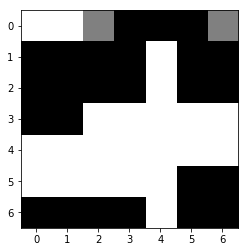

((0, 1), (0, 2)): n_v: 13911 q_all:+0.613630 q:+0.207430 q_m:+0.120000 p:0.736459
((0, 0), (0, 2)): n_v:   633 q_all:+0.068315 q:+0.020787 q_m:+0.100000 p:0.262315
((2, 4), (0, 6)): n_v:     0 q_all:-0.416989 q:-0.734981 q_m:+0.060000 p:0.000009
((1, 4), (0, 6)): n_v:     0 q_all:-0.212237 q:-0.393729 q_m:+0.060000 p:0.000082
((2, 4), (0, 2)): n_v:     0 q_all:-0.011396 q:-0.178491 q_m:+0.100000 p:0.000376
((1, 4), (0, 2)): n_v:     0 q_all:-0.251150 q:-0.485250 q_m:+0.100000 p:0.000732
-1 's turn
one move takes time(s):  0.12843656539916992


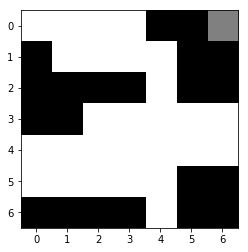

((2, 6), (0, 6)): n_v:  9855 q_all:-0.853496 q:-0.861577 q_m:-0.120000 p:0.484063
((0, 4), (0, 6)): n_v:  4119 q_all:-0.875400 q:-0.944371 q_m:-0.120000 p:0.333358
((2, 5), (0, 6)): n_v:   821 q_all:-0.876944 q:-0.969113 q_m:-0.120000 p:0.068346
((0, 5), (0, 6)): n_v:    97 q_all:-1.000000 q:+5.000000 q_m:-0.100000 p:0.025685
1 's turn


This is a random move


one move takes time(s):  0.08860516548156738


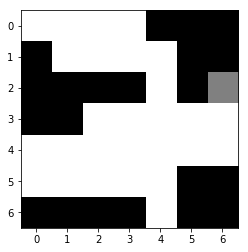

((3, 5), (2, 6)): n_v: 11536 q_all:+1.000000 q:+5.000000 q_m:+0.284000 p:0.488157
((4, 6), (2, 6)): n_v:     7 q_all:+0.565821 q:+0.714976 q_m:+0.256000 p:0.006009
((1, 4), (2, 6)): n_v:     4 q_all:+0.592562 q:+0.594960 q_m:+0.256000 p:0.002254
((3, 4), (2, 6)): n_v:     4 q_all:+0.151057 q:+0.560702 q_m:+0.256000 p:0.004853
((2, 4), (2, 6)): n_v:     1 q_all:-0.353724 q:+0.316919 q_m:+0.256000 p:0.001409
((4, 5), (2, 6)): n_v:     0 q_all:+0.467297 q:+0.608162 q_m:+0.256000 p:0.000897
((4, 4), (2, 6)): n_v:     0 q_all:+0.523636 q:+0.702060 q_m:+0.256000 p:0.000818
this self play has 78 steps, time elapsed 117.55205130577087
winner is 1.0
episode 155 finished
episode 156 now start
it seems the reset did nothing
reset successful
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.8930718898773193
1 's turn


This is a random move


one move takes time(s):  1.0328032970428467
-1 's turn
one move takes time(s):  1.4968178272247314
1 's tu

one move takes time(s):  0.8641135692596436
1 's turn


This is a random move


one move takes time(s):  0.5835251808166504
-1 's turn
one move takes time(s):  0.7246322631835938
1 's turn
one move takes time(s):  0.7692368030548096
-1 's turn


This is a random move


one move takes time(s):  0.5451574325561523
1 's turn


This is a random move


one move takes time(s):  0.5100951194763184
-1 's turn
one move takes time(s):  0.45554018020629883
1 's turn


This is a random move


one move takes time(s):  0.4614403247833252
-1 's turn
one move takes time(s):  0.43739819526672363
1 's turn


This is a random move


one move takes time(s):  0.42950987815856934
-1 's turn
one move takes time(s):  0.34022951126098633
1 's turn


This is a random move


one move takes time(s):  0.317821741104126
-1 's turn
one move takes time(s):  0.4328122138977051
1 's turn


This is a random move


one move takes time(s):  0.21282076835632324
-1 's turn
one move takes time(s):  0.23003935813903809
1 's t

Epoch 9/64
14388/14388 [==============================] - 2s 106us/step - loss: 1.8636 - activation_101_loss: 1.8336 - dense_51_loss: 0.0030 - val_loss: 2.0346 - val_activation_101_loss: 2.0018 - val_dense_51_loss: 0.0058
Epoch 10/64
14388/14388 [==============================] - 2s 105us/step - loss: 1.8581 - activation_101_loss: 1.8282 - dense_51_loss: 0.0029 - val_loss: 2.0317 - val_activation_101_loss: 1.9987 - val_dense_51_loss: 0.0059
Epoch 11/64
14388/14388 [==============================] - 2s 104us/step - loss: 1.8524 - activation_101_loss: 1.8226 - dense_51_loss: 0.0028 - val_loss: 2.0317 - val_activation_101_loss: 1.9985 - val_dense_51_loss: 0.0062
Epoch 12/64
14388/14388 [==============================] - 2s 105us/step - loss: 1.8474 - activation_101_loss: 1.8175 - dense_51_loss: 0.0028 - val_loss: 2.0287 - val_activation_101_loss: 1.9958 - val_dense_51_loss: 0.0058
Epoch 13/64
14388/14388 [==============================] - 2s 106us/step - loss: 1.8440 - activation_101_loss

due to rollout lim, final rollout times:  1752 time elapsed:  2.00034236907959
one move takes time(s):  2.0015594959259033
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.6348719596862793
one move takes time(s):  2.636528253555298
-1 's turn
due to rollout lim, final rollout times:  4301 time elapsed:  2.0000641345977783
one move takes time(s):  2.0013632774353027
1 's turn
due to rollout lim, final rollout times:  3215 time elapsed:  2.0030736923217773
one move takes time(s):  2.004549026489258
-1 's turn
due to rollout lim, final rollout times:  4292 time elapsed:  2.0001347064971924
one move takes time(s):  2.0014026165008545
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.015468120574951
one move takes time(s):  3.017690658569336
-1 's turn
due to rollout lim, final rollout times:  4680 time elapsed:  2.012866735458374
one move takes time(s):  2.0144598484039307
1 's turn
due to rollout lim, final rollout times:  1383 time elapsed

due to rollout lim, final rollout times:  1752 time elapsed:  2.014864921569824
one move takes time(s):  2.016160249710083
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.118988037109375
one move takes time(s):  2.120269536972046
1 's turn
due to rollout lim, final rollout times:  2535 time elapsed:  2.005021810531616
one move takes time(s):  2.0064003467559814
-1 's turn
due to rollout lim, final rollout times:  4775 time elapsed:  2.00011944770813
one move takes time(s):  2.0013725757598877
1 's turn
due to rollout lim, final rollout times:  2774 time elapsed:  2.0000312328338623
one move takes time(s):  2.0014073848724365
-1 's turn
due to rollout lim, final rollout times:  3469 time elapsed:  2.000136613845825
one move takes time(s):  2.001512050628662
1 's turn


This is a random move


one move takes time(s):  1.6501169204711914
-1 's turn
one move takes time(s):  0.9333889484405518
1 's turn
one move takes time(s):  1.3507721424102783
-1 's turn
due to

due to rollout lim, final rollout times:  1001 time elapsed:  3.78299617767334
one move takes time(s):  3.7843642234802246
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.7705636024475098
one move takes time(s):  2.7724382877349854
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.8101389408111572
one move takes time(s):  2.8116941452026367
1 's turn
due to rollout lim, final rollout times:  1527 time elapsed:  2.0131640434265137
one move takes time(s):  2.014488458633423
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.9825053215026855
one move takes time(s):  2.983821392059326
1 's turn
due to rollout lim, final rollout times:  1593 time elapsed:  2.0000455379486084
one move takes time(s):  2.001957893371582
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.0314955711364746


This is a random move


one move takes time(s):  2.032871723175049
1 's turn
due to rollout lim, final rollou

due to rollout lim, final rollout times:  1045 time elapsed:  2.0139639377593994
one move takes time(s):  2.0153439044952393
-1 's turn
due to rollout lim, final rollout times:  3697 time elapsed:  2.012967824935913
one move takes time(s):  2.014554500579834
1 's turn
due to rollout lim, final rollout times:  2540 time elapsed:  2.0104432106018066
one move takes time(s):  2.0117576122283936
-1 's turn
due to rollout lim, final rollout times:  1545 time elapsed:  2.0068836212158203
one move takes time(s):  2.008274793624878
1 's turn
one move takes time(s):  1.8420050144195557
-1 's turn
due to rollout lim, final rollout times:  1962 time elapsed:  2.008434534072876
one move takes time(s):  2.009770393371582
1 's turn
due to rollout lim, final rollout times:  2961 time elapsed:  2.009662628173828
one move takes time(s):  2.0110623836517334
-1 's turn
due to rollout lim, final rollout times:  2650 time elapsed:  2.007936477661133
one move takes time(s):  2.009371519088745
1 's turn
due t

this round has steps: 17, time taken: 1.0572230815887451, 


self wins? True



round: 23
it seems the reset did nothing
reset successful
this game start with 45 space left
this round has steps: 69, time taken: 3.54093599319458, 


self wins? True



round: 24
it seems the reset did nothing
reset successful
this game start with 45 space left
this round has steps: 66, time taken: 2.8873374462127686, 


self wins? True



round: 25
it seems the reset did nothing
reset successful
this game start with 45 space left
this round has steps: 64, time taken: 2.97245192527771, 


self wins? True



round: 26
it seems the reset did nothing
reset successful
this game start with 45 space left
this round has steps: 57, time taken: 2.568289279937744, 


self wins? True



round: 27
it seems the reset did nothing
reset successful
this game start with 45 space left
this round has steps: 60, time taken: 2.443673610687256, 


self wins? True



round: 28
it seems the reset did nothing
reset successful
thi

due to rollout lim, final rollout times:  2394 time elapsed:  2.0094552040100098
one move takes time(s):  2.010749578475952
1 's turn
due to rollout lim, final rollout times:  4683 time elapsed:  2.0119855403900146
one move takes time(s):  2.01346492767334
-1 's turn
one move takes time(s):  1.6961734294891357
1 's turn
due to rollout lim, final rollout times:  3484 time elapsed:  2.0013628005981445
one move takes time(s):  2.0025534629821777
-1 's turn
due to rollout lim, final rollout times:  1770 time elapsed:  2.0079033374786377
one move takes time(s):  2.009110927581787
1 's turn
due to rollout lim, final rollout times:  2714 time elapsed:  2.001957893371582
one move takes time(s):  2.003281831741333
-1 's turn
one move takes time(s):  1.3598008155822754
1 's turn
one move takes time(s):  1.090179681777954
-1 's turn
one move takes time(s):  1.2132747173309326
1 's turn
one move takes time(s):  1.6087539196014404
-1 's turn
one move takes time(s):  0.9989485740661621
1 's turn
one

due to rollout lim, final rollout times:  1871 time elapsed:  2.0000593662261963
one move takes time(s):  2.001394510269165
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.504141092300415
one move takes time(s):  2.505434989929199
-1 's turn
due to rollout lim, final rollout times:  1004 time elapsed:  2.016937494277954


This is a random move


one move takes time(s):  2.018296480178833
1 's turn
due to rollout lim, final rollout times:  1045 time elapsed:  2.012402296066284
one move takes time(s):  2.0136849880218506
-1 's turn
due to rollout lim, final rollout times:  1799 time elapsed:  2.0143933296203613
one move takes time(s):  2.0165178775787354
1 's turn
due to rollout lim, final rollout times:  3805 time elapsed:  2.0000174045562744
one move takes time(s):  2.0016322135925293
-1 's turn
due to rollout lim, final rollout times:  1309 time elapsed:  2.000325918197632


This is a random move


one move takes time(s):  2.002502918243408
1 's turn
due to r

10669/10669 [==============================] - 12s 1ms/step - loss: 2.0044 - activation_101_loss: 1.9686 - dense_51_loss: 0.0087 - val_loss: 2.3085 - val_activation_101_loss: 2.2732 - val_dense_51_loss: 0.0082
Epoch 2/64
10669/10669 [==============================] - 1s 114us/step - loss: 1.9420 - activation_101_loss: 1.9078 - dense_51_loss: 0.0071 - val_loss: 2.2764 - val_activation_101_loss: 2.2414 - val_dense_51_loss: 0.0080
Epoch 3/64
10669/10669 [==============================] - 1s 108us/step - loss: 1.9092 - activation_101_loss: 1.8756 - dense_51_loss: 0.0065 - val_loss: 2.2555 - val_activation_101_loss: 2.2202 - val_dense_51_loss: 0.0083
Epoch 4/64
10669/10669 [==============================] - 1s 107us/step - loss: 1.8861 - activation_101_loss: 1.8530 - dense_51_loss: 0.0061 - val_loss: 2.2428 - val_activation_101_loss: 2.2077 - val_dense_51_loss: 0.0081
Epoch 5/64
10669/10669 [==============================] - 1s 112us/step - loss: 1.8682 - activation_101_loss: 1.8356 - dense

Epoch 38/64
10669/10669 [==============================] - 1s 106us/step - loss: 1.6902 - activation_101_loss: 1.6606 - dense_51_loss: 0.0026 - val_loss: 2.1818 - val_activation_101_loss: 2.1476 - val_dense_51_loss: 0.0072
Epoch 39/64
10669/10669 [==============================] - 1s 108us/step - loss: 1.6885 - activation_101_loss: 1.6589 - dense_51_loss: 0.0025 - val_loss: 2.1837 - val_activation_101_loss: 2.1497 - val_dense_51_loss: 0.0070
Epoch 40/64
10669/10669 [==============================] - 1s 108us/step - loss: 1.6861 - activation_101_loss: 1.6566 - dense_51_loss: 0.0024 - val_loss: 2.1834 - val_activation_101_loss: 2.1496 - val_dense_51_loss: 0.0068
Epoch 41/64
10669/10669 [==============================] - 1s 108us/step - loss: 1.6849 - activation_101_loss: 1.6554 - dense_51_loss: 0.0025 - val_loss: 2.1858 - val_activation_101_loss: 2.1516 - val_dense_51_loss: 0.0072
Epoch 42/64
10669/10669 [==============================] - 1s 106us/step - loss: 1.6830 - activation_101_los

due to rollout lim, final rollout times:  2152 time elapsed:  2.0022263526916504
one move takes time(s):  2.0035152435302734
-1 's turn
due to rollout lim, final rollout times:  1796 time elapsed:  2.00007963180542
one move takes time(s):  2.0016214847564697
1 's turn
due to rollout lim, final rollout times:  4559 time elapsed:  2.0024688243865967
one move takes time(s):  2.003769874572754
-1 's turn
one move takes time(s):  1.0819251537322998
1 's turn
one move takes time(s):  0.9661190509796143
-1 's turn
one move takes time(s):  0.6681296825408936
1 's turn


This is a random move


one move takes time(s):  0.6340751647949219
-1 's turn
one move takes time(s):  0.8489997386932373
1 's turn


This is a random move


one move takes time(s):  0.9007503986358643
-1 's turn
one move takes time(s):  0.6162762641906738
1 's turn
one move takes time(s):  0.46757030487060547
-1 's turn
one move takes time(s):  0.7546076774597168
1 's turn


This is a random move


one move takes time(s):  0.

due to rollout lim, final rollout times:  4057 time elapsed:  2.000049352645874
one move takes time(s):  2.001405715942383
-1 's turn
due to rollout lim, final rollout times:  2460 time elapsed:  2.003967046737671
one move takes time(s):  2.0051958560943604
1 's turn
one move takes time(s):  1.9626045227050781
-1 's turn
due to rollout lim, final rollout times:  4539 time elapsed:  2.0010039806365967
one move takes time(s):  2.0022709369659424
1 's turn
one move takes time(s):  1.8988440036773682
-1 's turn
one move takes time(s):  0.9782540798187256
1 's turn
one move takes time(s):  1.266230583190918
-1 's turn
one move takes time(s):  1.7247188091278076
1 's turn
due to rollout lim, final rollout times:  3278 time elapsed:  2.0000903606414795
one move takes time(s):  2.0017895698547363
-1 's turn
due to rollout lim, final rollout times:  4822 time elapsed:  2.000023365020752


This is a random move


one move takes time(s):  2.001392364501953
1 's turn
one move takes time(s):  1.207

one move takes time(s):  0.4581112861633301
1 's turn
one move takes time(s):  0.6056766510009766
-1 's turn
one move takes time(s):  0.5857105255126953
1 's turn
one move takes time(s):  0.3951141834259033
-1 's turn
one move takes time(s):  0.358914852142334
1 's turn
one move takes time(s):  0.4762551784515381
-1 's turn


This is a random move


one move takes time(s):  0.3357522487640381
1 's turn
one move takes time(s):  0.3158242702484131
-1 's turn


This is a random move


one move takes time(s):  0.23847413063049316
1 's turn


This is a random move


one move takes time(s):  0.1563129425048828
-1 's turn
one move takes time(s):  0.19290590286254883
1 's turn
one move takes time(s):  0.155534029006958
-1 's turn
one move takes time(s):  0.1809990406036377
1 's turn
one move takes time(s):  0.09073948860168457
-1 's turn
one move takes time(s):  0.06414413452148438
this self play has 71 steps, time elapsed 95.90115284919739
winner is -1.0
episode 165 finished
episode 166 now s



This is a random move


one move takes time(s):  1.4369778633117676
1 's turn


This is a random move


one move takes time(s):  1.7008342742919922
-1 's turn
due to rollout lim, final rollout times:  3866 time elapsed:  2.0006015300750732


This is a random move


one move takes time(s):  2.0016207695007324
1 's turn
due to rollout lim, final rollout times:  2161 time elapsed:  2.0058045387268066
one move takes time(s):  2.0070128440856934
-1 's turn
due to rollout lim, final rollout times:  1105 time elapsed:  2.010833501815796
one move takes time(s):  2.0120980739593506
1 's turn
due to rollout lim, final rollout times:  3920 time elapsed:  2.0000264644622803
one move takes time(s):  2.0013203620910645
-1 's turn
one move takes time(s):  1.0643532276153564
1 's turn
one move takes time(s):  0.9710860252380371
-1 's turn
one move takes time(s):  1.477903127670288
1 's turn
due to rollout lim, final rollout times:  1781 time elapsed:  2.0000574588775635
one move takes time(s):  2.00



This is a random move


one move takes time(s):  0.7715296745300293
1 's turn
one move takes time(s):  1.5374014377593994
-1 's turn
one move takes time(s):  1.9123992919921875
1 's turn
one move takes time(s):  1.5421795845031738
-1 's turn
one move takes time(s):  1.9434340000152588
1 's turn
due to rollout lim, final rollout times:  2776 time elapsed:  2.0025832653045654
one move takes time(s):  2.003892421722412
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.0881407260894775
one move takes time(s):  2.0894927978515625
1 's turn
due to rollout lim, final rollout times:  1944 time elapsed:  2.0000290870666504
one move takes time(s):  2.0015640258789062
-1 's turn
due to rollout lim, final rollout times:  2522 time elapsed:  2.003105878829956
one move takes time(s):  2.004342794418335
1 's turn
due to rollout lim, final rollout times:  1120 time elapsed:  2.000070333480835
one move takes time(s):  2.001329183578491
-1 's turn
due to rollout lim, final rol

start training, training data no. 16280
Train on 13838 samples, validate on 2442 samples
Epoch 1/64
13838/13838 [==============================] - 2s 136us/step - loss: 1.9896 - activation_101_loss: 1.9550 - dense_51_loss: 0.0075 - val_loss: 2.3162 - val_activation_101_loss: 2.2794 - val_dense_51_loss: 0.0098
Epoch 2/64
13838/13838 [==============================] - 2s 109us/step - loss: 1.9193 - activation_101_loss: 1.8864 - dense_51_loss: 0.0058 - val_loss: 2.2970 - val_activation_101_loss: 2.2606 - val_dense_51_loss: 0.0093
Epoch 3/64
13838/13838 [==============================] - 1s 108us/step - loss: 1.8848 - activation_101_loss: 1.8525 - dense_51_loss: 0.0052 - val_loss: 2.2955 - val_activation_101_loss: 2.2587 - val_dense_51_loss: 0.0098
Epoch 4/64
13838/13838 [==============================] - 2s 108us/step - loss: 1.8621 - activation_101_loss: 1.8301 - dense_51_loss: 0.0050 - val_loss: 2.2927 - val_activation_101_loss: 2.2561 - val_dense_51_loss: 0.0096
Epoch 5/64
13838/13838 

due to rollout lim, final rollout times:  1001 time elapsed:  3.1588902473449707
one move takes time(s):  3.1608083248138428
1 's turn
due to rollout lim, final rollout times:  1854 time elapsed:  2.000514507293701
one move takes time(s):  2.0027172565460205
-1 's turn
due to rollout lim, final rollout times:  1918 time elapsed:  2.00995135307312
one move takes time(s):  2.0116946697235107
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.677687406539917
one move takes time(s):  3.6789891719818115
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.0623676776885986
one move takes time(s):  2.0637543201446533
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.3735568523406982
one move takes time(s):  2.374843120574951
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.2358713150024414
one move takes time(s):  3.2376132011413574
1 's turn
due to rollout lim, final rollout times:  3183 time elaps

due to rollout lim, final rollout times:  1001 time elapsed:  2.2366936206817627
one move takes time(s):  2.2379534244537354
-1 's turn
due to rollout lim, final rollout times:  2265 time elapsed:  2.004164457321167
one move takes time(s):  2.005312204360962
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.3723950386047363
one move takes time(s):  2.3735098838806152
-1 's turn
due to rollout lim, final rollout times:  2175 time elapsed:  2.0000555515289307
one move takes time(s):  2.0013511180877686
1 's turn
due to rollout lim, final rollout times:  1370 time elapsed:  2.000074863433838
one move takes time(s):  2.0013370513916016
-1 's turn
due to rollout lim, final rollout times:  2140 time elapsed:  2.0036489963531494
one move takes time(s):  2.0049262046813965
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.097151756286621
one move takes time(s):  2.0982675552368164
-1 's turn
due to rollout lim, final rollout times:  1021 time ela

due to rollout lim, final rollout times:  2333 time elapsed:  2.0100913047790527
one move takes time(s):  2.01119065284729
-1 's turn
due to rollout lim, final rollout times:  3450 time elapsed:  2.0000998973846436
one move takes time(s):  2.0014560222625732
1 's turn
due to rollout lim, final rollout times:  2297 time elapsed:  2.0023488998413086
one move takes time(s):  2.00346040725708
-1 's turn
due to rollout lim, final rollout times:  2374 time elapsed:  2.0012123584747314
one move takes time(s):  2.002657651901245
1 's turn
due to rollout lim, final rollout times:  3485 time elapsed:  2.012627124786377
one move takes time(s):  2.0137012004852295
-1 's turn
due to rollout lim, final rollout times:  1372 time elapsed:  2.0001487731933594


This is a random move


one move takes time(s):  2.0013980865478516
1 's turn
due to rollout lim, final rollout times:  1105 time elapsed:  2.0017311573028564
one move takes time(s):  2.00363826751709
-1 's turn
due to rollout lim, final rollout

due to rollout lim, final rollout times:  1427 time elapsed:  2.0055978298187256
one move takes time(s):  2.006789207458496
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.520287275314331
one move takes time(s):  2.52166485786438
1 's turn
one move takes time(s):  1.169175624847412
-1 's turn
due to rollout lim, final rollout times:  2118 time elapsed:  2.0177886486053467
one move takes time(s):  2.0196127891540527
1 's turn
due to rollout lim, final rollout times:  4849 time elapsed:  2.0101754665374756
one move takes time(s):  2.011366128921509
-1 's turn
due to rollout lim, final rollout times:  2765 time elapsed:  2.0000789165496826
one move takes time(s):  2.001467704772949
1 's turn
due to rollout lim, final rollout times:  4444 time elapsed:  2.0000393390655518
one move takes time(s):  2.001202344894409
-1 's turn
due to rollout lim, final rollout times:  2308 time elapsed:  2.0167033672332764
one move takes time(s):  2.0183393955230713
1 's turn
due t

due to rollout lim, final rollout times:  1001 time elapsed:  2.9596662521362305


This is a random move


one move takes time(s):  2.960749387741089
1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.7103846073150635
one move takes time(s):  2.7116169929504395
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.309239387512207
one move takes time(s):  2.310474395751953
1 's turn
due to rollout lim, final rollout times:  3997 time elapsed:  2.000093460083008
one move takes time(s):  2.001357316970825
-1 's turn
one move takes time(s):  1.7775545120239258
1 's turn
due to rollout lim, final rollout times:  3235 time elapsed:  2.0137321949005127
one move takes time(s):  2.0149927139282227
-1 's turn
due to rollout lim, final rollout times:  1303 time elapsed:  2.0111095905303955
one move takes time(s):  2.012432098388672
1 's turn
due to rollout lim, final rollout times:  1702 time elapsed:  2.011834144592285
one move takes time(s):  2.013345

due to rollout lim, final rollout times:  1001 time elapsed:  2.4830567836761475
one move takes time(s):  2.4843201637268066
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  3.597656011581421
one move takes time(s):  3.5989253520965576
1 's turn
due to rollout lim, final rollout times:  2086 time elapsed:  2.000051498413086
one move takes time(s):  2.001434564590454
-1 's turn
one move takes time(s):  1.9869599342346191
1 's turn
one move takes time(s):  1.2162635326385498
-1 's turn
due to rollout lim, final rollout times:  4303 time elapsed:  2.000002384185791
one move takes time(s):  2.0012950897216797
1 's turn
due to rollout lim, final rollout times:  4330 time elapsed:  2.000030994415283
one move takes time(s):  2.001356601715088
-1 's turn
due to rollout lim, final rollout times:  4146 time elapsed:  2.0000152587890625
one move takes time(s):  2.0012588500976562
1 's turn
due to rollout lim, final rollout times:  4640 time elapsed:  2.0000152587890625
one

start training, training data no. 15936
Train on 13545 samples, validate on 2391 samples
Epoch 1/64
13545/13545 [==============================] - 2s 142us/step - loss: 2.0193 - activation_101_loss: 1.9848 - dense_51_loss: 0.0075 - val_loss: 2.3190 - val_activation_101_loss: 2.2791 - val_dense_51_loss: 0.0129
Epoch 2/64
13545/13545 [==============================] - 2s 112us/step - loss: 1.9602 - activation_101_loss: 1.9267 - dense_51_loss: 0.0065 - val_loss: 2.3111 - val_activation_101_loss: 2.2712 - val_dense_51_loss: 0.0129
Epoch 3/64
13545/13545 [==============================] - 1s 107us/step - loss: 1.9275 - activation_101_loss: 1.8947 - dense_51_loss: 0.0058 - val_loss: 2.3153 - val_activation_101_loss: 2.2753 - val_dense_51_loss: 0.0130
Epoch 4/64
13545/13545 [==============================] - 1s 106us/step - loss: 1.9042 - activation_101_loss: 1.8718 - dense_51_loss: 0.0054 - val_loss: 2.3129 - val_activation_101_loss: 2.2724 - val_dense_51_loss: 0.0135
Epoch 5/64
13545/13545 

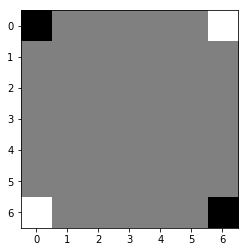

((6, 6), (5, 5)): n_v:  1557 q_all:+0.014226 q:+0.004097 q_m:+0.020000 p:0.305623
((0, 0), (1, 1)): n_v:  1516 q_all:+0.012272 q:+0.002837 q_m:+0.020000 p:0.305924
((0, 0), (1, 0)): n_v:   504 q_all:+0.012829 q:+0.002198 q_m:+0.020000 p:0.100929
((6, 6), (6, 5)): n_v:   476 q_all:+0.014534 q:+0.006517 q_m:+0.020000 p:0.093096
((6, 6), (5, 6)): n_v:   474 q_all:+0.011380 q:+0.002181 q_m:+0.020000 p:0.096807
((0, 0), (0, 1)): n_v:   443 q_all:+0.012633 q:+0.006756 q_m:+0.020000 p:0.088974
((0, 0), (1, 2)): n_v:     5 q_all:+0.004650 q:-0.006679 q_m:-0.000000 p:0.001131
((0, 0), (2, 2)): n_v:     4 q_all:+0.007014 q:-0.003111 q_m:-0.000000 p:0.000834
((6, 6), (5, 4)): n_v:     4 q_all:+0.007376 q:-0.001582 q_m:-0.000000 p:0.001010
((6, 6), (4, 4)): n_v:     4 q_all:+0.002812 q:-0.017592 q_m:-0.000000 p:0.001022
((6, 6), (4, 5)): n_v:     4 q_all:+0.000949 q:-0.018143 q_m:-0.000000 p:0.001158
((0, 0), (2, 1)): n_v:     3 q_all:+0.000730 q:-0.005216 q_m:-0.000000 p:0.000825
((6, 6), (4, 6))

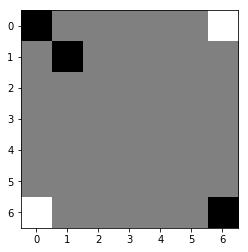

((0, 6), (1, 5)): n_v:  2031 q_all:-0.012315 q:-0.013114 q_m:-0.000000 p:0.315675
((6, 0), (5, 1)): n_v:  1489 q_all:-0.010194 q:-0.021202 q_m:-0.000000 p:0.223557
((0, 6), (1, 6)): n_v:   973 q_all:-0.011173 q:-0.017678 q_m:-0.000000 p:0.148580
((0, 6), (0, 5)): n_v:   738 q_all:-0.012537 q:-0.014170 q_m:-0.000000 p:0.115091
((6, 0), (5, 0)): n_v:   684 q_all:-0.010799 q:-0.010966 q_m:-0.000000 p:0.103745
((6, 0), (6, 1)): n_v:   555 q_all:-0.011201 q:-0.026321 q_m:-0.000000 p:0.084865
((0, 6), (1, 4)): n_v:    12 q_all:-0.007333 q:-0.021461 q_m:-0.020000 p:0.001840
((6, 0), (5, 2)): n_v:     9 q_all:-0.011844 q:-0.016776 q_m:-0.020000 p:0.001475
((0, 6), (2, 4)): n_v:     4 q_all:-0.001782 q:-0.031146 q_m:-0.020000 p:0.000521
((6, 0), (4, 1)): n_v:     4 q_all:-0.021070 q:-0.015977 q_m:-0.020000 p:0.000808
((0, 6), (2, 6)): n_v:     4 q_all:-0.017884 q:-0.025503 q_m:-0.020000 p:0.000683
((0, 6), (2, 5)): n_v:     4 q_all:-0.014835 q:-0.035525 q_m:-0.020000 p:0.000698
((0, 6), (0, 4))

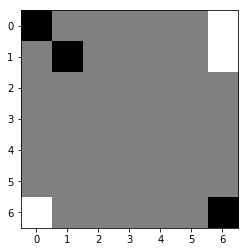

((6, 6), (5, 5)): n_v:  1011 q_all:+0.012138 q:+0.003415 q_m:+0.020000 p:0.142105
((1, 1), (0, 2)): n_v:  1005 q_all:+0.008741 q:+0.000562 q_m:+0.020000 p:0.150206
((6, 6), (6, 5)): n_v:   652 q_all:+0.013635 q:+0.006022 q_m:+0.020000 p:0.089237
((0, 0), (0, 1)): n_v:   594 q_all:+0.013397 q:-0.006109 q_m:+0.020000 p:0.081684
((1, 1), (2, 1)): n_v:   576 q_all:+0.008611 q:-0.005950 q_m:+0.020000 p:0.086224
((1, 1), (1, 2)): n_v:   523 q_all:+0.007838 q:+0.005839 q_m:+0.020000 p:0.079469
((1, 1), (2, 0)): n_v:   440 q_all:+0.009366 q:+0.003819 q_m:+0.020000 p:0.065013
((6, 6), (5, 6)): n_v:   382 q_all:+0.011322 q:+0.002291 q_m:+0.020000 p:0.054610
((1, 1), (2, 2)): n_v:   379 q_all:+0.010442 q:+0.008284 q_m:+0.020000 p:0.055048
((0, 0), (1, 0)): n_v:   354 q_all:+0.012949 q:+0.011198 q_m:+0.020000 p:0.049071
((1, 1), (3, 0)): n_v:    10 q_all:+0.000883 q:-0.002207 q_m:-0.000000 p:0.001745
((1, 1), (1, 3)): n_v:     9 q_all:+0.035252 q:+0.006196 q_m:-0.000000 p:0.000789
((1, 1), (0, 3))

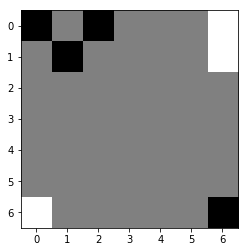

((0, 6), (1, 5)): n_v:  1125 q_all:-0.011371 q:-0.020136 q_m:-0.000000 p:0.139610
((6, 0), (5, 1)): n_v:  1102 q_all:-0.009965 q:-0.031053 q_m:-0.000000 p:0.132700
((1, 6), (2, 6)): n_v:  1024 q_all:-0.010283 q:-0.026110 q_m:-0.000000 p:0.124163
((6, 0), (5, 0)): n_v:   779 q_all:-0.011474 q:-0.021280 q_m:-0.000000 p:0.096863
((0, 6), (0, 5)): n_v:   747 q_all:-0.010515 q:-0.028328 q_m:-0.000000 p:0.091033
((6, 0), (6, 1)): n_v:   726 q_all:-0.011780 q:-0.035279 q_m:-0.000000 p:0.090906
((1, 6), (2, 5)): n_v:   376 q_all:-0.011926 q:-0.033176 q_m:-0.000000 p:0.047250
((1, 6), (3, 6)): n_v:     8 q_all:-0.013206 q:-0.042267 q_m:-0.020000 p:0.001146
((1, 6), (3, 4)): n_v:     7 q_all:-0.013768 q:-0.055840 q_m:-0.020000 p:0.000813
((6, 0), (6, 2)): n_v:     7 q_all:-0.016604 q:-0.021248 q_m:-0.020000 p:0.001008
((1, 6), (1, 4)): n_v:     7 q_all:-0.027271 q:-0.044041 q_m:-0.020000 p:0.001318
((6, 0), (5, 2)): n_v:     7 q_all:-0.010366 q:-0.026155 q_m:-0.020000 p:0.000924
((0, 6), (0, 4))

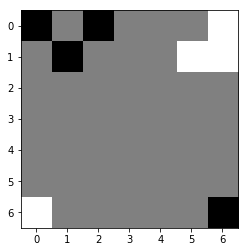

((6, 6), (6, 5)): n_v:  1113 q_all:+0.017877 q:-0.002394 q_m:+0.020000 p:0.223063
((0, 2), (1, 3)): n_v:   882 q_all:+0.028070 q:-0.016143 q_m:+0.020000 p:0.149128
((0, 0), (0, 1)): n_v:   481 q_all:+0.019658 q:-0.008000 q_m:+0.020000 p:0.093703
((6, 6), (5, 6)): n_v:   417 q_all:+0.019859 q:-0.003046 q_m:+0.020000 p:0.081043
((6, 6), (5, 5)): n_v:   376 q_all:+0.016019 q:-0.005190 q_m:+0.020000 p:0.077575
((1, 1), (2, 0)): n_v:   287 q_all:+0.017248 q:-0.005965 q_m:+0.020000 p:0.058236
((0, 0), (1, 0)): n_v:   161 q_all:+0.022628 q:+0.014204 q_m:+0.020000 p:0.029891
((1, 1), (2, 1)): n_v:   145 q_all:+0.016271 q:-0.018620 q_m:+0.020000 p:0.029852
((0, 2), (0, 3)): n_v:   143 q_all:+0.030614 q:+0.005237 q_m:+0.020000 p:0.023152
((1, 1), (2, 2)): n_v:    99 q_all:+0.017767 q:-0.004407 q_m:+0.020000 p:0.019938
((0, 2), (1, 2)): n_v:    33 q_all:+0.016563 q:-0.019374 q_m:+0.020000 p:0.006760
((0, 2), (1, 4)): n_v:    20 q_all:-0.027714 q:+0.005686 q_m:+0.040000 p:0.007057
((6, 6), (4, 5))

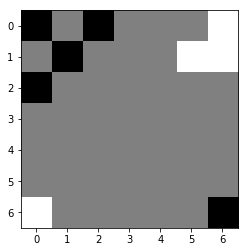

((1, 5), (0, 4)): n_v:   759 q_all:+0.002260 q:-0.038355 q_m:-0.000000 p:0.262088
((6, 0), (5, 0)): n_v:   321 q_all:-0.003799 q:-0.025099 q_m:-0.000000 p:0.119113
((1, 5), (1, 4)): n_v:   211 q_all:+0.012920 q:-0.038542 q_m:-0.000000 p:0.063401
((0, 6), (0, 5)): n_v:   169 q_all:-0.008198 q:-0.032759 q_m:-0.000000 p:0.066175
((1, 5), (2, 4)): n_v:   167 q_all:-0.001490 q:-0.037064 q_m:-0.000000 p:0.060613
((6, 0), (6, 1)): n_v:   148 q_all:-0.006738 q:-0.044007 q_m:-0.000000 p:0.056812
((6, 0), (5, 1)): n_v:   142 q_all:+0.001499 q:-0.031369 q_m:-0.000000 p:0.049768
((1, 5), (2, 6)): n_v:   112 q_all:-0.006771 q:-0.035476 q_m:-0.000000 p:0.043183
((1, 5), (2, 5)): n_v:    96 q_all:-0.010229 q:-0.052648 q_m:-0.000000 p:0.038330
((1, 6), (3, 5)): n_v:     9 q_all:-0.023902 q:-0.048873 q_m:-0.020000 p:0.004149
((1, 5), (0, 3)): n_v:     4 q_all:-0.045142 q:-0.014509 q_m:+0.020000 p:0.002470
((1, 6), (3, 4)): n_v:     4 q_all:+0.011350 q:-0.064405 q_m:-0.020000 p:0.001263
((1, 5), (3, 5))

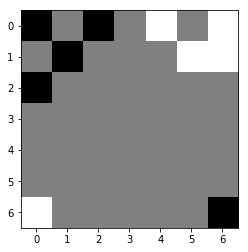

((0, 2), (1, 3)): n_v:  2229 q_all:+0.041393 q:-0.001912 q_m:+0.060000 p:0.526646
((0, 2), (0, 3)): n_v:   426 q_all:+0.064075 q:+0.006299 q_m:+0.060000 p:0.068415
((6, 6), (6, 5)): n_v:   235 q_all:+0.022052 q:-0.005092 q_m:+0.020000 p:0.070811
((0, 0), (0, 1)): n_v:   138 q_all:+0.012924 q:-0.020484 q_m:+0.020000 p:0.045881
((6, 6), (5, 6)): n_v:   114 q_all:+0.027360 q:-0.004669 q_m:+0.020000 p:0.032332
((2, 0), (3, 1)): n_v:    94 q_all:+0.026796 q:-0.029400 q_m:+0.020000 p:0.027049
((2, 0), (3, 0)): n_v:    71 q_all:+0.018943 q:-0.018981 q_m:+0.020000 p:0.022046
((6, 6), (5, 5)): n_v:    67 q_all:+0.022193 q:-0.006084 q_m:+0.020000 p:0.020262
((0, 0), (1, 0)): n_v:    60 q_all:+0.023809 q:+0.004428 q_m:+0.020000 p:0.017948
((0, 2), (1, 4)): n_v:    35 q_all:-0.034517 q:+0.017018 q_m:+0.080000 p:0.017375
((2, 0), (0, 1)): n_v:    28 q_all:-0.010034 q:-0.024692 q_m:-0.000000 p:0.011583
((2, 0), (4, 0)): n_v:    16 q_all:-0.009854 q:-0.028197 q_m:-0.000000 p:0.006718
((1, 1), (2, 2))

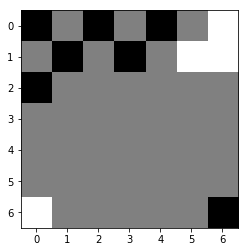

((1, 5), (0, 3)): n_v:  3298 q_all:-0.004563 q:-0.026981 q_m:+0.060000 p:0.316719
((1, 5), (1, 4)): n_v:  2847 q_all:-0.022438 q:-0.047266 q_m:+0.040000 p:0.393217
((1, 5), (2, 4)): n_v:   393 q_all:-0.006730 q:-0.069534 q_m:-0.000000 p:0.039735
((0, 6), (0, 5)): n_v:   327 q_all:-0.031745 q:-0.048992 q_m:-0.000000 p:0.052427
((0, 6), (1, 4)): n_v:   120 q_all:-0.038094 q:-0.048080 q_m:+0.020000 p:0.021024
((1, 6), (1, 4)): n_v:   117 q_all:-0.044428 q:-0.042499 q_m:+0.020000 p:0.022302
((6, 0), (6, 1)): n_v:    29 q_all:-0.087691 q:-0.064914 q_m:-0.040000 p:0.008703
((6, 0), (5, 1)): n_v:    16 q_all:-0.094376 q:-0.059089 q_m:-0.040000 p:0.005102
((1, 5), (2, 3)): n_v:    11 q_all:-0.040833 q:-0.075764 q_m:-0.020000 p:0.002076
((1, 5), (2, 5)): n_v:     9 q_all:-0.049796 q:-0.083162 q_m:-0.040000 p:0.001874
((6, 0), (5, 0)): n_v:     6 q_all:-0.079209 q:-0.049638 q_m:-0.040000 p:0.001522
((1, 6), (2, 4)): n_v:     3 q_all:-0.048363 q:-0.057289 q_m:-0.020000 p:0.000712
((1, 6), (3, 4))

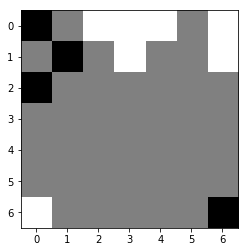

((1, 1), (1, 2)): n_v:  7458 q_all:+0.022191 q:-0.014793 q_m:+0.080000 p:0.884384
((2, 0), (1, 2)): n_v:   387 q_all:+0.006532 q:-0.023371 q_m:+0.060000 p:0.059327
((0, 0), (0, 1)): n_v:   101 q_all:+0.019430 q:-0.054278 q_m:-0.000000 p:0.012459
((0, 0), (1, 2)): n_v:    93 q_all:+0.009210 q:-0.031490 q_m:+0.060000 p:0.013744
((6, 6), (5, 5)): n_v:    31 q_all:-0.014245 q:-0.045271 q_m:-0.040000 p:0.006274
((2, 0), (3, 1)): n_v:    20 q_all:-0.024928 q:-0.072885 q_m:-0.040000 p:0.004541
((1, 1), (2, 2)): n_v:    18 q_all:+0.006374 q:-0.046272 q_m:-0.000000 p:0.002778
((6, 6), (6, 5)): n_v:    11 q_all:-0.009605 q:-0.045699 q_m:-0.040000 p:0.002127
((6, 6), (5, 4)): n_v:     7 q_all:-0.033884 q:-0.048152 q_m:-0.060000 p:0.001888
((1, 1), (2, 1)): n_v:     6 q_all:-0.001819 q:-0.074744 q_m:-0.040000 p:0.001148
((2, 0), (3, 2)): n_v:     4 q_all:-0.020945 q:-0.058526 q_m:-0.060000 p:0.000997
((2, 0), (3, 0)): n_v:     3 q_all:-0.025915 q:-0.061727 q_m:-0.040000 p:0.000897
((2, 0), (0, 1))

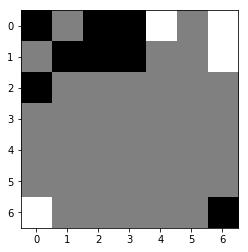

((0, 4), (1, 4)): n_v:  9320 q_all:+0.005548 q:-0.028905 q_m:+0.020000 p:0.681234
((0, 4), (2, 2)): n_v:  1947 q_all:-0.020416 q:-0.022034 q_m:+0.040000 p:0.232911
((0, 6), (1, 4)): n_v:   240 q_all:-0.004092 q:-0.031697 q_m:-0.000000 p:0.021663
((1, 6), (1, 4)): n_v:   141 q_all:-0.004080 q:-0.048316 q_m:-0.000000 p:0.012777
((0, 4), (0, 5)): n_v:    37 q_all:-0.122536 q:-0.093045 q_m:-0.060000 p:0.011447
((0, 4), (2, 4)): n_v:    14 q_all:-0.059491 q:-0.062162 q_m:-0.040000 p:0.002794
((0, 6), (2, 4)): n_v:    10 q_all:-0.086889 q:-0.078358 q_m:-0.040000 p:0.002498
((1, 6), (2, 5)): n_v:     9 q_all:-0.122495 q:-0.094728 q_m:-0.060000 p:0.002868
((6, 0), (6, 1)): n_v:     8 q_all:-0.101285 q:-0.090369 q_m:-0.060000 p:0.002194
((6, 0), (5, 2)): n_v:     5 q_all:-0.112236 q:-0.085376 q_m:-0.080000 p:0.001682
((6, 0), (4, 2)): n_v:     5 q_all:-0.115988 q:-0.077369 q_m:-0.080000 p:0.001352
((1, 6), (2, 6)): n_v:     3 q_all:-0.122296 q:-0.083554 q_m:-0.060000 p:0.000989
((1, 6), (3, 4))

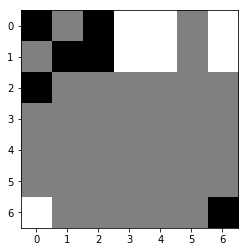

((0, 0), (0, 1)): n_v:  5827 q_all:+0.051754 q:-0.050119 q_m:-0.000000 p:0.076801
((1, 2), (2, 3)): n_v:  4395 q_all:+0.004276 q:-0.008911 q_m:+0.080000 p:0.331185
((1, 2), (2, 4)): n_v:   598 q_all:+0.003511 q:-0.008102 q_m:+0.060000 p:0.046032
((6, 6), (5, 5)): n_v:   331 q_all:-0.044501 q:-0.053692 q_m:-0.000000 p:0.057748
((0, 2), (2, 4)): n_v:   296 q_all:-0.017178 q:-0.050818 q_m:+0.060000 p:0.035529
((6, 6), (6, 5)): n_v:   247 q_all:-0.043631 q:-0.048868 q_m:-0.000000 p:0.042788
((0, 2), (2, 3)): n_v:   236 q_all:-0.013595 q:-0.026064 q_m:+0.060000 p:0.026624
((2, 0), (3, 0)): n_v:   178 q_all:-0.044242 q:-0.058465 q_m:-0.000000 p:0.030920
((1, 1), (2, 2)): n_v:   141 q_all:-0.025609 q:-0.028980 q_m:+0.040000 p:0.019446
((6, 6), (5, 6)): n_v:   138 q_all:-0.042954 q:-0.053459 q_m:-0.000000 p:0.023778
((0, 0), (1, 0)): n_v:   131 q_all:-0.054985 q:-0.043290 q_m:-0.000000 p:0.025156
((1, 1), (2, 1)): n_v:    54 q_all:-0.035157 q:-0.082501 q_m:-0.000000 p:0.008703
((1, 1), (2, 3))

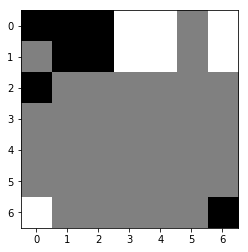

((1, 3), (2, 2)): n_v:  5235 q_all:+0.037801 q:+0.047314 q_m:+0.100000 p:0.009461
((0, 3), (0, 5)): n_v:  1930 q_all:-0.085635 q:-0.055595 q_m:-0.000000 p:0.461572
((1, 3), (0, 5)): n_v:   996 q_all:-0.081568 q:-0.024461 q_m:-0.000000 p:0.230447
((1, 3), (2, 1)): n_v:   456 q_all:-0.017115 q:+0.029876 q_m:+0.120000 p:0.030086
((0, 3), (2, 1)): n_v:   422 q_all:-0.014402 q:+0.005848 q_m:+0.120000 p:0.024792
((6, 0), (6, 1)): n_v:   282 q_all:-0.012935 q:-0.043090 q_m:+0.020000 p:0.015491
((0, 4), (0, 5)): n_v:   241 q_all:-0.022557 q:-0.016637 q_m:+0.020000 p:0.019383
((1, 4), (2, 5)): n_v:   230 q_all:-0.015336 q:-0.041155 q_m:+0.020000 p:0.014043
((6, 0), (5, 0)): n_v:   207 q_all:-0.015196 q:-0.027386 q_m:+0.020000 p:0.012640
((0, 3), (2, 5)): n_v:    98 q_all:-0.081628 q:-0.088705 q_m:-0.000000 p:0.022887
((1, 3), (2, 5)): n_v:    73 q_all:-0.082788 q:-0.061766 q_m:-0.000000 p:0.017177
((1, 4), (2, 2)): n_v:    72 q_all:-0.012480 q:+0.037144 q_m:+0.080000 p:0.003903
((0, 4), (2, 2))

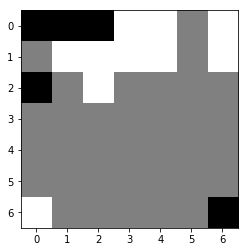

((0, 0), (2, 1)): n_v:  2669 q_all:-0.023267 q:-0.030297 q_m:+0.020000 p:0.343367
((2, 0), (2, 1)): n_v:  2558 q_all:-0.012706 q:-0.017988 q_m:+0.040000 p:0.272518
((0, 1), (2, 1)): n_v:  1729 q_all:-0.000374 q:-0.060162 q_m:+0.020000 p:0.139715
((0, 1), (2, 3)): n_v:  1065 q_all:+0.014252 q:-0.014286 q_m:+0.060000 p:0.053348
((0, 2), (2, 3)): n_v:   559 q_all:-0.016734 q:-0.012201 q_m:+0.060000 p:0.064318
((0, 2), (2, 1)): n_v:   427 q_all:-0.048281 q:-0.047450 q_m:+0.020000 p:0.077301
((2, 0), (4, 1)): n_v:    79 q_all:-0.128662 q:-0.090921 q_m:-0.100000 p:0.027817
((0, 0), (1, 0)): n_v:    18 q_all:-0.043065 q:-0.037381 q_m:-0.040000 p:0.003206
((6, 6), (5, 5)): n_v:     8 q_all:-0.133675 q:-0.059608 q_m:-0.080000 p:0.003061
((6, 6), (4, 5)): n_v:     7 q_all:-0.162526 q:-0.083564 q_m:-0.100000 p:0.003216
((0, 2), (2, 4)): n_v:     5 q_all:-0.104769 q:-0.062732 q_m:-0.020000 p:0.001542
((6, 6), (6, 5)): n_v:     3 q_all:-0.125121 q:-0.061884 q_m:-0.080000 p:0.001325
((2, 0), (3, 2))

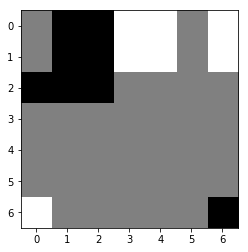

((1, 3), (2, 3)): n_v:  4931 q_all:+0.076403 q:+0.032436 q_m:+0.080000 p:0.261417
((1, 3), (3, 1)): n_v:   400 q_all:+0.030737 q:-0.001822 q_m:+0.100000 p:0.067215
((1, 6), (3, 5)): n_v:   155 q_all:-0.018988 q:-0.045836 q_m:-0.020000 p:0.045819
((1, 3), (3, 5)): n_v:   151 q_all:-0.051607 q:-0.045016 q_m:-0.020000 p:0.057041
((0, 3), (0, 5)): n_v:    96 q_all:-0.050590 q:-0.074784 q_m:-0.020000 p:0.036170
((1, 4), (2, 5)): n_v:    78 q_all:-0.003388 q:-0.041015 q_m:-0.000000 p:0.019886
((1, 3), (0, 5)): n_v:    58 q_all:-0.043784 q:-0.033407 q_m:-0.020000 p:0.020901
((6, 0), (5, 0)): n_v:    48 q_all:-0.003130 q:-0.033728 q_m:-0.000000 p:0.012426
((1, 6), (2, 6)): n_v:    31 q_all:+0.004208 q:-0.046428 q_m:-0.000000 p:0.007560
((1, 3), (2, 4)): n_v:    29 q_all:-0.045295 q:-0.053400 q_m:-0.000000 p:0.010557
((0, 4), (0, 5)): n_v:    23 q_all:-0.012017 q:-0.030720 q_m:-0.000000 p:0.006562
((1, 4), (3, 5)): n_v:    21 q_all:-0.038016 q:-0.049099 q_m:-0.020000 p:0.007454
((0, 3), (1, 5))

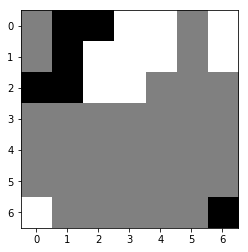

((2, 1), (3, 2)): n_v:  5828 q_all:+0.026394 q:-0.013154 q_m:+0.020000 p:0.129660
((0, 2), (2, 4)): n_v:  1501 q_all:-0.068976 q:-0.043911 q_m:+0.040000 p:0.278280
((6, 6), (5, 5)): n_v:   451 q_all:-0.127860 q:-0.016436 q_m:-0.060000 p:0.149595
((0, 1), (1, 0)): n_v:   278 q_all:-0.081405 q:-0.010507 q_m:-0.060000 p:0.061507
((2, 1), (3, 3)): n_v:   156 q_all:-0.045074 q:-0.074965 q_m:-0.000000 p:0.018189
((6, 6), (6, 5)): n_v:   129 q_all:-0.114099 q:-0.015055 q_m:-0.060000 p:0.039287
((0, 1), (0, 0)): n_v:    77 q_all:-0.150230 q:-0.021257 q_m:-0.060000 p:0.029316
((6, 6), (4, 4)): n_v:    74 q_all:-0.125967 q:-0.038039 q_m:-0.080000 p:0.024553
((2, 0), (4, 2)): n_v:    60 q_all:-0.102224 q:-0.046540 q_m:-0.080000 p:0.016975
((2, 0), (0, 0)): n_v:    50 q_all:-0.131596 q:-0.042557 q_m:-0.080000 p:0.017064
((2, 0), (3, 2)): n_v:    48 q_all:-0.066388 q:-0.016888 q_m:-0.000000 p:0.008543
((2, 1), (4, 2)): n_v:    43 q_all:-0.112456 q:-0.062240 q_m:-0.080000 p:0.013231
((2, 0), (4, 1))

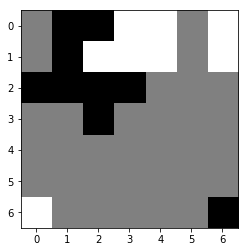

((1, 4), (3, 3)): n_v:  6870 q_all:+0.051155 q:+0.024059 q_m:+0.100000 p:0.189237
((1, 2), (3, 3)): n_v:  1951 q_all:-0.036501 q:+0.029672 q_m:+0.100000 p:0.379758
((1, 3), (3, 1)): n_v:   633 q_all:-0.024521 q:+0.004677 q_m:+0.140000 p:0.103450
((1, 2), (3, 1)): n_v:   370 q_all:-0.001629 q:+0.017803 q_m:+0.140000 p:0.038271
((1, 3), (3, 5)): n_v:   242 q_all:-0.115049 q:-0.051425 q_m:-0.020000 p:0.084318
((1, 4), (3, 5)): n_v:   218 q_all:-0.074301 q:-0.030097 q_m:-0.020000 p:0.058728
((6, 0), (5, 0)): n_v:   144 q_all:-0.064749 q:-0.006293 q_m:-0.000000 p:0.036283
((1, 6), (3, 5)): n_v:    51 q_all:-0.077569 q:-0.022726 q_m:-0.020000 p:0.014232
((1, 3), (3, 3)): n_v:    47 q_all:-0.074264 q:-0.012616 q_m:+0.100000 p:0.012804
((1, 2), (1, 0)): n_v:    41 q_all:-0.016760 q:+0.055182 q_m:+0.140000 p:0.005802
((0, 4), (1, 5)): n_v:    30 q_all:-0.099580 q:-0.028829 q_m:-0.000000 p:0.009756
((1, 3), (2, 4)): n_v:    27 q_all:-0.002478 q:-0.027035 q_m:+0.040000 p:0.002847
((6, 0), (5, 1))

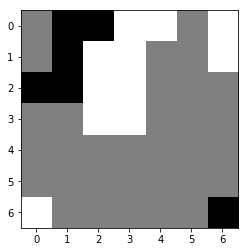

((2, 0), (3, 1)): n_v:  8744 q_all:+0.000080 q:+0.003034 q_m:-0.000000 p:0.324798
((0, 2), (1, 4)): n_v:  1670 q_all:-0.046125 q:-0.000366 q_m:+0.060000 p:0.161904
((0, 2), (2, 4)): n_v:   687 q_all:-0.066294 q:-0.090313 q_m:+0.020000 p:0.100151
((2, 0), (4, 2)): n_v:   174 q_all:-0.070680 q:-0.036324 q_m:-0.020000 p:0.027304
((6, 6), (5, 5)): n_v:   117 q_all:-0.129125 q:-0.028157 q_m:-0.080000 p:0.032205
((2, 1), (4, 2)): n_v:    70 q_all:-0.065001 q:-0.058874 q_m:-0.020000 p:0.010026
((6, 6), (4, 4)): n_v:    46 q_all:-0.120031 q:-0.049162 q_m:-0.060000 p:0.012037
((2, 0), (3, 0)): n_v:    35 q_all:-0.129442 q:-0.027360 q_m:-0.080000 p:0.009771
((6, 6), (6, 5)): n_v:    22 q_all:-0.126181 q:-0.018911 q_m:-0.080000 p:0.006161
((0, 1), (0, 0)): n_v:    22 q_all:-0.144558 q:-0.021762 q_m:-0.080000 p:0.006800
((0, 1), (1, 0)): n_v:    19 q_all:-0.093842 q:-0.006404 q_m:-0.080000 p:0.004140
((2, 1), (4, 0)): n_v:    15 q_all:-0.126001 q:-0.068034 q_m:-0.100000 p:0.004290
((2, 1), (0, 0))

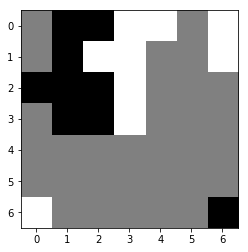

((3, 3), (4, 2)): n_v:  3402 q_all:+0.051114 q:+0.020191 q_m:+0.100000 p:0.063629
((1, 2), (1, 0)): n_v:  2210 q_all:+0.024903 q:+0.019011 q_m:+0.160000 p:0.127181
((1, 2), (3, 0)): n_v:  1415 q_all:+0.021198 q:+0.024313 q_m:+0.120000 p:0.092674
((6, 0), (5, 0)): n_v:  1110 q_all:-0.029905 q:-0.032018 q_m:+0.020000 p:0.190968
((3, 3), (4, 4)): n_v:   509 q_all:-0.026756 q:-0.032298 q_m:+0.020000 p:0.084615
((1, 6), (2, 6)): n_v:   312 q_all:-0.022684 q:-0.029906 q_m:+0.020000 p:0.049474
((1, 6), (2, 5)): n_v:   257 q_all:-0.042410 q:-0.066388 q_m:+0.020000 p:0.050234
((3, 3), (4, 1)): n_v:   115 q_all:-0.000145 q:+0.024725 q_m:+0.080000 p:0.012840
((0, 4), (1, 5)): n_v:    97 q_all:-0.055031 q:-0.060597 q_m:+0.020000 p:0.021416
((0, 3), (1, 4)): n_v:    74 q_all:-0.028732 q:-0.048824 q_m:+0.020000 p:0.012693
((1, 3), (2, 4)): n_v:    72 q_all:-0.054283 q:-0.071240 q_m:+0.020000 p:0.015891
((1, 6), (3, 6)): n_v:    62 q_all:-0.044017 q:-0.046243 q_m:-0.000000 p:0.012500
((3, 3), (4, 3))

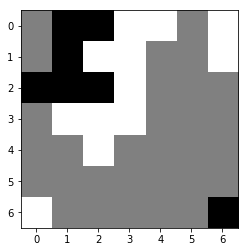

((2, 0), (4, 1)): n_v:  2187 q_all:-0.006859 q:-0.015967 q_m:+0.020000 p:0.317874
((0, 2), (1, 4)): n_v:   625 q_all:-0.050180 q:-0.020074 q_m:+0.060000 p:0.171323
((2, 2), (1, 4)): n_v:   479 q_all:-0.006109 q:-0.043357 q_m:+0.060000 p:0.068645
((6, 6), (4, 5)): n_v:   275 q_all:-0.132393 q:-0.085375 q_m:-0.100000 p:0.142850
((6, 6), (5, 4)): n_v:   268 q_all:-0.128088 q:-0.059250 q_m:-0.100000 p:0.135632
((2, 1), (4, 1)): n_v:   136 q_all:-0.040715 q:-0.048221 q_m:+0.020000 p:0.034213
((6, 6), (5, 5)): n_v:    79 q_all:-0.117553 q:-0.066747 q_m:-0.080000 p:0.037679
((2, 2), (4, 1)): n_v:    52 q_all:-0.052391 q:-0.050310 q_m:+0.020000 p:0.014536
((2, 1), (4, 3)): n_v:    50 q_all:-0.038712 q:-0.054069 q_m:+0.020000 p:0.012192
((2, 2), (4, 3)): n_v:    30 q_all:-0.043132 q:-0.077793 q_m:+0.020000 p:0.007577
((2, 0), (3, 0)): n_v:    28 q_all:-0.075146 q:-0.016447 q_m:-0.040000 p:0.009897
((0, 2), (2, 4)): n_v:    21 q_all:-0.051905 q:-0.098240 q_m:+0.020000 p:0.006014
((0, 1), (1, 0))

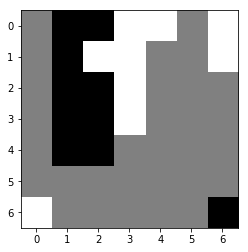

((6, 0), (5, 1)): n_v:  1438 q_all:+0.030355 q:-0.018679 q_m:+0.080000 p:0.381660
((3, 3), (4, 3)): n_v:   307 q_all:+0.054668 q:+0.032576 q_m:+0.080000 p:0.055117
((0, 4), (1, 5)): n_v:   153 q_all:-0.025074 q:-0.052487 q_m:-0.000000 p:0.070973
((6, 0), (5, 0)): n_v:   129 q_all:+0.001070 q:-0.015018 q_m:+0.040000 p:0.047707
((6, 0), (4, 0)): n_v:   127 q_all:+0.001856 q:-0.003708 q_m:+0.060000 p:0.046463
((0, 4), (2, 6)): n_v:   108 q_all:-0.003930 q:-0.037681 q_m:-0.020000 p:0.041804
((1, 2), (3, 0)): n_v:    83 q_all:+0.036588 q:-0.000208 q_m:+0.100000 p:0.020265
((3, 3), (4, 4)): n_v:    77 q_all:-0.005199 q:-0.040736 q_m:-0.000000 p:0.030096
((1, 6), (2, 6)): n_v:    74 q_all:+0.005744 q:-0.025089 q_m:-0.000000 p:0.026352
((2, 3), (1, 5)): n_v:    65 q_all:-0.050527 q:-0.096687 q_m:-0.020000 p:0.036323
((3, 3), (5, 1)): n_v:    40 q_all:+0.036771 q:-0.022462 q_m:+0.060000 p:0.009821
((1, 2), (2, 0)): n_v:    37 q_all:+0.024965 q:-0.000786 q_m:+0.100000 p:0.010782
((3, 3), (5, 2))

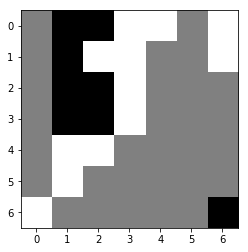

((3, 2), (1, 4)): n_v:  1420 q_all:+0.014065 q:-0.043038 q_m:+0.080000 p:0.393866
((0, 2), (1, 4)): n_v:   512 q_all:-0.020466 q:-0.021832 q_m:+0.080000 p:0.203218
((3, 2), (5, 4)): n_v:   334 q_all:-0.073047 q:-0.112226 q_m:-0.080000 p:0.193640
((3, 2), (5, 2)): n_v:   144 q_all:-0.031386 q:-0.064281 q_m:+0.040000 p:0.062615
((3, 1), (5, 2)): n_v:    77 q_all:-0.022747 q:+0.000818 q_m:+0.040000 p:0.031219
((2, 2), (1, 4)): n_v:    75 q_all:-0.026666 q:-0.044157 q_m:+0.080000 p:0.031774
((6, 6), (5, 4)): n_v:    70 q_all:-0.055418 q:-0.078853 q_m:-0.080000 p:0.036602
((3, 2), (5, 0)): n_v:    64 q_all:+0.017740 q:-0.054622 q_m:+0.040000 p:0.016618
((3, 2), (4, 3)): n_v:    11 q_all:+0.011097 q:-0.041811 q_m:+0.020000 p:0.003359
((3, 1), (5, 0)): n_v:     8 q_all:-0.018676 q:-0.006596 q_m:+0.040000 p:0.003289
((2, 2), (1, 0)): n_v:     7 q_all:-0.092951 q:-0.097852 q_m:-0.080000 p:0.004821
((3, 2), (1, 0)): n_v:     6 q_all:-0.049208 q:-0.098244 q_m:-0.080000 p:0.003308
((3, 1), (1, 0))

((3, 3), (3, 2)): n_v:  2374 q_all:+0.060633 q:-0.055778 q_m:+0.100000 p:0.199287
((3, 3), (3, 4)): n_v:   117 q_all:-0.087643 q:-0.097019 q_m:-0.020000 p:0.071665
((3, 3), (1, 5)): n_v:   110 q_all:-0.094470 q:-0.091891 q_m:-0.000000 p:0.069984
((0, 6), (1, 5)): n_v:   110 q_all:-0.085305 q:-0.067543 q_m:+0.020000 p:0.066028
((3, 3), (5, 5)): n_v:    66 q_all:-0.047151 q:-0.068755 q_m:-0.040000 p:0.031021
((5, 1), (3, 2)): n_v:    58 q_all:+0.036821 q:-0.053774 q_m:+0.080000 p:0.009815
((0, 6), (2, 4)): n_v:    51 q_all:-0.062172 q:-0.049762 q_m:+0.040000 p:0.026849
((4, 2), (2, 0)): n_v:    21 q_all:-0.006126 q:-0.065079 q_m:+0.040000 p:0.006890
((1, 2), (2, 0)): n_v:    19 q_all:+0.015806 q:-0.056849 q_m:+0.040000 p:0.004838
((1, 2), (3, 2)): n_v:    16 q_all:-0.009914 q:-0.045690 q_m:+0.080000 p:0.005638
((4, 2), (2, 4)): n_v:    15 q_all:-0.019684 q:-0.062538 q_m:+0.040000 p:0.005882
((1, 6), (2, 4)): n_v:    15 q_all:-0.057251 q:-0.056706 q_m:+0.040000 p:0.007979
((3, 3), (2, 4))

((1, 3), (2, 4)): n_v:  3537 q_all:+0.003869 q:-0.041694 q_m:-0.000000 p:0.309554
((0, 4), (1, 5)): n_v:   445 q_all:-0.040257 q:-0.028350 q_m:-0.000000 p:0.093379
((1, 1), (3, 0)): n_v:   189 q_all:-0.023982 q:+0.004621 q_m:+0.020000 p:0.031134
((0, 3), (2, 4)): n_v:   119 q_all:-0.080063 q:-0.059678 q_m:-0.020000 p:0.038172
((0, 2), (2, 4)): n_v:   110 q_all:-0.102700 q:-0.090268 q_m:-0.020000 p:0.042255
((1, 1), (2, 0)): n_v:   109 q_all:-0.043674 q:-0.022287 q_m:-0.000000 p:0.023915
((0, 4), (0, 5)): n_v:    84 q_all:-0.053560 q:-0.023362 q_m:-0.000000 p:0.020836
((0, 4), (2, 4)): n_v:    76 q_all:-0.040507 q:-0.088587 q_m:-0.020000 p:0.016167
((1, 4), (2, 5)): n_v:    51 q_all:-0.065991 q:-0.050332 q_m:-0.040000 p:0.014536
((0, 3), (1, 5)): n_v:    50 q_all:-0.077225 q:-0.077806 q_m:-0.020000 p:0.015808
((1, 3), (3, 4)): n_v:    50 q_all:-0.106948 q:-0.077214 q_m:-0.020000 p:0.019973
((0, 2), (2, 0)): n_v:    39 q_all:-0.092735 q:-0.046361 q_m:-0.020000 p:0.013996
((1, 4), (3, 4))

((1, 6), (3, 4)): n_v:  5284 q_all:+0.088427 q:-0.059785 q_m:+0.120000 p:0.014953
((0, 6), (1, 5)): n_v:  2746 q_all:-0.010700 q:-0.041539 q_m:+0.140000 p:0.541347
((2, 1), (1, 0)): n_v:    94 q_all:+0.031191 q:+0.024786 q_m:+0.100000 p:0.005327
((3, 1), (1, 0)): n_v:    35 q_all:+0.015931 q:+0.017942 q_m:+0.080000 p:0.003804
((1, 6), (2, 5)): n_v:    15 q_all:-0.032549 q:-0.064249 q_m:+0.100000 p:0.004126
((4, 2), (3, 4)): n_v:     8 q_all:+0.032865 q:-0.059087 q_m:+0.120000 p:0.000437
((4, 1), (5, 0)): n_v:     6 q_all:-0.040789 q:-0.081048 q_m:+0.020000 p:0.001925
((0, 6), (2, 5)): n_v:     4 q_all:-0.026741 q:-0.056745 q_m:+0.080000 p:0.001216
((0, 6), (0, 5)): n_v:     2 q_all:-0.038756 q:-0.035467 q_m:+0.100000 p:0.000540
((2, 2), (3, 4)): n_v:     2 q_all:-0.044096 q:-0.106508 q_m:+0.120000 p:0.000561
((1, 2), (3, 4)): n_v:     2 q_all:+0.007282 q:-0.050458 q_m:+0.120000 p:0.000333
((3, 1), (5, 0)): n_v:     2 q_all:-0.081011 q:-0.076509 q_m:-0.000000 p:0.000894
((3, 2), (4, 3))

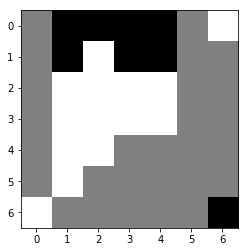

((1, 1), (3, 0)): n_v:  2235 q_all:-0.057047 q:-0.001260 q_m:-0.000000 p:0.188557
((1, 4), (2, 5)): n_v:  1605 q_all:-0.089345 q:-0.058239 q_m:-0.020000 p:0.257783
((0, 4), (1, 5)): n_v:   972 q_all:-0.075452 q:-0.030993 q_m:-0.020000 p:0.124254
((1, 1), (2, 0)): n_v:   703 q_all:-0.082483 q:-0.021209 q_m:-0.020000 p:0.101583
((0, 1), (1, 0)): n_v:   453 q_all:-0.032562 q:-0.047259 q_m:-0.060000 p:0.011816
((0, 4), (2, 5)): n_v:   294 q_all:-0.090070 q:-0.074759 q_m:-0.040000 p:0.047808
((0, 4), (2, 6)): n_v:   127 q_all:-0.102290 q:-0.099968 q_m:-0.120000 p:0.024369
((0, 3), (2, 5)): n_v:    91 q_all:-0.117376 q:-0.083134 q_m:-0.040000 p:0.020869
((1, 4), (3, 6)): n_v:    90 q_all:-0.170753 q:-0.108768 q_m:-0.120000 p:0.032058
((6, 6), (4, 5)): n_v:    87 q_all:-0.095694 q:-0.099975 q_m:-0.080000 p:0.015416
((0, 4), (1, 6)): n_v:    79 q_all:-0.090980 q:-0.082189 q_m:-0.080000 p:0.013103
((6, 6), (4, 4)): n_v:    75 q_all:-0.088500 q:-0.089047 q_m:-0.040000 p:0.011973
((6, 6), (5, 5))

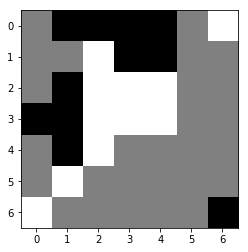

((1, 2), (1, 1)): n_v:  3054 q_all:+0.086420 q:-0.014025 q_m:+0.140000 p:0.296504
((0, 6), (1, 5)): n_v:   892 q_all:+0.030738 q:-0.044383 q_m:+0.100000 p:0.232799
((5, 1), (4, 0)): n_v:   471 q_all:+0.093369 q:-0.042232 q_m:+0.140000 p:0.036108
((3, 4), (1, 5)): n_v:    36 q_all:+0.020297 q:-0.052821 q_m:+0.080000 p:0.010530
((6, 0), (4, 0)): n_v:    19 q_all:+0.072800 q:-0.051567 q_m:+0.120000 p:0.002718
((0, 6), (2, 6)): n_v:    18 q_all:-0.030161 q:-0.092063 q_m:-0.000000 p:0.008164
((3, 2), (1, 1)): n_v:    14 q_all:+0.027505 q:-0.059978 q_m:+0.120000 p:0.003810
((1, 2), (2, 0)): n_v:     9 q_all:+0.058804 q:-0.054120 q_m:+0.120000 p:0.001743
((3, 4), (5, 5)): n_v:     7 q_all:+0.019236 q:-0.039208 q_m:+0.040000 p:0.002317
((4, 2), (2, 0)): n_v:     4 q_all:+0.055230 q:-0.026101 q_m:+0.120000 p:0.000791
((2, 3), (1, 1)): n_v:     2 q_all:-0.004432 q:-0.078125 q_m:+0.120000 p:0.000873
((3, 3), (1, 1)): n_v:     2 q_all:+0.058701 q:-0.008046 q_m:+0.120000 p:0.000433
((2, 2), (4, 0))

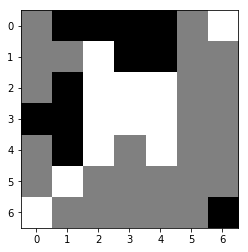

((0, 4), (1, 5)): n_v:   988 q_all:+0.061561 q:+0.017501 q_m:+0.080000 p:0.398955
((2, 1), (4, 3)): n_v:   300 q_all:+0.142759 q:+0.051733 q_m:+0.180000 p:0.002102
((0, 1), (1, 1)): n_v:   284 q_all:+0.099736 q:+0.028338 q_m:+0.080000 p:0.062081
((6, 6), (5, 5)): n_v:    41 q_all:+0.030612 q:-0.023409 q_m:+0.040000 p:0.023098
((3, 0), (1, 1)): n_v:    28 q_all:+0.078405 q:-0.017183 q_m:+0.060000 p:0.009254
((4, 1), (4, 3)): n_v:    16 q_all:+0.114252 q:+0.022823 q_m:+0.180000 p:0.002372
((0, 3), (1, 5)): n_v:     9 q_all:+0.056138 q:-0.002038 q_m:+0.060000 p:0.004257
((1, 3), (1, 1)): n_v:     6 q_all:-0.014195 q:-0.028423 q_m:+0.060000 p:0.005265
((0, 3), (1, 1)): n_v:     4 q_all:+0.019650 q:-0.005419 q_m:+0.060000 p:0.002784
((3, 1), (4, 3)): n_v:     3 q_all:+0.100419 q:+0.058103 q_m:+0.180000 p:0.000527
((3, 1), (1, 1)): n_v:     1 q_all:+0.022982 q:+0.015571 q_m:+0.060000 p:0.000912
((1, 4), (2, 5)): n_v:     1 q_all:+0.044919 q:+0.008457 q_m:+0.080000 p:0.000635
((1, 3), (1, 5))

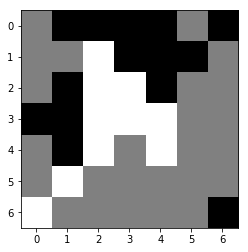

((1, 2), (1, 1)): n_v:   684 q_all:+0.001904 q:-0.067169 q_m:+0.060000 p:0.176702
((5, 1), (4, 0)): n_v:   474 q_all:-0.036112 q:-0.068035 q_m:+0.060000 p:0.200616
((6, 0), (4, 0)): n_v:   421 q_all:-0.042423 q:-0.080686 q_m:+0.040000 p:0.189778
((4, 2), (2, 0)): n_v:   144 q_all:-0.070319 q:-0.069038 q_m:+0.040000 p:0.082130
((1, 2), (2, 0)): n_v:   106 q_all:+0.004352 q:-0.082629 q_m:+0.040000 p:0.026073
((2, 2), (4, 0)): n_v:    79 q_all:-0.081842 q:-0.106949 q_m:+0.040000 p:0.049441
((4, 4), (2, 6)): n_v:    58 q_all:-0.096712 q:-0.123243 q_m:-0.040000 p:0.039830
((4, 4), (5, 5)): n_v:    38 q_all:-0.050837 q:-0.081261 q_m:-0.020000 p:0.018747
((3, 4), (2, 5)): n_v:    29 q_all:+0.023585 q:-0.049316 q_m:+0.060000 p:0.004694
((3, 4), (5, 5)): n_v:    26 q_all:-0.067197 q:-0.071244 q_m:-0.040000 p:0.015039
((3, 2), (1, 1)): n_v:    25 q_all:-0.086501 q:-0.112067 q_m:+0.040000 p:0.016659
((4, 4), (2, 5)): n_v:    11 q_all:+0.005072 q:-0.067998 q_m:+0.040000 p:0.002911
((3, 2), (2, 0))

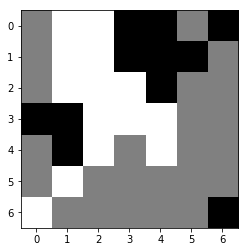

((3, 1), (4, 3)): n_v:   388 q_all:+0.024726 q:+0.048243 q_m:+0.140000 p:0.216805
((4, 1), (4, 3)): n_v:   293 q_all:+0.032341 q:+0.028738 q_m:+0.140000 p:0.153386
((4, 1), (5, 2)): n_v:   248 q_all:+0.025833 q:-0.059318 q_m:+0.040000 p:0.137347
((2, 4), (3, 5)): n_v:   175 q_all:+0.010020 q:-0.023631 q_m:+0.040000 p:0.110616
((3, 0), (5, 2)): n_v:   167 q_all:+0.007824 q:-0.080163 q_m:+0.020000 p:0.107507
((3, 0), (1, 0)): n_v:    77 q_all:+0.041239 q:-0.006686 q_m:+0.060000 p:0.037238
((2, 4), (4, 3)): n_v:    76 q_all:+0.041065 q:+0.011633 q_m:+0.140000 p:0.036559
((3, 1), (1, 0)): n_v:    53 q_all:+0.073526 q:-0.005430 q_m:+0.060000 p:0.017174
((3, 0), (5, 0)): n_v:    43 q_all:+0.039609 q:-0.025058 q_m:+0.020000 p:0.021416
((3, 0), (4, 0)): n_v:    33 q_all:+0.015592 q:-0.039929 q_m:-0.000000 p:0.019859
((3, 1), (5, 0)): n_v:    30 q_all:+0.055819 q:-0.015255 q_m:+0.020000 p:0.012158
((3, 0), (2, 0)): n_v:    26 q_all:+0.033002 q:-0.037153 q_m:+0.040000 p:0.013382
((4, 1), (5, 0))

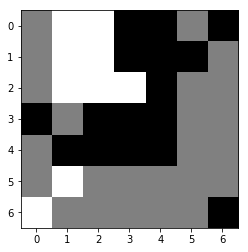

((2, 1), (3, 1)): n_v:  2082 q_all:+0.026381 q:-0.028271 q_m:+0.040000 p:0.565764
((5, 1), (3, 1)): n_v:   724 q_all:+0.086827 q:-0.010971 q_m:+0.020000 p:0.035762
((1, 1), (3, 1)): n_v:    34 q_all:-0.008253 q:-0.073703 q_m:+0.020000 p:0.013558
((5, 1), (5, 2)): n_v:    14 q_all:-0.030617 q:-0.019354 q_m:-0.000000 p:0.007129
((2, 3), (0, 5)): n_v:     8 q_all:+0.065993 q:-0.048840 q_m:+0.020000 p:0.000957
((1, 2), (3, 1)): n_v:     6 q_all:-0.093381 q:-0.043477 q_m:+0.020000 p:0.004302
((2, 3), (3, 1)): n_v:     2 q_all:-0.050548 q:-0.103674 q_m:+0.020000 p:0.001286
((6, 0), (5, 2)): n_v:     2 q_all:-0.030947 q:-0.017035 q_m:-0.020000 p:0.001048
((0, 2), (2, 0)): n_v:     0 q_all:-0.095724 q:-0.089310 q_m:-0.100000 p:0.000002
((5, 1), (5, 3)): n_v:     0 q_all:-0.017245 q:-0.013113 q_m:-0.020000 p:0.000017
((5, 1), (6, 2)): n_v:     0 q_all:-0.109755 q:-0.094386 q_m:-0.120000 p:0.000020
((0, 1), (1, 0)): n_v:     0 q_all:-0.103725 q:-0.079312 q_m:-0.120000 p:0.000002
((1, 1), (2, 0))

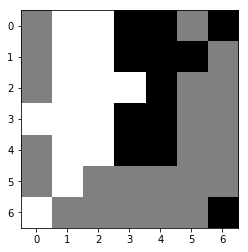

((4, 4), (5, 2)): n_v:  1908 q_all:+0.018936 q:-0.020745 q_m:+0.080000 p:0.369807
((4, 3), (5, 2)): n_v:  1021 q_all:+0.034508 q:-0.027808 q_m:+0.100000 p:0.147174
((3, 3), (5, 2)): n_v:   357 q_all:-0.055662 q:-0.038395 q_m:+0.080000 p:0.154172
((3, 4), (5, 2)): n_v:   129 q_all:-0.036958 q:-0.037706 q_m:+0.080000 p:0.048201
((4, 3), (5, 4)): n_v:   104 q_all:-0.060409 q:-0.114772 q_m:-0.020000 p:0.046574
((3, 3), (5, 4)): n_v:    74 q_all:-0.121536 q:-0.111837 q_m:-0.040000 p:0.048001
((0, 4), (2, 6)): n_v:    64 q_all:-0.083676 q:-0.171246 q_m:-0.040000 p:0.033697
((4, 4), (2, 6)): n_v:    33 q_all:-0.073716 q:-0.108683 q_m:-0.040000 p:0.016514
((1, 5), (2, 6)): n_v:    33 q_all:-0.064054 q:-0.110703 q_m:-0.020000 p:0.015263
((2, 4), (4, 6)): n_v:    24 q_all:-0.149569 q:-0.138007 q_m:-0.040000 p:0.018181
((4, 3), (5, 3)): n_v:    22 q_all:-0.060951 q:-0.070352 q_m:+0.020000 p:0.010138
((0, 6), (2, 6)): n_v:    13 q_all:-0.081219 q:-0.108228 q_m:-0.040000 p:0.007091
((3, 4), (4, 6))

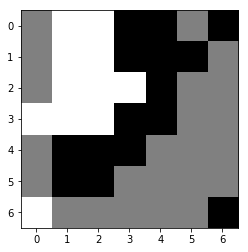

((2, 3), (0, 5)): n_v:  1291 q_all:+0.005437 q:-0.046898 q_m:+0.080000 p:0.287326
((3, 0), (4, 0)): n_v:  1022 q_all:+0.020716 q:-0.013255 q_m:+0.020000 p:0.175546
((6, 0), (6, 1)): n_v:   683 q_all:+0.024493 q:-0.008036 q_m:+0.020000 p:0.108773
((2, 3), (4, 4)): n_v:   184 q_all:-0.051161 q:-0.083677 q_m:+0.040000 p:0.075362
((2, 3), (4, 5)): n_v:   120 q_all:-0.100012 q:-0.151819 q_m:-0.040000 p:0.068740
((6, 0), (4, 0)): n_v:    93 q_all:+0.039244 q:-0.025063 q_m:-0.000000 p:0.009921
((1, 1), (2, 0)): n_v:    39 q_all:-0.026513 q:-0.056449 q_m:-0.060000 p:0.013099
((3, 2), (4, 4)): n_v:    33 q_all:-0.059362 q:-0.068355 q_m:+0.040000 p:0.014722
((2, 3), (2, 5)): n_v:    20 q_all:-0.038627 q:-0.080428 q_m:+0.080000 p:0.007556
((2, 1), (4, 0)): n_v:    12 q_all:-0.040690 q:-0.026546 q_m:-0.000000 p:0.004788
((2, 2), (4, 4)): n_v:    11 q_all:-0.081903 q:-0.075171 q_m:+0.040000 p:0.005905
((3, 0), (5, 0)): n_v:     8 q_all:-0.012965 q:-0.057729 q_m:-0.000000 p:0.002479
((3, 1), (5, 0))

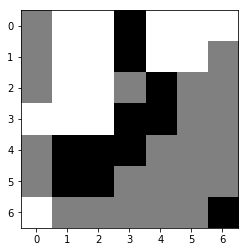

((1, 3), (2, 3)): n_v:  5189 q_all:+0.045048 q:-0.046716 q_m:+0.100000 p:0.283990
((2, 4), (1, 6)): n_v:   493 q_all:+0.051288 q:-0.033011 q_m:+0.040000 p:0.019178
((3, 4), (1, 6)): n_v:    85 q_all:-0.003336 q:-0.046399 q_m:+0.040000 p:0.015194
((4, 3), (2, 3)): n_v:    45 q_all:+0.004091 q:-0.077538 q_m:+0.080000 p:0.007025
((4, 1), (2, 3)): n_v:    30 q_all:-0.011885 q:-0.085000 q_m:+0.080000 p:0.006125
((4, 1), (2, 0)): n_v:    26 q_all:-0.002000 q:-0.068496 q_m:+0.080000 p:0.004604
((4, 2), (2, 0)): n_v:    16 q_all:+0.013221 q:-0.067491 q_m:+0.080000 p:0.002179
((4, 2), (2, 3)): n_v:    12 q_all:-0.061341 q:-0.067960 q_m:+0.080000 p:0.004157
((3, 4), (5, 6)): n_v:     6 q_all:-0.101799 q:-0.132222 q_m:-0.080000 p:0.002796
((3, 3), (2, 5)): n_v:     3 q_all:-0.038077 q:-0.047379 q_m:-0.000000 p:0.000993
((4, 2), (5, 0)): n_v:     3 q_all:-0.098767 q:-0.089840 q_m:-0.040000 p:0.001340
((2, 4), (2, 5)): n_v:     1 q_all:-0.034050 q:-0.056182 q_m:+0.020000 p:0.000314
((4, 1), (4, 0))

((0, 6), (2, 5)): n_v:  3674 q_all:-0.025941 q:+0.002949 q_m:+0.020000 p:0.507904
((1, 5), (2, 5)): n_v:  2756 q_all:-0.021326 q:-0.009288 q_m:+0.040000 p:0.351792
((3, 0), (4, 0)): n_v:  1412 q_all:+0.040057 q:-0.045037 q_m:-0.000000 p:0.001570
((0, 5), (2, 5)): n_v:   747 q_all:-0.034838 q:-0.041421 q_m:+0.020000 p:0.118601
((6, 0), (4, 0)): n_v:   228 q_all:+0.045480 q:-0.051626 q_m:-0.020000 p:0.001451
((0, 4), (2, 5)): n_v:    37 q_all:-0.060710 q:-0.057958 q_m:+0.020000 p:0.008026
((1, 1), (2, 0)): n_v:     5 q_all:-0.106241 q:-0.058638 q_m:-0.080000 p:0.001858
((1, 5), (2, 6)): n_v:     5 q_all:-0.120095 q:-0.071464 q_m:-0.080000 p:0.001965
((6, 0), (6, 2)): n_v:     3 q_all:-0.066101 q:-0.040090 q_m:-0.020000 p:0.000797
((0, 5), (2, 6)): n_v:     2 q_all:-0.114738 q:-0.083940 q_m:-0.100000 p:0.000785
((0, 6), (2, 6)): n_v:     2 q_all:-0.110614 q:-0.071574 q_m:-0.100000 p:0.000810
((6, 0), (6, 1)): n_v:     2 q_all:-0.062780 q:-0.038861 q_m:-0.000000 p:0.000469
((3, 1), (5, 3))

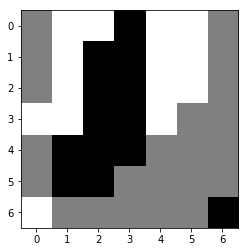

((4, 1), (2, 0)): n_v:  4376 q_all:+0.034390 q:-0.022377 q_m:+0.140000 p:0.483969
((4, 1), (4, 0)): n_v:  1071 q_all:+0.030004 q:-0.016732 q_m:+0.080000 p:0.129942
((3, 3), (4, 4)): n_v:   440 q_all:-0.005891 q:-0.085990 q_m:+0.040000 p:0.092043
((4, 3), (3, 5)): n_v:   116 q_all:+0.024347 q:-0.053832 q_m:+0.100000 p:0.015794
((4, 2), (2, 0)): n_v:   102 q_all:+0.006986 q:-0.024493 q_m:+0.140000 p:0.018125
((2, 3), (3, 5)): n_v:    60 q_all:-0.024046 q:-0.029240 q_m:+0.100000 p:0.015185
((3, 2), (2, 0)): n_v:    49 q_all:+0.014216 q:-0.013609 q_m:+0.140000 p:0.007657
((5, 1), (6, 2)): n_v:    41 q_all:-0.044738 q:-0.048714 q_m:-0.000000 p:0.012772
((3, 2), (1, 0)): n_v:    32 q_all:-0.014422 q:-0.032051 q_m:+0.100000 p:0.007551
((2, 2), (4, 0)): n_v:    30 q_all:-0.052463 q:-0.076917 q_m:+0.060000 p:0.009851
((4, 1), (5, 0)): n_v:    29 q_all:+0.004712 q:-0.037831 q_m:+0.040000 p:0.005479
((5, 2), (5, 0)): n_v:    16 q_all:-0.027808 q:-0.051375 q_m:+0.020000 p:0.004341
((1, 3), (3, 5))

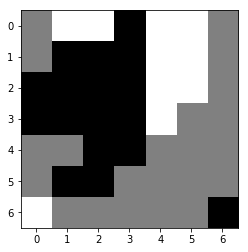

((0, 1), (1, 0)): n_v:  3676 q_all:+0.073663 q:+0.014090 q_m:-0.000000 p:0.262154
((6, 0), (4, 1)): n_v:  1768 q_all:+0.044023 q:+0.063591 q_m:+0.100000 p:0.134683
((6, 0), (5, 0)): n_v:   364 q_all:-0.086512 q:-0.071821 q_m:-0.080000 p:0.160478
((0, 5), (1, 6)): n_v:   218 q_all:-0.120258 q:-0.106021 q_m:-0.120000 p:0.113045
((3, 4), (4, 4)): n_v:    69 q_all:-0.062560 q:-0.052175 q_m:-0.040000 p:0.026626
((3, 4), (4, 5)): n_v:    40 q_all:-0.141726 q:-0.123046 q_m:-0.120000 p:0.022544
((6, 0), (6, 1)): n_v:    32 q_all:-0.058451 q:-0.044118 q_m:-0.040000 p:0.012098
((3, 4), (5, 3)): n_v:     7 q_all:-0.060762 q:-0.032945 q_m:-0.020000 p:0.002954
((2, 5), (3, 6)): n_v:     4 q_all:-0.144341 q:-0.103249 q_m:-0.120000 p:0.002650
((3, 4), (5, 5)): n_v:     3 q_all:-0.098095 q:-0.075309 q_m:-0.100000 p:0.001706
((6, 0), (6, 2)): n_v:     1 q_all:-0.087269 q:-0.033238 q_m:-0.060000 p:0.000862
((6, 0), (4, 0)): n_v:     1 q_all:-0.086609 q:-0.029465 q_m:-0.020000 p:0.000462
((0, 2), (1, 0))

((4, 2), (5, 0)): n_v:  2648 q_all:+0.013833 q:-0.057899 q_m:+0.040000 p:0.000824
((4, 3), (3, 5)): n_v:  1273 q_all:-0.065518 q:-0.074884 q_m:+0.120000 p:0.234358
((3, 3), (3, 5)): n_v:   938 q_all:-0.020815 q:-0.045386 q_m:+0.120000 p:0.054691
((2, 3), (3, 5)): n_v:   547 q_all:-0.080653 q:-0.054767 q_m:+0.120000 p:0.119935
((3, 3), (4, 4)): n_v:   342 q_all:-0.110188 q:-0.098873 q_m:+0.060000 p:0.098449
((5, 1), (6, 1)): n_v:   257 q_all:-0.039853 q:-0.027854 q_m:+0.060000 p:0.028189
((1, 3), (3, 5)): n_v:   195 q_all:-0.055622 q:-0.053870 q_m:+0.120000 p:0.031522
((4, 3), (5, 4)): n_v:    98 q_all:-0.114908 q:-0.098557 q_m:+0.020000 p:0.029474
((5, 1), (6, 2)): n_v:    73 q_all:-0.077828 q:-0.059573 q_m:+0.020000 p:0.015717
((4, 3), (6, 5)): n_v:    58 q_all:-0.110199 q:-0.090378 q_m:-0.000000 p:0.016860
((1, 2), (0, 0)): n_v:    47 q_all:-0.069911 q:-0.054416 q_m:+0.120000 p:0.009241
((6, 6), (6, 5)): n_v:    43 q_all:-0.117457 q:-0.071320 q_m:+0.020000 p:0.013154
((3, 0), (5, 0))

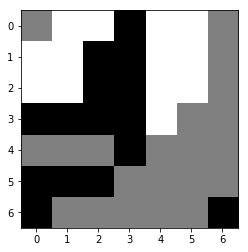

((3, 4), (4, 4)): n_v:  4944 q_all:+0.045725 q:+0.049689 q_m:+0.060000 p:0.791014
((2, 0), (4, 0)): n_v:  1853 q_all:+0.114598 q:+0.064590 q_m:+0.120000 p:0.004144
((2, 0), (4, 2)): n_v:   252 q_all:+0.058925 q:+0.104629 q_m:+0.200000 p:0.020277
((3, 4), (4, 5)): n_v:   211 q_all:-0.024397 q:-0.005161 q_m:-0.020000 p:0.067744
((3, 4), (4, 2)): n_v:   153 q_all:+0.047269 q:+0.126228 q_m:+0.200000 p:0.019412
((3, 4), (5, 5)): n_v:    80 q_all:-0.004725 q:+0.044330 q_m:-0.000000 p:0.022137
((2, 0), (4, 1)): n_v:    56 q_all:+0.048793 q:+0.075917 q_m:+0.200000 p:0.006853
((0, 5), (1, 6)): n_v:    39 q_all:+0.042450 q:-0.003298 q_m:-0.020000 p:0.006688
((1, 5), (2, 6)): n_v:    14 q_all:-0.059087 q:-0.014904 q_m:-0.020000 p:0.005589
((2, 1), (4, 2)): n_v:    12 q_all:+0.009882 q:+0.112673 q_m:+0.200000 p:0.003072
((2, 5), (4, 4)): n_v:     9 q_all:-0.006241 q:+0.017707 q_m:+0.040000 p:0.002602
((2, 4), (4, 2)): n_v:     9 q_all:+0.013293 q:+0.070156 q_m:+0.200000 p:0.002336
((2, 1), (4, 1))

((2, 3), (3, 5)): n_v:  3665 q_all:-0.042418 q:-0.055692 q_m:+0.100000 p:0.315856
((5, 2), (5, 4)): n_v:  1350 q_all:-0.022011 q:-0.082736 q_m:+0.020000 p:0.054056
((3, 1), (4, 2)): n_v:  1321 q_all:-0.041071 q:-0.057566 q_m:+0.040000 p:0.109890
((1, 3), (3, 5)): n_v:   710 q_all:-0.038259 q:-0.070119 q_m:+0.100000 p:0.054511
((3, 2), (5, 4)): n_v:   347 q_all:-0.020956 q:-0.113555 q_m:+0.020000 p:0.013100
((6, 6), (5, 4)): n_v:   119 q_all:-0.067242 q:-0.103230 q_m:+0.020000 p:0.017027
((5, 1), (6, 2)): n_v:    78 q_all:-0.097958 q:-0.109977 q_m:-0.040000 p:0.016576
((6, 6), (5, 5)): n_v:    76 q_all:-0.060465 q:-0.117680 q_m:-0.000000 p:0.009772
((5, 2), (5, 3)): n_v:    39 q_all:-0.089627 q:-0.096999 q_m:+0.040000 p:0.007660
((3, 0), (4, 2)): n_v:    24 q_all:-0.059659 q:-0.063502 q_m:+0.020000 p:0.003094
((6, 6), (4, 5)): n_v:    21 q_all:-0.040166 q:-0.121692 q_m:+0.020000 p:0.001786
((6, 6), (6, 5)): n_v:    11 q_all:-0.058316 q:-0.117359 q_m:-0.040000 p:0.001335
((5, 0), (4, 2))

((1, 4), (2, 3)): n_v:  6994 q_all:+0.168902 q:+0.008838 q_m:+0.160000 p:0.426847
((0, 4), (2, 3)): n_v:    89 q_all:+0.065780 q:-0.009307 q_m:+0.140000 p:0.025247
((0, 2), (2, 3)): n_v:    84 q_all:+0.056630 q:-0.036006 q_m:+0.140000 p:0.025616
((3, 3), (4, 5)): n_v:    45 q_all:+0.015355 q:-0.046412 q_m:+0.020000 p:0.017853
((3, 3), (4, 1)): n_v:    39 q_all:+0.079469 q:+0.043008 q_m:+0.140000 p:0.009764
((0, 1), (2, 3)): n_v:    37 q_all:+0.070462 q:+0.002337 q_m:+0.140000 p:0.010156
((0, 5), (2, 3)): n_v:    28 q_all:+0.085335 q:+0.009653 q_m:+0.140000 p:0.006380
((1, 5), (2, 3)): n_v:    23 q_all:+0.062289 q:-0.018265 q_m:+0.140000 p:0.006802
((1, 1), (2, 3)): n_v:    19 q_all:+0.046427 q:-0.031201 q_m:+0.140000 p:0.006123
((4, 3), (2, 3)): n_v:    11 q_all:+0.076218 q:+0.013711 q_m:+0.140000 p:0.002775
((4, 3), (6, 1)): n_v:    10 q_all:+0.032338 q:+0.010376 q_m:+0.060000 p:0.003637
((2, 1), (2, 3)): n_v:     9 q_all:+0.069172 q:+0.000562 q_m:+0.140000 p:0.002599
((1, 5), (2, 6))

((2, 5), (1, 6)): n_v:  6131 q_all:-0.079462 q:-0.077223 q_m:-0.060000 p:0.072169
((3, 1), (4, 2)): n_v:  1306 q_all:-0.191131 q:-0.077850 q_m:-0.020000 p:0.158089
((3, 0), (4, 2)): n_v:   612 q_all:-0.190837 q:-0.079428 q_m:-0.040000 p:0.073718
((3, 5), (1, 6)): n_v:   524 q_all:-0.157792 q:-0.096017 q_m:-0.080000 p:0.021660
((4, 4), (4, 2)): n_v:   378 q_all:-0.199384 q:-0.072983 q_m:-0.040000 p:0.053350
((6, 0), (4, 2)): n_v:   329 q_all:-0.199940 q:-0.079376 q_m:-0.040000 p:0.046695
((5, 0), (4, 2)): n_v:   265 q_all:-0.166608 q:-0.069296 q_m:-0.040000 p:0.016569
((2, 5), (0, 6)): n_v:   261 q_all:-0.145789 q:-0.108097 q_m:-0.080000 p:0.003211
((6, 6), (5, 6)): n_v:    97 q_all:-0.245409 q:-0.130727 q_m:-0.140000 p:0.024432
((4, 4), (5, 4)): n_v:    78 q_all:-0.219882 q:-0.105653 q_m:-0.100000 p:0.014930
((4, 4), (2, 6)): n_v:    77 q_all:-0.203173 q:-0.132902 q_m:-0.120000 p:0.011676
((6, 6), (5, 4)): n_v:    65 q_all:-0.236444 q:-0.111198 q_m:-0.120000 p:0.014940
((3, 5), (5, 6))

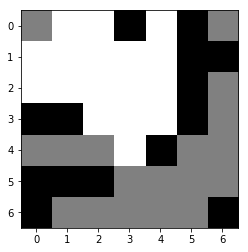

((4, 3), (6, 1)): n_v:  5499 q_all:+0.193171 q:+0.103858 q_m:+0.228000 p:0.042596
((0, 4), (2, 6)): n_v:  2287 q_all:+0.100777 q:+0.061940 q_m:+0.228000 p:0.206952
((3, 2), (4, 1)): n_v:  1080 q_all:+0.079081 q:+0.093696 q_m:+0.312000 p:0.157503
((2, 0), (4, 1)): n_v:   408 q_all:+0.070426 q:+0.079044 q_m:+0.284000 p:0.068546
((3, 4), (4, 5)): n_v:   379 q_all:+0.072004 q:+0.021640 q_m:+0.160000 p:0.062165
((4, 3), (5, 3)): n_v:   358 q_all:+0.037313 q:+0.037542 q_m:+0.160000 p:0.090301
((4, 3), (5, 5)): n_v:   197 q_all:+0.034009 q:+0.026575 q_m:+0.140000 p:0.051362
((3, 3), (4, 1)): n_v:   126 q_all:+0.074609 q:+0.094475 q_m:+0.284000 p:0.019829
((4, 3), (4, 1)): n_v:   109 q_all:+0.093465 q:+0.103882 q_m:+0.284000 p:0.011945
((4, 3), (5, 4)): n_v:   102 q_all:+0.028497 q:+0.008774 q_m:+0.120000 p:0.028119
((3, 2), (4, 2)): n_v:    97 q_all:+0.063295 q:+0.080810 q_m:+0.200000 p:0.018140
((3, 4), (2, 6)): n_v:    95 q_all:+0.050654 q:+0.090086 q_m:+0.228000 p:0.020834
((4, 3), (6, 5))

((3, 1), (4, 3)): n_v:  6011 q_all:-0.071048 q:-0.112546 q_m:-0.060000 p:0.169563
((4, 4), (6, 2)): n_v:  3270 q_all:-0.190387 q:-0.102905 q_m:-0.100000 p:0.568290
((3, 5), (4, 3)): n_v:   735 q_all:-0.194703 q:-0.110029 q_m:-0.060000 p:0.136282
((2, 5), (4, 3)): n_v:   108 q_all:-0.191197 q:-0.117893 q_m:-0.060000 p:0.019127
((4, 4), (4, 3)): n_v:    99 q_all:-0.198060 q:-0.100905 q_m:-0.040000 p:0.019398
((4, 4), (4, 2)): n_v:    50 q_all:-0.231950 q:-0.077894 q_m:-0.060000 p:0.014448
((6, 6), (6, 4)): n_v:    33 q_all:-0.277027 q:-0.138041 q_m:-0.228000 p:0.013619
((3, 0), (4, 1)): n_v:    25 q_all:-0.181188 q:-0.068725 q_m:-0.040000 p:0.003787
((3, 5), (4, 5)): n_v:    23 q_all:-0.237464 q:-0.123226 q_m:-0.160000 p:0.007046
((3, 1), (4, 2)): n_v:    15 q_all:-0.215367 q:-0.086300 q_m:-0.040000 p:0.003694
((4, 4), (6, 4)): n_v:    13 q_all:-0.273953 q:-0.114715 q_m:-0.228000 p:0.005535
((2, 5), (4, 5)): n_v:     9 q_all:-0.258697 q:-0.130189 q_m:-0.180000 p:0.003284
((4, 4), (5, 4))

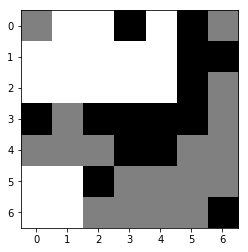

((5, 1), (4, 2)): n_v:  8851 q_all:+0.128910 q:+0.138242 q_m:+0.256000 p:0.605741
((2, 0), (4, 2)): n_v:   375 q_all:+0.096209 q:+0.112318 q_m:+0.228000 p:0.035911
((5, 0), (4, 2)): n_v:   352 q_all:+0.057865 q:+0.106490 q_m:+0.228000 p:0.068401
((0, 4), (2, 6)): n_v:   268 q_all:+0.111871 q:+0.119105 q_m:+0.228000 p:0.014844
((6, 1), (4, 2)): n_v:   216 q_all:+0.072227 q:+0.099202 q_m:+0.228000 p:0.034047
((6, 0), (4, 2)): n_v:   209 q_all:+0.054656 q:+0.109400 q_m:+0.228000 p:0.042392
((5, 0), (4, 1)): n_v:   162 q_all:+0.038787 q:+0.117160 q_m:+0.200000 p:0.039123
((2, 4), (4, 2)): n_v:   100 q_all:+0.081008 q:+0.117912 q_m:+0.228000 p:0.013530
((2, 0), (3, 1)): n_v:    69 q_all:+0.067338 q:+0.096841 q_m:+0.160000 p:0.011814
((2, 0), (4, 1)): n_v:    65 q_all:+0.047186 q:+0.087384 q_m:+0.180000 p:0.014410
((6, 1), (5, 3)): n_v:    47 q_all:+0.088369 q:+0.070301 q_m:+0.180000 p:0.005515
((2, 1), (4, 2)): n_v:    30 q_all:+0.041229 q:+0.120175 q_m:+0.228000 p:0.007140
((0, 1), (0, 0))

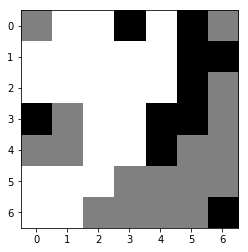

((3, 0), (3, 1)): n_v:  9728 q_all:-0.097750 q:-0.043517 q_m:-0.020000 p:0.662460
((4, 4), (5, 3)): n_v:  2613 q_all:-0.102141 q:-0.103825 q_m:-0.100000 p:0.197541
((3, 0), (4, 1)): n_v:   138 q_all:-0.083367 q:-0.058529 q_m:-0.020000 p:0.005661
((2, 5), (4, 5)): n_v:   109 q_all:-0.262169 q:-0.185605 q_m:-0.256000 p:0.038468
((4, 4), (6, 2)): n_v:   101 q_all:-0.156580 q:-0.103421 q_m:-0.120000 p:0.016910
((3, 5), (5, 3)): n_v:    64 q_all:-0.139969 q:-0.118065 q_m:-0.120000 p:0.009034
((3, 4), (5, 3)): n_v:    57 q_all:-0.181822 q:-0.100596 q_m:-0.120000 p:0.012260
((4, 4), (6, 5)): n_v:    18 q_all:-0.231555 q:-0.165772 q_m:-0.256000 p:0.005562
((4, 4), (5, 4)): n_v:    15 q_all:-0.161782 q:-0.173797 q_m:-0.180000 p:0.002840
((3, 4), (5, 6)): n_v:    14 q_all:-0.244974 q:-0.189708 q_m:-0.256000 p:0.004695
((3, 5), (5, 6)): n_v:    11 q_all:-0.240041 q:-0.192706 q_m:-0.256000 p:0.003500
((6, 6), (6, 4)): n_v:     9 q_all:-0.231708 q:-0.184393 q_m:-0.256000 p:0.002687
((3, 0), (4, 0))

((5, 0), (4, 1)): n_v:  5662 q_all:+0.127157 q:+0.121771 q_m:+0.200000 p:0.463896
((0, 4), (2, 6)): n_v:  4802 q_all:+0.191434 q:+0.094493 q_m:+0.180000 p:0.002488
((6, 1), (4, 1)): n_v:   986 q_all:+0.113999 q:+0.114943 q_m:+0.180000 p:0.106718
((6, 0), (4, 1)): n_v:   477 q_all:+0.116259 q:+0.107332 q_m:+0.180000 p:0.049448
((3, 3), (4, 1)): n_v:    45 q_all:+0.113289 q:+0.113771 q_m:+0.180000 p:0.005010
((4, 3), (4, 5)): n_v:    32 q_all:+0.087568 q:+0.059384 q_m:+0.140000 p:0.005298
((5, 0), (4, 0)): n_v:    32 q_all:+0.052800 q:+0.065111 q_m:+0.120000 p:0.007423
((4, 3), (4, 1)): n_v:    15 q_all:+0.111996 q:+0.099682 q_m:+0.180000 p:0.001727
((3, 3), (4, 5)): n_v:     7 q_all:+0.072187 q:+0.058177 q_m:+0.140000 p:0.001466
((2, 3), (4, 5)): n_v:     6 q_all:+0.045297 q:+0.022435 q_m:+0.140000 p:0.001431
((4, 3), (5, 5)): n_v:     6 q_all:+0.067486 q:+0.061661 q_m:+0.100000 p:0.001242
((2, 3), (4, 1)): n_v:     6 q_all:+0.089802 q:+0.071455 q_m:+0.180000 p:0.000998
((6, 1), (4, 0))

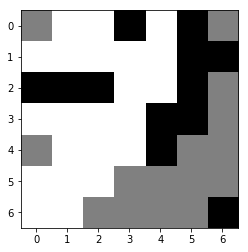

((4, 4), (5, 3)): n_v:  1379 q_all:-0.064100 q:-0.099913 q_m:-0.060000 p:0.250272
((2, 2), (0, 0)): n_v:  1257 q_all:-0.064628 q:-0.070377 q_m:-0.080000 p:0.229811
((2, 0), (4, 0)): n_v:   939 q_all:-0.019609 q:-0.035847 q_m:-0.000000 p:0.082744
((2, 2), (4, 0)): n_v:   787 q_all:+0.006515 q:-0.041033 q_m:-0.000000 p:0.026081
((2, 1), (4, 0)): n_v:   443 q_all:-0.035181 q:-0.024283 q_m:-0.000000 p:0.053293
((4, 4), (6, 2)): n_v:   353 q_all:-0.067892 q:-0.087077 q_m:-0.080000 p:0.066986
((2, 1), (0, 0)): n_v:   195 q_all:-0.107992 q:-0.073963 q_m:-0.080000 p:0.053243
((2, 0), (0, 0)): n_v:   138 q_all:-0.087723 q:-0.071985 q_m:-0.080000 p:0.032056
((0, 5), (0, 6)): n_v:    68 q_all:-0.158156 q:-0.156337 q_m:-0.180000 p:0.025933
((2, 5), (4, 6)): n_v:    56 q_all:-0.182630 q:-0.146409 q_m:-0.200000 p:0.024444
((3, 5), (4, 6)): n_v:    51 q_all:-0.166339 q:-0.129923 q_m:-0.180000 p:0.020477
((3, 4), (4, 6)): n_v:    43 q_all:-0.173598 q:-0.149039 q_m:-0.200000 p:0.017960
((3, 4), (5, 6))

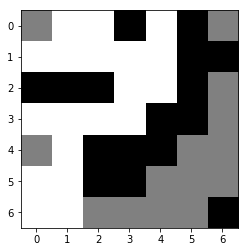

((0, 4), (2, 6)): n_v:  2466 q_all:+0.132431 q:+0.087758 q_m:+0.228000 p:0.012046
((5, 1), (6, 2)): n_v:  1910 q_all:+0.104467 q:+0.074888 q_m:+0.160000 p:0.143058
((3, 0), (4, 0)): n_v:  1298 q_all:+0.095952 q:+0.030199 q_m:+0.080000 p:0.125171
((6, 0), (4, 0)): n_v:    46 q_all:+0.063127 q:+0.027983 q_m:+0.060000 p:0.008305
((3, 3), (5, 4)): n_v:    17 q_all:+0.059957 q:+0.072187 q_m:+0.180000 p:0.003154
((0, 1), (0, 0)): n_v:    16 q_all:+0.047544 q:+0.058204 q_m:+0.080000 p:0.003556
((6, 1), (4, 0)): n_v:    12 q_all:+0.018149 q:-0.012825 q_m:+0.060000 p:0.003783
((3, 3), (5, 5)): n_v:    12 q_all:+0.085197 q:+0.054288 q_m:+0.140000 p:0.001560
((3, 2), (5, 4)): n_v:     6 q_all:+0.045343 q:+0.058857 q_m:+0.180000 p:0.001457
((6, 0), (6, 2)): n_v:     3 q_all:+0.083842 q:+0.087383 q_m:+0.140000 p:0.000499
((1, 4), (2, 6)): n_v:     2 q_all:+0.075830 q:+0.077369 q_m:+0.228000 p:0.000275
((3, 3), (4, 5)): n_v:     2 q_all:+0.077769 q:+0.101618 q_m:+0.180000 p:0.000410
((2, 4), (0, 6))

((2, 2), (4, 0)): n_v:  4703 q_all:-0.014597 q:-0.078980 q_m:-0.020000 p:0.042195
((0, 3), (0, 4)): n_v:   849 q_all:-0.099893 q:-0.132613 q_m:-0.080000 p:0.175333
((2, 2), (0, 0)): n_v:   593 q_all:-0.111856 q:-0.115215 q_m:-0.100000 p:0.138803
((5, 2), (6, 2)): n_v:   456 q_all:-0.108105 q:-0.136675 q_m:-0.120000 p:0.102848
((5, 3), (6, 4)): n_v:   231 q_all:-0.223259 q:-0.242155 q_m:-0.200000 p:0.114080
((5, 2), (4, 0)): n_v:   215 q_all:-0.154945 q:-0.068593 q_m:-0.020000 p:0.072026
((2, 0), (4, 0)): n_v:   119 q_all:-0.110192 q:-0.069692 q_m:-0.020000 p:0.027620
((4, 4), (4, 6)): n_v:    58 q_all:-0.250353 q:-0.186340 q_m:-0.180000 p:0.032629
((0, 5), (0, 6)): n_v:    48 q_all:-0.166350 q:-0.167707 q_m:-0.120000 p:0.017379
((2, 1), (0, 0)): n_v:    47 q_all:-0.164065 q:-0.102425 q_m:-0.100000 p:0.016625
((2, 0), (0, 0)): n_v:    44 q_all:-0.111800 q:-0.132575 q_m:-0.100000 p:0.010517
((4, 4), (3, 6)): n_v:    35 q_all:-0.165155 q:-0.141433 q_m:-0.100000 p:0.012636
((4, 2), (4, 0))

((1, 1), (2, 2)): n_v:  5203 q_all:+0.071898 q:+0.040986 q_m:+0.120000 p:0.087732
((0, 1), (2, 2)): n_v:  3789 q_all:+0.019882 q:-0.006741 q_m:+0.100000 p:0.448697
((1, 0), (2, 2)): n_v:   320 q_all:+0.022858 q:-0.001626 q_m:+0.100000 p:0.035443
((6, 0), (6, 2)): n_v:   142 q_all:-0.008221 q:+0.003911 q_m:+0.140000 p:0.025649
((6, 1), (6, 2)): n_v:    62 q_all:+0.005260 q:+0.019458 q_m:+0.160000 p:0.009571
((3, 2), (5, 4)): n_v:    49 q_all:+0.033754 q:+0.004944 q_m:+0.140000 p:0.004015
((1, 6), (0, 4)): n_v:    45 q_all:-0.040314 q:+0.020454 q_m:+0.100000 p:0.011077
((3, 3), (5, 4)): n_v:    20 q_all:+0.011050 q:+0.001380 q_m:+0.140000 p:0.002893
((2, 6), (0, 4)): n_v:    14 q_all:-0.043522 q:+0.014871 q_m:+0.100000 p:0.003541
((3, 5), (5, 4)): n_v:    13 q_all:-0.019295 q:-0.007639 q_m:+0.140000 p:0.002303
((0, 2), (2, 2)): n_v:    10 q_all:-0.006666 q:-0.041556 q_m:+0.100000 p:0.001843
((1, 3), (0, 4)): n_v:     5 q_all:-0.016176 q:+0.060124 q_m:+0.120000 p:0.001061
((3, 5), (4, 5))

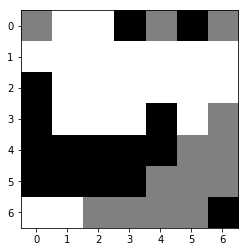

((0, 3), (0, 4)): n_v:  6634 q_all:-0.041296 q:-0.034228 q_m:+0.020000 p:0.334585
((2, 0), (0, 0)): n_v:  1827 q_all:-0.023796 q:-0.032073 q_m:-0.000000 p:0.021781
((5, 3), (6, 4)): n_v:   651 q_all:-0.146114 q:-0.126139 q_m:-0.100000 p:0.167989
((0, 5), (0, 6)): n_v:   440 q_all:-0.088348 q:-0.091786 q_m:-0.020000 p:0.063293
((5, 1), (6, 2)): n_v:   216 q_all:-0.079846 q:-0.059778 q_m:-0.060000 p:0.027453
((4, 4), (3, 6)): n_v:   200 q_all:-0.060159 q:-0.071304 q_m:-0.000000 p:0.017565
((3, 4), (3, 6)): n_v:    26 q_all:-0.078485 q:-0.067442 q_m:-0.000000 p:0.003336
((4, 0), (6, 2)): n_v:    12 q_all:-0.149974 q:-0.106220 q_m:-0.080000 p:0.003439
((6, 6), (6, 4)): n_v:     9 q_all:-0.162396 q:-0.135176 q_m:-0.120000 p:0.002884
((5, 2), (6, 4)): n_v:     7 q_all:-0.195534 q:-0.142318 q_m:-0.120000 p:0.002841
((3, 4), (4, 5)): n_v:     6 q_all:-0.116701 q:-0.086309 q_m:-0.060000 p:0.001319
((4, 2), (6, 4)): n_v:     5 q_all:-0.207024 q:-0.185088 q_m:-0.120000 p:0.002090
((4, 3), (6, 4))

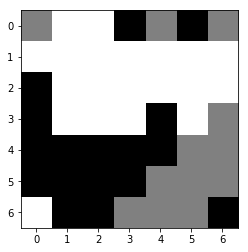

((1, 3), (0, 4)): n_v:  4886 q_all:+0.177752 q:+0.091748 q_m:+0.160000 p:0.210547
((3, 5), (4, 5)): n_v:   103 q_all:+0.120219 q:+0.025245 q_m:+0.160000 p:0.020958
((1, 6), (0, 4)): n_v:    51 q_all:+0.118242 q:+0.047565 q_m:+0.140000 p:0.010794
((3, 2), (5, 4)): n_v:    38 q_all:+0.004372 q:+0.000940 q_m:+0.180000 p:0.020151
((2, 6), (0, 4)): n_v:    35 q_all:+0.119119 q:+0.016567 q_m:+0.140000 p:0.007276
((3, 5), (5, 4)): n_v:    27 q_all:+0.093490 q:-0.059430 q_m:+0.180000 p:0.007690
((3, 3), (5, 4)): n_v:    26 q_all:+0.005874 q:+0.044313 q_m:+0.180000 p:0.013932
((2, 3), (4, 5)): n_v:     3 q_all:-0.048418 q:-0.044323 q_m:+0.140000 p:0.002227
((2, 6), (4, 5)): n_v:     3 q_all:+0.091044 q:-0.005059 q_m:+0.140000 p:0.000927
((3, 3), (4, 5)): n_v:     3 q_all:-0.000433 q:+0.018308 q_m:+0.140000 p:0.001783
((3, 5), (5, 6)): n_v:     2 q_all:+0.044971 q:-0.048797 q_m:+0.100000 p:0.001074
((3, 3), (5, 5)): n_v:     2 q_all:+0.038809 q:-0.004964 q_m:+0.140000 p:0.001029
((2, 5), (0, 4))

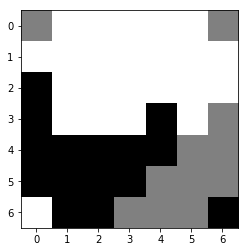

((4, 4), (3, 6)): n_v:  4244 q_all:-0.099912 q:-0.066517 q_m:-0.040000 p:0.168803
((2, 0), (0, 0)): n_v:  2893 q_all:-0.168789 q:-0.059556 q_m:-0.040000 p:0.502900
((3, 4), (4, 5)): n_v:  1652 q_all:-0.071722 q:-0.081967 q_m:-0.100000 p:0.026106
((3, 4), (5, 6)): n_v:   271 q_all:-0.178119 q:-0.113328 q_m:-0.160000 p:0.057389
((3, 4), (3, 6)): n_v:   230 q_all:-0.177670 q:-0.049428 q_m:-0.040000 p:0.045867
((6, 6), (5, 6)): n_v:   151 q_all:-0.225585 q:-0.102003 q_m:-0.140000 p:0.047830
((3, 4), (5, 5)): n_v:    64 q_all:-0.193751 q:-0.107118 q_m:-0.160000 p:0.015933
((5, 3), (6, 4)): n_v:    60 q_all:-0.175918 q:-0.135865 q_m:-0.140000 p:0.012571
((4, 4), (5, 6)): n_v:    45 q_all:-0.229454 q:-0.127676 q_m:-0.160000 p:0.014864
((6, 6), (6, 4)): n_v:    35 q_all:-0.197813 q:-0.141922 q_m:-0.160000 p:0.009117
((4, 4), (4, 6)): n_v:    22 q_all:-0.225640 q:-0.094609 q_m:-0.120000 p:0.007099
((3, 4), (5, 4)): n_v:    22 q_all:-0.203699 q:-0.150675 q_m:-0.160000 p:0.006106
((5, 3), (4, 5))

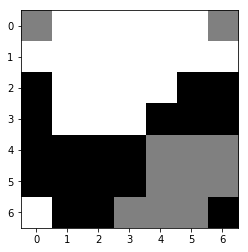

((3, 3), (4, 4)): n_v:  8960 q_all:+0.118955 q:+0.089736 q_m:+0.228000 p:0.917607
((3, 3), (4, 5)): n_v:    74 q_all:+0.063281 q:+0.053116 q_m:+0.160000 p:0.016346
((3, 2), (5, 4)): n_v:    58 q_all:-0.005606 q:-0.040496 q_m:+0.120000 p:0.021085
((3, 3), (5, 4)): n_v:    36 q_all:+0.018848 q:+0.033992 q_m:+0.120000 p:0.011262
((3, 3), (5, 5)): n_v:    29 q_all:+0.023840 q:+0.012607 q_m:+0.080000 p:0.008990
((3, 2), (4, 4)): n_v:    23 q_all:+0.031779 q:+0.041139 q_m:+0.200000 p:0.006529
((2, 2), (4, 4)): n_v:    18 q_all:+0.042593 q:+0.033105 q_m:+0.200000 p:0.004906
((2, 3), (4, 4)): n_v:    13 q_all:+0.048165 q:+0.024879 q_m:+0.200000 p:0.003399
((2, 3), (4, 5)): n_v:    13 q_all:-0.003980 q:-0.014692 q_m:+0.160000 p:0.004675
((2, 4), (4, 5)): n_v:     2 q_all:+0.007253 q:-0.035083 q_m:+0.160000 p:0.000821
((2, 4), (4, 4)): n_v:     1 q_all:+0.022801 q:-0.048325 q_m:+0.200000 p:0.000440
((0, 1), (0, 0)): n_v:     1 q_all:-0.001503 q:-0.014251 q_m:+0.060000 p:0.000577
((0, 5), (0, 6))

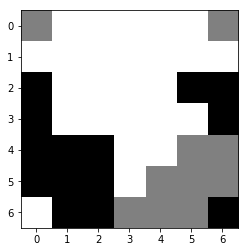

((3, 6), (4, 5)): n_v: 12245 q_all:-0.101028 q:-0.083480 q_m:-0.080000 p:0.895818
((6, 6), (4, 5)): n_v:   352 q_all:-0.120274 q:-0.115489 q_m:-0.100000 p:0.037265
((2, 6), (4, 5)): n_v:   263 q_all:-0.152386 q:-0.111996 q_m:-0.100000 p:0.042261
((6, 6), (5, 4)): n_v:    83 q_all:-0.149882 q:-0.101686 q_m:-0.100000 p:0.013090
((3, 6), (5, 4)): n_v:    37 q_all:-0.093318 q:-0.100451 q_m:-0.100000 p:0.002259
((2, 5), (4, 5)): n_v:    21 q_all:-0.177753 q:-0.144841 q_m:-0.100000 p:0.004346
((2, 6), (0, 6)): n_v:     9 q_all:-0.127996 q:-0.086097 q_m:-0.100000 p:0.001109
((2, 0), (0, 0)): n_v:     3 q_all:-0.145194 q:-0.120096 q_m:-0.100000 p:0.000436
((6, 2), (5, 4)): n_v:     2 q_all:-0.144012 q:-0.110658 q_m:-0.100000 p:0.000390
((2, 5), (0, 6)): n_v:     2 q_all:-0.163688 q:-0.159902 q_m:-0.100000 p:0.000448
((3, 6), (4, 6)): n_v:     2 q_all:-0.208583 q:-0.211982 q_m:-0.160000 p:0.000595
((6, 6), (6, 4)): n_v:     1 q_all:-0.164914 q:-0.245287 q_m:-0.180000 p:0.000278
((3, 6), (5, 5))

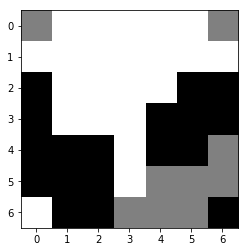

((4, 3), (5, 4)): n_v: 11238 q_all:+0.132322 q:+0.036275 q_m:+0.180000 p:0.366597
((5, 3), (5, 5)): n_v:  1263 q_all:+0.120478 q:+0.079391 q_m:+0.200000 p:0.037382
((5, 3), (6, 3)): n_v:   951 q_all:+0.115288 q:+0.066312 q_m:+0.180000 p:0.037114
((4, 3), (5, 5)): n_v:   618 q_all:+0.102459 q:+0.028937 q_m:+0.200000 p:0.038451
((3, 3), (5, 5)): n_v:   165 q_all:+0.112703 q:+0.080363 q_m:+0.200000 p:0.007194
((0, 5), (0, 6)): n_v:    38 q_all:+0.060084 q:+0.009021 q_m:+0.100000 p:0.005401
((0, 1), (0, 0)): n_v:    30 q_all:+0.066785 q:+0.023883 q_m:+0.100000 p:0.003837
((5, 3), (6, 5)): n_v:    24 q_all:+0.076717 q:+0.069392 q_m:+0.120000 p:0.002717
((5, 3), (6, 4)): n_v:    13 q_all:+0.044205 q:+0.007481 q_m:+0.100000 p:0.002131
((3, 2), (5, 4)): n_v:     7 q_all:+0.070337 q:+0.018316 q_m:+0.160000 p:0.000810
((3, 3), (5, 4)): n_v:     6 q_all:+0.073420 q:+0.085249 q_m:+0.160000 p:0.000485
((4, 3), (6, 5)): n_v:     5 q_all:+0.047537 q:-0.012332 q_m:+0.120000 p:0.000816
((4, 3), (6, 3))

((3, 6), (5, 5)): n_v:  6747 q_all:-0.121835 q:-0.113108 q_m:-0.060000 p:0.595578
((6, 6), (5, 5)): n_v:  3367 q_all:-0.114578 q:-0.177353 q_m:-0.040000 p:0.258887
((2, 6), (0, 6)): n_v:  2377 q_all:-0.066930 q:-0.055076 q_m:-0.060000 p:0.003850
((3, 4), (5, 5)): n_v:   371 q_all:-0.150322 q:-0.118484 q_m:-0.060000 p:0.049448
((3, 5), (5, 5)): n_v:   220 q_all:-0.217154 q:-0.207482 q_m:-0.060000 p:0.052501
((2, 0), (0, 0)): n_v:    99 q_all:-0.142892 q:-0.159044 q_m:-0.060000 p:0.012038
((5, 2), (6, 3)): n_v:    29 q_all:-0.124254 q:-0.159108 q_m:-0.080000 p:0.002721
((6, 6), (4, 6)): n_v:    12 q_all:-0.194152 q:-0.223972 q_m:-0.140000 p:0.002493
((6, 1), (6, 3)): n_v:     9 q_all:-0.230787 q:-0.201883 q_m:-0.100000 p:0.002416
((6, 6), (6, 4)): n_v:     9 q_all:-0.206463 q:-0.212769 q_m:-0.100000 p:0.002169
((5, 1), (6, 3)): n_v:     8 q_all:-0.262544 q:-0.254113 q_m:-0.100000 p:0.002643
((3, 5), (4, 6)): n_v:     5 q_all:-0.187435 q:-0.160392 q_m:-0.120000 p:0.001125
((4, 1), (6, 3))

((1, 6), (3, 6)): n_v:  6624 q_all:+0.164720 q:+0.132399 q_m:+0.228000 p:0.666892
((5, 3), (6, 3)): n_v:  1634 q_all:+0.190562 q:+0.132264 q_m:+0.200000 p:0.086527
((1, 5), (3, 6)): n_v:   665 q_all:+0.123212 q:+0.061734 q_m:+0.228000 p:0.118033
((2, 4), (3, 6)): n_v:   283 q_all:+0.117726 q:+0.081675 q_m:+0.228000 p:0.052914
((5, 3), (6, 5)): n_v:   177 q_all:+0.187423 q:+0.115485 q_m:+0.180000 p:0.010433
((5, 3), (6, 4)): n_v:   132 q_all:+0.132279 q:+0.076411 q_m:+0.160000 p:0.021300
((4, 3), (6, 5)): n_v:    52 q_all:+0.113737 q:+0.010989 q_m:+0.180000 p:0.010306
((1, 4), (3, 6)): n_v:    47 q_all:+0.106633 q:+0.074865 q_m:+0.228000 p:0.009778
((0, 1), (0, 0)): n_v:    25 q_all:+0.095809 q:+0.011131 q_m:+0.080000 p:0.005896
((0, 5), (0, 6)): n_v:    12 q_all:+0.072873 q:+0.016177 q_m:+0.080000 p:0.003295
((4, 3), (6, 4)): n_v:     2 q_all:+0.090287 q:-0.019639 q_m:+0.140000 p:0.000711
((4, 3), (6, 3)): n_v:     1 q_all:+0.062176 q:+0.086588 q_m:+0.180000 p:0.000352
((2, 4), (0, 6))

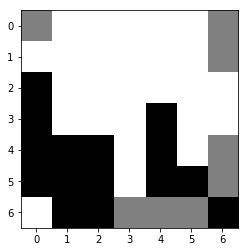

((3, 4), (1, 6)): n_v:  4711 q_all:-0.053700 q:-0.090438 q_m:-0.060000 p:0.046930
((5, 5), (4, 6)): n_v:  2756 q_all:-0.141518 q:-0.084071 q_m:-0.080000 p:0.476556
((6, 6), (4, 6)): n_v:  1950 q_all:-0.155911 q:-0.085910 q_m:-0.100000 p:0.389326
((3, 4), (4, 6)): n_v:   108 q_all:-0.173650 q:-0.086804 q_m:-0.100000 p:0.025326
((3, 4), (5, 6)): n_v:    67 q_all:-0.216085 q:-0.176532 q_m:-0.180000 p:0.020987
((5, 5), (5, 6)): n_v:    36 q_all:-0.231490 q:-0.174104 q_m:-0.160000 p:0.012493
((5, 4), (4, 6)): n_v:    22 q_all:-0.153654 q:-0.078575 q_m:-0.100000 p:0.004354
((4, 4), (5, 6)): n_v:     5 q_all:-0.241003 q:-0.176507 q_m:-0.180000 p:0.002078
((4, 4), (4, 6)): n_v:     5 q_all:-0.193095 q:-0.092224 q_m:-0.100000 p:0.001603
((5, 4), (5, 6)): n_v:     4 q_all:-0.215006 q:-0.113405 q_m:-0.180000 p:0.001463
((2, 0), (0, 0)): n_v:     1 q_all:-0.158152 q:-0.098828 q_m:-0.100000 p:0.000122
((4, 4), (6, 3)): n_v:     0 q_all:-0.208710 q:-0.227851 q_m:-0.180000 p:0.000050
((5, 4), (6, 5))

((2, 3), (3, 4)): n_v:  8096 q_all:+0.153477 q:+0.078821 q_m:+0.160000 p:0.172178
((5, 3), (6, 3)): n_v:   551 q_all:+0.044639 q:+0.103114 q_m:+0.200000 p:0.053155
((2, 4), (0, 6)): n_v:   328 q_all:+0.076052 q:+0.035449 q_m:+0.180000 p:0.001531
((4, 5), (6, 3)): n_v:   151 q_all:+0.032172 q:+0.056573 q_m:+0.180000 p:0.020065
((4, 3), (6, 5)): n_v:   149 q_all:+0.033366 q:-0.009212 q_m:+0.180000 p:0.019270
((4, 3), (6, 3)): n_v:    88 q_all:+0.032975 q:+0.071866 q_m:+0.180000 p:0.011502
((3, 6), (3, 4)): n_v:    85 q_all:+0.047407 q:+0.064056 q_m:+0.140000 p:0.007590
((5, 3), (3, 4)): n_v:    54 q_all:+0.048084 q:+0.079651 q_m:+0.140000 p:0.004719
((3, 5), (5, 6)): n_v:    42 q_all:+0.034457 q:+0.028417 q_m:+0.140000 p:0.005398
((5, 3), (6, 5)): n_v:    28 q_all:+0.007620 q:+0.060508 q_m:+0.180000 p:0.005679
((0, 4), (0, 6)): n_v:     9 q_all:+0.034162 q:+0.038979 q_m:+0.180000 p:0.001105
((1, 3), (3, 4)): n_v:     9 q_all:-0.079223 q:-0.049499 q_m:+0.140000 p:0.004299
((3, 2), (3, 4))

((5, 5), (4, 6)): n_v:  9800 q_all:-0.101470 q:-0.093895 q_m:-0.020000 p:0.552960
((6, 6), (4, 6)): n_v:  2720 q_all:-0.162528 q:-0.096222 q_m:-0.040000 p:0.393885
((2, 6), (4, 6)): n_v:   297 q_all:-0.160183 q:-0.105642 q_m:-0.040000 p:0.041426
((5, 4), (4, 6)): n_v:    92 q_all:-0.119092 q:-0.098441 q_m:-0.040000 p:0.004378
((2, 0), (0, 0)): n_v:    21 q_all:-0.113398 q:-0.070033 q_m:-0.040000 p:0.000778
((6, 6), (6, 4)): n_v:     2 q_all:-0.272932 q:-0.209915 q_m:-0.120000 p:0.000750
((5, 5), (5, 6)): n_v:     2 q_all:-0.274576 q:-0.234688 q_m:-0.100000 p:0.000703
((6, 2), (6, 4)): n_v:     1 q_all:-0.192011 q:-0.132332 q_m:-0.120000 p:0.000115
((5, 5), (6, 3)): n_v:     1 q_all:-0.171715 q:-0.153616 q_m:-0.120000 p:0.000114
((5, 2), (6, 3)): n_v:     1 q_all:-0.195909 q:-0.198698 q_m:-0.100000 p:0.000141
((5, 4), (6, 5)): n_v:     1 q_all:-0.254886 q:-0.265729 q_m:-0.140000 p:0.000364
((4, 2), (6, 4)): n_v:     1 q_all:-0.226770 q:-0.218576 q_m:-0.120000 p:0.000197
((2, 6), (0, 6))

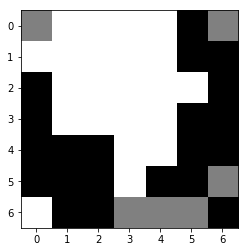

((5, 3), (6, 3)): n_v: 11690 q_all:+0.110913 q:+0.243207 q_m:+0.160000 p:0.861384
((5, 3), (6, 4)): n_v:   523 q_all:+0.149930 q:+0.047405 q_m:+0.120000 p:0.005391
((0, 1), (0, 0)): n_v:   443 q_all:+0.124551 q:+0.015128 q_m:+0.040000 p:0.022634
((5, 3), (6, 5)): n_v:   217 q_all:+0.134865 q:+0.115113 q_m:+0.140000 p:0.007459
((4, 4), (5, 6)): n_v:    83 q_all:+0.050746 q:+0.079738 q_m:+0.180000 p:0.014263
((3, 4), (5, 6)): n_v:    32 q_all:+0.035200 q:+0.090285 q_m:+0.180000 p:0.006309
((4, 3), (6, 5)): n_v:    28 q_all:+0.007939 q:-0.018267 q_m:+0.140000 p:0.006906
((4, 4), (6, 3)): n_v:    26 q_all:+0.053323 q:+0.030956 q_m:+0.140000 p:0.004350
((0, 4), (0, 6)): n_v:     9 q_all:+0.040911 q:+0.031471 q_m:+0.140000 p:0.001778
((4, 3), (6, 3)): n_v:     5 q_all:+0.010555 q:+0.077937 q_m:+0.140000 p:0.001191
((0, 2), (0, 0)): n_v:     2 q_all:-0.083498 q:-0.055938 q_m:+0.020000 p:0.000889
((4, 4), (6, 5)): n_v:     1 q_all:+0.014362 q:+0.060641 q_m:+0.140000 p:0.000443
((4, 3), (6, 4))

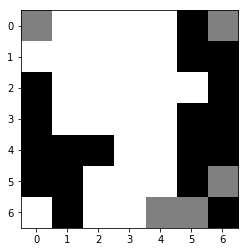

((6, 6), (6, 4)): n_v: 11880 q_all:-0.077124 q:-0.080524 q_m:-0.040000 p:0.888014
((5, 5), (6, 4)): n_v:  1528 q_all:-0.057632 q:-0.076204 q_m:-0.020000 p:0.068072
((4, 6), (6, 4)): n_v:   188 q_all:-0.086806 q:-0.120809 q_m:-0.040000 p:0.016666
((4, 5), (6, 4)): n_v:    85 q_all:-0.135184 q:-0.119240 q_m:-0.040000 p:0.014096
((4, 2), (6, 4)): n_v:    59 q_all:-0.164193 q:-0.245337 q_m:-0.040000 p:0.012349
((2, 0), (0, 0)): n_v:     1 q_all:-0.183933 q:-0.139139 q_m:-0.040000 p:0.000185
((4, 6), (6, 5)): n_v:     0 q_all:-0.275643 q:-0.379405 q_m:-0.120000 p:0.000033
((5, 5), (6, 5)): n_v:     0 q_all:-0.274141 q:-0.390236 q_m:-0.100000 p:0.000073
((3, 5), (5, 6)): n_v:     0 q_all:-0.323117 q:-0.431862 q_m:-0.160000 p:0.000003
((4, 5), (5, 6)): n_v:     0 q_all:-0.324505 q:-0.447509 q_m:-0.140000 p:0.000025
((4, 5), (6, 5)): n_v:     0 q_all:-0.248028 q:-0.333379 q_m:-0.120000 p:0.000006
((3, 6), (5, 6)): n_v:     0 q_all:-0.313255 q:-0.415425 q_m:-0.160000 p:0.000011
((2, 6), (0, 6))

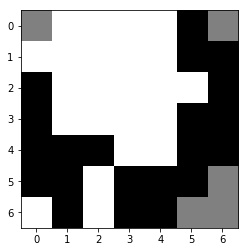

((0, 1), (0, 0)): n_v:  8930 q_all:+0.155471 q:+0.042808 q_m:+0.060000 p:0.224167
((4, 4), (5, 6)): n_v:  1857 q_all:+0.087721 q:+0.067967 q_m:+0.160000 p:0.144773
((4, 3), (6, 5)): n_v:   479 q_all:+0.086075 q:+0.073641 q_m:+0.160000 p:0.038611
((0, 4), (0, 6)): n_v:   372 q_all:+0.082214 q:+0.055332 q_m:+0.160000 p:0.032823
((3, 4), (5, 6)): n_v:   308 q_all:+0.084864 q:+0.076299 q_m:+0.160000 p:0.025484
((4, 4), (6, 5)): n_v:   255 q_all:+0.082685 q:+0.049666 q_m:+0.160000 p:0.022244
((0, 2), (0, 0)): n_v:   157 q_all:-0.021173 q:-0.030106 q_m:+0.040000 p:0.043626
((4, 4), (6, 6)): n_v:   108 q_all:+0.015802 q:-0.016387 q_m:+0.080000 p:0.022626
((2, 4), (0, 6)): n_v:    99 q_all:+0.073764 q:+0.045986 q_m:+0.160000 p:0.010172
((2, 2), (0, 0)): n_v:    25 q_all:-0.034749 q:-0.029055 q_m:+0.040000 p:0.007234
((2, 5), (0, 6)): n_v:    19 q_all:+0.078877 q:+0.053613 q_m:+0.160000 p:0.001745
((1, 4), (0, 6)): n_v:    15 q_all:+0.059764 q:+0.037429 q_m:+0.160000 p:0.001676
((2, 1), (0, 0))

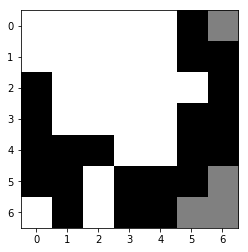

((4, 6), (6, 5)): n_v:  5254 q_all:-0.066595 q:-0.204268 q_m:-0.060000 p:0.008823
((5, 4), (6, 5)): n_v:  4102 q_all:-0.155704 q:-0.162471 q_m:-0.040000 p:0.106540
((4, 5), (5, 6)): n_v:  1749 q_all:-0.169266 q:-0.219255 q_m:-0.040000 p:0.095738
((6, 4), (5, 6)): n_v:   896 q_all:-0.189823 q:-0.294921 q_m:-0.060000 p:0.088094
((0, 5), (0, 6)): n_v:   403 q_all:-0.151068 q:-0.208773 q_m:-0.040000 p:0.006529
((5, 5), (6, 6)): n_v:   243 q_all:-0.149292 q:-0.144014 q_m:-0.040000 p:0.002957
((3, 6), (5, 6)): n_v:   106 q_all:-0.225921 q:-0.253712 q_m:-0.060000 p:0.018574
((6, 3), (6, 5)): n_v:   104 q_all:-0.236058 q:-0.222818 q_m:-0.060000 p:0.020228
((5, 3), (6, 5)): n_v:    92 q_all:-0.254405 q:-0.241552 q_m:-0.060000 p:0.021393
((4, 6), (6, 6)): n_v:    41 q_all:-0.173318 q:-0.243629 q_m:-0.060000 p:0.002655
((2, 6), (0, 6)): n_v:    32 q_all:-0.225934 q:-0.224147 q_m:-0.060000 p:0.005451
((3, 5), (5, 6)): n_v:    27 q_all:-0.221737 q:-0.315410 q_m:-0.060000 p:0.004477
((6, 4), (6, 6))

((4, 4), (5, 6)): n_v:  2820 q_all:+0.113829 q:+0.150938 q_m:+0.180000 p:0.093337
((4, 4), (6, 6)): n_v:  1791 q_all:+0.115584 q:+0.017657 q_m:+0.140000 p:0.053009
((0, 4), (0, 6)): n_v:  1429 q_all:+0.054857 q:+0.097861 q_m:+0.180000 p:0.213880
((2, 5), (4, 6)): n_v:  1419 q_all:+0.062623 q:+0.131295 q_m:+0.228000 p:0.190611
((2, 5), (0, 6)): n_v:  1346 q_all:+0.064438 q:+0.082526 q_m:+0.180000 p:0.175934
((4, 4), (4, 6)): n_v:   464 q_all:+0.077657 q:+0.230914 q_m:+0.228000 p:0.048474
((3, 4), (4, 6)): n_v:   460 q_all:+0.027571 q:+0.107989 q_m:+0.228000 p:0.093523
((2, 4), (0, 6)): n_v:   223 q_all:-0.008581 q:+0.045910 q_m:+0.180000 p:0.061554
((2, 4), (4, 6)): n_v:   130 q_all:+0.006220 q:+0.076356 q_m:+0.228000 p:0.032112
((3, 4), (5, 6)): n_v:   119 q_all:+0.009771 q:+0.092758 q_m:+0.180000 p:0.028427
((1, 4), (0, 6)): n_v:    16 q_all:-0.091061 q:+0.050351 q_m:+0.180000 p:0.007332
-1 's turn
one move takes time(s):  0.39859986305236816


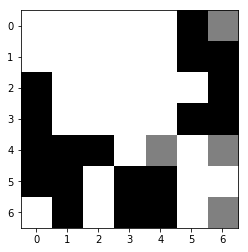

((3, 6), (4, 4)): n_v:  5681 q_all:-0.068532 q:-0.208237 q_m:+0.020000 p:0.096709
((3, 5), (4, 4)): n_v:  1476 q_all:-0.134324 q:-0.201689 q_m:+0.040000 p:0.244409
((2, 6), (4, 4)): n_v:   168 q_all:-0.141541 q:-0.212899 q_m:+0.020000 p:0.030493
((6, 4), (4, 6)): n_v:   132 q_all:-0.237300 q:-0.318400 q_m:-0.060000 p:0.052478
((6, 4), (4, 4)): n_v:   114 q_all:-0.180762 q:-0.254576 q_m:+0.020000 p:0.031042
((2, 6), (4, 6)): n_v:    95 q_all:-0.253591 q:-0.290684 q_m:-0.060000 p:0.041100
((6, 3), (4, 4)): n_v:    64 q_all:-0.149369 q:-0.220587 q_m:+0.020000 p:0.012636
((5, 4), (4, 6)): n_v:    34 q_all:-0.208435 q:-0.297729 q_m:-0.060000 p:0.011504
((4, 2), (4, 4)): n_v:    16 q_all:-0.217218 q:-0.321392 q_m:+0.020000 p:0.005752
((3, 5), (4, 6)): n_v:    14 q_all:-0.227904 q:-0.255621 q_m:-0.040000 p:0.005276
((5, 4), (6, 6)): n_v:     2 q_all:-0.237016 q:-0.418038 q_m:-0.060000 p:0.001101
((6, 4), (6, 6)): n_v:     2 q_all:-0.246080 q:-0.531923 q_m:-0.060000 p:0.000851
((2, 6), (0, 6))

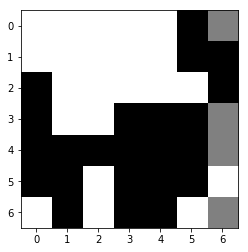

((2, 5), (4, 6)): n_v:  3754 q_all:+0.087256 q:+0.031925 q_m:+0.100000 p:0.251791
((5, 6), (3, 6)): n_v:  2497 q_all:+0.090456 q:+0.004000 q_m:+0.100000 p:0.152056
((2, 5), (3, 6)): n_v:  1790 q_all:+0.013450 q:-0.009873 q_m:+0.120000 p:0.375673
((5, 6), (6, 6)): n_v:  1402 q_all:+0.107009 q:-0.065598 q_m:+0.040000 p:0.040228
((5, 6), (4, 6)): n_v:   483 q_all:+0.034734 q:+0.139212 q_m:+0.120000 p:0.081536
((2, 5), (0, 6)): n_v:   154 q_all:+0.113693 q:+0.008662 q_m:+0.100000 p:0.002435
((2, 4), (4, 6)): n_v:    61 q_all:-0.039559 q:+0.020371 q_m:+0.100000 p:0.019263
((2, 4), (3, 6)): n_v:    51 q_all:-0.075693 q:-0.189475 q_m:+0.100000 p:0.019762
((0, 4), (0, 6)): n_v:    39 q_all:-0.039235 q:+0.027764 q_m:+0.100000 p:0.012078
((6, 5), (4, 6)): n_v:    25 q_all:+0.014949 q:+0.085823 q_m:+0.100000 p:0.005196
((2, 4), (0, 6)): n_v:    22 q_all:-0.000265 q:-0.034676 q_m:+0.100000 p:0.005253
((1, 4), (3, 6)): n_v:    12 q_all:-0.179161 q:-0.068596 q_m:+0.100000 p:0.007319
((1, 4), (0, 6))

((1, 5), (3, 6)): n_v:  5122 q_all:+0.014193 q:-0.302240 q_m:+0.020000 p:0.015328
((1, 5), (2, 5)): n_v:  2429 q_all:-0.086775 q:-0.181819 q_m:+0.040000 p:0.188635
((4, 4), (2, 5)): n_v:   278 q_all:-0.076251 q:-0.101036 q_m:+0.020000 p:0.011919
((0, 5), (2, 5)): n_v:   263 q_all:-0.074030 q:-0.111630 q_m:+0.020000 p:0.009459
((4, 3), (2, 5)): n_v:   232 q_all:-0.066497 q:-0.083557 q_m:+0.020000 p:0.002422
((1, 6), (3, 6)): n_v:   116 q_all:-0.138437 q:-0.231643 q_m:+0.020000 p:0.028641
((3, 3), (2, 5)): n_v:    95 q_all:-0.090180 q:-0.127037 q_m:+0.020000 p:0.008438
((6, 4), (6, 6)): n_v:    29 q_all:-0.123324 q:-0.193469 q_m:+0.020000 p:0.005776
((4, 4), (3, 6)): n_v:    12 q_all:-0.170405 q:-0.199255 q_m:+0.020000 p:0.004365
((0, 5), (0, 6)): n_v:    10 q_all:-0.352617 q:-0.640780 q_m:-0.080000 p:0.008612
((5, 4), (3, 6)): n_v:     8 q_all:-0.313728 q:-0.498210 q_m:+0.020000 p:0.006161
((2, 6), (3, 6)): n_v:     4 q_all:-0.211275 q:-0.380668 q_m:+0.040000 p:0.002042
((2, 6), (0, 6))

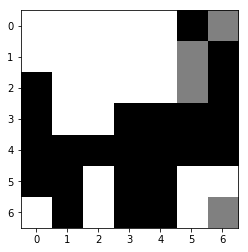

((0, 4), (2, 5)): n_v:  5872 q_all:+0.088588 q:-0.027322 q_m:+0.180000 p:0.036094
((0, 3), (1, 5)): n_v:  1478 q_all:-0.011772 q:-0.059997 q_m:+0.100000 p:0.160910
((1, 4), (2, 5)): n_v:  1215 q_all:-0.015360 q:+0.038232 q_m:+0.200000 p:0.144342
((0, 4), (1, 5)): n_v:   624 q_all:+0.014881 q:-0.003664 q_m:+0.120000 p:0.021404
((1, 3), (2, 5)): n_v:   400 q_all:-0.066885 q:-0.069637 q_m:+0.180000 p:0.105391
((0, 3), (2, 5)): n_v:   301 q_all:-0.046343 q:+0.004032 q_m:+0.180000 p:0.061936
((2, 3), (1, 5)): n_v:   107 q_all:-0.106525 q:-0.098409 q_m:+0.100000 p:0.040234
((2, 3), (2, 5)): n_v:    54 q_all:-0.082111 q:-0.058107 q_m:+0.180000 p:0.016496
((1, 3), (1, 5)): n_v:    30 q_all:-0.060947 q:-0.103844 q_m:+0.100000 p:0.007593
((2, 4), (0, 6)): n_v:    13 q_all:-0.014272 q:-0.175180 q_m:+0.060000 p:0.001496
((0, 4), (0, 6)): n_v:     9 q_all:-0.017502 q:-0.105180 q_m:+0.060000 p:0.001173
((1, 4), (0, 6)): n_v:     1 q_all:-0.189436 q:-0.110558 q_m:+0.060000 p:0.000100
((5, 5), (6, 6))

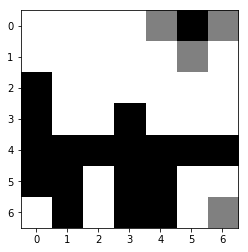

((0, 5), (1, 5)): n_v:  6757 q_all:-0.086121 q:-0.036612 q_m:+0.040000 p:0.441429
((3, 3), (1, 5)): n_v:  3177 q_all:-0.119437 q:-0.051685 q_m:+0.020000 p:0.410236
((4, 6), (6, 6)): n_v:   540 q_all:-0.100467 q:-0.232150 q_m:-0.060000 p:0.050172
((0, 5), (0, 4)): n_v:   284 q_all:-0.173703 q:-0.278349 q_m:-0.040000 p:0.066276
((6, 4), (6, 6)): n_v:    85 q_all:-0.173508 q:-0.234932 q_m:-0.060000 p:0.019817
((4, 4), (6, 6)): n_v:    12 q_all:-0.311879 q:-0.336507 q_m:-0.060000 p:0.006243
((5, 4), (6, 6)): n_v:     6 q_all:-0.323931 q:-0.350718 q_m:-0.060000 p:0.003271
((4, 5), (6, 6)): n_v:     3 q_all:-0.293391 q:-0.237501 q_m:-0.060000 p:0.001801
((0, 5), (0, 6)): n_v:     1 q_all:-0.312351 q:-0.387361 q_m:-0.120000 p:0.000638
1 's turn


This is a random move


one move takes time(s):  0.2175157070159912


((0, 3), (0, 4)): n_v: 10758 q_all:+0.094637 q:+0.056894 q_m:+0.100000 p:0.390142
((0, 2), (0, 4)): n_v:   396 q_all:-0.002534 q:-0.034899 q_m:+0.080000 p:0.085516
((1, 2), (0, 4)): n_v:    74 q_all:-0.039141 q:-0.099072 q_m:+0.080000 p:0.020853
((2, 3), (0, 4)): n_v:    65 q_all:-0.022158 q:-0.040692 q_m:+0.080000 p:0.016506
((2, 2), (0, 4)): n_v:    14 q_all:-0.016356 q:-0.018805 q_m:+0.080000 p:0.003163
((5, 5), (6, 6)): n_v:    11 q_all:-0.222517 q:-0.137551 q_m:-0.020000 p:0.005870
-1 's turn
one move takes time(s):  0.200761079788208


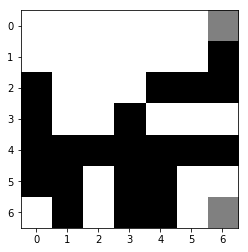

((4, 6), (6, 6)): n_v:  8529 q_all:-0.088123 q:-0.305091 q_m:+0.020000 p:0.207082
((2, 6), (0, 6)): n_v:  1872 q_all:-0.208490 q:-0.339247 q_m:-0.020000 p:0.404364
((1, 6), (0, 6)): n_v:  1631 q_all:-0.176192 q:-0.133001 q_m:-0.000000 p:0.268449
((6, 4), (6, 6)): n_v:   634 q_all:-0.181007 q:-0.235969 q_m:+0.020000 p:0.109322
((4, 5), (6, 6)): n_v:    16 q_all:-0.160255 q:-0.164944 q_m:+0.020000 p:0.002058
((2, 4), (0, 6)): n_v:    14 q_all:-0.235346 q:-0.477920 q_m:-0.020000 p:0.003773
((2, 5), (0, 6)): n_v:     8 q_all:-0.267049 q:-0.498642 q_m:-0.020000 p:0.002498
((4, 4), (6, 6)): n_v:     4 q_all:-0.287192 q:-0.386807 q_m:+0.020000 p:0.001613
((5, 4), (6, 6)): n_v:     2 q_all:-0.251867 q:-0.284739 q_m:+0.020000 p:0.000799
1 's turn


This is a random move


one move takes time(s):  0.142470121383667


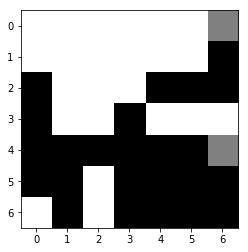

((3, 5), (4, 6)): n_v:  7654 q_all:+0.645440 q:-0.035220 q_m:+0.120000 p:0.379234
((3, 4), (4, 6)): n_v:  5446 q_all:+0.098108 q:-0.132089 q_m:+0.100000 p:0.251322
((0, 4), (0, 6)): n_v:    20 q_all:-0.169707 q:-0.283944 q_m:+0.020000 p:0.012759
((1, 4), (0, 6)): n_v:     1 q_all:-0.409303 q:-0.351911 q_m:+0.020000 p:0.000724
((0, 5), (0, 6)): n_v:     1 q_all:-0.153881 q:-0.283135 q_m:+0.040000 p:0.000970
-1 's turn
one move takes time(s):  0.1092841625213623


((2, 6), (0, 6)): n_v:  5184 q_all:-0.998629 q:-0.678006 q_m:-0.040000 p:0.541568
((1, 6), (0, 6)): n_v:  3935 q_all:-1.000000 q:+5.000000 q_m:-0.020000 p:0.420672
((2, 4), (0, 6)): n_v:   599 q_all:-0.968060 q:-0.764773 q_m:-0.040000 p:0.029981
((2, 5), (0, 6)): n_v:    67 q_all:-0.977492 q:-0.686370 q_m:-0.040000 p:0.004513
1 's turn
one move takes time(s):  0.07400155067443848


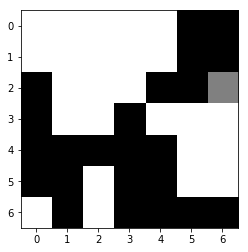

((3, 5), (2, 6)): n_v: 10173 q_all:+1.000000 q:+5.000000 q_m:+0.180000 p:0.467124
((3, 4), (2, 6)): n_v:     8 q_all:-0.176015 q:-0.032067 q_m:+0.160000 p:0.017894
((4, 6), (2, 6)): n_v:     2 q_all:-0.243742 q:+0.095968 q_m:+0.160000 p:0.003610
((0, 4), (2, 6)): n_v:     1 q_all:-0.441622 q:+0.051892 q_m:+0.160000 p:0.002367
((4, 5), (2, 6)): n_v:     0 q_all:+0.087352 q:-0.021621 q_m:+0.160000 p:0.000155
((1, 4), (2, 6)): n_v:     0 q_all:+0.108076 q:+0.030191 q_m:+0.160000 p:0.000885
this self play has 76 steps, time elapsed 113.33294248580933
winner is 1.0
episode 175 finished
episode 176 now start
it seems the reset did nothing
reset successful
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.9143421649932861
1 's turn
one move takes time(s):  1.0875952243804932
-1 's turn


This is a random move


one move takes time(s):  1.5655195713043213
1 's turn
due to rollout lim, final rollout times:  4639 time elapsed:  2.006275415420532

one move takes time(s):  0.6277327537536621
1 's turn


This is a random move


one move takes time(s):  0.7930583953857422
-1 's turn
one move takes time(s):  0.5350127220153809
1 's turn
one move takes time(s):  0.3788728713989258
-1 's turn


This is a random move


one move takes time(s):  0.27265143394470215
1 's turn


This is a random move


one move takes time(s):  0.41503381729125977
-1 's turn
one move takes time(s):  0.14177203178405762
1 's turn
one move takes time(s):  0.13090872764587402
-1 's turn
one move takes time(s):  0.11637520790100098
1 's turn
one move takes time(s):  0.11352777481079102
-1 's turn


This is a random move


one move takes time(s):  0.08080053329467773
this self play has 87 steps, time elapsed 131.1816463470459
winner is -1.0
episode 176 finished
episode 177 now start
it seems the reset did nothing
reset successful
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.9259281158447266
1 's turn


This

due to rollout lim, final rollout times:  1001 time elapsed:  2.368018388748169
one move takes time(s):  2.369403123855591
1 's turn
due to rollout lim, final rollout times:  2296 time elapsed:  2.00573468208313
one move takes time(s):  2.0070760250091553
-1 's turn
due to rollout lim, final rollout times:  2913 time elapsed:  2.0000224113464355


This is a random move


one move takes time(s):  2.0014772415161133
1 's turn
due to rollout lim, final rollout times:  4311 time elapsed:  2.0000524520874023
one move takes time(s):  2.001446008682251
-1 's turn
one move takes time(s):  1.9758219718933105
1 's turn
one move takes time(s):  0.8797943592071533
-1 's turn


This is a random move


one move takes time(s):  1.0290358066558838
1 's turn


This is a random move


one move takes time(s):  0.6580567359924316
-1 's turn
one move takes time(s):  0.5554742813110352
1 's turn


This is a random move


one move takes time(s):  0.7730987071990967
-1 's turn


This is a random move


one mo

one move takes time(s):  0.2937912940979004
-1 's turn
one move takes time(s):  0.3905785083770752
1 's turn


This is a random move


one move takes time(s):  0.2745354175567627
-1 's turn
one move takes time(s):  0.2645394802093506
1 's turn
one move takes time(s):  0.23536038398742676
-1 's turn
one move takes time(s):  0.18668866157531738
1 's turn
one move takes time(s):  0.24687647819519043
-1 's turn


This is a random move


one move takes time(s):  0.12425541877746582
1 's turn
one move takes time(s):  0.11968040466308594
-1 's turn


This is a random move


one move takes time(s):  0.10352444648742676
this self play has 75 steps, time elapsed 104.61132335662842
winner is -1.0
episode 178 finished
episode 179 now start
it seems the reset did nothing
reset successful
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.8886947631835938
1 's turn


This is a random move


one move takes time(s):  1.0556204319000244
-1 's turn


Thi

one move takes time(s):  0.9194192886352539
1 's turn
one move takes time(s):  1.166959285736084
-1 's turn


This is a random move


one move takes time(s):  1.7276415824890137
1 's turn
due to rollout lim, final rollout times:  4352 time elapsed:  2.000070095062256


This is a random move


one move takes time(s):  2.001081705093384
-1 's turn
due to rollout lim, final rollout times:  2654 time elapsed:  2.0008864402770996


This is a random move


one move takes time(s):  2.0019545555114746
1 's turn
due to rollout lim, final rollout times:  3256 time elapsed:  2.007598876953125
one move takes time(s):  2.008920192718506
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.063613176345825
one move takes time(s):  2.064889669418335
1 's turn
due to rollout lim, final rollout times:  1284 time elapsed:  2.000028133392334
one move takes time(s):  2.0012571811676025
-1 's turn
due to rollout lim, final rollout times:  1001 time elapsed:  2.3013720512390137
one move



This is a random move


one move takes time(s):  0.4807546138763428
1 's turn
one move takes time(s):  0.12637114524841309
-1 's turn
one move takes time(s):  0.11969280242919922
1 's turn
one move takes time(s):  0.05689501762390137
this self play has 80 steps, time elapsed 153.48476672172546
winner is 1.0
20 data expected to be grabbed
1 data grabbed for training
20 data expected to be grabbed
1 data grabbed for training
20 data expected to be grabbed
1 data grabbed for training
20 data expected to be grabbed
1 data grabbed for training
20 data expected to be grabbed
1 data grabbed for training
20 data expected to be grabbed
2 data grabbed for training
20 data expected to be grabbed
2 data grabbed for training
20 data expected to be grabbed
3 data grabbed for training
20 data expected to be grabbed
4 data grabbed for training
20 data expected to be grabbed
4 data grabbed for training
20 data expected to be grabbed
5 data grabbed for training
20 data expected to be grabbed
5 data gr

due to rollout lim, final rollout times:  2111 time elapsed:  2.006577730178833
one move takes time(s):  2.0077779293060303
-1 's turn
due to rollout lim, final rollout times:  1073 time elapsed:  2.003894567489624


This is a random move


one move takes time(s):  2.0050063133239746
1 's turn
due to rollout lim, final rollout times:  3925 time elapsed:  2.0000383853912354
one move takes time(s):  2.0010688304901123
-1 's turn
one move takes time(s):  1.4466133117675781
1 's turn
one move takes time(s):  1.3572981357574463
-1 's turn
due to rollout lim, final rollout times:  4777 time elapsed:  2.0017404556274414
one move takes time(s):  2.003037452697754
1 's turn
one move takes time(s):  1.830016851425171
-1 's turn
one move takes time(s):  1.9293532371520996
1 's turn
due to rollout lim, final rollout times:  2410 time elapsed:  2.010138988494873
one move takes time(s):  2.01114821434021
-1 's turn
one move takes time(s):  1.9999330043792725
1 's turn
due to rollout lim, final rollo

In [ ]:
player.reinforcement_learning(episode=500, left_space_max=None, rollout_times=1000, life_span=20, t_lim=10, self_play_verbose=False)

reset successful


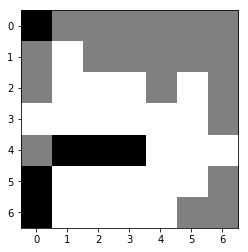

-1
due to rollout lim, final rollout times:  1601 time elapsed:  3.9874846935272217
((4, 1), (4, 0)): n_v:  1052 q_all:+0.013513 q:+0.049070 q_m:-0.200000 p:0.002485
((4, 2), (2, 4)): n_v:   239 q_all:+0.011836 q:+0.073340 q_m:-0.140000 p:0.002548
((6, 0), (4, 0)): n_v:   233 q_all:+0.011676 q:+0.026379 q_m:-0.228000 p:0.002703
((4, 3), (2, 4)): n_v:    13 q_all:-0.022183 q:+0.059676 q_m:-0.140000 p:0.002351
((4, 2), (2, 0)): n_v:    11 q_all:-0.027423 q:+0.021419 q_m:-0.180000 p:0.002421
((0, 0), (1, 2)): n_v:    11 q_all:-0.027220 q:+0.035929 q_m:-0.180000 p:0.002356
((4, 3), (6, 5)): n_v:     9 q_all:-0.037983 q:+0.083477 q_m:-0.228000 p:0.002581
((4, 1), (2, 0)): n_v:     8 q_all:-0.044054 q:+0.053543 q_m:-0.180000 p:0.002409
((0, 0), (2, 0)): n_v:     8 q_all:-0.041931 q:+0.020312 q_m:-0.180000 p:0.002386
((0, 0), (1, 0)): n_v:     6 q_all:-0.064221 q:+0.041322 q_m:-0.256000 p:0.002550
((4, 2), (4, 0)): n_v:     4 q_all:-0.087413 q:+0.021795 q_m:-0.228000 p:0.002377
((0, 0), (0, 1

In [192]:
#player = MCTS(is_cpu=True, c=4, is_load_model=False, dep_lim=5)
player._dep_lim = 3
player._c = 5
player.reset(20)
player._game.plot()
print(player._turn)
%lprun -f player.expand player.rollout(1600, np.nan)
#%time player.rollout(1000, np.nan)
player.plot_move_visit_freq()

In [194]:
player.testing_against_greedy(rounds=10, dep_lim=3, rollout_times=800, t_lim=np.nan, verbose=False)

####               ####
#### start testing ####
round: 1
it seems the reset did nothing
reset successful
this game start with 45 space left
due to rollout lim, final rollout times:  6003 time elapsed:  2.000020980834961
due to rollout lim, final rollout times:  915 time elapsed:  2.0029489994049072
due to rollout lim, final rollout times:  801 time elapsed:  8.23132848739624
due to rollout lim, final rollout times:  801 time elapsed:  3.167778730392456
due to rollout lim, final rollout times:  2185 time elapsed:  2.0062551498413086
due to rollout lim, final rollout times:  2611 time elapsed:  2.0042548179626465
due to rollout lim, final rollout times:  3396 time elapsed:  2.007519245147705
due to rollout lim, final rollout times:  1962 time elapsed:  2.0049996376037598
due to rollout lim, final rollout times:  801 time elapsed:  3.8791897296905518
due to rollout lim, final rollout times:  801 time elapsed:  6.408659219741821
due to rollout lim, final rollout times:  801 time elapsed:  

due to rollout lim, final rollout times:  801 time elapsed:  6.845288991928101
due to rollout lim, final rollout times:  801 time elapsed:  6.3133416175842285
due to rollout lim, final rollout times:  801 time elapsed:  3.8412482738494873
due to rollout lim, final rollout times:  801 time elapsed:  2.4178473949432373
due to rollout lim, final rollout times:  801 time elapsed:  2.721914529800415
due to rollout lim, final rollout times:  801 time elapsed:  2.6045053005218506
this round has steps: 22, time taken: 52.378161907196045, 


self wins? True



round: 5
it seems the reset did nothing
reset successful
this game start with 45 space left
due to rollout lim, final rollout times:  5652 time elapsed:  2.000037431716919
due to rollout lim, final rollout times:  801 time elapsed:  9.559806823730469
due to rollout lim, final rollout times:  801 time elapsed:  4.861716985702515
due to rollout lim, final rollout times:  801 time elapsed:  3.5259931087493896
due to rollout lim, final rollou

due to rollout lim, final rollout times:  801 time elapsed:  5.705243825912476
due to rollout lim, final rollout times:  801 time elapsed:  2.4915733337402344
due to rollout lim, final rollout times:  801 time elapsed:  5.890836238861084
due to rollout lim, final rollout times:  801 time elapsed:  4.892250299453735
due to rollout lim, final rollout times:  801 time elapsed:  5.543632984161377
due to rollout lim, final rollout times:  801 time elapsed:  5.826302766799927
due to rollout lim, final rollout times:  801 time elapsed:  5.3896379470825195
due to rollout lim, final rollout times:  801 time elapsed:  5.481220245361328
due to rollout lim, final rollout times:  801 time elapsed:  6.323174953460693
due to rollout lim, final rollout times:  801 time elapsed:  4.367497444152832
due to rollout lim, final rollout times:  801 time elapsed:  39.61291694641113
due to rollout lim, final rollout times:  801 time elapsed:  6.7671520709991455
due to rollout lim, final rollout times:  801 tim

0.9

reset successful
start new self play
-1 's turn
due to time lim, final rollout times:  1149
one move takes time(s):  24.12078547477722


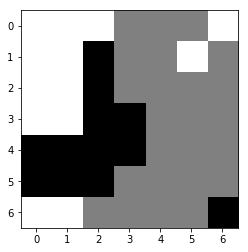

((3, 3), (3, 4)): n_v:   176 q_all:-0.077549 q:-0.055833 p:0.070284
((3, 3), (2, 4)): n_v:   154 q_all:-0.090031 q:-0.032151 p:0.073192
((4, 2), (5, 3)): n_v:   111 q_all:-0.076740 q:-0.065846 p:0.044003
((5, 1), (6, 2)): n_v:   104 q_all:-0.063224 q:-0.044750 p:0.032658
((5, 2), (6, 3)): n_v:   102 q_all:-0.096134 q:-0.053870 p:0.052483
((1, 2), (2, 3)): n_v:    94 q_all:-0.082198 q:-0.028607 p:0.040105
((1, 2), (1, 3)): n_v:    67 q_all:-0.073963 q:-0.032650 p:0.025641
((3, 3), (4, 4)): n_v:    65 q_all:-0.092277 q:-0.075309 p:0.031541
((6, 6), (4, 6)): n_v:    51 q_all:-0.095104 q:-0.053735 p:0.025644
((6, 6), (6, 4)): n_v:    37 q_all:-0.104208 q:-0.066936 p:0.020695
((6, 6), (4, 4)): n_v:    34 q_all:-0.096158 q:-0.076063 p:0.017793
((1, 2), (0, 3)): n_v:    32 q_all:-0.090532 q:-0.032738 p:0.015441
((4, 3), (5, 4)): n_v:    27 q_all:-0.096578 q:-0.055987 p:0.013679
((6, 6), (5, 6)): n_v:    24 q_all:-0.084451 q:-0.061569 p:0.010651
((6, 6), (5, 5)): n_v:    22 q_all:-0.098897 q:-

((1, 5), (2, 4)): n_v:   234 q_all:+0.051068 q:+0.030328 p:0.140924
((6, 1), (6, 2)): n_v:   141 q_all:+0.043007 q:+0.048165 p:0.090801
((1, 5), (2, 5)): n_v:   127 q_all:+0.034467 q:+0.026747 p:0.088021
((6, 0), (6, 2)): n_v:   107 q_all:+0.029312 q:+0.038290 p:0.076971
((0, 6), (2, 6)): n_v:    91 q_all:+0.018429 q:-0.002482 p:0.071176
((0, 2), (1, 3)): n_v:    78 q_all:+0.037097 q:-0.042120 p:0.052563
((0, 6), (0, 4)): n_v:    75 q_all:+0.026336 q:-0.014450 p:0.055463
((1, 5), (1, 4)): n_v:    74 q_all:+0.046269 q:-0.008440 p:0.046480
((0, 2), (0, 3)): n_v:    66 q_all:+0.035560 q:-0.043416 p:0.045639
((1, 5), (2, 6)): n_v:    62 q_all:+0.014909 q:-0.005446 p:0.049627
((0, 6), (2, 4)): n_v:    46 q_all:+0.040107 q:+0.034165 p:0.030549
((1, 5), (0, 4)): n_v:    37 q_all:+0.013029 q:-0.015631 p:0.030111
((0, 2), (2, 3)): n_v:    33 q_all:+0.055038 q:+0.065808 p:0.019584
((0, 1), (2, 3)): n_v:    32 q_all:+0.058010 q:+0.074281 p:0.017785
((0, 6), (1, 6)): n_v:    29 q_all:+0.016672 q:-

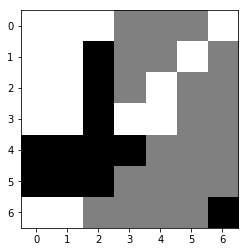

((4, 2), (5, 3)): n_v:   320 q_all:-0.096182 q:-0.119798 p:0.118277
((4, 3), (4, 4)): n_v:   236 q_all:-0.089758 q:-0.104750 p:0.079909
((1, 2), (1, 3)): n_v:   184 q_all:-0.094241 q:-0.040163 p:0.065914
((5, 1), (6, 2)): n_v:   113 q_all:-0.071798 q:-0.049248 p:0.027580
((6, 6), (4, 6)): n_v:   113 q_all:-0.102192 q:-0.096582 p:0.045455
((1, 2), (2, 3)): n_v:   100 q_all:-0.116322 q:-0.149046 p:0.047370
((5, 2), (6, 3)): n_v:    83 q_all:-0.111874 q:-0.070986 p:0.037520
((6, 6), (6, 4)): n_v:    65 q_all:-0.107593 q:-0.083419 p:0.028064
((6, 6), (4, 4)): n_v:    63 q_all:-0.102044 q:-0.103788 p:0.025302
((4, 3), (5, 4)): n_v:    60 q_all:-0.106109 q:-0.080914 p:0.025528
((6, 6), (5, 5)): n_v:    56 q_all:-0.109654 q:-0.089433 p:0.024605
((1, 2), (0, 3)): n_v:    49 q_all:-0.118778 q:-0.074287 p:0.023981
((6, 6), (5, 6)): n_v:    44 q_all:-0.094576 q:-0.097723 p:0.015990
((5, 0), (6, 2)): n_v:    28 q_all:-0.088802 q:-0.083137 p:0.009039
((4, 0), (6, 2)): n_v:    21 q_all:-0.071923 q:-

((2, 4), (2, 3)): n_v:   849 q_all:+0.127745 q:+0.032955 p:0.074958
((6, 0), (6, 2)): n_v:   185 q_all:+0.050917 q:+0.041471 p:0.081406
((6, 1), (6, 2)): n_v:   183 q_all:+0.061336 q:+0.065690 p:0.071418
((1, 5), (1, 4)): n_v:   113 q_all:+0.075718 q:+0.022681 p:0.036874
((3, 3), (4, 4)): n_v:    95 q_all:+0.035895 q:-0.011866 p:0.048735
((0, 2), (1, 3)): n_v:    65 q_all:+0.053890 q:+0.035090 p:0.028058
((1, 5), (2, 5)): n_v:    63 q_all:+0.024743 q:+0.050081 p:0.035751
((1, 5), (2, 6)): n_v:    63 q_all:+0.019286 q:+0.013712 p:0.037229
((0, 6), (2, 6)): n_v:    53 q_all:+0.020490 q:+0.016762 p:0.030555
((0, 6), (0, 4)): n_v:    42 q_all:+0.041654 q:+0.014175 p:0.020195
((2, 4), (3, 5)): n_v:    42 q_all:+0.016520 q:+0.017522 p:0.025110
((0, 2), (0, 3)): n_v:    39 q_all:+0.063887 q:+0.020106 p:0.015001
((0, 6), (1, 6)): n_v:    19 q_all:+0.012609 q:+0.017930 p:0.012132
((1, 5), (0, 4)): n_v:    19 q_all:+0.025078 q:+0.012985 p:0.010956
((6, 1), (6, 3)): n_v:    18 q_all:+0.034904 q:+

((5, 1), (6, 2)): n_v:   637 q_all:-0.166506 q:-0.102068 p:0.087634
((4, 3), (4, 4)): n_v:   408 q_all:-0.210342 q:-0.099442 p:0.128179
((6, 6), (4, 6)): n_v:   280 q_all:-0.202631 q:-0.175119 p:0.079379
((5, 3), (6, 4)): n_v:   188 q_all:-0.192455 q:-0.168372 p:0.045274
((6, 6), (4, 4)): n_v:   167 q_all:-0.207566 q:-0.098342 p:0.050416
((6, 6), (6, 4)): n_v:   153 q_all:-0.190340 q:-0.169402 p:0.035512
((5, 2), (6, 3)): n_v:   128 q_all:-0.204379 q:-0.186134 p:0.037259
((6, 6), (5, 5)): n_v:   113 q_all:-0.211404 q:-0.190096 p:0.035896
((5, 0), (6, 2)): n_v:    85 q_all:-0.171241 q:-0.115638 p:0.013231
((6, 6), (5, 6)): n_v:    79 q_all:-0.199782 q:-0.177841 p:0.021306
((4, 3), (5, 4)): n_v:    69 q_all:-0.198817 q:-0.176071 p:0.017689
((6, 6), (4, 5)): n_v:    35 q_all:-0.165323 q:-0.130981 p:0.004401
((4, 1), (6, 2)): n_v:    22 q_all:-0.207586 q:-0.098547 p:0.006894
((6, 6), (6, 5)): n_v:    20 q_all:-0.176627 q:-0.192118 p:0.003409
((4, 0), (6, 2)): n_v:    16 q_all:-0.166843 q:-

KeyboardInterrupt: 

In [22]:
player._dep_lim = 4
player.reset(24)
a = player.self_play(rollout_times=1600, t_lim=15, is_best=True)

in 0
out 0


out 1


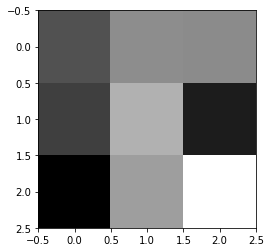

out 2


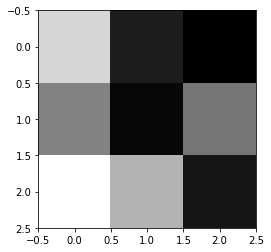

out 3


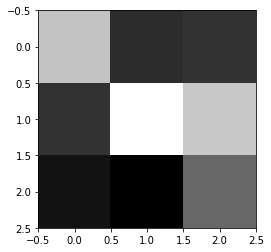

out 4


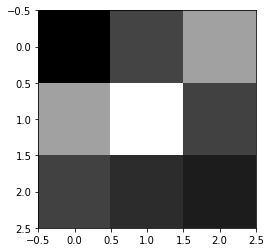

out 5


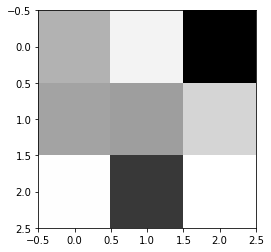

out 6


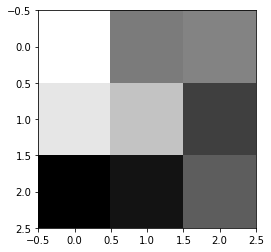

out 7


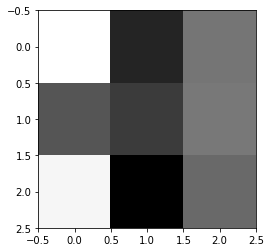

out 8


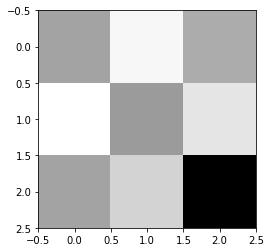

out 9


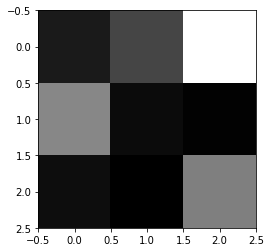

out 10


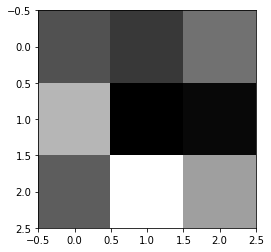

out 11


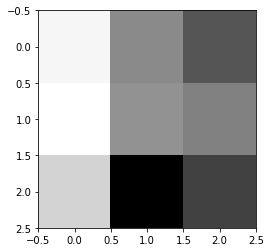

out 12


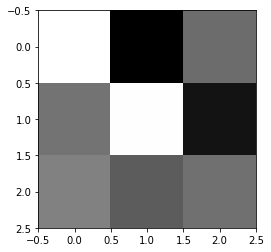

out 13


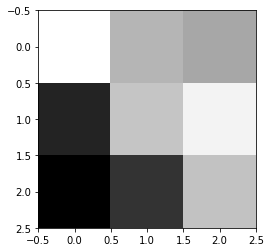

out 14


out 15


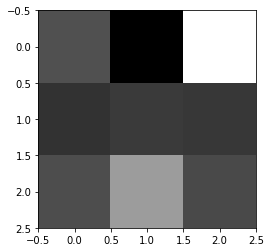

out 16


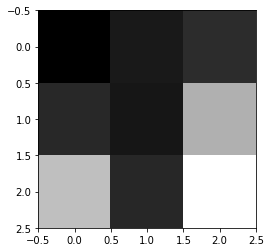

out 17


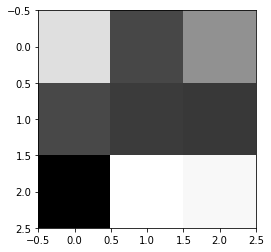

out 18


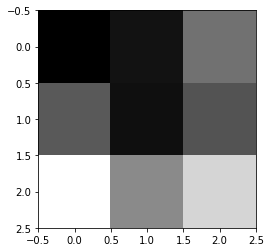

out 19


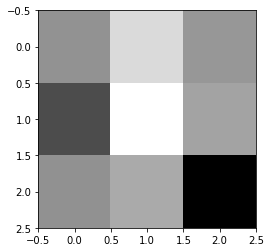

out 20


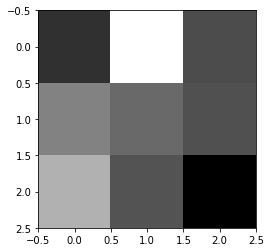

out 21


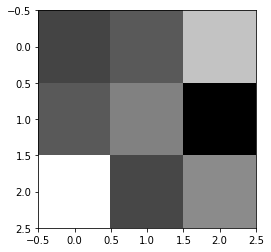

out 22


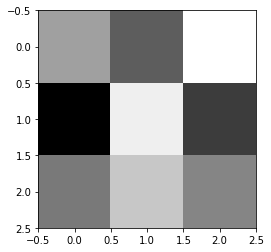

out 23


out 24


out 25


out 26


out 27


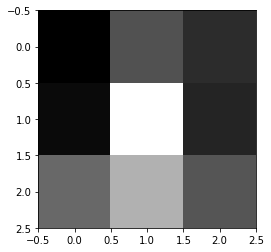

out 28


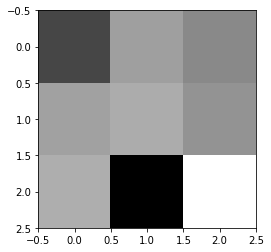

out 29


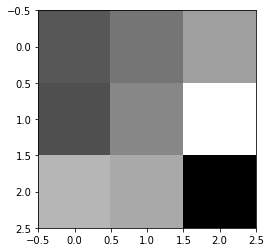

out 30


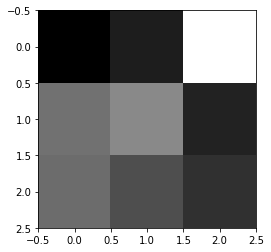

out 31


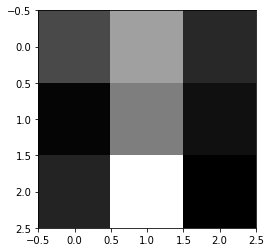

in 1
out 0


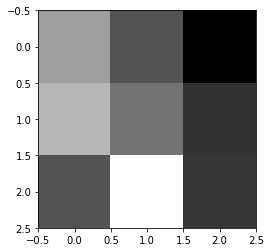

out 1


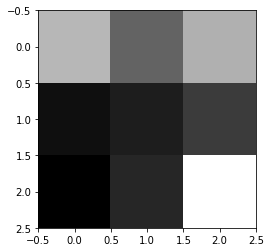

out 2


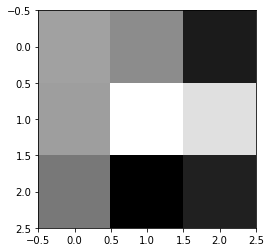

out 3


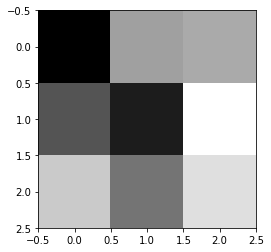

out 4


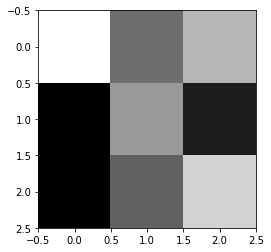

out 5


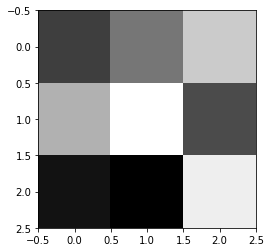

out 6


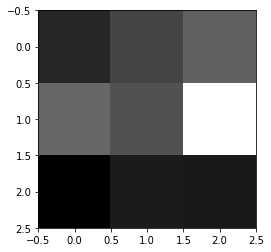

out 7


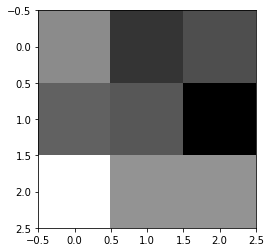

out 8


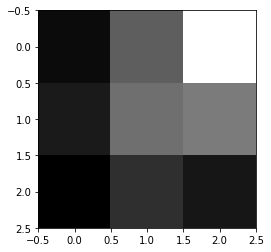

out 9


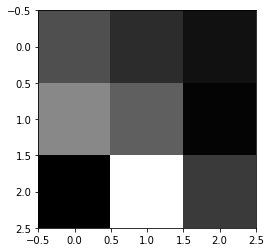

out 10


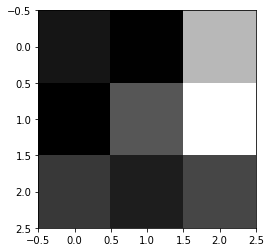

out 11


out 12


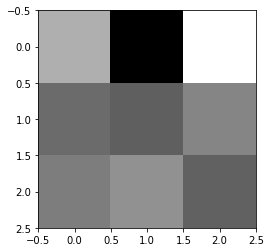

out 13


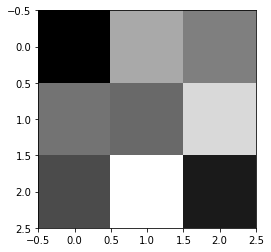

out 14


out 15


out 16


out 17


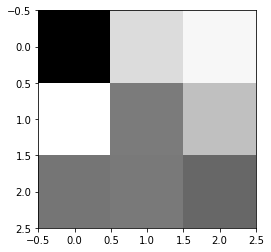

out 18


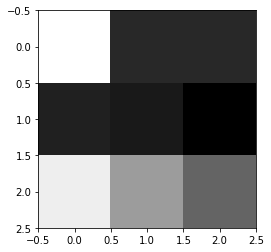

out 19


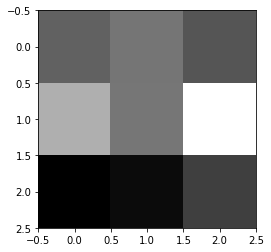

out 20


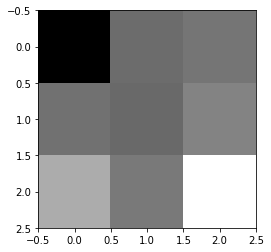

out 21


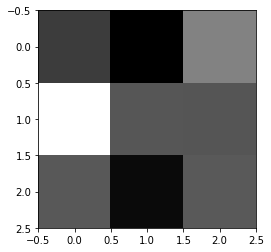

out 22


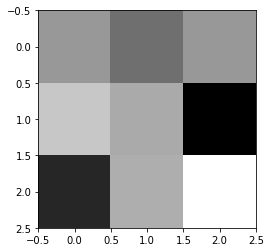

out 23


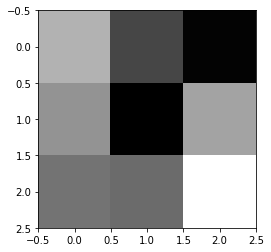

out 24


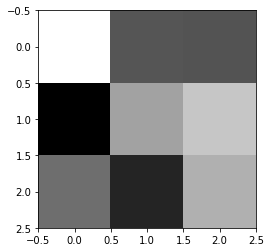

out 25


out 26


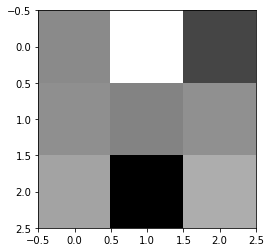

out 27


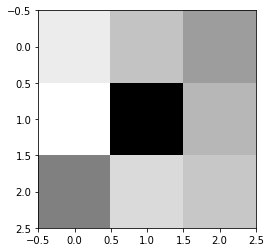

out 28


out 29


out 30


out 31


in 2
out 0


out 1


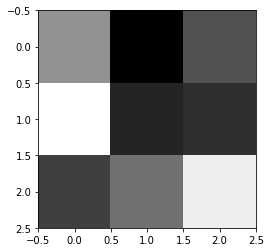

out 2


out 3


out 4


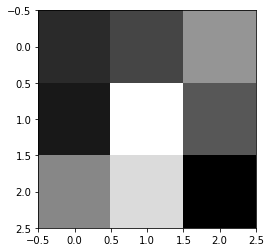

out 5


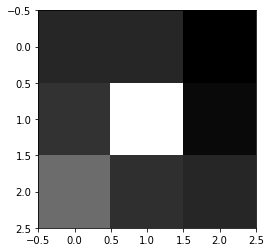

out 6


out 7


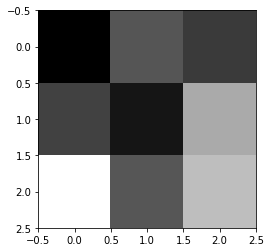

out 8


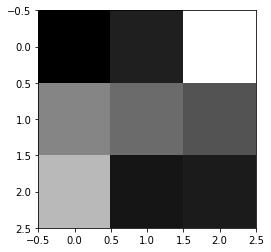

out 9


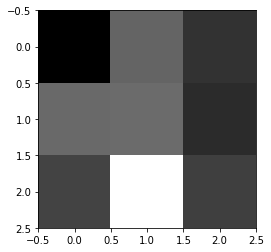

out 10


out 11


out 12


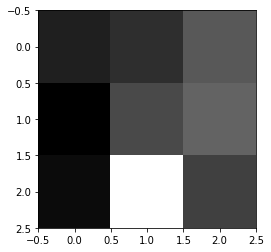

out 13


out 14


out 15


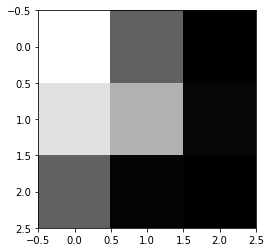

out 16


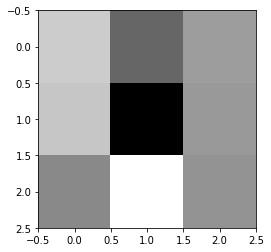

out 17


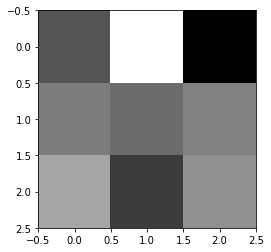

out 18


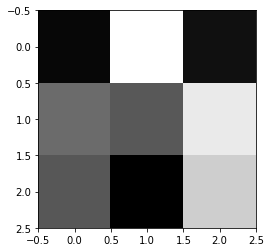

out 19


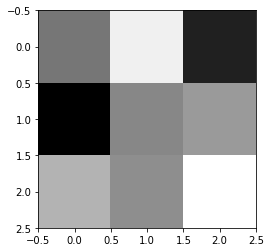

out 20


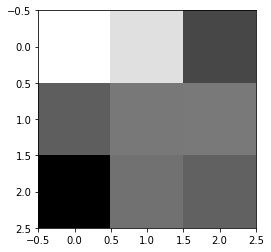

out 21


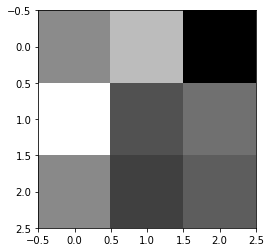

out 22


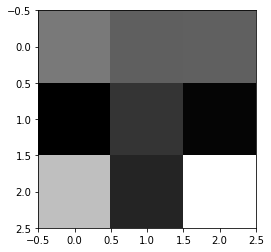

out 23


out 24


out 25


out 26


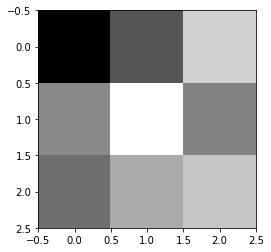

out 27


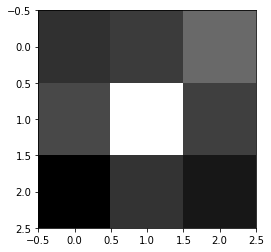

out 28


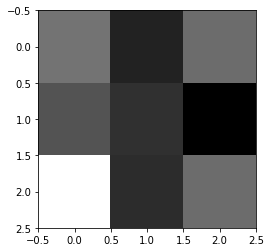

out 29


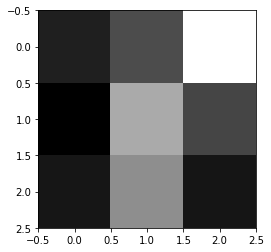

out 30


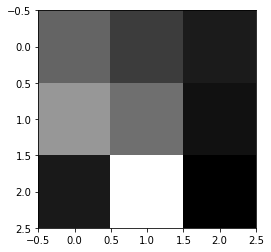

out 31


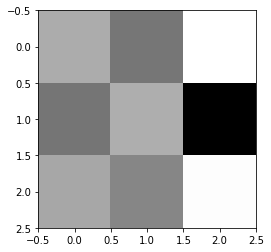

In [19]:
w = player._network._model.get_weights()
fig = plt.gcf()
show_w = w[0].reshape((32, 3, 3, 3))
for in_layer in range(3):
    print('in', in_layer)
    for out_layer in range(32):
        print('out', out_layer)
        plt.imshow(show_w[out_layer][in_layer], cmap='gray')
        plt.pause(0.1)